In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ConvNeXtBase)

2024-02-21 15:55:01.225045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 15:55:01.225145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 15:55:01.350126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ConvNeXtBase(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ConvNeXtBase"+s+".keras")
    

    # save model to disk
    filename = "ConvNeXtBase" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 convnext_base (Functional)  (None, 4)                 87570564  


Total params: 87570564 (334.06 MB)


Trainable params: 87570564 (334.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708530971.750720      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 2:54:22 - loss: 1.9283 - accuracy: 0.1562

  2/140 [..............................] - ETA: 1:40 - loss: 8.7259 - accuracy: 0.2500   

  3/140 [..............................] - ETA: 1:39 - loss: 8.7581 - accuracy: 0.2917

  4/140 [..............................] - ETA: 1:39 - loss: 7.0495 - accuracy: 0.3594

  5/140 [>.............................] - ETA: 1:38 - loss: 5.9032 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 1:37 - loss: 5.1096 - accuracy: 0.4219

  7/140 [>.............................] - ETA: 1:36 - loss: 4.5718 - accuracy: 0.4107

  8/140 [>.............................] - ETA: 1:36 - loss: 4.1476 - accuracy: 0.4141

  9/140 [>.............................] - ETA: 1:35 - loss: 3.7962 - accuracy: 0.4167

 10/140 [=>............................] - ETA: 1:34 - loss: 3.5294 - accuracy: 0.4156

 11/140 [=>............................] - ETA: 1:33 - loss: 3.3221 - accuracy: 0.4176

 12/140 [=>............................] - ETA: 1:33 - loss: 3.3550 - accuracy: 0.4115

 13/140 [=>............................] - ETA: 1:32 - loss: 3.1825 - accuracy: 0.3990

 14/140 [==>...........................] - ETA: 1:31 - loss: 3.0426 - accuracy: 0.3951

 15/140 [==>...........................] - ETA: 1:30 - loss: 2.9882 - accuracy: 0.4021

 16/140 [==>...........................] - ETA: 1:30 - loss: 2.8580 - accuracy: 0.4121

 17/140 [==>...........................] - ETA: 1:29 - loss: 2.8282 - accuracy: 0.4173

 18/140 [==>...........................] - ETA: 1:28 - loss: 2.7137 - accuracy: 0.4340

 19/140 [===>..........................] - ETA: 1:28 - loss: 2.6201 - accuracy: 0.4342

 20/140 [===>..........................] - ETA: 1:27 - loss: 2.5960 - accuracy: 0.4359

 21/140 [===>..........................] - ETA: 1:26 - loss: 2.5231 - accuracy: 0.4360

 22/140 [===>..........................] - ETA: 1:25 - loss: 2.4626 - accuracy: 0.4361

 23/140 [===>..........................] - ETA: 1:25 - loss: 2.3980 - accuracy: 0.4348

 24/140 [====>.........................] - ETA: 1:24 - loss: 2.3419 - accuracy: 0.4362

 25/140 [====>.........................] - ETA: 1:23 - loss: 2.2910 - accuracy: 0.4338

 26/140 [====>.........................] - ETA: 1:23 - loss: 2.2792 - accuracy: 0.4411

 27/140 [====>.........................] - ETA: 1:22 - loss: 2.2297 - accuracy: 0.4444

 28/140 [=====>........................] - ETA: 1:21 - loss: 2.1810 - accuracy: 0.4442

 29/140 [=====>........................] - ETA: 1:20 - loss: 2.1334 - accuracy: 0.4504

 30/140 [=====>........................] - ETA: 1:20 - loss: 2.0929 - accuracy: 0.4542

 31/140 [=====>........................] - ETA: 1:19 - loss: 2.0541 - accuracy: 0.4567

 32/140 [=====>........................] - ETA: 1:18 - loss: 2.0158 - accuracy: 0.4609

 33/140 [======>.......................] - ETA: 1:17 - loss: 1.9818 - accuracy: 0.4621

 34/140 [======>.......................] - ETA: 1:17 - loss: 1.9865 - accuracy: 0.4605

 35/140 [======>.......................] - ETA: 1:16 - loss: 1.9894 - accuracy: 0.4580

 36/140 [======>.......................] - ETA: 1:15 - loss: 1.9585 - accuracy: 0.4618

 37/140 [======>.......................] - ETA: 1:15 - loss: 1.9431 - accuracy: 0.4578

 38/140 [=======>......................] - ETA: 1:14 - loss: 1.9181 - accuracy: 0.4589

 39/140 [=======>......................] - ETA: 1:13 - loss: 1.9238 - accuracy: 0.4575

 40/140 [=======>......................] - ETA: 1:12 - loss: 1.9043 - accuracy: 0.4570

 41/140 [=======>......................] - ETA: 1:12 - loss: 1.8802 - accuracy: 0.4566

 42/140 [========>.....................] - ETA: 1:11 - loss: 1.8546 - accuracy: 0.4583

 43/140 [========>.....................] - ETA: 1:10 - loss: 1.8338 - accuracy: 0.4600

 44/140 [========>.....................] - ETA: 1:09 - loss: 1.8089 - accuracy: 0.4631

 45/140 [========>.....................] - ETA: 1:09 - loss: 1.8239 - accuracy: 0.4660

 46/140 [========>.....................] - ETA: 1:08 - loss: 1.8537 - accuracy: 0.4660

 47/140 [=========>....................] - ETA: 1:07 - loss: 1.8538 - accuracy: 0.4688

 48/140 [=========>....................] - ETA: 1:07 - loss: 1.8322 - accuracy: 0.4727

 49/140 [=========>....................] - ETA: 1:06 - loss: 1.8126 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 1:05 - loss: 1.7935 - accuracy: 0.4750

 51/140 [=========>....................] - ETA: 1:04 - loss: 1.7758 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 1:04 - loss: 1.7593 - accuracy: 0.4748

 53/140 [==========>...................] - ETA: 1:03 - loss: 1.7405 - accuracy: 0.4788

 54/140 [==========>...................] - ETA: 1:02 - loss: 1.7253 - accuracy: 0.4792

 55/140 [==========>...................] - ETA: 1:01 - loss: 1.7112 - accuracy: 0.4795

 56/140 [===========>..................] - ETA: 1:01 - loss: 1.6964 - accuracy: 0.4810

 57/140 [===========>..................] - ETA: 1:00 - loss: 1.6826 - accuracy: 0.4841

 58/140 [===========>..................] - ETA: 59s - loss: 1.6699 - accuracy: 0.4844 

 59/140 [===========>..................] - ETA: 58s - loss: 1.6746 - accuracy: 0.4836

 60/140 [===========>..................] - ETA: 58s - loss: 1.6780 - accuracy: 0.4844

 61/140 [============>.................] - ETA: 57s - loss: 1.6681 - accuracy: 0.4836

 62/140 [============>.................] - ETA: 56s - loss: 1.6570 - accuracy: 0.4829

 63/140 [============>.................] - ETA: 56s - loss: 1.6556 - accuracy: 0.4841

 64/140 [============>.................] - ETA: 55s - loss: 1.6440 - accuracy: 0.4854

 65/140 [============>.................] - ETA: 54s - loss: 1.6542 - accuracy: 0.4875

 66/140 [=============>................] - ETA: 53s - loss: 1.6487 - accuracy: 0.4891

 67/140 [=============>................] - ETA: 53s - loss: 1.6403 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 52s - loss: 1.6493 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 51s - loss: 1.6390 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 51s - loss: 1.6305 - accuracy: 0.4879

 71/140 [==============>...............] - ETA: 50s - loss: 1.6218 - accuracy: 0.4864

 72/140 [==============>...............] - ETA: 49s - loss: 1.6160 - accuracy: 0.4852

 73/140 [==============>...............] - ETA: 48s - loss: 1.6055 - accuracy: 0.4842

 74/140 [==============>...............] - ETA: 48s - loss: 1.5959 - accuracy: 0.4844

 75/140 [===============>..............] - ETA: 47s - loss: 1.5877 - accuracy: 0.4846

 76/140 [===============>..............] - ETA: 46s - loss: 1.5792 - accuracy: 0.4831

 77/140 [===============>..............] - ETA: 45s - loss: 1.5678 - accuracy: 0.4858

 78/140 [===============>..............] - ETA: 45s - loss: 1.5586 - accuracy: 0.4868

 79/140 [===============>..............] - ETA: 44s - loss: 1.5560 - accuracy: 0.4846

 80/140 [================>.............] - ETA: 43s - loss: 1.5456 - accuracy: 0.4859

 81/140 [================>.............] - ETA: 42s - loss: 1.5367 - accuracy: 0.4865

 82/140 [================>.............] - ETA: 42s - loss: 1.5286 - accuracy: 0.4874

 83/140 [================>.............] - ETA: 41s - loss: 1.5213 - accuracy: 0.4864

 84/140 [=================>............] - ETA: 40s - loss: 1.5163 - accuracy: 0.4855

 85/140 [=================>............] - ETA: 40s - loss: 1.5095 - accuracy: 0.4864

 86/140 [=================>............] - ETA: 39s - loss: 1.5016 - accuracy: 0.4884

 87/140 [=================>............] - ETA: 38s - loss: 1.4955 - accuracy: 0.4896

 88/140 [=================>............] - ETA: 37s - loss: 1.4903 - accuracy: 0.4901

 89/140 [==================>...........] - ETA: 37s - loss: 1.4856 - accuracy: 0.4905

 90/140 [==================>...........] - ETA: 36s - loss: 1.4794 - accuracy: 0.4910

 91/140 [==================>...........] - ETA: 35s - loss: 1.4737 - accuracy: 0.4918

 92/140 [==================>...........] - ETA: 34s - loss: 1.4675 - accuracy: 0.4932

 93/140 [==================>...........] - ETA: 34s - loss: 1.4612 - accuracy: 0.4953

 94/140 [===================>..........] - ETA: 33s - loss: 1.4553 - accuracy: 0.4960

 95/140 [===================>..........] - ETA: 32s - loss: 1.4510 - accuracy: 0.4961

 96/140 [===================>..........] - ETA: 32s - loss: 1.4438 - accuracy: 0.4974

 97/140 [===================>..........] - ETA: 31s - loss: 1.4381 - accuracy: 0.4977

 98/140 [====================>.........] - ETA: 30s - loss: 1.4348 - accuracy: 0.4965

 99/140 [====================>.........] - ETA: 29s - loss: 1.4271 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 29s - loss: 1.4237 - accuracy: 0.4991

101/140 [====================>.........] - ETA: 28s - loss: 1.4186 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 27s - loss: 1.4130 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 26s - loss: 1.4075 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 26s - loss: 1.4046 - accuracy: 0.4994

105/140 [=====================>........] - ETA: 25s - loss: 1.4009 - accuracy: 0.4997

106/140 [=====================>........] - ETA: 24s - loss: 1.3954 - accuracy: 0.5021

107/140 [=====================>........] - ETA: 24s - loss: 1.3905 - accuracy: 0.5012

108/140 [======================>.......] - ETA: 23s - loss: 1.3870 - accuracy: 0.5009

109/140 [======================>.......] - ETA: 22s - loss: 1.3839 - accuracy: 0.5011

110/140 [======================>.......] - ETA: 21s - loss: 1.3799 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 21s - loss: 1.3760 - accuracy: 0.5000

112/140 [=======================>......] - ETA: 20s - loss: 1.3716 - accuracy: 0.5008

113/140 [=======================>......] - ETA: 19s - loss: 1.3665 - accuracy: 0.5014

114/140 [=======================>......] - ETA: 18s - loss: 1.3629 - accuracy: 0.5011

115/140 [=======================>......] - ETA: 18s - loss: 1.3588 - accuracy: 0.5011

116/140 [=======================>......] - ETA: 17s - loss: 1.3545 - accuracy: 0.5005

117/140 [========================>.....] - ETA: 16s - loss: 1.3519 - accuracy: 0.5013

118/140 [========================>.....] - ETA: 16s - loss: 1.3475 - accuracy: 0.5024

119/140 [========================>.....] - ETA: 15s - loss: 1.3440 - accuracy: 0.5034

120/140 [========================>.....] - ETA: 14s - loss: 1.3414 - accuracy: 0.5031

121/140 [========================>.....] - ETA: 13s - loss: 1.3379 - accuracy: 0.5028

122/140 [=========================>....] - ETA: 13s - loss: 1.3342 - accuracy: 0.5026

123/140 [=========================>....] - ETA: 12s - loss: 1.3304 - accuracy: 0.5033

124/140 [=========================>....] - ETA: 11s - loss: 1.3275 - accuracy: 0.5043

125/140 [=========================>....] - ETA: 10s - loss: 1.3241 - accuracy: 0.5042

126/140 [==========================>...] - ETA: 10s - loss: 1.3193 - accuracy: 0.5055

127/140 [==========================>...] - ETA: 9s - loss: 1.3167 - accuracy: 0.5054 

128/140 [==========================>...] - ETA: 8s - loss: 1.3134 - accuracy: 0.5068

129/140 [==========================>...] - ETA: 8s - loss: 1.3096 - accuracy: 0.5075

130/140 [==========================>...] - ETA: 7s - loss: 1.3070 - accuracy: 0.5082

131/140 [===========================>..] - ETA: 6s - loss: 1.3041 - accuracy: 0.5081

132/140 [===========================>..] - ETA: 5s - loss: 1.3024 - accuracy: 0.5083

133/140 [===========================>..] - ETA: 5s - loss: 1.2983 - accuracy: 0.5092

134/140 [===========================>..] - ETA: 4s - loss: 1.2941 - accuracy: 0.5098

135/140 [===========================>..] - ETA: 3s - loss: 1.2905 - accuracy: 0.5102

136/140 [============================>.] - ETA: 2s - loss: 1.2888 - accuracy: 0.5094

137/140 [============================>.] - ETA: 2s - loss: 1.2847 - accuracy: 0.5105

138/140 [============================>.] - ETA: 1s - loss: 1.2818 - accuracy: 0.5106

139/140 [============================>.] - ETA: 0s - loss: 1.2798 - accuracy: 0.5106

140/140 [==============================] - ETA: 0s - loss: 1.2790 - accuracy: 0.5103

140/140 [==============================] - 203s 920ms/step - loss: 1.2790 - accuracy: 0.5103 - val_loss: 0.9502 - val_accuracy: 0.5246


Epoch 2/30


  1/140 [..............................] - ETA: 2:02 - loss: 0.8993 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:40 - loss: 0.8884 - accuracy: 0.5938

  3/140 [..............................] - ETA: 1:40 - loss: 0.8449 - accuracy: 0.6354

  4/140 [..............................] - ETA: 1:39 - loss: 0.8569 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8965 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 1:37 - loss: 0.9637 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 1:36 - loss: 0.9629 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9347 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9313 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 1:34 - loss: 0.9369 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 1:33 - loss: 0.9304 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9229 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9327 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.9334 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 1:30 - loss: 0.9211 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9188 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.9185 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.9174 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 1:27 - loss: 0.9267 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9240 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.9211 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.9130 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9084 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9056 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.9069 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9084 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9040 - accuracy: 0.5405

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9042 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.9037 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9020 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9084 - accuracy: 0.5383

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.9079 - accuracy: 0.5410

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.9049 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9093 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9069 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.9073 - accuracy: 0.5391

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.9067 - accuracy: 0.5372

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9043 - accuracy: 0.5378

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9080 - accuracy: 0.5369

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.9047 - accuracy: 0.5398

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9027 - accuracy: 0.5389

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9051 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.9043 - accuracy: 0.5422

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.8987 - accuracy: 0.5455

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9025 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9009 - accuracy: 0.5455

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.9009 - accuracy: 0.5485

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9018 - accuracy: 0.5482

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9007 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8981 - accuracy: 0.5506

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.8993 - accuracy: 0.5496

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9001 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8974 - accuracy: 0.5501

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8970 - accuracy: 0.5498

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.8967 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8969 - accuracy: 0.5502

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8985 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 59s - loss: 0.8964 - accuracy: 0.5512 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8973 - accuracy: 0.5519

 60/140 [===========>..................] - ETA: 58s - loss: 0.8952 - accuracy: 0.5526

 61/140 [============>.................] - ETA: 57s - loss: 0.8958 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 56s - loss: 0.8944 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 56s - loss: 0.8988 - accuracy: 0.5521

 64/140 [============>.................] - ETA: 55s - loss: 0.8969 - accuracy: 0.5518

 65/140 [============>.................] - ETA: 54s - loss: 0.9013 - accuracy: 0.5500

 66/140 [=============>................] - ETA: 53s - loss: 0.9051 - accuracy: 0.5492

 67/140 [=============>................] - ETA: 53s - loss: 0.9059 - accuracy: 0.5476

 68/140 [=============>................] - ETA: 52s - loss: 0.9053 - accuracy: 0.5487

 69/140 [=============>................] - ETA: 51s - loss: 0.9057 - accuracy: 0.5480

 70/140 [==============>...............] - ETA: 51s - loss: 0.9062 - accuracy: 0.5464

 71/140 [==============>...............] - ETA: 50s - loss: 0.9062 - accuracy: 0.5462

 72/140 [==============>...............] - ETA: 49s - loss: 0.9041 - accuracy: 0.5473

 73/140 [==============>...............] - ETA: 48s - loss: 0.9038 - accuracy: 0.5475

 74/140 [==============>...............] - ETA: 48s - loss: 0.9049 - accuracy: 0.5469

 75/140 [===============>..............] - ETA: 47s - loss: 0.9092 - accuracy: 0.5442

 76/140 [===============>..............] - ETA: 46s - loss: 0.9092 - accuracy: 0.5428

 77/140 [===============>..............] - ETA: 45s - loss: 0.9082 - accuracy: 0.5426

 78/140 [===============>..............] - ETA: 45s - loss: 0.9073 - accuracy: 0.5433

 79/140 [===============>..............] - ETA: 44s - loss: 0.9066 - accuracy: 0.5435

 80/140 [================>.............] - ETA: 43s - loss: 0.9063 - accuracy: 0.5445

 81/140 [================>.............] - ETA: 43s - loss: 0.9055 - accuracy: 0.5455

 82/140 [================>.............] - ETA: 42s - loss: 0.9021 - accuracy: 0.5469

 83/140 [================>.............] - ETA: 41s - loss: 0.9011 - accuracy: 0.5474

 84/140 [=================>............] - ETA: 40s - loss: 0.9011 - accuracy: 0.5476

 85/140 [=================>............] - ETA: 40s - loss: 0.9021 - accuracy: 0.5460

 86/140 [=================>............] - ETA: 39s - loss: 0.9016 - accuracy: 0.5480

 87/140 [=================>............] - ETA: 38s - loss: 0.9019 - accuracy: 0.5481

 88/140 [=================>............] - ETA: 37s - loss: 0.9006 - accuracy: 0.5501

 89/140 [==================>...........] - ETA: 37s - loss: 0.9042 - accuracy: 0.5495

 90/140 [==================>...........] - ETA: 36s - loss: 0.9033 - accuracy: 0.5500

 91/140 [==================>...........] - ETA: 35s - loss: 0.9032 - accuracy: 0.5505

 92/140 [==================>...........] - ETA: 34s - loss: 0.9024 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 34s - loss: 0.9025 - accuracy: 0.5517

 94/140 [===================>..........] - ETA: 33s - loss: 0.9037 - accuracy: 0.5515

 95/140 [===================>..........] - ETA: 32s - loss: 0.9046 - accuracy: 0.5507

 96/140 [===================>..........] - ETA: 32s - loss: 0.9025 - accuracy: 0.5524

 97/140 [===================>..........] - ETA: 31s - loss: 0.9028 - accuracy: 0.5512

 98/140 [====================>.........] - ETA: 30s - loss: 0.9029 - accuracy: 0.5507

 99/140 [====================>.........] - ETA: 29s - loss: 0.9041 - accuracy: 0.5499

100/140 [====================>.........] - ETA: 29s - loss: 0.9037 - accuracy: 0.5500

101/140 [====================>.........] - ETA: 28s - loss: 0.9043 - accuracy: 0.5501

102/140 [====================>.........] - ETA: 27s - loss: 0.9040 - accuracy: 0.5502

103/140 [=====================>........] - ETA: 26s - loss: 0.9042 - accuracy: 0.5498

104/140 [=====================>........] - ETA: 26s - loss: 0.9029 - accuracy: 0.5508

105/140 [=====================>........] - ETA: 25s - loss: 0.9025 - accuracy: 0.5518

106/140 [=====================>........] - ETA: 24s - loss: 0.9016 - accuracy: 0.5516

107/140 [=====================>........] - ETA: 24s - loss: 0.9010 - accuracy: 0.5523

108/140 [======================>.......] - ETA: 23s - loss: 0.9003 - accuracy: 0.5524

109/140 [======================>.......] - ETA: 22s - loss: 0.9019 - accuracy: 0.5528

110/140 [======================>.......] - ETA: 21s - loss: 0.9019 - accuracy: 0.5534

111/140 [======================>.......] - ETA: 21s - loss: 0.9054 - accuracy: 0.5512

112/140 [=======================>......] - ETA: 20s - loss: 0.9050 - accuracy: 0.5513

113/140 [=======================>......] - ETA: 19s - loss: 0.9048 - accuracy: 0.5503

114/140 [=======================>......] - ETA: 18s - loss: 0.9053 - accuracy: 0.5502

115/140 [=======================>......] - ETA: 18s - loss: 0.9060 - accuracy: 0.5495

116/140 [=======================>......] - ETA: 17s - loss: 0.9061 - accuracy: 0.5482

117/140 [========================>.....] - ETA: 16s - loss: 0.9072 - accuracy: 0.5478

118/140 [========================>.....] - ETA: 16s - loss: 0.9062 - accuracy: 0.5482

119/140 [========================>.....] - ETA: 15s - loss: 0.9057 - accuracy: 0.5475

120/140 [========================>.....] - ETA: 14s - loss: 0.9053 - accuracy: 0.5471

121/140 [========================>.....] - ETA: 13s - loss: 0.9048 - accuracy: 0.5488

122/140 [=========================>....] - ETA: 13s - loss: 0.9069 - accuracy: 0.5479

123/140 [=========================>....] - ETA: 12s - loss: 0.9060 - accuracy: 0.5483

124/140 [=========================>....] - ETA: 11s - loss: 0.9064 - accuracy: 0.5484

125/140 [=========================>....] - ETA: 10s - loss: 0.9072 - accuracy: 0.5480

126/140 [==========================>...] - ETA: 10s - loss: 0.9083 - accuracy: 0.5476

127/140 [==========================>...] - ETA: 9s - loss: 0.9069 - accuracy: 0.5477 

128/140 [==========================>...] - ETA: 8s - loss: 0.9070 - accuracy: 0.5471

129/140 [==========================>...] - ETA: 8s - loss: 0.9065 - accuracy: 0.5475

130/140 [==========================>...] - ETA: 7s - loss: 0.9065 - accuracy: 0.5471

131/140 [===========================>..] - ETA: 6s - loss: 0.9072 - accuracy: 0.5463

132/140 [===========================>..] - ETA: 5s - loss: 0.9067 - accuracy: 0.5469

133/140 [===========================>..] - ETA: 5s - loss: 0.9066 - accuracy: 0.5468

134/140 [===========================>..] - ETA: 4s - loss: 0.9059 - accuracy: 0.5473

135/140 [===========================>..] - ETA: 3s - loss: 0.9041 - accuracy: 0.5486

136/140 [============================>.] - ETA: 2s - loss: 0.9041 - accuracy: 0.5487

137/140 [============================>.] - ETA: 2s - loss: 0.9051 - accuracy: 0.5477

138/140 [============================>.] - ETA: 1s - loss: 0.9046 - accuracy: 0.5476

139/140 [============================>.] - ETA: 0s - loss: 0.9043 - accuracy: 0.5472

140/140 [==============================] - ETA: 0s - loss: 0.9046 - accuracy: 0.5471

140/140 [==============================] - 112s 798ms/step - loss: 0.9046 - accuracy: 0.5471 - val_loss: 0.9183 - val_accuracy: 0.5332


Epoch 3/30


  1/140 [..............................] - ETA: 2:02 - loss: 0.8376 - accuracy: 0.6562

  2/140 [..............................] - ETA: 1:40 - loss: 0.8529 - accuracy: 0.6094

  3/140 [..............................] - ETA: 1:39 - loss: 0.8301 - accuracy: 0.6042

  4/140 [..............................] - ETA: 1:38 - loss: 0.7931 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 1:38 - loss: 0.7965 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 1:37 - loss: 0.8561 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 1:36 - loss: 0.8924 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8921 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8728 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 1:34 - loss: 0.8678 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 1:33 - loss: 0.8661 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8718 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8801 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.8795 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8919 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8930 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8932 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.8842 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8805 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8848 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.8813 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.8802 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8745 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8769 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.8782 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8795 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8797 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8805 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.8746 - accuracy: 0.5463

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8766 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8756 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.8774 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.8758 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8722 - accuracy: 0.5460

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8739 - accuracy: 0.5464

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.8784 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.8724 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8767 - accuracy: 0.5518

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8729 - accuracy: 0.5537

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.8713 - accuracy: 0.5547

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8731 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8746 - accuracy: 0.5551

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8736 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.8729 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8685 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8677 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.8698 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8701 - accuracy: 0.5573

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8699 - accuracy: 0.5568

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8656 - accuracy: 0.5587

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.8649 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8671 - accuracy: 0.5577

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8689 - accuracy: 0.5584

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8688 - accuracy: 0.5590

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.8668 - accuracy: 0.5602

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8645 - accuracy: 0.5614

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8646 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 59s - loss: 0.8632 - accuracy: 0.5603 

 59/140 [===========>..................] - ETA: 58s - loss: 0.8670 - accuracy: 0.5614

 60/140 [===========>..................] - ETA: 58s - loss: 0.8663 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 57s - loss: 0.8650 - accuracy: 0.5645

 62/140 [============>.................] - ETA: 56s - loss: 0.8669 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 56s - loss: 0.8698 - accuracy: 0.5615

 64/140 [============>.................] - ETA: 55s - loss: 0.8718 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 54s - loss: 0.8702 - accuracy: 0.5639

 66/140 [=============>................] - ETA: 53s - loss: 0.8683 - accuracy: 0.5658

 67/140 [=============>................] - ETA: 53s - loss: 0.8664 - accuracy: 0.5676

 68/140 [=============>................] - ETA: 52s - loss: 0.8651 - accuracy: 0.5685

 69/140 [=============>................] - ETA: 51s - loss: 0.8628 - accuracy: 0.5711

 70/140 [==============>...............] - ETA: 50s - loss: 0.8624 - accuracy: 0.5723

 71/140 [==============>...............] - ETA: 50s - loss: 0.8616 - accuracy: 0.5735

 72/140 [==============>...............] - ETA: 49s - loss: 0.8617 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 48s - loss: 0.8585 - accuracy: 0.5745

 74/140 [==============>...............] - ETA: 48s - loss: 0.8593 - accuracy: 0.5743

 75/140 [===============>..............] - ETA: 47s - loss: 0.8570 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 46s - loss: 0.8560 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 45s - loss: 0.8572 - accuracy: 0.5755

 78/140 [===============>..............] - ETA: 45s - loss: 0.8581 - accuracy: 0.5753

 79/140 [===============>..............] - ETA: 44s - loss: 0.8578 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 43s - loss: 0.8579 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 42s - loss: 0.8565 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 42s - loss: 0.8544 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 41s - loss: 0.8514 - accuracy: 0.5776

 84/140 [=================>............] - ETA: 40s - loss: 0.8555 - accuracy: 0.5770

 85/140 [=================>............] - ETA: 40s - loss: 0.8547 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 39s - loss: 0.8539 - accuracy: 0.5789

 87/140 [=================>............] - ETA: 38s - loss: 0.8544 - accuracy: 0.5787

 88/140 [=================>............] - ETA: 37s - loss: 0.8549 - accuracy: 0.5778

 89/140 [==================>...........] - ETA: 37s - loss: 0.8548 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 36s - loss: 0.8552 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 35s - loss: 0.8571 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 34s - loss: 0.8572 - accuracy: 0.5781

 93/140 [==================>...........] - ETA: 34s - loss: 0.8556 - accuracy: 0.5783

 94/140 [===================>..........] - ETA: 33s - loss: 0.8572 - accuracy: 0.5778

 95/140 [===================>..........] - ETA: 32s - loss: 0.8580 - accuracy: 0.5776

 96/140 [===================>..........] - ETA: 32s - loss: 0.8597 - accuracy: 0.5758

 97/140 [===================>..........] - ETA: 31s - loss: 0.8598 - accuracy: 0.5757

 98/140 [====================>.........] - ETA: 30s - loss: 0.8579 - accuracy: 0.5772

 99/140 [====================>.........] - ETA: 29s - loss: 0.8586 - accuracy: 0.5764

100/140 [====================>.........] - ETA: 29s - loss: 0.8583 - accuracy: 0.5766

101/140 [====================>.........] - ETA: 28s - loss: 0.8583 - accuracy: 0.5758

102/140 [====================>.........] - ETA: 27s - loss: 0.8581 - accuracy: 0.5766

103/140 [=====================>........] - ETA: 26s - loss: 0.8584 - accuracy: 0.5771

104/140 [=====================>........] - ETA: 26s - loss: 0.8578 - accuracy: 0.5775

105/140 [=====================>........] - ETA: 25s - loss: 0.8567 - accuracy: 0.5789

106/140 [=====================>........] - ETA: 24s - loss: 0.8577 - accuracy: 0.5781

107/140 [=====================>........] - ETA: 24s - loss: 0.8564 - accuracy: 0.5797

108/140 [======================>.......] - ETA: 23s - loss: 0.8567 - accuracy: 0.5799

109/140 [======================>.......] - ETA: 22s - loss: 0.8550 - accuracy: 0.5811

110/140 [======================>.......] - ETA: 21s - loss: 0.8536 - accuracy: 0.5824

111/140 [======================>.......] - ETA: 21s - loss: 0.8528 - accuracy: 0.5828

112/140 [=======================>......] - ETA: 20s - loss: 0.8530 - accuracy: 0.5834

113/140 [=======================>......] - ETA: 19s - loss: 0.8520 - accuracy: 0.5846

114/140 [=======================>......] - ETA: 18s - loss: 0.8535 - accuracy: 0.5836

115/140 [=======================>......] - ETA: 18s - loss: 0.8528 - accuracy: 0.5845

116/140 [=======================>......] - ETA: 17s - loss: 0.8518 - accuracy: 0.5849

117/140 [========================>.....] - ETA: 16s - loss: 0.8532 - accuracy: 0.5841

118/140 [========================>.....] - ETA: 16s - loss: 0.8517 - accuracy: 0.5861

119/140 [========================>.....] - ETA: 15s - loss: 0.8513 - accuracy: 0.5867

120/140 [========================>.....] - ETA: 14s - loss: 0.8513 - accuracy: 0.5872

121/140 [========================>.....] - ETA: 13s - loss: 0.8505 - accuracy: 0.5873

122/140 [=========================>....] - ETA: 13s - loss: 0.8505 - accuracy: 0.5871

123/140 [=========================>....] - ETA: 12s - loss: 0.8512 - accuracy: 0.5869

124/140 [=========================>....] - ETA: 11s - loss: 0.8508 - accuracy: 0.5869

125/140 [=========================>....] - ETA: 10s - loss: 0.8506 - accuracy: 0.5870

126/140 [==========================>...] - ETA: 10s - loss: 0.8485 - accuracy: 0.5880

127/140 [==========================>...] - ETA: 9s - loss: 0.8476 - accuracy: 0.5886 

128/140 [==========================>...] - ETA: 8s - loss: 0.8472 - accuracy: 0.5881

129/140 [==========================>...] - ETA: 8s - loss: 0.8476 - accuracy: 0.5879

130/140 [==========================>...] - ETA: 7s - loss: 0.8474 - accuracy: 0.5877

131/140 [===========================>..] - ETA: 6s - loss: 0.8466 - accuracy: 0.5885

132/140 [===========================>..] - ETA: 5s - loss: 0.8465 - accuracy: 0.5881

133/140 [===========================>..] - ETA: 5s - loss: 0.8469 - accuracy: 0.5869

134/140 [===========================>..] - ETA: 4s - loss: 0.8468 - accuracy: 0.5872

135/140 [===========================>..] - ETA: 3s - loss: 0.8469 - accuracy: 0.5866

136/140 [============================>.] - ETA: 2s - loss: 0.8471 - accuracy: 0.5864

137/140 [============================>.] - ETA: 2s - loss: 0.8449 - accuracy: 0.5869

138/140 [============================>.] - ETA: 1s - loss: 0.8450 - accuracy: 0.5865

139/140 [============================>.] - ETA: 0s - loss: 0.8454 - accuracy: 0.5863

140/140 [==============================] - ETA: 0s - loss: 0.8462 - accuracy: 0.5860

140/140 [==============================] - 112s 797ms/step - loss: 0.8462 - accuracy: 0.5860 - val_loss: 0.9540 - val_accuracy: 0.5317


Epoch 4/30


  1/140 [..............................] - ETA: 1:58 - loss: 0.7375 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:40 - loss: 0.8507 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:39 - loss: 0.8770 - accuracy: 0.5521

  4/140 [..............................] - ETA: 1:38 - loss: 0.8629 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8469 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 1:37 - loss: 0.8215 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 1:36 - loss: 0.8255 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8141 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8166 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 1:34 - loss: 0.8414 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 1:33 - loss: 0.8351 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8434 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8385 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.8431 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8342 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8222 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8236 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.8162 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8224 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8193 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.8180 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.8150 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8090 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8177 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.8147 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8072 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8075 - accuracy: 0.6042

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8112 - accuracy: 0.6038

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.8079 - accuracy: 0.6056

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8137 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8146 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.8169 - accuracy: 0.5996

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.8148 - accuracy: 0.6032

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8157 - accuracy: 0.6011

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8124 - accuracy: 0.6027

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.8113 - accuracy: 0.6076

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.8100 - accuracy: 0.6081

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8126 - accuracy: 0.6077

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8068 - accuracy: 0.6114

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.8039 - accuracy: 0.6133

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8018 - accuracy: 0.6128

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.7979 - accuracy: 0.6146

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.7956 - accuracy: 0.6163

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.7904 - accuracy: 0.6200

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.7923 - accuracy: 0.6201

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.7980 - accuracy: 0.6175

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.7966 - accuracy: 0.6197

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.7991 - accuracy: 0.6185

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8000 - accuracy: 0.6180

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8020 - accuracy: 0.6144

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.8016 - accuracy: 0.6183

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.7990 - accuracy: 0.6208

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.7995 - accuracy: 0.6226

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.7994 - accuracy: 0.6238

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.7982 - accuracy: 0.6239

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.7963 - accuracy: 0.6244

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.7939 - accuracy: 0.6245

 58/140 [===========>..................] - ETA: 59s - loss: 0.7903 - accuracy: 0.6266 

 59/140 [===========>..................] - ETA: 58s - loss: 0.7904 - accuracy: 0.6255

 60/140 [===========>..................] - ETA: 58s - loss: 0.7906 - accuracy: 0.6250

 61/140 [============>.................] - ETA: 57s - loss: 0.7888 - accuracy: 0.6260

 62/140 [============>.................] - ETA: 56s - loss: 0.7916 - accuracy: 0.6255

 63/140 [============>.................] - ETA: 56s - loss: 0.7898 - accuracy: 0.6260

 64/140 [============>.................] - ETA: 55s - loss: 0.7899 - accuracy: 0.6274

 65/140 [============>.................] - ETA: 54s - loss: 0.7894 - accuracy: 0.6274

 66/140 [=============>................] - ETA: 53s - loss: 0.7865 - accuracy: 0.6297

 67/140 [=============>................] - ETA: 53s - loss: 0.7852 - accuracy: 0.6297

 68/140 [=============>................] - ETA: 52s - loss: 0.7891 - accuracy: 0.6296

 69/140 [=============>................] - ETA: 51s - loss: 0.7927 - accuracy: 0.6300

 70/140 [==============>...............] - ETA: 50s - loss: 0.7934 - accuracy: 0.6299

 71/140 [==============>...............] - ETA: 50s - loss: 0.7934 - accuracy: 0.6285

 72/140 [==============>...............] - ETA: 49s - loss: 0.7923 - accuracy: 0.6302

 73/140 [==============>...............] - ETA: 48s - loss: 0.7921 - accuracy: 0.6301

 74/140 [==============>...............] - ETA: 48s - loss: 0.7909 - accuracy: 0.6313

 75/140 [===============>..............] - ETA: 47s - loss: 0.7915 - accuracy: 0.6300

 76/140 [===============>..............] - ETA: 46s - loss: 0.7910 - accuracy: 0.6295

 77/140 [===============>..............] - ETA: 45s - loss: 0.7901 - accuracy: 0.6315

 78/140 [===============>..............] - ETA: 45s - loss: 0.7890 - accuracy: 0.6322

 79/140 [===============>..............] - ETA: 44s - loss: 0.7873 - accuracy: 0.6333

 80/140 [================>.............] - ETA: 43s - loss: 0.7847 - accuracy: 0.6355

 81/140 [================>.............] - ETA: 42s - loss: 0.7829 - accuracy: 0.6366

 82/140 [================>.............] - ETA: 42s - loss: 0.7827 - accuracy: 0.6361

 83/140 [================>.............] - ETA: 41s - loss: 0.7832 - accuracy: 0.6352

 84/140 [=================>............] - ETA: 40s - loss: 0.7806 - accuracy: 0.6358

 85/140 [=================>............] - ETA: 40s - loss: 0.7780 - accuracy: 0.6368

 86/140 [=================>............] - ETA: 39s - loss: 0.7752 - accuracy: 0.6381

 87/140 [=================>............] - ETA: 38s - loss: 0.7732 - accuracy: 0.6386

 88/140 [=================>............] - ETA: 37s - loss: 0.7732 - accuracy: 0.6385

 89/140 [==================>...........] - ETA: 37s - loss: 0.7716 - accuracy: 0.6390

 90/140 [==================>...........] - ETA: 36s - loss: 0.7708 - accuracy: 0.6389

 91/140 [==================>...........] - ETA: 35s - loss: 0.7717 - accuracy: 0.6391

 92/140 [==================>...........] - ETA: 34s - loss: 0.7700 - accuracy: 0.6413

 93/140 [==================>...........] - ETA: 34s - loss: 0.7704 - accuracy: 0.6411

 94/140 [===================>..........] - ETA: 33s - loss: 0.7697 - accuracy: 0.6426

 95/140 [===================>..........] - ETA: 32s - loss: 0.7697 - accuracy: 0.6424

 96/140 [===================>..........] - ETA: 32s - loss: 0.7690 - accuracy: 0.6432

 97/140 [===================>..........] - ETA: 31s - loss: 0.7668 - accuracy: 0.6447

 98/140 [====================>.........] - ETA: 30s - loss: 0.7637 - accuracy: 0.6457

 99/140 [====================>.........] - ETA: 29s - loss: 0.7620 - accuracy: 0.6471

100/140 [====================>.........] - ETA: 29s - loss: 0.7620 - accuracy: 0.6463

101/140 [====================>.........] - ETA: 28s - loss: 0.7624 - accuracy: 0.6454

102/140 [====================>.........] - ETA: 27s - loss: 0.7609 - accuracy: 0.6461

103/140 [=====================>........] - ETA: 26s - loss: 0.7614 - accuracy: 0.6453

104/140 [=====================>........] - ETA: 26s - loss: 0.7591 - accuracy: 0.6469

105/140 [=====================>........] - ETA: 25s - loss: 0.7578 - accuracy: 0.6479

106/140 [=====================>........] - ETA: 24s - loss: 0.7581 - accuracy: 0.6477

107/140 [=====================>........] - ETA: 24s - loss: 0.7571 - accuracy: 0.6487

108/140 [======================>.......] - ETA: 23s - loss: 0.7590 - accuracy: 0.6470

109/140 [======================>.......] - ETA: 22s - loss: 0.7561 - accuracy: 0.6485

110/140 [======================>.......] - ETA: 21s - loss: 0.7564 - accuracy: 0.6486

111/140 [======================>.......] - ETA: 21s - loss: 0.7548 - accuracy: 0.6498

112/140 [=======================>......] - ETA: 20s - loss: 0.7537 - accuracy: 0.6501

113/140 [=======================>......] - ETA: 19s - loss: 0.7531 - accuracy: 0.6510

114/140 [=======================>......] - ETA: 18s - loss: 0.7523 - accuracy: 0.6513

115/140 [=======================>......] - ETA: 18s - loss: 0.7527 - accuracy: 0.6511

116/140 [=======================>......] - ETA: 17s - loss: 0.7513 - accuracy: 0.6522

117/140 [========================>.....] - ETA: 16s - loss: 0.7504 - accuracy: 0.6533

118/140 [========================>.....] - ETA: 16s - loss: 0.7511 - accuracy: 0.6531

119/140 [========================>.....] - ETA: 15s - loss: 0.7506 - accuracy: 0.6534

120/140 [========================>.....] - ETA: 14s - loss: 0.7497 - accuracy: 0.6542

121/140 [========================>.....] - ETA: 13s - loss: 0.7493 - accuracy: 0.6544

122/140 [=========================>....] - ETA: 13s - loss: 0.7488 - accuracy: 0.6547

123/140 [=========================>....] - ETA: 12s - loss: 0.7476 - accuracy: 0.6555

124/140 [=========================>....] - ETA: 11s - loss: 0.7468 - accuracy: 0.6555

125/140 [=========================>....] - ETA: 10s - loss: 0.7455 - accuracy: 0.6565

126/140 [==========================>...] - ETA: 10s - loss: 0.7455 - accuracy: 0.6562

127/140 [==========================>...] - ETA: 9s - loss: 0.7454 - accuracy: 0.6570 

128/140 [==========================>...] - ETA: 8s - loss: 0.7424 - accuracy: 0.6584

129/140 [==========================>...] - ETA: 8s - loss: 0.7417 - accuracy: 0.6587

130/140 [==========================>...] - ETA: 7s - loss: 0.7415 - accuracy: 0.6582

131/140 [===========================>..] - ETA: 6s - loss: 0.7398 - accuracy: 0.6596

132/140 [===========================>..] - ETA: 5s - loss: 0.7387 - accuracy: 0.6605

133/140 [===========================>..] - ETA: 5s - loss: 0.7405 - accuracy: 0.6595

134/140 [===========================>..] - ETA: 4s - loss: 0.7402 - accuracy: 0.6595

135/140 [===========================>..] - ETA: 3s - loss: 0.7383 - accuracy: 0.6604

136/140 [============================>.] - ETA: 2s - loss: 0.7383 - accuracy: 0.6604

137/140 [============================>.] - ETA: 2s - loss: 0.7403 - accuracy: 0.6597

138/140 [============================>.] - ETA: 1s - loss: 0.7388 - accuracy: 0.6606

139/140 [============================>.] - ETA: 0s - loss: 0.7363 - accuracy: 0.6621

140/140 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.6618

140/140 [==============================] - 112s 796ms/step - loss: 0.7361 - accuracy: 0.6618 - val_loss: 0.9436 - val_accuracy: 0.5512


Epoch 5/30


  1/140 [..............................] - ETA: 2:03 - loss: 0.8791 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:40 - loss: 0.6858 - accuracy: 0.6719

  3/140 [..............................] - ETA: 1:39 - loss: 0.6541 - accuracy: 0.6875

  4/140 [..............................] - ETA: 1:39 - loss: 0.6606 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 1:38 - loss: 0.6826 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 1:37 - loss: 0.6345 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 1:36 - loss: 0.6338 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 1:36 - loss: 0.6228 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 1:35 - loss: 0.6201 - accuracy: 0.7083

 10/140 [=>............................] - ETA: 1:34 - loss: 0.6279 - accuracy: 0.7156

 11/140 [=>............................] - ETA: 1:34 - loss: 0.6286 - accuracy: 0.7131

 12/140 [=>............................] - ETA: 1:33 - loss: 0.6364 - accuracy: 0.7109

 13/140 [=>............................] - ETA: 1:32 - loss: 0.6139 - accuracy: 0.7260

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.6165 - accuracy: 0.7277

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.6225 - accuracy: 0.7250

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.6145 - accuracy: 0.7266

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.6233 - accuracy: 0.7243

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.6038 - accuracy: 0.7378

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.6005 - accuracy: 0.7401

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.6017 - accuracy: 0.7391

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.5985 - accuracy: 0.7411

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.5961 - accuracy: 0.7401

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.5937 - accuracy: 0.7405

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.5964 - accuracy: 0.7409

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.5930 - accuracy: 0.7425

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.5983 - accuracy: 0.7380

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.5973 - accuracy: 0.7384

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.5928 - accuracy: 0.7422

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.5934 - accuracy: 0.7425

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.5898 - accuracy: 0.7437

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.5836 - accuracy: 0.7460

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.5799 - accuracy: 0.7490

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.5720 - accuracy: 0.7519

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.5740 - accuracy: 0.7482

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.5766 - accuracy: 0.7464

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.5834 - accuracy: 0.7439

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.5774 - accuracy: 0.7483

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.5773 - accuracy: 0.7500

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.5804 - accuracy: 0.7492

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.5771 - accuracy: 0.7492

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.5695 - accuracy: 0.7523

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.5645 - accuracy: 0.7545

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.5673 - accuracy: 0.7565

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.5679 - accuracy: 0.7564

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.5660 - accuracy: 0.7576

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.5645 - accuracy: 0.7595

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.5642 - accuracy: 0.7586

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.5633 - accuracy: 0.7604

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.5625 - accuracy: 0.7589

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.5607 - accuracy: 0.7581

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.5602 - accuracy: 0.7586

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.5584 - accuracy: 0.7590

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.5587 - accuracy: 0.7594

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.5585 - accuracy: 0.7598

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.5620 - accuracy: 0.7591

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.5620 - accuracy: 0.7589

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.5589 - accuracy: 0.7588

 58/140 [===========>..................] - ETA: 59s - loss: 0.5636 - accuracy: 0.7586 

 59/140 [===========>..................] - ETA: 59s - loss: 0.5606 - accuracy: 0.7601

 60/140 [===========>..................] - ETA: 58s - loss: 0.5569 - accuracy: 0.7609

 61/140 [============>.................] - ETA: 57s - loss: 0.5671 - accuracy: 0.7567

 62/140 [============>.................] - ETA: 56s - loss: 0.5691 - accuracy: 0.7566

 63/140 [============>.................] - ETA: 56s - loss: 0.5703 - accuracy: 0.7564

 64/140 [============>.................] - ETA: 55s - loss: 0.5711 - accuracy: 0.7559

 65/140 [============>.................] - ETA: 54s - loss: 0.5724 - accuracy: 0.7558

 66/140 [=============>................] - ETA: 53s - loss: 0.5696 - accuracy: 0.7571

 67/140 [=============>................] - ETA: 53s - loss: 0.5722 - accuracy: 0.7561

 68/140 [=============>................] - ETA: 52s - loss: 0.5710 - accuracy: 0.7564

 69/140 [=============>................] - ETA: 51s - loss: 0.5681 - accuracy: 0.7572

 70/140 [==============>...............] - ETA: 50s - loss: 0.5669 - accuracy: 0.7585

 71/140 [==============>...............] - ETA: 50s - loss: 0.5656 - accuracy: 0.7592

 72/140 [==============>...............] - ETA: 49s - loss: 0.5659 - accuracy: 0.7582

 73/140 [==============>...............] - ETA: 48s - loss: 0.5656 - accuracy: 0.7568

 74/140 [==============>...............] - ETA: 48s - loss: 0.5630 - accuracy: 0.7593

 75/140 [===============>..............] - ETA: 47s - loss: 0.5628 - accuracy: 0.7592

 76/140 [===============>..............] - ETA: 46s - loss: 0.5614 - accuracy: 0.7590

 77/140 [===============>..............] - ETA: 45s - loss: 0.5592 - accuracy: 0.7593

 78/140 [===============>..............] - ETA: 45s - loss: 0.5577 - accuracy: 0.7604

 79/140 [===============>..............] - ETA: 44s - loss: 0.5555 - accuracy: 0.7611

 80/140 [================>.............] - ETA: 43s - loss: 0.5519 - accuracy: 0.7629

 81/140 [================>.............] - ETA: 42s - loss: 0.5487 - accuracy: 0.7643

 82/140 [================>.............] - ETA: 42s - loss: 0.5458 - accuracy: 0.7649

 83/140 [================>.............] - ETA: 41s - loss: 0.5424 - accuracy: 0.7666

 84/140 [=================>............] - ETA: 40s - loss: 0.5408 - accuracy: 0.7675

 85/140 [=================>............] - ETA: 40s - loss: 0.5396 - accuracy: 0.7676

 86/140 [=================>............] - ETA: 39s - loss: 0.5385 - accuracy: 0.7682

 87/140 [=================>............] - ETA: 38s - loss: 0.5352 - accuracy: 0.7698

 88/140 [=================>............] - ETA: 37s - loss: 0.5326 - accuracy: 0.7710

 89/140 [==================>...........] - ETA: 37s - loss: 0.5314 - accuracy: 0.7725

 90/140 [==================>...........] - ETA: 36s - loss: 0.5318 - accuracy: 0.7726

 91/140 [==================>...........] - ETA: 35s - loss: 0.5349 - accuracy: 0.7716

 92/140 [==================>...........] - ETA: 34s - loss: 0.5326 - accuracy: 0.7731

 93/140 [==================>...........] - ETA: 34s - loss: 0.5313 - accuracy: 0.7735

 94/140 [===================>..........] - ETA: 33s - loss: 0.5314 - accuracy: 0.7739

 95/140 [===================>..........] - ETA: 32s - loss: 0.5293 - accuracy: 0.7750

 96/140 [===================>..........] - ETA: 32s - loss: 0.5309 - accuracy: 0.7744

 97/140 [===================>..........] - ETA: 31s - loss: 0.5335 - accuracy: 0.7732

 98/140 [====================>.........] - ETA: 30s - loss: 0.5323 - accuracy: 0.7749

 99/140 [====================>.........] - ETA: 29s - loss: 0.5326 - accuracy: 0.7737

100/140 [====================>.........] - ETA: 29s - loss: 0.5339 - accuracy: 0.7734

101/140 [====================>.........] - ETA: 28s - loss: 0.5324 - accuracy: 0.7735

102/140 [====================>.........] - ETA: 27s - loss: 0.5296 - accuracy: 0.7745

103/140 [=====================>........] - ETA: 26s - loss: 0.5275 - accuracy: 0.7761

104/140 [=====================>........] - ETA: 26s - loss: 0.5265 - accuracy: 0.7770

105/140 [=====================>........] - ETA: 25s - loss: 0.5247 - accuracy: 0.7777

106/140 [=====================>........] - ETA: 24s - loss: 0.5226 - accuracy: 0.7783

107/140 [=====================>........] - ETA: 24s - loss: 0.5211 - accuracy: 0.7792

108/140 [======================>.......] - ETA: 23s - loss: 0.5194 - accuracy: 0.7798

109/140 [======================>.......] - ETA: 22s - loss: 0.5171 - accuracy: 0.7807

110/140 [======================>.......] - ETA: 21s - loss: 0.5166 - accuracy: 0.7804

111/140 [======================>.......] - ETA: 21s - loss: 0.5149 - accuracy: 0.7810

112/140 [=======================>......] - ETA: 20s - loss: 0.5139 - accuracy: 0.7804

113/140 [=======================>......] - ETA: 19s - loss: 0.5112 - accuracy: 0.7815

114/140 [=======================>......] - ETA: 18s - loss: 0.5116 - accuracy: 0.7815

115/140 [=======================>......] - ETA: 18s - loss: 0.5106 - accuracy: 0.7815

116/140 [=======================>......] - ETA: 17s - loss: 0.5086 - accuracy: 0.7823

117/140 [========================>.....] - ETA: 16s - loss: 0.5063 - accuracy: 0.7831

118/140 [========================>.....] - ETA: 16s - loss: 0.5038 - accuracy: 0.7839

119/140 [========================>.....] - ETA: 15s - loss: 0.5027 - accuracy: 0.7847

120/140 [========================>.....] - ETA: 14s - loss: 0.5016 - accuracy: 0.7854

121/140 [========================>.....] - ETA: 13s - loss: 0.5002 - accuracy: 0.7867

122/140 [=========================>....] - ETA: 13s - loss: 0.4978 - accuracy: 0.7877

123/140 [=========================>....] - ETA: 12s - loss: 0.4983 - accuracy: 0.7886

124/140 [=========================>....] - ETA: 11s - loss: 0.4969 - accuracy: 0.7893

125/140 [=========================>....] - ETA: 10s - loss: 0.4968 - accuracy: 0.7893

126/140 [==========================>...] - ETA: 10s - loss: 0.4946 - accuracy: 0.7902

127/140 [==========================>...] - ETA: 9s - loss: 0.4953 - accuracy: 0.7896 

128/140 [==========================>...] - ETA: 8s - loss: 0.4955 - accuracy: 0.7896

129/140 [==========================>...] - ETA: 8s - loss: 0.4945 - accuracy: 0.7902

130/140 [==========================>...] - ETA: 7s - loss: 0.4948 - accuracy: 0.7906

131/140 [===========================>..] - ETA: 6s - loss: 0.4928 - accuracy: 0.7915

132/140 [===========================>..] - ETA: 5s - loss: 0.4909 - accuracy: 0.7924

133/140 [===========================>..] - ETA: 5s - loss: 0.4894 - accuracy: 0.7930

134/140 [===========================>..] - ETA: 4s - loss: 0.4874 - accuracy: 0.7938

135/140 [===========================>..] - ETA: 3s - loss: 0.4873 - accuracy: 0.7937

136/140 [============================>.] - ETA: 2s - loss: 0.4869 - accuracy: 0.7937

137/140 [============================>.] - ETA: 2s - loss: 0.4852 - accuracy: 0.7943

138/140 [============================>.] - ETA: 1s - loss: 0.4850 - accuracy: 0.7944

139/140 [============================>.] - ETA: 0s - loss: 0.4835 - accuracy: 0.7952

140/140 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.7956

140/140 [==============================] - 112s 797ms/step - loss: 0.4830 - accuracy: 0.7956 - val_loss: 1.3639 - val_accuracy: 0.5848


Epoch 6/30


  1/140 [..............................] - ETA: 1:59 - loss: 0.3916 - accuracy: 0.8125

  2/140 [..............................] - ETA: 1:40 - loss: 0.3754 - accuracy: 0.8438

  3/140 [..............................] - ETA: 1:39 - loss: 0.3483 - accuracy: 0.8438

  4/140 [..............................] - ETA: 1:38 - loss: 0.3551 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 1:38 - loss: 0.3355 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 1:37 - loss: 0.3448 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 1:36 - loss: 0.3336 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 1:36 - loss: 0.3098 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 1:35 - loss: 0.3087 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 1:34 - loss: 0.3333 - accuracy: 0.8687

 11/140 [=>............................] - ETA: 1:34 - loss: 0.3219 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 1:33 - loss: 0.3098 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 1:32 - loss: 0.3362 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.3389 - accuracy: 0.8705

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.3451 - accuracy: 0.8687

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.3404 - accuracy: 0.8672

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.3581 - accuracy: 0.8566

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.3489 - accuracy: 0.8594

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.3464 - accuracy: 0.8602

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.3588 - accuracy: 0.8547

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.3785 - accuracy: 0.8482

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.3730 - accuracy: 0.8509

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.3765 - accuracy: 0.8478

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.3894 - accuracy: 0.8438

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.3889 - accuracy: 0.8425

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.3937 - accuracy: 0.8377

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.3947 - accuracy: 0.8380

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.3909 - accuracy: 0.8404

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.3931 - accuracy: 0.8384

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.3927 - accuracy: 0.8396

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.3888 - accuracy: 0.8417

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.3848 - accuracy: 0.8457

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.3815 - accuracy: 0.8475

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.3794 - accuracy: 0.8483

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.3756 - accuracy: 0.8509

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.3724 - accuracy: 0.8533

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.3720 - accuracy: 0.8539

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.3716 - accuracy: 0.8536

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.3659 - accuracy: 0.8566

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.3601 - accuracy: 0.8578

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.3571 - accuracy: 0.8582

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.3542 - accuracy: 0.8594

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.3487 - accuracy: 0.8619

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.3462 - accuracy: 0.8643

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.3432 - accuracy: 0.8667

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.3413 - accuracy: 0.8668

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.3369 - accuracy: 0.8684

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.3341 - accuracy: 0.8698

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.3280 - accuracy: 0.8724

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.3321 - accuracy: 0.8731

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.3296 - accuracy: 0.8744

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.3247 - accuracy: 0.8768

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.3191 - accuracy: 0.8791

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.3184 - accuracy: 0.8791

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.3168 - accuracy: 0.8801

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.3162 - accuracy: 0.8806

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.3163 - accuracy: 0.8799

 58/140 [===========>..................] - ETA: 59s - loss: 0.3179 - accuracy: 0.8793 

 59/140 [===========>..................] - ETA: 59s - loss: 0.3162 - accuracy: 0.8798

 60/140 [===========>..................] - ETA: 58s - loss: 0.3137 - accuracy: 0.8807

 61/140 [============>.................] - ETA: 57s - loss: 0.3119 - accuracy: 0.8811

 62/140 [============>.................] - ETA: 56s - loss: 0.3108 - accuracy: 0.8816

 63/140 [============>.................] - ETA: 56s - loss: 0.3083 - accuracy: 0.8824

 64/140 [============>.................] - ETA: 55s - loss: 0.3123 - accuracy: 0.8813

 65/140 [============>.................] - ETA: 54s - loss: 0.3121 - accuracy: 0.8813

 66/140 [=============>................] - ETA: 53s - loss: 0.3122 - accuracy: 0.8797

 67/140 [=============>................] - ETA: 53s - loss: 0.3100 - accuracy: 0.8806

 68/140 [=============>................] - ETA: 52s - loss: 0.3108 - accuracy: 0.8810

 69/140 [=============>................] - ETA: 51s - loss: 0.3089 - accuracy: 0.8813

 70/140 [==============>...............] - ETA: 50s - loss: 0.3087 - accuracy: 0.8817

 71/140 [==============>...............] - ETA: 50s - loss: 0.3064 - accuracy: 0.8829

 72/140 [==============>...............] - ETA: 49s - loss: 0.3042 - accuracy: 0.8841

 73/140 [==============>...............] - ETA: 48s - loss: 0.3033 - accuracy: 0.8848

 74/140 [==============>...............] - ETA: 48s - loss: 0.3033 - accuracy: 0.8851

 75/140 [===============>..............] - ETA: 47s - loss: 0.3027 - accuracy: 0.8846

 76/140 [===============>..............] - ETA: 46s - loss: 0.3040 - accuracy: 0.8836

 77/140 [===============>..............] - ETA: 45s - loss: 0.3013 - accuracy: 0.8847

 78/140 [===============>..............] - ETA: 45s - loss: 0.2980 - accuracy: 0.8862

 79/140 [===============>..............] - ETA: 44s - loss: 0.2968 - accuracy: 0.8865

 80/140 [================>.............] - ETA: 43s - loss: 0.2941 - accuracy: 0.8871

 81/140 [================>.............] - ETA: 42s - loss: 0.2917 - accuracy: 0.8881

 82/140 [================>.............] - ETA: 42s - loss: 0.2913 - accuracy: 0.8887

 83/140 [================>.............] - ETA: 41s - loss: 0.2890 - accuracy: 0.8901

 84/140 [=================>............] - ETA: 40s - loss: 0.2887 - accuracy: 0.8903

 85/140 [=================>............] - ETA: 40s - loss: 0.2871 - accuracy: 0.8912

 86/140 [=================>............] - ETA: 39s - loss: 0.2853 - accuracy: 0.8921

 87/140 [=================>............] - ETA: 38s - loss: 0.2841 - accuracy: 0.8926

 88/140 [=================>............] - ETA: 37s - loss: 0.2823 - accuracy: 0.8931

 89/140 [==================>...........] - ETA: 37s - loss: 0.2811 - accuracy: 0.8933

 90/140 [==================>...........] - ETA: 36s - loss: 0.2800 - accuracy: 0.8941

 91/140 [==================>...........] - ETA: 35s - loss: 0.2790 - accuracy: 0.8942

 92/140 [==================>...........] - ETA: 34s - loss: 0.2778 - accuracy: 0.8944

 93/140 [==================>...........] - ETA: 34s - loss: 0.2767 - accuracy: 0.8948

 94/140 [===================>..........] - ETA: 33s - loss: 0.2752 - accuracy: 0.8956

 95/140 [===================>..........] - ETA: 32s - loss: 0.2740 - accuracy: 0.8957

 96/140 [===================>..........] - ETA: 32s - loss: 0.2743 - accuracy: 0.8965

 97/140 [===================>..........] - ETA: 31s - loss: 0.2721 - accuracy: 0.8972

 98/140 [====================>.........] - ETA: 30s - loss: 0.2696 - accuracy: 0.8983

 99/140 [====================>.........] - ETA: 29s - loss: 0.2679 - accuracy: 0.8987

100/140 [====================>.........] - ETA: 29s - loss: 0.2680 - accuracy: 0.8984

101/140 [====================>.........] - ETA: 28s - loss: 0.2673 - accuracy: 0.8982

102/140 [====================>.........] - ETA: 27s - loss: 0.2650 - accuracy: 0.8992

103/140 [=====================>........] - ETA: 26s - loss: 0.2635 - accuracy: 0.8996

104/140 [=====================>........] - ETA: 26s - loss: 0.2619 - accuracy: 0.9002

105/140 [=====================>........] - ETA: 25s - loss: 0.2606 - accuracy: 0.9009

106/140 [=====================>........] - ETA: 24s - loss: 0.2588 - accuracy: 0.9018

107/140 [=====================>........] - ETA: 24s - loss: 0.2596 - accuracy: 0.9013

108/140 [======================>.......] - ETA: 23s - loss: 0.2587 - accuracy: 0.9019

109/140 [======================>.......] - ETA: 22s - loss: 0.2571 - accuracy: 0.9025

110/140 [======================>.......] - ETA: 21s - loss: 0.2576 - accuracy: 0.9023

111/140 [======================>.......] - ETA: 21s - loss: 0.2560 - accuracy: 0.9029

112/140 [=======================>......] - ETA: 20s - loss: 0.2564 - accuracy: 0.9032

113/140 [=======================>......] - ETA: 19s - loss: 0.2556 - accuracy: 0.9035

114/140 [=======================>......] - ETA: 18s - loss: 0.2539 - accuracy: 0.9043

115/140 [=======================>......] - ETA: 18s - loss: 0.2527 - accuracy: 0.9049

116/140 [=======================>......] - ETA: 17s - loss: 0.2531 - accuracy: 0.9049

117/140 [========================>.....] - ETA: 16s - loss: 0.2520 - accuracy: 0.9054

118/140 [========================>.....] - ETA: 16s - loss: 0.2500 - accuracy: 0.9062

119/140 [========================>.....] - ETA: 15s - loss: 0.2485 - accuracy: 0.9070

120/140 [========================>.....] - ETA: 14s - loss: 0.2472 - accuracy: 0.9076

121/140 [========================>.....] - ETA: 13s - loss: 0.2466 - accuracy: 0.9073

122/140 [=========================>....] - ETA: 13s - loss: 0.2461 - accuracy: 0.9075

123/140 [=========================>....] - ETA: 12s - loss: 0.2458 - accuracy: 0.9078

124/140 [=========================>....] - ETA: 11s - loss: 0.2466 - accuracy: 0.9078

125/140 [=========================>....] - ETA: 10s - loss: 0.2453 - accuracy: 0.9080

126/140 [==========================>...] - ETA: 10s - loss: 0.2448 - accuracy: 0.9082

127/140 [==========================>...] - ETA: 9s - loss: 0.2435 - accuracy: 0.9087 

128/140 [==========================>...] - ETA: 8s - loss: 0.2424 - accuracy: 0.9092

129/140 [==========================>...] - ETA: 8s - loss: 0.2421 - accuracy: 0.9092

130/140 [==========================>...] - ETA: 7s - loss: 0.2419 - accuracy: 0.9094

131/140 [===========================>..] - ETA: 6s - loss: 0.2417 - accuracy: 0.9096

132/140 [===========================>..] - ETA: 5s - loss: 0.2407 - accuracy: 0.9100

133/140 [===========================>..] - ETA: 5s - loss: 0.2397 - accuracy: 0.9107

134/140 [===========================>..] - ETA: 4s - loss: 0.2397 - accuracy: 0.9104

135/140 [===========================>..] - ETA: 3s - loss: 0.2384 - accuracy: 0.9111

136/140 [============================>.] - ETA: 2s - loss: 0.2373 - accuracy: 0.9118

137/140 [============================>.] - ETA: 2s - loss: 0.2365 - accuracy: 0.9122

138/140 [============================>.] - ETA: 1s - loss: 0.2353 - accuracy: 0.9126

139/140 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9128

140/140 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9129

140/140 [==============================] - 112s 797ms/step - loss: 0.2340 - accuracy: 0.9129 - val_loss: 1.4678 - val_accuracy: 0.5958


Epoch 7/30


  1/140 [..............................] - ETA: 2:03 - loss: 0.1318 - accuracy: 0.9688

  2/140 [..............................] - ETA: 1:40 - loss: 0.1259 - accuracy: 0.9688

  3/140 [..............................] - ETA: 1:39 - loss: 0.0934 - accuracy: 0.9792

  4/140 [..............................] - ETA: 1:38 - loss: 0.0796 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 1:38 - loss: 0.0855 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 1:37 - loss: 0.0876 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 1:36 - loss: 0.0859 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 1:36 - loss: 0.1049 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 1:35 - loss: 0.1072 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 1:34 - loss: 0.1005 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 1:33 - loss: 0.1105 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 1:33 - loss: 0.1116 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 1:32 - loss: 0.1100 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.1132 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.1104 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.1080 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.1030 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0998 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.0974 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0980 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0948 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.0927 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0898 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0872 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0850 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 1:22 - loss: 0.0836 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0810 - accuracy: 0.9734

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0794 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0785 - accuracy: 0.9741

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0761 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0758 - accuracy: 0.9748

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0744 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0781 - accuracy: 0.9754

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0760 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0773 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0800 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.0783 - accuracy: 0.9747

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0781 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0784 - accuracy: 0.9736

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0770 - accuracy: 0.9742

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0782 - accuracy: 0.9733

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0779 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0785 - accuracy: 0.9724

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0772 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0760 - accuracy: 0.9736

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0783 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0776 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.0774 - accuracy: 0.9733

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0761 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0753 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0744 - accuracy: 0.9749

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0789 - accuracy: 0.9724

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0806 - accuracy: 0.9717

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0807 - accuracy: 0.9716

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0822 - accuracy: 0.9716

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0812 - accuracy: 0.9721

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0807 - accuracy: 0.9726

 58/140 [===========>..................] - ETA: 59s - loss: 0.0927 - accuracy: 0.9704 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0931 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 58s - loss: 0.0917 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 57s - loss: 0.0913 - accuracy: 0.9708

 62/140 [============>.................] - ETA: 56s - loss: 0.0915 - accuracy: 0.9708

 63/140 [============>.................] - ETA: 56s - loss: 0.0943 - accuracy: 0.9697

 64/140 [============>.................] - ETA: 55s - loss: 0.0996 - accuracy: 0.9678

 65/140 [============>.................] - ETA: 54s - loss: 0.0985 - accuracy: 0.9683

 66/140 [=============>................] - ETA: 53s - loss: 0.0998 - accuracy: 0.9673

 67/140 [=============>................] - ETA: 53s - loss: 0.0991 - accuracy: 0.9678

 68/140 [=============>................] - ETA: 52s - loss: 0.0983 - accuracy: 0.9678

 69/140 [=============>................] - ETA: 51s - loss: 0.0973 - accuracy: 0.9683

 70/140 [==============>...............] - ETA: 50s - loss: 0.0968 - accuracy: 0.9683

 71/140 [==============>...............] - ETA: 50s - loss: 0.0977 - accuracy: 0.9679

 72/140 [==============>...............] - ETA: 49s - loss: 0.0997 - accuracy: 0.9679

 73/140 [==============>...............] - ETA: 48s - loss: 0.0991 - accuracy: 0.9679

 74/140 [==============>...............] - ETA: 48s - loss: 0.0980 - accuracy: 0.9683

 75/140 [===============>..............] - ETA: 47s - loss: 0.0971 - accuracy: 0.9688

 76/140 [===============>..............] - ETA: 46s - loss: 0.0960 - accuracy: 0.9692

 77/140 [===============>..............] - ETA: 45s - loss: 0.0979 - accuracy: 0.9683

 78/140 [===============>..............] - ETA: 45s - loss: 0.0968 - accuracy: 0.9688

 79/140 [===============>..............] - ETA: 44s - loss: 0.0988 - accuracy: 0.9680

 80/140 [================>.............] - ETA: 43s - loss: 0.0988 - accuracy: 0.9680

 81/140 [================>.............] - ETA: 42s - loss: 0.0978 - accuracy: 0.9684

 82/140 [================>.............] - ETA: 42s - loss: 0.0975 - accuracy: 0.9684

 83/140 [================>.............] - ETA: 41s - loss: 0.0972 - accuracy: 0.9684

 84/140 [=================>............] - ETA: 40s - loss: 0.0970 - accuracy: 0.9680

 85/140 [=================>............] - ETA: 40s - loss: 0.0962 - accuracy: 0.9684

 86/140 [=================>............] - ETA: 39s - loss: 0.0959 - accuracy: 0.9684

 87/140 [=================>............] - ETA: 38s - loss: 0.0954 - accuracy: 0.9684

 88/140 [=================>............] - ETA: 37s - loss: 0.0948 - accuracy: 0.9684

 89/140 [==================>...........] - ETA: 37s - loss: 0.0940 - accuracy: 0.9688

 90/140 [==================>...........] - ETA: 36s - loss: 0.0935 - accuracy: 0.9688

 91/140 [==================>...........] - ETA: 35s - loss: 0.0932 - accuracy: 0.9688

 92/140 [==================>...........] - ETA: 34s - loss: 0.0934 - accuracy: 0.9688

 93/140 [==================>...........] - ETA: 34s - loss: 0.0925 - accuracy: 0.9691

 94/140 [===================>..........] - ETA: 33s - loss: 0.0917 - accuracy: 0.9694

 95/140 [===================>..........] - ETA: 32s - loss: 0.0909 - accuracy: 0.9697

 96/140 [===================>..........] - ETA: 32s - loss: 0.0910 - accuracy: 0.9697

 97/140 [===================>..........] - ETA: 31s - loss: 0.0903 - accuracy: 0.9700

 98/140 [====================>.........] - ETA: 30s - loss: 0.0897 - accuracy: 0.9700

 99/140 [====================>.........] - ETA: 29s - loss: 0.0889 - accuracy: 0.9703

100/140 [====================>.........] - ETA: 29s - loss: 0.0892 - accuracy: 0.9703

101/140 [====================>.........] - ETA: 28s - loss: 0.0884 - accuracy: 0.9706

102/140 [====================>.........] - ETA: 27s - loss: 0.0877 - accuracy: 0.9709

103/140 [=====================>........] - ETA: 26s - loss: 0.0874 - accuracy: 0.9709

104/140 [=====================>........] - ETA: 26s - loss: 0.0868 - accuracy: 0.9712

105/140 [=====================>........] - ETA: 25s - loss: 0.0861 - accuracy: 0.9714

106/140 [=====================>........] - ETA: 24s - loss: 0.0853 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 24s - loss: 0.0847 - accuracy: 0.9720

108/140 [======================>.......] - ETA: 23s - loss: 0.0839 - accuracy: 0.9722

109/140 [======================>.......] - ETA: 22s - loss: 0.0856 - accuracy: 0.9719

110/140 [======================>.......] - ETA: 21s - loss: 0.0849 - accuracy: 0.9722

111/140 [======================>.......] - ETA: 21s - loss: 0.0842 - accuracy: 0.9724

112/140 [=======================>......] - ETA: 20s - loss: 0.0838 - accuracy: 0.9724

113/140 [=======================>......] - ETA: 19s - loss: 0.0831 - accuracy: 0.9726

114/140 [=======================>......] - ETA: 18s - loss: 0.0835 - accuracy: 0.9723

115/140 [=======================>......] - ETA: 18s - loss: 0.0831 - accuracy: 0.9726

116/140 [=======================>......] - ETA: 17s - loss: 0.0824 - accuracy: 0.9728

117/140 [========================>.....] - ETA: 16s - loss: 0.0819 - accuracy: 0.9730

118/140 [========================>.....] - ETA: 16s - loss: 0.0813 - accuracy: 0.9733

119/140 [========================>.....] - ETA: 15s - loss: 0.0817 - accuracy: 0.9732

120/140 [========================>.....] - ETA: 14s - loss: 0.0813 - accuracy: 0.9732

121/140 [========================>.....] - ETA: 13s - loss: 0.0808 - accuracy: 0.9734

122/140 [=========================>....] - ETA: 13s - loss: 0.0802 - accuracy: 0.9736

123/140 [=========================>....] - ETA: 12s - loss: 0.0802 - accuracy: 0.9736

124/140 [=========================>....] - ETA: 11s - loss: 0.0800 - accuracy: 0.9735

125/140 [=========================>....] - ETA: 10s - loss: 0.0794 - accuracy: 0.9737

126/140 [==========================>...] - ETA: 10s - loss: 0.0793 - accuracy: 0.9737

127/140 [==========================>...] - ETA: 9s - loss: 0.0794 - accuracy: 0.9734 

128/140 [==========================>...] - ETA: 8s - loss: 0.0792 - accuracy: 0.9734

129/140 [==========================>...] - ETA: 8s - loss: 0.0794 - accuracy: 0.9734

130/140 [==========================>...] - ETA: 7s - loss: 0.0794 - accuracy: 0.9733

131/140 [===========================>..] - ETA: 6s - loss: 0.0789 - accuracy: 0.9735

132/140 [===========================>..] - ETA: 5s - loss: 0.0784 - accuracy: 0.9735

133/140 [===========================>..] - ETA: 5s - loss: 0.0792 - accuracy: 0.9732

134/140 [===========================>..] - ETA: 4s - loss: 0.0792 - accuracy: 0.9732

135/140 [===========================>..] - ETA: 3s - loss: 0.0789 - accuracy: 0.9731

136/140 [============================>.] - ETA: 2s - loss: 0.0786 - accuracy: 0.9731

137/140 [============================>.] - ETA: 2s - loss: 0.0784 - accuracy: 0.9731

138/140 [============================>.] - ETA: 1s - loss: 0.0781 - accuracy: 0.9731

139/140 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9726

140/140 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9726

140/140 [==============================] - 112s 797ms/step - loss: 0.0789 - accuracy: 0.9726 - val_loss: 1.6333 - val_accuracy: 0.5684


Epoch 8/30


  1/140 [..............................] - ETA: 2:02 - loss: 0.0097 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 0.0147 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:40 - loss: 0.0413 - accuracy: 0.9792

  4/140 [..............................] - ETA: 1:40 - loss: 0.0380 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 1:39 - loss: 0.0362 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 1:38 - loss: 0.0551 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 1:37 - loss: 0.0771 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 1:36 - loss: 0.0743 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 1:35 - loss: 0.0745 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 1:35 - loss: 0.0721 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 1:34 - loss: 0.0686 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 1:33 - loss: 0.0668 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 1:32 - loss: 0.0814 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.0831 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.0814 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.0780 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.0747 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0735 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.0910 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0876 - accuracy: 0.9719

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0874 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.0845 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0809 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0792 - accuracy: 0.9753

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0763 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.0769 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0748 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0784 - accuracy: 0.9754

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0779 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0840 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0830 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0810 - accuracy: 0.9746

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0789 - accuracy: 0.9754

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0809 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0902 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0889 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.0891 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0879 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0907 - accuracy: 0.9728

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0917 - accuracy: 0.9727

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0932 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0928 - accuracy: 0.9717

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0909 - accuracy: 0.9724

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0919 - accuracy: 0.9709

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0903 - accuracy: 0.9715

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0894 - accuracy: 0.9721

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0896 - accuracy: 0.9721

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.0892 - accuracy: 0.9720

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0878 - accuracy: 0.9726

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0863 - accuracy: 0.9731

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0852 - accuracy: 0.9730

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0858 - accuracy: 0.9724

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0855 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0848 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0834 - accuracy: 0.9727

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0822 - accuracy: 0.9732

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0810 - accuracy: 0.9737

 58/140 [===========>..................] - ETA: 59s - loss: 0.0815 - accuracy: 0.9736 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0805 - accuracy: 0.9740

 60/140 [===========>..................] - ETA: 58s - loss: 0.0797 - accuracy: 0.9745

 61/140 [============>.................] - ETA: 57s - loss: 0.0792 - accuracy: 0.9744

 62/140 [============>.................] - ETA: 56s - loss: 0.0781 - accuracy: 0.9748

 63/140 [============>.................] - ETA: 56s - loss: 0.0772 - accuracy: 0.9752

 64/140 [============>.................] - ETA: 55s - loss: 0.0765 - accuracy: 0.9756

 65/140 [============>.................] - ETA: 54s - loss: 0.0760 - accuracy: 0.9760

 66/140 [=============>................] - ETA: 53s - loss: 0.0748 - accuracy: 0.9763

 67/140 [=============>................] - ETA: 53s - loss: 0.0738 - accuracy: 0.9767

 68/140 [=============>................] - ETA: 52s - loss: 0.0729 - accuracy: 0.9770

 69/140 [=============>................] - ETA: 51s - loss: 0.0719 - accuracy: 0.9774

 70/140 [==============>...............] - ETA: 50s - loss: 0.0725 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 50s - loss: 0.0727 - accuracy: 0.9771

 72/140 [==============>...............] - ETA: 49s - loss: 0.0718 - accuracy: 0.9774

 73/140 [==============>...............] - ETA: 48s - loss: 0.0708 - accuracy: 0.9777

 74/140 [==============>...............] - ETA: 48s - loss: 0.0699 - accuracy: 0.9780

 75/140 [===============>..............] - ETA: 47s - loss: 0.0690 - accuracy: 0.9783

 76/140 [===============>..............] - ETA: 46s - loss: 0.0682 - accuracy: 0.9786

 77/140 [===============>..............] - ETA: 45s - loss: 0.0675 - accuracy: 0.9789

 78/140 [===============>..............] - ETA: 45s - loss: 0.0672 - accuracy: 0.9788

 79/140 [===============>..............] - ETA: 44s - loss: 0.0665 - accuracy: 0.9790

 80/140 [================>.............] - ETA: 43s - loss: 0.0661 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 42s - loss: 0.0653 - accuracy: 0.9792

 82/140 [================>.............] - ETA: 42s - loss: 0.0646 - accuracy: 0.9794

 83/140 [================>.............] - ETA: 41s - loss: 0.0638 - accuracy: 0.9797

 84/140 [=================>............] - ETA: 40s - loss: 0.0632 - accuracy: 0.9799

 85/140 [=================>............] - ETA: 40s - loss: 0.0625 - accuracy: 0.9801

 86/140 [=================>............] - ETA: 39s - loss: 0.0619 - accuracy: 0.9804

 87/140 [=================>............] - ETA: 38s - loss: 0.0614 - accuracy: 0.9806

 88/140 [=================>............] - ETA: 37s - loss: 0.0607 - accuracy: 0.9808

 89/140 [==================>...........] - ETA: 37s - loss: 0.0602 - accuracy: 0.9810

 90/140 [==================>...........] - ETA: 36s - loss: 0.0596 - accuracy: 0.9812

 91/140 [==================>...........] - ETA: 35s - loss: 0.0590 - accuracy: 0.9815

 92/140 [==================>...........] - ETA: 34s - loss: 0.0583 - accuracy: 0.9817

 93/140 [==================>...........] - ETA: 34s - loss: 0.0578 - accuracy: 0.9819

 94/140 [===================>..........] - ETA: 33s - loss: 0.0573 - accuracy: 0.9820

 95/140 [===================>..........] - ETA: 32s - loss: 0.0568 - accuracy: 0.9822

 96/140 [===================>..........] - ETA: 32s - loss: 0.0564 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 31s - loss: 0.0571 - accuracy: 0.9823

 98/140 [====================>.........] - ETA: 30s - loss: 0.0565 - accuracy: 0.9825

 99/140 [====================>.........] - ETA: 29s - loss: 0.0562 - accuracy: 0.9823

100/140 [====================>.........] - ETA: 29s - loss: 0.0561 - accuracy: 0.9822

101/140 [====================>.........] - ETA: 28s - loss: 0.0556 - accuracy: 0.9824

102/140 [====================>.........] - ETA: 27s - loss: 0.0551 - accuracy: 0.9825

103/140 [=====================>........] - ETA: 26s - loss: 0.0550 - accuracy: 0.9824

104/140 [=====================>........] - ETA: 26s - loss: 0.0545 - accuracy: 0.9826

105/140 [=====================>........] - ETA: 25s - loss: 0.0543 - accuracy: 0.9827

106/140 [=====================>........] - ETA: 24s - loss: 0.0541 - accuracy: 0.9829

107/140 [=====================>........] - ETA: 24s - loss: 0.0558 - accuracy: 0.9825

108/140 [======================>.......] - ETA: 23s - loss: 0.0554 - accuracy: 0.9826

109/140 [======================>.......] - ETA: 22s - loss: 0.0550 - accuracy: 0.9828

110/140 [======================>.......] - ETA: 21s - loss: 0.0546 - accuracy: 0.9830

111/140 [======================>.......] - ETA: 21s - loss: 0.0549 - accuracy: 0.9828

112/140 [=======================>......] - ETA: 20s - loss: 0.0549 - accuracy: 0.9827

113/140 [=======================>......] - ETA: 19s - loss: 0.0559 - accuracy: 0.9823

114/140 [=======================>......] - ETA: 18s - loss: 0.0574 - accuracy: 0.9822

115/140 [=======================>......] - ETA: 18s - loss: 0.0573 - accuracy: 0.9821

116/140 [=======================>......] - ETA: 17s - loss: 0.0569 - accuracy: 0.9822

117/140 [========================>.....] - ETA: 16s - loss: 0.0571 - accuracy: 0.9821

118/140 [========================>.....] - ETA: 16s - loss: 0.0571 - accuracy: 0.9817

119/140 [========================>.....] - ETA: 15s - loss: 0.0568 - accuracy: 0.9819

120/140 [========================>.....] - ETA: 14s - loss: 0.0565 - accuracy: 0.9820

121/140 [========================>.....] - ETA: 13s - loss: 0.0566 - accuracy: 0.9822

122/140 [=========================>....] - ETA: 13s - loss: 0.0569 - accuracy: 0.9821

123/140 [=========================>....] - ETA: 12s - loss: 0.0569 - accuracy: 0.9820

124/140 [=========================>....] - ETA: 11s - loss: 0.0573 - accuracy: 0.9819

125/140 [=========================>....] - ETA: 10s - loss: 0.0573 - accuracy: 0.9818

126/140 [==========================>...] - ETA: 10s - loss: 0.0578 - accuracy: 0.9816

127/140 [==========================>...] - ETA: 9s - loss: 0.0581 - accuracy: 0.9815 

128/140 [==========================>...] - ETA: 8s - loss: 0.0605 - accuracy: 0.9812

129/140 [==========================>...] - ETA: 8s - loss: 0.0611 - accuracy: 0.9809

130/140 [==========================>...] - ETA: 7s - loss: 0.0607 - accuracy: 0.9810

131/140 [===========================>..] - ETA: 6s - loss: 0.0604 - accuracy: 0.9812

132/140 [===========================>..] - ETA: 5s - loss: 0.0605 - accuracy: 0.9811

133/140 [===========================>..] - ETA: 5s - loss: 0.0602 - accuracy: 0.9812

134/140 [===========================>..] - ETA: 4s - loss: 0.0602 - accuracy: 0.9811

135/140 [===========================>..] - ETA: 3s - loss: 0.0604 - accuracy: 0.9808

136/140 [============================>.] - ETA: 2s - loss: 0.0605 - accuracy: 0.9807

137/140 [============================>.] - ETA: 2s - loss: 0.0605 - accuracy: 0.9806

138/140 [============================>.] - ETA: 1s - loss: 0.0606 - accuracy: 0.9805

139/140 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9807

140/140 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9807

140/140 [==============================] - 112s 796ms/step - loss: 0.0603 - accuracy: 0.9807 - val_loss: 2.0594 - val_accuracy: 0.5786


Epoch 9/30


  1/140 [..............................] - ETA: 2:02 - loss: 0.0389 - accuracy: 0.9688

  2/140 [..............................] - ETA: 1:40 - loss: 0.0251 - accuracy: 0.9844

  3/140 [..............................] - ETA: 1:40 - loss: 0.0676 - accuracy: 0.9688

  4/140 [..............................] - ETA: 1:39 - loss: 0.0660 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 1:38 - loss: 0.0727 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 1:37 - loss: 0.0633 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 1:36 - loss: 0.0560 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 1:36 - loss: 0.0507 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 1:35 - loss: 0.0522 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 1:34 - loss: 0.0501 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 1:33 - loss: 0.0473 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 1:33 - loss: 0.0443 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 1:32 - loss: 0.0431 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.0424 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.0422 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.0562 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.0541 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0514 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.0520 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0496 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0482 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.0463 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0444 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0428 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0440 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.0464 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0454 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0442 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0442 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0432 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0434 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0432 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0421 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0414 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0403 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0395 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.0385 - accuracy: 0.9873

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0430 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0446 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0435 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0425 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0416 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0407 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0398 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0404 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0395 - accuracy: 0.9878

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0417 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.0419 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0411 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0404 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0410 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0428 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0421 - accuracy: 0.9864

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0415 - accuracy: 0.9867

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0410 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0404 - accuracy: 0.9872

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0400 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 59s - loss: 0.0394 - accuracy: 0.9876 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0387 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 58s - loss: 0.0397 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 57s - loss: 0.0398 - accuracy: 0.9872

 62/140 [============>.................] - ETA: 56s - loss: 0.0392 - accuracy: 0.9874

 63/140 [============>.................] - ETA: 56s - loss: 0.0386 - accuracy: 0.9876

 64/140 [============>.................] - ETA: 55s - loss: 0.0389 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 54s - loss: 0.0390 - accuracy: 0.9870

 66/140 [=============>................] - ETA: 53s - loss: 0.0385 - accuracy: 0.9872

 67/140 [=============>................] - ETA: 53s - loss: 0.0384 - accuracy: 0.9869

 68/140 [=============>................] - ETA: 52s - loss: 0.0402 - accuracy: 0.9862

 69/140 [=============>................] - ETA: 51s - loss: 0.0396 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 50s - loss: 0.0391 - accuracy: 0.9866

 71/140 [==============>...............] - ETA: 50s - loss: 0.0386 - accuracy: 0.9868

 72/140 [==============>...............] - ETA: 49s - loss: 0.0386 - accuracy: 0.9865

 73/140 [==============>...............] - ETA: 48s - loss: 0.0383 - accuracy: 0.9867

 74/140 [==============>...............] - ETA: 48s - loss: 0.0379 - accuracy: 0.9869

 75/140 [===============>..............] - ETA: 47s - loss: 0.0376 - accuracy: 0.9871

 76/140 [===============>..............] - ETA: 46s - loss: 0.0375 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 45s - loss: 0.0372 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 45s - loss: 0.0368 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 44s - loss: 0.0364 - accuracy: 0.9877

 80/140 [================>.............] - ETA: 43s - loss: 0.0360 - accuracy: 0.9879

 81/140 [================>.............] - ETA: 42s - loss: 0.0365 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 42s - loss: 0.0369 - accuracy: 0.9874

 83/140 [================>.............] - ETA: 41s - loss: 0.0369 - accuracy: 0.9872

 84/140 [=================>............] - ETA: 40s - loss: 0.0366 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 40s - loss: 0.0362 - accuracy: 0.9875

 86/140 [=================>............] - ETA: 39s - loss: 0.0358 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 38s - loss: 0.0369 - accuracy: 0.9867

 88/140 [=================>............] - ETA: 37s - loss: 0.0366 - accuracy: 0.9869

 89/140 [==================>...........] - ETA: 37s - loss: 0.0363 - accuracy: 0.9870

 90/140 [==================>...........] - ETA: 36s - loss: 0.0359 - accuracy: 0.9872

 91/140 [==================>...........] - ETA: 35s - loss: 0.0364 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 34s - loss: 0.0365 - accuracy: 0.9868

 93/140 [==================>...........] - ETA: 34s - loss: 0.0385 - accuracy: 0.9866

 94/140 [===================>..........] - ETA: 33s - loss: 0.0381 - accuracy: 0.9867

 95/140 [===================>..........] - ETA: 32s - loss: 0.0379 - accuracy: 0.9868

 96/140 [===================>..........] - ETA: 32s - loss: 0.0383 - accuracy: 0.9867

 97/140 [===================>..........] - ETA: 31s - loss: 0.0380 - accuracy: 0.9868

 98/140 [====================>.........] - ETA: 30s - loss: 0.0381 - accuracy: 0.9866

 99/140 [====================>.........] - ETA: 29s - loss: 0.0380 - accuracy: 0.9867

100/140 [====================>.........] - ETA: 29s - loss: 0.0376 - accuracy: 0.9869

101/140 [====================>.........] - ETA: 28s - loss: 0.0378 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 27s - loss: 0.0380 - accuracy: 0.9865

103/140 [=====================>........] - ETA: 26s - loss: 0.0378 - accuracy: 0.9867

104/140 [=====================>........] - ETA: 26s - loss: 0.0375 - accuracy: 0.9868

105/140 [=====================>........] - ETA: 25s - loss: 0.0372 - accuracy: 0.9869

106/140 [=====================>........] - ETA: 24s - loss: 0.0369 - accuracy: 0.9870

107/140 [=====================>........] - ETA: 24s - loss: 0.0369 - accuracy: 0.9871

108/140 [======================>.......] - ETA: 23s - loss: 0.0373 - accuracy: 0.9870

109/140 [======================>.......] - ETA: 22s - loss: 0.0371 - accuracy: 0.9871

110/140 [======================>.......] - ETA: 21s - loss: 0.0370 - accuracy: 0.9872

111/140 [======================>.......] - ETA: 21s - loss: 0.0375 - accuracy: 0.9870

112/140 [=======================>......] - ETA: 20s - loss: 0.0372 - accuracy: 0.9872

113/140 [=======================>......] - ETA: 19s - loss: 0.0370 - accuracy: 0.9873

114/140 [=======================>......] - ETA: 18s - loss: 0.0369 - accuracy: 0.9874

115/140 [=======================>......] - ETA: 18s - loss: 0.0371 - accuracy: 0.9870

116/140 [=======================>......] - ETA: 17s - loss: 0.0368 - accuracy: 0.9871

117/140 [========================>.....] - ETA: 16s - loss: 0.0365 - accuracy: 0.9872

118/140 [========================>.....] - ETA: 16s - loss: 0.0362 - accuracy: 0.9873

119/140 [========================>.....] - ETA: 15s - loss: 0.0360 - accuracy: 0.9874

120/140 [========================>.....] - ETA: 14s - loss: 0.0357 - accuracy: 0.9875

121/140 [========================>.....] - ETA: 13s - loss: 0.0355 - accuracy: 0.9876

122/140 [=========================>....] - ETA: 13s - loss: 0.0356 - accuracy: 0.9877

123/140 [=========================>....] - ETA: 12s - loss: 0.0354 - accuracy: 0.9878

124/140 [=========================>....] - ETA: 11s - loss: 0.0352 - accuracy: 0.9879

125/140 [=========================>....] - ETA: 10s - loss: 0.0353 - accuracy: 0.9877

126/140 [==========================>...] - ETA: 10s - loss: 0.0351 - accuracy: 0.9878

127/140 [==========================>...] - ETA: 9s - loss: 0.0349 - accuracy: 0.9879 

128/140 [==========================>...] - ETA: 8s - loss: 0.0347 - accuracy: 0.9880

129/140 [==========================>...] - ETA: 8s - loss: 0.0345 - accuracy: 0.9881

130/140 [==========================>...] - ETA: 7s - loss: 0.0342 - accuracy: 0.9882

131/140 [===========================>..] - ETA: 6s - loss: 0.0339 - accuracy: 0.9883

132/140 [===========================>..] - ETA: 5s - loss: 0.0337 - accuracy: 0.9884

133/140 [===========================>..] - ETA: 5s - loss: 0.0341 - accuracy: 0.9883

134/140 [===========================>..] - ETA: 4s - loss: 0.0339 - accuracy: 0.9883

135/140 [===========================>..] - ETA: 3s - loss: 0.0336 - accuracy: 0.9884

136/140 [============================>.] - ETA: 2s - loss: 0.0334 - accuracy: 0.9885

137/140 [============================>.] - ETA: 2s - loss: 0.0332 - accuracy: 0.9886

138/140 [============================>.] - ETA: 1s - loss: 0.0330 - accuracy: 0.9887

139/140 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9885

140/140 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9886

140/140 [==============================] - 112s 797ms/step - loss: 0.0330 - accuracy: 0.9886 - val_loss: 1.7291 - val_accuracy: 0.6231


Epoch 10/30


  1/140 [..............................] - ETA: 2:04 - loss: 0.0014 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 0.0021 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 0.0052 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 0.0154 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:38 - loss: 0.0196 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 1:37 - loss: 0.0170 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 1:36 - loss: 0.0175 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 1:36 - loss: 0.0154 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 1:35 - loss: 0.0147 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 1:34 - loss: 0.0136 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:33 - loss: 0.0132 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 1:33 - loss: 0.0126 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 1:32 - loss: 0.0117 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.0110 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 1:30 - loss: 0.0109 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.0103 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.0116 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0113 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 1:27 - loss: 0.0107 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0102 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0100 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.0099 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0096 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0098 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0103 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 1:22 - loss: 0.0106 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0103 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0099 - accuracy: 0.9967

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0096 - accuracy: 0.9968

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0094 - accuracy: 0.9969

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0091 - accuracy: 0.9970

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0088 - accuracy: 0.9971

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0086 - accuracy: 0.9972

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0085 - accuracy: 0.9972

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0082 - accuracy: 0.9973

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0080 - accuracy: 0.9974

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.0078 - accuracy: 0.9975

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0100 - accuracy: 0.9967

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0108 - accuracy: 0.9960

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0106 - accuracy: 0.9961

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0104 - accuracy: 0.9962

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0101 - accuracy: 0.9963

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0102 - accuracy: 0.9964

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0102 - accuracy: 0.9964

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0102 - accuracy: 0.9965

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0100 - accuracy: 0.9966

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0098 - accuracy: 0.9967

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.0096 - accuracy: 0.9967

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0134 - accuracy: 0.9962

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0132 - accuracy: 0.9962

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0131 - accuracy: 0.9963

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0133 - accuracy: 0.9964

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0131 - accuracy: 0.9965

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0129 - accuracy: 0.9965

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0126 - accuracy: 0.9966

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0125 - accuracy: 0.9967

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0124 - accuracy: 0.9967

 58/140 [===========>..................] - ETA: 59s - loss: 0.0131 - accuracy: 0.9962 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0130 - accuracy: 0.9963

 60/140 [===========>..................] - ETA: 58s - loss: 0.0135 - accuracy: 0.9958

 61/140 [============>.................] - ETA: 57s - loss: 0.0133 - accuracy: 0.9959

 62/140 [============>.................] - ETA: 56s - loss: 0.0132 - accuracy: 0.9960

 63/140 [============>.................] - ETA: 56s - loss: 0.0144 - accuracy: 0.9950

 64/140 [============>.................] - ETA: 55s - loss: 0.0144 - accuracy: 0.9951

 65/140 [============>.................] - ETA: 54s - loss: 0.0147 - accuracy: 0.9947

 66/140 [=============>................] - ETA: 53s - loss: 0.0148 - accuracy: 0.9948

 67/140 [=============>................] - ETA: 53s - loss: 0.0146 - accuracy: 0.9949

 68/140 [=============>................] - ETA: 52s - loss: 0.0156 - accuracy: 0.9945

 69/140 [=============>................] - ETA: 51s - loss: 0.0154 - accuracy: 0.9946

 70/140 [==============>...............] - ETA: 50s - loss: 0.0152 - accuracy: 0.9946

 71/140 [==============>...............] - ETA: 50s - loss: 0.0153 - accuracy: 0.9943

 72/140 [==============>...............] - ETA: 49s - loss: 0.0151 - accuracy: 0.9944

 73/140 [==============>...............] - ETA: 48s - loss: 0.0149 - accuracy: 0.9944

 74/140 [==============>...............] - ETA: 48s - loss: 0.0147 - accuracy: 0.9945

 75/140 [===============>..............] - ETA: 47s - loss: 0.0145 - accuracy: 0.9946

 76/140 [===============>..............] - ETA: 46s - loss: 0.0145 - accuracy: 0.9947

 77/140 [===============>..............] - ETA: 45s - loss: 0.0143 - accuracy: 0.9947

 78/140 [===============>..............] - ETA: 45s - loss: 0.0142 - accuracy: 0.9948

 79/140 [===============>..............] - ETA: 44s - loss: 0.0140 - accuracy: 0.9949

 80/140 [================>.............] - ETA: 43s - loss: 0.0140 - accuracy: 0.9949

 81/140 [================>.............] - ETA: 42s - loss: 0.0140 - accuracy: 0.9950

 82/140 [================>.............] - ETA: 42s - loss: 0.0148 - accuracy: 0.9947

 83/140 [================>.............] - ETA: 41s - loss: 0.0147 - accuracy: 0.9947

 84/140 [=================>............] - ETA: 40s - loss: 0.0145 - accuracy: 0.9948

 85/140 [=================>............] - ETA: 40s - loss: 0.0144 - accuracy: 0.9949

 86/140 [=================>............] - ETA: 39s - loss: 0.0142 - accuracy: 0.9949

 87/140 [=================>............] - ETA: 38s - loss: 0.0141 - accuracy: 0.9950

 88/140 [=================>............] - ETA: 37s - loss: 0.0139 - accuracy: 0.9950

 89/140 [==================>...........] - ETA: 37s - loss: 0.0140 - accuracy: 0.9951

 90/140 [==================>...........] - ETA: 36s - loss: 0.0140 - accuracy: 0.9951

 91/140 [==================>...........] - ETA: 35s - loss: 0.0140 - accuracy: 0.9952

 92/140 [==================>...........] - ETA: 34s - loss: 0.0139 - accuracy: 0.9952

 93/140 [==================>...........] - ETA: 34s - loss: 0.0144 - accuracy: 0.9950

 94/140 [===================>..........] - ETA: 33s - loss: 0.0146 - accuracy: 0.9950

 95/140 [===================>..........] - ETA: 32s - loss: 0.0145 - accuracy: 0.9951

 96/140 [===================>..........] - ETA: 32s - loss: 0.0143 - accuracy: 0.9951

 97/140 [===================>..........] - ETA: 31s - loss: 0.0142 - accuracy: 0.9952

 98/140 [====================>.........] - ETA: 30s - loss: 0.0141 - accuracy: 0.9952

 99/140 [====================>.........] - ETA: 29s - loss: 0.0139 - accuracy: 0.9953

100/140 [====================>.........] - ETA: 29s - loss: 0.0139 - accuracy: 0.9953

101/140 [====================>.........] - ETA: 28s - loss: 0.0138 - accuracy: 0.9954

102/140 [====================>.........] - ETA: 27s - loss: 0.0137 - accuracy: 0.9954

103/140 [=====================>........] - ETA: 26s - loss: 0.0136 - accuracy: 0.9954

104/140 [=====================>........] - ETA: 26s - loss: 0.0135 - accuracy: 0.9955

105/140 [=====================>........] - ETA: 25s - loss: 0.0139 - accuracy: 0.9952

106/140 [=====================>........] - ETA: 24s - loss: 0.0138 - accuracy: 0.9953

107/140 [=====================>........] - ETA: 24s - loss: 0.0138 - accuracy: 0.9953

108/140 [======================>.......] - ETA: 23s - loss: 0.0137 - accuracy: 0.9954

109/140 [======================>.......] - ETA: 22s - loss: 0.0136 - accuracy: 0.9954

110/140 [======================>.......] - ETA: 21s - loss: 0.0136 - accuracy: 0.9955

111/140 [======================>.......] - ETA: 21s - loss: 0.0137 - accuracy: 0.9955

112/140 [=======================>......] - ETA: 20s - loss: 0.0145 - accuracy: 0.9950

113/140 [=======================>......] - ETA: 19s - loss: 0.0144 - accuracy: 0.9950

114/140 [=======================>......] - ETA: 18s - loss: 0.0144 - accuracy: 0.9951

115/140 [=======================>......] - ETA: 18s - loss: 0.0142 - accuracy: 0.9951

116/140 [=======================>......] - ETA: 17s - loss: 0.0142 - accuracy: 0.9952

117/140 [========================>.....] - ETA: 16s - loss: 0.0155 - accuracy: 0.9947

118/140 [========================>.....] - ETA: 16s - loss: 0.0154 - accuracy: 0.9947

119/140 [========================>.....] - ETA: 15s - loss: 0.0153 - accuracy: 0.9947

120/140 [========================>.....] - ETA: 14s - loss: 0.0151 - accuracy: 0.9948

121/140 [========================>.....] - ETA: 13s - loss: 0.0150 - accuracy: 0.9948

122/140 [=========================>....] - ETA: 13s - loss: 0.0152 - accuracy: 0.9946

123/140 [=========================>....] - ETA: 12s - loss: 0.0151 - accuracy: 0.9947

124/140 [=========================>....] - ETA: 11s - loss: 0.0150 - accuracy: 0.9947

125/140 [=========================>....] - ETA: 10s - loss: 0.0162 - accuracy: 0.9945

126/140 [==========================>...] - ETA: 10s - loss: 0.0173 - accuracy: 0.9940

127/140 [==========================>...] - ETA: 9s - loss: 0.0174 - accuracy: 0.9938 

128/140 [==========================>...] - ETA: 8s - loss: 0.0172 - accuracy: 0.9939

129/140 [==========================>...] - ETA: 8s - loss: 0.0179 - accuracy: 0.9937

130/140 [==========================>...] - ETA: 7s - loss: 0.0195 - accuracy: 0.9933

131/140 [===========================>..] - ETA: 6s - loss: 0.0200 - accuracy: 0.9931

132/140 [===========================>..] - ETA: 5s - loss: 0.0207 - accuracy: 0.9929

133/140 [===========================>..] - ETA: 5s - loss: 0.0206 - accuracy: 0.9930

134/140 [===========================>..] - ETA: 4s - loss: 0.0205 - accuracy: 0.9930

135/140 [===========================>..] - ETA: 3s - loss: 0.0204 - accuracy: 0.9931

136/140 [============================>.] - ETA: 2s - loss: 0.0206 - accuracy: 0.9929

137/140 [============================>.] - ETA: 2s - loss: 0.0212 - accuracy: 0.9925

138/140 [============================>.] - ETA: 1s - loss: 0.0213 - accuracy: 0.9923

139/140 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9917

140/140 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9917

140/140 [==============================] - 112s 797ms/step - loss: 0.0231 - accuracy: 0.9917 - val_loss: 2.3040 - val_accuracy: 0.5629


Epoch 11/30


  1/140 [..............................] - ETA: 2:00 - loss: 0.0811 - accuracy: 0.9688

  2/140 [..............................] - ETA: 1:40 - loss: 0.0680 - accuracy: 0.9688

  3/140 [..............................] - ETA: 1:39 - loss: 0.0603 - accuracy: 0.9688

  4/140 [..............................] - ETA: 1:39 - loss: 0.0604 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 1:38 - loss: 0.1014 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 1:37 - loss: 0.1228 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 1:36 - loss: 0.1140 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 1:36 - loss: 0.1019 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 1:35 - loss: 0.0972 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 1:34 - loss: 0.0952 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 1:33 - loss: 0.0927 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 1:33 - loss: 0.0939 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 1:32 - loss: 0.1039 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.0983 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 1:30 - loss: 0.0936 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.0893 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.0873 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0839 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.0841 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0843 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0813 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.0797 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0766 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0735 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0711 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.0687 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0685 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0668 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0657 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0639 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0627 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0608 - accuracy: 0.9746

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0606 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0591 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0574 - accuracy: 0.9759

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0561 - accuracy: 0.9766

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.0547 - accuracy: 0.9772

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0537 - accuracy: 0.9778

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0524 - accuracy: 0.9784

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0512 - accuracy: 0.9789

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0503 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0516 - accuracy: 0.9792

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0504 - accuracy: 0.9797

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0492 - accuracy: 0.9801

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0481 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0471 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0462 - accuracy: 0.9814

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.0453 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0446 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0438 - accuracy: 0.9825

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0430 - accuracy: 0.9828

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0430 - accuracy: 0.9826

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0434 - accuracy: 0.9823

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0426 - accuracy: 0.9826

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0418 - accuracy: 0.9830

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0412 - accuracy: 0.9833

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0404 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 59s - loss: 0.0398 - accuracy: 0.9838 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0391 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 58s - loss: 0.0385 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 57s - loss: 0.0383 - accuracy: 0.9841

 62/140 [============>.................] - ETA: 56s - loss: 0.0377 - accuracy: 0.9844

 63/140 [============>.................] - ETA: 56s - loss: 0.0372 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 55s - loss: 0.0373 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 54s - loss: 0.0368 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 53s - loss: 0.0380 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 53s - loss: 0.0374 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 52s - loss: 0.0369 - accuracy: 0.9848

 69/140 [=============>................] - ETA: 51s - loss: 0.0375 - accuracy: 0.9846

 70/140 [==============>...............] - ETA: 50s - loss: 0.0370 - accuracy: 0.9848

 71/140 [==============>...............] - ETA: 50s - loss: 0.0378 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 49s - loss: 0.0373 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 48s - loss: 0.0377 - accuracy: 0.9846

 74/140 [==============>...............] - ETA: 48s - loss: 0.0374 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 47s - loss: 0.0369 - accuracy: 0.9850

 76/140 [===============>..............] - ETA: 46s - loss: 0.0364 - accuracy: 0.9852

 77/140 [===============>..............] - ETA: 45s - loss: 0.0361 - accuracy: 0.9854

 78/140 [===============>..............] - ETA: 45s - loss: 0.0357 - accuracy: 0.9856

 79/140 [===============>..............] - ETA: 44s - loss: 0.0361 - accuracy: 0.9854

 80/140 [================>.............] - ETA: 43s - loss: 0.0357 - accuracy: 0.9855

 81/140 [================>.............] - ETA: 42s - loss: 0.0353 - accuracy: 0.9857

 82/140 [================>.............] - ETA: 42s - loss: 0.0351 - accuracy: 0.9859

 83/140 [================>.............] - ETA: 41s - loss: 0.0348 - accuracy: 0.9861

 84/140 [=================>............] - ETA: 40s - loss: 0.0343 - accuracy: 0.9862

 85/140 [=================>............] - ETA: 40s - loss: 0.0340 - accuracy: 0.9864

 86/140 [=================>............] - ETA: 39s - loss: 0.0336 - accuracy: 0.9866

 87/140 [=================>............] - ETA: 38s - loss: 0.0333 - accuracy: 0.9867

 88/140 [=================>............] - ETA: 37s - loss: 0.0331 - accuracy: 0.9869

 89/140 [==================>...........] - ETA: 37s - loss: 0.0328 - accuracy: 0.9870

 90/140 [==================>...........] - ETA: 36s - loss: 0.0325 - accuracy: 0.9872

 91/140 [==================>...........] - ETA: 35s - loss: 0.0334 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 34s - loss: 0.0336 - accuracy: 0.9871

 93/140 [==================>...........] - ETA: 34s - loss: 0.0337 - accuracy: 0.9869

 94/140 [===================>..........] - ETA: 33s - loss: 0.0334 - accuracy: 0.9870

 95/140 [===================>..........] - ETA: 32s - loss: 0.0331 - accuracy: 0.9872

 96/140 [===================>..........] - ETA: 32s - loss: 0.0328 - accuracy: 0.9873

 97/140 [===================>..........] - ETA: 31s - loss: 0.0325 - accuracy: 0.9874

 98/140 [====================>.........] - ETA: 30s - loss: 0.0322 - accuracy: 0.9876

 99/140 [====================>.........] - ETA: 29s - loss: 0.0319 - accuracy: 0.9877

100/140 [====================>.........] - ETA: 29s - loss: 0.0317 - accuracy: 0.9878

101/140 [====================>.........] - ETA: 28s - loss: 0.0316 - accuracy: 0.9879

102/140 [====================>.........] - ETA: 27s - loss: 0.0314 - accuracy: 0.9881

103/140 [=====================>........] - ETA: 26s - loss: 0.0311 - accuracy: 0.9882

104/140 [=====================>........] - ETA: 26s - loss: 0.0309 - accuracy: 0.9883

105/140 [=====================>........] - ETA: 25s - loss: 0.0306 - accuracy: 0.9884

106/140 [=====================>........] - ETA: 24s - loss: 0.0311 - accuracy: 0.9882

107/140 [=====================>........] - ETA: 24s - loss: 0.0309 - accuracy: 0.9883

108/140 [======================>.......] - ETA: 23s - loss: 0.0306 - accuracy: 0.9884

109/140 [======================>.......] - ETA: 22s - loss: 0.0304 - accuracy: 0.9885

110/140 [======================>.......] - ETA: 21s - loss: 0.0303 - accuracy: 0.9884

111/140 [======================>.......] - ETA: 21s - loss: 0.0300 - accuracy: 0.9885

112/140 [=======================>......] - ETA: 20s - loss: 0.0300 - accuracy: 0.9886

113/140 [=======================>......] - ETA: 19s - loss: 0.0299 - accuracy: 0.9884

114/140 [=======================>......] - ETA: 18s - loss: 0.0297 - accuracy: 0.9885

115/140 [=======================>......] - ETA: 18s - loss: 0.0294 - accuracy: 0.9886

116/140 [=======================>......] - ETA: 17s - loss: 0.0299 - accuracy: 0.9881

117/140 [========================>.....] - ETA: 16s - loss: 0.0299 - accuracy: 0.9880

118/140 [========================>.....] - ETA: 16s - loss: 0.0297 - accuracy: 0.9881

119/140 [========================>.....] - ETA: 15s - loss: 0.0297 - accuracy: 0.9882

120/140 [========================>.....] - ETA: 14s - loss: 0.0294 - accuracy: 0.9883

121/140 [========================>.....] - ETA: 13s - loss: 0.0292 - accuracy: 0.9884

122/140 [=========================>....] - ETA: 13s - loss: 0.0290 - accuracy: 0.9885

123/140 [=========================>....] - ETA: 12s - loss: 0.0288 - accuracy: 0.9886

124/140 [=========================>....] - ETA: 11s - loss: 0.0288 - accuracy: 0.9884

125/140 [=========================>....] - ETA: 10s - loss: 0.0286 - accuracy: 0.9885

126/140 [==========================>...] - ETA: 10s - loss: 0.0283 - accuracy: 0.9886

127/140 [==========================>...] - ETA: 9s - loss: 0.0281 - accuracy: 0.9887 

128/140 [==========================>...] - ETA: 8s - loss: 0.0281 - accuracy: 0.9885

129/140 [==========================>...] - ETA: 8s - loss: 0.0280 - accuracy: 0.9886

130/140 [==========================>...] - ETA: 7s - loss: 0.0278 - accuracy: 0.9887

131/140 [===========================>..] - ETA: 6s - loss: 0.0276 - accuracy: 0.9888

132/140 [===========================>..] - ETA: 5s - loss: 0.0274 - accuracy: 0.9889

133/140 [===========================>..] - ETA: 5s - loss: 0.0272 - accuracy: 0.9890

134/140 [===========================>..] - ETA: 4s - loss: 0.0270 - accuracy: 0.9890

135/140 [===========================>..] - ETA: 3s - loss: 0.0269 - accuracy: 0.9891

136/140 [============================>.] - ETA: 2s - loss: 0.0267 - accuracy: 0.9892

137/140 [============================>.] - ETA: 2s - loss: 0.0265 - accuracy: 0.9893

138/140 [============================>.] - ETA: 1s - loss: 0.0269 - accuracy: 0.9891

139/140 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9892

140/140 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9892

140/140 [==============================] - 112s 797ms/step - loss: 0.0267 - accuracy: 0.9892 - val_loss: 2.4066 - val_accuracy: 0.6317


Epoch 12/30


  1/140 [..............................] - ETA: 2:05 - loss: 2.6597e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 0.0632 - accuracy: 0.9844    

  3/140 [..............................] - ETA: 1:39 - loss: 0.0422 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:39 - loss: 0.0317 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:38 - loss: 0.0270 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 1:37 - loss: 0.0261 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 1:36 - loss: 0.0432 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 1:36 - loss: 0.0380 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 1:35 - loss: 0.0355 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 1:34 - loss: 0.0323 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 1:34 - loss: 0.0516 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 1:33 - loss: 0.0490 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 1:32 - loss: 0.0497 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.0474 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.0452 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.0424 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.0399 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0406 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.0387 - accuracy: 0.9918

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0368 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0358 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.0348 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0334 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0323 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0312 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 1:22 - loss: 0.0301 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0303 - accuracy: 0.9931

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0296 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0292 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0306 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0298 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0290 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0281 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0275 - accuracy: 0.9936

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0272 - accuracy: 0.9937

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0265 - accuracy: 0.9939

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.0259 - accuracy: 0.9941

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0254 - accuracy: 0.9942

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0252 - accuracy: 0.9944

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0253 - accuracy: 0.9937

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0247 - accuracy: 0.9939

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0241 - accuracy: 0.9940

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0236 - accuracy: 0.9942

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0231 - accuracy: 0.9943

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0226 - accuracy: 0.9944

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0223 - accuracy: 0.9946

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0220 - accuracy: 0.9947

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.0216 - accuracy: 0.9948

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0236 - accuracy: 0.9943

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0232 - accuracy: 0.9944

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0229 - accuracy: 0.9945

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0224 - accuracy: 0.9946

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0225 - accuracy: 0.9947

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0230 - accuracy: 0.9942

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0229 - accuracy: 0.9943

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0225 - accuracy: 0.9944

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0232 - accuracy: 0.9940

 58/140 [===========>..................] - ETA: 59s - loss: 0.0230 - accuracy: 0.9941 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0234 - accuracy: 0.9936

 60/140 [===========>..................] - ETA: 58s - loss: 0.0261 - accuracy: 0.9932

 61/140 [============>.................] - ETA: 57s - loss: 0.0267 - accuracy: 0.9928

 62/140 [============>.................] - ETA: 56s - loss: 0.0274 - accuracy: 0.9924

 63/140 [============>.................] - ETA: 56s - loss: 0.0276 - accuracy: 0.9926

 64/140 [============>.................] - ETA: 55s - loss: 0.0272 - accuracy: 0.9927

 65/140 [============>.................] - ETA: 54s - loss: 0.0269 - accuracy: 0.9928

 66/140 [=============>................] - ETA: 53s - loss: 0.0265 - accuracy: 0.9929

 67/140 [=============>................] - ETA: 53s - loss: 0.0270 - accuracy: 0.9925

 68/140 [=============>................] - ETA: 52s - loss: 0.0266 - accuracy: 0.9926

 69/140 [=============>................] - ETA: 51s - loss: 0.0295 - accuracy: 0.9914

 70/140 [==============>...............] - ETA: 50s - loss: 0.0316 - accuracy: 0.9911

 71/140 [==============>...............] - ETA: 50s - loss: 0.0319 - accuracy: 0.9908

 72/140 [==============>...............] - ETA: 49s - loss: 0.0320 - accuracy: 0.9909

 73/140 [==============>...............] - ETA: 48s - loss: 0.0318 - accuracy: 0.9910

 74/140 [==============>...............] - ETA: 48s - loss: 0.0317 - accuracy: 0.9911

 75/140 [===============>..............] - ETA: 47s - loss: 0.0314 - accuracy: 0.9912

 76/140 [===============>..............] - ETA: 46s - loss: 0.0310 - accuracy: 0.9914

 77/140 [===============>..............] - ETA: 45s - loss: 0.0317 - accuracy: 0.9911

 78/140 [===============>..............] - ETA: 45s - loss: 0.0317 - accuracy: 0.9908

 79/140 [===============>..............] - ETA: 44s - loss: 0.0337 - accuracy: 0.9897

 80/140 [================>.............] - ETA: 43s - loss: 0.0341 - accuracy: 0.9895

 81/140 [================>.............] - ETA: 42s - loss: 0.0339 - accuracy: 0.9896

 82/140 [================>.............] - ETA: 42s - loss: 0.0340 - accuracy: 0.9893

 83/140 [================>.............] - ETA: 41s - loss: 0.0337 - accuracy: 0.9895

 84/140 [=================>............] - ETA: 40s - loss: 0.0340 - accuracy: 0.9892

 85/140 [=================>............] - ETA: 40s - loss: 0.0345 - accuracy: 0.9886

 86/140 [=================>............] - ETA: 39s - loss: 0.0342 - accuracy: 0.9887

 87/140 [=================>............] - ETA: 38s - loss: 0.0341 - accuracy: 0.9889

 88/140 [=================>............] - ETA: 37s - loss: 0.0338 - accuracy: 0.9890

 89/140 [==================>...........] - ETA: 37s - loss: 0.0335 - accuracy: 0.9891

 90/140 [==================>...........] - ETA: 36s - loss: 0.0338 - accuracy: 0.9892

 91/140 [==================>...........] - ETA: 35s - loss: 0.0336 - accuracy: 0.9894

 92/140 [==================>...........] - ETA: 34s - loss: 0.0334 - accuracy: 0.9895

 93/140 [==================>...........] - ETA: 34s - loss: 0.0334 - accuracy: 0.9892

 94/140 [===================>..........] - ETA: 33s - loss: 0.0333 - accuracy: 0.9894

 95/140 [===================>..........] - ETA: 32s - loss: 0.0336 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 32s - loss: 0.0334 - accuracy: 0.9893

 97/140 [===================>..........] - ETA: 31s - loss: 0.0331 - accuracy: 0.9894

 98/140 [====================>.........] - ETA: 30s - loss: 0.0332 - accuracy: 0.9892

 99/140 [====================>.........] - ETA: 29s - loss: 0.0328 - accuracy: 0.9893

100/140 [====================>.........] - ETA: 29s - loss: 0.0325 - accuracy: 0.9894

101/140 [====================>.........] - ETA: 28s - loss: 0.0322 - accuracy: 0.9895

102/140 [====================>.........] - ETA: 27s - loss: 0.0320 - accuracy: 0.9896

103/140 [=====================>........] - ETA: 26s - loss: 0.0317 - accuracy: 0.9897

104/140 [=====================>........] - ETA: 26s - loss: 0.0316 - accuracy: 0.9898

105/140 [=====================>........] - ETA: 25s - loss: 0.0314 - accuracy: 0.9899

106/140 [=====================>........] - ETA: 24s - loss: 0.0312 - accuracy: 0.9900

107/140 [=====================>........] - ETA: 24s - loss: 0.0310 - accuracy: 0.9901

108/140 [======================>.......] - ETA: 23s - loss: 0.0314 - accuracy: 0.9899

109/140 [======================>.......] - ETA: 22s - loss: 0.0311 - accuracy: 0.9900

110/140 [======================>.......] - ETA: 21s - loss: 0.0308 - accuracy: 0.9901

111/140 [======================>.......] - ETA: 21s - loss: 0.0306 - accuracy: 0.9901

112/140 [=======================>......] - ETA: 20s - loss: 0.0303 - accuracy: 0.9902

113/140 [=======================>......] - ETA: 19s - loss: 0.0301 - accuracy: 0.9903

114/140 [=======================>......] - ETA: 18s - loss: 0.0298 - accuracy: 0.9904

115/140 [=======================>......] - ETA: 18s - loss: 0.0305 - accuracy: 0.9902

116/140 [=======================>......] - ETA: 17s - loss: 0.0334 - accuracy: 0.9898

117/140 [========================>.....] - ETA: 16s - loss: 0.0331 - accuracy: 0.9899

118/140 [========================>.....] - ETA: 16s - loss: 0.0339 - accuracy: 0.9894

119/140 [========================>.....] - ETA: 15s - loss: 0.0336 - accuracy: 0.9895

120/140 [========================>.....] - ETA: 14s - loss: 0.0333 - accuracy: 0.9896

121/140 [========================>.....] - ETA: 13s - loss: 0.0331 - accuracy: 0.9897

122/140 [=========================>....] - ETA: 13s - loss: 0.0332 - accuracy: 0.9895

123/140 [=========================>....] - ETA: 12s - loss: 0.0333 - accuracy: 0.9893

124/140 [=========================>....] - ETA: 11s - loss: 0.0330 - accuracy: 0.9894

125/140 [=========================>....] - ETA: 10s - loss: 0.0336 - accuracy: 0.9893

126/140 [==========================>...] - ETA: 10s - loss: 0.0333 - accuracy: 0.9893

127/140 [==========================>...] - ETA: 9s - loss: 0.0333 - accuracy: 0.9894 

128/140 [==========================>...] - ETA: 8s - loss: 0.0335 - accuracy: 0.9893

129/140 [==========================>...] - ETA: 8s - loss: 0.0333 - accuracy: 0.9893

130/140 [==========================>...] - ETA: 7s - loss: 0.0331 - accuracy: 0.9894

131/140 [===========================>..] - ETA: 6s - loss: 0.0330 - accuracy: 0.9895

132/140 [===========================>..] - ETA: 5s - loss: 0.0327 - accuracy: 0.9896

133/140 [===========================>..] - ETA: 5s - loss: 0.0339 - accuracy: 0.9894

134/140 [===========================>..] - ETA: 4s - loss: 0.0337 - accuracy: 0.9895

135/140 [===========================>..] - ETA: 3s - loss: 0.0335 - accuracy: 0.9896

136/140 [============================>.] - ETA: 2s - loss: 0.0334 - accuracy: 0.9897

137/140 [============================>.] - ETA: 2s - loss: 0.0331 - accuracy: 0.9897

138/140 [============================>.] - ETA: 1s - loss: 0.0332 - accuracy: 0.9896

139/140 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9897

140/140 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9897

140/140 [==============================] - 112s 797ms/step - loss: 0.0329 - accuracy: 0.9897 - val_loss: 2.3212 - val_accuracy: 0.5942


Epoch 13/30


  1/140 [..............................] - ETA: 2:02 - loss: 4.8479e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 0.0019 - accuracy: 1.0000    

  3/140 [..............................] - ETA: 1:39 - loss: 0.1462 - accuracy: 0.9896

  4/140 [..............................] - ETA: 1:38 - loss: 0.1100 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 1:38 - loss: 0.0989 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 1:37 - loss: 0.0986 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 1:36 - loss: 0.0875 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 1:36 - loss: 0.0770 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 1:35 - loss: 0.0686 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 1:34 - loss: 0.0807 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 1:34 - loss: 0.0767 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 1:33 - loss: 0.0705 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 1:32 - loss: 0.0660 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.0619 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.0588 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.0553 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.0523 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0499 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.0474 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0453 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0433 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.0414 - accuracy: 0.9915

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0400 - accuracy: 0.9918

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0384 - accuracy: 0.9922

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0370 - accuracy: 0.9925

 26/140 [====>.........................] - ETA: 1:22 - loss: 0.0414 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0401 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0388 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0379 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0369 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0361 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0353 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0345 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0337 - accuracy: 0.9936

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0372 - accuracy: 0.9920

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0363 - accuracy: 0.9922

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.0354 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0346 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0339 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0332 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0324 - accuracy: 0.9931

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0316 - accuracy: 0.9933

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0314 - accuracy: 0.9935

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0308 - accuracy: 0.9936

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0302 - accuracy: 0.9937

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0298 - accuracy: 0.9939

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0292 - accuracy: 0.9940

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.0286 - accuracy: 0.9941

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0282 - accuracy: 0.9943

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0277 - accuracy: 0.9944

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0272 - accuracy: 0.9945

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0285 - accuracy: 0.9940

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0280 - accuracy: 0.9941

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0275 - accuracy: 0.9942

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0271 - accuracy: 0.9943

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0270 - accuracy: 0.9944

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0265 - accuracy: 0.9945

 58/140 [===========>..................] - ETA: 59s - loss: 0.0261 - accuracy: 0.9946 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0257 - accuracy: 0.9947

 60/140 [===========>..................] - ETA: 58s - loss: 0.0253 - accuracy: 0.9948

 61/140 [============>.................] - ETA: 57s - loss: 0.0249 - accuracy: 0.9949

 62/140 [============>.................] - ETA: 56s - loss: 0.0246 - accuracy: 0.9950

 63/140 [============>.................] - ETA: 56s - loss: 0.0243 - accuracy: 0.9950

 64/140 [============>.................] - ETA: 55s - loss: 0.0240 - accuracy: 0.9951

 65/140 [============>.................] - ETA: 54s - loss: 0.0248 - accuracy: 0.9947

 66/140 [=============>................] - ETA: 53s - loss: 0.0244 - accuracy: 0.9948

 67/140 [=============>................] - ETA: 53s - loss: 0.0241 - accuracy: 0.9949

 68/140 [=============>................] - ETA: 52s - loss: 0.0237 - accuracy: 0.9949

 69/140 [=============>................] - ETA: 51s - loss: 0.0234 - accuracy: 0.9950

 70/140 [==============>...............] - ETA: 50s - loss: 0.0232 - accuracy: 0.9951

 71/140 [==============>...............] - ETA: 50s - loss: 0.0229 - accuracy: 0.9952

 72/140 [==============>...............] - ETA: 49s - loss: 0.0228 - accuracy: 0.9952

 73/140 [==============>...............] - ETA: 48s - loss: 0.0226 - accuracy: 0.9953

 74/140 [==============>...............] - ETA: 48s - loss: 0.0223 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 47s - loss: 0.0220 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 46s - loss: 0.0217 - accuracy: 0.9955

 77/140 [===============>..............] - ETA: 45s - loss: 0.0215 - accuracy: 0.9955

 78/140 [===============>..............] - ETA: 45s - loss: 0.0212 - accuracy: 0.9956

 79/140 [===============>..............] - ETA: 44s - loss: 0.0210 - accuracy: 0.9956

 80/140 [================>.............] - ETA: 43s - loss: 0.0213 - accuracy: 0.9953

 81/140 [================>.............] - ETA: 42s - loss: 0.0210 - accuracy: 0.9954

 82/140 [================>.............] - ETA: 42s - loss: 0.0208 - accuracy: 0.9954

 83/140 [================>.............] - ETA: 41s - loss: 0.0205 - accuracy: 0.9955

 84/140 [=================>............] - ETA: 40s - loss: 0.0203 - accuracy: 0.9955

 85/140 [=================>............] - ETA: 40s - loss: 0.0202 - accuracy: 0.9956

 86/140 [=================>............] - ETA: 39s - loss: 0.0199 - accuracy: 0.9956

 87/140 [=================>............] - ETA: 38s - loss: 0.0198 - accuracy: 0.9957

 88/140 [=================>............] - ETA: 37s - loss: 0.0196 - accuracy: 0.9957

 89/140 [==================>...........] - ETA: 37s - loss: 0.0194 - accuracy: 0.9958

 90/140 [==================>...........] - ETA: 36s - loss: 0.0192 - accuracy: 0.9958

 91/140 [==================>...........] - ETA: 35s - loss: 0.0190 - accuracy: 0.9959

 92/140 [==================>...........] - ETA: 34s - loss: 0.0188 - accuracy: 0.9959

 93/140 [==================>...........] - ETA: 34s - loss: 0.0187 - accuracy: 0.9960

 94/140 [===================>..........] - ETA: 33s - loss: 0.0185 - accuracy: 0.9960

 95/140 [===================>..........] - ETA: 32s - loss: 0.0183 - accuracy: 0.9961

 96/140 [===================>..........] - ETA: 32s - loss: 0.0181 - accuracy: 0.9961

 97/140 [===================>..........] - ETA: 31s - loss: 0.0179 - accuracy: 0.9961

 98/140 [====================>.........] - ETA: 30s - loss: 0.0177 - accuracy: 0.9962

 99/140 [====================>.........] - ETA: 29s - loss: 0.0176 - accuracy: 0.9962

100/140 [====================>.........] - ETA: 29s - loss: 0.0174 - accuracy: 0.9962

101/140 [====================>.........] - ETA: 28s - loss: 0.0173 - accuracy: 0.9963

102/140 [====================>.........] - ETA: 27s - loss: 0.0171 - accuracy: 0.9963

103/140 [=====================>........] - ETA: 26s - loss: 0.0170 - accuracy: 0.9964

104/140 [=====================>........] - ETA: 26s - loss: 0.0168 - accuracy: 0.9964

105/140 [=====================>........] - ETA: 25s - loss: 0.0167 - accuracy: 0.9964

106/140 [=====================>........] - ETA: 24s - loss: 0.0165 - accuracy: 0.9965

107/140 [=====================>........] - ETA: 24s - loss: 0.0164 - accuracy: 0.9965

108/140 [======================>.......] - ETA: 23s - loss: 0.0162 - accuracy: 0.9965

109/140 [======================>.......] - ETA: 22s - loss: 0.0161 - accuracy: 0.9966

110/140 [======================>.......] - ETA: 21s - loss: 0.0160 - accuracy: 0.9966

111/140 [======================>.......] - ETA: 21s - loss: 0.0158 - accuracy: 0.9966

112/140 [=======================>......] - ETA: 20s - loss: 0.0157 - accuracy: 0.9967

113/140 [=======================>......] - ETA: 19s - loss: 0.0156 - accuracy: 0.9967

114/140 [=======================>......] - ETA: 18s - loss: 0.0154 - accuracy: 0.9967

115/140 [=======================>......] - ETA: 18s - loss: 0.0153 - accuracy: 0.9967

116/140 [=======================>......] - ETA: 17s - loss: 0.0152 - accuracy: 0.9968

117/140 [========================>.....] - ETA: 16s - loss: 0.0151 - accuracy: 0.9968

118/140 [========================>.....] - ETA: 16s - loss: 0.0150 - accuracy: 0.9968

119/140 [========================>.....] - ETA: 15s - loss: 0.0148 - accuracy: 0.9968

120/140 [========================>.....] - ETA: 14s - loss: 0.0147 - accuracy: 0.9969

121/140 [========================>.....] - ETA: 13s - loss: 0.0146 - accuracy: 0.9969

122/140 [=========================>....] - ETA: 13s - loss: 0.0145 - accuracy: 0.9969

123/140 [=========================>....] - ETA: 12s - loss: 0.0144 - accuracy: 0.9970

124/140 [=========================>....] - ETA: 11s - loss: 0.0142 - accuracy: 0.9970

125/140 [=========================>....] - ETA: 10s - loss: 0.0141 - accuracy: 0.9970

126/140 [==========================>...] - ETA: 10s - loss: 0.0140 - accuracy: 0.9970

127/140 [==========================>...] - ETA: 9s - loss: 0.0139 - accuracy: 0.9970 

128/140 [==========================>...] - ETA: 8s - loss: 0.0138 - accuracy: 0.9971

129/140 [==========================>...] - ETA: 8s - loss: 0.0137 - accuracy: 0.9971

130/140 [==========================>...] - ETA: 7s - loss: 0.0136 - accuracy: 0.9971

131/140 [===========================>..] - ETA: 6s - loss: 0.0135 - accuracy: 0.9971

132/140 [===========================>..] - ETA: 5s - loss: 0.0134 - accuracy: 0.9972

133/140 [===========================>..] - ETA: 5s - loss: 0.0133 - accuracy: 0.9972

134/140 [===========================>..] - ETA: 4s - loss: 0.0132 - accuracy: 0.9972

135/140 [===========================>..] - ETA: 3s - loss: 0.0131 - accuracy: 0.9972

136/140 [============================>.] - ETA: 2s - loss: 0.0130 - accuracy: 0.9972

137/140 [============================>.] - ETA: 2s - loss: 0.0139 - accuracy: 0.9970

138/140 [============================>.] - ETA: 1s - loss: 0.0138 - accuracy: 0.9971

139/140 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9971

140/140 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9971

140/140 [==============================] - 112s 797ms/step - loss: 0.0137 - accuracy: 0.9971 - val_loss: 2.6612 - val_accuracy: 0.5895


Epoch 14/30


  1/140 [..............................] - ETA: 2:02 - loss: 1.5822e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 5.2888e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 3.8727e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 6.1345e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 4.9629e-04 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 4.6404e-04 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 0.0154 - accuracy: 0.9955    

  8/140 [>.............................] - ETA: 1:36 - loss: 0.0146 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 1:35 - loss: 0.0131 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 1:34 - loss: 0.0121 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 1:33 - loss: 0.0110 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 1:33 - loss: 0.0101 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 1:32 - loss: 0.0093 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 1:31 - loss: 0.0088 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 1:30 - loss: 0.0082 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.0077 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.0072 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 1:28 - loss: 0.0068 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.0065 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.0062 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.0059 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 1:25 - loss: 0.0057 - accuracy: 0.9986

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.0055 - accuracy: 0.9986

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.0053 - accuracy: 0.9987

 25/140 [====>.........................] - ETA: 1:23 - loss: 0.0052 - accuracy: 0.9987

 26/140 [====>.........................] - ETA: 1:22 - loss: 0.0050 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.0049 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.0047 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 1:20 - loss: 0.0046 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.0045 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.0044 - accuracy: 0.9990

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.0044 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 1:17 - loss: 0.0043 - accuracy: 0.9991

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.0042 - accuracy: 0.9991

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.0045 - accuracy: 0.9991

 36/140 [======>.......................] - ETA: 1:15 - loss: 0.0044 - accuracy: 0.9991

 37/140 [======>.......................] - ETA: 1:14 - loss: 0.0043 - accuracy: 0.9992

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.0042 - accuracy: 0.9992

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.0042 - accuracy: 0.9992

 40/140 [=======>......................] - ETA: 1:12 - loss: 0.0041 - accuracy: 0.9992

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.0040 - accuracy: 0.9992

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.0039 - accuracy: 0.9993

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.0038 - accuracy: 0.9993

 44/140 [========>.....................] - ETA: 1:09 - loss: 0.0037 - accuracy: 0.9993

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.0037 - accuracy: 0.9993

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.0036 - accuracy: 0.9993

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.0035 - accuracy: 0.9993

 48/140 [=========>....................] - ETA: 1:06 - loss: 0.0034 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.0034 - accuracy: 0.9994

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.0033 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 1:04 - loss: 0.0032 - accuracy: 0.9994

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.0032 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.0031 - accuracy: 0.9994

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.0031 - accuracy: 0.9994

 55/140 [==========>...................] - ETA: 1:01 - loss: 0.0031 - accuracy: 0.9994

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.0030 - accuracy: 0.9994

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.0031 - accuracy: 0.9995

 58/140 [===========>..................] - ETA: 59s - loss: 0.0030 - accuracy: 0.9995 

 59/140 [===========>..................] - ETA: 58s - loss: 0.0030 - accuracy: 0.9995

 60/140 [===========>..................] - ETA: 58s - loss: 0.0030 - accuracy: 0.9995

 61/140 [============>.................] - ETA: 57s - loss: 0.0029 - accuracy: 0.9995

 62/140 [============>.................] - ETA: 56s - loss: 0.0029 - accuracy: 0.9995

 63/140 [============>.................] - ETA: 56s - loss: 0.0028 - accuracy: 0.9995

 64/140 [============>.................] - ETA: 55s - loss: 0.0028 - accuracy: 0.9995

 65/140 [============>.................] - ETA: 54s - loss: 0.0028 - accuracy: 0.9995

 66/140 [=============>................] - ETA: 53s - loss: 0.0028 - accuracy: 0.9995

 67/140 [=============>................] - ETA: 53s - loss: 0.0028 - accuracy: 0.9995

 68/140 [=============>................] - ETA: 52s - loss: 0.0027 - accuracy: 0.9995

 69/140 [=============>................] - ETA: 51s - loss: 0.0027 - accuracy: 0.9995

 70/140 [==============>...............] - ETA: 50s - loss: 0.0027 - accuracy: 0.9996

 71/140 [==============>...............] - ETA: 50s - loss: 0.0027 - accuracy: 0.9996

 72/140 [==============>...............] - ETA: 49s - loss: 0.0026 - accuracy: 0.9996

 73/140 [==============>...............] - ETA: 48s - loss: 0.0026 - accuracy: 0.9996

 74/140 [==============>...............] - ETA: 48s - loss: 0.0026 - accuracy: 0.9996

 75/140 [===============>..............] - ETA: 47s - loss: 0.0025 - accuracy: 0.9996

 76/140 [===============>..............] - ETA: 46s - loss: 0.0025 - accuracy: 0.9996

 77/140 [===============>..............] - ETA: 45s - loss: 0.0025 - accuracy: 0.9996

 78/140 [===============>..............] - ETA: 45s - loss: 0.0025 - accuracy: 0.9996

 79/140 [===============>..............] - ETA: 44s - loss: 0.0025 - accuracy: 0.9996

 80/140 [================>.............] - ETA: 43s - loss: 0.0024 - accuracy: 0.9996

 81/140 [================>.............] - ETA: 42s - loss: 0.0025 - accuracy: 0.9996

 82/140 [================>.............] - ETA: 42s - loss: 0.0024 - accuracy: 0.9996

 83/140 [================>.............] - ETA: 41s - loss: 0.0024 - accuracy: 0.9996

 84/140 [=================>............] - ETA: 40s - loss: 0.0025 - accuracy: 0.9996

 85/140 [=================>............] - ETA: 40s - loss: 0.0025 - accuracy: 0.9996

 86/140 [=================>............] - ETA: 39s - loss: 0.0024 - accuracy: 0.9996

 87/140 [=================>............] - ETA: 38s - loss: 0.0024 - accuracy: 0.9996

 88/140 [=================>............] - ETA: 37s - loss: 0.0024 - accuracy: 0.9996

 89/140 [==================>...........] - ETA: 37s - loss: 0.0024 - accuracy: 0.9996

 90/140 [==================>...........] - ETA: 36s - loss: 0.0023 - accuracy: 0.9997

 91/140 [==================>...........] - ETA: 35s - loss: 0.0023 - accuracy: 0.9997

 92/140 [==================>...........] - ETA: 34s - loss: 0.0023 - accuracy: 0.9997

 93/140 [==================>...........] - ETA: 34s - loss: 0.0023 - accuracy: 0.9997

 94/140 [===================>..........] - ETA: 33s - loss: 0.0023 - accuracy: 0.9997

 95/140 [===================>..........] - ETA: 32s - loss: 0.0022 - accuracy: 0.9997

 96/140 [===================>..........] - ETA: 32s - loss: 0.0023 - accuracy: 0.9997

 97/140 [===================>..........] - ETA: 31s - loss: 0.0023 - accuracy: 0.9997

 98/140 [====================>.........] - ETA: 30s - loss: 0.0022 - accuracy: 0.9997

 99/140 [====================>.........] - ETA: 29s - loss: 0.0022 - accuracy: 0.9997

100/140 [====================>.........] - ETA: 29s - loss: 0.0022 - accuracy: 0.9997

101/140 [====================>.........] - ETA: 28s - loss: 0.0022 - accuracy: 0.9997

102/140 [====================>.........] - ETA: 27s - loss: 0.0022 - accuracy: 0.9997

103/140 [=====================>........] - ETA: 26s - loss: 0.0021 - accuracy: 0.9997

104/140 [=====================>........] - ETA: 26s - loss: 0.0021 - accuracy: 0.9997

105/140 [=====================>........] - ETA: 25s - loss: 0.0021 - accuracy: 0.9997

106/140 [=====================>........] - ETA: 24s - loss: 0.0021 - accuracy: 0.9997

107/140 [=====================>........] - ETA: 24s - loss: 0.0021 - accuracy: 0.9997

108/140 [======================>.......] - ETA: 23s - loss: 0.0021 - accuracy: 0.9997

109/140 [======================>.......] - ETA: 22s - loss: 0.0021 - accuracy: 0.9997

110/140 [======================>.......] - ETA: 21s - loss: 0.0020 - accuracy: 0.9997

111/140 [======================>.......] - ETA: 21s - loss: 0.0020 - accuracy: 0.9997

112/140 [=======================>......] - ETA: 20s - loss: 0.0020 - accuracy: 0.9997

113/140 [=======================>......] - ETA: 19s - loss: 0.0020 - accuracy: 0.9997

114/140 [=======================>......] - ETA: 18s - loss: 0.0020 - accuracy: 0.9997

115/140 [=======================>......] - ETA: 18s - loss: 0.0020 - accuracy: 0.9997

116/140 [=======================>......] - ETA: 17s - loss: 0.0019 - accuracy: 0.9997

117/140 [========================>.....] - ETA: 16s - loss: 0.0019 - accuracy: 0.9997

118/140 [========================>.....] - ETA: 16s - loss: 0.0019 - accuracy: 0.9997

119/140 [========================>.....] - ETA: 15s - loss: 0.0019 - accuracy: 0.9997

120/140 [========================>.....] - ETA: 14s - loss: 0.0019 - accuracy: 0.9997

121/140 [========================>.....] - ETA: 13s - loss: 0.0019 - accuracy: 0.9997

122/140 [=========================>....] - ETA: 13s - loss: 0.0018 - accuracy: 0.9997

123/140 [=========================>....] - ETA: 12s - loss: 0.0019 - accuracy: 0.9997

124/140 [=========================>....] - ETA: 11s - loss: 0.0018 - accuracy: 0.9997

125/140 [=========================>....] - ETA: 10s - loss: 0.0018 - accuracy: 0.9998

126/140 [==========================>...] - ETA: 10s - loss: 0.0018 - accuracy: 0.9998

127/140 [==========================>...] - ETA: 9s - loss: 0.0018 - accuracy: 0.9998 

128/140 [==========================>...] - ETA: 8s - loss: 0.0018 - accuracy: 0.9998

129/140 [==========================>...] - ETA: 8s - loss: 0.0018 - accuracy: 0.9998

130/140 [==========================>...] - ETA: 7s - loss: 0.0018 - accuracy: 0.9998

131/140 [===========================>..] - ETA: 6s - loss: 0.0018 - accuracy: 0.9998

132/140 [===========================>..] - ETA: 5s - loss: 0.0017 - accuracy: 0.9998

133/140 [===========================>..] - ETA: 5s - loss: 0.0017 - accuracy: 0.9998

134/140 [===========================>..] - ETA: 4s - loss: 0.0017 - accuracy: 0.9998

135/140 [===========================>..] - ETA: 3s - loss: 0.0017 - accuracy: 0.9998

136/140 [============================>.] - ETA: 2s - loss: 0.0017 - accuracy: 0.9998

137/140 [============================>.] - ETA: 2s - loss: 0.0017 - accuracy: 0.9998

138/140 [============================>.] - ETA: 1s - loss: 0.0017 - accuracy: 0.9998

139/140 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 112s 796ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 2.7516 - val_accuracy: 0.5958


Epoch 15/30


  1/140 [..............................] - ETA: 1:58 - loss: 4.9432e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:43 - loss: 5.0319e-05 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:41 - loss: 3.4945e-05 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:40 - loss: 2.7066e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:39 - loss: 4.4954e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:38 - loss: 4.0453e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:37 - loss: 3.6667e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 3.4000e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 3.5318e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 3.2419e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:34 - loss: 3.0001e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 2.7877e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 2.8060e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 3.4618e-05 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 3.4223e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 3.4328e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 3.2663e-05 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 3.0965e-05 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 2.9481e-05 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 2.8027e-05 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 2.7054e-05 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 2.6413e-05 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 2.5446e-05 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 2.4796e-05 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 2.4522e-05 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 2.3648e-05 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 2.3018e-05 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 2.2803e-05 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 2.2393e-05 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 2.2722e-05 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 2.2426e-05 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 3.1541e-05 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 3.1441e-05 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 3.0700e-05 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 3.0432e-05 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 3.3557e-05 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 3.3481e-05 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 3.2724e-05 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 3.7652e-05 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 3.7511e-05 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 3.7010e-05 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 3.6339e-05 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 3.5608e-05 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 3.5250e-05 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 3.5545e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 3.4986e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 3.8748e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 3.8704e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 3.8993e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 4.0606e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 4.0410e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 4.0628e-05 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 3.9948e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 3.9514e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 3.8868e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 1.0191e-04 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 1.0188e-04 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 1.0026e-04 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 9.9105e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 9.8737e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 9.7201e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 9.6803e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 9.5881e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 9.4866e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 9.4365e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 9.3241e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 9.1967e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 9.0681e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 8.9440e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 8.9153e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 8.8201e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 8.7252e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 8.6453e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 8.5813e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 8.5137e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 8.5343e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 8.4341e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 8.3590e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 8.2629e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 8.2143e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 8.1139e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 8.0617e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 7.9691e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 7.9178e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 7.8328e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 7.8757e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 7.8302e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 7.7468e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 7.8356e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 7.7930e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 7.7137e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 7.6431e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 7.6332e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 7.5831e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 7.5494e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 7.4877e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 7.4251e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 7.3937e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 7.3998e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 7.3282e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 7.3586e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 7.2942e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 7.2352e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 7.2067e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 7.1496e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 7.1034e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 7.0406e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 7.0420e-05 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 7.0631e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 7.0330e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 6.9964e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 6.9535e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 6.9110e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 6.8658e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 6.8342e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 6.7824e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 6.7289e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 6.6960e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 6.6862e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 6.6363e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 6.6874e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 6.6340e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 6.5874e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 6.5513e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 6.5033e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 6.4549e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 6.4287e-05 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 6.4466e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 6.3996e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 6.3651e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 6.3228e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 6.2920e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 6.2482e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 6.2339e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 6.1947e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 6.1860e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 6.1704e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 6.1322e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 6.0940e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 6.0832e-05 - accuracy: 1.0000

140/140 [==============================] - 112s 796ms/step - loss: 6.0832e-05 - accuracy: 1.0000 - val_loss: 2.9265 - val_accuracy: 0.5966


Epoch 16/30


  1/140 [..............................] - ETA: 2:05 - loss: 4.3252e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 2.5124e-05 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 3.6375e-05 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 3.8085e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 3.1245e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 2.6518e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 2.3254e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 2.1024e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 1.9074e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 1.8721e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 2.3663e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 2.2989e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 2.1715e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 2.0859e-05 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 1.9853e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 1.9163e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 1.8862e-05 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 1.8722e-05 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 1.9073e-05 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 1.9724e-05 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 1.9375e-05 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 1.9014e-05 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 1.8537e-05 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 1.9070e-05 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 1.8712e-05 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:23 - loss: 1.8719e-05 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 1.8485e-05 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 1.9169e-05 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 1.9008e-05 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 1.8643e-05 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 1.9454e-05 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 1.9057e-05 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 1.9384e-05 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 2.1669e-05 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 2.2566e-05 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 2.2295e-05 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 2.3619e-05 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 2.4074e-05 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 2.4229e-05 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 2.6128e-05 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 2.5618e-05 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 2.5336e-05 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 2.4948e-05 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 2.4479e-05 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 2.4396e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 2.4010e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 2.3626e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:07 - loss: 2.3141e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 2.2918e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 2.2802e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 2.2628e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 2.2214e-05 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 2.1841e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 2.1473e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 2.1353e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 2.0999e-05 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 2.1516e-05 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 2.1404e-05 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 2.1866e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 2.1544e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 2.1890e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 2.1957e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 2.1904e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 2.1615e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 2.1641e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 2.1334e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 2.1154e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 2.1779e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 2.2409e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 2.2198e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 2.1901e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 2.1803e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 2.2030e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 2.1855e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 2.1594e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 2.2336e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 2.2070e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 2.1962e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 2.1792e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 2.1860e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 2.1642e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 2.2192e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 2.1961e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 2.2234e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 2.1986e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 2.2046e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 2.1997e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 2.1833e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 2.2485e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 2.2664e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 2.4054e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 2.3972e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 2.3730e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 2.3703e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 2.4372e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 2.4144e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 2.4129e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 2.4210e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 2.3970e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 2.3737e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 2.3603e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 2.3401e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 2.3282e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 2.3306e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 2.3278e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 2.3090e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 2.2958e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 2.3247e-05 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 2.3303e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 2.3115e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 2.3161e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 2.2970e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 2.2981e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 2.3294e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 2.3209e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 2.3220e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 2.3053e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 2.3467e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 2.3432e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 2.3261e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 2.3217e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 2.3106e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 2.3012e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 2.3005e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 2.2871e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 2.2709e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 2.2561e-05 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 2.2475e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 2.2402e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 2.2505e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 2.2462e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 2.2323e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 2.2603e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 2.2458e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 2.2347e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 2.2249e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 2.2313e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 2.2207e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 2.2052e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 2.2012e-05 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 2.2012e-05 - accuracy: 1.0000 - val_loss: 2.9652 - val_accuracy: 0.5981


Epoch 17/30


  1/140 [..............................] - ETA: 1:59 - loss: 1.6779e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 9.2652e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 7.5452e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 6.6107e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 1.2030e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 1.1178e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 9.6726e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 1.2179e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 1.1361e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 1.0413e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 1.4136e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 1.3163e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 1.2209e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 1.3039e-05 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:30 - loss: 1.2364e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 1.2216e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 1.2086e-05 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 1.2507e-05 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 1.2673e-05 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 1.3452e-05 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 1.3172e-05 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 1.3219e-05 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 1.3010e-05 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 1.2582e-05 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 1.2721e-05 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 1.2604e-05 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 1.2220e-05 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 1.3523e-05 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 1.3972e-05 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 1.3528e-05 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 1.4175e-05 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 1.4204e-05 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 1.4059e-05 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 1.3754e-05 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 1.3852e-05 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 1.3611e-05 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 1.4631e-05 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 1.4451e-05 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 1.4135e-05 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 1.4112e-05 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 1.4117e-05 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 1.4534e-05 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 1.4797e-05 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 1.4711e-05 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 1.5473e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 1.5614e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 1.5312e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 1.5231e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 1.4997e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 1.4785e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 1.5193e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 1.5872e-05 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 1.6068e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 1.5827e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 1.5584e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 1.5321e-05 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 1.5083e-05 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 1.5003e-05 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 1.4975e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 1.5388e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 1.5689e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 1.5499e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 1.5292e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 1.5489e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 1.5310e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 1.5292e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 1.5094e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 1.5052e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 1.4913e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 1.5491e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 1.5306e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 1.5258e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 1.5163e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 1.5422e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 1.5582e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 1.5512e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 1.5495e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 1.5331e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 1.5186e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 1.5487e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 1.5323e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 1.5357e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 1.5344e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 1.5469e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 1.5407e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 1.5453e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 1.5559e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 1.6052e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 1.6613e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 1.6679e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 1.6629e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 1.6472e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 1.6632e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 1.6462e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 1.6305e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 1.6176e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 1.6088e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 1.6369e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 1.6375e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 1.6238e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 1.6211e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 1.6095e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 1.6011e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 1.6045e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 1.5986e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 1.5998e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 1.5909e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 1.5789e-05 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 1.5735e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 1.5958e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 1.6031e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 1.6231e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 1.6187e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 1.6396e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 1.6299e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 1.6186e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 1.6139e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 1.6083e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 1.6180e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 1.6219e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 1.6141e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 1.6158e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 1.6404e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 1.6327e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 1.6247e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 1.6144e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 1.6101e-05 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 1.6105e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 1.5990e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 1.6068e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 1.6086e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 1.6179e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 1.6097e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 1.6019e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 1.5949e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 1.5929e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 1.5821e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 1.5853e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 1.5761e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 1.5738e-05 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 1.5738e-05 - accuracy: 1.0000 - val_loss: 2.9995 - val_accuracy: 0.5973


Epoch 18/30


  1/140 [..............................] - ETA: 2:03 - loss: 2.2222e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 1.9499e-05 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 2.6081e-05 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 1.9784e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 1.8897e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 1.5966e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 1.4118e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:35 - loss: 1.3844e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 1.2355e-05 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 1.1610e-05 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 1.1051e-05 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:32 - loss: 1.0814e-05 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 1.0195e-05 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 9.9379e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:30 - loss: 1.0627e-05 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 1.0174e-05 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 1.0418e-05 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 1.0038e-05 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 1.0061e-05 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 9.9033e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 9.9629e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 1.0218e-05 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 9.9248e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 9.9900e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 9.7185e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:23 - loss: 9.4506e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 9.6692e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 9.5474e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:21 - loss: 9.4793e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 9.2506e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 9.0945e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 9.5916e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:18 - loss: 9.6751e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 9.7338e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 9.5599e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 9.4351e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 9.4774e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 9.8957e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 9.6552e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 9.6673e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 9.7132e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 1.0236e-05 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 1.0123e-05 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:10 - loss: 9.9591e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 1.0575e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 1.0373e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 1.0255e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:07 - loss: 1.0097e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 1.0792e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 1.0804e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 1.1071e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 1.0878e-05 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 1.1641e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 1.1503e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 1.1477e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 1.1298e-05 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 1.1237e-05 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 1.1162e-05 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 59s - loss: 1.1409e-05 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 1.1602e-05 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 1.1442e-05 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 1.1526e-05 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 1.1690e-05 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 1.1677e-05 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 1.1717e-05 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 1.1860e-05 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 1.1703e-05 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 1.1698e-05 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 1.1564e-05 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 51s - loss: 1.1429e-05 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 1.1547e-05 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 1.1538e-05 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 1.1473e-05 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 1.1444e-05 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 1.1311e-05 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 1.1381e-05 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 1.1379e-05 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 1.1378e-05 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 1.1243e-05 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 1.1160e-05 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 43s - loss: 1.1027e-05 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 1.0979e-05 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 1.0953e-05 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 1.1164e-05 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 1.1227e-05 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 1.1142e-05 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 1.1637e-05 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 1.2503e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 1.2630e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 1.2694e-05 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 1.2749e-05 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 35s - loss: 1.2827e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 1.2899e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 1.3137e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 1.3109e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 1.3087e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 1.3216e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 1.3105e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 1.3005e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 1.2929e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 1.2841e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 1.2935e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 1.2874e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 1.2765e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 1.2746e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 1.2754e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 1.2803e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 1.2686e-05 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 1.2589e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 1.2538e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 1.2473e-05 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 1.2371e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 1.2410e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 1.2314e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 1.2292e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 1.2422e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 1.2334e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 1.2472e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 1.2415e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 1.2434e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 1.2395e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 1.2563e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 1.2487e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 1.2401e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 1.2388e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 1.2344e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 1.2261e-05 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 1.2179e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 1.2157e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 1.2188e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 1.2153e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 1.2074e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 1.2199e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 1.2273e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 1.2368e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 1.2334e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 1.2370e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 1.2333e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 1.2313e-05 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 1.2298e-05 - accuracy: 1.0000

140/140 [==============================] - 112s 798ms/step - loss: 1.2298e-05 - accuracy: 1.0000 - val_loss: 3.0308 - val_accuracy: 0.5973


Epoch 19/30


  1/140 [..............................] - ETA: 2:01 - loss: 2.0750e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 3.8444e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:40 - loss: 1.8048e-05 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:39 - loss: 1.3831e-05 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 1.3222e-05 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 1.1272e-05 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 1.1114e-05 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 1.0437e-05 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 9.4425e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 8.5873e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 9.0328e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 8.7004e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 9.0887e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 8.4791e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 8.1264e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 8.0572e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 8.3440e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 8.5070e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 8.1760e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 8.3462e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 8.1421e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 8.3936e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 8.5205e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 8.4723e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 8.7571e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 8.5120e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 8.7898e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 8.7639e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 8.8027e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 8.6019e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 8.9465e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 8.7735e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 8.5186e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 8.5057e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 8.8516e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 9.0447e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 8.8659e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 8.6708e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 8.6308e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 8.4334e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 8.8037e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 9.1194e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 8.9537e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 1.0070e-05 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 1.0288e-05 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 1.0189e-05 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 1.0396e-05 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:07 - loss: 1.0435e-05 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 1.0293e-05 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 1.0133e-05 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 1.0014e-05 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 9.8690e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 1.0246e-05 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 1.0076e-05 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 1.0016e-05 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 9.8723e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 9.9329e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 9.7907e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 9.7419e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 9.9751e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 9.8216e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 9.8004e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 9.7182e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 9.8125e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 9.7017e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 9.5711e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 9.4621e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 9.3625e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 9.4384e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 9.6957e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 9.5721e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 9.5563e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 9.4426e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 9.5366e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 9.5601e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 9.5443e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 9.5192e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 9.4865e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 9.3917e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 9.4566e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 9.3478e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 9.4418e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 9.3402e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 9.5714e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 9.5005e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 9.6552e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 9.6437e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 1.0176e-05 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 1.0094e-05 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 9.9873e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 9.9245e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 1.0033e-05 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 1.0232e-05 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 1.0238e-05 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 1.0234e-05 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 1.0495e-05 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 1.0437e-05 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 1.0458e-05 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 1.0381e-05 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 1.0390e-05 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 1.0407e-05 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 1.0318e-05 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 1.0250e-05 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 1.0225e-05 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 1.0160e-05 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 1.0140e-05 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 1.0085e-05 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 1.0011e-05 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 1.0037e-05 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 1.0075e-05 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 9.9996e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 1.0222e-05 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 1.0153e-05 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 1.0142e-05 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 1.0164e-05 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 1.0192e-05 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 1.0213e-05 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 1.0149e-05 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 1.0098e-05 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 1.0126e-05 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 1.0094e-05 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 1.0208e-05 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 1.0181e-05 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 1.0116e-05 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 1.0144e-05 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 1.0109e-05 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 1.0096e-05 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 1.0140e-05 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 1.0066e-05 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 1.0043e-05 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 1.0021e-05 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 1.0244e-05 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 1.0183e-05 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 1.0281e-05 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 1.0210e-05 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 1.0161e-05 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 1.0094e-05 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 1.0023e-05 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 9.9867e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 9.9689e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 9.9689e-06 - accuracy: 1.0000 - val_loss: 3.0612 - val_accuracy: 0.5966


Epoch 20/30


  1/140 [..............................] - ETA: 2:06 - loss: 1.1320e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 8.0255e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 5.9986e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 5.5569e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 6.9584e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 9.8795e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 8.9264e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 8.9895e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 9.0903e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 8.4193e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 7.7200e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 7.4274e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 6.9805e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 6.6173e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 6.8886e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 6.5419e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 7.8539e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 7.5668e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 7.2636e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 7.1867e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 6.9291e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 6.6695e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 6.5896e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 6.5440e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 6.5452e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 6.7526e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 6.7251e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 7.5609e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 7.3474e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 7.7642e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 7.7614e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 7.6558e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 8.1003e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 8.5158e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 8.6779e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 8.4801e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 8.3090e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 8.4875e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 8.2902e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 8.2758e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 8.1184e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 7.9872e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 7.9531e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 7.8978e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 7.8117e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 7.8961e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 8.2215e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 8.1816e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 8.3799e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 8.2453e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 8.3210e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 8.1654e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 8.0858e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 8.0047e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 7.9008e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 7.8412e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 7.7457e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 7.8184e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 7.9941e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 7.9049e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 7.8230e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 7.8423e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 7.9652e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 8.0034e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 8.0005e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 7.9347e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 7.8200e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 7.7242e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 7.6541e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 7.5654e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 7.7615e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 7.7470e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 7.6580e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 7.5917e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 7.6805e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 7.7622e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 7.7974e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 7.7764e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 7.7824e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 7.7582e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 7.7431e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 7.7130e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 7.8671e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 7.8983e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 7.8376e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 7.9905e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 7.9287e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 8.0014e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 8.0282e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 8.0735e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 8.3373e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 8.4765e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 8.6075e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 8.5928e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 8.5136e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 8.4313e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 8.3798e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 8.4158e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 8.5149e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 8.4403e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 8.3733e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 8.3464e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 8.2804e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 8.2083e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 8.2568e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 8.2525e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 8.2739e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 8.2132e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 8.1651e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 8.1431e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 8.2706e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 8.2555e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 8.2247e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 8.3617e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 8.3927e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 8.3478e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 8.3061e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 8.3086e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 8.2651e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 8.3005e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 8.2985e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 8.3618e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 8.3270e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 8.4652e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 8.5035e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 8.4803e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 8.4818e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 8.4554e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 8.4062e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 8.5003e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 8.4793e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 8.4461e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 8.4804e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 8.4447e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 8.3937e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 8.3347e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 8.3708e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 8.3426e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 8.2944e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 8.2804e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 8.2804e-06 - accuracy: 1.0000 - val_loss: 3.0890 - val_accuracy: 0.5981


Epoch 21/30


  1/140 [..............................] - ETA: 2:00 - loss: 2.4959e-07 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 1.0847e-05 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 7.2809e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:39 - loss: 7.4629e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 6.0605e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 8.2024e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 8.3535e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 8.1200e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 7.8129e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 7.1017e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:34 - loss: 6.6495e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 6.4495e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 6.1104e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 6.2362e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 6.2684e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 5.9293e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 5.9269e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 5.8704e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 5.5887e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 5.3508e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 5.5484e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 5.3329e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 5.2084e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 5.1258e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 5.1398e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:23 - loss: 5.1781e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 5.2486e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 5.3768e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 5.7143e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 6.8375e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 6.6989e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 6.8994e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 6.7017e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 6.5739e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 6.4413e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 6.3639e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 6.6064e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 6.4396e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 6.9812e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 6.9052e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 6.8314e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 6.8353e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 6.8132e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 6.7626e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 6.6346e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 6.8657e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 7.1532e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 7.1009e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 7.0195e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 6.8879e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 6.7617e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 6.7672e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 6.7207e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 6.6564e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 6.6847e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 6.6027e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 6.6847e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 6.6509e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 59s - loss: 6.5967e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 6.7240e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 6.7226e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 6.6668e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 6.6482e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 6.5597e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 6.6226e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 6.5773e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 6.7441e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 6.6664e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 6.5922e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 6.5335e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 6.5218e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 6.4839e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 6.4395e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 6.4437e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 6.5039e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 6.7347e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 6.6589e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 6.5973e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 6.5194e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 6.5246e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 6.4592e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 6.4268e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 6.4282e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 6.3867e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 6.3695e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 6.3212e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 6.4881e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 6.4911e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 6.4522e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 6.5495e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 6.6639e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 6.7796e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 6.9721e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 6.9093e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 6.8378e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 6.7789e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 6.7542e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 6.7834e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 7.1108e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 7.0483e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 7.0143e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 7.0302e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 6.9757e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 6.9658e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 6.9714e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 7.0371e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 6.9779e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 6.9647e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 6.9741e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 6.9171e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 6.9271e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 7.0089e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 7.0897e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 7.1205e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 7.0795e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 7.0706e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 7.0356e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 7.0223e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 7.0279e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 7.0761e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 7.1257e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 7.0837e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 7.0616e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 7.0129e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 6.9811e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 6.9719e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 6.9247e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 6.9176e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 6.9086e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 6.8832e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 6.9718e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 7.0616e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 7.0441e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 7.0042e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 7.0422e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 7.0491e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 7.0069e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 6.9603e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 7.0196e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 7.0070e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 7.0070e-06 - accuracy: 1.0000 - val_loss: 3.1156 - val_accuracy: 0.6013


Epoch 22/30


  1/140 [..............................] - ETA: 2:15 - loss: 5.1035e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 3.0677e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 4.7358e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:39 - loss: 4.0185e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 4.3606e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 7.2485e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 7.0160e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 6.4100e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 5.8182e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 5.7080e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 5.3503e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 5.1475e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 4.7725e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 5.1335e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 4.8163e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 4.5230e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 5.0883e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 5.0187e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 4.9603e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 4.8777e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 4.6888e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 4.6119e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 4.6941e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 4.9162e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 4.8723e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 4.7441e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 4.6070e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 4.6028e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 4.7851e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 4.7513e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 4.6262e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 4.5118e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 4.4291e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 4.4830e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 5.3559e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 5.2821e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 5.3830e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 5.3368e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 5.3387e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 5.3169e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 5.4527e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 5.4098e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 5.4689e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 5.3954e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 5.3921e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 5.4175e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 5.3070e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 5.4838e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 5.5257e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 5.4606e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 5.5637e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 5.6446e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 5.5486e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 5.4917e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 5.4213e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 5.3678e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 5.3765e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 5.3194e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 5.5984e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 5.5573e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 5.7028e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 5.6885e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 5.7314e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 5.6579e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 5.5970e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 5.5369e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 5.4669e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 5.3957e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 5.4283e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 5.4057e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 5.3551e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 5.4951e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 5.4350e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 5.3980e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 5.3365e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 5.3799e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 5.3298e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 5.3113e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 5.4546e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 5.4379e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 5.3979e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 5.3906e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 5.4539e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 5.4863e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 5.4568e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 5.4613e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 5.4756e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 5.4410e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 5.4134e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 5.5167e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 5.5634e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 5.7827e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 5.7409e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 5.8602e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 5.8559e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 5.8605e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 5.8279e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 5.9269e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 5.9409e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 5.9242e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 5.9244e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 5.8805e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 5.8844e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 5.9107e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 5.8743e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 5.8275e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 5.8458e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 5.8438e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 5.8143e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 5.7900e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 5.8379e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 5.7995e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 5.8026e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 5.7581e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 5.8856e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 6.0032e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 5.9596e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 5.9410e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 6.0385e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 6.0211e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 6.0625e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 6.0941e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 6.1352e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 6.0886e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 6.0429e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 6.0183e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 6.0079e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 6.0263e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 5.9928e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 5.9615e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 5.9458e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 5.9473e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 5.9674e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 5.9367e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 5.9360e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 5.9095e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 5.8684e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 5.9387e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 6.0065e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 6.0034e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 6.0034e-06 - accuracy: 1.0000 - val_loss: 3.1411 - val_accuracy: 0.6013


Epoch 23/30


  1/140 [..............................] - ETA: 2:00 - loss: 3.4719e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 2.3078e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 3.5712e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:39 - loss: 3.3359e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 3.7639e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 4.0654e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 4.0258e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 3.7275e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 3.5629e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 3.4338e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 4.4970e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 4.3793e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 4.0539e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 3.9748e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:30 - loss: 4.2351e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 4.6432e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 4.4093e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 4.5189e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 4.7055e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 4.7198e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 4.5642e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 4.4226e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 4.3510e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 4.3673e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 4.3772e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 4.2264e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 4.1017e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 4.3300e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 4.4977e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 4.4276e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 4.3518e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 4.9711e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 4.8246e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 4.7100e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 4.6046e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 4.4886e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 4.4931e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 4.6202e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 4.5691e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 4.6797e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 4.9039e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 4.8129e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 4.7349e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 4.6711e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 4.6390e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 4.7422e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 4.6991e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 5.2054e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 5.1484e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 5.1531e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 5.1219e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 5.1259e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 5.0590e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 4.9995e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 4.9306e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 4.8501e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 4.7792e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 4.7401e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 4.8622e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 4.7869e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 4.7242e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 4.7351e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 4.8828e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 4.8565e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 4.8050e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 4.7422e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 4.7006e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 4.9965e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 5.0008e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 5.1227e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 5.0571e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 4.9969e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 4.9375e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 4.9167e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 4.8561e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 4.8277e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 4.7742e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 4.7665e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 4.7467e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 4.7816e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 4.7641e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 4.7906e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 4.8386e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 4.8274e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 4.7742e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 4.7404e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 4.6940e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 4.8770e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 4.9670e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 4.9489e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 4.9545e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 4.9327e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 4.8863e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 4.8648e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 4.9125e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 4.8895e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 4.9488e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 4.9063e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 4.9410e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 4.9097e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 5.1824e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 5.1819e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 5.2049e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 5.2401e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 5.2171e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 5.1859e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 5.1392e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 5.1650e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 5.1973e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 5.2456e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 5.2603e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 5.2178e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 5.2105e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 5.1851e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 5.2103e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 5.2299e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 5.1904e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 5.1837e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 5.2187e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 5.2415e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 5.2439e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 5.2201e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 5.1932e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 5.1701e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 5.2218e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 5.1851e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 5.2140e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 5.1898e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 5.1713e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 5.1512e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 5.1515e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 5.1185e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 5.0963e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 5.1517e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 5.1324e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 5.1498e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 5.1294e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 5.0952e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 5.1998e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 5.1905e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 5.1905e-06 - accuracy: 1.0000 - val_loss: 3.1662 - val_accuracy: 0.6020


Epoch 24/30


  1/140 [..............................] - ETA: 2:03 - loss: 9.6857e-07 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 6.2212e-07 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 1.5572e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:39 - loss: 1.3346e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 1.3396e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 1.3287e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 1.5497e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 1.6261e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 2.3465e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 2.3119e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:34 - loss: 2.2598e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 2.6272e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 2.7102e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 2.9524e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 2.9607e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 2.8442e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 2.9026e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 2.7831e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 2.8650e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 3.3716e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 3.4734e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 3.3349e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 3.2884e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 3.1759e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 3.3138e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:23 - loss: 3.6476e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 4.3316e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 4.6525e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 4.5939e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 4.4653e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 4.3564e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 4.3636e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 4.2761e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 4.3006e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 4.2164e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 4.2973e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 4.5128e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 4.6240e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 4.5161e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 4.5404e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 4.4478e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 4.3615e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 4.4534e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 4.4226e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 4.6251e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 4.5324e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 4.7514e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:07 - loss: 4.7177e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 4.6380e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 4.5827e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 4.5438e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 4.5406e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 4.4670e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 4.4990e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 4.4912e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 4.4493e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 4.3759e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 4.3169e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 4.2474e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 4.3448e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 4.2762e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 4.2698e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 4.2094e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 4.1856e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 4.1665e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 4.1134e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 4.0732e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 4.0802e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 4.0456e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 4.1218e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 4.1055e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 4.2030e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 4.1585e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 4.1518e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 4.1121e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 4.0874e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 4.1310e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 4.1096e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 4.1267e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 4.1004e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 4.0858e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 4.0873e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 4.0954e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 4.1068e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 4.1546e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 4.2657e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 4.2868e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 4.3235e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 4.3263e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 4.4170e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 4.3945e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 4.4094e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 4.5376e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 4.5694e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 4.6886e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 4.7175e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 4.7405e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 4.7390e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 4.7588e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 4.7358e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 4.7137e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 4.6967e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 4.6745e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 4.6383e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 4.6242e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 4.5840e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 4.6587e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 4.6221e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 4.5972e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 4.5854e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 4.5698e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 4.5659e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 4.5991e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 4.6322e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 4.6236e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 4.6088e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 4.6130e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 4.5925e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 4.5936e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 4.5908e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 4.5868e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 4.5978e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 4.5660e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 4.5951e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 4.5751e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 4.5788e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 4.5541e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 4.6133e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 4.6119e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 4.5903e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 4.6220e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 4.6419e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 4.6342e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 4.6332e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 4.6026e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 4.5723e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 4.5419e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 4.5370e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 4.5394e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 4.5325e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 4.5325e-06 - accuracy: 1.0000 - val_loss: 3.1900 - val_accuracy: 0.6028


Epoch 25/30


  1/140 [..............................] - ETA: 2:00 - loss: 1.6168e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 9.4622e-07 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 7.7734e-07 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 1.0570e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 3.2168e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 2.9880e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 2.8666e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 2.6200e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 2.8662e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 3.2881e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 3.4758e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 3.3175e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 3.0864e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 2.9622e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 2.9120e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 3.1316e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 3.0524e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 3.1874e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 3.1042e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 2.9916e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 3.0257e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 2.9650e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 3.0026e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 2.9247e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 3.1996e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:23 - loss: 3.2966e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 3.3060e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 3.1924e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 3.1405e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 3.1510e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 3.2987e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 3.2903e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 3.3620e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 3.3394e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 3.4504e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 3.5267e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 3.4435e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 3.7865e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 3.7309e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 3.7005e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 3.7114e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 3.7912e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 3.9317e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 3.8854e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 4.0351e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 4.1213e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 4.0659e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 3.9866e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 3.9402e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 4.0152e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 3.9943e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 3.9342e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 3.9424e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 3.8995e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 3.8649e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 3.8113e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 3.8447e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 3.7820e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 3.7237e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 3.6942e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 3.7345e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 3.7302e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 3.7873e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 3.8120e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 3.7901e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 3.7535e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 3.7768e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 3.7507e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 3.7187e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 3.6704e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 3.6806e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 3.7152e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 3.6949e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 3.6499e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 3.6094e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 3.5677e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 3.5331e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 3.4993e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 3.5653e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 3.5653e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 3.5249e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 3.6050e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 3.6305e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 3.6132e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 3.5926e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 3.6343e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 3.6962e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 3.7573e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 3.7216e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 3.6929e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 3.7476e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 3.8254e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 3.9342e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 3.9159e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 3.9286e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 3.8954e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 3.8599e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 3.8543e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 3.9019e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 3.9401e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 3.9102e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 3.9642e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 3.9861e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 4.0029e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 3.9883e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 3.9591e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 3.9759e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 3.9474e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 3.9912e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 3.9843e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 3.9793e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 4.0064e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 4.0180e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 4.0075e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 4.0072e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 4.0277e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 4.0597e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 4.0316e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 4.0188e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 3.9946e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 4.0182e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 3.9969e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 3.9847e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 4.0664e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 4.0631e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 4.0957e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 4.0744e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 4.0864e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 4.0690e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 4.0519e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 4.0423e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 4.0453e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 4.0488e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 4.0358e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 4.0236e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 4.0086e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 3.9912e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 3.9796e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 3.9888e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 3.9826e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 3.9826e-06 - accuracy: 1.0000 - val_loss: 3.2134 - val_accuracy: 0.6028


Epoch 26/30


  1/140 [..............................] - ETA: 2:04 - loss: 1.7211e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 1.4435e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 1.5609e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 1.3057e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 2.9027e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 3.4644e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 4.3998e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 4.1711e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 4.0636e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 3.7780e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 3.4511e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 3.2064e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 2.9795e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 2.8271e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:30 - loss: 2.7891e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 2.7773e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 2.8576e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 2.7247e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 2.6076e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 2.7756e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 2.6581e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 2.8922e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 2.7875e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 2.6869e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 2.6262e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 2.8072e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 3.0473e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 3.0543e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 3.0147e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 3.0643e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 2.9807e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 2.9545e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 3.0378e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 2.9827e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 2.9571e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 3.2575e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 3.3040e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 3.2501e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 3.3105e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 3.2591e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 3.4567e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 3.4108e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 3.3866e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 3.3296e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 3.2612e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 3.2800e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 3.3026e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 3.3503e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 3.3945e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 3.3294e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 3.2889e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 3.2913e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 3.2765e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 3.2444e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 3.1921e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 3.1487e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 3.1361e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 3.1967e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 3.1780e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 3.2665e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 3.2441e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 3.2276e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 3.2100e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 3.2141e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 3.1718e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 3.2308e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 3.1842e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 3.2066e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 3.1874e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 3.3568e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 3.3292e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 3.3233e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 3.3279e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 3.2953e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 3.2528e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 3.2618e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 3.2345e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 3.2065e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 3.1893e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 3.1660e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 3.2281e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 3.2486e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 3.3137e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 3.2774e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 3.2607e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 3.3206e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 3.3452e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 3.4102e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 3.3781e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 3.3922e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 3.3717e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 3.4408e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 3.4121e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 3.3791e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 3.4349e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 3.4638e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 3.4325e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 3.4027e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 3.4032e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 3.4010e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 3.5056e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 3.5366e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 3.5149e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 3.4845e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 3.4648e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 3.5314e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 3.5198e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 3.5702e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 3.5591e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 3.5301e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 3.5245e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 3.5509e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 3.5266e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 3.5145e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 3.5261e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 3.4991e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 3.4894e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 3.4947e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 3.4710e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 3.4875e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 3.4754e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 3.4818e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 3.4798e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 3.4714e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 3.4702e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 3.4554e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 3.4668e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 3.4725e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 3.5353e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 3.5210e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 3.4976e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 3.4851e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 3.4963e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 3.5107e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 3.5225e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 3.5184e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 3.4987e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 3.5062e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 3.5175e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 3.5175e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 796ms/step - loss: 3.5175e-06 - accuracy: 1.0000 - val_loss: 3.2359 - val_accuracy: 0.6028


Epoch 27/30


  1/140 [..............................] - ETA: 2:02 - loss: 4.0978e-07 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 4.3395e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 4.3073e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:39 - loss: 3.4335e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 2.8958e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:38 - loss: 2.5063e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:37 - loss: 2.2499e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 2.3621e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 2.2239e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 2.4027e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:34 - loss: 2.3197e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 2.4713e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 2.5752e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 2.6355e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 2.6200e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 2.4793e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 2.4406e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 2.4389e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 2.3747e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 2.4187e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 2.3287e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 2.3714e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 2.3719e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 2.3690e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 2.3105e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:23 - loss: 2.2758e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 2.3968e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 2.4569e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 2.3892e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 2.5059e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 2.5473e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 2.5472e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 2.5502e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 2.4893e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 2.6062e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 2.6208e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 2.6137e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 2.5507e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 2.5770e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 2.5877e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 2.9132e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 2.9896e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 3.0472e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 3.0433e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 3.0326e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 2.9820e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 3.0850e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:07 - loss: 3.0597e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 3.0095e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 2.9920e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 3.0137e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 2.9593e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 2.9483e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 2.9369e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 2.9560e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 2.9073e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 2.8794e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 2.8544e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 59s - loss: 2.8103e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 2.8081e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 2.7763e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 2.7418e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 2.8017e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 2.8136e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 2.8675e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 2.9039e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 2.9993e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 2.9967e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 2.9547e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 2.9531e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 2.9393e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 2.9097e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 2.9034e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 2.9016e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 2.8767e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 2.8636e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 2.8861e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 2.9129e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 2.9073e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 2.9145e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 2.8963e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 2.9483e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 2.9414e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 2.9566e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 2.9309e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 2.9202e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 2.9264e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 2.9062e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 2.9268e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 2.9005e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 2.9247e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 2.8996e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 2.8968e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 2.8871e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 2.8672e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 2.9955e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 3.0226e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 3.0023e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 3.0584e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 3.0481e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 3.0691e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 3.1093e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 3.0968e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 3.0686e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 3.0486e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 3.0329e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 3.0191e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 3.0048e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 2.9953e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 3.0326e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 3.0262e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 3.0148e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 3.0445e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 3.0296e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 3.0270e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 3.0856e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 3.0843e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 3.1052e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 3.1334e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 3.1431e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 3.1371e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 3.1836e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 3.1682e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 3.1720e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 3.1639e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 3.1544e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 3.1324e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 3.1514e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 3.1324e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 3.1306e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 3.1173e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 3.0992e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 3.1854e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 3.1786e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 3.1643e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 3.1488e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 3.1581e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 3.1458e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 3.1278e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 3.1226e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 3.1226e-06 - accuracy: 1.0000 - val_loss: 3.2586 - val_accuracy: 0.6005


Epoch 28/30


  1/140 [..............................] - ETA: 2:03 - loss: 3.5763e-07 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 1.9948e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 1.6428e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 1.6084e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 1.3336e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 1.1660e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 1.3379e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 2.0879e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 2.1808e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 2.1334e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 2.2402e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 2.0591e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 1.9967e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 2.2843e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:30 - loss: 2.2239e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 2.4549e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 2.3234e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 2.2452e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 2.1655e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 2.1278e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 2.1354e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 2.0668e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 2.1713e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 2.1843e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 2.1417e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 2.0688e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 2.1268e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 2.1425e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 2.2920e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 2.2200e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 2.4892e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 2.5991e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 2.5440e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 2.5095e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 2.5234e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 2.4882e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 2.4447e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 2.4822e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 2.4825e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 2.4537e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 2.4868e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 2.5523e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 2.6451e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 2.7076e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 2.6562e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 2.6222e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 2.6683e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:06 - loss: 2.6558e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 2.6576e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 2.6236e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 2.6459e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 2.6042e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 2.5896e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 2.5508e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 2.5224e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 2.4857e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 2.4440e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 2.4813e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 2.4585e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 2.4899e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 2.5323e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 2.5297e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 2.5233e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 2.5276e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 2.5444e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 2.5198e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 2.5230e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 2.5276e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 2.5138e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 2.4902e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 2.5071e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 2.4768e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 2.4779e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 2.4724e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 2.4824e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 2.4884e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 2.4679e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 2.4926e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 2.4620e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 2.4552e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 2.4307e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 2.4426e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 2.6029e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 2.6022e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 2.5856e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 2.6269e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 2.6061e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 2.6339e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 2.6305e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 2.6954e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 2.6736e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 2.6881e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 2.7240e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 2.7823e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 2.7583e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 2.7949e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 2.8140e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 2.7972e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 2.7992e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 2.7725e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 2.7526e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 2.7381e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 2.7278e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 2.7247e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 2.7244e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 2.8452e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 2.8310e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 2.8123e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 2.7881e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 2.7916e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 2.8163e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 2.8260e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 2.8459e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 2.8413e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 2.8286e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 2.8283e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 2.8055e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 2.7903e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 2.8012e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 2.8071e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 2.8109e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 2.7997e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 2.8414e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 2.8499e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 2.8364e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 2.8295e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 2.8132e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 2.8022e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 2.8180e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 2.8009e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 2.7837e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 2.7657e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 2.7599e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 2.7750e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 2.7567e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 2.7424e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 2.7573e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 2.7562e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 2.7526e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 2.7830e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 2.7830e-06 - accuracy: 1.0000 - val_loss: 3.2804 - val_accuracy: 0.5997


Epoch 29/30


  1/140 [..............................] - ETA: 2:02 - loss: 2.5257e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 1.7173e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 1.4094e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:39 - loss: 3.3889e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 3.4837e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 3.0583e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 2.8279e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 2.6048e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 2.8605e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 2.8944e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:33 - loss: 2.6699e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 2.4958e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 2.5414e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 2.4402e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 2.4549e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 2.3515e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 2.2281e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:28 - loss: 2.1318e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 2.0308e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 1.9911e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 1.9531e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:25 - loss: 1.9012e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 1.9117e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 1.8494e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 1.9389e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:22 - loss: 2.0084e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 2.0210e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 1.9902e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 2.0585e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 2.0155e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 2.0716e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 2.0939e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:17 - loss: 2.0520e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 2.0381e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 2.0576e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 2.1962e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:14 - loss: 2.2959e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 2.2431e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 2.2371e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 2.2402e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 2.2535e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 2.2541e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 2.4220e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 2.4040e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 2.4241e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 2.4282e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 2.4963e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:07 - loss: 2.4723e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 2.5078e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 2.4769e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 2.4745e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 2.4597e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 2.4213e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 2.3788e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 2.3388e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 2.3428e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 2.3587e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 2.3193e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 59s - loss: 2.2845e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 2.2494e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 2.2716e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 2.2475e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 2.2682e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 2.2364e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 2.2350e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 2.2217e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 2.2281e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 2.2642e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 2.2413e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 2.2750e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 2.2503e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 2.2356e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 2.2134e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 2.1947e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 2.2294e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 2.2250e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 2.2273e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 2.2211e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 2.2437e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 2.2408e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 2.2195e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 2.2089e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 2.2098e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 2.2700e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 2.2442e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 2.3038e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 2.2834e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 2.3261e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 2.3004e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 2.3135e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 2.3394e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 2.3879e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 2.4308e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 2.4191e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 2.4424e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 2.4250e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 2.4977e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 2.5715e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 2.5524e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 2.5296e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 2.5370e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 2.5210e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 2.5028e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 2.4980e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 2.4893e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 2.4694e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 2.4710e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 2.4503e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 2.4341e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 2.4197e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 2.4055e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 2.3919e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 2.3992e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 2.3813e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 2.4512e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 2.4483e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 2.4488e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 2.4466e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 2.4541e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 2.5401e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 2.5299e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 2.5254e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 2.5190e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 2.5135e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 2.5054e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 2.4952e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 2.4811e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 2.4695e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 2.4965e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 2.4878e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 2.4783e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 2.4695e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 2.4956e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 2.4957e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 2.4789e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 2.4702e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 2.4622e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 2.4618e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 2.4889e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 2.4850e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 2.4850e-06 - accuracy: 1.0000 - val_loss: 3.3025 - val_accuracy: 0.6005


Epoch 30/30


  1/140 [..............................] - ETA: 2:10 - loss: 1.4901e-07 - accuracy: 1.0000

  2/140 [..............................] - ETA: 1:40 - loss: 5.1409e-07 - accuracy: 1.0000

  3/140 [..............................] - ETA: 1:39 - loss: 8.4315e-07 - accuracy: 1.0000

  4/140 [..............................] - ETA: 1:38 - loss: 6.7427e-07 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 1:38 - loss: 1.7143e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 1:37 - loss: 1.5341e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 1:36 - loss: 1.8061e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 1:36 - loss: 1.6260e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 1:35 - loss: 1.4615e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 1:34 - loss: 1.8577e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 1:34 - loss: 1.7647e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 1:33 - loss: 1.8520e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 1:32 - loss: 1.8313e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 1:31 - loss: 1.8889e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 1:31 - loss: 1.7888e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 1:30 - loss: 1.7611e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 1:29 - loss: 1.6961e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 1:29 - loss: 1.9102e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 1:28 - loss: 1.8391e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 1:27 - loss: 1.8751e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 1:26 - loss: 1.9355e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 1:26 - loss: 1.9024e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 1:25 - loss: 1.8584e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 1:24 - loss: 1.8288e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 1:23 - loss: 1.8326e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 1:23 - loss: 1.8076e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 1:22 - loss: 1.7966e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 1:21 - loss: 1.8509e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 1:20 - loss: 1.8482e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 1:20 - loss: 1.7921e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 1:19 - loss: 1.7389e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 1:18 - loss: 1.8145e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 1:18 - loss: 1.8636e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 1:17 - loss: 1.8788e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 1:16 - loss: 1.8729e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 1:15 - loss: 1.8558e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 1:15 - loss: 1.8631e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 1:14 - loss: 1.9297e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 1:13 - loss: 1.9464e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 1:12 - loss: 1.9354e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 1:12 - loss: 1.9039e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 1:11 - loss: 2.0675e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 1:10 - loss: 2.0828e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 1:09 - loss: 2.0919e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 1:09 - loss: 2.0935e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 1:08 - loss: 2.0802e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 1:07 - loss: 2.1348e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 1:07 - loss: 2.1096e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 1:06 - loss: 2.1077e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 1:05 - loss: 2.1286e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 1:04 - loss: 2.0944e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 1:04 - loss: 2.0812e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 1:03 - loss: 2.0984e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 1:02 - loss: 2.0800e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 1:01 - loss: 2.1120e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 1:01 - loss: 2.1391e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 1:00 - loss: 2.1398e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 59s - loss: 2.1273e-06 - accuracy: 1.0000 

 59/140 [===========>..................] - ETA: 58s - loss: 2.0971e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 58s - loss: 2.1097e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 57s - loss: 2.0853e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 56s - loss: 2.0549e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 56s - loss: 2.0442e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 55s - loss: 2.0846e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 54s - loss: 2.0782e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 53s - loss: 2.0599e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 53s - loss: 2.0868e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 52s - loss: 2.0817e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 51s - loss: 2.0575e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 50s - loss: 2.1102e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 50s - loss: 2.0884e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 49s - loss: 2.1006e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 48s - loss: 2.0972e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 48s - loss: 2.0962e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 47s - loss: 2.1045e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 46s - loss: 2.0782e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 45s - loss: 2.0742e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 45s - loss: 2.0540e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 44s - loss: 2.0500e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 43s - loss: 2.0407e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 42s - loss: 2.0266e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 42s - loss: 2.0193e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 41s - loss: 2.0243e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 40s - loss: 2.0622e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 40s - loss: 2.0759e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 39s - loss: 2.0800e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 38s - loss: 2.0953e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 37s - loss: 2.0857e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 37s - loss: 2.0893e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 36s - loss: 2.0676e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 35s - loss: 2.0991e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 34s - loss: 2.0795e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 34s - loss: 2.1461e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 33s - loss: 2.1633e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 32s - loss: 2.2201e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 32s - loss: 2.2397e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 31s - loss: 2.2303e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 30s - loss: 2.2143e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 29s - loss: 2.2254e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 29s - loss: 2.2239e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 28s - loss: 2.2119e-06 - accuracy: 1.0000

102/140 [====================>.........] - ETA: 27s - loss: 2.2020e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 26s - loss: 2.2591e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 26s - loss: 2.2405e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 25s - loss: 2.2259e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 24s - loss: 2.2087e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 24s - loss: 2.2002e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 23s - loss: 2.1920e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 22s - loss: 2.2053e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 21s - loss: 2.2645e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 21s - loss: 2.2689e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 20s - loss: 2.2524e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 19s - loss: 2.2461e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 18s - loss: 2.2475e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 18s - loss: 2.2550e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 17s - loss: 2.2646e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 16s - loss: 2.2535e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 16s - loss: 2.2613e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 15s - loss: 2.2612e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 14s - loss: 2.2571e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 13s - loss: 2.2503e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 13s - loss: 2.2424e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 12s - loss: 2.2451e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 11s - loss: 2.2510e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 10s - loss: 2.2400e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 10s - loss: 2.2293e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 9s - loss: 2.2219e-06 - accuracy: 1.0000 

128/140 [==========================>...] - ETA: 8s - loss: 2.2098e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 8s - loss: 2.1945e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 7s - loss: 2.2402e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 6s - loss: 2.2443e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 5s - loss: 2.2375e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 5s - loss: 2.2587e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 4s - loss: 2.2567e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 3s - loss: 2.2573e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 2s - loss: 2.2412e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 2s - loss: 2.2464e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 1s - loss: 2.2447e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 2.2339e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 2.2303e-06 - accuracy: 1.0000

140/140 [==============================] - 112s 797ms/step - loss: 2.2303e-06 - accuracy: 1.0000 - val_loss: 3.3235 - val_accuracy: 0.6013


Accuracy | Precision | Recall | F1 score
0.9909774436090225 0.9948782698782699 0.9648441544993269 0.9790227010270385
(0.9948782698782699, 0.9648441544993269, 0.9790227010270385, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.99      0.99        87
 Moderate_Demented       1.00      0.89      0.94         9
      Non_Demented       0.99      1.00      0.99       347
Very_Mild_Demented       0.99      0.98      0.99       222

          accuracy                           0.99       665
         macro avg       0.99      0.96      0.98       665
      weighted avg       0.99      0.99      0.99       665



  1/140 [..............................] - ETA: 57s - loss: 1.8291e-06 - accuracy: 1.0000

  2/140 [..............................] - ETA: 34s - loss: 1.1399e-06 - accuracy: 1.0000

  3/140 [..............................] - ETA: 34s - loss: 1.5037e-06 - accuracy: 1.0000

  4/140 [..............................] - ETA: 34s - loss: 1.7136e-06 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 34s - loss: 1.4901e-06 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 33s - loss: 1.3119e-06 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 33s - loss: 1.1511e-06 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 33s - loss: 1.8025e-06 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 33s - loss: 2.0339e-06 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 32s - loss: 1.8477e-06 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 32s - loss: 1.8375e-06 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 32s - loss: 1.8402e-06 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 32s - loss: 1.7099e-06 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 31s - loss: 1.5973e-06 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 31s - loss: 1.5827e-06 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 31s - loss: 1.5574e-06 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 31s - loss: 1.4743e-06 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 30s - loss: 1.4959e-06 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 30s - loss: 1.5693e-06 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 30s - loss: 1.5860e-06 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 30s - loss: 1.6222e-06 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 29s - loss: 1.5785e-06 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 29s - loss: 1.5939e-06 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 29s - loss: 1.6028e-06 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 29s - loss: 1.5813e-06 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 28s - loss: 1.6986e-06 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 28s - loss: 1.7826e-06 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 28s - loss: 1.7318e-06 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 28s - loss: 1.6834e-06 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 27s - loss: 1.7133e-06 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 27s - loss: 1.6596e-06 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 27s - loss: 1.6237e-06 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 27s - loss: 1.6185e-06 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 26s - loss: 1.6186e-06 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 26s - loss: 1.5880e-06 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 26s - loss: 1.5539e-06 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 26s - loss: 1.5665e-06 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 25s - loss: 1.5692e-06 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 25s - loss: 1.5361e-06 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 25s - loss: 1.5214e-06 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 25s - loss: 1.4941e-06 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 24s - loss: 1.4936e-06 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 24s - loss: 1.4982e-06 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 24s - loss: 1.5869e-06 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 23s - loss: 1.6797e-06 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 23s - loss: 1.9451e-06 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 23s - loss: 1.9246e-06 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 23s - loss: 1.9459e-06 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 22s - loss: 1.9737e-06 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 22s - loss: 1.9989e-06 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 22s - loss: 2.0336e-06 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 22s - loss: 2.0135e-06 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 21s - loss: 2.0030e-06 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 21s - loss: 2.0213e-06 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 21s - loss: 1.9869e-06 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 21s - loss: 1.9547e-06 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 20s - loss: 1.9219e-06 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 20s - loss: 1.9216e-06 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 20s - loss: 1.8994e-06 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 20s - loss: 1.9214e-06 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 19s - loss: 1.9012e-06 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 19s - loss: 1.9122e-06 - accuracy: 1.0000

 63/140 [============>.................] - ETA: 19s - loss: 1.8899e-06 - accuracy: 1.0000

 64/140 [============>.................] - ETA: 19s - loss: 1.8858e-06 - accuracy: 1.0000

 65/140 [============>.................] - ETA: 18s - loss: 1.8679e-06 - accuracy: 1.0000

 66/140 [=============>................] - ETA: 18s - loss: 1.9471e-06 - accuracy: 1.0000

 67/140 [=============>................] - ETA: 18s - loss: 1.9963e-06 - accuracy: 1.0000

 68/140 [=============>................] - ETA: 18s - loss: 1.9877e-06 - accuracy: 1.0000

 69/140 [=============>................] - ETA: 17s - loss: 1.9955e-06 - accuracy: 1.0000

 70/140 [==============>...............] - ETA: 17s - loss: 1.9935e-06 - accuracy: 1.0000

 71/140 [==============>...............] - ETA: 17s - loss: 1.9659e-06 - accuracy: 1.0000

 72/140 [==============>...............] - ETA: 17s - loss: 1.9636e-06 - accuracy: 1.0000

 73/140 [==============>...............] - ETA: 16s - loss: 1.9413e-06 - accuracy: 1.0000

 74/140 [==============>...............] - ETA: 16s - loss: 1.9208e-06 - accuracy: 1.0000

 75/140 [===============>..............] - ETA: 16s - loss: 1.9222e-06 - accuracy: 1.0000

 76/140 [===============>..............] - ETA: 16s - loss: 1.9081e-06 - accuracy: 1.0000

 77/140 [===============>..............] - ETA: 15s - loss: 1.8939e-06 - accuracy: 1.0000

 78/140 [===============>..............] - ETA: 15s - loss: 1.8749e-06 - accuracy: 1.0000

 79/140 [===============>..............] - ETA: 15s - loss: 1.8550e-06 - accuracy: 1.0000

 80/140 [================>.............] - ETA: 15s - loss: 1.8526e-06 - accuracy: 1.0000

 81/140 [================>.............] - ETA: 14s - loss: 1.8375e-06 - accuracy: 1.0000

 82/140 [================>.............] - ETA: 14s - loss: 1.8451e-06 - accuracy: 1.0000

 83/140 [================>.............] - ETA: 14s - loss: 1.8604e-06 - accuracy: 1.0000

 84/140 [=================>............] - ETA: 14s - loss: 1.8503e-06 - accuracy: 1.0000

 85/140 [=================>............] - ETA: 13s - loss: 1.8793e-06 - accuracy: 1.0000

 86/140 [=================>............] - ETA: 13s - loss: 1.9296e-06 - accuracy: 1.0000

 87/140 [=================>............] - ETA: 13s - loss: 1.9289e-06 - accuracy: 1.0000

 88/140 [=================>............] - ETA: 13s - loss: 1.9478e-06 - accuracy: 1.0000

 89/140 [==================>...........] - ETA: 12s - loss: 1.9283e-06 - accuracy: 1.0000

 90/140 [==================>...........] - ETA: 12s - loss: 1.9528e-06 - accuracy: 1.0000

 91/140 [==================>...........] - ETA: 12s - loss: 1.9599e-06 - accuracy: 1.0000

 92/140 [==================>...........] - ETA: 12s - loss: 1.9427e-06 - accuracy: 1.0000

 93/140 [==================>...........] - ETA: 11s - loss: 2.0362e-06 - accuracy: 1.0000

 94/140 [===================>..........] - ETA: 11s - loss: 2.0893e-06 - accuracy: 1.0000

 95/140 [===================>..........] - ETA: 11s - loss: 2.0891e-06 - accuracy: 1.0000

 96/140 [===================>..........] - ETA: 11s - loss: 2.1084e-06 - accuracy: 1.0000

 97/140 [===================>..........] - ETA: 10s - loss: 2.1130e-06 - accuracy: 1.0000

 98/140 [====================>.........] - ETA: 10s - loss: 2.1388e-06 - accuracy: 1.0000

 99/140 [====================>.........] - ETA: 10s - loss: 2.1237e-06 - accuracy: 1.0000

100/140 [====================>.........] - ETA: 10s - loss: 2.1045e-06 - accuracy: 1.0000

101/140 [====================>.........] - ETA: 9s - loss: 2.0920e-06 - accuracy: 1.0000 

102/140 [====================>.........] - ETA: 9s - loss: 2.0799e-06 - accuracy: 1.0000

103/140 [=====================>........] - ETA: 9s - loss: 2.0800e-06 - accuracy: 1.0000

104/140 [=====================>........] - ETA: 9s - loss: 2.0648e-06 - accuracy: 1.0000

105/140 [=====================>........] - ETA: 8s - loss: 2.0535e-06 - accuracy: 1.0000

106/140 [=====================>........] - ETA: 8s - loss: 2.0451e-06 - accuracy: 1.0000

107/140 [=====================>........] - ETA: 8s - loss: 2.0361e-06 - accuracy: 1.0000

108/140 [======================>.......] - ETA: 8s - loss: 2.0324e-06 - accuracy: 1.0000

109/140 [======================>.......] - ETA: 7s - loss: 2.0565e-06 - accuracy: 1.0000

110/140 [======================>.......] - ETA: 7s - loss: 2.0474e-06 - accuracy: 1.0000

111/140 [======================>.......] - ETA: 7s - loss: 2.0650e-06 - accuracy: 1.0000

112/140 [=======================>......] - ETA: 7s - loss: 2.0798e-06 - accuracy: 1.0000

113/140 [=======================>......] - ETA: 6s - loss: 2.0657e-06 - accuracy: 1.0000

114/140 [=======================>......] - ETA: 6s - loss: 2.0540e-06 - accuracy: 1.0000

115/140 [=======================>......] - ETA: 6s - loss: 2.0696e-06 - accuracy: 1.0000

116/140 [=======================>......] - ETA: 6s - loss: 2.0693e-06 - accuracy: 1.0000

117/140 [========================>.....] - ETA: 5s - loss: 2.0651e-06 - accuracy: 1.0000

118/140 [========================>.....] - ETA: 5s - loss: 2.0649e-06 - accuracy: 1.0000

119/140 [========================>.....] - ETA: 5s - loss: 2.0709e-06 - accuracy: 1.0000

120/140 [========================>.....] - ETA: 5s - loss: 2.0553e-06 - accuracy: 1.0000

121/140 [========================>.....] - ETA: 4s - loss: 2.0570e-06 - accuracy: 1.0000

122/140 [=========================>....] - ETA: 4s - loss: 2.0477e-06 - accuracy: 1.0000

123/140 [=========================>....] - ETA: 4s - loss: 2.0674e-06 - accuracy: 1.0000

124/140 [=========================>....] - ETA: 4s - loss: 2.0737e-06 - accuracy: 1.0000

125/140 [=========================>....] - ETA: 3s - loss: 2.0761e-06 - accuracy: 1.0000

126/140 [==========================>...] - ETA: 3s - loss: 2.0662e-06 - accuracy: 1.0000

127/140 [==========================>...] - ETA: 3s - loss: 2.0707e-06 - accuracy: 1.0000

128/140 [==========================>...] - ETA: 3s - loss: 2.0557e-06 - accuracy: 1.0000

129/140 [==========================>...] - ETA: 2s - loss: 2.0459e-06 - accuracy: 1.0000

130/140 [==========================>...] - ETA: 2s - loss: 2.0388e-06 - accuracy: 1.0000

131/140 [===========================>..] - ETA: 2s - loss: 2.0543e-06 - accuracy: 1.0000

132/140 [===========================>..] - ETA: 2s - loss: 2.0394e-06 - accuracy: 1.0000

133/140 [===========================>..] - ETA: 1s - loss: 2.0495e-06 - accuracy: 1.0000

134/140 [===========================>..] - ETA: 1s - loss: 2.0420e-06 - accuracy: 1.0000

135/140 [===========================>..] - ETA: 1s - loss: 2.0546e-06 - accuracy: 1.0000

136/140 [============================>.] - ETA: 1s - loss: 2.0568e-06 - accuracy: 1.0000

137/140 [============================>.] - ETA: 0s - loss: 2.0475e-06 - accuracy: 1.0000

138/140 [============================>.] - ETA: 0s - loss: 2.0534e-06 - accuracy: 1.0000

139/140 [============================>.] - ETA: 0s - loss: 2.0495e-06 - accuracy: 1.0000

140/140 [==============================] - ETA: 0s - loss: 2.0881e-06 - accuracy: 1.0000

140/140 [==============================] - 38s 271ms/step - loss: 2.0881e-06 - accuracy: 1.0000


 1/40 [..............................] - ETA: 11s - loss: 1.0611 - accuracy: 0.7500

 2/40 [>.............................] - ETA: 9s - loss: 2.7279 - accuracy: 0.5781 

 3/40 [=>............................] - ETA: 9s - loss: 5.1602 - accuracy: 0.4479

 4/40 [==>...........................] - ETA: 9s - loss: 7.2836 - accuracy: 0.3672

 5/40 [==>...........................] - ETA: 8s - loss: 8.1773 - accuracy: 0.3250

 6/40 [===>..........................] - ETA: 8s - loss: 8.8296 - accuracy: 0.2969

 7/40 [====>.........................] - ETA: 8s - loss: 7.5687 - accuracy: 0.3973

 8/40 [=====>........................] - ETA: 8s - loss: 6.6678 - accuracy: 0.4648

 9/40 [=====>........................] - ETA: 7s - loss: 5.9282 - accuracy: 0.5243

10/40 [======>.......................] - ETA: 7s - loss: 5.4002 - accuracy: 0.5562

11/40 [=======>......................] - ETA: 7s - loss: 5.0076 - accuracy: 0.5767

12/40 [========>.....................] - ETA: 7s - loss: 4.6183 - accuracy: 0.6068

13/40 [========>.....................] - ETA: 6s - loss: 4.4160 - accuracy: 0.6178

14/40 [=========>....................] - ETA: 6s - loss: 4.1930 - accuracy: 0.6339

15/40 [==========>...................] - ETA: 6s - loss: 3.9841 - accuracy: 0.6438

16/40 [===========>..................] - ETA: 6s - loss: 3.8922 - accuracy: 0.6484

17/40 [===========>..................] - ETA: 5s - loss: 3.7893 - accuracy: 0.6452

18/40 [============>.................] - ETA: 5s - loss: 3.7058 - accuracy: 0.6441

19/40 [=============>................] - ETA: 5s - loss: 3.6846 - accuracy: 0.6382

20/40 [==============>...............] - ETA: 5s - loss: 3.6721 - accuracy: 0.6391

21/40 [==============>...............] - ETA: 4s - loss: 3.6262 - accuracy: 0.6399

22/40 [===============>..............] - ETA: 4s - loss: 3.6728 - accuracy: 0.6293

23/40 [================>.............] - ETA: 4s - loss: 3.6608 - accuracy: 0.6277

24/40 [=================>............] - ETA: 4s - loss: 3.6123 - accuracy: 0.6289

25/40 [=================>............] - ETA: 3s - loss: 3.6312 - accuracy: 0.6250

26/40 [==================>...........] - ETA: 3s - loss: 3.6001 - accuracy: 0.6238

27/40 [===================>..........] - ETA: 3s - loss: 3.4751 - accuracy: 0.6354

28/40 [====================>.........] - ETA: 3s - loss: 3.3804 - accuracy: 0.6417

29/40 [====================>.........] - ETA: 2s - loss: 3.3133 - accuracy: 0.6487

30/40 [=====================>........] - ETA: 2s - loss: 3.2845 - accuracy: 0.6479

31/40 [======================>.......] - ETA: 2s - loss: 3.2714 - accuracy: 0.6452

32/40 [=======================>......] - ETA: 2s - loss: 3.2915 - accuracy: 0.6367

33/40 [=======================>......] - ETA: 1s - loss: 3.2896 - accuracy: 0.6335

34/40 [========================>.....] - ETA: 1s - loss: 3.3054 - accuracy: 0.6268

35/40 [=========================>....] - ETA: 1s - loss: 3.2999 - accuracy: 0.6223

36/40 [==========================>...] - ETA: 1s - loss: 3.2962 - accuracy: 0.6189

37/40 [==========================>...] - ETA: 0s - loss: 3.3014 - accuracy: 0.6157

38/40 [===========================>..] - ETA: 0s - loss: 3.3040 - accuracy: 0.6110

39/40 [============================>.] - ETA: 0s - loss: 3.3192 - accuracy: 0.6066

40/40 [==============================] - ETA: 0s - loss: 3.3235 - accuracy: 0.6013

40/40 [==============================] - 10s 253ms/step - loss: 3.3235 - accuracy: 0.6013


 1/21 [>.............................] - ETA: 8s - loss: 2.2590e-05 - accuracy: 1.0000

 2/21 [=>............................] - ETA: 4s - loss: 1.8173e-04 - accuracy: 1.0000

 3/21 [===>..........................] - ETA: 4s - loss: 1.3752e-04 - accuracy: 1.0000

 4/21 [====>.........................] - ETA: 4s - loss: 0.0051 - accuracy: 1.0000    

 5/21 [======>.......................] - ETA: 4s - loss: 0.0043 - accuracy: 1.0000

 6/21 [=======>......................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

 7/21 [=========>....................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

 8/21 [==========>...................] - ETA: 3s - loss: 0.0097 - accuracy: 0.9961

 9/21 [===========>..................] - ETA: 3s - loss: 0.0108 - accuracy: 0.9965

10/21 [=============>................] - ETA: 2s - loss: 0.0101 - accuracy: 0.9969

11/21 [==============>...............] - ETA: 2s - loss: 0.0121 - accuracy: 0.9943

12/21 [================>.............] - ETA: 2s - loss: 0.0112 - accuracy: 0.9948

13/21 [=================>............] - ETA: 2s - loss: 0.0103 - accuracy: 0.9952

14/21 [===================>..........] - ETA: 1s - loss: 0.0096 - accuracy: 0.9955

15/21 [====================>.........] - ETA: 1s - loss: 0.0129 - accuracy: 0.9937

16/21 [=====================>........] - ETA: 1s - loss: 0.0121 - accuracy: 0.9941

17/21 [=======================>......] - ETA: 1s - loss: 0.0114 - accuracy: 0.9945

18/21 [========================>.....] - ETA: 0s - loss: 0.0125 - accuracy: 0.9931

19/21 [==========================>...] - ETA: 0s - loss: 0.0222 - accuracy: 0.9918

20/21 [===========================>..] - ETA: 0s - loss: 0.0293 - accuracy: 0.9906

21/21 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9910

21/21 [==============================] - 5s 249ms/step - loss: 0.0282 - accuracy: 0.9910


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 convnext_base (Functional)  (None, 4)                 87570564  


Total params: 87570564 (334.06 MB)


Trainable params: 87570564 (334.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 2:36:07 - loss: 0.9957 - accuracy: 0.7500

  2/140 [..............................] - ETA: 1:43 - loss: 8.6058 - accuracy: 0.4688   

  3/140 [..............................] - ETA: 1:41 - loss: 8.7462 - accuracy: 0.4479

  4/140 [..............................] - ETA: 1:40 - loss: 7.5405 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 1:39 - loss: 7.1541 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 1:38 - loss: 6.3036 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 1:37 - loss: 5.9625 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 1:36 - loss: 5.4153 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 1:36 - loss: 4.9938 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 1:35 - loss: 4.7480 - accuracy: 0.4437

 11/140 [=>............................] - ETA: 1:34 - loss: 4.5078 - accuracy: 0.4403

 12/140 [=>............................] - ETA: 1:33 - loss: 4.2910 - accuracy: 0.4401

 13/140 [=>............................] - ETA: 1:32 - loss: 4.0950 - accuracy: 0.4519

 14/140 [==>...........................] - ETA: 1:32 - loss: 3.8734 - accuracy: 0.4509

 15/140 [==>...........................] - ETA: 1:31 - loss: 3.6949 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 1:30 - loss: 3.5917 - accuracy: 0.4629

 17/140 [==>...........................] - ETA: 1:30 - loss: 3.5133 - accuracy: 0.4614

 18/140 [==>...........................] - ETA: 1:29 - loss: 3.4264 - accuracy: 0.4635

 19/140 [===>..........................] - ETA: 1:28 - loss: 3.2961 - accuracy: 0.4638

 20/140 [===>..........................] - ETA: 1:27 - loss: 3.1830 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 1:27 - loss: 3.0927 - accuracy: 0.4524

 22/140 [===>..........................] - ETA: 1:26 - loss: 3.0040 - accuracy: 0.4474

 23/140 [===>..........................] - ETA: 1:25 - loss: 2.9209 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 1:24 - loss: 2.8441 - accuracy: 0.4492

 25/140 [====>.........................] - ETA: 1:24 - loss: 2.7723 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 1:23 - loss: 2.7180 - accuracy: 0.4495

 27/140 [====>.........................] - ETA: 1:22 - loss: 2.6542 - accuracy: 0.4491

 28/140 [=====>........................] - ETA: 1:21 - loss: 2.6008 - accuracy: 0.4431

 29/140 [=====>........................] - ETA: 1:21 - loss: 2.5511 - accuracy: 0.4375

 30/140 [=====>........................] - ETA: 1:20 - loss: 2.5029 - accuracy: 0.4354

 31/140 [=====>........................] - ETA: 1:19 - loss: 2.4602 - accuracy: 0.4325

 32/140 [=====>........................] - ETA: 1:18 - loss: 2.4239 - accuracy: 0.4297

 33/140 [======>.......................] - ETA: 1:18 - loss: 2.4048 - accuracy: 0.4347

 34/140 [======>.......................] - ETA: 1:17 - loss: 2.3857 - accuracy: 0.4357

 35/140 [======>.......................] - ETA: 1:16 - loss: 2.3468 - accuracy: 0.4348

 36/140 [======>.......................] - ETA: 1:16 - loss: 2.3144 - accuracy: 0.4340

 37/140 [======>.......................] - ETA: 1:15 - loss: 2.2896 - accuracy: 0.4291

 38/140 [=======>......................] - ETA: 1:14 - loss: 2.2569 - accuracy: 0.4252

 39/140 [=======>......................] - ETA: 1:13 - loss: 2.2274 - accuracy: 0.4255

 40/140 [=======>......................] - ETA: 1:13 - loss: 2.1956 - accuracy: 0.4281

 41/140 [=======>......................] - ETA: 1:12 - loss: 2.1674 - accuracy: 0.4299

 42/140 [========>.....................] - ETA: 1:11 - loss: 2.1561 - accuracy: 0.4301

 43/140 [========>.....................] - ETA: 1:10 - loss: 2.1279 - accuracy: 0.4295

 44/140 [========>.....................] - ETA: 1:10 - loss: 2.0988 - accuracy: 0.4290

 45/140 [========>.....................] - ETA: 1:09 - loss: 2.0747 - accuracy: 0.4285

 46/140 [========>.....................] - ETA: 1:08 - loss: 2.0592 - accuracy: 0.4280

 47/140 [=========>....................] - ETA: 1:08 - loss: 2.0385 - accuracy: 0.4282

 48/140 [=========>....................] - ETA: 1:07 - loss: 2.0211 - accuracy: 0.4284

 49/140 [=========>....................] - ETA: 1:06 - loss: 2.0100 - accuracy: 0.4298

 50/140 [=========>....................] - ETA: 1:05 - loss: 2.0011 - accuracy: 0.4313

 51/140 [=========>....................] - ETA: 1:05 - loss: 1.9824 - accuracy: 0.4326

 52/140 [==========>...................] - ETA: 1:04 - loss: 1.9643 - accuracy: 0.4351

 53/140 [==========>...................] - ETA: 1:03 - loss: 1.9582 - accuracy: 0.4334

 54/140 [==========>...................] - ETA: 1:02 - loss: 1.9398 - accuracy: 0.4358

 55/140 [==========>...................] - ETA: 1:02 - loss: 1.9321 - accuracy: 0.4364

 56/140 [===========>..................] - ETA: 1:01 - loss: 1.9233 - accuracy: 0.4364

 57/140 [===========>..................] - ETA: 1:00 - loss: 1.9073 - accuracy: 0.4353

 58/140 [===========>..................] - ETA: 1:00 - loss: 1.8920 - accuracy: 0.4380

 59/140 [===========>..................] - ETA: 59s - loss: 1.8838 - accuracy: 0.4380 

 60/140 [===========>..................] - ETA: 58s - loss: 1.8709 - accuracy: 0.4380

 61/140 [============>.................] - ETA: 57s - loss: 1.8566 - accuracy: 0.4385

 62/140 [============>.................] - ETA: 57s - loss: 1.8509 - accuracy: 0.4395

 63/140 [============>.................] - ETA: 56s - loss: 1.8384 - accuracy: 0.4375

 64/140 [============>.................] - ETA: 55s - loss: 1.8288 - accuracy: 0.4346

 65/140 [============>.................] - ETA: 54s - loss: 1.8183 - accuracy: 0.4346

 66/140 [=============>................] - ETA: 54s - loss: 1.8070 - accuracy: 0.4342

 67/140 [=============>................] - ETA: 53s - loss: 1.7970 - accuracy: 0.4342

 68/140 [=============>................] - ETA: 52s - loss: 1.7854 - accuracy: 0.4361

 69/140 [=============>................] - ETA: 51s - loss: 1.7734 - accuracy: 0.4380

 70/140 [==============>...............] - ETA: 51s - loss: 1.7627 - accuracy: 0.4397

 71/140 [==============>...............] - ETA: 50s - loss: 1.7529 - accuracy: 0.4401

 72/140 [==============>...............] - ETA: 49s - loss: 1.7466 - accuracy: 0.4418

 73/140 [==============>...............] - ETA: 49s - loss: 1.7401 - accuracy: 0.4414

 74/140 [==============>...............] - ETA: 48s - loss: 1.7336 - accuracy: 0.4396

 75/140 [===============>..............] - ETA: 47s - loss: 1.7240 - accuracy: 0.4412

 76/140 [===============>..............] - ETA: 46s - loss: 1.7174 - accuracy: 0.4396

 77/140 [===============>..............] - ETA: 46s - loss: 1.7097 - accuracy: 0.4391

 78/140 [===============>..............] - ETA: 45s - loss: 1.7039 - accuracy: 0.4367

 79/140 [===============>..............] - ETA: 44s - loss: 1.6945 - accuracy: 0.4371

 80/140 [================>.............] - ETA: 43s - loss: 1.6863 - accuracy: 0.4375

 81/140 [================>.............] - ETA: 43s - loss: 1.6770 - accuracy: 0.4402

 82/140 [================>.............] - ETA: 42s - loss: 1.6690 - accuracy: 0.4413

 83/140 [================>.............] - ETA: 41s - loss: 1.6619 - accuracy: 0.4416

 84/140 [=================>............] - ETA: 41s - loss: 1.6551 - accuracy: 0.4420

 85/140 [=================>............] - ETA: 40s - loss: 1.6484 - accuracy: 0.4415

 86/140 [=================>............] - ETA: 39s - loss: 1.6391 - accuracy: 0.4422

 87/140 [=================>............] - ETA: 38s - loss: 1.6363 - accuracy: 0.4393

 88/140 [=================>............] - ETA: 38s - loss: 1.6320 - accuracy: 0.4364

 89/140 [==================>...........] - ETA: 37s - loss: 1.6263 - accuracy: 0.4357

 90/140 [==================>...........] - ETA: 36s - loss: 1.6200 - accuracy: 0.4365

 91/140 [==================>...........] - ETA: 35s - loss: 1.6126 - accuracy: 0.4382

 92/140 [==================>...........] - ETA: 35s - loss: 1.6072 - accuracy: 0.4389

 93/140 [==================>...........] - ETA: 34s - loss: 1.6033 - accuracy: 0.4385

 94/140 [===================>..........] - ETA: 33s - loss: 1.5977 - accuracy: 0.4395

 95/140 [===================>..........] - ETA: 32s - loss: 1.5927 - accuracy: 0.4398

 96/140 [===================>..........] - ETA: 32s - loss: 1.5868 - accuracy: 0.4414

 97/140 [===================>..........] - ETA: 31s - loss: 1.5807 - accuracy: 0.4417

 98/140 [====================>.........] - ETA: 30s - loss: 1.5743 - accuracy: 0.4426

 99/140 [====================>.........] - ETA: 30s - loss: 1.5683 - accuracy: 0.4432

100/140 [====================>.........] - ETA: 29s - loss: 1.5621 - accuracy: 0.4434

101/140 [====================>.........] - ETA: 28s - loss: 1.5571 - accuracy: 0.4440

102/140 [====================>.........] - ETA: 27s - loss: 1.5505 - accuracy: 0.4455

103/140 [=====================>........] - ETA: 27s - loss: 1.5429 - accuracy: 0.4478

104/140 [=====================>........] - ETA: 26s - loss: 1.5372 - accuracy: 0.4486

105/140 [=====================>........] - ETA: 25s - loss: 1.5322 - accuracy: 0.4491

106/140 [=====================>........] - ETA: 24s - loss: 1.5268 - accuracy: 0.4499

107/140 [=====================>........] - ETA: 24s - loss: 1.5207 - accuracy: 0.4515

108/140 [======================>.......] - ETA: 23s - loss: 1.5171 - accuracy: 0.4514

109/140 [======================>.......] - ETA: 22s - loss: 1.5117 - accuracy: 0.4521

110/140 [======================>.......] - ETA: 21s - loss: 1.5063 - accuracy: 0.4528

111/140 [======================>.......] - ETA: 21s - loss: 1.5030 - accuracy: 0.4541

112/140 [=======================>......] - ETA: 20s - loss: 1.4992 - accuracy: 0.4537

113/140 [=======================>......] - ETA: 19s - loss: 1.4962 - accuracy: 0.4533

114/140 [=======================>......] - ETA: 19s - loss: 1.4925 - accuracy: 0.4526

115/140 [=======================>......] - ETA: 18s - loss: 1.4887 - accuracy: 0.4524

116/140 [=======================>......] - ETA: 17s - loss: 1.4844 - accuracy: 0.4531

117/140 [========================>.....] - ETA: 16s - loss: 1.4800 - accuracy: 0.4533

118/140 [========================>.....] - ETA: 16s - loss: 1.4753 - accuracy: 0.4544

119/140 [========================>.....] - ETA: 15s - loss: 1.4715 - accuracy: 0.4546

120/140 [========================>.....] - ETA: 14s - loss: 1.4685 - accuracy: 0.4549

121/140 [========================>.....] - ETA: 13s - loss: 1.4664 - accuracy: 0.4551

122/140 [=========================>....] - ETA: 13s - loss: 1.4631 - accuracy: 0.4557

123/140 [=========================>....] - ETA: 12s - loss: 1.4601 - accuracy: 0.4558

124/140 [=========================>....] - ETA: 11s - loss: 1.4575 - accuracy: 0.4561

125/140 [=========================>....] - ETA: 10s - loss: 1.4538 - accuracy: 0.4565

126/140 [==========================>...] - ETA: 10s - loss: 1.4495 - accuracy: 0.4578

127/140 [==========================>...] - ETA: 9s - loss: 1.4463 - accuracy: 0.4587 

128/140 [==========================>...] - ETA: 8s - loss: 1.4432 - accuracy: 0.4595

129/140 [==========================>...] - ETA: 8s - loss: 1.4394 - accuracy: 0.4598

130/140 [==========================>...] - ETA: 7s - loss: 1.4352 - accuracy: 0.4606

131/140 [===========================>..] - ETA: 6s - loss: 1.4326 - accuracy: 0.4599

132/140 [===========================>..] - ETA: 5s - loss: 1.4287 - accuracy: 0.4595

133/140 [===========================>..] - ETA: 5s - loss: 1.4260 - accuracy: 0.4596

134/140 [===========================>..] - ETA: 4s - loss: 1.4229 - accuracy: 0.4601

135/140 [===========================>..] - ETA: 3s - loss: 1.4186 - accuracy: 0.4613

136/140 [============================>.] - ETA: 2s - loss: 1.4166 - accuracy: 0.4609

137/140 [============================>.] - ETA: 2s - loss: 1.4137 - accuracy: 0.4608

138/140 [============================>.] - ETA: 1s - loss: 1.4114 - accuracy: 0.4599

139/140 [============================>.] - ETA: 0s - loss: 1.4090 - accuracy: 0.4607

140/140 [==============================] - ETA: 0s - loss: 1.4084 - accuracy: 0.4603

140/140 [==============================] - 194s 910ms/step - loss: 1.4084 - accuracy: 0.4603 - val_loss: 1.0265 - val_accuracy: 0.5192


Epoch 2/30


  1/140 [..............................] - ETA: 2:08 - loss: 1.0091 - accuracy: 0.4062

  2/140 [..............................] - ETA: 1:41 - loss: 1.1201 - accuracy: 0.4531

  3/140 [..............................] - ETA: 1:40 - loss: 1.0974 - accuracy: 0.4896

  4/140 [..............................] - ETA: 1:39 - loss: 1.0672 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 1:38 - loss: 1.0538 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 1:38 - loss: 1.0639 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 1:37 - loss: 1.0628 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 1:36 - loss: 1.0548 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 1:35 - loss: 1.0329 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 1:35 - loss: 1.0103 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 1:34 - loss: 1.0244 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 1:33 - loss: 1.0179 - accuracy: 0.4792

 13/140 [=>............................] - ETA: 1:32 - loss: 1.0131 - accuracy: 0.4784

 14/140 [==>...........................] - ETA: 1:32 - loss: 1.0010 - accuracy: 0.4799

 15/140 [==>...........................] - ETA: 1:31 - loss: 1.0080 - accuracy: 0.4792

 16/140 [==>...........................] - ETA: 1:30 - loss: 1.0112 - accuracy: 0.4727

 17/140 [==>...........................] - ETA: 1:30 - loss: 1.0117 - accuracy: 0.4706

 18/140 [==>...........................] - ETA: 1:29 - loss: 1.0130 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 1:28 - loss: 1.0202 - accuracy: 0.4720

 20/140 [===>..........................] - ETA: 1:27 - loss: 1.0168 - accuracy: 0.4750

 21/140 [===>..........................] - ETA: 1:27 - loss: 1.0121 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 1:26 - loss: 1.0164 - accuracy: 0.4801

 23/140 [===>..........................] - ETA: 1:25 - loss: 1.0172 - accuracy: 0.4810

 24/140 [====>.........................] - ETA: 1:24 - loss: 1.0138 - accuracy: 0.4844

 25/140 [====>.........................] - ETA: 1:24 - loss: 1.0158 - accuracy: 0.4837

 26/140 [====>.........................] - ETA: 1:23 - loss: 1.0185 - accuracy: 0.4784

 27/140 [====>.........................] - ETA: 1:22 - loss: 1.0130 - accuracy: 0.4815

 28/140 [=====>........................] - ETA: 1:22 - loss: 1.0130 - accuracy: 0.4810

 29/140 [=====>........................] - ETA: 1:21 - loss: 1.0057 - accuracy: 0.4806

 30/140 [=====>........................] - ETA: 1:20 - loss: 1.0011 - accuracy: 0.4812

 31/140 [=====>........................] - ETA: 1:19 - loss: 1.0007 - accuracy: 0.4819

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.9966 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9906 - accuracy: 0.4896

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9907 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9851 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9922 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9943 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9904 - accuracy: 0.4959

 39/140 [=======>......................] - ETA: 1:14 - loss: 0.9883 - accuracy: 0.5000

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9906 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9889 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9888 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.9948 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9925 - accuracy: 0.4858

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9919 - accuracy: 0.4889

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9865 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9911 - accuracy: 0.4920

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9914 - accuracy: 0.4941

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9924 - accuracy: 0.4930

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9896 - accuracy: 0.4931

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9914 - accuracy: 0.4914

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9895 - accuracy: 0.4940

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9870 - accuracy: 0.4947

 54/140 [==========>...................] - ETA: 1:03 - loss: 0.9870 - accuracy: 0.4948

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9847 - accuracy: 0.4983

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9827 - accuracy: 0.4994

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9881 - accuracy: 0.4978

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.9850 - accuracy: 0.4989

 59/140 [===========>..................] - ETA: 59s - loss: 0.9841 - accuracy: 0.4995 

 60/140 [===========>..................] - ETA: 58s - loss: 0.9813 - accuracy: 0.5021

 61/140 [============>.................] - ETA: 57s - loss: 0.9807 - accuracy: 0.5015

 62/140 [============>.................] - ETA: 57s - loss: 0.9815 - accuracy: 0.4995

 63/140 [============>.................] - ETA: 56s - loss: 0.9841 - accuracy: 0.4995

 64/140 [============>.................] - ETA: 55s - loss: 0.9846 - accuracy: 0.5005

 65/140 [============>.................] - ETA: 54s - loss: 0.9837 - accuracy: 0.5005

 66/140 [=============>................] - ETA: 54s - loss: 0.9843 - accuracy: 0.5000

 67/140 [=============>................] - ETA: 53s - loss: 0.9848 - accuracy: 0.4977

 68/140 [=============>................] - ETA: 52s - loss: 0.9851 - accuracy: 0.4959

 69/140 [=============>................] - ETA: 51s - loss: 0.9797 - accuracy: 0.4995

 70/140 [==============>...............] - ETA: 51s - loss: 0.9800 - accuracy: 0.4996

 71/140 [==============>...............] - ETA: 50s - loss: 0.9792 - accuracy: 0.4996

 72/140 [==============>...............] - ETA: 49s - loss: 0.9798 - accuracy: 0.5004

 73/140 [==============>...............] - ETA: 49s - loss: 0.9806 - accuracy: 0.4996

 74/140 [==============>...............] - ETA: 48s - loss: 0.9800 - accuracy: 0.5017

 75/140 [===============>..............] - ETA: 47s - loss: 0.9829 - accuracy: 0.4988

 76/140 [===============>..............] - ETA: 46s - loss: 0.9814 - accuracy: 0.5000

 77/140 [===============>..............] - ETA: 46s - loss: 0.9829 - accuracy: 0.4996

 78/140 [===============>..............] - ETA: 45s - loss: 0.9783 - accuracy: 0.5024

 79/140 [===============>..............] - ETA: 44s - loss: 0.9827 - accuracy: 0.5008

 80/140 [================>.............] - ETA: 43s - loss: 0.9812 - accuracy: 0.5012

 81/140 [================>.............] - ETA: 43s - loss: 0.9811 - accuracy: 0.5023

 82/140 [================>.............] - ETA: 42s - loss: 0.9823 - accuracy: 0.5004

 83/140 [================>.............] - ETA: 41s - loss: 0.9822 - accuracy: 0.5023

 84/140 [=================>............] - ETA: 40s - loss: 0.9810 - accuracy: 0.5041

 85/140 [=================>............] - ETA: 40s - loss: 0.9809 - accuracy: 0.5029

 86/140 [=================>............] - ETA: 39s - loss: 0.9823 - accuracy: 0.5025

 87/140 [=================>............] - ETA: 38s - loss: 0.9814 - accuracy: 0.5036

 88/140 [=================>............] - ETA: 38s - loss: 0.9810 - accuracy: 0.5039

 89/140 [==================>...........] - ETA: 37s - loss: 0.9817 - accuracy: 0.5053

 90/140 [==================>...........] - ETA: 36s - loss: 0.9807 - accuracy: 0.5069

 91/140 [==================>...........] - ETA: 35s - loss: 0.9782 - accuracy: 0.5093

 92/140 [==================>...........] - ETA: 35s - loss: 0.9793 - accuracy: 0.5088

 93/140 [==================>...........] - ETA: 34s - loss: 0.9795 - accuracy: 0.5084

 94/140 [===================>..........] - ETA: 33s - loss: 0.9788 - accuracy: 0.5083

 95/140 [===================>..........] - ETA: 32s - loss: 0.9805 - accuracy: 0.5069

 96/140 [===================>..........] - ETA: 32s - loss: 0.9833 - accuracy: 0.5065

 97/140 [===================>..........] - ETA: 31s - loss: 0.9830 - accuracy: 0.5058

 98/140 [====================>.........] - ETA: 30s - loss: 0.9827 - accuracy: 0.5064

 99/140 [====================>.........] - ETA: 30s - loss: 0.9822 - accuracy: 0.5063

100/140 [====================>.........] - ETA: 29s - loss: 0.9826 - accuracy: 0.5050

101/140 [====================>.........] - ETA: 28s - loss: 0.9834 - accuracy: 0.5053

102/140 [====================>.........] - ETA: 27s - loss: 0.9825 - accuracy: 0.5061

103/140 [=====================>........] - ETA: 27s - loss: 0.9825 - accuracy: 0.5052

104/140 [=====================>........] - ETA: 26s - loss: 0.9819 - accuracy: 0.5048

105/140 [=====================>........] - ETA: 25s - loss: 0.9823 - accuracy: 0.5030

106/140 [=====================>........] - ETA: 24s - loss: 0.9830 - accuracy: 0.5015

107/140 [=====================>........] - ETA: 24s - loss: 0.9849 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 23s - loss: 0.9829 - accuracy: 0.5026

109/140 [======================>.......] - ETA: 22s - loss: 0.9817 - accuracy: 0.5034

110/140 [======================>.......] - ETA: 21s - loss: 0.9805 - accuracy: 0.5037

111/140 [======================>.......] - ETA: 21s - loss: 0.9834 - accuracy: 0.5017

112/140 [=======================>......] - ETA: 20s - loss: 0.9851 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 19s - loss: 0.9841 - accuracy: 0.5017

114/140 [=======================>......] - ETA: 19s - loss: 0.9838 - accuracy: 0.5016

115/140 [=======================>......] - ETA: 18s - loss: 0.9829 - accuracy: 0.5016

116/140 [=======================>......] - ETA: 17s - loss: 0.9819 - accuracy: 0.5027

117/140 [========================>.....] - ETA: 16s - loss: 0.9827 - accuracy: 0.5013

118/140 [========================>.....] - ETA: 16s - loss: 0.9839 - accuracy: 0.5005

119/140 [========================>.....] - ETA: 15s - loss: 0.9828 - accuracy: 0.5013

120/140 [========================>.....] - ETA: 14s - loss: 0.9828 - accuracy: 0.5016

121/140 [========================>.....] - ETA: 13s - loss: 0.9820 - accuracy: 0.5021

122/140 [=========================>....] - ETA: 13s - loss: 0.9825 - accuracy: 0.5013

123/140 [=========================>....] - ETA: 12s - loss: 0.9838 - accuracy: 0.5010

124/140 [=========================>....] - ETA: 11s - loss: 0.9827 - accuracy: 0.5025

125/140 [=========================>....] - ETA: 10s - loss: 0.9826 - accuracy: 0.5030

126/140 [==========================>...] - ETA: 10s - loss: 0.9822 - accuracy: 0.5030

127/140 [==========================>...] - ETA: 9s - loss: 0.9807 - accuracy: 0.5044 

128/140 [==========================>...] - ETA: 8s - loss: 0.9806 - accuracy: 0.5044

129/140 [==========================>...] - ETA: 8s - loss: 0.9813 - accuracy: 0.5041

130/140 [==========================>...] - ETA: 7s - loss: 0.9811 - accuracy: 0.5043

131/140 [===========================>..] - ETA: 6s - loss: 0.9807 - accuracy: 0.5041

132/140 [===========================>..] - ETA: 5s - loss: 0.9790 - accuracy: 0.5043

133/140 [===========================>..] - ETA: 5s - loss: 0.9783 - accuracy: 0.5049

134/140 [===========================>..] - ETA: 4s - loss: 0.9787 - accuracy: 0.5051

135/140 [===========================>..] - ETA: 3s - loss: 0.9777 - accuracy: 0.5058

136/140 [============================>.] - ETA: 2s - loss: 0.9761 - accuracy: 0.5060

137/140 [============================>.] - ETA: 2s - loss: 0.9751 - accuracy: 0.5062

138/140 [============================>.] - ETA: 1s - loss: 0.9748 - accuracy: 0.5070

139/140 [============================>.] - ETA: 0s - loss: 0.9751 - accuracy: 0.5070

140/140 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.5070

140/140 [==============================] - 112s 800ms/step - loss: 0.9753 - accuracy: 0.5070 - val_loss: 0.9408 - val_accuracy: 0.5207


Epoch 3/30


  1/140 [..............................] - ETA: 1:59 - loss: 0.9165 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:41 - loss: 0.9694 - accuracy: 0.5625

  3/140 [..............................] - ETA: 1:40 - loss: 0.9556 - accuracy: 0.5208

  4/140 [..............................] - ETA: 1:39 - loss: 0.9856 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9505 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9200 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9336 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9282 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 1:36 - loss: 0.9437 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9435 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9266 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9325 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 1:33 - loss: 0.9471 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9439 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9474 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9407 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9386 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9455 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9479 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9472 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9533 - accuracy: 0.5342

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9500 - accuracy: 0.5355

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9516 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9573 - accuracy: 0.5273

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9590 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9604 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9590 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9656 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9627 - accuracy: 0.5248

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9598 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9622 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.9607 - accuracy: 0.5156

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9603 - accuracy: 0.5133

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9604 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9607 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9629 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9615 - accuracy: 0.5118

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9625 - accuracy: 0.5132

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9605 - accuracy: 0.5160

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9539 - accuracy: 0.5219

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9508 - accuracy: 0.5252

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9504 - accuracy: 0.5275

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.9500 - accuracy: 0.5305

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9486 - accuracy: 0.5298

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9509 - accuracy: 0.5278

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9500 - accuracy: 0.5279

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9475 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9509 - accuracy: 0.5286

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9502 - accuracy: 0.5268

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9490 - accuracy: 0.5281

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9474 - accuracy: 0.5300

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9491 - accuracy: 0.5294

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9475 - accuracy: 0.5295

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9481 - accuracy: 0.5278

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9469 - accuracy: 0.5278

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9447 - accuracy: 0.5290

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9475 - accuracy: 0.5307

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.9476 - accuracy: 0.5318

 59/140 [===========>..................] - ETA: 59s - loss: 0.9469 - accuracy: 0.5323 

 60/140 [===========>..................] - ETA: 58s - loss: 0.9453 - accuracy: 0.5328

 61/140 [============>.................] - ETA: 57s - loss: 0.9439 - accuracy: 0.5318

 62/140 [============>.................] - ETA: 57s - loss: 0.9399 - accuracy: 0.5338

 63/140 [============>.................] - ETA: 56s - loss: 0.9370 - accuracy: 0.5352

 64/140 [============>.................] - ETA: 55s - loss: 0.9404 - accuracy: 0.5347

 65/140 [============>.................] - ETA: 54s - loss: 0.9429 - accuracy: 0.5346

 66/140 [=============>................] - ETA: 54s - loss: 0.9396 - accuracy: 0.5360

 67/140 [=============>................] - ETA: 53s - loss: 0.9366 - accuracy: 0.5382

 68/140 [=============>................] - ETA: 52s - loss: 0.9343 - accuracy: 0.5400

 69/140 [=============>................] - ETA: 51s - loss: 0.9342 - accuracy: 0.5380

 70/140 [==============>...............] - ETA: 51s - loss: 0.9347 - accuracy: 0.5379

 71/140 [==============>...............] - ETA: 50s - loss: 0.9336 - accuracy: 0.5379

 72/140 [==============>...............] - ETA: 49s - loss: 0.9334 - accuracy: 0.5373

 73/140 [==============>...............] - ETA: 49s - loss: 0.9322 - accuracy: 0.5394

 74/140 [==============>...............] - ETA: 48s - loss: 0.9322 - accuracy: 0.5389

 75/140 [===============>..............] - ETA: 47s - loss: 0.9333 - accuracy: 0.5387

 76/140 [===============>..............] - ETA: 46s - loss: 0.9313 - accuracy: 0.5407

 77/140 [===============>..............] - ETA: 46s - loss: 0.9302 - accuracy: 0.5410

 78/140 [===============>..............] - ETA: 45s - loss: 0.9280 - accuracy: 0.5409

 79/140 [===============>..............] - ETA: 44s - loss: 0.9299 - accuracy: 0.5400

 80/140 [================>.............] - ETA: 43s - loss: 0.9291 - accuracy: 0.5398

 81/140 [================>.............] - ETA: 43s - loss: 0.9310 - accuracy: 0.5397

 82/140 [================>.............] - ETA: 42s - loss: 0.9305 - accuracy: 0.5404

 83/140 [================>.............] - ETA: 41s - loss: 0.9310 - accuracy: 0.5403

 84/140 [=================>............] - ETA: 40s - loss: 0.9308 - accuracy: 0.5398

 85/140 [=================>............] - ETA: 40s - loss: 0.9288 - accuracy: 0.5419

 86/140 [=================>............] - ETA: 39s - loss: 0.9288 - accuracy: 0.5425

 87/140 [=================>............] - ETA: 38s - loss: 0.9283 - accuracy: 0.5435

 88/140 [=================>............] - ETA: 38s - loss: 0.9303 - accuracy: 0.5433

 89/140 [==================>...........] - ETA: 37s - loss: 0.9297 - accuracy: 0.5446

 90/140 [==================>...........] - ETA: 36s - loss: 0.9298 - accuracy: 0.5444

 91/140 [==================>...........] - ETA: 35s - loss: 0.9316 - accuracy: 0.5446

 92/140 [==================>...........] - ETA: 35s - loss: 0.9310 - accuracy: 0.5455

 93/140 [==================>...........] - ETA: 34s - loss: 0.9324 - accuracy: 0.5450

 94/140 [===================>..........] - ETA: 33s - loss: 0.9311 - accuracy: 0.5449

 95/140 [===================>..........] - ETA: 32s - loss: 0.9309 - accuracy: 0.5444

 96/140 [===================>..........] - ETA: 32s - loss: 0.9294 - accuracy: 0.5462

 97/140 [===================>..........] - ETA: 31s - loss: 0.9291 - accuracy: 0.5461

 98/140 [====================>.........] - ETA: 30s - loss: 0.9267 - accuracy: 0.5472

 99/140 [====================>.........] - ETA: 30s - loss: 0.9268 - accuracy: 0.5464

100/140 [====================>.........] - ETA: 29s - loss: 0.9283 - accuracy: 0.5441

101/140 [====================>.........] - ETA: 28s - loss: 0.9286 - accuracy: 0.5446

102/140 [====================>.........] - ETA: 27s - loss: 0.9287 - accuracy: 0.5444

103/140 [=====================>........] - ETA: 27s - loss: 0.9291 - accuracy: 0.5443

104/140 [=====================>........] - ETA: 26s - loss: 0.9283 - accuracy: 0.5448

105/140 [=====================>........] - ETA: 25s - loss: 0.9278 - accuracy: 0.5449

106/140 [=====================>........] - ETA: 24s - loss: 0.9289 - accuracy: 0.5451

107/140 [=====================>........] - ETA: 24s - loss: 0.9290 - accuracy: 0.5450

108/140 [======================>.......] - ETA: 23s - loss: 0.9295 - accuracy: 0.5437

109/140 [======================>.......] - ETA: 22s - loss: 0.9288 - accuracy: 0.5444

110/140 [======================>.......] - ETA: 21s - loss: 0.9302 - accuracy: 0.5429

111/140 [======================>.......] - ETA: 21s - loss: 0.9298 - accuracy: 0.5431

112/140 [=======================>......] - ETA: 20s - loss: 0.9301 - accuracy: 0.5430

113/140 [=======================>......] - ETA: 19s - loss: 0.9310 - accuracy: 0.5423

114/140 [=======================>......] - ETA: 19s - loss: 0.9307 - accuracy: 0.5422

115/140 [=======================>......] - ETA: 18s - loss: 0.9311 - accuracy: 0.5421

116/140 [=======================>......] - ETA: 17s - loss: 0.9319 - accuracy: 0.5426

117/140 [========================>.....] - ETA: 16s - loss: 0.9339 - accuracy: 0.5417

118/140 [========================>.....] - ETA: 16s - loss: 0.9347 - accuracy: 0.5410

119/140 [========================>.....] - ETA: 15s - loss: 0.9351 - accuracy: 0.5404

120/140 [========================>.....] - ETA: 14s - loss: 0.9354 - accuracy: 0.5398

121/140 [========================>.....] - ETA: 13s - loss: 0.9346 - accuracy: 0.5398

122/140 [=========================>....] - ETA: 13s - loss: 0.9353 - accuracy: 0.5394

123/140 [=========================>....] - ETA: 12s - loss: 0.9349 - accuracy: 0.5394

124/140 [=========================>....] - ETA: 11s - loss: 0.9340 - accuracy: 0.5396

125/140 [=========================>....] - ETA: 10s - loss: 0.9340 - accuracy: 0.5400

126/140 [==========================>...] - ETA: 10s - loss: 0.9324 - accuracy: 0.5407

127/140 [==========================>...] - ETA: 9s - loss: 0.9318 - accuracy: 0.5406 

128/140 [==========================>...] - ETA: 8s - loss: 0.9330 - accuracy: 0.5403

129/140 [==========================>...] - ETA: 8s - loss: 0.9335 - accuracy: 0.5402

130/140 [==========================>...] - ETA: 7s - loss: 0.9337 - accuracy: 0.5394

131/140 [===========================>..] - ETA: 6s - loss: 0.9341 - accuracy: 0.5391

132/140 [===========================>..] - ETA: 5s - loss: 0.9353 - accuracy: 0.5381

133/140 [===========================>..] - ETA: 5s - loss: 0.9348 - accuracy: 0.5392

134/140 [===========================>..] - ETA: 4s - loss: 0.9348 - accuracy: 0.5396

135/140 [===========================>..] - ETA: 3s - loss: 0.9346 - accuracy: 0.5398

136/140 [============================>.] - ETA: 2s - loss: 0.9350 - accuracy: 0.5398

137/140 [============================>.] - ETA: 2s - loss: 0.9339 - accuracy: 0.5411

138/140 [============================>.] - ETA: 1s - loss: 0.9337 - accuracy: 0.5412

139/140 [============================>.] - ETA: 0s - loss: 0.9333 - accuracy: 0.5418

140/140 [==============================] - ETA: 0s - loss: 0.9328 - accuracy: 0.5424

140/140 [==============================] - 112s 801ms/step - loss: 0.9328 - accuracy: 0.5424 - val_loss: 1.0883 - val_accuracy: 0.5246


Epoch 4/30


  1/140 [..............................] - ETA: 2:07 - loss: 0.9621 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:41 - loss: 0.9104 - accuracy: 0.5625

  3/140 [..............................] - ETA: 1:40 - loss: 0.9143 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:39 - loss: 0.9497 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9502 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9611 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9652 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9517 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 1:36 - loss: 0.9454 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9511 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9557 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9497 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 1:33 - loss: 0.9427 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9292 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9306 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9457 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9477 - accuracy: 0.5055

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9553 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9548 - accuracy: 0.5049

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9523 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9488 - accuracy: 0.5074

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9504 - accuracy: 0.5071

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9441 - accuracy: 0.5177

 24/140 [====>.........................] - ETA: 1:25 - loss: 0.9423 - accuracy: 0.5182

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9435 - accuracy: 0.5188

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9406 - accuracy: 0.5228

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9397 - accuracy: 0.5220

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.9433 - accuracy: 0.5145

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9456 - accuracy: 0.5151

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9455 - accuracy: 0.5156

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9443 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.9411 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9414 - accuracy: 0.5199

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9398 - accuracy: 0.5184

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9397 - accuracy: 0.5170

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9328 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9345 - accuracy: 0.5245

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9295 - accuracy: 0.5247

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9290 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9362 - accuracy: 0.5219

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9304 - accuracy: 0.5267

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9363 - accuracy: 0.5231

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.9321 - accuracy: 0.5254

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9347 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9365 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9363 - accuracy: 0.5217

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9402 - accuracy: 0.5219

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9413 - accuracy: 0.5215

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9402 - accuracy: 0.5223

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9392 - accuracy: 0.5238

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9410 - accuracy: 0.5221

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9408 - accuracy: 0.5222

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9422 - accuracy: 0.5212

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9410 - accuracy: 0.5226

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9428 - accuracy: 0.5239

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9421 - accuracy: 0.5240

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9401 - accuracy: 0.5241

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.9381 - accuracy: 0.5253

 59/140 [===========>..................] - ETA: 59s - loss: 0.9385 - accuracy: 0.5233 

 60/140 [===========>..................] - ETA: 58s - loss: 0.9416 - accuracy: 0.5219

 61/140 [============>.................] - ETA: 57s - loss: 0.9387 - accuracy: 0.5231

 62/140 [============>.................] - ETA: 57s - loss: 0.9403 - accuracy: 0.5227

 63/140 [============>.................] - ETA: 56s - loss: 0.9390 - accuracy: 0.5233

 64/140 [============>.................] - ETA: 55s - loss: 0.9376 - accuracy: 0.5215

 65/140 [============>.................] - ETA: 54s - loss: 0.9343 - accuracy: 0.5240

 66/140 [=============>................] - ETA: 54s - loss: 0.9332 - accuracy: 0.5246

 67/140 [=============>................] - ETA: 53s - loss: 0.9291 - accuracy: 0.5275

 68/140 [=============>................] - ETA: 52s - loss: 0.9283 - accuracy: 0.5299

 69/140 [=============>................] - ETA: 52s - loss: 0.9288 - accuracy: 0.5285

 70/140 [==============>...............] - ETA: 51s - loss: 0.9267 - accuracy: 0.5295

 71/140 [==============>...............] - ETA: 50s - loss: 0.9245 - accuracy: 0.5299

 72/140 [==============>...............] - ETA: 49s - loss: 0.9237 - accuracy: 0.5312

 73/140 [==============>...............] - ETA: 49s - loss: 0.9233 - accuracy: 0.5321

 74/140 [==============>...............] - ETA: 48s - loss: 0.9273 - accuracy: 0.5308

 75/140 [===============>..............] - ETA: 47s - loss: 0.9235 - accuracy: 0.5329

 76/140 [===============>..............] - ETA: 46s - loss: 0.9254 - accuracy: 0.5337

 77/140 [===============>..............] - ETA: 46s - loss: 0.9230 - accuracy: 0.5353

 78/140 [===============>..............] - ETA: 45s - loss: 0.9259 - accuracy: 0.5345

 79/140 [===============>..............] - ETA: 44s - loss: 0.9282 - accuracy: 0.5336

 80/140 [================>.............] - ETA: 43s - loss: 0.9282 - accuracy: 0.5324

 81/140 [================>.............] - ETA: 43s - loss: 0.9273 - accuracy: 0.5336

 82/140 [================>.............] - ETA: 42s - loss: 0.9281 - accuracy: 0.5332

 83/140 [================>.............] - ETA: 41s - loss: 0.9257 - accuracy: 0.5343

 84/140 [=================>............] - ETA: 40s - loss: 0.9249 - accuracy: 0.5346

 85/140 [=================>............] - ETA: 40s - loss: 0.9233 - accuracy: 0.5357

 86/140 [=================>............] - ETA: 39s - loss: 0.9229 - accuracy: 0.5371

 87/140 [=================>............] - ETA: 38s - loss: 0.9228 - accuracy: 0.5377

 88/140 [=================>............] - ETA: 38s - loss: 0.9235 - accuracy: 0.5369

 89/140 [==================>...........] - ETA: 37s - loss: 0.9246 - accuracy: 0.5369

 90/140 [==================>...........] - ETA: 36s - loss: 0.9272 - accuracy: 0.5375

 91/140 [==================>...........] - ETA: 35s - loss: 0.9262 - accuracy: 0.5388

 92/140 [==================>...........] - ETA: 35s - loss: 0.9248 - accuracy: 0.5404

 93/140 [==================>...........] - ETA: 34s - loss: 0.9237 - accuracy: 0.5407

 94/140 [===================>..........] - ETA: 33s - loss: 0.9241 - accuracy: 0.5399

 95/140 [===================>..........] - ETA: 32s - loss: 0.9237 - accuracy: 0.5395

 96/140 [===================>..........] - ETA: 32s - loss: 0.9241 - accuracy: 0.5384

 97/140 [===================>..........] - ETA: 31s - loss: 0.9255 - accuracy: 0.5370

 98/140 [====================>.........] - ETA: 30s - loss: 0.9259 - accuracy: 0.5360

 99/140 [====================>.........] - ETA: 30s - loss: 0.9273 - accuracy: 0.5338

100/140 [====================>.........] - ETA: 29s - loss: 0.9266 - accuracy: 0.5344

101/140 [====================>.........] - ETA: 28s - loss: 0.9274 - accuracy: 0.5328

102/140 [====================>.........] - ETA: 27s - loss: 0.9273 - accuracy: 0.5331

103/140 [=====================>........] - ETA: 27s - loss: 0.9272 - accuracy: 0.5331

104/140 [=====================>........] - ETA: 26s - loss: 0.9257 - accuracy: 0.5349

105/140 [=====================>........] - ETA: 25s - loss: 0.9267 - accuracy: 0.5348

106/140 [=====================>........] - ETA: 24s - loss: 0.9273 - accuracy: 0.5348

107/140 [=====================>........] - ETA: 24s - loss: 0.9272 - accuracy: 0.5336

108/140 [======================>.......] - ETA: 23s - loss: 0.9269 - accuracy: 0.5339

109/140 [======================>.......] - ETA: 22s - loss: 0.9268 - accuracy: 0.5338

110/140 [======================>.......] - ETA: 21s - loss: 0.9276 - accuracy: 0.5330

111/140 [======================>.......] - ETA: 21s - loss: 0.9301 - accuracy: 0.5310

112/140 [=======================>......] - ETA: 20s - loss: 0.9309 - accuracy: 0.5304

113/140 [=======================>......] - ETA: 19s - loss: 0.9305 - accuracy: 0.5290

114/140 [=======================>......] - ETA: 19s - loss: 0.9302 - accuracy: 0.5291

115/140 [=======================>......] - ETA: 18s - loss: 0.9296 - accuracy: 0.5299

116/140 [=======================>......] - ETA: 17s - loss: 0.9302 - accuracy: 0.5296

117/140 [========================>.....] - ETA: 16s - loss: 0.9308 - accuracy: 0.5296

118/140 [========================>.....] - ETA: 16s - loss: 0.9319 - accuracy: 0.5275

119/140 [========================>.....] - ETA: 15s - loss: 0.9332 - accuracy: 0.5273

120/140 [========================>.....] - ETA: 14s - loss: 0.9328 - accuracy: 0.5271

121/140 [========================>.....] - ETA: 13s - loss: 0.9327 - accuracy: 0.5276

122/140 [=========================>....] - ETA: 13s - loss: 0.9330 - accuracy: 0.5287

123/140 [=========================>....] - ETA: 12s - loss: 0.9346 - accuracy: 0.5285

124/140 [=========================>....] - ETA: 11s - loss: 0.9335 - accuracy: 0.5287

125/140 [=========================>....] - ETA: 10s - loss: 0.9322 - accuracy: 0.5293

126/140 [==========================>...] - ETA: 10s - loss: 0.9311 - accuracy: 0.5293

127/140 [==========================>...] - ETA: 9s - loss: 0.9314 - accuracy: 0.5281 

128/140 [==========================>...] - ETA: 8s - loss: 0.9319 - accuracy: 0.5266

129/140 [==========================>...] - ETA: 8s - loss: 0.9311 - accuracy: 0.5269

130/140 [==========================>...] - ETA: 7s - loss: 0.9311 - accuracy: 0.5264

131/140 [===========================>..] - ETA: 6s - loss: 0.9306 - accuracy: 0.5267

132/140 [===========================>..] - ETA: 5s - loss: 0.9302 - accuracy: 0.5265

133/140 [===========================>..] - ETA: 5s - loss: 0.9308 - accuracy: 0.5258

134/140 [===========================>..] - ETA: 4s - loss: 0.9300 - accuracy: 0.5261

135/140 [===========================>..] - ETA: 3s - loss: 0.9294 - accuracy: 0.5269

136/140 [============================>.] - ETA: 2s - loss: 0.9288 - accuracy: 0.5269

137/140 [============================>.] - ETA: 2s - loss: 0.9298 - accuracy: 0.5262

138/140 [============================>.] - ETA: 1s - loss: 0.9300 - accuracy: 0.5258

139/140 [============================>.] - ETA: 0s - loss: 0.9299 - accuracy: 0.5270

140/140 [==============================] - ETA: 0s - loss: 0.9297 - accuracy: 0.5272

140/140 [==============================] - 112s 801ms/step - loss: 0.9297 - accuracy: 0.5272 - val_loss: 0.9428 - val_accuracy: 0.5324


Epoch 5/30


  1/140 [..............................] - ETA: 2:01 - loss: 0.9583 - accuracy: 0.4375

  2/140 [..............................] - ETA: 1:40 - loss: 0.9162 - accuracy: 0.4375

  3/140 [..............................] - ETA: 1:40 - loss: 0.9324 - accuracy: 0.4583

  4/140 [..............................] - ETA: 1:39 - loss: 0.9560 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9480 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9766 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9823 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9531 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9219 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9201 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9133 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9162 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9213 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9161 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9086 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9104 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9149 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9217 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9350 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9340 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9382 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9455 - accuracy: 0.4929

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9442 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9434 - accuracy: 0.5039

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9429 - accuracy: 0.5025

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9391 - accuracy: 0.5048

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9366 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9374 - accuracy: 0.5045

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9347 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9366 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9380 - accuracy: 0.4950

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.9368 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9381 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9372 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9361 - accuracy: 0.4955

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9347 - accuracy: 0.4974

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9369 - accuracy: 0.4983

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9385 - accuracy: 0.5008

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9352 - accuracy: 0.5032

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9339 - accuracy: 0.5047

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9309 - accuracy: 0.5069

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9299 - accuracy: 0.5045

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.9333 - accuracy: 0.5051

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9313 - accuracy: 0.5064

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9277 - accuracy: 0.5083

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9243 - accuracy: 0.5115

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9243 - accuracy: 0.5133

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9218 - accuracy: 0.5150

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9185 - accuracy: 0.5179

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9154 - accuracy: 0.5194

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9158 - accuracy: 0.5196

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9159 - accuracy: 0.5204

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9151 - accuracy: 0.5200

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9200 - accuracy: 0.5179

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9191 - accuracy: 0.5193

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9172 - accuracy: 0.5206

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9176 - accuracy: 0.5197

 58/140 [===========>..................] - ETA: 59s - loss: 0.9156 - accuracy: 0.5216 

 59/140 [===========>..................] - ETA: 59s - loss: 0.9175 - accuracy: 0.5185

 60/140 [===========>..................] - ETA: 58s - loss: 0.9184 - accuracy: 0.5188

 61/140 [============>.................] - ETA: 57s - loss: 0.9196 - accuracy: 0.5179

 62/140 [============>.................] - ETA: 57s - loss: 0.9212 - accuracy: 0.5186

 63/140 [============>.................] - ETA: 56s - loss: 0.9214 - accuracy: 0.5193

 64/140 [============>.................] - ETA: 55s - loss: 0.9246 - accuracy: 0.5181

 65/140 [============>.................] - ETA: 54s - loss: 0.9247 - accuracy: 0.5178

 66/140 [=============>................] - ETA: 54s - loss: 0.9252 - accuracy: 0.5175

 67/140 [=============>................] - ETA: 53s - loss: 0.9224 - accuracy: 0.5205

 68/140 [=============>................] - ETA: 52s - loss: 0.9240 - accuracy: 0.5193

 69/140 [=============>................] - ETA: 51s - loss: 0.9230 - accuracy: 0.5213

 70/140 [==============>...............] - ETA: 51s - loss: 0.9224 - accuracy: 0.5201

 71/140 [==============>...............] - ETA: 50s - loss: 0.9205 - accuracy: 0.5207

 72/140 [==============>...............] - ETA: 49s - loss: 0.9194 - accuracy: 0.5213

 73/140 [==============>...............] - ETA: 49s - loss: 0.9177 - accuracy: 0.5205

 74/140 [==============>...............] - ETA: 48s - loss: 0.9191 - accuracy: 0.5198

 75/140 [===============>..............] - ETA: 47s - loss: 0.9198 - accuracy: 0.5196

 76/140 [===============>..............] - ETA: 46s - loss: 0.9183 - accuracy: 0.5214

 77/140 [===============>..............] - ETA: 46s - loss: 0.9169 - accuracy: 0.5231

 78/140 [===============>..............] - ETA: 45s - loss: 0.9200 - accuracy: 0.5228

 79/140 [===============>..............] - ETA: 44s - loss: 0.9196 - accuracy: 0.5237

 80/140 [================>.............] - ETA: 43s - loss: 0.9189 - accuracy: 0.5246

 81/140 [================>.............] - ETA: 43s - loss: 0.9183 - accuracy: 0.5251

 82/140 [================>.............] - ETA: 42s - loss: 0.9202 - accuracy: 0.5232

 83/140 [================>.............] - ETA: 41s - loss: 0.9207 - accuracy: 0.5218

 84/140 [=================>............] - ETA: 40s - loss: 0.9219 - accuracy: 0.5216

 85/140 [=================>............] - ETA: 40s - loss: 0.9221 - accuracy: 0.5206

 86/140 [=================>............] - ETA: 39s - loss: 0.9209 - accuracy: 0.5211

 87/140 [=================>............] - ETA: 38s - loss: 0.9220 - accuracy: 0.5205

 88/140 [=================>............] - ETA: 38s - loss: 0.9214 - accuracy: 0.5210

 89/140 [==================>...........] - ETA: 37s - loss: 0.9249 - accuracy: 0.5197

 90/140 [==================>...........] - ETA: 36s - loss: 0.9259 - accuracy: 0.5184

 91/140 [==================>...........] - ETA: 35s - loss: 0.9252 - accuracy: 0.5192

 92/140 [==================>...........] - ETA: 35s - loss: 0.9246 - accuracy: 0.5204

 93/140 [==================>...........] - ETA: 34s - loss: 0.9252 - accuracy: 0.5192

 94/140 [===================>..........] - ETA: 33s - loss: 0.9250 - accuracy: 0.5183

 95/140 [===================>..........] - ETA: 32s - loss: 0.9265 - accuracy: 0.5178

 96/140 [===================>..........] - ETA: 32s - loss: 0.9269 - accuracy: 0.5182

 97/140 [===================>..........] - ETA: 31s - loss: 0.9270 - accuracy: 0.5180

 98/140 [====================>.........] - ETA: 30s - loss: 0.9274 - accuracy: 0.5182

 99/140 [====================>.........] - ETA: 30s - loss: 0.9288 - accuracy: 0.5158

100/140 [====================>.........] - ETA: 29s - loss: 0.9282 - accuracy: 0.5169

101/140 [====================>.........] - ETA: 28s - loss: 0.9292 - accuracy: 0.5158

102/140 [====================>.........] - ETA: 27s - loss: 0.9297 - accuracy: 0.5156

103/140 [=====================>........] - ETA: 27s - loss: 0.9284 - accuracy: 0.5152

104/140 [=====================>........] - ETA: 26s - loss: 0.9279 - accuracy: 0.5144

105/140 [=====================>........] - ETA: 25s - loss: 0.9278 - accuracy: 0.5140

106/140 [=====================>........] - ETA: 24s - loss: 0.9262 - accuracy: 0.5153

107/140 [=====================>........] - ETA: 24s - loss: 0.9258 - accuracy: 0.5149

108/140 [======================>.......] - ETA: 23s - loss: 0.9275 - accuracy: 0.5159

109/140 [======================>.......] - ETA: 22s - loss: 0.9268 - accuracy: 0.5158

110/140 [======================>.......] - ETA: 21s - loss: 0.9264 - accuracy: 0.5165

111/140 [======================>.......] - ETA: 21s - loss: 0.9263 - accuracy: 0.5177

112/140 [=======================>......] - ETA: 20s - loss: 0.9260 - accuracy: 0.5181

113/140 [=======================>......] - ETA: 19s - loss: 0.9258 - accuracy: 0.5169

114/140 [=======================>......] - ETA: 19s - loss: 0.9285 - accuracy: 0.5162

115/140 [=======================>......] - ETA: 18s - loss: 0.9268 - accuracy: 0.5171

116/140 [=======================>......] - ETA: 17s - loss: 0.9277 - accuracy: 0.5172

117/140 [========================>.....] - ETA: 16s - loss: 0.9280 - accuracy: 0.5174

118/140 [========================>.....] - ETA: 16s - loss: 0.9293 - accuracy: 0.5169

119/140 [========================>.....] - ETA: 15s - loss: 0.9301 - accuracy: 0.5171

120/140 [========================>.....] - ETA: 14s - loss: 0.9303 - accuracy: 0.5172

121/140 [========================>.....] - ETA: 13s - loss: 0.9293 - accuracy: 0.5176

122/140 [=========================>....] - ETA: 13s - loss: 0.9290 - accuracy: 0.5182

123/140 [=========================>....] - ETA: 12s - loss: 0.9282 - accuracy: 0.5198

124/140 [=========================>....] - ETA: 11s - loss: 0.9278 - accuracy: 0.5197

125/140 [=========================>....] - ETA: 10s - loss: 0.9287 - accuracy: 0.5188

126/140 [==========================>...] - ETA: 10s - loss: 0.9284 - accuracy: 0.5196

127/140 [==========================>...] - ETA: 9s - loss: 0.9288 - accuracy: 0.5194 

128/140 [==========================>...] - ETA: 8s - loss: 0.9287 - accuracy: 0.5193

129/140 [==========================>...] - ETA: 8s - loss: 0.9281 - accuracy: 0.5187

130/140 [==========================>...] - ETA: 7s - loss: 0.9291 - accuracy: 0.5173

131/140 [===========================>..] - ETA: 6s - loss: 0.9285 - accuracy: 0.5177

132/140 [===========================>..] - ETA: 5s - loss: 0.9283 - accuracy: 0.5180

133/140 [===========================>..] - ETA: 5s - loss: 0.9274 - accuracy: 0.5181

134/140 [===========================>..] - ETA: 4s - loss: 0.9270 - accuracy: 0.5175

135/140 [===========================>..] - ETA: 3s - loss: 0.9270 - accuracy: 0.5181

136/140 [============================>.] - ETA: 2s - loss: 0.9263 - accuracy: 0.5186

137/140 [============================>.] - ETA: 2s - loss: 0.9254 - accuracy: 0.5201

138/140 [============================>.] - ETA: 1s - loss: 0.9249 - accuracy: 0.5202

139/140 [============================>.] - ETA: 0s - loss: 0.9238 - accuracy: 0.5202

140/140 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.5200

140/140 [==============================] - 112s 800ms/step - loss: 0.9237 - accuracy: 0.5200 - val_loss: 1.0191 - val_accuracy: 0.5238


Epoch 6/30


  1/140 [..............................] - ETA: 2:04 - loss: 0.7686 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:40 - loss: 0.9192 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:40 - loss: 0.8993 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:39 - loss: 0.9109 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9443 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 1:37 - loss: 0.9421 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9248 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9329 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9251 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 1:34 - loss: 0.9325 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9552 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9543 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9353 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9271 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9238 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9285 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9454 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9459 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9425 - accuracy: 0.5148

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9449 - accuracy: 0.5109

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9367 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9335 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9321 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9237 - accuracy: 0.5195

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9246 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9248 - accuracy: 0.5240

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9188 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9222 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9220 - accuracy: 0.5248

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9226 - accuracy: 0.5219

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9237 - accuracy: 0.5161

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.9223 - accuracy: 0.5146

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9220 - accuracy: 0.5104

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9228 - accuracy: 0.5092

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9202 - accuracy: 0.5098

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9207 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9211 - accuracy: 0.5093

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9229 - accuracy: 0.5082

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9233 - accuracy: 0.5088

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9201 - accuracy: 0.5109

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9233 - accuracy: 0.5099

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9241 - accuracy: 0.5126

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.9256 - accuracy: 0.5145

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9272 - accuracy: 0.5121

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9269 - accuracy: 0.5132

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9200 - accuracy: 0.5183

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9204 - accuracy: 0.5180

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9163 - accuracy: 0.5215

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9148 - accuracy: 0.5217

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9157 - accuracy: 0.5231

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9172 - accuracy: 0.5239

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9160 - accuracy: 0.5246

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9153 - accuracy: 0.5230

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9143 - accuracy: 0.5237

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9140 - accuracy: 0.5250

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9194 - accuracy: 0.5234

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9205 - accuracy: 0.5230

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.9200 - accuracy: 0.5237

 59/140 [===========>..................] - ETA: 59s - loss: 0.9185 - accuracy: 0.5249 

 60/140 [===========>..................] - ETA: 58s - loss: 0.9185 - accuracy: 0.5260

 61/140 [============>.................] - ETA: 57s - loss: 0.9156 - accuracy: 0.5266

 62/140 [============>.................] - ETA: 57s - loss: 0.9160 - accuracy: 0.5257

 63/140 [============>.................] - ETA: 56s - loss: 0.9152 - accuracy: 0.5258

 64/140 [============>.................] - ETA: 55s - loss: 0.9156 - accuracy: 0.5254

 65/140 [============>.................] - ETA: 54s - loss: 0.9160 - accuracy: 0.5240

 66/140 [=============>................] - ETA: 54s - loss: 0.9147 - accuracy: 0.5232

 67/140 [=============>................] - ETA: 53s - loss: 0.9132 - accuracy: 0.5257

 68/140 [=============>................] - ETA: 52s - loss: 0.9152 - accuracy: 0.5248

 69/140 [=============>................] - ETA: 51s - loss: 0.9160 - accuracy: 0.5236

 70/140 [==============>...............] - ETA: 51s - loss: 0.9183 - accuracy: 0.5228

 71/140 [==============>...............] - ETA: 50s - loss: 0.9191 - accuracy: 0.5229

 72/140 [==============>...............] - ETA: 49s - loss: 0.9176 - accuracy: 0.5221

 73/140 [==============>...............] - ETA: 49s - loss: 0.9186 - accuracy: 0.5223

 74/140 [==============>...............] - ETA: 48s - loss: 0.9161 - accuracy: 0.5245

 75/140 [===============>..............] - ETA: 47s - loss: 0.9153 - accuracy: 0.5250

 76/140 [===============>..............] - ETA: 46s - loss: 0.9150 - accuracy: 0.5247

 77/140 [===============>..............] - ETA: 46s - loss: 0.9145 - accuracy: 0.5256

 78/140 [===============>..............] - ETA: 45s - loss: 0.9151 - accuracy: 0.5248

 79/140 [===============>..............] - ETA: 44s - loss: 0.9137 - accuracy: 0.5273

 80/140 [================>.............] - ETA: 43s - loss: 0.9129 - accuracy: 0.5277

 81/140 [================>.............] - ETA: 43s - loss: 0.9105 - accuracy: 0.5285

 82/140 [================>.............] - ETA: 42s - loss: 0.9107 - accuracy: 0.5278

 83/140 [================>.............] - ETA: 41s - loss: 0.9101 - accuracy: 0.5282

 84/140 [=================>............] - ETA: 40s - loss: 0.9118 - accuracy: 0.5275

 85/140 [=================>............] - ETA: 40s - loss: 0.9136 - accuracy: 0.5272

 86/140 [=================>............] - ETA: 39s - loss: 0.9127 - accuracy: 0.5294

 87/140 [=================>............] - ETA: 38s - loss: 0.9107 - accuracy: 0.5309

 88/140 [=================>............] - ETA: 38s - loss: 0.9108 - accuracy: 0.5316

 89/140 [==================>...........] - ETA: 37s - loss: 0.9093 - accuracy: 0.5334

 90/140 [==================>...........] - ETA: 36s - loss: 0.9108 - accuracy: 0.5326

 91/140 [==================>...........] - ETA: 35s - loss: 0.9113 - accuracy: 0.5326

 92/140 [==================>...........] - ETA: 35s - loss: 0.9120 - accuracy: 0.5319

 93/140 [==================>...........] - ETA: 34s - loss: 0.9126 - accuracy: 0.5319

 94/140 [===================>..........] - ETA: 33s - loss: 0.9121 - accuracy: 0.5332

 95/140 [===================>..........] - ETA: 32s - loss: 0.9124 - accuracy: 0.5332

 96/140 [===================>..........] - ETA: 32s - loss: 0.9145 - accuracy: 0.5299

 97/140 [===================>..........] - ETA: 31s - loss: 0.9140 - accuracy: 0.5306

 98/140 [====================>.........] - ETA: 30s - loss: 0.9135 - accuracy: 0.5312

 99/140 [====================>.........] - ETA: 30s - loss: 0.9148 - accuracy: 0.5309

100/140 [====================>.........] - ETA: 29s - loss: 0.9156 - accuracy: 0.5294

101/140 [====================>.........] - ETA: 28s - loss: 0.9170 - accuracy: 0.5291

102/140 [====================>.........] - ETA: 27s - loss: 0.9185 - accuracy: 0.5285

103/140 [=====================>........] - ETA: 27s - loss: 0.9182 - accuracy: 0.5297

104/140 [=====================>........] - ETA: 26s - loss: 0.9185 - accuracy: 0.5294

105/140 [=====================>........] - ETA: 25s - loss: 0.9184 - accuracy: 0.5295

106/140 [=====================>........] - ETA: 24s - loss: 0.9173 - accuracy: 0.5292

107/140 [=====================>........] - ETA: 24s - loss: 0.9172 - accuracy: 0.5292

108/140 [======================>.......] - ETA: 23s - loss: 0.9184 - accuracy: 0.5298

109/140 [======================>.......] - ETA: 22s - loss: 0.9175 - accuracy: 0.5301

110/140 [======================>.......] - ETA: 21s - loss: 0.9172 - accuracy: 0.5295

111/140 [======================>.......] - ETA: 21s - loss: 0.9183 - accuracy: 0.5287

112/140 [=======================>......] - ETA: 20s - loss: 0.9191 - accuracy: 0.5279

113/140 [=======================>......] - ETA: 19s - loss: 0.9192 - accuracy: 0.5274

114/140 [=======================>......] - ETA: 19s - loss: 0.9198 - accuracy: 0.5269

115/140 [=======================>......] - ETA: 18s - loss: 0.9175 - accuracy: 0.5291

116/140 [=======================>......] - ETA: 17s - loss: 0.9185 - accuracy: 0.5286

117/140 [========================>.....] - ETA: 16s - loss: 0.9200 - accuracy: 0.5286

118/140 [========================>.....] - ETA: 16s - loss: 0.9202 - accuracy: 0.5283

119/140 [========================>.....] - ETA: 15s - loss: 0.9208 - accuracy: 0.5276

120/140 [========================>.....] - ETA: 14s - loss: 0.9209 - accuracy: 0.5273

121/140 [========================>.....] - ETA: 13s - loss: 0.9201 - accuracy: 0.5279

122/140 [=========================>....] - ETA: 13s - loss: 0.9215 - accuracy: 0.5272

123/140 [=========================>....] - ETA: 12s - loss: 0.9215 - accuracy: 0.5279

124/140 [=========================>....] - ETA: 11s - loss: 0.9215 - accuracy: 0.5285

125/140 [=========================>....] - ETA: 10s - loss: 0.9199 - accuracy: 0.5303

126/140 [==========================>...] - ETA: 10s - loss: 0.9195 - accuracy: 0.5300

127/140 [==========================>...] - ETA: 9s - loss: 0.9193 - accuracy: 0.5298 

128/140 [==========================>...] - ETA: 8s - loss: 0.9204 - accuracy: 0.5288

129/140 [==========================>...] - ETA: 8s - loss: 0.9208 - accuracy: 0.5286

130/140 [==========================>...] - ETA: 7s - loss: 0.9201 - accuracy: 0.5293

131/140 [===========================>..] - ETA: 6s - loss: 0.9203 - accuracy: 0.5296

132/140 [===========================>..] - ETA: 5s - loss: 0.9206 - accuracy: 0.5294

133/140 [===========================>..] - ETA: 5s - loss: 0.9197 - accuracy: 0.5301

134/140 [===========================>..] - ETA: 4s - loss: 0.9197 - accuracy: 0.5299

135/140 [===========================>..] - ETA: 3s - loss: 0.9188 - accuracy: 0.5303

136/140 [============================>.] - ETA: 2s - loss: 0.9189 - accuracy: 0.5301

137/140 [============================>.] - ETA: 2s - loss: 0.9175 - accuracy: 0.5308

138/140 [============================>.] - ETA: 1s - loss: 0.9173 - accuracy: 0.5315

139/140 [============================>.] - ETA: 0s - loss: 0.9170 - accuracy: 0.5310

140/140 [==============================] - ETA: 0s - loss: 0.9164 - accuracy: 0.5312

140/140 [==============================] - 112s 801ms/step - loss: 0.9164 - accuracy: 0.5312 - val_loss: 1.0240 - val_accuracy: 0.5262


Epoch 7/30


  1/140 [..............................] - ETA: 2:00 - loss: 0.8816 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:40 - loss: 0.8857 - accuracy: 0.6719

  3/140 [..............................] - ETA: 1:40 - loss: 0.8935 - accuracy: 0.6354

  4/140 [..............................] - ETA: 1:39 - loss: 0.9248 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9115 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9059 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8900 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8711 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8803 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9026 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9161 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9137 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9139 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9013 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9020 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9030 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9087 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9166 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9178 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9259 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9265 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9290 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9301 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9285 - accuracy: 0.5091

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9263 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9245 - accuracy: 0.5144

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9206 - accuracy: 0.5162

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.9189 - accuracy: 0.5190

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9146 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9159 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9168 - accuracy: 0.5161

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.9153 - accuracy: 0.5195

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9153 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9092 - accuracy: 0.5248

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9101 - accuracy: 0.5241

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9094 - accuracy: 0.5243

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9088 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9086 - accuracy: 0.5238

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9072 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9082 - accuracy: 0.5250

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9069 - accuracy: 0.5274

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9079 - accuracy: 0.5275

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.9065 - accuracy: 0.5276

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9032 - accuracy: 0.5312

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9043 - accuracy: 0.5326

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9036 - accuracy: 0.5306

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9055 - accuracy: 0.5299

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9057 - accuracy: 0.5319

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9100 - accuracy: 0.5332

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9101 - accuracy: 0.5325

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9073 - accuracy: 0.5337

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9070 - accuracy: 0.5337

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9103 - accuracy: 0.5307

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9116 - accuracy: 0.5284

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9117 - accuracy: 0.5295

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9113 - accuracy: 0.5290

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9111 - accuracy: 0.5296

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.9128 - accuracy: 0.5291

 59/140 [===========>..................] - ETA: 59s - loss: 0.9107 - accuracy: 0.5291 

 60/140 [===========>..................] - ETA: 58s - loss: 0.9075 - accuracy: 0.5318

 61/140 [============>.................] - ETA: 57s - loss: 0.9068 - accuracy: 0.5323

 62/140 [============>.................] - ETA: 57s - loss: 0.9064 - accuracy: 0.5302

 63/140 [============>.................] - ETA: 56s - loss: 0.9081 - accuracy: 0.5298

 64/140 [============>.................] - ETA: 55s - loss: 0.9121 - accuracy: 0.5288

 65/140 [============>.................] - ETA: 54s - loss: 0.9111 - accuracy: 0.5303

 66/140 [=============>................] - ETA: 54s - loss: 0.9097 - accuracy: 0.5312

 67/140 [=============>................] - ETA: 53s - loss: 0.9117 - accuracy: 0.5312

 68/140 [=============>................] - ETA: 52s - loss: 0.9105 - accuracy: 0.5335

 69/140 [=============>................] - ETA: 51s - loss: 0.9115 - accuracy: 0.5331

 70/140 [==============>...............] - ETA: 51s - loss: 0.9107 - accuracy: 0.5339

 71/140 [==============>...............] - ETA: 50s - loss: 0.9089 - accuracy: 0.5348

 72/140 [==============>...............] - ETA: 49s - loss: 0.9082 - accuracy: 0.5347

 73/140 [==============>...............] - ETA: 49s - loss: 0.9070 - accuracy: 0.5342

 74/140 [==============>...............] - ETA: 48s - loss: 0.9075 - accuracy: 0.5342

 75/140 [===============>..............] - ETA: 47s - loss: 0.9060 - accuracy: 0.5350

 76/140 [===============>..............] - ETA: 46s - loss: 0.9060 - accuracy: 0.5358

 77/140 [===============>..............] - ETA: 46s - loss: 0.9049 - accuracy: 0.5369

 78/140 [===============>..............] - ETA: 45s - loss: 0.9078 - accuracy: 0.5373

 79/140 [===============>..............] - ETA: 44s - loss: 0.9065 - accuracy: 0.5380

 80/140 [================>.............] - ETA: 43s - loss: 0.9071 - accuracy: 0.5383

 81/140 [================>.............] - ETA: 43s - loss: 0.9068 - accuracy: 0.5386

 82/140 [================>.............] - ETA: 42s - loss: 0.9073 - accuracy: 0.5396

 83/140 [================>.............] - ETA: 41s - loss: 0.9065 - accuracy: 0.5395

 84/140 [=================>............] - ETA: 40s - loss: 0.9090 - accuracy: 0.5379

 85/140 [=================>............] - ETA: 40s - loss: 0.9097 - accuracy: 0.5368

 86/140 [=================>............] - ETA: 39s - loss: 0.9095 - accuracy: 0.5363

 87/140 [=================>............] - ETA: 38s - loss: 0.9092 - accuracy: 0.5363

 88/140 [=================>............] - ETA: 38s - loss: 0.9084 - accuracy: 0.5362

 89/140 [==================>...........] - ETA: 37s - loss: 0.9085 - accuracy: 0.5355

 90/140 [==================>...........] - ETA: 36s - loss: 0.9088 - accuracy: 0.5347

 91/140 [==================>...........] - ETA: 35s - loss: 0.9076 - accuracy: 0.5364

 92/140 [==================>...........] - ETA: 35s - loss: 0.9065 - accuracy: 0.5374

 93/140 [==================>...........] - ETA: 34s - loss: 0.9062 - accuracy: 0.5370

 94/140 [===================>..........] - ETA: 33s - loss: 0.9071 - accuracy: 0.5362

 95/140 [===================>..........] - ETA: 32s - loss: 0.9070 - accuracy: 0.5362

 96/140 [===================>..........] - ETA: 32s - loss: 0.9054 - accuracy: 0.5365

 97/140 [===================>..........] - ETA: 31s - loss: 0.9061 - accuracy: 0.5367

 98/140 [====================>.........] - ETA: 30s - loss: 0.9071 - accuracy: 0.5354

 99/140 [====================>.........] - ETA: 30s - loss: 0.9076 - accuracy: 0.5354

100/140 [====================>.........] - ETA: 29s - loss: 0.9092 - accuracy: 0.5347

101/140 [====================>.........] - ETA: 28s - loss: 0.9083 - accuracy: 0.5340

102/140 [====================>.........] - ETA: 27s - loss: 0.9094 - accuracy: 0.5340

103/140 [=====================>........] - ETA: 27s - loss: 0.9102 - accuracy: 0.5340

104/140 [=====================>........] - ETA: 26s - loss: 0.9097 - accuracy: 0.5349

105/140 [=====================>........] - ETA: 25s - loss: 0.9097 - accuracy: 0.5345

106/140 [=====================>........] - ETA: 24s - loss: 0.9111 - accuracy: 0.5339

107/140 [=====================>........] - ETA: 24s - loss: 0.9120 - accuracy: 0.5324

108/140 [======================>.......] - ETA: 23s - loss: 0.9126 - accuracy: 0.5321

109/140 [======================>.......] - ETA: 22s - loss: 0.9120 - accuracy: 0.5321

110/140 [======================>.......] - ETA: 21s - loss: 0.9115 - accuracy: 0.5318

111/140 [======================>.......] - ETA: 21s - loss: 0.9118 - accuracy: 0.5315

112/140 [=======================>......] - ETA: 20s - loss: 0.9117 - accuracy: 0.5321

113/140 [=======================>......] - ETA: 19s - loss: 0.9107 - accuracy: 0.5329

114/140 [=======================>......] - ETA: 19s - loss: 0.9088 - accuracy: 0.5340

115/140 [=======================>......] - ETA: 18s - loss: 0.9083 - accuracy: 0.5340

116/140 [=======================>......] - ETA: 17s - loss: 0.9111 - accuracy: 0.5329

117/140 [========================>.....] - ETA: 16s - loss: 0.9116 - accuracy: 0.5329

118/140 [========================>.....] - ETA: 16s - loss: 0.9113 - accuracy: 0.5326

119/140 [========================>.....] - ETA: 15s - loss: 0.9139 - accuracy: 0.5310

120/140 [========================>.....] - ETA: 14s - loss: 0.9133 - accuracy: 0.5307

121/140 [========================>.....] - ETA: 13s - loss: 0.9146 - accuracy: 0.5297

122/140 [=========================>....] - ETA: 13s - loss: 0.9165 - accuracy: 0.5279

123/140 [=========================>....] - ETA: 12s - loss: 0.9166 - accuracy: 0.5274

124/140 [=========================>....] - ETA: 11s - loss: 0.9163 - accuracy: 0.5292

125/140 [=========================>....] - ETA: 10s - loss: 0.9169 - accuracy: 0.5293

126/140 [==========================>...] - ETA: 10s - loss: 0.9175 - accuracy: 0.5288

127/140 [==========================>...] - ETA: 9s - loss: 0.9176 - accuracy: 0.5285 

128/140 [==========================>...] - ETA: 8s - loss: 0.9178 - accuracy: 0.5288

129/140 [==========================>...] - ETA: 8s - loss: 0.9172 - accuracy: 0.5293

130/140 [==========================>...] - ETA: 7s - loss: 0.9169 - accuracy: 0.5308

131/140 [===========================>..] - ETA: 6s - loss: 0.9167 - accuracy: 0.5308

132/140 [===========================>..] - ETA: 5s - loss: 0.9158 - accuracy: 0.5310

133/140 [===========================>..] - ETA: 5s - loss: 0.9160 - accuracy: 0.5308

134/140 [===========================>..] - ETA: 4s - loss: 0.9160 - accuracy: 0.5308

135/140 [===========================>..] - ETA: 3s - loss: 0.9139 - accuracy: 0.5322

136/140 [============================>.] - ETA: 2s - loss: 0.9154 - accuracy: 0.5312

137/140 [============================>.] - ETA: 2s - loss: 0.9168 - accuracy: 0.5310

138/140 [============================>.] - ETA: 1s - loss: 0.9169 - accuracy: 0.5315

139/140 [============================>.] - ETA: 0s - loss: 0.9159 - accuracy: 0.5321

140/140 [==============================] - ETA: 0s - loss: 0.9160 - accuracy: 0.5319

140/140 [==============================] - 112s 800ms/step - loss: 0.9160 - accuracy: 0.5319 - val_loss: 1.1096 - val_accuracy: 0.5324


Epoch 8/30


  1/140 [..............................] - ETA: 2:10 - loss: 0.8895 - accuracy: 0.4688

  2/140 [..............................] - ETA: 1:40 - loss: 0.9980 - accuracy: 0.5000

  3/140 [..............................] - ETA: 1:40 - loss: 1.0131 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:39 - loss: 1.0195 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 1:38 - loss: 1.0072 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 1:37 - loss: 0.9712 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9647 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9579 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9622 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9518 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9493 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9466 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 1:33 - loss: 0.9384 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9426 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9422 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9359 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9267 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9169 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9156 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9076 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9191 - accuracy: 0.5268

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9254 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9308 - accuracy: 0.5177

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9299 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9297 - accuracy: 0.5150

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9292 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9304 - accuracy: 0.5127

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9326 - accuracy: 0.5100

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9289 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9299 - accuracy: 0.5188

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9305 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.9298 - accuracy: 0.5176

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9275 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9207 - accuracy: 0.5230

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9232 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9214 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9205 - accuracy: 0.5211

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9256 - accuracy: 0.5173

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9255 - accuracy: 0.5200

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9243 - accuracy: 0.5188

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9267 - accuracy: 0.5183

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9300 - accuracy: 0.5186

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.9295 - accuracy: 0.5167

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9253 - accuracy: 0.5220

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9251 - accuracy: 0.5229

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9266 - accuracy: 0.5231

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.9272 - accuracy: 0.5259

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9238 - accuracy: 0.5306

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9232 - accuracy: 0.5344

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9225 - accuracy: 0.5375

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9211 - accuracy: 0.5404

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9208 - accuracy: 0.5373

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9168 - accuracy: 0.5383

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9186 - accuracy: 0.5376

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9216 - accuracy: 0.5352

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9196 - accuracy: 0.5368

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9185 - accuracy: 0.5356

 58/140 [===========>..................] - ETA: 59s - loss: 0.9161 - accuracy: 0.5372 

 59/140 [===========>..................] - ETA: 59s - loss: 0.9142 - accuracy: 0.5387

 60/140 [===========>..................] - ETA: 58s - loss: 0.9135 - accuracy: 0.5385

 61/140 [============>.................] - ETA: 57s - loss: 0.9117 - accuracy: 0.5379

 62/140 [============>.................] - ETA: 57s - loss: 0.9106 - accuracy: 0.5383

 63/140 [============>.................] - ETA: 56s - loss: 0.9111 - accuracy: 0.5392

 64/140 [============>.................] - ETA: 55s - loss: 0.9114 - accuracy: 0.5396

 65/140 [============>.................] - ETA: 54s - loss: 0.9120 - accuracy: 0.5385

 66/140 [=============>................] - ETA: 54s - loss: 0.9126 - accuracy: 0.5388

 67/140 [=============>................] - ETA: 53s - loss: 0.9119 - accuracy: 0.5392

 68/140 [=============>................] - ETA: 52s - loss: 0.9125 - accuracy: 0.5391

 69/140 [=============>................] - ETA: 51s - loss: 0.9092 - accuracy: 0.5417

 70/140 [==============>...............] - ETA: 51s - loss: 0.9077 - accuracy: 0.5429

 71/140 [==============>...............] - ETA: 50s - loss: 0.9085 - accuracy: 0.5436

 72/140 [==============>...............] - ETA: 49s - loss: 0.9055 - accuracy: 0.5456

 73/140 [==============>...............] - ETA: 49s - loss: 0.9058 - accuracy: 0.5437

 74/140 [==============>...............] - ETA: 48s - loss: 0.9043 - accuracy: 0.5448

 75/140 [===============>..............] - ETA: 47s - loss: 0.9043 - accuracy: 0.5454

 76/140 [===============>..............] - ETA: 46s - loss: 0.9051 - accuracy: 0.5452

 77/140 [===============>..............] - ETA: 46s - loss: 0.9044 - accuracy: 0.5442

 78/140 [===============>..............] - ETA: 45s - loss: 0.9051 - accuracy: 0.5437

 79/140 [===============>..............] - ETA: 44s - loss: 0.9058 - accuracy: 0.5431

 80/140 [================>.............] - ETA: 43s - loss: 0.9053 - accuracy: 0.5422

 81/140 [================>.............] - ETA: 43s - loss: 0.9057 - accuracy: 0.5424

 82/140 [================>.............] - ETA: 42s - loss: 0.9053 - accuracy: 0.5434

 83/140 [================>.............] - ETA: 41s - loss: 0.9058 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 40s - loss: 0.9047 - accuracy: 0.5454

 85/140 [=================>............] - ETA: 40s - loss: 0.9077 - accuracy: 0.5434

 86/140 [=================>............] - ETA: 39s - loss: 0.9074 - accuracy: 0.5432

 87/140 [=================>............] - ETA: 38s - loss: 0.9082 - accuracy: 0.5438

 88/140 [=================>............] - ETA: 38s - loss: 0.9094 - accuracy: 0.5426

 89/140 [==================>...........] - ETA: 37s - loss: 0.9135 - accuracy: 0.5411

 90/140 [==================>...........] - ETA: 36s - loss: 0.9137 - accuracy: 0.5406

 91/140 [==================>...........] - ETA: 35s - loss: 0.9126 - accuracy: 0.5416

 92/140 [==================>...........] - ETA: 35s - loss: 0.9117 - accuracy: 0.5411

 93/140 [==================>...........] - ETA: 34s - loss: 0.9112 - accuracy: 0.5410

 94/140 [===================>..........] - ETA: 33s - loss: 0.9128 - accuracy: 0.5409

 95/140 [===================>..........] - ETA: 32s - loss: 0.9142 - accuracy: 0.5395

 96/140 [===================>..........] - ETA: 32s - loss: 0.9127 - accuracy: 0.5404

 97/140 [===================>..........] - ETA: 31s - loss: 0.9112 - accuracy: 0.5406

 98/140 [====================>.........] - ETA: 30s - loss: 0.9125 - accuracy: 0.5402

 99/140 [====================>.........] - ETA: 29s - loss: 0.9114 - accuracy: 0.5410

100/140 [====================>.........] - ETA: 29s - loss: 0.9106 - accuracy: 0.5406

101/140 [====================>.........] - ETA: 28s - loss: 0.9095 - accuracy: 0.5408

102/140 [====================>.........] - ETA: 27s - loss: 0.9091 - accuracy: 0.5414

103/140 [=====================>........] - ETA: 27s - loss: 0.9092 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 26s - loss: 0.9092 - accuracy: 0.5406

105/140 [=====================>........] - ETA: 25s - loss: 0.9083 - accuracy: 0.5411

106/140 [=====================>........] - ETA: 24s - loss: 0.9074 - accuracy: 0.5404

107/140 [=====================>........] - ETA: 24s - loss: 0.9082 - accuracy: 0.5394

108/140 [======================>.......] - ETA: 23s - loss: 0.9099 - accuracy: 0.5394

109/140 [======================>.......] - ETA: 22s - loss: 0.9110 - accuracy: 0.5378

110/140 [======================>.......] - ETA: 21s - loss: 0.9112 - accuracy: 0.5372

111/140 [======================>.......] - ETA: 21s - loss: 0.9108 - accuracy: 0.5369

112/140 [=======================>......] - ETA: 20s - loss: 0.9111 - accuracy: 0.5352

113/140 [=======================>......] - ETA: 19s - loss: 0.9108 - accuracy: 0.5348

114/140 [=======================>......] - ETA: 19s - loss: 0.9106 - accuracy: 0.5356

115/140 [=======================>......] - ETA: 18s - loss: 0.9120 - accuracy: 0.5351

116/140 [=======================>......] - ETA: 17s - loss: 0.9124 - accuracy: 0.5353

117/140 [========================>.....] - ETA: 16s - loss: 0.9113 - accuracy: 0.5366

118/140 [========================>.....] - ETA: 16s - loss: 0.9115 - accuracy: 0.5368

119/140 [========================>.....] - ETA: 15s - loss: 0.9134 - accuracy: 0.5357

120/140 [========================>.....] - ETA: 14s - loss: 0.9135 - accuracy: 0.5367

121/140 [========================>.....] - ETA: 13s - loss: 0.9139 - accuracy: 0.5359

122/140 [=========================>....] - ETA: 13s - loss: 0.9146 - accuracy: 0.5351

123/140 [=========================>....] - ETA: 12s - loss: 0.9158 - accuracy: 0.5340

124/140 [=========================>....] - ETA: 11s - loss: 0.9164 - accuracy: 0.5330

125/140 [=========================>....] - ETA: 10s - loss: 0.9157 - accuracy: 0.5322

126/140 [==========================>...] - ETA: 10s - loss: 0.9153 - accuracy: 0.5327

127/140 [==========================>...] - ETA: 9s - loss: 0.9154 - accuracy: 0.5327 

128/140 [==========================>...] - ETA: 8s - loss: 0.9158 - accuracy: 0.5327

129/140 [==========================>...] - ETA: 8s - loss: 0.9157 - accuracy: 0.5329

130/140 [==========================>...] - ETA: 7s - loss: 0.9160 - accuracy: 0.5327

131/140 [===========================>..] - ETA: 6s - loss: 0.9162 - accuracy: 0.5329

132/140 [===========================>..] - ETA: 5s - loss: 0.9176 - accuracy: 0.5317

133/140 [===========================>..] - ETA: 5s - loss: 0.9185 - accuracy: 0.5315

134/140 [===========================>..] - ETA: 4s - loss: 0.9177 - accuracy: 0.5315

135/140 [===========================>..] - ETA: 3s - loss: 0.9168 - accuracy: 0.5322

136/140 [============================>.] - ETA: 2s - loss: 0.9171 - accuracy: 0.5315

137/140 [============================>.] - ETA: 2s - loss: 0.9178 - accuracy: 0.5317

138/140 [============================>.] - ETA: 1s - loss: 0.9163 - accuracy: 0.5326

139/140 [============================>.] - ETA: 0s - loss: 0.9155 - accuracy: 0.5328

140/140 [==============================] - ETA: 0s - loss: 0.9156 - accuracy: 0.5328

140/140 [==============================] - 112s 800ms/step - loss: 0.9156 - accuracy: 0.5328 - val_loss: 0.9812 - val_accuracy: 0.5293


Epoch 9/30


  1/140 [..............................] - ETA: 2:10 - loss: 0.8041 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:41 - loss: 0.8878 - accuracy: 0.4844

  3/140 [..............................] - ETA: 1:40 - loss: 0.9009 - accuracy: 0.4688

  4/140 [..............................] - ETA: 1:39 - loss: 0.9363 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9605 - accuracy: 0.4375

  6/140 [>.............................] - ETA: 1:37 - loss: 0.9513 - accuracy: 0.4479

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9467 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9410 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9488 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9667 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9576 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9487 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9354 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9326 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9327 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9310 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9363 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9373 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9300 - accuracy: 0.4901

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9268 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9330 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9260 - accuracy: 0.4986

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9215 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9180 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9173 - accuracy: 0.5075

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9173 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9116 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9078 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9078 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9149 - accuracy: 0.5083

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9232 - accuracy: 0.5060

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.9226 - accuracy: 0.5078

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9229 - accuracy: 0.5085

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9199 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9151 - accuracy: 0.5161

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9150 - accuracy: 0.5156

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9173 - accuracy: 0.5160

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9134 - accuracy: 0.5206

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9108 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9083 - accuracy: 0.5258

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9074 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9102 - accuracy: 0.5253

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.9116 - accuracy: 0.5262

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9071 - accuracy: 0.5277

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9095 - accuracy: 0.5271

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9098 - accuracy: 0.5285

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9096 - accuracy: 0.5279

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9062 - accuracy: 0.5312

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9074 - accuracy: 0.5332

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9076 - accuracy: 0.5325

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9069 - accuracy: 0.5337

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9056 - accuracy: 0.5337

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9040 - accuracy: 0.5354

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9061 - accuracy: 0.5341

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9053 - accuracy: 0.5335

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9059 - accuracy: 0.5340

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9062 - accuracy: 0.5334

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.9071 - accuracy: 0.5339

 59/140 [===========>..................] - ETA: 59s - loss: 0.9055 - accuracy: 0.5365 

 60/140 [===========>..................] - ETA: 58s - loss: 0.9041 - accuracy: 0.5365

 61/140 [============>.................] - ETA: 57s - loss: 0.9015 - accuracy: 0.5379

 62/140 [============>.................] - ETA: 57s - loss: 0.9035 - accuracy: 0.5363

 63/140 [============>.................] - ETA: 56s - loss: 0.9022 - accuracy: 0.5357

 64/140 [============>.................] - ETA: 55s - loss: 0.9018 - accuracy: 0.5371

 65/140 [============>.................] - ETA: 54s - loss: 0.9065 - accuracy: 0.5351

 66/140 [=============>................] - ETA: 54s - loss: 0.9051 - accuracy: 0.5355

 67/140 [=============>................] - ETA: 53s - loss: 0.9068 - accuracy: 0.5368

 68/140 [=============>................] - ETA: 52s - loss: 0.9051 - accuracy: 0.5395

 69/140 [=============>................] - ETA: 51s - loss: 0.9039 - accuracy: 0.5403

 70/140 [==============>...............] - ETA: 51s - loss: 0.9035 - accuracy: 0.5411

 71/140 [==============>...............] - ETA: 50s - loss: 0.9028 - accuracy: 0.5423

 72/140 [==============>...............] - ETA: 49s - loss: 0.9023 - accuracy: 0.5421

 73/140 [==============>...............] - ETA: 49s - loss: 0.9039 - accuracy: 0.5415

 74/140 [==============>...............] - ETA: 48s - loss: 0.9043 - accuracy: 0.5405

 75/140 [===============>..............] - ETA: 47s - loss: 0.9052 - accuracy: 0.5421

 76/140 [===============>..............] - ETA: 46s - loss: 0.9038 - accuracy: 0.5419

 77/140 [===============>..............] - ETA: 46s - loss: 0.9029 - accuracy: 0.5430

 78/140 [===============>..............] - ETA: 45s - loss: 0.9025 - accuracy: 0.5433

 79/140 [===============>..............] - ETA: 44s - loss: 0.9030 - accuracy: 0.5427

 80/140 [================>.............] - ETA: 43s - loss: 0.9032 - accuracy: 0.5414

 81/140 [================>.............] - ETA: 43s - loss: 0.9029 - accuracy: 0.5417

 82/140 [================>.............] - ETA: 42s - loss: 0.9049 - accuracy: 0.5408

 83/140 [================>.............] - ETA: 41s - loss: 0.9054 - accuracy: 0.5407

 84/140 [=================>............] - ETA: 40s - loss: 0.9058 - accuracy: 0.5406

 85/140 [=================>............] - ETA: 40s - loss: 0.9088 - accuracy: 0.5397

 86/140 [=================>............] - ETA: 39s - loss: 0.9074 - accuracy: 0.5407

 87/140 [=================>............] - ETA: 38s - loss: 0.9060 - accuracy: 0.5427

 88/140 [=================>............] - ETA: 38s - loss: 0.9049 - accuracy: 0.5426

 89/140 [==================>...........] - ETA: 37s - loss: 0.9066 - accuracy: 0.5404

 90/140 [==================>...........] - ETA: 36s - loss: 0.9058 - accuracy: 0.5399

 91/140 [==================>...........] - ETA: 35s - loss: 0.9063 - accuracy: 0.5409

 92/140 [==================>...........] - ETA: 35s - loss: 0.9042 - accuracy: 0.5411

 93/140 [==================>...........] - ETA: 34s - loss: 0.9042 - accuracy: 0.5417

 94/140 [===================>..........] - ETA: 33s - loss: 0.9027 - accuracy: 0.5422

 95/140 [===================>..........] - ETA: 32s - loss: 0.9016 - accuracy: 0.5437

 96/140 [===================>..........] - ETA: 32s - loss: 0.8994 - accuracy: 0.5459

 97/140 [===================>..........] - ETA: 31s - loss: 0.8995 - accuracy: 0.5467

 98/140 [====================>.........] - ETA: 30s - loss: 0.9003 - accuracy: 0.5453

 99/140 [====================>.........] - ETA: 30s - loss: 0.9012 - accuracy: 0.5451

100/140 [====================>.........] - ETA: 29s - loss: 0.9005 - accuracy: 0.5453

101/140 [====================>.........] - ETA: 28s - loss: 0.9002 - accuracy: 0.5467

102/140 [====================>.........] - ETA: 27s - loss: 0.9008 - accuracy: 0.5456

103/140 [=====================>........] - ETA: 27s - loss: 0.9015 - accuracy: 0.5455

104/140 [=====================>........] - ETA: 26s - loss: 0.9021 - accuracy: 0.5445

105/140 [=====================>........] - ETA: 25s - loss: 0.9008 - accuracy: 0.5449

106/140 [=====================>........] - ETA: 24s - loss: 0.9000 - accuracy: 0.5460

107/140 [=====================>........] - ETA: 24s - loss: 0.9000 - accuracy: 0.5450

108/140 [======================>.......] - ETA: 23s - loss: 0.8993 - accuracy: 0.5451

109/140 [======================>.......] - ETA: 22s - loss: 0.9001 - accuracy: 0.5456

110/140 [======================>.......] - ETA: 21s - loss: 0.9006 - accuracy: 0.5452

111/140 [======================>.......] - ETA: 21s - loss: 0.9008 - accuracy: 0.5459

112/140 [=======================>......] - ETA: 20s - loss: 0.9035 - accuracy: 0.5449

113/140 [=======================>......] - ETA: 19s - loss: 0.9043 - accuracy: 0.5442

114/140 [=======================>......] - ETA: 19s - loss: 0.9034 - accuracy: 0.5447

115/140 [=======================>......] - ETA: 18s - loss: 0.9041 - accuracy: 0.5443

116/140 [=======================>......] - ETA: 17s - loss: 0.9046 - accuracy: 0.5442

117/140 [========================>.....] - ETA: 16s - loss: 0.9033 - accuracy: 0.5446

118/140 [========================>.....] - ETA: 16s - loss: 0.9039 - accuracy: 0.5440

119/140 [========================>.....] - ETA: 15s - loss: 0.9038 - accuracy: 0.5439

120/140 [========================>.....] - ETA: 14s - loss: 0.9045 - accuracy: 0.5435

121/140 [========================>.....] - ETA: 13s - loss: 0.9065 - accuracy: 0.5439

122/140 [=========================>....] - ETA: 13s - loss: 0.9077 - accuracy: 0.5425

123/140 [=========================>....] - ETA: 12s - loss: 0.9080 - accuracy: 0.5424

124/140 [=========================>....] - ETA: 11s - loss: 0.9085 - accuracy: 0.5418

125/140 [=========================>....] - ETA: 10s - loss: 0.9075 - accuracy: 0.5430

126/140 [==========================>...] - ETA: 10s - loss: 0.9067 - accuracy: 0.5437

127/140 [==========================>...] - ETA: 9s - loss: 0.9059 - accuracy: 0.5438 

128/140 [==========================>...] - ETA: 8s - loss: 0.9067 - accuracy: 0.5430

129/140 [==========================>...] - ETA: 8s - loss: 0.9051 - accuracy: 0.5436

130/140 [==========================>...] - ETA: 7s - loss: 0.9062 - accuracy: 0.5430

131/140 [===========================>..] - ETA: 6s - loss: 0.9071 - accuracy: 0.5434

132/140 [===========================>..] - ETA: 5s - loss: 0.9066 - accuracy: 0.5431

133/140 [===========================>..] - ETA: 5s - loss: 0.9064 - accuracy: 0.5421

134/140 [===========================>..] - ETA: 4s - loss: 0.9064 - accuracy: 0.5424

135/140 [===========================>..] - ETA: 3s - loss: 0.9075 - accuracy: 0.5414

136/140 [============================>.] - ETA: 2s - loss: 0.9064 - accuracy: 0.5416

137/140 [============================>.] - ETA: 2s - loss: 0.9056 - accuracy: 0.5427

138/140 [============================>.] - ETA: 1s - loss: 0.9041 - accuracy: 0.5439

139/140 [============================>.] - ETA: 0s - loss: 0.9060 - accuracy: 0.5432

140/140 [==============================] - ETA: 0s - loss: 0.9059 - accuracy: 0.5433

140/140 [==============================] - 112s 800ms/step - loss: 0.9059 - accuracy: 0.5433 - val_loss: 1.0138 - val_accuracy: 0.5332


Epoch 10/30


  1/140 [..............................] - ETA: 2:18 - loss: 0.8662 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:41 - loss: 0.8736 - accuracy: 0.6094

  3/140 [..............................] - ETA: 1:40 - loss: 0.9464 - accuracy: 0.5521

  4/140 [..............................] - ETA: 1:39 - loss: 0.9003 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:39 - loss: 0.9022 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9008 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9218 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9374 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 1:36 - loss: 0.9291 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9180 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9073 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9076 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 1:33 - loss: 0.9021 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9028 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8981 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8946 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9024 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9043 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8973 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8996 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8968 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8957 - accuracy: 0.5270

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8883 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8971 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8972 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9001 - accuracy: 0.5216

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9030 - accuracy: 0.5162

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9061 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9089 - accuracy: 0.5119

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9088 - accuracy: 0.5125

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9086 - accuracy: 0.5121

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.9096 - accuracy: 0.5127

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9100 - accuracy: 0.5152

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9095 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9096 - accuracy: 0.5107

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9116 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9072 - accuracy: 0.5144

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9024 - accuracy: 0.5173

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9028 - accuracy: 0.5168

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9078 - accuracy: 0.5156

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9100 - accuracy: 0.5145

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9074 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.9068 - accuracy: 0.5218

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9086 - accuracy: 0.5220

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9107 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9105 - accuracy: 0.5245

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9077 - accuracy: 0.5266

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9081 - accuracy: 0.5273

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9085 - accuracy: 0.5281

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9064 - accuracy: 0.5275

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9078 - accuracy: 0.5282

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9057 - accuracy: 0.5288

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9051 - accuracy: 0.5301

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9043 - accuracy: 0.5284

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9018 - accuracy: 0.5301

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8989 - accuracy: 0.5335

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.9004 - accuracy: 0.5312

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8996 - accuracy: 0.5323

 59/140 [===========>..................] - ETA: 59s - loss: 0.8995 - accuracy: 0.5323 

 60/140 [===========>..................] - ETA: 58s - loss: 0.9046 - accuracy: 0.5297

 61/140 [============>.................] - ETA: 57s - loss: 0.9041 - accuracy: 0.5287

 62/140 [============>.................] - ETA: 57s - loss: 0.9021 - accuracy: 0.5307

 63/140 [============>.................] - ETA: 56s - loss: 0.9037 - accuracy: 0.5293

 64/140 [============>.................] - ETA: 55s - loss: 0.9027 - accuracy: 0.5293

 65/140 [============>.................] - ETA: 54s - loss: 0.9022 - accuracy: 0.5284

 66/140 [=============>................] - ETA: 54s - loss: 0.9043 - accuracy: 0.5265

 67/140 [=============>................] - ETA: 53s - loss: 0.9046 - accuracy: 0.5266

 68/140 [=============>................] - ETA: 52s - loss: 0.9047 - accuracy: 0.5285

 69/140 [=============>................] - ETA: 51s - loss: 0.9033 - accuracy: 0.5303

 70/140 [==============>...............] - ETA: 51s - loss: 0.9021 - accuracy: 0.5312

 71/140 [==============>...............] - ETA: 50s - loss: 0.9052 - accuracy: 0.5299

 72/140 [==============>...............] - ETA: 49s - loss: 0.9040 - accuracy: 0.5304

 73/140 [==============>...............] - ETA: 49s - loss: 0.9052 - accuracy: 0.5304

 74/140 [==============>...............] - ETA: 48s - loss: 0.9022 - accuracy: 0.5334

 75/140 [===============>..............] - ETA: 47s - loss: 0.9044 - accuracy: 0.5337

 76/140 [===============>..............] - ETA: 46s - loss: 0.9025 - accuracy: 0.5345

 77/140 [===============>..............] - ETA: 46s - loss: 0.9028 - accuracy: 0.5357

 78/140 [===============>..............] - ETA: 45s - loss: 0.9029 - accuracy: 0.5353

 79/140 [===============>..............] - ETA: 44s - loss: 0.9017 - accuracy: 0.5356

 80/140 [================>.............] - ETA: 43s - loss: 0.9025 - accuracy: 0.5336

 81/140 [================>.............] - ETA: 43s - loss: 0.9028 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 42s - loss: 0.9030 - accuracy: 0.5328

 83/140 [================>.............] - ETA: 41s - loss: 0.9013 - accuracy: 0.5343

 84/140 [=================>............] - ETA: 40s - loss: 0.9024 - accuracy: 0.5342

 85/140 [=================>............] - ETA: 40s - loss: 0.9011 - accuracy: 0.5357

 86/140 [=================>............] - ETA: 39s - loss: 0.9017 - accuracy: 0.5349

 87/140 [=================>............] - ETA: 38s - loss: 0.9004 - accuracy: 0.5352

 88/140 [=================>............] - ETA: 38s - loss: 0.9007 - accuracy: 0.5355

 89/140 [==================>...........] - ETA: 37s - loss: 0.9002 - accuracy: 0.5369

 90/140 [==================>...........] - ETA: 36s - loss: 0.8992 - accuracy: 0.5372

 91/140 [==================>...........] - ETA: 35s - loss: 0.9022 - accuracy: 0.5364

 92/140 [==================>...........] - ETA: 35s - loss: 0.9005 - accuracy: 0.5367

 93/140 [==================>...........] - ETA: 34s - loss: 0.8996 - accuracy: 0.5356

 94/140 [===================>..........] - ETA: 33s - loss: 0.9024 - accuracy: 0.5342

 95/140 [===================>..........] - ETA: 32s - loss: 0.9031 - accuracy: 0.5342

 96/140 [===================>..........] - ETA: 32s - loss: 0.9046 - accuracy: 0.5339

 97/140 [===================>..........] - ETA: 31s - loss: 0.9045 - accuracy: 0.5338

 98/140 [====================>.........] - ETA: 30s - loss: 0.9070 - accuracy: 0.5319

 99/140 [====================>.........] - ETA: 30s - loss: 0.9060 - accuracy: 0.5335

100/140 [====================>.........] - ETA: 29s - loss: 0.9063 - accuracy: 0.5331

101/140 [====================>.........] - ETA: 28s - loss: 0.9067 - accuracy: 0.5322

102/140 [====================>.........] - ETA: 27s - loss: 0.9054 - accuracy: 0.5334

103/140 [=====================>........] - ETA: 27s - loss: 0.9052 - accuracy: 0.5337

104/140 [=====================>........] - ETA: 26s - loss: 0.9051 - accuracy: 0.5325

105/140 [=====================>........] - ETA: 25s - loss: 0.9052 - accuracy: 0.5318

106/140 [=====================>........] - ETA: 24s - loss: 0.9034 - accuracy: 0.5330

107/140 [=====================>........] - ETA: 24s - loss: 0.9038 - accuracy: 0.5310

108/140 [======================>.......] - ETA: 23s - loss: 0.9041 - accuracy: 0.5304

109/140 [======================>.......] - ETA: 22s - loss: 0.9042 - accuracy: 0.5307

110/140 [======================>.......] - ETA: 21s - loss: 0.9036 - accuracy: 0.5307

111/140 [======================>.......] - ETA: 21s - loss: 0.9033 - accuracy: 0.5310

112/140 [=======================>......] - ETA: 20s - loss: 0.9025 - accuracy: 0.5312

113/140 [=======================>......] - ETA: 19s - loss: 0.9041 - accuracy: 0.5293

114/140 [=======================>......] - ETA: 19s - loss: 0.9033 - accuracy: 0.5302

115/140 [=======================>......] - ETA: 18s - loss: 0.9053 - accuracy: 0.5302

116/140 [=======================>......] - ETA: 17s - loss: 0.9049 - accuracy: 0.5304

117/140 [========================>.....] - ETA: 16s - loss: 0.9037 - accuracy: 0.5318

118/140 [========================>.....] - ETA: 16s - loss: 0.9036 - accuracy: 0.5320

119/140 [========================>.....] - ETA: 15s - loss: 0.9042 - accuracy: 0.5312

120/140 [========================>.....] - ETA: 14s - loss: 0.9036 - accuracy: 0.5307

121/140 [========================>.....] - ETA: 13s - loss: 0.9046 - accuracy: 0.5300

122/140 [=========================>....] - ETA: 13s - loss: 0.9040 - accuracy: 0.5302

123/140 [=========================>....] - ETA: 12s - loss: 0.9044 - accuracy: 0.5290

124/140 [=========================>....] - ETA: 11s - loss: 0.9040 - accuracy: 0.5287

125/140 [=========================>....] - ETA: 10s - loss: 0.9031 - accuracy: 0.5295

126/140 [==========================>...] - ETA: 10s - loss: 0.9040 - accuracy: 0.5300

127/140 [==========================>...] - ETA: 9s - loss: 0.9046 - accuracy: 0.5295 

128/140 [==========================>...] - ETA: 8s - loss: 0.9041 - accuracy: 0.5295

129/140 [==========================>...] - ETA: 8s - loss: 0.9042 - accuracy: 0.5286

130/140 [==========================>...] - ETA: 7s - loss: 0.9047 - accuracy: 0.5286

131/140 [===========================>..] - ETA: 6s - loss: 0.9040 - accuracy: 0.5289

132/140 [===========================>..] - ETA: 5s - loss: 0.9045 - accuracy: 0.5294

133/140 [===========================>..] - ETA: 5s - loss: 0.9061 - accuracy: 0.5296

134/140 [===========================>..] - ETA: 4s - loss: 0.9051 - accuracy: 0.5306

135/140 [===========================>..] - ETA: 3s - loss: 0.9043 - accuracy: 0.5310

136/140 [============================>.] - ETA: 2s - loss: 0.9034 - accuracy: 0.5312

137/140 [============================>.] - ETA: 2s - loss: 0.9034 - accuracy: 0.5308

138/140 [============================>.] - ETA: 1s - loss: 0.9044 - accuracy: 0.5308

139/140 [============================>.] - ETA: 0s - loss: 0.9041 - accuracy: 0.5312

140/140 [==============================] - ETA: 0s - loss: 0.9041 - accuracy: 0.5312

140/140 [==============================] - 112s 801ms/step - loss: 0.9041 - accuracy: 0.5312 - val_loss: 0.9447 - val_accuracy: 0.5270


Epoch 11/30


  1/140 [..............................] - ETA: 2:04 - loss: 1.0344 - accuracy: 0.4688

  2/140 [..............................] - ETA: 1:42 - loss: 0.9068 - accuracy: 0.5312

  3/140 [..............................] - ETA: 1:41 - loss: 0.9365 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:40 - loss: 0.9314 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 1:39 - loss: 0.9265 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9054 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8983 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9122 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9168 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9035 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9190 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9041 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8963 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8957 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8967 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8885 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8882 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8826 - accuracy: 0.5278

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8729 - accuracy: 0.5312

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8733 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8940 - accuracy: 0.5193

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8974 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8965 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8938 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8977 - accuracy: 0.5113

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8988 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9011 - accuracy: 0.5069

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9030 - accuracy: 0.5078

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9046 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9085 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9099 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.9100 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9173 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9101 - accuracy: 0.5055

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9115 - accuracy: 0.5054

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9066 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9059 - accuracy: 0.5144

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9031 - accuracy: 0.5148

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9103 - accuracy: 0.5136

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9105 - accuracy: 0.5102

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9072 - accuracy: 0.5130

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9034 - accuracy: 0.5171

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.9012 - accuracy: 0.5196

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9019 - accuracy: 0.5192

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9013 - accuracy: 0.5215

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9003 - accuracy: 0.5224

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9027 - accuracy: 0.5213

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9025 - accuracy: 0.5234

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8993 - accuracy: 0.5261

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.9036 - accuracy: 0.5256

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.9023 - accuracy: 0.5263

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.9029 - accuracy: 0.5264

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9009 - accuracy: 0.5295

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9018 - accuracy: 0.5284

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9044 - accuracy: 0.5267

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.9013 - accuracy: 0.5301

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8994 - accuracy: 0.5323

 58/140 [===========>..................] - ETA: 59s - loss: 0.8977 - accuracy: 0.5323 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8959 - accuracy: 0.5350

 60/140 [===========>..................] - ETA: 58s - loss: 0.8952 - accuracy: 0.5349

 61/140 [============>.................] - ETA: 57s - loss: 0.8922 - accuracy: 0.5384

 62/140 [============>.................] - ETA: 57s - loss: 0.8913 - accuracy: 0.5393

 63/140 [============>.................] - ETA: 56s - loss: 0.8923 - accuracy: 0.5387

 64/140 [============>.................] - ETA: 55s - loss: 0.8897 - accuracy: 0.5405

 65/140 [============>.................] - ETA: 54s - loss: 0.8938 - accuracy: 0.5409

 66/140 [=============>................] - ETA: 54s - loss: 0.8936 - accuracy: 0.5417

 67/140 [=============>................] - ETA: 53s - loss: 0.8917 - accuracy: 0.5424

 68/140 [=============>................] - ETA: 52s - loss: 0.8926 - accuracy: 0.5423

 69/140 [=============>................] - ETA: 51s - loss: 0.8929 - accuracy: 0.5421

 70/140 [==============>...............] - ETA: 51s - loss: 0.8899 - accuracy: 0.5437

 71/140 [==============>...............] - ETA: 50s - loss: 0.8868 - accuracy: 0.5453

 72/140 [==============>...............] - ETA: 49s - loss: 0.8874 - accuracy: 0.5451

 73/140 [==============>...............] - ETA: 49s - loss: 0.8879 - accuracy: 0.5437

 74/140 [==============>...............] - ETA: 48s - loss: 0.8889 - accuracy: 0.5427

 75/140 [===============>..............] - ETA: 47s - loss: 0.8919 - accuracy: 0.5442

 76/140 [===============>..............] - ETA: 46s - loss: 0.8884 - accuracy: 0.5440

 77/140 [===============>..............] - ETA: 46s - loss: 0.8875 - accuracy: 0.5430

 78/140 [===============>..............] - ETA: 45s - loss: 0.8873 - accuracy: 0.5429

 79/140 [===============>..............] - ETA: 44s - loss: 0.8872 - accuracy: 0.5439

 80/140 [================>.............] - ETA: 43s - loss: 0.8860 - accuracy: 0.5441

 81/140 [================>.............] - ETA: 43s - loss: 0.8867 - accuracy: 0.5440

 82/140 [================>.............] - ETA: 42s - loss: 0.8850 - accuracy: 0.5454

 83/140 [================>.............] - ETA: 41s - loss: 0.8862 - accuracy: 0.5467

 84/140 [=================>............] - ETA: 40s - loss: 0.8856 - accuracy: 0.5480

 85/140 [=================>............] - ETA: 40s - loss: 0.8843 - accuracy: 0.5489

 86/140 [=================>............] - ETA: 39s - loss: 0.8851 - accuracy: 0.5498

 87/140 [=================>............] - ETA: 38s - loss: 0.8896 - accuracy: 0.5499

 88/140 [=================>............] - ETA: 38s - loss: 0.8924 - accuracy: 0.5487

 89/140 [==================>...........] - ETA: 37s - loss: 0.8926 - accuracy: 0.5485

 90/140 [==================>...........] - ETA: 36s - loss: 0.8930 - accuracy: 0.5483

 91/140 [==================>...........] - ETA: 35s - loss: 0.8921 - accuracy: 0.5488

 92/140 [==================>...........] - ETA: 35s - loss: 0.8948 - accuracy: 0.5479

 93/140 [==================>...........] - ETA: 34s - loss: 0.8950 - accuracy: 0.5484

 94/140 [===================>..........] - ETA: 33s - loss: 0.8950 - accuracy: 0.5475

 95/140 [===================>..........] - ETA: 32s - loss: 0.8941 - accuracy: 0.5480

 96/140 [===================>..........] - ETA: 32s - loss: 0.8938 - accuracy: 0.5479

 97/140 [===================>..........] - ETA: 31s - loss: 0.8948 - accuracy: 0.5467

 98/140 [====================>.........] - ETA: 30s - loss: 0.8944 - accuracy: 0.5478

 99/140 [====================>.........] - ETA: 29s - loss: 0.8933 - accuracy: 0.5486

100/140 [====================>.........] - ETA: 29s - loss: 0.8921 - accuracy: 0.5500

101/140 [====================>.........] - ETA: 28s - loss: 0.8944 - accuracy: 0.5486

102/140 [====================>.........] - ETA: 27s - loss: 0.8938 - accuracy: 0.5493

103/140 [=====================>........] - ETA: 27s - loss: 0.8922 - accuracy: 0.5510

104/140 [=====================>........] - ETA: 26s - loss: 0.8925 - accuracy: 0.5511

105/140 [=====================>........] - ETA: 25s - loss: 0.8927 - accuracy: 0.5512

106/140 [=====================>........] - ETA: 24s - loss: 0.8922 - accuracy: 0.5507

107/140 [=====================>........] - ETA: 24s - loss: 0.8917 - accuracy: 0.5494

108/140 [======================>.......] - ETA: 23s - loss: 0.8903 - accuracy: 0.5501

109/140 [======================>.......] - ETA: 22s - loss: 0.8915 - accuracy: 0.5493

110/140 [======================>.......] - ETA: 21s - loss: 0.8917 - accuracy: 0.5489

111/140 [======================>.......] - ETA: 21s - loss: 0.8911 - accuracy: 0.5498

112/140 [=======================>......] - ETA: 20s - loss: 0.8909 - accuracy: 0.5491

113/140 [=======================>......] - ETA: 19s - loss: 0.8915 - accuracy: 0.5487

114/140 [=======================>......] - ETA: 19s - loss: 0.8918 - accuracy: 0.5488

115/140 [=======================>......] - ETA: 18s - loss: 0.8916 - accuracy: 0.5484

116/140 [=======================>......] - ETA: 17s - loss: 0.8924 - accuracy: 0.5490

117/140 [========================>.....] - ETA: 16s - loss: 0.8932 - accuracy: 0.5483

118/140 [========================>.....] - ETA: 16s - loss: 0.8949 - accuracy: 0.5477

119/140 [========================>.....] - ETA: 15s - loss: 0.8939 - accuracy: 0.5481

120/140 [========================>.....] - ETA: 14s - loss: 0.8958 - accuracy: 0.5479

121/140 [========================>.....] - ETA: 13s - loss: 0.8968 - accuracy: 0.5480

122/140 [=========================>....] - ETA: 13s - loss: 0.8982 - accuracy: 0.5471

123/140 [=========================>....] - ETA: 12s - loss: 0.8983 - accuracy: 0.5470

124/140 [=========================>....] - ETA: 11s - loss: 0.8987 - accuracy: 0.5454

125/140 [=========================>....] - ETA: 10s - loss: 0.8988 - accuracy: 0.5455

126/140 [==========================>...] - ETA: 10s - loss: 0.8983 - accuracy: 0.5451

127/140 [==========================>...] - ETA: 9s - loss: 0.8982 - accuracy: 0.5463 

128/140 [==========================>...] - ETA: 8s - loss: 0.8986 - accuracy: 0.5464

129/140 [==========================>...] - ETA: 8s - loss: 0.8975 - accuracy: 0.5480

130/140 [==========================>...] - ETA: 7s - loss: 0.8968 - accuracy: 0.5481

131/140 [===========================>..] - ETA: 6s - loss: 0.8973 - accuracy: 0.5475

132/140 [===========================>..] - ETA: 5s - loss: 0.8969 - accuracy: 0.5471

133/140 [===========================>..] - ETA: 5s - loss: 0.8963 - accuracy: 0.5470

134/140 [===========================>..] - ETA: 4s - loss: 0.8961 - accuracy: 0.5469

135/140 [===========================>..] - ETA: 3s - loss: 0.8968 - accuracy: 0.5470

136/140 [============================>.] - ETA: 2s - loss: 0.8968 - accuracy: 0.5471

137/140 [============================>.] - ETA: 2s - loss: 0.8968 - accuracy: 0.5472

138/140 [============================>.] - ETA: 1s - loss: 0.8972 - accuracy: 0.5471

139/140 [============================>.] - ETA: 0s - loss: 0.8961 - accuracy: 0.5477

140/140 [==============================] - ETA: 0s - loss: 0.8964 - accuracy: 0.5476

140/140 [==============================] - 112s 800ms/step - loss: 0.8964 - accuracy: 0.5476 - val_loss: 0.9508 - val_accuracy: 0.5356


Epoch 12/30


  1/140 [..............................] - ETA: 2:03 - loss: 0.8059 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:41 - loss: 0.8078 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:40 - loss: 0.8423 - accuracy: 0.5208

  4/140 [..............................] - ETA: 1:39 - loss: 0.8457 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8426 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8585 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8617 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8848 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8882 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8834 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8833 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8857 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8942 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8894 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8890 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8890 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8848 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8808 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8829 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8831 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8875 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8892 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8887 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8889 - accuracy: 0.5247

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8874 - accuracy: 0.5238

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8876 - accuracy: 0.5228

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8838 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8843 - accuracy: 0.5279

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8870 - accuracy: 0.5248

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8914 - accuracy: 0.5208

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8934 - accuracy: 0.5242

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.8969 - accuracy: 0.5244

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8973 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9007 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9013 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9024 - accuracy: 0.5174

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8984 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9042 - accuracy: 0.5214

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9017 - accuracy: 0.5224

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9033 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8997 - accuracy: 0.5213

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9008 - accuracy: 0.5223

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8976 - accuracy: 0.5233

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8992 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8971 - accuracy: 0.5271

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8932 - accuracy: 0.5306

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8928 - accuracy: 0.5306

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8943 - accuracy: 0.5306

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8945 - accuracy: 0.5312

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8928 - accuracy: 0.5337

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8943 - accuracy: 0.5337

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8924 - accuracy: 0.5361

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8937 - accuracy: 0.5366

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8954 - accuracy: 0.5347

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8936 - accuracy: 0.5369

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8923 - accuracy: 0.5391

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8906 - accuracy: 0.5395

 58/140 [===========>..................] - ETA: 59s - loss: 0.8924 - accuracy: 0.5388 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8913 - accuracy: 0.5397

 60/140 [===========>..................] - ETA: 58s - loss: 0.8909 - accuracy: 0.5401

 61/140 [============>.................] - ETA: 57s - loss: 0.8905 - accuracy: 0.5405

 62/140 [============>.................] - ETA: 57s - loss: 0.8878 - accuracy: 0.5423

 63/140 [============>.................] - ETA: 56s - loss: 0.8871 - accuracy: 0.5437

 64/140 [============>.................] - ETA: 55s - loss: 0.8890 - accuracy: 0.5439

 65/140 [============>.................] - ETA: 54s - loss: 0.8868 - accuracy: 0.5462

 66/140 [=============>................] - ETA: 54s - loss: 0.8854 - accuracy: 0.5488

 67/140 [=============>................] - ETA: 53s - loss: 0.8837 - accuracy: 0.5504

 68/140 [=============>................] - ETA: 52s - loss: 0.8823 - accuracy: 0.5515

 69/140 [=============>................] - ETA: 51s - loss: 0.8794 - accuracy: 0.5530

 70/140 [==============>...............] - ETA: 51s - loss: 0.8783 - accuracy: 0.5549

 71/140 [==============>...............] - ETA: 50s - loss: 0.8805 - accuracy: 0.5541

 72/140 [==============>...............] - ETA: 49s - loss: 0.8834 - accuracy: 0.5516

 73/140 [==============>...............] - ETA: 49s - loss: 0.8867 - accuracy: 0.5514

 74/140 [==============>...............] - ETA: 48s - loss: 0.8874 - accuracy: 0.5507

 75/140 [===============>..............] - ETA: 47s - loss: 0.8885 - accuracy: 0.5492

 76/140 [===============>..............] - ETA: 46s - loss: 0.8887 - accuracy: 0.5481

 77/140 [===============>..............] - ETA: 46s - loss: 0.8889 - accuracy: 0.5475

 78/140 [===============>..............] - ETA: 45s - loss: 0.8872 - accuracy: 0.5489

 79/140 [===============>..............] - ETA: 44s - loss: 0.8881 - accuracy: 0.5483

 80/140 [================>.............] - ETA: 43s - loss: 0.8867 - accuracy: 0.5496

 81/140 [================>.............] - ETA: 43s - loss: 0.8875 - accuracy: 0.5482

 82/140 [================>.............] - ETA: 42s - loss: 0.8890 - accuracy: 0.5480

 83/140 [================>.............] - ETA: 41s - loss: 0.8888 - accuracy: 0.5478

 84/140 [=================>............] - ETA: 40s - loss: 0.8895 - accuracy: 0.5480

 85/140 [=================>............] - ETA: 40s - loss: 0.8887 - accuracy: 0.5482

 86/140 [=================>............] - ETA: 39s - loss: 0.8890 - accuracy: 0.5494

 87/140 [=================>............] - ETA: 38s - loss: 0.8878 - accuracy: 0.5496

 88/140 [=================>............] - ETA: 38s - loss: 0.8878 - accuracy: 0.5508

 89/140 [==================>...........] - ETA: 37s - loss: 0.8897 - accuracy: 0.5516

 90/140 [==================>...........] - ETA: 36s - loss: 0.8917 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 35s - loss: 0.8935 - accuracy: 0.5522

 92/140 [==================>...........] - ETA: 35s - loss: 0.8953 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 34s - loss: 0.8945 - accuracy: 0.5521

 94/140 [===================>..........] - ETA: 33s - loss: 0.8927 - accuracy: 0.5535

 95/140 [===================>..........] - ETA: 32s - loss: 0.8924 - accuracy: 0.5543

 96/140 [===================>..........] - ETA: 32s - loss: 0.8921 - accuracy: 0.5537

 97/140 [===================>..........] - ETA: 31s - loss: 0.8928 - accuracy: 0.5528

 98/140 [====================>.........] - ETA: 30s - loss: 0.8924 - accuracy: 0.5520

 99/140 [====================>.........] - ETA: 29s - loss: 0.8931 - accuracy: 0.5521

100/140 [====================>.........] - ETA: 29s - loss: 0.8937 - accuracy: 0.5531

101/140 [====================>.........] - ETA: 28s - loss: 0.8943 - accuracy: 0.5529

102/140 [====================>.........] - ETA: 27s - loss: 0.8929 - accuracy: 0.5545

103/140 [=====================>........] - ETA: 27s - loss: 0.8938 - accuracy: 0.5540

104/140 [=====================>........] - ETA: 26s - loss: 0.8952 - accuracy: 0.5529

105/140 [=====================>........] - ETA: 25s - loss: 0.8941 - accuracy: 0.5530

106/140 [=====================>........] - ETA: 24s - loss: 0.8944 - accuracy: 0.5531

107/140 [=====================>........] - ETA: 24s - loss: 0.8954 - accuracy: 0.5526

108/140 [======================>.......] - ETA: 23s - loss: 0.8946 - accuracy: 0.5530

109/140 [======================>.......] - ETA: 22s - loss: 0.8938 - accuracy: 0.5525

110/140 [======================>.......] - ETA: 21s - loss: 0.8933 - accuracy: 0.5523

111/140 [======================>.......] - ETA: 21s - loss: 0.8934 - accuracy: 0.5515

112/140 [=======================>......] - ETA: 20s - loss: 0.8928 - accuracy: 0.5516

113/140 [=======================>......] - ETA: 19s - loss: 0.8930 - accuracy: 0.5509

114/140 [=======================>......] - ETA: 19s - loss: 0.8923 - accuracy: 0.5507

115/140 [=======================>......] - ETA: 18s - loss: 0.8937 - accuracy: 0.5489

116/140 [=======================>......] - ETA: 17s - loss: 0.8939 - accuracy: 0.5493

117/140 [========================>.....] - ETA: 16s - loss: 0.8934 - accuracy: 0.5494

118/140 [========================>.....] - ETA: 16s - loss: 0.8940 - accuracy: 0.5495

119/140 [========================>.....] - ETA: 15s - loss: 0.8951 - accuracy: 0.5483

120/140 [========================>.....] - ETA: 14s - loss: 0.8956 - accuracy: 0.5482

121/140 [========================>.....] - ETA: 13s - loss: 0.8955 - accuracy: 0.5480

122/140 [=========================>....] - ETA: 13s - loss: 0.8959 - accuracy: 0.5474

123/140 [=========================>....] - ETA: 12s - loss: 0.8971 - accuracy: 0.5470

124/140 [=========================>....] - ETA: 11s - loss: 0.8969 - accuracy: 0.5476

125/140 [=========================>....] - ETA: 10s - loss: 0.8961 - accuracy: 0.5480

126/140 [==========================>...] - ETA: 10s - loss: 0.8964 - accuracy: 0.5476

127/140 [==========================>...] - ETA: 9s - loss: 0.8977 - accuracy: 0.5475 

128/140 [==========================>...] - ETA: 8s - loss: 0.8982 - accuracy: 0.5481

129/140 [==========================>...] - ETA: 8s - loss: 0.8975 - accuracy: 0.5477

130/140 [==========================>...] - ETA: 7s - loss: 0.8977 - accuracy: 0.5476

131/140 [===========================>..] - ETA: 6s - loss: 0.8983 - accuracy: 0.5472

132/140 [===========================>..] - ETA: 5s - loss: 0.8974 - accuracy: 0.5476

133/140 [===========================>..] - ETA: 5s - loss: 0.8984 - accuracy: 0.5477

134/140 [===========================>..] - ETA: 4s - loss: 0.8986 - accuracy: 0.5476

135/140 [===========================>..] - ETA: 3s - loss: 0.8986 - accuracy: 0.5468

136/140 [============================>.] - ETA: 2s - loss: 0.8978 - accuracy: 0.5471

137/140 [============================>.] - ETA: 2s - loss: 0.8969 - accuracy: 0.5472

138/140 [============================>.] - ETA: 1s - loss: 0.8961 - accuracy: 0.5473

139/140 [============================>.] - ETA: 0s - loss: 0.8964 - accuracy: 0.5472

140/140 [==============================] - ETA: 0s - loss: 0.8957 - accuracy: 0.5480

140/140 [==============================] - 112s 800ms/step - loss: 0.8957 - accuracy: 0.5480 - val_loss: 0.9840 - val_accuracy: 0.5496


Epoch 13/30


  1/140 [..............................] - ETA: 2:01 - loss: 0.7585 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:40 - loss: 0.9157 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:40 - loss: 0.8903 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:39 - loss: 0.8811 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9300 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 1:37 - loss: 0.9313 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9292 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9244 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9236 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9163 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9039 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8957 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9015 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8966 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9023 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8977 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.9056 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8979 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9041 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9013 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9064 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9039 - accuracy: 0.5355

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9076 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9144 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9136 - accuracy: 0.5288

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9116 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9094 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.9087 - accuracy: 0.5301

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9101 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9130 - accuracy: 0.5281

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9102 - accuracy: 0.5302

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.9093 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9067 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9025 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9001 - accuracy: 0.5402

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8957 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8928 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8941 - accuracy: 0.5436

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8944 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8947 - accuracy: 0.5422

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8996 - accuracy: 0.5389

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8976 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8972 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8958 - accuracy: 0.5426

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8937 - accuracy: 0.5424

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8923 - accuracy: 0.5448

 47/140 [=========>....................] - ETA: 1:07 - loss: 0.8927 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8966 - accuracy: 0.5449

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8956 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8975 - accuracy: 0.5437

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8971 - accuracy: 0.5447

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8986 - accuracy: 0.5445

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8975 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8957 - accuracy: 0.5480

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8980 - accuracy: 0.5477

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8985 - accuracy: 0.5469

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8985 - accuracy: 0.5471

 58/140 [===========>..................] - ETA: 59s - loss: 0.8994 - accuracy: 0.5463 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8974 - accuracy: 0.5471

 60/140 [===========>..................] - ETA: 58s - loss: 0.8938 - accuracy: 0.5510

 61/140 [============>.................] - ETA: 57s - loss: 0.8930 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 57s - loss: 0.8919 - accuracy: 0.5509

 63/140 [============>.................] - ETA: 56s - loss: 0.8920 - accuracy: 0.5516

 64/140 [============>.................] - ETA: 55s - loss: 0.8922 - accuracy: 0.5493

 65/140 [============>.................] - ETA: 54s - loss: 0.8891 - accuracy: 0.5495

 66/140 [=============>................] - ETA: 54s - loss: 0.8880 - accuracy: 0.5516

 67/140 [=============>................] - ETA: 53s - loss: 0.8887 - accuracy: 0.5522

 68/140 [=============>................] - ETA: 52s - loss: 0.8873 - accuracy: 0.5533

 69/140 [=============>................] - ETA: 51s - loss: 0.8860 - accuracy: 0.5543

 70/140 [==============>...............] - ETA: 51s - loss: 0.8875 - accuracy: 0.5545

 71/140 [==============>...............] - ETA: 50s - loss: 0.8878 - accuracy: 0.5563

 72/140 [==============>...............] - ETA: 49s - loss: 0.8868 - accuracy: 0.5582

 73/140 [==============>...............] - ETA: 48s - loss: 0.8858 - accuracy: 0.5586

 74/140 [==============>...............] - ETA: 48s - loss: 0.8884 - accuracy: 0.5579

 75/140 [===============>..............] - ETA: 47s - loss: 0.8877 - accuracy: 0.5571

 76/140 [===============>..............] - ETA: 46s - loss: 0.8852 - accuracy: 0.5580

 77/140 [===============>..............] - ETA: 46s - loss: 0.8872 - accuracy: 0.5568

 78/140 [===============>..............] - ETA: 45s - loss: 0.8848 - accuracy: 0.5585

 79/140 [===============>..............] - ETA: 44s - loss: 0.8846 - accuracy: 0.5593

 80/140 [================>.............] - ETA: 43s - loss: 0.8872 - accuracy: 0.5586

 81/140 [================>.............] - ETA: 43s - loss: 0.8870 - accuracy: 0.5583

 82/140 [================>.............] - ETA: 42s - loss: 0.8843 - accuracy: 0.5598

 83/140 [================>.............] - ETA: 41s - loss: 0.8882 - accuracy: 0.5595

 84/140 [=================>............] - ETA: 40s - loss: 0.8880 - accuracy: 0.5606

 85/140 [=================>............] - ETA: 40s - loss: 0.8870 - accuracy: 0.5603

 86/140 [=================>............] - ETA: 39s - loss: 0.8874 - accuracy: 0.5603

 87/140 [=================>............] - ETA: 38s - loss: 0.8886 - accuracy: 0.5603

 88/140 [=================>............] - ETA: 38s - loss: 0.8897 - accuracy: 0.5586

 89/140 [==================>...........] - ETA: 37s - loss: 0.8898 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 36s - loss: 0.8915 - accuracy: 0.5576

 91/140 [==================>...........] - ETA: 35s - loss: 0.8922 - accuracy: 0.5567

 92/140 [==================>...........] - ETA: 35s - loss: 0.8928 - accuracy: 0.5571

 93/140 [==================>...........] - ETA: 34s - loss: 0.8925 - accuracy: 0.5568

 94/140 [===================>..........] - ETA: 33s - loss: 0.8923 - accuracy: 0.5568

 95/140 [===================>..........] - ETA: 32s - loss: 0.8908 - accuracy: 0.5579

 96/140 [===================>..........] - ETA: 32s - loss: 0.8904 - accuracy: 0.5583

 97/140 [===================>..........] - ETA: 31s - loss: 0.8902 - accuracy: 0.5586

 98/140 [====================>.........] - ETA: 30s - loss: 0.8910 - accuracy: 0.5587

 99/140 [====================>.........] - ETA: 29s - loss: 0.8901 - accuracy: 0.5593

100/140 [====================>.........] - ETA: 29s - loss: 0.8920 - accuracy: 0.5578

101/140 [====================>.........] - ETA: 28s - loss: 0.8918 - accuracy: 0.5579

102/140 [====================>.........] - ETA: 27s - loss: 0.8900 - accuracy: 0.5588

103/140 [=====================>........] - ETA: 27s - loss: 0.8909 - accuracy: 0.5586

104/140 [=====================>........] - ETA: 26s - loss: 0.8899 - accuracy: 0.5595

105/140 [=====================>........] - ETA: 25s - loss: 0.8891 - accuracy: 0.5598

106/140 [=====================>........] - ETA: 24s - loss: 0.8891 - accuracy: 0.5596

107/140 [=====================>........] - ETA: 24s - loss: 0.8880 - accuracy: 0.5607

108/140 [======================>.......] - ETA: 23s - loss: 0.8884 - accuracy: 0.5602

109/140 [======================>.......] - ETA: 22s - loss: 0.8880 - accuracy: 0.5605

110/140 [======================>.......] - ETA: 21s - loss: 0.8891 - accuracy: 0.5599

111/140 [======================>.......] - ETA: 21s - loss: 0.8902 - accuracy: 0.5588

112/140 [=======================>......] - ETA: 20s - loss: 0.8902 - accuracy: 0.5592

113/140 [=======================>......] - ETA: 19s - loss: 0.8903 - accuracy: 0.5589

114/140 [=======================>......] - ETA: 19s - loss: 0.8905 - accuracy: 0.5581

115/140 [=======================>......] - ETA: 18s - loss: 0.8909 - accuracy: 0.5584

116/140 [=======================>......] - ETA: 17s - loss: 0.8905 - accuracy: 0.5593

117/140 [========================>.....] - ETA: 16s - loss: 0.8915 - accuracy: 0.5588

118/140 [========================>.....] - ETA: 16s - loss: 0.8929 - accuracy: 0.5585

119/140 [========================>.....] - ETA: 15s - loss: 0.8935 - accuracy: 0.5588

120/140 [========================>.....] - ETA: 14s - loss: 0.8938 - accuracy: 0.5581

121/140 [========================>.....] - ETA: 13s - loss: 0.8935 - accuracy: 0.5581

122/140 [=========================>....] - ETA: 13s - loss: 0.8929 - accuracy: 0.5576

123/140 [=========================>....] - ETA: 12s - loss: 0.8916 - accuracy: 0.5574

124/140 [=========================>....] - ETA: 11s - loss: 0.8928 - accuracy: 0.5575

125/140 [=========================>....] - ETA: 10s - loss: 0.8935 - accuracy: 0.5575

126/140 [==========================>...] - ETA: 10s - loss: 0.8959 - accuracy: 0.5553

127/140 [==========================>...] - ETA: 9s - loss: 0.8969 - accuracy: 0.5551 

128/140 [==========================>...] - ETA: 8s - loss: 0.8967 - accuracy: 0.5540

129/140 [==========================>...] - ETA: 8s - loss: 0.8970 - accuracy: 0.5535

130/140 [==========================>...] - ETA: 7s - loss: 0.8980 - accuracy: 0.5531

131/140 [===========================>..] - ETA: 6s - loss: 0.8979 - accuracy: 0.5534

132/140 [===========================>..] - ETA: 5s - loss: 0.8969 - accuracy: 0.5542

133/140 [===========================>..] - ETA: 5s - loss: 0.8958 - accuracy: 0.5547

134/140 [===========================>..] - ETA: 4s - loss: 0.8956 - accuracy: 0.5553

135/140 [===========================>..] - ETA: 3s - loss: 0.8945 - accuracy: 0.5558

136/140 [============================>.] - ETA: 2s - loss: 0.8946 - accuracy: 0.5561

137/140 [============================>.] - ETA: 2s - loss: 0.8945 - accuracy: 0.5557

138/140 [============================>.] - ETA: 1s - loss: 0.8928 - accuracy: 0.5568

139/140 [============================>.] - ETA: 0s - loss: 0.8932 - accuracy: 0.5558

140/140 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.5559

140/140 [==============================] - 112s 800ms/step - loss: 0.8929 - accuracy: 0.5559 - val_loss: 1.1092 - val_accuracy: 0.5278


Epoch 14/30


  1/140 [..............................] - ETA: 2:06 - loss: 1.0747 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:41 - loss: 1.0576 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:40 - loss: 0.9642 - accuracy: 0.5417

  4/140 [..............................] - ETA: 1:39 - loss: 0.9851 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9287 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9389 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9214 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9415 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9423 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9373 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9365 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9297 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9217 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9077 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9115 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9078 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.9022 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9104 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9050 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9072 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9103 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9084 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9099 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9077 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9055 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9121 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.9092 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.9104 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9072 - accuracy: 0.5442

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9104 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.9104 - accuracy: 0.5383

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.9068 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.9043 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9012 - accuracy: 0.5432

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9008 - accuracy: 0.5455

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8996 - accuracy: 0.5469

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8983 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9008 - accuracy: 0.5419

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9095 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9059 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9052 - accuracy: 0.5389

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9060 - accuracy: 0.5379

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.9049 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9066 - accuracy: 0.5341

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.9085 - accuracy: 0.5340

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.9083 - accuracy: 0.5380

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.9061 - accuracy: 0.5406

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.9028 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.9030 - accuracy: 0.5421

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8984 - accuracy: 0.5450

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8985 - accuracy: 0.5447

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8998 - accuracy: 0.5457

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.9000 - accuracy: 0.5436

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.9009 - accuracy: 0.5428

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.9002 - accuracy: 0.5409

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8965 - accuracy: 0.5424

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8957 - accuracy: 0.5428

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8965 - accuracy: 0.5453

 59/140 [===========>..................] - ETA: 59s - loss: 0.8952 - accuracy: 0.5471 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8970 - accuracy: 0.5479

 61/140 [============>.................] - ETA: 57s - loss: 0.8968 - accuracy: 0.5482

 62/140 [============>.................] - ETA: 57s - loss: 0.8981 - accuracy: 0.5474

 63/140 [============>.................] - ETA: 56s - loss: 0.8977 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 55s - loss: 0.8969 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 54s - loss: 0.8951 - accuracy: 0.5471

 66/140 [=============>................] - ETA: 54s - loss: 0.8920 - accuracy: 0.5488

 67/140 [=============>................] - ETA: 53s - loss: 0.8922 - accuracy: 0.5485

 68/140 [=============>................] - ETA: 52s - loss: 0.8918 - accuracy: 0.5473

 69/140 [=============>................] - ETA: 51s - loss: 0.8902 - accuracy: 0.5476

 70/140 [==============>...............] - ETA: 51s - loss: 0.8932 - accuracy: 0.5464

 71/140 [==============>...............] - ETA: 50s - loss: 0.8930 - accuracy: 0.5480

 72/140 [==============>...............] - ETA: 49s - loss: 0.8917 - accuracy: 0.5490

 73/140 [==============>...............] - ETA: 49s - loss: 0.8926 - accuracy: 0.5501

 74/140 [==============>...............] - ETA: 48s - loss: 0.8948 - accuracy: 0.5498

 75/140 [===============>..............] - ETA: 47s - loss: 0.8949 - accuracy: 0.5508

 76/140 [===============>..............] - ETA: 46s - loss: 0.8942 - accuracy: 0.5518

 77/140 [===============>..............] - ETA: 46s - loss: 0.8949 - accuracy: 0.5511

 78/140 [===============>..............] - ETA: 45s - loss: 0.8935 - accuracy: 0.5517

 79/140 [===============>..............] - ETA: 44s - loss: 0.8934 - accuracy: 0.5514

 80/140 [================>.............] - ETA: 43s - loss: 0.8947 - accuracy: 0.5508

 81/140 [================>.............] - ETA: 43s - loss: 0.8928 - accuracy: 0.5529

 82/140 [================>.............] - ETA: 42s - loss: 0.8930 - accuracy: 0.5530

 83/140 [================>.............] - ETA: 41s - loss: 0.8909 - accuracy: 0.5538

 84/140 [=================>............] - ETA: 40s - loss: 0.8904 - accuracy: 0.5547

 85/140 [=================>............] - ETA: 40s - loss: 0.8911 - accuracy: 0.5559

 86/140 [=================>............] - ETA: 39s - loss: 0.8908 - accuracy: 0.5563

 87/140 [=================>............] - ETA: 38s - loss: 0.8899 - accuracy: 0.5564

 88/140 [=================>............] - ETA: 38s - loss: 0.8923 - accuracy: 0.5558

 89/140 [==================>...........] - ETA: 37s - loss: 0.8896 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 36s - loss: 0.8907 - accuracy: 0.5559

 91/140 [==================>...........] - ETA: 35s - loss: 0.8921 - accuracy: 0.5546

 92/140 [==================>...........] - ETA: 35s - loss: 0.8916 - accuracy: 0.5547

 93/140 [==================>...........] - ETA: 34s - loss: 0.8914 - accuracy: 0.5551

 94/140 [===================>..........] - ETA: 33s - loss: 0.8919 - accuracy: 0.5545

 95/140 [===================>..........] - ETA: 32s - loss: 0.8916 - accuracy: 0.5556

 96/140 [===================>..........] - ETA: 32s - loss: 0.8921 - accuracy: 0.5550

 97/140 [===================>..........] - ETA: 31s - loss: 0.8915 - accuracy: 0.5557

 98/140 [====================>.........] - ETA: 30s - loss: 0.8920 - accuracy: 0.5552

 99/140 [====================>.........] - ETA: 30s - loss: 0.8921 - accuracy: 0.5556

100/140 [====================>.........] - ETA: 29s - loss: 0.8933 - accuracy: 0.5556

101/140 [====================>.........] - ETA: 28s - loss: 0.8935 - accuracy: 0.5557

102/140 [====================>.........] - ETA: 27s - loss: 0.8956 - accuracy: 0.5536

103/140 [=====================>........] - ETA: 27s - loss: 0.8941 - accuracy: 0.5549

104/140 [=====================>........] - ETA: 26s - loss: 0.8934 - accuracy: 0.5553

105/140 [=====================>........] - ETA: 25s - loss: 0.8930 - accuracy: 0.5548

106/140 [=====================>........] - ETA: 24s - loss: 0.8930 - accuracy: 0.5548

107/140 [=====================>........] - ETA: 24s - loss: 0.8927 - accuracy: 0.5552

108/140 [======================>.......] - ETA: 23s - loss: 0.8923 - accuracy: 0.5556

109/140 [======================>.......] - ETA: 22s - loss: 0.8923 - accuracy: 0.5556

110/140 [======================>.......] - ETA: 21s - loss: 0.8911 - accuracy: 0.5557

111/140 [======================>.......] - ETA: 21s - loss: 0.8898 - accuracy: 0.5563

112/140 [=======================>......] - ETA: 20s - loss: 0.8883 - accuracy: 0.5569

113/140 [=======================>......] - ETA: 19s - loss: 0.8899 - accuracy: 0.5564

114/140 [=======================>......] - ETA: 19s - loss: 0.8906 - accuracy: 0.5559

115/140 [=======================>......] - ETA: 18s - loss: 0.8917 - accuracy: 0.5557

116/140 [=======================>......] - ETA: 17s - loss: 0.8936 - accuracy: 0.5539

117/140 [========================>.....] - ETA: 16s - loss: 0.8951 - accuracy: 0.5532

118/140 [========================>.....] - ETA: 16s - loss: 0.8946 - accuracy: 0.5538

119/140 [========================>.....] - ETA: 15s - loss: 0.8940 - accuracy: 0.5544

120/140 [========================>.....] - ETA: 14s - loss: 0.8932 - accuracy: 0.5544

121/140 [========================>.....] - ETA: 13s - loss: 0.8934 - accuracy: 0.5537

122/140 [=========================>....] - ETA: 13s - loss: 0.8935 - accuracy: 0.5530

123/140 [=========================>....] - ETA: 12s - loss: 0.8950 - accuracy: 0.5521

124/140 [=========================>....] - ETA: 11s - loss: 0.8962 - accuracy: 0.5514

125/140 [=========================>....] - ETA: 10s - loss: 0.8957 - accuracy: 0.5525

126/140 [==========================>...] - ETA: 10s - loss: 0.8955 - accuracy: 0.5526

127/140 [==========================>...] - ETA: 9s - loss: 0.8955 - accuracy: 0.5531 

128/140 [==========================>...] - ETA: 8s - loss: 0.8955 - accuracy: 0.5530

129/140 [==========================>...] - ETA: 8s - loss: 0.8944 - accuracy: 0.5538

130/140 [==========================>...] - ETA: 7s - loss: 0.8955 - accuracy: 0.5538

131/140 [===========================>..] - ETA: 6s - loss: 0.8944 - accuracy: 0.5551

132/140 [===========================>..] - ETA: 5s - loss: 0.8954 - accuracy: 0.5547

133/140 [===========================>..] - ETA: 5s - loss: 0.8943 - accuracy: 0.5545

134/140 [===========================>..] - ETA: 4s - loss: 0.8936 - accuracy: 0.5543

135/140 [===========================>..] - ETA: 3s - loss: 0.8949 - accuracy: 0.5539

136/140 [============================>.] - ETA: 2s - loss: 0.8941 - accuracy: 0.5542

137/140 [============================>.] - ETA: 2s - loss: 0.8939 - accuracy: 0.5550

138/140 [============================>.] - ETA: 1s - loss: 0.8932 - accuracy: 0.5555

139/140 [============================>.] - ETA: 0s - loss: 0.8924 - accuracy: 0.5558

140/140 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.5559

140/140 [==============================] - 112s 800ms/step - loss: 0.8924 - accuracy: 0.5559 - val_loss: 1.0129 - val_accuracy: 0.5278


Epoch 15/30


  1/140 [..............................] - ETA: 2:01 - loss: 0.8018 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:42 - loss: 0.8496 - accuracy: 0.5625

  3/140 [..............................] - ETA: 1:41 - loss: 0.8780 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:40 - loss: 0.8569 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 1:39 - loss: 0.8620 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8495 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8643 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8886 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 1:36 - loss: 0.8945 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8979 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9079 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8985 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 1:33 - loss: 0.8905 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8884 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8893 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8857 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8874 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8843 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8865 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8808 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8850 - accuracy: 0.5342

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8827 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8840 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8822 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8782 - accuracy: 0.5350

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8820 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8864 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.8893 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8909 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8859 - accuracy: 0.5281

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8837 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8844 - accuracy: 0.5332

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8856 - accuracy: 0.5312

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8869 - accuracy: 0.5303

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8854 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8879 - accuracy: 0.5269

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8846 - accuracy: 0.5262

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8835 - accuracy: 0.5263

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8818 - accuracy: 0.5264

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8838 - accuracy: 0.5250

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8833 - accuracy: 0.5282

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8814 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8781 - accuracy: 0.5363

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8798 - accuracy: 0.5355

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8798 - accuracy: 0.5361

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8833 - accuracy: 0.5367

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8856 - accuracy: 0.5379

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8841 - accuracy: 0.5404

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8844 - accuracy: 0.5440

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8895 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8903 - accuracy: 0.5411

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8901 - accuracy: 0.5409

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8889 - accuracy: 0.5413

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8883 - accuracy: 0.5417

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8866 - accuracy: 0.5455

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8837 - accuracy: 0.5491

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8810 - accuracy: 0.5499

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8837 - accuracy: 0.5469

 59/140 [===========>..................] - ETA: 59s - loss: 0.8823 - accuracy: 0.5493 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8807 - accuracy: 0.5495

 61/140 [============>.................] - ETA: 57s - loss: 0.8787 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 57s - loss: 0.8826 - accuracy: 0.5489

 63/140 [============>.................] - ETA: 56s - loss: 0.8888 - accuracy: 0.5481

 64/140 [============>.................] - ETA: 55s - loss: 0.8930 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 54s - loss: 0.8927 - accuracy: 0.5457

 66/140 [=============>................] - ETA: 54s - loss: 0.8940 - accuracy: 0.5459

 67/140 [=============>................] - ETA: 53s - loss: 0.8900 - accuracy: 0.5494

 68/140 [=============>................] - ETA: 52s - loss: 0.8895 - accuracy: 0.5506

 69/140 [=============>................] - ETA: 51s - loss: 0.8878 - accuracy: 0.5521

 70/140 [==============>...............] - ETA: 51s - loss: 0.8883 - accuracy: 0.5522

 71/140 [==============>...............] - ETA: 50s - loss: 0.8874 - accuracy: 0.5533

 72/140 [==============>...............] - ETA: 49s - loss: 0.8892 - accuracy: 0.5512

 73/140 [==============>...............] - ETA: 49s - loss: 0.8887 - accuracy: 0.5531

 74/140 [==============>...............] - ETA: 48s - loss: 0.8896 - accuracy: 0.5528

 75/140 [===============>..............] - ETA: 47s - loss: 0.8885 - accuracy: 0.5529

 76/140 [===============>..............] - ETA: 46s - loss: 0.8888 - accuracy: 0.5539

 77/140 [===============>..............] - ETA: 46s - loss: 0.8879 - accuracy: 0.5548

 78/140 [===============>..............] - ETA: 45s - loss: 0.8887 - accuracy: 0.5529

 79/140 [===============>..............] - ETA: 44s - loss: 0.8879 - accuracy: 0.5538

 80/140 [================>.............] - ETA: 43s - loss: 0.8886 - accuracy: 0.5531

 81/140 [================>.............] - ETA: 43s - loss: 0.8878 - accuracy: 0.5544

 82/140 [================>.............] - ETA: 42s - loss: 0.8892 - accuracy: 0.5537

 83/140 [================>.............] - ETA: 41s - loss: 0.8912 - accuracy: 0.5523

 84/140 [=================>............] - ETA: 40s - loss: 0.8922 - accuracy: 0.5517

 85/140 [=================>............] - ETA: 40s - loss: 0.8911 - accuracy: 0.5518

 86/140 [=================>............] - ETA: 39s - loss: 0.8917 - accuracy: 0.5527

 87/140 [=================>............] - ETA: 38s - loss: 0.8957 - accuracy: 0.5514

 88/140 [=================>............] - ETA: 38s - loss: 0.8982 - accuracy: 0.5497

 89/140 [==================>...........] - ETA: 37s - loss: 0.8967 - accuracy: 0.5509

 90/140 [==================>...........] - ETA: 36s - loss: 0.8986 - accuracy: 0.5510

 91/140 [==================>...........] - ETA: 35s - loss: 0.8984 - accuracy: 0.5508

 92/140 [==================>...........] - ETA: 35s - loss: 0.8996 - accuracy: 0.5486

 93/140 [==================>...........] - ETA: 34s - loss: 0.8994 - accuracy: 0.5494

 94/140 [===================>..........] - ETA: 33s - loss: 0.9001 - accuracy: 0.5495

 95/140 [===================>..........] - ETA: 32s - loss: 0.9001 - accuracy: 0.5500

 96/140 [===================>..........] - ETA: 32s - loss: 0.9007 - accuracy: 0.5498

 97/140 [===================>..........] - ETA: 31s - loss: 0.9007 - accuracy: 0.5506

 98/140 [====================>.........] - ETA: 30s - loss: 0.8992 - accuracy: 0.5510

 99/140 [====================>.........] - ETA: 30s - loss: 0.8975 - accuracy: 0.5524

100/140 [====================>.........] - ETA: 29s - loss: 0.8968 - accuracy: 0.5525

101/140 [====================>.........] - ETA: 28s - loss: 0.8976 - accuracy: 0.5520

102/140 [====================>.........] - ETA: 27s - loss: 0.8975 - accuracy: 0.5518

103/140 [=====================>........] - ETA: 27s - loss: 0.8967 - accuracy: 0.5522

104/140 [=====================>........] - ETA: 26s - loss: 0.8987 - accuracy: 0.5517

105/140 [=====================>........] - ETA: 25s - loss: 0.8989 - accuracy: 0.5512

106/140 [=====================>........] - ETA: 24s - loss: 0.8995 - accuracy: 0.5501

107/140 [=====================>........] - ETA: 24s - loss: 0.8973 - accuracy: 0.5514

108/140 [======================>.......] - ETA: 23s - loss: 0.8986 - accuracy: 0.5498

109/140 [======================>.......] - ETA: 22s - loss: 0.8968 - accuracy: 0.5499

110/140 [======================>.......] - ETA: 21s - loss: 0.8968 - accuracy: 0.5497

111/140 [======================>.......] - ETA: 21s - loss: 0.8980 - accuracy: 0.5476

112/140 [=======================>......] - ETA: 20s - loss: 0.8972 - accuracy: 0.5469

113/140 [=======================>......] - ETA: 19s - loss: 0.8975 - accuracy: 0.5462

114/140 [=======================>......] - ETA: 19s - loss: 0.8980 - accuracy: 0.5463

115/140 [=======================>......] - ETA: 18s - loss: 0.8982 - accuracy: 0.5462

116/140 [=======================>......] - ETA: 17s - loss: 0.8989 - accuracy: 0.5461

117/140 [========================>.....] - ETA: 16s - loss: 0.8987 - accuracy: 0.5462

118/140 [========================>.....] - ETA: 16s - loss: 0.8997 - accuracy: 0.5466

119/140 [========================>.....] - ETA: 15s - loss: 0.9004 - accuracy: 0.5465

120/140 [========================>.....] - ETA: 14s - loss: 0.9002 - accuracy: 0.5469

121/140 [========================>.....] - ETA: 13s - loss: 0.8999 - accuracy: 0.5467

122/140 [=========================>....] - ETA: 13s - loss: 0.9018 - accuracy: 0.5459

123/140 [=========================>....] - ETA: 12s - loss: 0.9001 - accuracy: 0.5467

124/140 [=========================>....] - ETA: 11s - loss: 0.8993 - accuracy: 0.5476

125/140 [=========================>....] - ETA: 10s - loss: 0.8982 - accuracy: 0.5490

126/140 [==========================>...] - ETA: 10s - loss: 0.9006 - accuracy: 0.5474

127/140 [==========================>...] - ETA: 9s - loss: 0.9005 - accuracy: 0.5472 

128/140 [==========================>...] - ETA: 8s - loss: 0.8996 - accuracy: 0.5479

129/140 [==========================>...] - ETA: 8s - loss: 0.8998 - accuracy: 0.5477

130/140 [==========================>...] - ETA: 7s - loss: 0.8993 - accuracy: 0.5483

131/140 [===========================>..] - ETA: 6s - loss: 0.8999 - accuracy: 0.5477

132/140 [===========================>..] - ETA: 5s - loss: 0.9004 - accuracy: 0.5476

133/140 [===========================>..] - ETA: 5s - loss: 0.9007 - accuracy: 0.5475

134/140 [===========================>..] - ETA: 4s - loss: 0.8996 - accuracy: 0.5485

135/140 [===========================>..] - ETA: 3s - loss: 0.8991 - accuracy: 0.5493

136/140 [============================>.] - ETA: 2s - loss: 0.8986 - accuracy: 0.5487

137/140 [============================>.] - ETA: 2s - loss: 0.8987 - accuracy: 0.5479

138/140 [============================>.] - ETA: 1s - loss: 0.8984 - accuracy: 0.5482

139/140 [============================>.] - ETA: 0s - loss: 0.8987 - accuracy: 0.5474

140/140 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.5471

140/140 [==============================] - 112s 800ms/step - loss: 0.8990 - accuracy: 0.5471 - val_loss: 0.9583 - val_accuracy: 0.5324


Epoch 16/30


  1/140 [..............................] - ETA: 2:09 - loss: 0.8570 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:40 - loss: 0.8512 - accuracy: 0.5469

  3/140 [..............................] - ETA: 1:40 - loss: 0.8576 - accuracy: 0.5312

  4/140 [..............................] - ETA: 1:39 - loss: 0.8766 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8823 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 1:37 - loss: 0.8864 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8865 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8747 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8694 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8781 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8922 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9037 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9034 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9061 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9055 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9076 - accuracy: 0.5312

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.9054 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9132 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9092 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9089 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 1:26 - loss: 0.9087 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9036 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9032 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8984 - accuracy: 0.5391

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8989 - accuracy: 0.5325

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9039 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8993 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8976 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.9001 - accuracy: 0.5291

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.9002 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8999 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.8981 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8998 - accuracy: 0.5275

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.9022 - accuracy: 0.5276

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.9045 - accuracy: 0.5259

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.9029 - accuracy: 0.5278

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.9013 - accuracy: 0.5312

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.9026 - accuracy: 0.5345

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.9037 - accuracy: 0.5288

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.9082 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.9057 - accuracy: 0.5290

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.9027 - accuracy: 0.5305

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8998 - accuracy: 0.5312

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.9001 - accuracy: 0.5348

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8955 - accuracy: 0.5389

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8935 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8907 - accuracy: 0.5406

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8950 - accuracy: 0.5397

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8953 - accuracy: 0.5395

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8951 - accuracy: 0.5394

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8926 - accuracy: 0.5398

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8897 - accuracy: 0.5403

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8876 - accuracy: 0.5407

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8847 - accuracy: 0.5428

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8834 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8821 - accuracy: 0.5458

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8825 - accuracy: 0.5450

 58/140 [===========>..................] - ETA: 59s - loss: 0.8827 - accuracy: 0.5442 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8796 - accuracy: 0.5466

 60/140 [===========>..................] - ETA: 58s - loss: 0.8793 - accuracy: 0.5464

 61/140 [============>.................] - ETA: 57s - loss: 0.8793 - accuracy: 0.5466

 62/140 [============>.................] - ETA: 57s - loss: 0.8811 - accuracy: 0.5449

 63/140 [============>.................] - ETA: 56s - loss: 0.8777 - accuracy: 0.5481

 64/140 [============>.................] - ETA: 55s - loss: 0.8796 - accuracy: 0.5479

 65/140 [============>.................] - ETA: 54s - loss: 0.8754 - accuracy: 0.5519

 66/140 [=============>................] - ETA: 54s - loss: 0.8709 - accuracy: 0.5549

 67/140 [=============>................] - ETA: 53s - loss: 0.8742 - accuracy: 0.5550

 68/140 [=============>................] - ETA: 52s - loss: 0.8767 - accuracy: 0.5547

 69/140 [=============>................] - ETA: 51s - loss: 0.8762 - accuracy: 0.5539

 70/140 [==============>...............] - ETA: 51s - loss: 0.8730 - accuracy: 0.5549

 71/140 [==============>...............] - ETA: 50s - loss: 0.8774 - accuracy: 0.5537

 72/140 [==============>...............] - ETA: 49s - loss: 0.8765 - accuracy: 0.5538

 73/140 [==============>...............] - ETA: 49s - loss: 0.8753 - accuracy: 0.5548

 74/140 [==============>...............] - ETA: 48s - loss: 0.8767 - accuracy: 0.5545

 75/140 [===============>..............] - ETA: 47s - loss: 0.8736 - accuracy: 0.5550

 76/140 [===============>..............] - ETA: 46s - loss: 0.8756 - accuracy: 0.5547

 77/140 [===============>..............] - ETA: 46s - loss: 0.8771 - accuracy: 0.5540

 78/140 [===============>..............] - ETA: 45s - loss: 0.8789 - accuracy: 0.5533

 79/140 [===============>..............] - ETA: 44s - loss: 0.8779 - accuracy: 0.5534

 80/140 [================>.............] - ETA: 43s - loss: 0.8785 - accuracy: 0.5543

 81/140 [================>.............] - ETA: 43s - loss: 0.8809 - accuracy: 0.5525

 82/140 [================>.............] - ETA: 42s - loss: 0.8819 - accuracy: 0.5522

 83/140 [================>.............] - ETA: 41s - loss: 0.8804 - accuracy: 0.5535

 84/140 [=================>............] - ETA: 40s - loss: 0.8806 - accuracy: 0.5532

 85/140 [=================>............] - ETA: 40s - loss: 0.8807 - accuracy: 0.5537

 86/140 [=================>............] - ETA: 39s - loss: 0.8813 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 38s - loss: 0.8815 - accuracy: 0.5539

 88/140 [=================>............] - ETA: 38s - loss: 0.8821 - accuracy: 0.5529

 89/140 [==================>...........] - ETA: 37s - loss: 0.8835 - accuracy: 0.5516

 90/140 [==================>...........] - ETA: 36s - loss: 0.8833 - accuracy: 0.5531

 91/140 [==================>...........] - ETA: 35s - loss: 0.8829 - accuracy: 0.5539

 92/140 [==================>...........] - ETA: 35s - loss: 0.8820 - accuracy: 0.5540

 93/140 [==================>...........] - ETA: 34s - loss: 0.8806 - accuracy: 0.5544

 94/140 [===================>..........] - ETA: 33s - loss: 0.8797 - accuracy: 0.5559

 95/140 [===================>..........] - ETA: 32s - loss: 0.8799 - accuracy: 0.5556

 96/140 [===================>..........] - ETA: 32s - loss: 0.8780 - accuracy: 0.5563

 97/140 [===================>..........] - ETA: 31s - loss: 0.8777 - accuracy: 0.5564

 98/140 [====================>.........] - ETA: 30s - loss: 0.8778 - accuracy: 0.5558

 99/140 [====================>.........] - ETA: 29s - loss: 0.8772 - accuracy: 0.5559

100/140 [====================>.........] - ETA: 29s - loss: 0.8776 - accuracy: 0.5566

101/140 [====================>.........] - ETA: 28s - loss: 0.8780 - accuracy: 0.5560

102/140 [====================>.........] - ETA: 27s - loss: 0.8782 - accuracy: 0.5551

103/140 [=====================>........] - ETA: 27s - loss: 0.8781 - accuracy: 0.5549

104/140 [=====================>........] - ETA: 26s - loss: 0.8792 - accuracy: 0.5520

105/140 [=====================>........] - ETA: 25s - loss: 0.8790 - accuracy: 0.5527

106/140 [=====================>........] - ETA: 24s - loss: 0.8799 - accuracy: 0.5519

107/140 [=====================>........] - ETA: 24s - loss: 0.8788 - accuracy: 0.5532

108/140 [======================>.......] - ETA: 23s - loss: 0.8783 - accuracy: 0.5535

109/140 [======================>.......] - ETA: 22s - loss: 0.8785 - accuracy: 0.5536

110/140 [======================>.......] - ETA: 21s - loss: 0.8783 - accuracy: 0.5543

111/140 [======================>.......] - ETA: 21s - loss: 0.8784 - accuracy: 0.5549

112/140 [=======================>......] - ETA: 20s - loss: 0.8796 - accuracy: 0.5541

113/140 [=======================>......] - ETA: 19s - loss: 0.8796 - accuracy: 0.5539

114/140 [=======================>......] - ETA: 19s - loss: 0.8816 - accuracy: 0.5526

115/140 [=======================>......] - ETA: 18s - loss: 0.8819 - accuracy: 0.5530

116/140 [=======================>......] - ETA: 17s - loss: 0.8816 - accuracy: 0.5539

117/140 [========================>.....] - ETA: 16s - loss: 0.8818 - accuracy: 0.5540

118/140 [========================>.....] - ETA: 16s - loss: 0.8818 - accuracy: 0.5538

119/140 [========================>.....] - ETA: 15s - loss: 0.8826 - accuracy: 0.5536

120/140 [========================>.....] - ETA: 14s - loss: 0.8819 - accuracy: 0.5534

121/140 [========================>.....] - ETA: 13s - loss: 0.8808 - accuracy: 0.5545

122/140 [=========================>....] - ETA: 13s - loss: 0.8805 - accuracy: 0.5553

123/140 [=========================>....] - ETA: 12s - loss: 0.8820 - accuracy: 0.5544

124/140 [=========================>....] - ETA: 11s - loss: 0.8839 - accuracy: 0.5529

125/140 [=========================>....] - ETA: 10s - loss: 0.8827 - accuracy: 0.5540

126/140 [==========================>...] - ETA: 10s - loss: 0.8841 - accuracy: 0.5533

127/140 [==========================>...] - ETA: 9s - loss: 0.8845 - accuracy: 0.5524 

128/140 [==========================>...] - ETA: 8s - loss: 0.8845 - accuracy: 0.5530

129/140 [==========================>...] - ETA: 8s - loss: 0.8836 - accuracy: 0.5526

130/140 [==========================>...] - ETA: 7s - loss: 0.8837 - accuracy: 0.5519

131/140 [===========================>..] - ETA: 6s - loss: 0.8830 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 5s - loss: 0.8845 - accuracy: 0.5518

133/140 [===========================>..] - ETA: 5s - loss: 0.8846 - accuracy: 0.5519

134/140 [===========================>..] - ETA: 4s - loss: 0.8844 - accuracy: 0.5520

135/140 [===========================>..] - ETA: 3s - loss: 0.8853 - accuracy: 0.5512

136/140 [============================>.] - ETA: 2s - loss: 0.8849 - accuracy: 0.5508

137/140 [============================>.] - ETA: 2s - loss: 0.8847 - accuracy: 0.5511

138/140 [============================>.] - ETA: 1s - loss: 0.8855 - accuracy: 0.5514

139/140 [============================>.] - ETA: 0s - loss: 0.8840 - accuracy: 0.5526

140/140 [==============================] - ETA: 0s - loss: 0.8838 - accuracy: 0.5527

140/140 [==============================] - 112s 800ms/step - loss: 0.8838 - accuracy: 0.5527 - val_loss: 1.0241 - val_accuracy: 0.5285


Epoch 17/30


  1/140 [..............................] - ETA: 1:57 - loss: 0.9741 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:40 - loss: 0.9344 - accuracy: 0.5312

  3/140 [..............................] - ETA: 1:40 - loss: 0.8681 - accuracy: 0.5625

  4/140 [..............................] - ETA: 1:39 - loss: 0.9888 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9390 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9196 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9059 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9186 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9338 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9404 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9294 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 1:33 - loss: 0.9262 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 1:33 - loss: 0.9149 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9055 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9060 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8983 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8991 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8986 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9071 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.9144 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.9089 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.9072 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9089 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8996 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8992 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9011 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8984 - accuracy: 0.5336

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8973 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8981 - accuracy: 0.5302

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8970 - accuracy: 0.5312

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8948 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8924 - accuracy: 0.5283

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8905 - accuracy: 0.5275

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8884 - accuracy: 0.5303

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8834 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8808 - accuracy: 0.5373

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8862 - accuracy: 0.5329

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8870 - accuracy: 0.5304

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8868 - accuracy: 0.5321

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8891 - accuracy: 0.5352

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8908 - accuracy: 0.5343

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8920 - accuracy: 0.5335

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8940 - accuracy: 0.5342

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8889 - accuracy: 0.5362

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8878 - accuracy: 0.5382

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8888 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8867 - accuracy: 0.5439

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8867 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8891 - accuracy: 0.5421

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8864 - accuracy: 0.5431

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8828 - accuracy: 0.5453

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8814 - accuracy: 0.5451

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8814 - accuracy: 0.5460

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8795 - accuracy: 0.5469

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8802 - accuracy: 0.5483

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8830 - accuracy: 0.5480

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8857 - accuracy: 0.5471

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8871 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 59s - loss: 0.8875 - accuracy: 0.5482 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8877 - accuracy: 0.5479

 61/140 [============>.................] - ETA: 57s - loss: 0.8870 - accuracy: 0.5482

 62/140 [============>.................] - ETA: 57s - loss: 0.8894 - accuracy: 0.5479

 63/140 [============>.................] - ETA: 56s - loss: 0.8895 - accuracy: 0.5466

 64/140 [============>.................] - ETA: 55s - loss: 0.8901 - accuracy: 0.5474

 65/140 [============>.................] - ETA: 54s - loss: 0.8899 - accuracy: 0.5481

 66/140 [=============>................] - ETA: 54s - loss: 0.8916 - accuracy: 0.5478

 67/140 [=============>................] - ETA: 53s - loss: 0.8891 - accuracy: 0.5499

 68/140 [=============>................] - ETA: 52s - loss: 0.8847 - accuracy: 0.5528

 69/140 [=============>................] - ETA: 51s - loss: 0.8825 - accuracy: 0.5539

 70/140 [==============>...............] - ETA: 51s - loss: 0.8831 - accuracy: 0.5522

 71/140 [==============>...............] - ETA: 50s - loss: 0.8861 - accuracy: 0.5524

 72/140 [==============>...............] - ETA: 49s - loss: 0.8862 - accuracy: 0.5512

 73/140 [==============>...............] - ETA: 49s - loss: 0.8894 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 48s - loss: 0.8914 - accuracy: 0.5486

 75/140 [===============>..............] - ETA: 47s - loss: 0.8902 - accuracy: 0.5496

 76/140 [===============>..............] - ETA: 46s - loss: 0.8922 - accuracy: 0.5477

 77/140 [===============>..............] - ETA: 46s - loss: 0.8891 - accuracy: 0.5491

 78/140 [===============>..............] - ETA: 45s - loss: 0.8872 - accuracy: 0.5509

 79/140 [===============>..............] - ETA: 44s - loss: 0.8876 - accuracy: 0.5498

 80/140 [================>.............] - ETA: 43s - loss: 0.8854 - accuracy: 0.5512

 81/140 [================>.............] - ETA: 43s - loss: 0.8845 - accuracy: 0.5513

 82/140 [================>.............] - ETA: 42s - loss: 0.8859 - accuracy: 0.5503

 83/140 [================>.............] - ETA: 41s - loss: 0.8888 - accuracy: 0.5482

 84/140 [=================>............] - ETA: 40s - loss: 0.8922 - accuracy: 0.5480

 85/140 [=================>............] - ETA: 40s - loss: 0.8929 - accuracy: 0.5482

 86/140 [=================>............] - ETA: 39s - loss: 0.8935 - accuracy: 0.5461

 87/140 [=================>............] - ETA: 38s - loss: 0.8914 - accuracy: 0.5478

 88/140 [=================>............] - ETA: 38s - loss: 0.8904 - accuracy: 0.5483

 89/140 [==================>...........] - ETA: 37s - loss: 0.8871 - accuracy: 0.5502

 90/140 [==================>...........] - ETA: 36s - loss: 0.8865 - accuracy: 0.5514

 91/140 [==================>...........] - ETA: 35s - loss: 0.8871 - accuracy: 0.5515

 92/140 [==================>...........] - ETA: 35s - loss: 0.8869 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 34s - loss: 0.8850 - accuracy: 0.5531

 94/140 [===================>..........] - ETA: 33s - loss: 0.8864 - accuracy: 0.5519

 95/140 [===================>..........] - ETA: 32s - loss: 0.8852 - accuracy: 0.5530

 96/140 [===================>..........] - ETA: 32s - loss: 0.8858 - accuracy: 0.5531

 97/140 [===================>..........] - ETA: 31s - loss: 0.8876 - accuracy: 0.5512

 98/140 [====================>.........] - ETA: 30s - loss: 0.8867 - accuracy: 0.5526

 99/140 [====================>.........] - ETA: 30s - loss: 0.8865 - accuracy: 0.5518

100/140 [====================>.........] - ETA: 29s - loss: 0.8865 - accuracy: 0.5509

101/140 [====================>.........] - ETA: 28s - loss: 0.8873 - accuracy: 0.5507

102/140 [====================>.........] - ETA: 27s - loss: 0.8874 - accuracy: 0.5499

103/140 [=====================>........] - ETA: 27s - loss: 0.8866 - accuracy: 0.5498

104/140 [=====================>........] - ETA: 26s - loss: 0.8869 - accuracy: 0.5502

105/140 [=====================>........] - ETA: 25s - loss: 0.8865 - accuracy: 0.5503

106/140 [=====================>........] - ETA: 24s - loss: 0.8861 - accuracy: 0.5510

107/140 [=====================>........] - ETA: 24s - loss: 0.8851 - accuracy: 0.5520

108/140 [======================>.......] - ETA: 23s - loss: 0.8854 - accuracy: 0.5509

109/140 [======================>.......] - ETA: 22s - loss: 0.8859 - accuracy: 0.5499

110/140 [======================>.......] - ETA: 21s - loss: 0.8863 - accuracy: 0.5506

111/140 [======================>.......] - ETA: 21s - loss: 0.8875 - accuracy: 0.5495

112/140 [=======================>......] - ETA: 20s - loss: 0.8876 - accuracy: 0.5491

113/140 [=======================>......] - ETA: 19s - loss: 0.8880 - accuracy: 0.5495

114/140 [=======================>......] - ETA: 19s - loss: 0.8893 - accuracy: 0.5480

115/140 [=======================>......] - ETA: 18s - loss: 0.8891 - accuracy: 0.5481

116/140 [=======================>......] - ETA: 17s - loss: 0.8897 - accuracy: 0.5480

117/140 [========================>.....] - ETA: 16s - loss: 0.8906 - accuracy: 0.5473

118/140 [========================>.....] - ETA: 16s - loss: 0.8894 - accuracy: 0.5477

119/140 [========================>.....] - ETA: 15s - loss: 0.8893 - accuracy: 0.5481

120/140 [========================>.....] - ETA: 14s - loss: 0.8888 - accuracy: 0.5482

121/140 [========================>.....] - ETA: 13s - loss: 0.8904 - accuracy: 0.5475

122/140 [=========================>....] - ETA: 13s - loss: 0.8902 - accuracy: 0.5476

123/140 [=========================>....] - ETA: 12s - loss: 0.8895 - accuracy: 0.5483

124/140 [=========================>....] - ETA: 11s - loss: 0.8882 - accuracy: 0.5494

125/140 [=========================>....] - ETA: 10s - loss: 0.8878 - accuracy: 0.5500

126/140 [==========================>...] - ETA: 10s - loss: 0.8891 - accuracy: 0.5501

127/140 [==========================>...] - ETA: 9s - loss: 0.8883 - accuracy: 0.5495 

128/140 [==========================>...] - ETA: 8s - loss: 0.8873 - accuracy: 0.5496

129/140 [==========================>...] - ETA: 8s - loss: 0.8873 - accuracy: 0.5494

130/140 [==========================>...] - ETA: 7s - loss: 0.8893 - accuracy: 0.5478

131/140 [===========================>..] - ETA: 6s - loss: 0.8909 - accuracy: 0.5479

132/140 [===========================>..] - ETA: 5s - loss: 0.8915 - accuracy: 0.5471

133/140 [===========================>..] - ETA: 5s - loss: 0.8931 - accuracy: 0.5468

134/140 [===========================>..] - ETA: 4s - loss: 0.8924 - accuracy: 0.5471

135/140 [===========================>..] - ETA: 3s - loss: 0.8912 - accuracy: 0.5481

136/140 [============================>.] - ETA: 2s - loss: 0.8908 - accuracy: 0.5492

137/140 [============================>.] - ETA: 2s - loss: 0.8903 - accuracy: 0.5490

138/140 [============================>.] - ETA: 1s - loss: 0.8905 - accuracy: 0.5478

139/140 [============================>.] - ETA: 0s - loss: 0.8901 - accuracy: 0.5479

140/140 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 0.5476

140/140 [==============================] - 112s 801ms/step - loss: 0.8910 - accuracy: 0.5476 - val_loss: 0.9491 - val_accuracy: 0.5442


Epoch 18/30


  1/140 [..............................] - ETA: 2:07 - loss: 1.0245 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:41 - loss: 0.8622 - accuracy: 0.5469

  3/140 [..............................] - ETA: 1:40 - loss: 0.8841 - accuracy: 0.5208

  4/140 [..............................] - ETA: 1:39 - loss: 0.8778 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8787 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8892 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8738 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8833 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 1:36 - loss: 0.8897 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9128 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9084 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8916 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 1:33 - loss: 0.8780 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8743 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8719 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8659 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8654 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8626 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8556 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8662 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8772 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8816 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8868 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8839 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8866 - accuracy: 0.5325

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8883 - accuracy: 0.5361

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8893 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.8888 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8895 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8901 - accuracy: 0.5292

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8902 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8880 - accuracy: 0.5293

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8829 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8820 - accuracy: 0.5349

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8823 - accuracy: 0.5357

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8809 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8771 - accuracy: 0.5363

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8747 - accuracy: 0.5411

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8707 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8726 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8730 - accuracy: 0.5404

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8724 - accuracy: 0.5439

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8730 - accuracy: 0.5429

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8733 - accuracy: 0.5433

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8719 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8787 - accuracy: 0.5435

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8808 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8791 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8787 - accuracy: 0.5440

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8771 - accuracy: 0.5450

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8740 - accuracy: 0.5478

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8713 - accuracy: 0.5499

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8780 - accuracy: 0.5483

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8758 - accuracy: 0.5503

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8758 - accuracy: 0.5506

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8752 - accuracy: 0.5513

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8743 - accuracy: 0.5510

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8749 - accuracy: 0.5517

 59/140 [===========>..................] - ETA: 59s - loss: 0.8731 - accuracy: 0.5535 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8785 - accuracy: 0.5516

 61/140 [============>.................] - ETA: 57s - loss: 0.8781 - accuracy: 0.5502

 62/140 [============>.................] - ETA: 57s - loss: 0.8784 - accuracy: 0.5509

 63/140 [============>.................] - ETA: 56s - loss: 0.8751 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 55s - loss: 0.8720 - accuracy: 0.5552

 65/140 [============>.................] - ETA: 54s - loss: 0.8713 - accuracy: 0.5538

 66/140 [=============>................] - ETA: 54s - loss: 0.8710 - accuracy: 0.5540

 67/140 [=============>................] - ETA: 53s - loss: 0.8715 - accuracy: 0.5560

 68/140 [=============>................] - ETA: 52s - loss: 0.8722 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 51s - loss: 0.8719 - accuracy: 0.5562

 70/140 [==============>...............] - ETA: 51s - loss: 0.8699 - accuracy: 0.5589

 71/140 [==============>...............] - ETA: 50s - loss: 0.8738 - accuracy: 0.5599

 72/140 [==============>...............] - ETA: 49s - loss: 0.8719 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 49s - loss: 0.8713 - accuracy: 0.5612

 74/140 [==============>...............] - ETA: 48s - loss: 0.8723 - accuracy: 0.5608

 75/140 [===============>..............] - ETA: 47s - loss: 0.8741 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 46s - loss: 0.8736 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 46s - loss: 0.8723 - accuracy: 0.5617

 78/140 [===============>..............] - ETA: 45s - loss: 0.8722 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 44s - loss: 0.8742 - accuracy: 0.5605

 80/140 [================>.............] - ETA: 43s - loss: 0.8755 - accuracy: 0.5605

 81/140 [================>.............] - ETA: 43s - loss: 0.8754 - accuracy: 0.5602

 82/140 [================>.............] - ETA: 42s - loss: 0.8760 - accuracy: 0.5602

 83/140 [================>.............] - ETA: 41s - loss: 0.8752 - accuracy: 0.5602

 84/140 [=================>............] - ETA: 40s - loss: 0.8751 - accuracy: 0.5606

 85/140 [=================>............] - ETA: 40s - loss: 0.8731 - accuracy: 0.5618

 86/140 [=================>............] - ETA: 39s - loss: 0.8720 - accuracy: 0.5625

 87/140 [=================>............] - ETA: 38s - loss: 0.8717 - accuracy: 0.5629

 88/140 [=================>............] - ETA: 38s - loss: 0.8772 - accuracy: 0.5614

 89/140 [==================>...........] - ETA: 37s - loss: 0.8752 - accuracy: 0.5625

 90/140 [==================>...........] - ETA: 36s - loss: 0.8775 - accuracy: 0.5594

 91/140 [==================>...........] - ETA: 35s - loss: 0.8766 - accuracy: 0.5598

 92/140 [==================>...........] - ETA: 35s - loss: 0.8785 - accuracy: 0.5574

 93/140 [==================>...........] - ETA: 34s - loss: 0.8777 - accuracy: 0.5575

 94/140 [===================>..........] - ETA: 33s - loss: 0.8763 - accuracy: 0.5575

 95/140 [===================>..........] - ETA: 32s - loss: 0.8774 - accuracy: 0.5569

 96/140 [===================>..........] - ETA: 32s - loss: 0.8766 - accuracy: 0.5579

 97/140 [===================>..........] - ETA: 31s - loss: 0.8762 - accuracy: 0.5577

 98/140 [====================>.........] - ETA: 30s - loss: 0.8758 - accuracy: 0.5574

 99/140 [====================>.........] - ETA: 30s - loss: 0.8757 - accuracy: 0.5584

100/140 [====================>.........] - ETA: 29s - loss: 0.8759 - accuracy: 0.5578

101/140 [====================>.........] - ETA: 28s - loss: 0.8776 - accuracy: 0.5569

102/140 [====================>.........] - ETA: 27s - loss: 0.8776 - accuracy: 0.5564

103/140 [=====================>........] - ETA: 27s - loss: 0.8774 - accuracy: 0.5570

104/140 [=====================>........] - ETA: 26s - loss: 0.8780 - accuracy: 0.5562

105/140 [=====================>........] - ETA: 25s - loss: 0.8791 - accuracy: 0.5554

106/140 [=====================>........] - ETA: 24s - loss: 0.8801 - accuracy: 0.5548

107/140 [=====================>........] - ETA: 24s - loss: 0.8792 - accuracy: 0.5546

108/140 [======================>.......] - ETA: 23s - loss: 0.8791 - accuracy: 0.5550

109/140 [======================>.......] - ETA: 22s - loss: 0.8807 - accuracy: 0.5542

110/140 [======================>.......] - ETA: 21s - loss: 0.8806 - accuracy: 0.5531

111/140 [======================>.......] - ETA: 21s - loss: 0.8812 - accuracy: 0.5529

112/140 [=======================>......] - ETA: 20s - loss: 0.8800 - accuracy: 0.5541

113/140 [=======================>......] - ETA: 19s - loss: 0.8805 - accuracy: 0.5542

114/140 [=======================>......] - ETA: 19s - loss: 0.8803 - accuracy: 0.5532

115/140 [=======================>......] - ETA: 18s - loss: 0.8785 - accuracy: 0.5543

116/140 [=======================>......] - ETA: 17s - loss: 0.8789 - accuracy: 0.5541

117/140 [========================>.....] - ETA: 16s - loss: 0.8798 - accuracy: 0.5537

118/140 [========================>.....] - ETA: 16s - loss: 0.8804 - accuracy: 0.5538

119/140 [========================>.....] - ETA: 15s - loss: 0.8803 - accuracy: 0.5544

120/140 [========================>.....] - ETA: 14s - loss: 0.8802 - accuracy: 0.5539

121/140 [========================>.....] - ETA: 13s - loss: 0.8816 - accuracy: 0.5535

122/140 [=========================>....] - ETA: 13s - loss: 0.8808 - accuracy: 0.5525

123/140 [=========================>....] - ETA: 12s - loss: 0.8815 - accuracy: 0.5531

124/140 [=========================>....] - ETA: 11s - loss: 0.8815 - accuracy: 0.5534

125/140 [=========================>....] - ETA: 10s - loss: 0.8810 - accuracy: 0.5545

126/140 [==========================>...] - ETA: 10s - loss: 0.8804 - accuracy: 0.5538

127/140 [==========================>...] - ETA: 9s - loss: 0.8790 - accuracy: 0.5546 

128/140 [==========================>...] - ETA: 8s - loss: 0.8791 - accuracy: 0.5542

129/140 [==========================>...] - ETA: 8s - loss: 0.8803 - accuracy: 0.5528

130/140 [==========================>...] - ETA: 7s - loss: 0.8818 - accuracy: 0.5524

131/140 [===========================>..] - ETA: 6s - loss: 0.8827 - accuracy: 0.5522

132/140 [===========================>..] - ETA: 5s - loss: 0.8818 - accuracy: 0.5533

133/140 [===========================>..] - ETA: 5s - loss: 0.8807 - accuracy: 0.5540

134/140 [===========================>..] - ETA: 4s - loss: 0.8806 - accuracy: 0.5536

135/140 [===========================>..] - ETA: 3s - loss: 0.8796 - accuracy: 0.5539

136/140 [============================>.] - ETA: 2s - loss: 0.8785 - accuracy: 0.5545

137/140 [============================>.] - ETA: 2s - loss: 0.8790 - accuracy: 0.5547

138/140 [============================>.] - ETA: 1s - loss: 0.8783 - accuracy: 0.5546

139/140 [============================>.] - ETA: 0s - loss: 0.8794 - accuracy: 0.5542

140/140 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.5541

140/140 [==============================] - 112s 800ms/step - loss: 0.8795 - accuracy: 0.5541 - val_loss: 0.9827 - val_accuracy: 0.5434


Epoch 19/30


  1/140 [..............................] - ETA: 2:03 - loss: 0.7815 - accuracy: 0.5000

  2/140 [..............................] - ETA: 1:41 - loss: 0.8693 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:40 - loss: 0.9031 - accuracy: 0.5104

  4/140 [..............................] - ETA: 1:39 - loss: 0.8809 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8682 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8645 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8508 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8532 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8679 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8554 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8769 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8745 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 1:33 - loss: 0.8620 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8533 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8599 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8553 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8576 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8587 - accuracy: 0.5694

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8565 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8632 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8654 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8648 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8656 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8707 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8727 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8777 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8785 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8807 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8768 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8741 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8749 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8735 - accuracy: 0.5459

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8697 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8688 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8741 - accuracy: 0.5536

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8744 - accuracy: 0.5512

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8726 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8755 - accuracy: 0.5510

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8762 - accuracy: 0.5497

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8756 - accuracy: 0.5531

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8751 - accuracy: 0.5534

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8759 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8822 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8802 - accuracy: 0.5518

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8785 - accuracy: 0.5514

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8797 - accuracy: 0.5530

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8799 - accuracy: 0.5525

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8756 - accuracy: 0.5527

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8725 - accuracy: 0.5542

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8732 - accuracy: 0.5550

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8712 - accuracy: 0.5551

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8703 - accuracy: 0.5547

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8691 - accuracy: 0.5560

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8705 - accuracy: 0.5538

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8722 - accuracy: 0.5540

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8714 - accuracy: 0.5564

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8757 - accuracy: 0.5554

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8766 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 59s - loss: 0.8767 - accuracy: 0.5546 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8777 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 57s - loss: 0.8756 - accuracy: 0.5574

 62/140 [============>.................] - ETA: 57s - loss: 0.8740 - accuracy: 0.5585

 63/140 [============>.................] - ETA: 56s - loss: 0.8748 - accuracy: 0.5561

 64/140 [============>.................] - ETA: 55s - loss: 0.8716 - accuracy: 0.5576

 65/140 [============>.................] - ETA: 54s - loss: 0.8763 - accuracy: 0.5553

 66/140 [=============>................] - ETA: 54s - loss: 0.8753 - accuracy: 0.5578

 67/140 [=============>................] - ETA: 53s - loss: 0.8744 - accuracy: 0.5597

 68/140 [=============>................] - ETA: 52s - loss: 0.8747 - accuracy: 0.5593

 69/140 [=============>................] - ETA: 51s - loss: 0.8738 - accuracy: 0.5602

 70/140 [==============>...............] - ETA: 51s - loss: 0.8731 - accuracy: 0.5629

 71/140 [==============>...............] - ETA: 50s - loss: 0.8746 - accuracy: 0.5616

 72/140 [==============>...............] - ETA: 49s - loss: 0.8711 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 49s - loss: 0.8690 - accuracy: 0.5625

 74/140 [==============>...............] - ETA: 48s - loss: 0.8703 - accuracy: 0.5617

 75/140 [===============>..............] - ETA: 47s - loss: 0.8702 - accuracy: 0.5617

 76/140 [===============>..............] - ETA: 46s - loss: 0.8728 - accuracy: 0.5613

 77/140 [===============>..............] - ETA: 46s - loss: 0.8747 - accuracy: 0.5613

 78/140 [===============>..............] - ETA: 45s - loss: 0.8741 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 44s - loss: 0.8741 - accuracy: 0.5613

 80/140 [================>.............] - ETA: 43s - loss: 0.8750 - accuracy: 0.5605

 81/140 [================>.............] - ETA: 43s - loss: 0.8755 - accuracy: 0.5606

 82/140 [================>.............] - ETA: 42s - loss: 0.8752 - accuracy: 0.5614

 83/140 [================>.............] - ETA: 41s - loss: 0.8789 - accuracy: 0.5614

 84/140 [=================>............] - ETA: 40s - loss: 0.8778 - accuracy: 0.5629

 85/140 [=================>............] - ETA: 40s - loss: 0.8792 - accuracy: 0.5636

 86/140 [=================>............] - ETA: 39s - loss: 0.8787 - accuracy: 0.5636

 87/140 [=================>............] - ETA: 38s - loss: 0.8796 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 38s - loss: 0.8797 - accuracy: 0.5636

 89/140 [==================>...........] - ETA: 37s - loss: 0.8788 - accuracy: 0.5653

 90/140 [==================>...........] - ETA: 36s - loss: 0.8807 - accuracy: 0.5642

 91/140 [==================>...........] - ETA: 35s - loss: 0.8795 - accuracy: 0.5666

 92/140 [==================>...........] - ETA: 35s - loss: 0.8798 - accuracy: 0.5662

 93/140 [==================>...........] - ETA: 34s - loss: 0.8799 - accuracy: 0.5662

 94/140 [===================>..........] - ETA: 33s - loss: 0.8808 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 32s - loss: 0.8812 - accuracy: 0.5648

 96/140 [===================>..........] - ETA: 32s - loss: 0.8829 - accuracy: 0.5641

 97/140 [===================>..........] - ETA: 31s - loss: 0.8813 - accuracy: 0.5657

 98/140 [====================>.........] - ETA: 30s - loss: 0.8796 - accuracy: 0.5676

 99/140 [====================>.........] - ETA: 30s - loss: 0.8795 - accuracy: 0.5672

100/140 [====================>.........] - ETA: 29s - loss: 0.8789 - accuracy: 0.5681

101/140 [====================>.........] - ETA: 28s - loss: 0.8780 - accuracy: 0.5678

102/140 [====================>.........] - ETA: 27s - loss: 0.8795 - accuracy: 0.5659

103/140 [=====================>........] - ETA: 27s - loss: 0.8795 - accuracy: 0.5652

104/140 [=====================>........] - ETA: 26s - loss: 0.8778 - accuracy: 0.5661

105/140 [=====================>........] - ETA: 25s - loss: 0.8777 - accuracy: 0.5661

106/140 [=====================>........] - ETA: 24s - loss: 0.8777 - accuracy: 0.5666

107/140 [=====================>........] - ETA: 24s - loss: 0.8793 - accuracy: 0.5651

108/140 [======================>.......] - ETA: 23s - loss: 0.8808 - accuracy: 0.5645

109/140 [======================>.......] - ETA: 22s - loss: 0.8804 - accuracy: 0.5645

110/140 [======================>.......] - ETA: 21s - loss: 0.8807 - accuracy: 0.5636

111/140 [======================>.......] - ETA: 21s - loss: 0.8800 - accuracy: 0.5631

112/140 [=======================>......] - ETA: 20s - loss: 0.8796 - accuracy: 0.5628

113/140 [=======================>......] - ETA: 19s - loss: 0.8794 - accuracy: 0.5633

114/140 [=======================>......] - ETA: 19s - loss: 0.8785 - accuracy: 0.5628

115/140 [=======================>......] - ETA: 18s - loss: 0.8791 - accuracy: 0.5630

116/140 [=======================>......] - ETA: 17s - loss: 0.8794 - accuracy: 0.5633

117/140 [========================>.....] - ETA: 16s - loss: 0.8794 - accuracy: 0.5638

118/140 [========================>.....] - ETA: 16s - loss: 0.8803 - accuracy: 0.5636

119/140 [========================>.....] - ETA: 15s - loss: 0.8826 - accuracy: 0.5625

120/140 [========================>.....] - ETA: 14s - loss: 0.8827 - accuracy: 0.5625

121/140 [========================>.....] - ETA: 13s - loss: 0.8821 - accuracy: 0.5622

122/140 [=========================>....] - ETA: 13s - loss: 0.8811 - accuracy: 0.5625

123/140 [=========================>....] - ETA: 12s - loss: 0.8804 - accuracy: 0.5622

124/140 [=========================>....] - ETA: 11s - loss: 0.8812 - accuracy: 0.5620

125/140 [=========================>....] - ETA: 10s - loss: 0.8818 - accuracy: 0.5605

126/140 [==========================>...] - ETA: 10s - loss: 0.8812 - accuracy: 0.5610

127/140 [==========================>...] - ETA: 9s - loss: 0.8811 - accuracy: 0.5608 

128/140 [==========================>...] - ETA: 8s - loss: 0.8822 - accuracy: 0.5598

129/140 [==========================>...] - ETA: 8s - loss: 0.8815 - accuracy: 0.5598

130/140 [==========================>...] - ETA: 7s - loss: 0.8809 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 6s - loss: 0.8808 - accuracy: 0.5615

132/140 [===========================>..] - ETA: 5s - loss: 0.8800 - accuracy: 0.5620

133/140 [===========================>..] - ETA: 5s - loss: 0.8802 - accuracy: 0.5618

134/140 [===========================>..] - ETA: 4s - loss: 0.8811 - accuracy: 0.5611

135/140 [===========================>..] - ETA: 3s - loss: 0.8807 - accuracy: 0.5613

136/140 [============================>.] - ETA: 2s - loss: 0.8806 - accuracy: 0.5609

137/140 [============================>.] - ETA: 2s - loss: 0.8803 - accuracy: 0.5607

138/140 [============================>.] - ETA: 1s - loss: 0.8824 - accuracy: 0.5600

139/140 [============================>.] - ETA: 0s - loss: 0.8812 - accuracy: 0.5605

140/140 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.5606

140/140 [==============================] - 112s 801ms/step - loss: 0.8811 - accuracy: 0.5606 - val_loss: 0.9350 - val_accuracy: 0.5473


Epoch 20/30


  1/140 [..............................] - ETA: 2:04 - loss: 0.8299 - accuracy: 0.5312

  2/140 [..............................] - ETA: 1:41 - loss: 0.7556 - accuracy: 0.6250

  3/140 [..............................] - ETA: 1:40 - loss: 0.8320 - accuracy: 0.5729

  4/140 [..............................] - ETA: 1:39 - loss: 0.8258 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8523 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8336 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8446 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8616 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8675 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8643 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9059 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8943 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 1:32 - loss: 0.9071 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9051 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8908 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8930 - accuracy: 0.5156

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8960 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9001 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.9028 - accuracy: 0.5230

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8990 - accuracy: 0.5250

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8947 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8979 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9027 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9043 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.9010 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.9016 - accuracy: 0.5240

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8961 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8928 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8928 - accuracy: 0.5291

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8892 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8921 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8904 - accuracy: 0.5342

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8855 - accuracy: 0.5369

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8793 - accuracy: 0.5377

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8773 - accuracy: 0.5384

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8833 - accuracy: 0.5347

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8850 - accuracy: 0.5363

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8879 - accuracy: 0.5370

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8876 - accuracy: 0.5353

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8859 - accuracy: 0.5391

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8891 - accuracy: 0.5404

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8879 - accuracy: 0.5387

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8862 - accuracy: 0.5407

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8821 - accuracy: 0.5419

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8801 - accuracy: 0.5424

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8832 - accuracy: 0.5414

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8840 - accuracy: 0.5419

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8836 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8820 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8808 - accuracy: 0.5462

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8795 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8756 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8718 - accuracy: 0.5525

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8707 - accuracy: 0.5498

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8751 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8791 - accuracy: 0.5480

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8761 - accuracy: 0.5488

 58/140 [===========>..................] - ETA: 59s - loss: 0.8740 - accuracy: 0.5533 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8744 - accuracy: 0.5535

 60/140 [===========>..................] - ETA: 58s - loss: 0.8767 - accuracy: 0.5521

 61/140 [============>.................] - ETA: 57s - loss: 0.8769 - accuracy: 0.5517

 62/140 [============>.................] - ETA: 57s - loss: 0.8767 - accuracy: 0.5524

 63/140 [============>.................] - ETA: 56s - loss: 0.8787 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 55s - loss: 0.8776 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 54s - loss: 0.8795 - accuracy: 0.5534

 66/140 [=============>................] - ETA: 54s - loss: 0.8805 - accuracy: 0.5526

 67/140 [=============>................] - ETA: 53s - loss: 0.8770 - accuracy: 0.5560

 68/140 [=============>................] - ETA: 52s - loss: 0.8774 - accuracy: 0.5561

 69/140 [=============>................] - ETA: 51s - loss: 0.8759 - accuracy: 0.5584

 70/140 [==============>...............] - ETA: 51s - loss: 0.8734 - accuracy: 0.5585

 71/140 [==============>...............] - ETA: 50s - loss: 0.8787 - accuracy: 0.5563

 72/140 [==============>...............] - ETA: 49s - loss: 0.8803 - accuracy: 0.5560

 73/140 [==============>...............] - ETA: 49s - loss: 0.8822 - accuracy: 0.5565

 74/140 [==============>...............] - ETA: 48s - loss: 0.8830 - accuracy: 0.5562

 75/140 [===============>..............] - ETA: 47s - loss: 0.8840 - accuracy: 0.5550

 76/140 [===============>..............] - ETA: 46s - loss: 0.8831 - accuracy: 0.5547

 77/140 [===============>..............] - ETA: 46s - loss: 0.8817 - accuracy: 0.5540

 78/140 [===============>..............] - ETA: 45s - loss: 0.8812 - accuracy: 0.5525

 79/140 [===============>..............] - ETA: 44s - loss: 0.8777 - accuracy: 0.5550

 80/140 [================>.............] - ETA: 43s - loss: 0.8782 - accuracy: 0.5551

 81/140 [================>.............] - ETA: 43s - loss: 0.8781 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 42s - loss: 0.8784 - accuracy: 0.5541

 83/140 [================>.............] - ETA: 41s - loss: 0.8793 - accuracy: 0.5561

 84/140 [=================>............] - ETA: 40s - loss: 0.8799 - accuracy: 0.5558

 85/140 [=================>............] - ETA: 40s - loss: 0.8805 - accuracy: 0.5555

 86/140 [=================>............] - ETA: 39s - loss: 0.8818 - accuracy: 0.5560

 87/140 [=================>............] - ETA: 38s - loss: 0.8804 - accuracy: 0.5575

 88/140 [=================>............] - ETA: 38s - loss: 0.8796 - accuracy: 0.5572

 89/140 [==================>...........] - ETA: 37s - loss: 0.8800 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 36s - loss: 0.8816 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 35s - loss: 0.8834 - accuracy: 0.5584

 92/140 [==================>...........] - ETA: 35s - loss: 0.8834 - accuracy: 0.5581

 93/140 [==================>...........] - ETA: 34s - loss: 0.8845 - accuracy: 0.5578

 94/140 [===================>..........] - ETA: 33s - loss: 0.8836 - accuracy: 0.5582

 95/140 [===================>..........] - ETA: 32s - loss: 0.8846 - accuracy: 0.5589

 96/140 [===================>..........] - ETA: 32s - loss: 0.8854 - accuracy: 0.5579

 97/140 [===================>..........] - ETA: 31s - loss: 0.8854 - accuracy: 0.5580

 98/140 [====================>.........] - ETA: 30s - loss: 0.8856 - accuracy: 0.5574

 99/140 [====================>.........] - ETA: 30s - loss: 0.8852 - accuracy: 0.5571

100/140 [====================>.........] - ETA: 29s - loss: 0.8849 - accuracy: 0.5575

101/140 [====================>.........] - ETA: 28s - loss: 0.8836 - accuracy: 0.5591

102/140 [====================>.........] - ETA: 27s - loss: 0.8842 - accuracy: 0.5576

103/140 [=====================>........] - ETA: 27s - loss: 0.8836 - accuracy: 0.5586

104/140 [=====================>........] - ETA: 26s - loss: 0.8837 - accuracy: 0.5577

105/140 [=====================>........] - ETA: 25s - loss: 0.8842 - accuracy: 0.5571

106/140 [=====================>........] - ETA: 24s - loss: 0.8841 - accuracy: 0.5572

107/140 [=====================>........] - ETA: 24s - loss: 0.8864 - accuracy: 0.5567

108/140 [======================>.......] - ETA: 23s - loss: 0.8866 - accuracy: 0.5570

109/140 [======================>.......] - ETA: 22s - loss: 0.8867 - accuracy: 0.5562

110/140 [======================>.......] - ETA: 21s - loss: 0.8860 - accuracy: 0.5562

111/140 [======================>.......] - ETA: 21s - loss: 0.8868 - accuracy: 0.5552

112/140 [=======================>......] - ETA: 20s - loss: 0.8857 - accuracy: 0.5552

113/140 [=======================>......] - ETA: 19s - loss: 0.8858 - accuracy: 0.5548

114/140 [=======================>......] - ETA: 19s - loss: 0.8863 - accuracy: 0.5548

115/140 [=======================>......] - ETA: 18s - loss: 0.8863 - accuracy: 0.5541

116/140 [=======================>......] - ETA: 17s - loss: 0.8856 - accuracy: 0.5539

117/140 [========================>.....] - ETA: 16s - loss: 0.8855 - accuracy: 0.5545

118/140 [========================>.....] - ETA: 16s - loss: 0.8867 - accuracy: 0.5540

119/140 [========================>.....] - ETA: 15s - loss: 0.8863 - accuracy: 0.5546

120/140 [========================>.....] - ETA: 14s - loss: 0.8868 - accuracy: 0.5536

121/140 [========================>.....] - ETA: 13s - loss: 0.8863 - accuracy: 0.5540

122/140 [=========================>....] - ETA: 13s - loss: 0.8858 - accuracy: 0.5533

123/140 [=========================>....] - ETA: 12s - loss: 0.8854 - accuracy: 0.5534

124/140 [=========================>....] - ETA: 11s - loss: 0.8852 - accuracy: 0.5529

125/140 [=========================>....] - ETA: 10s - loss: 0.8840 - accuracy: 0.5537

126/140 [==========================>...] - ETA: 10s - loss: 0.8829 - accuracy: 0.5538

127/140 [==========================>...] - ETA: 9s - loss: 0.8829 - accuracy: 0.5539 

128/140 [==========================>...] - ETA: 8s - loss: 0.8833 - accuracy: 0.5542

129/140 [==========================>...] - ETA: 8s - loss: 0.8836 - accuracy: 0.5540

130/140 [==========================>...] - ETA: 7s - loss: 0.8853 - accuracy: 0.5529

131/140 [===========================>..] - ETA: 6s - loss: 0.8856 - accuracy: 0.5527

132/140 [===========================>..] - ETA: 5s - loss: 0.8861 - accuracy: 0.5523

133/140 [===========================>..] - ETA: 5s - loss: 0.8859 - accuracy: 0.5522

134/140 [===========================>..] - ETA: 4s - loss: 0.8860 - accuracy: 0.5527

135/140 [===========================>..] - ETA: 3s - loss: 0.8855 - accuracy: 0.5535

136/140 [============================>.] - ETA: 2s - loss: 0.8858 - accuracy: 0.5538

137/140 [============================>.] - ETA: 2s - loss: 0.8864 - accuracy: 0.5538

138/140 [============================>.] - ETA: 1s - loss: 0.8865 - accuracy: 0.5539

139/140 [============================>.] - ETA: 0s - loss: 0.8848 - accuracy: 0.5549

140/140 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.5548

140/140 [==============================] - 112s 801ms/step - loss: 0.8849 - accuracy: 0.5548 - val_loss: 0.9455 - val_accuracy: 0.5426


Epoch 21/30


  1/140 [..............................] - ETA: 2:15 - loss: 0.9240 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:41 - loss: 0.9300 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:40 - loss: 0.8794 - accuracy: 0.5208

  4/140 [..............................] - ETA: 1:39 - loss: 0.9069 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8768 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8899 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8889 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9002 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9012 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8866 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 1:34 - loss: 0.9055 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8962 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8862 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8868 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8978 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8977 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8981 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.9011 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8934 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8951 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8989 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8976 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.9064 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.9013 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8989 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8952 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8944 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8896 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8849 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8843 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8842 - accuracy: 0.5333

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.8841 - accuracy: 0.5342

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8798 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8776 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8756 - accuracy: 0.5429

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8793 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8730 - accuracy: 0.5456

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8736 - accuracy: 0.5419

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8718 - accuracy: 0.5441

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8760 - accuracy: 0.5430

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8780 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8791 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8818 - accuracy: 0.5472

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8801 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8785 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8773 - accuracy: 0.5510

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8786 - accuracy: 0.5532

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8783 - accuracy: 0.5540

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8805 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8813 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8833 - accuracy: 0.5515

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8807 - accuracy: 0.5529

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8812 - accuracy: 0.5531

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8801 - accuracy: 0.5544

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8810 - accuracy: 0.5540

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8805 - accuracy: 0.5541

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8784 - accuracy: 0.5554

 58/140 [===========>..................] - ETA: 59s - loss: 0.8766 - accuracy: 0.5571 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8769 - accuracy: 0.5572

 60/140 [===========>..................] - ETA: 58s - loss: 0.8740 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 57s - loss: 0.8745 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 57s - loss: 0.8745 - accuracy: 0.5590

 63/140 [============>.................] - ETA: 56s - loss: 0.8762 - accuracy: 0.5585

 64/140 [============>.................] - ETA: 55s - loss: 0.8769 - accuracy: 0.5596

 65/140 [============>.................] - ETA: 54s - loss: 0.8807 - accuracy: 0.5572

 66/140 [=============>................] - ETA: 54s - loss: 0.8785 - accuracy: 0.5568

 67/140 [=============>................] - ETA: 53s - loss: 0.8775 - accuracy: 0.5578

 68/140 [=============>................] - ETA: 52s - loss: 0.8766 - accuracy: 0.5607

 69/140 [=============>................] - ETA: 51s - loss: 0.8786 - accuracy: 0.5598

 70/140 [==============>...............] - ETA: 51s - loss: 0.8753 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 50s - loss: 0.8729 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 49s - loss: 0.8722 - accuracy: 0.5621

 73/140 [==============>...............] - ETA: 49s - loss: 0.8733 - accuracy: 0.5616

 74/140 [==============>...............] - ETA: 48s - loss: 0.8712 - accuracy: 0.5617

 75/140 [===============>..............] - ETA: 47s - loss: 0.8725 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 46s - loss: 0.8720 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 46s - loss: 0.8719 - accuracy: 0.5605

 78/140 [===============>..............] - ETA: 45s - loss: 0.8726 - accuracy: 0.5593

 79/140 [===============>..............] - ETA: 44s - loss: 0.8727 - accuracy: 0.5574

 80/140 [================>.............] - ETA: 43s - loss: 0.8721 - accuracy: 0.5594

 81/140 [================>.............] - ETA: 43s - loss: 0.8715 - accuracy: 0.5598

 82/140 [================>.............] - ETA: 42s - loss: 0.8725 - accuracy: 0.5587

 83/140 [================>.............] - ETA: 41s - loss: 0.8725 - accuracy: 0.5595

 84/140 [=================>............] - ETA: 40s - loss: 0.8725 - accuracy: 0.5599

 85/140 [=================>............] - ETA: 40s - loss: 0.8724 - accuracy: 0.5596

 86/140 [=================>............] - ETA: 39s - loss: 0.8717 - accuracy: 0.5600

 87/140 [=================>............] - ETA: 38s - loss: 0.8752 - accuracy: 0.5596

 88/140 [=================>............] - ETA: 38s - loss: 0.8770 - accuracy: 0.5575

 89/140 [==================>...........] - ETA: 37s - loss: 0.8771 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 36s - loss: 0.8768 - accuracy: 0.5576

 91/140 [==================>...........] - ETA: 35s - loss: 0.8765 - accuracy: 0.5584

 92/140 [==================>...........] - ETA: 35s - loss: 0.8775 - accuracy: 0.5574

 93/140 [==================>...........] - ETA: 34s - loss: 0.8785 - accuracy: 0.5578

 94/140 [===================>..........] - ETA: 33s - loss: 0.8768 - accuracy: 0.5585

 95/140 [===================>..........] - ETA: 32s - loss: 0.8764 - accuracy: 0.5599

 96/140 [===================>..........] - ETA: 32s - loss: 0.8749 - accuracy: 0.5618

 97/140 [===================>..........] - ETA: 31s - loss: 0.8750 - accuracy: 0.5619

 98/140 [====================>.........] - ETA: 30s - loss: 0.8741 - accuracy: 0.5625

 99/140 [====================>.........] - ETA: 30s - loss: 0.8753 - accuracy: 0.5625

100/140 [====================>.........] - ETA: 29s - loss: 0.8745 - accuracy: 0.5628

101/140 [====================>.........] - ETA: 28s - loss: 0.8743 - accuracy: 0.5634

102/140 [====================>.........] - ETA: 27s - loss: 0.8748 - accuracy: 0.5616

103/140 [=====================>........] - ETA: 27s - loss: 0.8751 - accuracy: 0.5607

104/140 [=====================>........] - ETA: 26s - loss: 0.8747 - accuracy: 0.5622

105/140 [=====================>........] - ETA: 25s - loss: 0.8738 - accuracy: 0.5628

106/140 [=====================>........] - ETA: 24s - loss: 0.8739 - accuracy: 0.5628

107/140 [=====================>........] - ETA: 24s - loss: 0.8750 - accuracy: 0.5616

108/140 [======================>.......] - ETA: 23s - loss: 0.8766 - accuracy: 0.5602

109/140 [======================>.......] - ETA: 22s - loss: 0.8768 - accuracy: 0.5605

110/140 [======================>.......] - ETA: 21s - loss: 0.8761 - accuracy: 0.5599

111/140 [======================>.......] - ETA: 21s - loss: 0.8758 - accuracy: 0.5605

112/140 [=======================>......] - ETA: 20s - loss: 0.8762 - accuracy: 0.5608

113/140 [=======================>......] - ETA: 19s - loss: 0.8765 - accuracy: 0.5611

114/140 [=======================>......] - ETA: 19s - loss: 0.8763 - accuracy: 0.5617

115/140 [=======================>......] - ETA: 18s - loss: 0.8760 - accuracy: 0.5620

116/140 [=======================>......] - ETA: 17s - loss: 0.8760 - accuracy: 0.5617

117/140 [========================>.....] - ETA: 16s - loss: 0.8765 - accuracy: 0.5620

118/140 [========================>.....] - ETA: 16s - loss: 0.8764 - accuracy: 0.5622

119/140 [========================>.....] - ETA: 15s - loss: 0.8764 - accuracy: 0.5628

120/140 [========================>.....] - ETA: 14s - loss: 0.8758 - accuracy: 0.5628

121/140 [========================>.....] - ETA: 13s - loss: 0.8771 - accuracy: 0.5628

122/140 [=========================>....] - ETA: 13s - loss: 0.8773 - accuracy: 0.5620

123/140 [=========================>....] - ETA: 12s - loss: 0.8764 - accuracy: 0.5622

124/140 [=========================>....] - ETA: 11s - loss: 0.8789 - accuracy: 0.5612

125/140 [=========================>....] - ETA: 10s - loss: 0.8788 - accuracy: 0.5608

126/140 [==========================>...] - ETA: 10s - loss: 0.8796 - accuracy: 0.5605

127/140 [==========================>...] - ETA: 9s - loss: 0.8802 - accuracy: 0.5595 

128/140 [==========================>...] - ETA: 8s - loss: 0.8797 - accuracy: 0.5596

129/140 [==========================>...] - ETA: 8s - loss: 0.8806 - accuracy: 0.5586

130/140 [==========================>...] - ETA: 7s - loss: 0.8797 - accuracy: 0.5599

131/140 [===========================>..] - ETA: 6s - loss: 0.8791 - accuracy: 0.5599

132/140 [===========================>..] - ETA: 5s - loss: 0.8796 - accuracy: 0.5597

133/140 [===========================>..] - ETA: 5s - loss: 0.8790 - accuracy: 0.5599

134/140 [===========================>..] - ETA: 4s - loss: 0.8782 - accuracy: 0.5606

135/140 [===========================>..] - ETA: 3s - loss: 0.8782 - accuracy: 0.5606

136/140 [============================>.] - ETA: 2s - loss: 0.8774 - accuracy: 0.5616

137/140 [============================>.] - ETA: 2s - loss: 0.8771 - accuracy: 0.5609

138/140 [============================>.] - ETA: 1s - loss: 0.8787 - accuracy: 0.5607

139/140 [============================>.] - ETA: 0s - loss: 0.8797 - accuracy: 0.5600

140/140 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.5604

140/140 [==============================] - 112s 800ms/step - loss: 0.8798 - accuracy: 0.5604 - val_loss: 1.0913 - val_accuracy: 0.5364


Epoch 22/30


  1/140 [..............................] - ETA: 2:01 - loss: 0.7350 - accuracy: 0.6875

  2/140 [..............................] - ETA: 1:41 - loss: 0.8176 - accuracy: 0.7188

  3/140 [..............................] - ETA: 1:40 - loss: 0.7884 - accuracy: 0.7188

  4/140 [..............................] - ETA: 1:39 - loss: 0.7888 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8202 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8209 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8317 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8442 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8504 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8516 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8464 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8523 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8615 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8687 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8735 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8695 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8621 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8650 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8624 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8677 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8666 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8719 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8780 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8732 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8696 - accuracy: 0.5487

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8710 - accuracy: 0.5469

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8682 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8694 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8710 - accuracy: 0.5485

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8779 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8760 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8740 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8721 - accuracy: 0.5473

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8707 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8662 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8590 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8563 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8583 - accuracy: 0.5559

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8622 - accuracy: 0.5497

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8634 - accuracy: 0.5531

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8675 - accuracy: 0.5503

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8675 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8651 - accuracy: 0.5560

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8628 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8635 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8681 - accuracy: 0.5564

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8674 - accuracy: 0.5592

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8678 - accuracy: 0.5592

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8682 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8703 - accuracy: 0.5587

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8719 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8709 - accuracy: 0.5583

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8716 - accuracy: 0.5584

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8734 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8728 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8706 - accuracy: 0.5586

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8691 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8698 - accuracy: 0.5571

 59/140 [===========>..................] - ETA: 59s - loss: 0.8701 - accuracy: 0.5577 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8711 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 57s - loss: 0.8726 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 57s - loss: 0.8711 - accuracy: 0.5590

 63/140 [============>.................] - ETA: 56s - loss: 0.8739 - accuracy: 0.5570

 64/140 [============>.................] - ETA: 55s - loss: 0.8711 - accuracy: 0.5586

 65/140 [============>.................] - ETA: 54s - loss: 0.8697 - accuracy: 0.5615

 66/140 [=============>................] - ETA: 54s - loss: 0.8713 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 53s - loss: 0.8694 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 52s - loss: 0.8702 - accuracy: 0.5680

 69/140 [=============>................] - ETA: 51s - loss: 0.8706 - accuracy: 0.5688

 70/140 [==============>...............] - ETA: 51s - loss: 0.8681 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 50s - loss: 0.8663 - accuracy: 0.5717

 72/140 [==============>...............] - ETA: 49s - loss: 0.8650 - accuracy: 0.5725

 73/140 [==============>...............] - ETA: 49s - loss: 0.8652 - accuracy: 0.5715

 74/140 [==============>...............] - ETA: 48s - loss: 0.8668 - accuracy: 0.5693

 75/140 [===============>..............] - ETA: 47s - loss: 0.8643 - accuracy: 0.5700

 76/140 [===============>..............] - ETA: 46s - loss: 0.8626 - accuracy: 0.5724

 77/140 [===============>..............] - ETA: 46s - loss: 0.8618 - accuracy: 0.5731

 78/140 [===============>..............] - ETA: 45s - loss: 0.8626 - accuracy: 0.5733

 79/140 [===============>..............] - ETA: 44s - loss: 0.8631 - accuracy: 0.5740

 80/140 [================>.............] - ETA: 43s - loss: 0.8667 - accuracy: 0.5719

 81/140 [================>.............] - ETA: 43s - loss: 0.8665 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 42s - loss: 0.8668 - accuracy: 0.5686

 83/140 [================>.............] - ETA: 41s - loss: 0.8676 - accuracy: 0.5674

 84/140 [=================>............] - ETA: 40s - loss: 0.8670 - accuracy: 0.5681

 85/140 [=================>............] - ETA: 40s - loss: 0.8682 - accuracy: 0.5676

 86/140 [=================>............] - ETA: 39s - loss: 0.8706 - accuracy: 0.5690

 87/140 [=================>............] - ETA: 38s - loss: 0.8713 - accuracy: 0.5690

 88/140 [=================>............] - ETA: 38s - loss: 0.8720 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 37s - loss: 0.8719 - accuracy: 0.5688

 90/140 [==================>...........] - ETA: 36s - loss: 0.8733 - accuracy: 0.5684

 91/140 [==================>...........] - ETA: 35s - loss: 0.8749 - accuracy: 0.5683

 92/140 [==================>...........] - ETA: 35s - loss: 0.8747 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 34s - loss: 0.8760 - accuracy: 0.5662

 94/140 [===================>..........] - ETA: 33s - loss: 0.8735 - accuracy: 0.5678

 95/140 [===================>..........] - ETA: 32s - loss: 0.8716 - accuracy: 0.5688

 96/140 [===================>..........] - ETA: 32s - loss: 0.8725 - accuracy: 0.5674

 97/140 [===================>..........] - ETA: 31s - loss: 0.8719 - accuracy: 0.5670

 98/140 [====================>.........] - ETA: 30s - loss: 0.8735 - accuracy: 0.5657

 99/140 [====================>.........] - ETA: 30s - loss: 0.8741 - accuracy: 0.5650

100/140 [====================>.........] - ETA: 29s - loss: 0.8724 - accuracy: 0.5653

101/140 [====================>.........] - ETA: 28s - loss: 0.8715 - accuracy: 0.5656

102/140 [====================>.........] - ETA: 27s - loss: 0.8705 - accuracy: 0.5671

103/140 [=====================>........] - ETA: 27s - loss: 0.8712 - accuracy: 0.5667

104/140 [=====================>........] - ETA: 26s - loss: 0.8713 - accuracy: 0.5661

105/140 [=====================>........] - ETA: 25s - loss: 0.8702 - accuracy: 0.5682

106/140 [=====================>........] - ETA: 24s - loss: 0.8704 - accuracy: 0.5678

107/140 [=====================>........] - ETA: 24s - loss: 0.8713 - accuracy: 0.5675

108/140 [======================>.......] - ETA: 23s - loss: 0.8720 - accuracy: 0.5666

109/140 [======================>.......] - ETA: 22s - loss: 0.8716 - accuracy: 0.5674

110/140 [======================>.......] - ETA: 21s - loss: 0.8703 - accuracy: 0.5676

111/140 [======================>.......] - ETA: 21s - loss: 0.8691 - accuracy: 0.5681

112/140 [=======================>......] - ETA: 20s - loss: 0.8693 - accuracy: 0.5681

113/140 [=======================>......] - ETA: 19s - loss: 0.8695 - accuracy: 0.5691

114/140 [=======================>......] - ETA: 19s - loss: 0.8695 - accuracy: 0.5696

115/140 [=======================>......] - ETA: 18s - loss: 0.8689 - accuracy: 0.5698

116/140 [=======================>......] - ETA: 17s - loss: 0.8676 - accuracy: 0.5695

117/140 [========================>.....] - ETA: 16s - loss: 0.8685 - accuracy: 0.5684

118/140 [========================>.....] - ETA: 16s - loss: 0.8685 - accuracy: 0.5689

119/140 [========================>.....] - ETA: 15s - loss: 0.8687 - accuracy: 0.5683

120/140 [========================>.....] - ETA: 14s - loss: 0.8680 - accuracy: 0.5690

121/140 [========================>.....] - ETA: 13s - loss: 0.8679 - accuracy: 0.5690

122/140 [=========================>....] - ETA: 13s - loss: 0.8693 - accuracy: 0.5671

123/140 [=========================>....] - ETA: 12s - loss: 0.8703 - accuracy: 0.5666

124/140 [=========================>....] - ETA: 11s - loss: 0.8713 - accuracy: 0.5675

125/140 [=========================>....] - ETA: 10s - loss: 0.8718 - accuracy: 0.5677

126/140 [==========================>...] - ETA: 10s - loss: 0.8728 - accuracy: 0.5662

127/140 [==========================>...] - ETA: 9s - loss: 0.8736 - accuracy: 0.5655 

128/140 [==========================>...] - ETA: 8s - loss: 0.8735 - accuracy: 0.5657

129/140 [==========================>...] - ETA: 8s - loss: 0.8738 - accuracy: 0.5661

130/140 [==========================>...] - ETA: 7s - loss: 0.8742 - accuracy: 0.5644

131/140 [===========================>..] - ETA: 6s - loss: 0.8745 - accuracy: 0.5630

132/140 [===========================>..] - ETA: 5s - loss: 0.8748 - accuracy: 0.5623

133/140 [===========================>..] - ETA: 5s - loss: 0.8735 - accuracy: 0.5634

134/140 [===========================>..] - ETA: 4s - loss: 0.8741 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 3s - loss: 0.8738 - accuracy: 0.5632

136/140 [============================>.] - ETA: 2s - loss: 0.8731 - accuracy: 0.5632

137/140 [============================>.] - ETA: 2s - loss: 0.8733 - accuracy: 0.5632

138/140 [============================>.] - ETA: 1s - loss: 0.8719 - accuracy: 0.5639

139/140 [============================>.] - ETA: 0s - loss: 0.8717 - accuracy: 0.5638

140/140 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.5640

140/140 [==============================] - 112s 801ms/step - loss: 0.8721 - accuracy: 0.5640 - val_loss: 1.1655 - val_accuracy: 0.5340


Epoch 23/30


  1/140 [..............................] - ETA: 2:01 - loss: 0.8062 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:41 - loss: 0.6307 - accuracy: 0.7344

  3/140 [..............................] - ETA: 1:40 - loss: 0.6945 - accuracy: 0.6979

  4/140 [..............................] - ETA: 1:39 - loss: 0.7585 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8360 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8410 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8338 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8374 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8431 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8579 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8539 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8515 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8583 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8646 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8686 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8668 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8668 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8759 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8731 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8728 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8700 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8731 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8705 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8716 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8690 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8718 - accuracy: 0.5517

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8697 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8677 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8657 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8681 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8658 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.8650 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8632 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8592 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8597 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8591 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8597 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8600 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8614 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8581 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8593 - accuracy: 0.5587

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8573 - accuracy: 0.5610

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8614 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8626 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8580 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8583 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8624 - accuracy: 0.5618

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8604 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8598 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8576 - accuracy: 0.5675

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8579 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8559 - accuracy: 0.5661

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8584 - accuracy: 0.5666

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8567 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8553 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8559 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8558 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 59s - loss: 0.8544 - accuracy: 0.5673 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8556 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 58s - loss: 0.8576 - accuracy: 0.5672

 61/140 [============>.................] - ETA: 57s - loss: 0.8581 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 57s - loss: 0.8577 - accuracy: 0.5685

 63/140 [============>.................] - ETA: 56s - loss: 0.8595 - accuracy: 0.5675

 64/140 [============>.................] - ETA: 55s - loss: 0.8606 - accuracy: 0.5664

 65/140 [============>.................] - ETA: 54s - loss: 0.8615 - accuracy: 0.5678

 66/140 [=============>................] - ETA: 54s - loss: 0.8619 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 53s - loss: 0.8628 - accuracy: 0.5681

 68/140 [=============>................] - ETA: 52s - loss: 0.8629 - accuracy: 0.5685

 69/140 [=============>................] - ETA: 51s - loss: 0.8618 - accuracy: 0.5688

 70/140 [==============>...............] - ETA: 51s - loss: 0.8596 - accuracy: 0.5692

 71/140 [==============>...............] - ETA: 50s - loss: 0.8603 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 49s - loss: 0.8590 - accuracy: 0.5690

 73/140 [==============>...............] - ETA: 49s - loss: 0.8624 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 48s - loss: 0.8649 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 47s - loss: 0.8634 - accuracy: 0.5679

 76/140 [===============>..............] - ETA: 46s - loss: 0.8632 - accuracy: 0.5674

 77/140 [===============>..............] - ETA: 46s - loss: 0.8632 - accuracy: 0.5657

 78/140 [===============>..............] - ETA: 45s - loss: 0.8630 - accuracy: 0.5653

 79/140 [===============>..............] - ETA: 44s - loss: 0.8644 - accuracy: 0.5641

 80/140 [================>.............] - ETA: 43s - loss: 0.8662 - accuracy: 0.5641

 81/140 [================>.............] - ETA: 43s - loss: 0.8664 - accuracy: 0.5633

 82/140 [================>.............] - ETA: 42s - loss: 0.8643 - accuracy: 0.5644

 83/140 [================>.............] - ETA: 41s - loss: 0.8651 - accuracy: 0.5640

 84/140 [=================>............] - ETA: 40s - loss: 0.8651 - accuracy: 0.5647

 85/140 [=================>............] - ETA: 40s - loss: 0.8634 - accuracy: 0.5662

 86/140 [=================>............] - ETA: 39s - loss: 0.8631 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 38s - loss: 0.8631 - accuracy: 0.5650

 88/140 [=================>............] - ETA: 38s - loss: 0.8645 - accuracy: 0.5639

 89/140 [==================>...........] - ETA: 37s - loss: 0.8650 - accuracy: 0.5646

 90/140 [==================>...........] - ETA: 36s - loss: 0.8656 - accuracy: 0.5646

 91/140 [==================>...........] - ETA: 35s - loss: 0.8649 - accuracy: 0.5656

 92/140 [==================>...........] - ETA: 35s - loss: 0.8645 - accuracy: 0.5659

 93/140 [==================>...........] - ETA: 34s - loss: 0.8649 - accuracy: 0.5655

 94/140 [===================>..........] - ETA: 33s - loss: 0.8632 - accuracy: 0.5675

 95/140 [===================>..........] - ETA: 32s - loss: 0.8643 - accuracy: 0.5648

 96/140 [===================>..........] - ETA: 32s - loss: 0.8619 - accuracy: 0.5671

 97/140 [===================>..........] - ETA: 31s - loss: 0.8610 - accuracy: 0.5673

 98/140 [====================>.........] - ETA: 30s - loss: 0.8610 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 30s - loss: 0.8602 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 29s - loss: 0.8609 - accuracy: 0.5675

101/140 [====================>.........] - ETA: 28s - loss: 0.8603 - accuracy: 0.5684

102/140 [====================>.........] - ETA: 27s - loss: 0.8609 - accuracy: 0.5680

103/140 [=====================>........] - ETA: 27s - loss: 0.8600 - accuracy: 0.5686

104/140 [=====================>........] - ETA: 26s - loss: 0.8619 - accuracy: 0.5670

105/140 [=====================>........] - ETA: 25s - loss: 0.8622 - accuracy: 0.5661

106/140 [=====================>........] - ETA: 24s - loss: 0.8618 - accuracy: 0.5657

107/140 [=====================>........] - ETA: 24s - loss: 0.8620 - accuracy: 0.5663

108/140 [======================>.......] - ETA: 23s - loss: 0.8627 - accuracy: 0.5648

109/140 [======================>.......] - ETA: 22s - loss: 0.8617 - accuracy: 0.5651

110/140 [======================>.......] - ETA: 21s - loss: 0.8625 - accuracy: 0.5645

111/140 [======================>.......] - ETA: 21s - loss: 0.8621 - accuracy: 0.5650

112/140 [=======================>......] - ETA: 20s - loss: 0.8629 - accuracy: 0.5658

113/140 [=======================>......] - ETA: 19s - loss: 0.8630 - accuracy: 0.5661

114/140 [=======================>......] - ETA: 19s - loss: 0.8632 - accuracy: 0.5652

115/140 [=======================>......] - ETA: 18s - loss: 0.8622 - accuracy: 0.5655

116/140 [=======================>......] - ETA: 17s - loss: 0.8636 - accuracy: 0.5641

117/140 [========================>.....] - ETA: 16s - loss: 0.8659 - accuracy: 0.5633

118/140 [========================>.....] - ETA: 16s - loss: 0.8666 - accuracy: 0.5620

119/140 [========================>.....] - ETA: 15s - loss: 0.8667 - accuracy: 0.5628

120/140 [========================>.....] - ETA: 14s - loss: 0.8660 - accuracy: 0.5633

121/140 [========================>.....] - ETA: 13s - loss: 0.8683 - accuracy: 0.5617

122/140 [=========================>....] - ETA: 13s - loss: 0.8687 - accuracy: 0.5612

123/140 [=========================>....] - ETA: 12s - loss: 0.8684 - accuracy: 0.5607

124/140 [=========================>....] - ETA: 11s - loss: 0.8700 - accuracy: 0.5605

125/140 [=========================>....] - ETA: 10s - loss: 0.8706 - accuracy: 0.5605

126/140 [==========================>...] - ETA: 10s - loss: 0.8718 - accuracy: 0.5600

127/140 [==========================>...] - ETA: 9s - loss: 0.8721 - accuracy: 0.5603 

128/140 [==========================>...] - ETA: 8s - loss: 0.8722 - accuracy: 0.5608

129/140 [==========================>...] - ETA: 8s - loss: 0.8713 - accuracy: 0.5603

130/140 [==========================>...] - ETA: 7s - loss: 0.8720 - accuracy: 0.5606

131/140 [===========================>..] - ETA: 6s - loss: 0.8713 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 5s - loss: 0.8728 - accuracy: 0.5594

133/140 [===========================>..] - ETA: 5s - loss: 0.8722 - accuracy: 0.5602

134/140 [===========================>..] - ETA: 4s - loss: 0.8733 - accuracy: 0.5590

135/140 [===========================>..] - ETA: 3s - loss: 0.8718 - accuracy: 0.5595

136/140 [============================>.] - ETA: 2s - loss: 0.8714 - accuracy: 0.5600

137/140 [============================>.] - ETA: 2s - loss: 0.8700 - accuracy: 0.5607

138/140 [============================>.] - ETA: 1s - loss: 0.8692 - accuracy: 0.5611

139/140 [============================>.] - ETA: 0s - loss: 0.8691 - accuracy: 0.5612

140/140 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.5613

140/140 [==============================] - 112s 800ms/step - loss: 0.8687 - accuracy: 0.5613 - val_loss: 1.1114 - val_accuracy: 0.5356


Epoch 24/30


  1/140 [..............................] - ETA: 2:06 - loss: 1.3653 - accuracy: 0.4375

  2/140 [..............................] - ETA: 1:40 - loss: 1.1066 - accuracy: 0.5156

  3/140 [..............................] - ETA: 1:40 - loss: 0.9819 - accuracy: 0.5729

  4/140 [..............................] - ETA: 1:39 - loss: 0.9976 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 1:38 - loss: 0.9643 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9559 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9328 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 1:36 - loss: 0.9204 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 1:35 - loss: 0.9113 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9102 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8978 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8911 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8865 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8772 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8681 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8737 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8810 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8823 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8893 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8836 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8808 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8811 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8813 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8773 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8730 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8756 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8761 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8732 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8723 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8701 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8725 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8750 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8748 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8731 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8721 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8682 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8684 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8684 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8658 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8660 - accuracy: 0.5633

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8670 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8654 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8683 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8691 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8665 - accuracy: 0.5694

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8636 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8680 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8659 - accuracy: 0.5690

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8642 - accuracy: 0.5714

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8650 - accuracy: 0.5713

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8636 - accuracy: 0.5717

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8615 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8591 - accuracy: 0.5761

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8612 - accuracy: 0.5752

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8590 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8555 - accuracy: 0.5787

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8609 - accuracy: 0.5768

 58/140 [===========>..................] - ETA: 59s - loss: 0.8664 - accuracy: 0.5760 

 59/140 [===========>..................] - ETA: 59s - loss: 0.8628 - accuracy: 0.5773

 60/140 [===========>..................] - ETA: 58s - loss: 0.8618 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 57s - loss: 0.8636 - accuracy: 0.5768

 62/140 [============>.................] - ETA: 57s - loss: 0.8653 - accuracy: 0.5751

 63/140 [============>.................] - ETA: 56s - loss: 0.8638 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 55s - loss: 0.8616 - accuracy: 0.5767

 65/140 [============>.................] - ETA: 54s - loss: 0.8622 - accuracy: 0.5769

 66/140 [=============>................] - ETA: 54s - loss: 0.8648 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 53s - loss: 0.8663 - accuracy: 0.5760

 68/140 [=============>................] - ETA: 52s - loss: 0.8667 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 51s - loss: 0.8661 - accuracy: 0.5752

 70/140 [==============>...............] - ETA: 51s - loss: 0.8652 - accuracy: 0.5750

 71/140 [==============>...............] - ETA: 50s - loss: 0.8627 - accuracy: 0.5770

 72/140 [==============>...............] - ETA: 49s - loss: 0.8661 - accuracy: 0.5768

 73/140 [==============>...............] - ETA: 49s - loss: 0.8671 - accuracy: 0.5771

 74/140 [==============>...............] - ETA: 48s - loss: 0.8647 - accuracy: 0.5794

 75/140 [===============>..............] - ETA: 47s - loss: 0.8651 - accuracy: 0.5783

 76/140 [===============>..............] - ETA: 46s - loss: 0.8676 - accuracy: 0.5769

 77/140 [===============>..............] - ETA: 46s - loss: 0.8671 - accuracy: 0.5763

 78/140 [===============>..............] - ETA: 45s - loss: 0.8681 - accuracy: 0.5753

 79/140 [===============>..............] - ETA: 44s - loss: 0.8691 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 43s - loss: 0.8685 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 43s - loss: 0.8686 - accuracy: 0.5756

 82/140 [================>.............] - ETA: 42s - loss: 0.8701 - accuracy: 0.5743

 83/140 [================>.............] - ETA: 41s - loss: 0.8704 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 40s - loss: 0.8700 - accuracy: 0.5740

 85/140 [=================>............] - ETA: 40s - loss: 0.8683 - accuracy: 0.5750

 86/140 [=================>............] - ETA: 39s - loss: 0.8684 - accuracy: 0.5749

 87/140 [=================>............] - ETA: 38s - loss: 0.8682 - accuracy: 0.5754

 88/140 [=================>............] - ETA: 38s - loss: 0.8680 - accuracy: 0.5756

 89/140 [==================>...........] - ETA: 37s - loss: 0.8694 - accuracy: 0.5741

 90/140 [==================>...........] - ETA: 36s - loss: 0.8698 - accuracy: 0.5753

 91/140 [==================>...........] - ETA: 35s - loss: 0.8694 - accuracy: 0.5752

 92/140 [==================>...........] - ETA: 35s - loss: 0.8687 - accuracy: 0.5751

 93/140 [==================>...........] - ETA: 34s - loss: 0.8677 - accuracy: 0.5756

 94/140 [===================>..........] - ETA: 33s - loss: 0.8679 - accuracy: 0.5771

 95/140 [===================>..........] - ETA: 32s - loss: 0.8690 - accuracy: 0.5757

 96/140 [===================>..........] - ETA: 32s - loss: 0.8690 - accuracy: 0.5745

 97/140 [===================>..........] - ETA: 31s - loss: 0.8698 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 30s - loss: 0.8708 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 29s - loss: 0.8721 - accuracy: 0.5723

100/140 [====================>.........] - ETA: 29s - loss: 0.8731 - accuracy: 0.5716

101/140 [====================>.........] - ETA: 28s - loss: 0.8718 - accuracy: 0.5724

102/140 [====================>.........] - ETA: 27s - loss: 0.8716 - accuracy: 0.5723

103/140 [=====================>........] - ETA: 27s - loss: 0.8713 - accuracy: 0.5710

104/140 [=====================>........] - ETA: 26s - loss: 0.8703 - accuracy: 0.5706

105/140 [=====================>........] - ETA: 25s - loss: 0.8700 - accuracy: 0.5708

106/140 [=====================>........] - ETA: 24s - loss: 0.8719 - accuracy: 0.5699

107/140 [=====================>........] - ETA: 24s - loss: 0.8716 - accuracy: 0.5698

108/140 [======================>.......] - ETA: 23s - loss: 0.8699 - accuracy: 0.5703

109/140 [======================>.......] - ETA: 22s - loss: 0.8700 - accuracy: 0.5702

110/140 [======================>.......] - ETA: 21s - loss: 0.8703 - accuracy: 0.5696

111/140 [======================>.......] - ETA: 21s - loss: 0.8704 - accuracy: 0.5698

112/140 [=======================>......] - ETA: 20s - loss: 0.8692 - accuracy: 0.5711

113/140 [=======================>......] - ETA: 19s - loss: 0.8696 - accuracy: 0.5702

114/140 [=======================>......] - ETA: 19s - loss: 0.8715 - accuracy: 0.5691

115/140 [=======================>......] - ETA: 18s - loss: 0.8708 - accuracy: 0.5688

116/140 [=======================>......] - ETA: 17s - loss: 0.8717 - accuracy: 0.5673

117/140 [========================>.....] - ETA: 16s - loss: 0.8723 - accuracy: 0.5676

118/140 [========================>.....] - ETA: 16s - loss: 0.8719 - accuracy: 0.5683

119/140 [========================>.....] - ETA: 15s - loss: 0.8708 - accuracy: 0.5699

120/140 [========================>.....] - ETA: 14s - loss: 0.8709 - accuracy: 0.5695

121/140 [========================>.....] - ETA: 13s - loss: 0.8731 - accuracy: 0.5684

122/140 [=========================>....] - ETA: 13s - loss: 0.8721 - accuracy: 0.5686

123/140 [=========================>....] - ETA: 12s - loss: 0.8720 - accuracy: 0.5691

124/140 [=========================>....] - ETA: 11s - loss: 0.8724 - accuracy: 0.5683

125/140 [=========================>....] - ETA: 10s - loss: 0.8734 - accuracy: 0.5673

126/140 [==========================>...] - ETA: 10s - loss: 0.8738 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 9s - loss: 0.8734 - accuracy: 0.5662 

128/140 [==========================>...] - ETA: 8s - loss: 0.8754 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 8s - loss: 0.8745 - accuracy: 0.5649

130/140 [==========================>...] - ETA: 7s - loss: 0.8751 - accuracy: 0.5656

131/140 [===========================>..] - ETA: 6s - loss: 0.8745 - accuracy: 0.5656

132/140 [===========================>..] - ETA: 5s - loss: 0.8737 - accuracy: 0.5665

133/140 [===========================>..] - ETA: 5s - loss: 0.8740 - accuracy: 0.5663

134/140 [===========================>..] - ETA: 4s - loss: 0.8736 - accuracy: 0.5660

135/140 [===========================>..] - ETA: 3s - loss: 0.8726 - accuracy: 0.5671

136/140 [============================>.] - ETA: 2s - loss: 0.8726 - accuracy: 0.5673

137/140 [============================>.] - ETA: 2s - loss: 0.8721 - accuracy: 0.5671

138/140 [============================>.] - ETA: 1s - loss: 0.8713 - accuracy: 0.5677

139/140 [============================>.] - ETA: 0s - loss: 0.8705 - accuracy: 0.5681

140/140 [==============================] - ETA: 0s - loss: 0.8712 - accuracy: 0.5680

140/140 [==============================] - 112s 801ms/step - loss: 0.8712 - accuracy: 0.5680 - val_loss: 1.0157 - val_accuracy: 0.5426


Epoch 25/30


  1/140 [..............................] - ETA: 2:01 - loss: 0.5994 - accuracy: 0.5938

  2/140 [..............................] - ETA: 1:40 - loss: 0.8015 - accuracy: 0.5625

  3/140 [..............................] - ETA: 1:40 - loss: 0.8140 - accuracy: 0.5833

  4/140 [..............................] - ETA: 1:39 - loss: 0.8520 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8489 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8763 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8720 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8705 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8595 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8585 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8525 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8455 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8516 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8612 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8609 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8588 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8593 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8536 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8535 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8590 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8658 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8621 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8606 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8599 - accuracy: 0.5534

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8578 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8611 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8551 - accuracy: 0.5660

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8566 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8612 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8661 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8662 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8631 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8648 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8635 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8637 - accuracy: 0.5500

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8591 - accuracy: 0.5547

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8542 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8519 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8533 - accuracy: 0.5577

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8557 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8576 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8596 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8562 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8537 - accuracy: 0.5611

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8594 - accuracy: 0.5576

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8594 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8624 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8640 - accuracy: 0.5553

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8600 - accuracy: 0.5587

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8570 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8546 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8551 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8558 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8552 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8599 - accuracy: 0.5557

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8598 - accuracy: 0.5564

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8603 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8577 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 59s - loss: 0.8556 - accuracy: 0.5593 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8561 - accuracy: 0.5604

 61/140 [============>.................] - ETA: 57s - loss: 0.8542 - accuracy: 0.5610

 62/140 [============>.................] - ETA: 57s - loss: 0.8515 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 56s - loss: 0.8559 - accuracy: 0.5625

 64/140 [============>.................] - ETA: 55s - loss: 0.8523 - accuracy: 0.5659

 65/140 [============>.................] - ETA: 54s - loss: 0.8563 - accuracy: 0.5649

 66/140 [=============>................] - ETA: 54s - loss: 0.8557 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 53s - loss: 0.8553 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 52s - loss: 0.8617 - accuracy: 0.5611

 69/140 [=============>................] - ETA: 51s - loss: 0.8581 - accuracy: 0.5620

 70/140 [==============>...............] - ETA: 51s - loss: 0.8587 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 50s - loss: 0.8560 - accuracy: 0.5647

 72/140 [==============>...............] - ETA: 49s - loss: 0.8548 - accuracy: 0.5655

 73/140 [==============>...............] - ETA: 49s - loss: 0.8545 - accuracy: 0.5651

 74/140 [==============>...............] - ETA: 48s - loss: 0.8575 - accuracy: 0.5621

 75/140 [===============>..............] - ETA: 47s - loss: 0.8578 - accuracy: 0.5638

 76/140 [===============>..............] - ETA: 46s - loss: 0.8572 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 46s - loss: 0.8562 - accuracy: 0.5645

 78/140 [===============>..............] - ETA: 45s - loss: 0.8539 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 44s - loss: 0.8528 - accuracy: 0.5665

 80/140 [================>.............] - ETA: 43s - loss: 0.8522 - accuracy: 0.5656

 81/140 [================>.............] - ETA: 43s - loss: 0.8548 - accuracy: 0.5656

 82/140 [================>.............] - ETA: 42s - loss: 0.8558 - accuracy: 0.5655

 83/140 [================>.............] - ETA: 41s - loss: 0.8583 - accuracy: 0.5644

 84/140 [=================>............] - ETA: 40s - loss: 0.8565 - accuracy: 0.5662

 85/140 [=================>............] - ETA: 40s - loss: 0.8558 - accuracy: 0.5662

 86/140 [=================>............] - ETA: 39s - loss: 0.8562 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 38s - loss: 0.8562 - accuracy: 0.5661

 88/140 [=================>............] - ETA: 38s - loss: 0.8588 - accuracy: 0.5657

 89/140 [==================>...........] - ETA: 37s - loss: 0.8602 - accuracy: 0.5650

 90/140 [==================>...........] - ETA: 36s - loss: 0.8604 - accuracy: 0.5646

 91/140 [==================>...........] - ETA: 35s - loss: 0.8602 - accuracy: 0.5646

 92/140 [==================>...........] - ETA: 35s - loss: 0.8598 - accuracy: 0.5642

 93/140 [==================>...........] - ETA: 34s - loss: 0.8600 - accuracy: 0.5638

 94/140 [===================>..........] - ETA: 33s - loss: 0.8609 - accuracy: 0.5628

 95/140 [===================>..........] - ETA: 32s - loss: 0.8602 - accuracy: 0.5635

 96/140 [===================>..........] - ETA: 32s - loss: 0.8610 - accuracy: 0.5628

 97/140 [===================>..........] - ETA: 31s - loss: 0.8622 - accuracy: 0.5622

 98/140 [====================>.........] - ETA: 30s - loss: 0.8626 - accuracy: 0.5625

 99/140 [====================>.........] - ETA: 30s - loss: 0.8627 - accuracy: 0.5622

100/140 [====================>.........] - ETA: 29s - loss: 0.8622 - accuracy: 0.5625

101/140 [====================>.........] - ETA: 28s - loss: 0.8605 - accuracy: 0.5631

102/140 [====================>.........] - ETA: 27s - loss: 0.8614 - accuracy: 0.5628

103/140 [=====================>........] - ETA: 27s - loss: 0.8592 - accuracy: 0.5646

104/140 [=====================>........] - ETA: 26s - loss: 0.8611 - accuracy: 0.5622

105/140 [=====================>........] - ETA: 25s - loss: 0.8594 - accuracy: 0.5634

106/140 [=====================>........] - ETA: 24s - loss: 0.8592 - accuracy: 0.5628

107/140 [=====================>........] - ETA: 24s - loss: 0.8600 - accuracy: 0.5631

108/140 [======================>.......] - ETA: 23s - loss: 0.8593 - accuracy: 0.5634

109/140 [======================>.......] - ETA: 22s - loss: 0.8587 - accuracy: 0.5639

110/140 [======================>.......] - ETA: 21s - loss: 0.8580 - accuracy: 0.5651

111/140 [======================>.......] - ETA: 21s - loss: 0.8574 - accuracy: 0.5642

112/140 [=======================>......] - ETA: 20s - loss: 0.8587 - accuracy: 0.5633

113/140 [=======================>......] - ETA: 19s - loss: 0.8581 - accuracy: 0.5633

114/140 [=======================>......] - ETA: 19s - loss: 0.8587 - accuracy: 0.5636

115/140 [=======================>......] - ETA: 18s - loss: 0.8604 - accuracy: 0.5625

116/140 [=======================>......] - ETA: 17s - loss: 0.8611 - accuracy: 0.5620

117/140 [========================>.....] - ETA: 16s - loss: 0.8602 - accuracy: 0.5620

118/140 [========================>.....] - ETA: 16s - loss: 0.8605 - accuracy: 0.5628

119/140 [========================>.....] - ETA: 15s - loss: 0.8588 - accuracy: 0.5638

120/140 [========================>.....] - ETA: 14s - loss: 0.8589 - accuracy: 0.5641

121/140 [========================>.....] - ETA: 13s - loss: 0.8590 - accuracy: 0.5638

122/140 [=========================>....] - ETA: 13s - loss: 0.8588 - accuracy: 0.5635

123/140 [=========================>....] - ETA: 12s - loss: 0.8582 - accuracy: 0.5640

124/140 [=========================>....] - ETA: 11s - loss: 0.8592 - accuracy: 0.5643

125/140 [=========================>....] - ETA: 10s - loss: 0.8594 - accuracy: 0.5640

126/140 [==========================>...] - ETA: 10s - loss: 0.8598 - accuracy: 0.5630

127/140 [==========================>...] - ETA: 9s - loss: 0.8602 - accuracy: 0.5627 

128/140 [==========================>...] - ETA: 8s - loss: 0.8610 - accuracy: 0.5627

129/140 [==========================>...] - ETA: 8s - loss: 0.8621 - accuracy: 0.5620

130/140 [==========================>...] - ETA: 7s - loss: 0.8615 - accuracy: 0.5623

131/140 [===========================>..] - ETA: 6s - loss: 0.8611 - accuracy: 0.5637

132/140 [===========================>..] - ETA: 5s - loss: 0.8604 - accuracy: 0.5644

133/140 [===========================>..] - ETA: 5s - loss: 0.8588 - accuracy: 0.5653

134/140 [===========================>..] - ETA: 4s - loss: 0.8606 - accuracy: 0.5653

135/140 [===========================>..] - ETA: 3s - loss: 0.8608 - accuracy: 0.5646

136/140 [============================>.] - ETA: 2s - loss: 0.8610 - accuracy: 0.5639

137/140 [============================>.] - ETA: 2s - loss: 0.8627 - accuracy: 0.5630

138/140 [============================>.] - ETA: 1s - loss: 0.8633 - accuracy: 0.5627

139/140 [============================>.] - ETA: 0s - loss: 0.8632 - accuracy: 0.5627

140/140 [==============================] - ETA: 0s - loss: 0.8638 - accuracy: 0.5624

140/140 [==============================] - 112s 801ms/step - loss: 0.8638 - accuracy: 0.5624 - val_loss: 0.9335 - val_accuracy: 0.5528


Epoch 26/30


  1/140 [..............................] - ETA: 2:02 - loss: 0.7826 - accuracy: 0.6562

  2/140 [..............................] - ETA: 1:41 - loss: 0.8779 - accuracy: 0.5938

  3/140 [..............................] - ETA: 1:40 - loss: 0.8747 - accuracy: 0.5625

  4/140 [..............................] - ETA: 1:39 - loss: 0.8744 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8807 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 1:38 - loss: 0.9060 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 1:37 - loss: 0.9127 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8885 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8988 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 1:35 - loss: 0.9026 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8854 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8863 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8920 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.9038 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.9079 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.9041 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.9075 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8982 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8959 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8925 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8884 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8875 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8864 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8855 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8835 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8777 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8791 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8793 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8775 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8804 - accuracy: 0.5396

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8821 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 1:18 - loss: 0.8802 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8814 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8826 - accuracy: 0.5312

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8801 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8753 - accuracy: 0.5382

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8718 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8753 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8730 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8726 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8730 - accuracy: 0.5427

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8734 - accuracy: 0.5409

 43/140 [========>.....................] - ETA: 1:10 - loss: 0.8766 - accuracy: 0.5429

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8756 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8715 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8714 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8699 - accuracy: 0.5492

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8718 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8711 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8686 - accuracy: 0.5500

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8704 - accuracy: 0.5515

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8650 - accuracy: 0.5529

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8665 - accuracy: 0.5525

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8642 - accuracy: 0.5544

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8620 - accuracy: 0.5568

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8601 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8583 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8608 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 59s - loss: 0.8584 - accuracy: 0.5609 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8543 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 57s - loss: 0.8529 - accuracy: 0.5630

 62/140 [============>.................] - ETA: 57s - loss: 0.8563 - accuracy: 0.5610

 63/140 [============>.................] - ETA: 56s - loss: 0.8567 - accuracy: 0.5610

 64/140 [============>.................] - ETA: 55s - loss: 0.8579 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 54s - loss: 0.8628 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 54s - loss: 0.8615 - accuracy: 0.5611

 67/140 [=============>................] - ETA: 53s - loss: 0.8602 - accuracy: 0.5620

 68/140 [=============>................] - ETA: 52s - loss: 0.8593 - accuracy: 0.5630

 69/140 [=============>................] - ETA: 51s - loss: 0.8590 - accuracy: 0.5625

 70/140 [==============>...............] - ETA: 51s - loss: 0.8605 - accuracy: 0.5616

 71/140 [==============>...............] - ETA: 50s - loss: 0.8641 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 49s - loss: 0.8632 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 49s - loss: 0.8623 - accuracy: 0.5642

 74/140 [==============>...............] - ETA: 48s - loss: 0.8630 - accuracy: 0.5638

 75/140 [===============>..............] - ETA: 47s - loss: 0.8611 - accuracy: 0.5663

 76/140 [===============>..............] - ETA: 46s - loss: 0.8626 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 46s - loss: 0.8616 - accuracy: 0.5653

 78/140 [===============>..............] - ETA: 45s - loss: 0.8605 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 44s - loss: 0.8593 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 43s - loss: 0.8594 - accuracy: 0.5676

 81/140 [================>.............] - ETA: 43s - loss: 0.8601 - accuracy: 0.5664

 82/140 [================>.............] - ETA: 42s - loss: 0.8610 - accuracy: 0.5644

 83/140 [================>.............] - ETA: 41s - loss: 0.8632 - accuracy: 0.5636

 84/140 [=================>............] - ETA: 40s - loss: 0.8621 - accuracy: 0.5636

 85/140 [=================>............] - ETA: 40s - loss: 0.8622 - accuracy: 0.5643

 86/140 [=================>............] - ETA: 39s - loss: 0.8616 - accuracy: 0.5640

 87/140 [=================>............] - ETA: 38s - loss: 0.8609 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 38s - loss: 0.8614 - accuracy: 0.5643

 89/140 [==================>...........] - ETA: 37s - loss: 0.8616 - accuracy: 0.5636

 90/140 [==================>...........] - ETA: 36s - loss: 0.8618 - accuracy: 0.5646

 91/140 [==================>...........] - ETA: 35s - loss: 0.8626 - accuracy: 0.5646

 92/140 [==================>...........] - ETA: 35s - loss: 0.8618 - accuracy: 0.5659

 93/140 [==================>...........] - ETA: 34s - loss: 0.8623 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 33s - loss: 0.8635 - accuracy: 0.5645

 95/140 [===================>..........] - ETA: 32s - loss: 0.8624 - accuracy: 0.5655

 96/140 [===================>..........] - ETA: 32s - loss: 0.8627 - accuracy: 0.5648

 97/140 [===================>..........] - ETA: 31s - loss: 0.8630 - accuracy: 0.5657

 98/140 [====================>.........] - ETA: 30s - loss: 0.8629 - accuracy: 0.5660

 99/140 [====================>.........] - ETA: 30s - loss: 0.8631 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 29s - loss: 0.8613 - accuracy: 0.5647

101/140 [====================>.........] - ETA: 28s - loss: 0.8607 - accuracy: 0.5653

102/140 [====================>.........] - ETA: 27s - loss: 0.8596 - accuracy: 0.5646

103/140 [=====================>........] - ETA: 27s - loss: 0.8588 - accuracy: 0.5649

104/140 [=====================>........] - ETA: 26s - loss: 0.8581 - accuracy: 0.5646

105/140 [=====================>........] - ETA: 25s - loss: 0.8592 - accuracy: 0.5640

106/140 [=====================>........] - ETA: 24s - loss: 0.8597 - accuracy: 0.5631

107/140 [=====================>........] - ETA: 24s - loss: 0.8618 - accuracy: 0.5616

108/140 [======================>.......] - ETA: 23s - loss: 0.8609 - accuracy: 0.5619

109/140 [======================>.......] - ETA: 22s - loss: 0.8600 - accuracy: 0.5628

110/140 [======================>.......] - ETA: 21s - loss: 0.8614 - accuracy: 0.5611

111/140 [======================>.......] - ETA: 21s - loss: 0.8633 - accuracy: 0.5611

112/140 [=======================>......] - ETA: 20s - loss: 0.8636 - accuracy: 0.5605

113/140 [=======================>......] - ETA: 19s - loss: 0.8649 - accuracy: 0.5608

114/140 [=======================>......] - ETA: 19s - loss: 0.8653 - accuracy: 0.5609

115/140 [=======================>......] - ETA: 18s - loss: 0.8650 - accuracy: 0.5609

116/140 [=======================>......] - ETA: 17s - loss: 0.8653 - accuracy: 0.5609

117/140 [========================>.....] - ETA: 16s - loss: 0.8655 - accuracy: 0.5596

118/140 [========================>.....] - ETA: 16s - loss: 0.8651 - accuracy: 0.5599

119/140 [========================>.....] - ETA: 15s - loss: 0.8659 - accuracy: 0.5591

120/140 [========================>.....] - ETA: 14s - loss: 0.8664 - accuracy: 0.5589

121/140 [========================>.....] - ETA: 13s - loss: 0.8657 - accuracy: 0.5591

122/140 [=========================>....] - ETA: 13s - loss: 0.8669 - accuracy: 0.5587

123/140 [=========================>....] - ETA: 12s - loss: 0.8673 - accuracy: 0.5589

124/140 [=========================>....] - ETA: 11s - loss: 0.8687 - accuracy: 0.5575

125/140 [=========================>....] - ETA: 10s - loss: 0.8688 - accuracy: 0.5580

126/140 [==========================>...] - ETA: 10s - loss: 0.8696 - accuracy: 0.5578

127/140 [==========================>...] - ETA: 9s - loss: 0.8702 - accuracy: 0.5571 

128/140 [==========================>...] - ETA: 8s - loss: 0.8711 - accuracy: 0.5564

129/140 [==========================>...] - ETA: 8s - loss: 0.8705 - accuracy: 0.5569

130/140 [==========================>...] - ETA: 7s - loss: 0.8713 - accuracy: 0.5565

131/140 [===========================>..] - ETA: 6s - loss: 0.8697 - accuracy: 0.5577

132/140 [===========================>..] - ETA: 5s - loss: 0.8691 - accuracy: 0.5582

133/140 [===========================>..] - ETA: 5s - loss: 0.8686 - accuracy: 0.5587

134/140 [===========================>..] - ETA: 4s - loss: 0.8681 - accuracy: 0.5583

135/140 [===========================>..] - ETA: 3s - loss: 0.8669 - accuracy: 0.5588

136/140 [============================>.] - ETA: 2s - loss: 0.8667 - accuracy: 0.5593

137/140 [============================>.] - ETA: 2s - loss: 0.8665 - accuracy: 0.5586

138/140 [============================>.] - ETA: 1s - loss: 0.8659 - accuracy: 0.5589

139/140 [============================>.] - ETA: 0s - loss: 0.8657 - accuracy: 0.5582

140/140 [==============================] - ETA: 0s - loss: 0.8666 - accuracy: 0.5577

140/140 [==============================] - 112s 800ms/step - loss: 0.8666 - accuracy: 0.5577 - val_loss: 1.0166 - val_accuracy: 0.5450


Epoch 27/30


  1/140 [..............................] - ETA: 1:59 - loss: 0.8075 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:40 - loss: 0.7987 - accuracy: 0.6094

  3/140 [..............................] - ETA: 1:40 - loss: 0.7617 - accuracy: 0.6146

  4/140 [..............................] - ETA: 1:39 - loss: 0.8116 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8710 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 1:37 - loss: 0.8661 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8830 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8828 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8725 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8552 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8525 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8622 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8646 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8642 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8626 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8525 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 1:29 - loss: 0.8600 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8583 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8555 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8645 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8587 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8598 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8579 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8606 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8618 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8601 - accuracy: 0.5517

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8600 - accuracy: 0.5509

 28/140 [=====>........................] - ETA: 1:21 - loss: 0.8604 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8647 - accuracy: 0.5474

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8651 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8673 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8640 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8613 - accuracy: 0.5464

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8620 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8618 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8618 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8636 - accuracy: 0.5507

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8600 - accuracy: 0.5526

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8565 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8564 - accuracy: 0.5523

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8587 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8562 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8581 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8567 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8574 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8558 - accuracy: 0.5543

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8543 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8523 - accuracy: 0.5605

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8530 - accuracy: 0.5612

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8516 - accuracy: 0.5625

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8479 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8502 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8481 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8479 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8528 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8501 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8504 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8541 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 59s - loss: 0.8522 - accuracy: 0.5593 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8557 - accuracy: 0.5583

 61/140 [============>.................] - ETA: 57s - loss: 0.8578 - accuracy: 0.5553

 62/140 [============>.................] - ETA: 57s - loss: 0.8587 - accuracy: 0.5554

 63/140 [============>.................] - ETA: 56s - loss: 0.8591 - accuracy: 0.5546

 64/140 [============>.................] - ETA: 55s - loss: 0.8613 - accuracy: 0.5552

 65/140 [============>.................] - ETA: 54s - loss: 0.8610 - accuracy: 0.5543

 66/140 [=============>................] - ETA: 54s - loss: 0.8588 - accuracy: 0.5568

 67/140 [=============>................] - ETA: 53s - loss: 0.8606 - accuracy: 0.5569

 68/140 [=============>................] - ETA: 52s - loss: 0.8603 - accuracy: 0.5574

 69/140 [=============>................] - ETA: 51s - loss: 0.8581 - accuracy: 0.5589

 70/140 [==============>...............] - ETA: 51s - loss: 0.8563 - accuracy: 0.5598

 71/140 [==============>...............] - ETA: 50s - loss: 0.8559 - accuracy: 0.5594

 72/140 [==============>...............] - ETA: 49s - loss: 0.8561 - accuracy: 0.5612

 73/140 [==============>...............] - ETA: 49s - loss: 0.8581 - accuracy: 0.5604

 74/140 [==============>...............] - ETA: 48s - loss: 0.8592 - accuracy: 0.5604

 75/140 [===============>..............] - ETA: 47s - loss: 0.8569 - accuracy: 0.5612

 76/140 [===============>..............] - ETA: 46s - loss: 0.8553 - accuracy: 0.5625

 77/140 [===============>..............] - ETA: 46s - loss: 0.8531 - accuracy: 0.5625

 78/140 [===============>..............] - ETA: 45s - loss: 0.8525 - accuracy: 0.5641

 79/140 [===============>..............] - ETA: 44s - loss: 0.8521 - accuracy: 0.5649

 80/140 [================>.............] - ETA: 43s - loss: 0.8529 - accuracy: 0.5641

 81/140 [================>.............] - ETA: 43s - loss: 0.8539 - accuracy: 0.5637

 82/140 [================>.............] - ETA: 42s - loss: 0.8560 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 41s - loss: 0.8572 - accuracy: 0.5640

 84/140 [=================>............] - ETA: 40s - loss: 0.8567 - accuracy: 0.5629

 85/140 [=================>............] - ETA: 40s - loss: 0.8550 - accuracy: 0.5636

 86/140 [=================>............] - ETA: 39s - loss: 0.8566 - accuracy: 0.5621

 87/140 [=================>............] - ETA: 38s - loss: 0.8555 - accuracy: 0.5629

 88/140 [=================>............] - ETA: 38s - loss: 0.8572 - accuracy: 0.5621

 89/140 [==================>...........] - ETA: 37s - loss: 0.8568 - accuracy: 0.5629

 90/140 [==================>...........] - ETA: 36s - loss: 0.8559 - accuracy: 0.5628

 91/140 [==================>...........] - ETA: 35s - loss: 0.8573 - accuracy: 0.5622

 92/140 [==================>...........] - ETA: 35s - loss: 0.8579 - accuracy: 0.5625

 93/140 [==================>...........] - ETA: 34s - loss: 0.8587 - accuracy: 0.5622

 94/140 [===================>..........] - ETA: 33s - loss: 0.8593 - accuracy: 0.5615

 95/140 [===================>..........] - ETA: 32s - loss: 0.8604 - accuracy: 0.5618

 96/140 [===================>..........] - ETA: 32s - loss: 0.8605 - accuracy: 0.5618

 97/140 [===================>..........] - ETA: 31s - loss: 0.8610 - accuracy: 0.5619

 98/140 [====================>.........] - ETA: 30s - loss: 0.8616 - accuracy: 0.5615

 99/140 [====================>.........] - ETA: 30s - loss: 0.8606 - accuracy: 0.5625

100/140 [====================>.........] - ETA: 29s - loss: 0.8598 - accuracy: 0.5631

101/140 [====================>.........] - ETA: 28s - loss: 0.8594 - accuracy: 0.5634

102/140 [====================>.........] - ETA: 27s - loss: 0.8591 - accuracy: 0.5646

103/140 [=====================>........] - ETA: 27s - loss: 0.8583 - accuracy: 0.5643

104/140 [=====================>........] - ETA: 26s - loss: 0.8580 - accuracy: 0.5643

105/140 [=====================>........] - ETA: 25s - loss: 0.8572 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 24s - loss: 0.8570 - accuracy: 0.5646

107/140 [=====================>........] - ETA: 24s - loss: 0.8575 - accuracy: 0.5645

108/140 [======================>.......] - ETA: 23s - loss: 0.8582 - accuracy: 0.5639

109/140 [======================>.......] - ETA: 22s - loss: 0.8576 - accuracy: 0.5642

110/140 [======================>.......] - ETA: 21s - loss: 0.8552 - accuracy: 0.5656

111/140 [======================>.......] - ETA: 21s - loss: 0.8549 - accuracy: 0.5659

112/140 [=======================>......] - ETA: 20s - loss: 0.8562 - accuracy: 0.5639

113/140 [=======================>......] - ETA: 19s - loss: 0.8554 - accuracy: 0.5644

114/140 [=======================>......] - ETA: 19s - loss: 0.8569 - accuracy: 0.5628

115/140 [=======================>......] - ETA: 18s - loss: 0.8573 - accuracy: 0.5614

116/140 [=======================>......] - ETA: 17s - loss: 0.8583 - accuracy: 0.5614

117/140 [========================>.....] - ETA: 16s - loss: 0.8579 - accuracy: 0.5606

118/140 [========================>.....] - ETA: 16s - loss: 0.8582 - accuracy: 0.5612

119/140 [========================>.....] - ETA: 15s - loss: 0.8588 - accuracy: 0.5609

120/140 [========================>.....] - ETA: 14s - loss: 0.8589 - accuracy: 0.5602

121/140 [========================>.....] - ETA: 13s - loss: 0.8580 - accuracy: 0.5604

122/140 [=========================>....] - ETA: 13s - loss: 0.8586 - accuracy: 0.5594

123/140 [=========================>....] - ETA: 12s - loss: 0.8581 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 11s - loss: 0.8590 - accuracy: 0.5595

125/140 [=========================>....] - ETA: 10s - loss: 0.8607 - accuracy: 0.5583

126/140 [==========================>...] - ETA: 10s - loss: 0.8613 - accuracy: 0.5585

127/140 [==========================>...] - ETA: 9s - loss: 0.8612 - accuracy: 0.5583 

128/140 [==========================>...] - ETA: 8s - loss: 0.8615 - accuracy: 0.5579

129/140 [==========================>...] - ETA: 8s - loss: 0.8618 - accuracy: 0.5586

130/140 [==========================>...] - ETA: 7s - loss: 0.8610 - accuracy: 0.5599

131/140 [===========================>..] - ETA: 6s - loss: 0.8611 - accuracy: 0.5613

132/140 [===========================>..] - ETA: 5s - loss: 0.8608 - accuracy: 0.5616

133/140 [===========================>..] - ETA: 5s - loss: 0.8598 - accuracy: 0.5616

134/140 [===========================>..] - ETA: 4s - loss: 0.8611 - accuracy: 0.5609

135/140 [===========================>..] - ETA: 3s - loss: 0.8604 - accuracy: 0.5611

136/140 [============================>.] - ETA: 2s - loss: 0.8601 - accuracy: 0.5614

137/140 [============================>.] - ETA: 2s - loss: 0.8610 - accuracy: 0.5598

138/140 [============================>.] - ETA: 1s - loss: 0.8609 - accuracy: 0.5596

139/140 [============================>.] - ETA: 0s - loss: 0.8622 - accuracy: 0.5587

140/140 [==============================] - ETA: 0s - loss: 0.8620 - accuracy: 0.5590

140/140 [==============================] - 112s 800ms/step - loss: 0.8620 - accuracy: 0.5590 - val_loss: 1.0057 - val_accuracy: 0.5434


Epoch 28/30


  1/140 [..............................] - ETA: 2:05 - loss: 0.6917 - accuracy: 0.6250

  2/140 [..............................] - ETA: 1:40 - loss: 0.8141 - accuracy: 0.5625

  3/140 [..............................] - ETA: 1:40 - loss: 0.8689 - accuracy: 0.5417

  4/140 [..............................] - ETA: 1:39 - loss: 0.9055 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 1:39 - loss: 0.8761 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8684 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8972 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8827 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 1:36 - loss: 0.8897 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8772 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8883 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8769 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 1:33 - loss: 0.8609 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8503 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8509 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8450 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8477 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8659 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8631 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8667 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8677 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8674 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8694 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8681 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8730 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8752 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8728 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.8696 - accuracy: 0.5480

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8625 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8624 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8660 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8655 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8656 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8646 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8608 - accuracy: 0.5509

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8635 - accuracy: 0.5530

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8642 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8637 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8625 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8601 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8603 - accuracy: 0.5526

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8589 - accuracy: 0.5513

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8595 - accuracy: 0.5509

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8578 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8568 - accuracy: 0.5542

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8610 - accuracy: 0.5516

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8555 - accuracy: 0.5559

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8557 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8535 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8538 - accuracy: 0.5600

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8563 - accuracy: 0.5600

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8558 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8565 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8535 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8531 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8505 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8511 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8507 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 59s - loss: 0.8504 - accuracy: 0.5651 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8511 - accuracy: 0.5651

 61/140 [============>.................] - ETA: 57s - loss: 0.8475 - accuracy: 0.5656

 62/140 [============>.................] - ETA: 57s - loss: 0.8458 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 56s - loss: 0.8470 - accuracy: 0.5665

 64/140 [============>.................] - ETA: 55s - loss: 0.8490 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 54s - loss: 0.8475 - accuracy: 0.5649

 66/140 [=============>................] - ETA: 54s - loss: 0.8504 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 53s - loss: 0.8483 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 52s - loss: 0.8496 - accuracy: 0.5657

 69/140 [=============>................] - ETA: 51s - loss: 0.8494 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 51s - loss: 0.8508 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 50s - loss: 0.8503 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 49s - loss: 0.8495 - accuracy: 0.5690

 73/140 [==============>...............] - ETA: 49s - loss: 0.8479 - accuracy: 0.5702

 74/140 [==============>...............] - ETA: 48s - loss: 0.8483 - accuracy: 0.5701

 75/140 [===============>..............] - ETA: 47s - loss: 0.8482 - accuracy: 0.5692

 76/140 [===============>..............] - ETA: 46s - loss: 0.8468 - accuracy: 0.5711

 77/140 [===============>..............] - ETA: 46s - loss: 0.8467 - accuracy: 0.5702

 78/140 [===============>..............] - ETA: 45s - loss: 0.8471 - accuracy: 0.5701

 79/140 [===============>..............] - ETA: 44s - loss: 0.8494 - accuracy: 0.5704

 80/140 [================>.............] - ETA: 43s - loss: 0.8497 - accuracy: 0.5699

 81/140 [================>.............] - ETA: 43s - loss: 0.8514 - accuracy: 0.5687

 82/140 [================>.............] - ETA: 42s - loss: 0.8521 - accuracy: 0.5671

 83/140 [================>.............] - ETA: 41s - loss: 0.8507 - accuracy: 0.5670

 84/140 [=================>............] - ETA: 40s - loss: 0.8500 - accuracy: 0.5670

 85/140 [=================>............] - ETA: 40s - loss: 0.8501 - accuracy: 0.5673

 86/140 [=================>............] - ETA: 39s - loss: 0.8508 - accuracy: 0.5676

 87/140 [=================>............] - ETA: 38s - loss: 0.8522 - accuracy: 0.5657

 88/140 [=================>............] - ETA: 38s - loss: 0.8547 - accuracy: 0.5650

 89/140 [==================>...........] - ETA: 37s - loss: 0.8568 - accuracy: 0.5650

 90/140 [==================>...........] - ETA: 36s - loss: 0.8567 - accuracy: 0.5642

 91/140 [==================>...........] - ETA: 35s - loss: 0.8558 - accuracy: 0.5642

 92/140 [==================>...........] - ETA: 35s - loss: 0.8561 - accuracy: 0.5639

 93/140 [==================>...........] - ETA: 34s - loss: 0.8550 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 33s - loss: 0.8554 - accuracy: 0.5668

 95/140 [===================>..........] - ETA: 32s - loss: 0.8551 - accuracy: 0.5664

 96/140 [===================>..........] - ETA: 32s - loss: 0.8569 - accuracy: 0.5645

 97/140 [===================>..........] - ETA: 31s - loss: 0.8574 - accuracy: 0.5641

 98/140 [====================>.........] - ETA: 30s - loss: 0.8587 - accuracy: 0.5635

 99/140 [====================>.........] - ETA: 30s - loss: 0.8577 - accuracy: 0.5650

100/140 [====================>.........] - ETA: 29s - loss: 0.8569 - accuracy: 0.5644

101/140 [====================>.........] - ETA: 28s - loss: 0.8566 - accuracy: 0.5647

102/140 [====================>.........] - ETA: 27s - loss: 0.8575 - accuracy: 0.5646

103/140 [=====================>........] - ETA: 27s - loss: 0.8578 - accuracy: 0.5640

104/140 [=====================>........] - ETA: 26s - loss: 0.8577 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 25s - loss: 0.8583 - accuracy: 0.5631

106/140 [=====================>........] - ETA: 24s - loss: 0.8584 - accuracy: 0.5637

107/140 [=====================>........] - ETA: 24s - loss: 0.8579 - accuracy: 0.5648

108/140 [======================>.......] - ETA: 23s - loss: 0.8575 - accuracy: 0.5651

109/140 [======================>.......] - ETA: 22s - loss: 0.8572 - accuracy: 0.5648

110/140 [======================>.......] - ETA: 21s - loss: 0.8566 - accuracy: 0.5651

111/140 [======================>.......] - ETA: 21s - loss: 0.8570 - accuracy: 0.5656

112/140 [=======================>......] - ETA: 20s - loss: 0.8587 - accuracy: 0.5650

113/140 [=======================>......] - ETA: 19s - loss: 0.8588 - accuracy: 0.5647

114/140 [=======================>......] - ETA: 19s - loss: 0.8590 - accuracy: 0.5652

115/140 [=======================>......] - ETA: 18s - loss: 0.8592 - accuracy: 0.5660

116/140 [=======================>......] - ETA: 17s - loss: 0.8597 - accuracy: 0.5657

117/140 [========================>.....] - ETA: 16s - loss: 0.8594 - accuracy: 0.5654

118/140 [========================>.....] - ETA: 16s - loss: 0.8597 - accuracy: 0.5654

119/140 [========================>.....] - ETA: 15s - loss: 0.8606 - accuracy: 0.5657

120/140 [========================>.....] - ETA: 14s - loss: 0.8607 - accuracy: 0.5659

121/140 [========================>.....] - ETA: 13s - loss: 0.8596 - accuracy: 0.5664

122/140 [=========================>....] - ETA: 13s - loss: 0.8601 - accuracy: 0.5658

123/140 [=========================>....] - ETA: 12s - loss: 0.8607 - accuracy: 0.5648

124/140 [=========================>....] - ETA: 11s - loss: 0.8605 - accuracy: 0.5650

125/140 [=========================>....] - ETA: 10s - loss: 0.8598 - accuracy: 0.5650

126/140 [==========================>...] - ETA: 10s - loss: 0.8598 - accuracy: 0.5655

127/140 [==========================>...] - ETA: 9s - loss: 0.8601 - accuracy: 0.5640 

128/140 [==========================>...] - ETA: 8s - loss: 0.8602 - accuracy: 0.5637

129/140 [==========================>...] - ETA: 8s - loss: 0.8603 - accuracy: 0.5642

130/140 [==========================>...] - ETA: 7s - loss: 0.8608 - accuracy: 0.5637

131/140 [===========================>..] - ETA: 6s - loss: 0.8594 - accuracy: 0.5646

132/140 [===========================>..] - ETA: 5s - loss: 0.8604 - accuracy: 0.5639

133/140 [===========================>..] - ETA: 5s - loss: 0.8601 - accuracy: 0.5644

134/140 [===========================>..] - ETA: 4s - loss: 0.8601 - accuracy: 0.5641

135/140 [===========================>..] - ETA: 3s - loss: 0.8596 - accuracy: 0.5639

136/140 [============================>.] - ETA: 2s - loss: 0.8601 - accuracy: 0.5632

137/140 [============================>.] - ETA: 2s - loss: 0.8608 - accuracy: 0.5627

138/140 [============================>.] - ETA: 1s - loss: 0.8602 - accuracy: 0.5630

139/140 [============================>.] - ETA: 0s - loss: 0.8599 - accuracy: 0.5638

140/140 [==============================] - ETA: 0s - loss: 0.8601 - accuracy: 0.5635

140/140 [==============================] - 112s 801ms/step - loss: 0.8601 - accuracy: 0.5635 - val_loss: 0.9829 - val_accuracy: 0.5465


Epoch 29/30


  1/140 [..............................] - ETA: 2:02 - loss: 0.7943 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:41 - loss: 0.7975 - accuracy: 0.5781

  3/140 [..............................] - ETA: 1:40 - loss: 0.7824 - accuracy: 0.5729

  4/140 [..............................] - ETA: 1:39 - loss: 0.7921 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 1:39 - loss: 0.8517 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 1:38 - loss: 0.8496 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8079 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8280 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 1:36 - loss: 0.8202 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8285 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8437 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8359 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 1:33 - loss: 0.8304 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8378 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8439 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8482 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8489 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8508 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8483 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8475 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8539 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8621 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8610 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 1:25 - loss: 0.8684 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8627 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8615 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8594 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.8579 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8589 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8549 - accuracy: 0.5552

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8545 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8544 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8561 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8589 - accuracy: 0.5524

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8516 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8519 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8471 - accuracy: 0.5557

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8462 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8459 - accuracy: 0.5593

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8472 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8435 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8425 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8437 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8459 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8424 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8408 - accuracy: 0.5625

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8407 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8438 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8491 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8486 - accuracy: 0.5625

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8480 - accuracy: 0.5650

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8483 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8483 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8486 - accuracy: 0.5642

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8453 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8441 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8430 - accuracy: 0.5652

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8438 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 59s - loss: 0.8394 - accuracy: 0.5710 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8403 - accuracy: 0.5714

 61/140 [============>.................] - ETA: 57s - loss: 0.8401 - accuracy: 0.5712

 62/140 [============>.................] - ETA: 57s - loss: 0.8411 - accuracy: 0.5711

 63/140 [============>.................] - ETA: 56s - loss: 0.8403 - accuracy: 0.5704

 64/140 [============>.................] - ETA: 55s - loss: 0.8355 - accuracy: 0.5742

 65/140 [============>.................] - ETA: 54s - loss: 0.8388 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 54s - loss: 0.8408 - accuracy: 0.5720

 67/140 [=============>................] - ETA: 53s - loss: 0.8442 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 52s - loss: 0.8433 - accuracy: 0.5703

 69/140 [=============>................] - ETA: 51s - loss: 0.8444 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 51s - loss: 0.8463 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 50s - loss: 0.8458 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 49s - loss: 0.8459 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 49s - loss: 0.8447 - accuracy: 0.5753

 74/140 [==============>...............] - ETA: 48s - loss: 0.8440 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 47s - loss: 0.8409 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 46s - loss: 0.8373 - accuracy: 0.5777

 77/140 [===============>..............] - ETA: 46s - loss: 0.8384 - accuracy: 0.5771

 78/140 [===============>..............] - ETA: 45s - loss: 0.8414 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 44s - loss: 0.8424 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 43s - loss: 0.8460 - accuracy: 0.5730

 81/140 [================>.............] - ETA: 43s - loss: 0.8438 - accuracy: 0.5741

 82/140 [================>.............] - ETA: 42s - loss: 0.8433 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 41s - loss: 0.8428 - accuracy: 0.5749

 84/140 [=================>............] - ETA: 40s - loss: 0.8419 - accuracy: 0.5755

 85/140 [=================>............] - ETA: 40s - loss: 0.8455 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 39s - loss: 0.8454 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 38s - loss: 0.8453 - accuracy: 0.5740

 88/140 [=================>............] - ETA: 38s - loss: 0.8452 - accuracy: 0.5732

 89/140 [==================>...........] - ETA: 37s - loss: 0.8463 - accuracy: 0.5727

 90/140 [==================>...........] - ETA: 36s - loss: 0.8485 - accuracy: 0.5719

 91/140 [==================>...........] - ETA: 35s - loss: 0.8483 - accuracy: 0.5738

 92/140 [==================>...........] - ETA: 35s - loss: 0.8475 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 34s - loss: 0.8477 - accuracy: 0.5756

 94/140 [===================>..........] - ETA: 33s - loss: 0.8491 - accuracy: 0.5738

 95/140 [===================>..........] - ETA: 32s - loss: 0.8519 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 32s - loss: 0.8516 - accuracy: 0.5729

 97/140 [===================>..........] - ETA: 31s - loss: 0.8519 - accuracy: 0.5731

 98/140 [====================>.........] - ETA: 30s - loss: 0.8523 - accuracy: 0.5733

 99/140 [====================>.........] - ETA: 30s - loss: 0.8526 - accuracy: 0.5720

100/140 [====================>.........] - ETA: 29s - loss: 0.8531 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 28s - loss: 0.8548 - accuracy: 0.5715

102/140 [====================>.........] - ETA: 27s - loss: 0.8547 - accuracy: 0.5711

103/140 [=====================>........] - ETA: 27s - loss: 0.8548 - accuracy: 0.5707

104/140 [=====================>........] - ETA: 26s - loss: 0.8550 - accuracy: 0.5703

105/140 [=====================>........] - ETA: 25s - loss: 0.8532 - accuracy: 0.5720

106/140 [=====================>........] - ETA: 24s - loss: 0.8532 - accuracy: 0.5725

107/140 [=====================>........] - ETA: 24s - loss: 0.8525 - accuracy: 0.5721

108/140 [======================>.......] - ETA: 23s - loss: 0.8535 - accuracy: 0.5712

109/140 [======================>.......] - ETA: 22s - loss: 0.8532 - accuracy: 0.5711

110/140 [======================>.......] - ETA: 21s - loss: 0.8529 - accuracy: 0.5716

111/140 [======================>.......] - ETA: 21s - loss: 0.8526 - accuracy: 0.5718

112/140 [=======================>......] - ETA: 20s - loss: 0.8527 - accuracy: 0.5709

113/140 [=======================>......] - ETA: 19s - loss: 0.8530 - accuracy: 0.5711

114/140 [=======================>......] - ETA: 19s - loss: 0.8538 - accuracy: 0.5704

115/140 [=======================>......] - ETA: 18s - loss: 0.8537 - accuracy: 0.5712

116/140 [=======================>......] - ETA: 17s - loss: 0.8556 - accuracy: 0.5700

117/140 [========================>.....] - ETA: 16s - loss: 0.8560 - accuracy: 0.5692

118/140 [========================>.....] - ETA: 16s - loss: 0.8558 - accuracy: 0.5689

119/140 [========================>.....] - ETA: 15s - loss: 0.8567 - accuracy: 0.5680

120/140 [========================>.....] - ETA: 14s - loss: 0.8570 - accuracy: 0.5674

121/140 [========================>.....] - ETA: 13s - loss: 0.8562 - accuracy: 0.5666

122/140 [=========================>....] - ETA: 13s - loss: 0.8576 - accuracy: 0.5651

123/140 [=========================>....] - ETA: 12s - loss: 0.8585 - accuracy: 0.5640

124/140 [=========================>....] - ETA: 11s - loss: 0.8578 - accuracy: 0.5638

125/140 [=========================>....] - ETA: 10s - loss: 0.8575 - accuracy: 0.5635

126/140 [==========================>...] - ETA: 10s - loss: 0.8576 - accuracy: 0.5645

127/140 [==========================>...] - ETA: 9s - loss: 0.8570 - accuracy: 0.5642 

128/140 [==========================>...] - ETA: 8s - loss: 0.8569 - accuracy: 0.5645

129/140 [==========================>...] - ETA: 8s - loss: 0.8566 - accuracy: 0.5649

130/140 [==========================>...] - ETA: 7s - loss: 0.8565 - accuracy: 0.5649

131/140 [===========================>..] - ETA: 6s - loss: 0.8566 - accuracy: 0.5644

132/140 [===========================>..] - ETA: 5s - loss: 0.8572 - accuracy: 0.5642

133/140 [===========================>..] - ETA: 5s - loss: 0.8579 - accuracy: 0.5644

134/140 [===========================>..] - ETA: 4s - loss: 0.8578 - accuracy: 0.5641

135/140 [===========================>..] - ETA: 3s - loss: 0.8571 - accuracy: 0.5641

136/140 [============================>.] - ETA: 2s - loss: 0.8575 - accuracy: 0.5632

137/140 [============================>.] - ETA: 2s - loss: 0.8572 - accuracy: 0.5630

138/140 [============================>.] - ETA: 1s - loss: 0.8556 - accuracy: 0.5639

139/140 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.5636

140/140 [==============================] - ETA: 0s - loss: 0.8566 - accuracy: 0.5631

140/140 [==============================] - 112s 801ms/step - loss: 0.8566 - accuracy: 0.5631 - val_loss: 0.9669 - val_accuracy: 0.5465


Epoch 30/30


  1/140 [..............................] - ETA: 2:04 - loss: 0.9963 - accuracy: 0.5625

  2/140 [..............................] - ETA: 1:40 - loss: 0.8661 - accuracy: 0.6250

  3/140 [..............................] - ETA: 1:40 - loss: 0.8703 - accuracy: 0.5625

  4/140 [..............................] - ETA: 1:39 - loss: 0.8496 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 1:38 - loss: 0.8888 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 1:37 - loss: 0.8499 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 1:37 - loss: 0.8384 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 1:36 - loss: 0.8397 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 1:35 - loss: 0.8391 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 1:35 - loss: 0.8428 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 1:34 - loss: 0.8618 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 1:33 - loss: 0.8656 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 1:32 - loss: 0.8669 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 1:32 - loss: 0.8599 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 1:31 - loss: 0.8535 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 1:30 - loss: 0.8487 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 1:30 - loss: 0.8523 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 1:29 - loss: 0.8602 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 1:28 - loss: 0.8615 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 1:27 - loss: 0.8630 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 1:27 - loss: 0.8646 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 1:26 - loss: 0.8679 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 1:25 - loss: 0.8742 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 1:24 - loss: 0.8787 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 1:24 - loss: 0.8767 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 1:23 - loss: 0.8675 - accuracy: 0.5589

 27/140 [====>.........................] - ETA: 1:22 - loss: 0.8702 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 1:22 - loss: 0.8636 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 1:21 - loss: 0.8717 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 1:20 - loss: 0.8709 - accuracy: 0.5458

 31/140 [=====>........................] - ETA: 1:19 - loss: 0.8672 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 1:19 - loss: 0.8711 - accuracy: 0.5449

 33/140 [======>.......................] - ETA: 1:18 - loss: 0.8724 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 1:17 - loss: 0.8716 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 1:16 - loss: 0.8669 - accuracy: 0.5500

 36/140 [======>.......................] - ETA: 1:16 - loss: 0.8690 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 1:15 - loss: 0.8707 - accuracy: 0.5448

 38/140 [=======>......................] - ETA: 1:14 - loss: 0.8700 - accuracy: 0.5428

 39/140 [=======>......................] - ETA: 1:13 - loss: 0.8697 - accuracy: 0.5441

 40/140 [=======>......................] - ETA: 1:13 - loss: 0.8686 - accuracy: 0.5461

 41/140 [=======>......................] - ETA: 1:12 - loss: 0.8687 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 1:11 - loss: 0.8707 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 1:11 - loss: 0.8683 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 1:10 - loss: 0.8668 - accuracy: 0.5511

 45/140 [========>.....................] - ETA: 1:09 - loss: 0.8661 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 1:08 - loss: 0.8660 - accuracy: 0.5530

 47/140 [=========>....................] - ETA: 1:08 - loss: 0.8677 - accuracy: 0.5532

 48/140 [=========>....................] - ETA: 1:07 - loss: 0.8658 - accuracy: 0.5560

 49/140 [=========>....................] - ETA: 1:06 - loss: 0.8677 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 1:05 - loss: 0.8698 - accuracy: 0.5544

 51/140 [=========>....................] - ETA: 1:05 - loss: 0.8689 - accuracy: 0.5545

 52/140 [==========>...................] - ETA: 1:04 - loss: 0.8690 - accuracy: 0.5541

 53/140 [==========>...................] - ETA: 1:03 - loss: 0.8687 - accuracy: 0.5554

 54/140 [==========>...................] - ETA: 1:02 - loss: 0.8679 - accuracy: 0.5561

 55/140 [==========>...................] - ETA: 1:02 - loss: 0.8659 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 1:01 - loss: 0.8688 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 1:00 - loss: 0.8677 - accuracy: 0.5559

 58/140 [===========>..................] - ETA: 1:00 - loss: 0.8654 - accuracy: 0.5571

 59/140 [===========>..................] - ETA: 59s - loss: 0.8640 - accuracy: 0.5588 

 60/140 [===========>..................] - ETA: 58s - loss: 0.8627 - accuracy: 0.5609

 61/140 [============>.................] - ETA: 57s - loss: 0.8646 - accuracy: 0.5579

 62/140 [============>.................] - ETA: 57s - loss: 0.8630 - accuracy: 0.5600

 63/140 [============>.................] - ETA: 56s - loss: 0.8617 - accuracy: 0.5605

 64/140 [============>.................] - ETA: 55s - loss: 0.8641 - accuracy: 0.5601

 65/140 [============>.................] - ETA: 54s - loss: 0.8621 - accuracy: 0.5625

 66/140 [=============>................] - ETA: 54s - loss: 0.8627 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 53s - loss: 0.8636 - accuracy: 0.5639

 68/140 [=============>................] - ETA: 52s - loss: 0.8615 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 51s - loss: 0.8613 - accuracy: 0.5657

 70/140 [==============>...............] - ETA: 51s - loss: 0.8611 - accuracy: 0.5656

 71/140 [==============>...............] - ETA: 50s - loss: 0.8589 - accuracy: 0.5660

 72/140 [==============>...............] - ETA: 49s - loss: 0.8595 - accuracy: 0.5647

 73/140 [==============>...............] - ETA: 49s - loss: 0.8591 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 48s - loss: 0.8583 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 47s - loss: 0.8581 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 46s - loss: 0.8598 - accuracy: 0.5650

 77/140 [===============>..............] - ETA: 46s - loss: 0.8590 - accuracy: 0.5666

 78/140 [===============>..............] - ETA: 45s - loss: 0.8585 - accuracy: 0.5669

 79/140 [===============>..............] - ETA: 44s - loss: 0.8575 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 43s - loss: 0.8544 - accuracy: 0.5699

 81/140 [================>.............] - ETA: 43s - loss: 0.8543 - accuracy: 0.5683

 82/140 [================>.............] - ETA: 42s - loss: 0.8545 - accuracy: 0.5678

 83/140 [================>.............] - ETA: 41s - loss: 0.8570 - accuracy: 0.5678

 84/140 [=================>............] - ETA: 40s - loss: 0.8559 - accuracy: 0.5685

 85/140 [=================>............] - ETA: 40s - loss: 0.8550 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 39s - loss: 0.8553 - accuracy: 0.5676

 87/140 [=================>............] - ETA: 38s - loss: 0.8544 - accuracy: 0.5686

 88/140 [=================>............] - ETA: 38s - loss: 0.8520 - accuracy: 0.5696

 89/140 [==================>...........] - ETA: 37s - loss: 0.8537 - accuracy: 0.5702

 90/140 [==================>...........] - ETA: 36s - loss: 0.8531 - accuracy: 0.5694

 91/140 [==================>...........] - ETA: 35s - loss: 0.8526 - accuracy: 0.5704

 92/140 [==================>...........] - ETA: 35s - loss: 0.8527 - accuracy: 0.5710

 93/140 [==================>...........] - ETA: 34s - loss: 0.8522 - accuracy: 0.5712

 94/140 [===================>..........] - ETA: 33s - loss: 0.8561 - accuracy: 0.5711

 95/140 [===================>..........] - ETA: 32s - loss: 0.8546 - accuracy: 0.5717

 96/140 [===================>..........] - ETA: 32s - loss: 0.8552 - accuracy: 0.5713

 97/140 [===================>..........] - ETA: 31s - loss: 0.8558 - accuracy: 0.5728

 98/140 [====================>.........] - ETA: 30s - loss: 0.8568 - accuracy: 0.5721

 99/140 [====================>.........] - ETA: 30s - loss: 0.8573 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 29s - loss: 0.8573 - accuracy: 0.5709

101/140 [====================>.........] - ETA: 28s - loss: 0.8566 - accuracy: 0.5709

102/140 [====================>.........] - ETA: 27s - loss: 0.8562 - accuracy: 0.5708

103/140 [=====================>........] - ETA: 27s - loss: 0.8562 - accuracy: 0.5710

104/140 [=====================>........] - ETA: 26s - loss: 0.8565 - accuracy: 0.5712

105/140 [=====================>........] - ETA: 25s - loss: 0.8569 - accuracy: 0.5708

106/140 [=====================>........] - ETA: 24s - loss: 0.8577 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 24s - loss: 0.8587 - accuracy: 0.5704

108/140 [======================>.......] - ETA: 23s - loss: 0.8597 - accuracy: 0.5703

109/140 [======================>.......] - ETA: 22s - loss: 0.8601 - accuracy: 0.5694

110/140 [======================>.......] - ETA: 21s - loss: 0.8606 - accuracy: 0.5693

111/140 [======================>.......] - ETA: 21s - loss: 0.8606 - accuracy: 0.5681

112/140 [=======================>......] - ETA: 20s - loss: 0.8622 - accuracy: 0.5661

113/140 [=======================>......] - ETA: 19s - loss: 0.8609 - accuracy: 0.5672

114/140 [=======================>......] - ETA: 19s - loss: 0.8604 - accuracy: 0.5674

115/140 [=======================>......] - ETA: 18s - loss: 0.8608 - accuracy: 0.5666

116/140 [=======================>......] - ETA: 17s - loss: 0.8604 - accuracy: 0.5671

117/140 [========================>.....] - ETA: 16s - loss: 0.8605 - accuracy: 0.5668

118/140 [========================>.....] - ETA: 16s - loss: 0.8604 - accuracy: 0.5673

119/140 [========================>.....] - ETA: 15s - loss: 0.8598 - accuracy: 0.5683

120/140 [========================>.....] - ETA: 14s - loss: 0.8601 - accuracy: 0.5677

121/140 [========================>.....] - ETA: 13s - loss: 0.8605 - accuracy: 0.5671

122/140 [=========================>....] - ETA: 13s - loss: 0.8618 - accuracy: 0.5661

123/140 [=========================>....] - ETA: 12s - loss: 0.8631 - accuracy: 0.5650

124/140 [=========================>....] - ETA: 11s - loss: 0.8628 - accuracy: 0.5648

125/140 [=========================>....] - ETA: 10s - loss: 0.8635 - accuracy: 0.5655

126/140 [==========================>...] - ETA: 10s - loss: 0.8647 - accuracy: 0.5655

127/140 [==========================>...] - ETA: 9s - loss: 0.8648 - accuracy: 0.5650 

128/140 [==========================>...] - ETA: 8s - loss: 0.8640 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 8s - loss: 0.8649 - accuracy: 0.5654

130/140 [==========================>...] - ETA: 7s - loss: 0.8645 - accuracy: 0.5656

131/140 [===========================>..] - ETA: 6s - loss: 0.8630 - accuracy: 0.5663

132/140 [===========================>..] - ETA: 5s - loss: 0.8636 - accuracy: 0.5658

133/140 [===========================>..] - ETA: 5s - loss: 0.8634 - accuracy: 0.5660

134/140 [===========================>..] - ETA: 4s - loss: 0.8635 - accuracy: 0.5658

135/140 [===========================>..] - ETA: 3s - loss: 0.8631 - accuracy: 0.5655

136/140 [============================>.] - ETA: 2s - loss: 0.8614 - accuracy: 0.5655

137/140 [============================>.] - ETA: 2s - loss: 0.8628 - accuracy: 0.5655

138/140 [============================>.] - ETA: 1s - loss: 0.8625 - accuracy: 0.5657

139/140 [============================>.] - ETA: 0s - loss: 0.8616 - accuracy: 0.5652

140/140 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.5653

140/140 [==============================] - 112s 801ms/step - loss: 0.8613 - accuracy: 0.5653 - val_loss: 1.0882 - val_accuracy: 0.5395


Accuracy | Precision | Recall | F1 score
0.5924812030075188 0.6826657099477964 0.3899265707126186 0.39187576970316984
(0.4326657099477964, 0.3899265707126186, 0.39187576970316984, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.50      0.24      0.33        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.79      0.64      0.71       347
Very_Mild_Demented       0.44      0.68      0.53       222

          accuracy                           0.59       665
         macro avg       0.43      0.39      0.39       665
      weighted avg       0.62      0.59      0.59       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 53s - loss: 0.7324 - accuracy: 0.5312

  2/140 [..............................] - ETA: 34s - loss: 0.7191 - accuracy: 0.5469

  3/140 [..............................] - ETA: 34s - loss: 0.7524 - accuracy: 0.5521

  4/140 [..............................] - ETA: 34s - loss: 0.7414 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 33s - loss: 0.7462 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 33s - loss: 0.7972 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 33s - loss: 0.8217 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 33s - loss: 0.8506 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 32s - loss: 0.8628 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 32s - loss: 0.8542 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 32s - loss: 0.8441 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 32s - loss: 0.8296 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 31s - loss: 0.8293 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 31s - loss: 0.8257 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 31s - loss: 0.8245 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 31s - loss: 0.8276 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 31s - loss: 0.8179 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 30s - loss: 0.8176 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 30s - loss: 0.8191 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 30s - loss: 0.8158 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 29s - loss: 0.8107 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 29s - loss: 0.8142 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 29s - loss: 0.8219 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 29s - loss: 0.8291 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 29s - loss: 0.8277 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 28s - loss: 0.8254 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 28s - loss: 0.8246 - accuracy: 0.5521

 28/140 [=====>........................] - ETA: 28s - loss: 0.8267 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 28s - loss: 0.8270 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 27s - loss: 0.8265 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 27s - loss: 0.8263 - accuracy: 0.5544

 32/140 [=====>........................] - ETA: 27s - loss: 0.8257 - accuracy: 0.5566

 33/140 [======>.......................] - ETA: 27s - loss: 0.8280 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 26s - loss: 0.8236 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 26s - loss: 0.8227 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 26s - loss: 0.8218 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 26s - loss: 0.8179 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 25s - loss: 0.8191 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 25s - loss: 0.8223 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 25s - loss: 0.8246 - accuracy: 0.5633

 41/140 [=======>......................] - ETA: 25s - loss: 0.8275 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 24s - loss: 0.8263 - accuracy: 0.5640

 43/140 [========>.....................] - ETA: 24s - loss: 0.8232 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 24s - loss: 0.8223 - accuracy: 0.5639

 45/140 [========>.....................] - ETA: 24s - loss: 0.8185 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 23s - loss: 0.8203 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 23s - loss: 0.8229 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 23s - loss: 0.8220 - accuracy: 0.5658

 49/140 [=========>....................] - ETA: 23s - loss: 0.8225 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 22s - loss: 0.8223 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 22s - loss: 0.8206 - accuracy: 0.5686

 52/140 [==========>...................] - ETA: 22s - loss: 0.8164 - accuracy: 0.5727

 53/140 [==========>...................] - ETA: 22s - loss: 0.8164 - accuracy: 0.5749

 54/140 [==========>...................] - ETA: 21s - loss: 0.8181 - accuracy: 0.5770

 55/140 [==========>...................] - ETA: 21s - loss: 0.8164 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 21s - loss: 0.8195 - accuracy: 0.5765

 57/140 [===========>..................] - ETA: 20s - loss: 0.8198 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 20s - loss: 0.8217 - accuracy: 0.5765

 59/140 [===========>..................] - ETA: 20s - loss: 0.8219 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 20s - loss: 0.8193 - accuracy: 0.5797

 61/140 [============>.................] - ETA: 20s - loss: 0.8177 - accuracy: 0.5815

 62/140 [============>.................] - ETA: 19s - loss: 0.8177 - accuracy: 0.5806

 63/140 [============>.................] - ETA: 19s - loss: 0.8173 - accuracy: 0.5809

 64/140 [============>.................] - ETA: 19s - loss: 0.8197 - accuracy: 0.5801

 65/140 [============>.................] - ETA: 18s - loss: 0.8201 - accuracy: 0.5808

 66/140 [=============>................] - ETA: 18s - loss: 0.8213 - accuracy: 0.5810

 67/140 [=============>................] - ETA: 18s - loss: 0.8224 - accuracy: 0.5816

 68/140 [=============>................] - ETA: 18s - loss: 0.8217 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 17s - loss: 0.8187 - accuracy: 0.5829

 70/140 [==============>...............] - ETA: 17s - loss: 0.8190 - accuracy: 0.5826

 71/140 [==============>...............] - ETA: 17s - loss: 0.8188 - accuracy: 0.5823

 72/140 [==============>...............] - ETA: 17s - loss: 0.8183 - accuracy: 0.5838

 73/140 [==============>...............] - ETA: 16s - loss: 0.8214 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 16s - loss: 0.8230 - accuracy: 0.5798

 75/140 [===============>..............] - ETA: 16s - loss: 0.8211 - accuracy: 0.5804

 76/140 [===============>..............] - ETA: 16s - loss: 0.8228 - accuracy: 0.5781

 77/140 [===============>..............] - ETA: 15s - loss: 0.8237 - accuracy: 0.5763

 78/140 [===============>..............] - ETA: 15s - loss: 0.8228 - accuracy: 0.5773

 79/140 [===============>..............] - ETA: 15s - loss: 0.8216 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 15s - loss: 0.8219 - accuracy: 0.5773

 81/140 [================>.............] - ETA: 14s - loss: 0.8202 - accuracy: 0.5799

 82/140 [================>.............] - ETA: 14s - loss: 0.8195 - accuracy: 0.5808

 83/140 [================>.............] - ETA: 14s - loss: 0.8188 - accuracy: 0.5817

 84/140 [=================>............] - ETA: 14s - loss: 0.8170 - accuracy: 0.5815

 85/140 [=================>............] - ETA: 13s - loss: 0.8187 - accuracy: 0.5801

 86/140 [=================>............] - ETA: 13s - loss: 0.8182 - accuracy: 0.5810

 87/140 [=================>............] - ETA: 13s - loss: 0.8174 - accuracy: 0.5819

 88/140 [=================>............] - ETA: 13s - loss: 0.8169 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 12s - loss: 0.8200 - accuracy: 0.5804

 90/140 [==================>...........] - ETA: 12s - loss: 0.8229 - accuracy: 0.5802

 91/140 [==================>...........] - ETA: 12s - loss: 0.8240 - accuracy: 0.5783

 92/140 [==================>...........] - ETA: 12s - loss: 0.8224 - accuracy: 0.5798

 93/140 [==================>...........] - ETA: 11s - loss: 0.8230 - accuracy: 0.5803

 94/140 [===================>..........] - ETA: 11s - loss: 0.8233 - accuracy: 0.5801

 95/140 [===================>..........] - ETA: 11s - loss: 0.8257 - accuracy: 0.5789

 96/140 [===================>..........] - ETA: 11s - loss: 0.8260 - accuracy: 0.5794

 97/140 [===================>..........] - ETA: 10s - loss: 0.8288 - accuracy: 0.5776

 98/140 [====================>.........] - ETA: 10s - loss: 0.8291 - accuracy: 0.5772

 99/140 [====================>.........] - ETA: 10s - loss: 0.8284 - accuracy: 0.5780

100/140 [====================>.........] - ETA: 10s - loss: 0.8282 - accuracy: 0.5778

101/140 [====================>.........] - ETA: 9s - loss: 0.8274 - accuracy: 0.5783 

102/140 [====================>.........] - ETA: 9s - loss: 0.8279 - accuracy: 0.5778

103/140 [=====================>........] - ETA: 9s - loss: 0.8279 - accuracy: 0.5777

104/140 [=====================>........] - ETA: 9s - loss: 0.8303 - accuracy: 0.5766

105/140 [=====================>........] - ETA: 8s - loss: 0.8292 - accuracy: 0.5771

106/140 [=====================>........] - ETA: 8s - loss: 0.8299 - accuracy: 0.5769

107/140 [=====================>........] - ETA: 8s - loss: 0.8299 - accuracy: 0.5765

108/140 [======================>.......] - ETA: 8s - loss: 0.8316 - accuracy: 0.5761

109/140 [======================>.......] - ETA: 7s - loss: 0.8309 - accuracy: 0.5771

110/140 [======================>.......] - ETA: 7s - loss: 0.8323 - accuracy: 0.5756

111/140 [======================>.......] - ETA: 7s - loss: 0.8307 - accuracy: 0.5769

112/140 [=======================>......] - ETA: 7s - loss: 0.8313 - accuracy: 0.5762

113/140 [=======================>......] - ETA: 6s - loss: 0.8329 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 6s - loss: 0.8322 - accuracy: 0.5757

115/140 [=======================>......] - ETA: 6s - loss: 0.8334 - accuracy: 0.5753

116/140 [=======================>......] - ETA: 6s - loss: 0.8328 - accuracy: 0.5752

117/140 [========================>.....] - ETA: 5s - loss: 0.8332 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 5s - loss: 0.8340 - accuracy: 0.5744

119/140 [========================>.....] - ETA: 5s - loss: 0.8348 - accuracy: 0.5743

120/140 [========================>.....] - ETA: 5s - loss: 0.8348 - accuracy: 0.5740

121/140 [========================>.....] - ETA: 4s - loss: 0.8338 - accuracy: 0.5749

122/140 [=========================>....] - ETA: 4s - loss: 0.8345 - accuracy: 0.5745

123/140 [=========================>....] - ETA: 4s - loss: 0.8347 - accuracy: 0.5737

124/140 [=========================>....] - ETA: 4s - loss: 0.8341 - accuracy: 0.5748

125/140 [=========================>....] - ETA: 3s - loss: 0.8342 - accuracy: 0.5745

126/140 [==========================>...] - ETA: 3s - loss: 0.8346 - accuracy: 0.5737

127/140 [==========================>...] - ETA: 3s - loss: 0.8328 - accuracy: 0.5750

128/140 [==========================>...] - ETA: 3s - loss: 0.8340 - accuracy: 0.5737

129/140 [==========================>...] - ETA: 2s - loss: 0.8338 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 2s - loss: 0.8341 - accuracy: 0.5728

131/140 [===========================>..] - ETA: 2s - loss: 0.8334 - accuracy: 0.5730

132/140 [===========================>..] - ETA: 2s - loss: 0.8338 - accuracy: 0.5727

133/140 [===========================>..] - ETA: 1s - loss: 0.8347 - accuracy: 0.5733

134/140 [===========================>..] - ETA: 1s - loss: 0.8340 - accuracy: 0.5739

135/140 [===========================>..] - ETA: 1s - loss: 0.8343 - accuracy: 0.5738

136/140 [============================>.] - ETA: 1s - loss: 0.8339 - accuracy: 0.5738

137/140 [============================>.] - ETA: 0s - loss: 0.8338 - accuracy: 0.5734

138/140 [============================>.] - ETA: 0s - loss: 0.8340 - accuracy: 0.5736

139/140 [============================>.] - ETA: 0s - loss: 0.8343 - accuracy: 0.5735

140/140 [==============================] - ETA: 0s - loss: 0.8343 - accuracy: 0.5734

140/140 [==============================] - 38s 271ms/step - loss: 0.8343 - accuracy: 0.5734


 1/40 [..............................] - ETA: 11s - loss: 1.4807 - accuracy: 0.0312

 2/40 [>.............................] - ETA: 9s - loss: 1.5916 - accuracy: 0.0781 

 3/40 [=>............................] - ETA: 9s - loss: 1.6807 - accuracy: 0.0729

 4/40 [==>...........................] - ETA: 9s - loss: 1.7967 - accuracy: 0.0703

 5/40 [==>...........................] - ETA: 8s - loss: 2.0853 - accuracy: 0.0625

 6/40 [===>..........................] - ETA: 8s - loss: 2.2494 - accuracy: 0.0573

 7/40 [====>.........................] - ETA: 8s - loss: 1.9981 - accuracy: 0.1473

 8/40 [=====>........................] - ETA: 8s - loss: 1.8298 - accuracy: 0.2031

 9/40 [=====>........................] - ETA: 7s - loss: 1.6925 - accuracy: 0.2431

10/40 [======>.......................] - ETA: 7s - loss: 1.5709 - accuracy: 0.2812

11/40 [=======>......................] - ETA: 7s - loss: 1.4750 - accuracy: 0.3153

12/40 [========>.....................] - ETA: 7s - loss: 1.4085 - accuracy: 0.3307

13/40 [========>.....................] - ETA: 6s - loss: 1.3391 - accuracy: 0.3510

14/40 [=========>....................] - ETA: 6s - loss: 1.2779 - accuracy: 0.3728

15/40 [==========>...................] - ETA: 6s - loss: 1.2376 - accuracy: 0.3833

16/40 [===========>..................] - ETA: 6s - loss: 1.1930 - accuracy: 0.3926

17/40 [===========>..................] - ETA: 5s - loss: 1.1446 - accuracy: 0.4136

18/40 [============>.................] - ETA: 5s - loss: 1.1167 - accuracy: 0.4236

19/40 [=============>................] - ETA: 5s - loss: 1.0855 - accuracy: 0.4342

20/40 [==============>...............] - ETA: 5s - loss: 1.0504 - accuracy: 0.4484

21/40 [==============>...............] - ETA: 4s - loss: 1.0219 - accuracy: 0.4613

22/40 [===============>..............] - ETA: 4s - loss: 1.0013 - accuracy: 0.4659

23/40 [================>.............] - ETA: 4s - loss: 0.9705 - accuracy: 0.4796

24/40 [=================>............] - ETA: 4s - loss: 0.9484 - accuracy: 0.4883

25/40 [=================>............] - ETA: 3s - loss: 0.9274 - accuracy: 0.4950

26/40 [==================>...........] - ETA: 3s - loss: 0.9050 - accuracy: 0.5060

27/40 [===================>..........] - ETA: 3s - loss: 0.9103 - accuracy: 0.5127

28/40 [====================>.........] - ETA: 3s - loss: 0.9125 - accuracy: 0.5179

29/40 [====================>.........] - ETA: 2s - loss: 0.9179 - accuracy: 0.5237

30/40 [=====================>........] - ETA: 2s - loss: 0.9250 - accuracy: 0.5312

31/40 [======================>.......] - ETA: 2s - loss: 0.9318 - accuracy: 0.5363

32/40 [=======================>......] - ETA: 2s - loss: 0.9407 - accuracy: 0.5400

33/40 [=======================>......] - ETA: 1s - loss: 0.9524 - accuracy: 0.5426

34/40 [========================>.....] - ETA: 1s - loss: 0.9644 - accuracy: 0.5441

35/40 [=========================>....] - ETA: 1s - loss: 0.9806 - accuracy: 0.5473

36/40 [==========================>...] - ETA: 1s - loss: 1.0003 - accuracy: 0.5469

37/40 [==========================>...] - ETA: 0s - loss: 1.0143 - accuracy: 0.5456

38/40 [===========================>..] - ETA: 0s - loss: 1.0484 - accuracy: 0.5428

39/40 [============================>.] - ETA: 0s - loss: 1.0585 - accuracy: 0.5441

40/40 [==============================] - ETA: 0s - loss: 1.0882 - accuracy: 0.5395

40/40 [==============================] - 10s 254ms/step - loss: 1.0882 - accuracy: 0.5395


 1/21 [>.............................] - ETA: 7s - loss: 0.8310 - accuracy: 0.6562

 2/21 [=>............................] - ETA: 4s - loss: 0.8097 - accuracy: 0.6250

 3/21 [===>..........................] - ETA: 4s - loss: 0.8207 - accuracy: 0.6250

 4/21 [====>.........................] - ETA: 4s - loss: 0.7929 - accuracy: 0.6406

 5/21 [======>.......................] - ETA: 4s - loss: 0.8221 - accuracy: 0.6062

 6/21 [=======>......................] - ETA: 3s - loss: 0.8367 - accuracy: 0.5885

 7/21 [=========>....................] - ETA: 3s - loss: 0.8269 - accuracy: 0.5848

 8/21 [==========>...................] - ETA: 3s - loss: 0.8076 - accuracy: 0.5938

 9/21 [===========>..................] - ETA: 3s - loss: 0.8090 - accuracy: 0.5972

10/21 [=============>................] - ETA: 2s - loss: 0.7999 - accuracy: 0.6000

11/21 [==============>...............] - ETA: 2s - loss: 0.7956 - accuracy: 0.5994

12/21 [================>.............] - ETA: 2s - loss: 0.7937 - accuracy: 0.5938

13/21 [=================>............] - ETA: 2s - loss: 0.7949 - accuracy: 0.5938

14/21 [===================>..........] - ETA: 1s - loss: 0.8118 - accuracy: 0.5938

15/21 [====================>.........] - ETA: 1s - loss: 0.8174 - accuracy: 0.5896

16/21 [=====================>........] - ETA: 1s - loss: 0.8272 - accuracy: 0.5879

17/21 [=======================>......] - ETA: 1s - loss: 0.8309 - accuracy: 0.5809

18/21 [========================>.....] - ETA: 0s - loss: 0.8360 - accuracy: 0.5851

19/21 [==========================>...] - ETA: 0s - loss: 0.8255 - accuracy: 0.5921

20/21 [===========================>..] - ETA: 0s - loss: 0.8269 - accuracy: 0.5906

21/21 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.5925

21/21 [==============================] - 5s 252ms/step - loss: 0.8216 - accuracy: 0.5925


  ## training with transfer learning


     8192/350926856 [..............................] - ETA: 0s

  4202496/350926856 [..............................] - ETA: 5s

 15826944/350926856 [>.............................] - ETA: 2s

 24018944/350926856 [=>............................] - ETA: 2s

 35168256/350926856 [==>...........................] - ETA: 1s

 47128576/350926856 [===>..........................] - ETA: 1s

 59031552/350926856 [====>.........................] - ETA: 1s

 70721536/350926856 [=====>........................] - ETA: 1s

 81813504/350926856 [=====>........................] - ETA: 1s

 93700096/350926856 [=======>......................] - ETA: 1s

105365504/350926856 [========>.....................] - ETA: 1s

115105792/350926856 [========>.....................] - ETA: 1s

117760000/350926856 [=========>....................] - ETA: 1s

129564672/350926856 [==========>...................] - ETA: 1s

140075008/350926856 [==========>...................] - ETA: 1s

153919488/350926856 [============>.................] - ETA: 0s

167395328/350926856 [=============>................] - ETA: 0s

179781632/350926856 [==============>...............] - ETA: 0s

192946176/350926856 [===============>..............] - ETA: 0s

206422016/350926856 [================>.............] - ETA: 0s

219955200/350926856 [=================>............] - ETA: 0s

233521152/350926856 [==================>...........] - ETA: 0s

246939648/350926856 [====================>.........] - ETA: 0s

259760128/350926856 [=====================>........] - ETA: 0s

273129472/350926856 [======================>.......] - ETA: 0s

286547968/350926856 [=======================>......] - ETA: 0s

299769856/350926856 [========================>.....] - ETA: 0s

313188352/350926856 [=========================>....] - ETA: 0s

326516736/350926856 [==========================>...] - ETA: 0s

335552512/350926856 [===========================>..] - ETA: 0s

347086848/350926856 [============================>.] - ETA: 0s

350926856/350926856 [==============================] - 2s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 convnext_base (Functional)  (None, 5, 6, 1024)        87566464  


 flatten (Flatten)           (None, 30720)             0         


 dropout (Dropout)           (None, 30720)             0         


 dense (Dense)               (None, 4)                 122884    


Total params: 87689348 (334.51 MB)


Trainable params: 122884 (480.02 KB)


Non-trainable params: 87566464 (334.04 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 47:03 - loss: 3.1887 - accuracy: 0.2812

  2/140 [..............................] - ETA: 35s - loss: 5.1462 - accuracy: 0.4062  

  3/140 [..............................] - ETA: 35s - loss: 5.8539 - accuracy: 0.4062

  4/140 [..............................] - ETA: 34s - loss: 5.9466 - accuracy: 0.4141

  5/140 [>.............................] - ETA: 34s - loss: 7.0676 - accuracy: 0.4500

  6/140 [>.............................] - ETA: 34s - loss: 7.4018 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 34s - loss: 7.6648 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 33s - loss: 7.9268 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 33s - loss: 7.8374 - accuracy: 0.4306

 10/140 [=>............................] - ETA: 33s - loss: 7.9420 - accuracy: 0.4313

 11/140 [=>............................] - ETA: 32s - loss: 7.7024 - accuracy: 0.4290

 12/140 [=>............................] - ETA: 32s - loss: 7.2777 - accuracy: 0.4375

 13/140 [=>............................] - ETA: 32s - loss: 7.1983 - accuracy: 0.4135

 14/140 [==>...........................] - ETA: 32s - loss: 7.1676 - accuracy: 0.4040

 15/140 [==>...........................] - ETA: 31s - loss: 6.8287 - accuracy: 0.4187

 16/140 [==>...........................] - ETA: 31s - loss: 6.6775 - accuracy: 0.4180

 17/140 [==>...........................] - ETA: 31s - loss: 6.5297 - accuracy: 0.4173

 18/140 [==>...........................] - ETA: 31s - loss: 6.3637 - accuracy: 0.4184

 19/140 [===>..........................] - ETA: 30s - loss: 6.2998 - accuracy: 0.4194

 20/140 [===>..........................] - ETA: 30s - loss: 6.1776 - accuracy: 0.4250

 21/140 [===>..........................] - ETA: 30s - loss: 6.1526 - accuracy: 0.4241

 22/140 [===>..........................] - ETA: 30s - loss: 6.0033 - accuracy: 0.4332

 23/140 [===>..........................] - ETA: 29s - loss: 5.8263 - accuracy: 0.4416

 24/140 [====>.........................] - ETA: 29s - loss: 5.7573 - accuracy: 0.4427

 25/140 [====>.........................] - ETA: 29s - loss: 5.6957 - accuracy: 0.4338

 26/140 [====>.........................] - ETA: 29s - loss: 5.6016 - accuracy: 0.4279

 27/140 [====>.........................] - ETA: 28s - loss: 5.4473 - accuracy: 0.4329

 28/140 [=====>........................] - ETA: 28s - loss: 5.3128 - accuracy: 0.4364

 29/140 [=====>........................] - ETA: 28s - loss: 5.1728 - accuracy: 0.4461

 30/140 [=====>........................] - ETA: 28s - loss: 5.0814 - accuracy: 0.4479

 31/140 [=====>........................] - ETA: 27s - loss: 4.9806 - accuracy: 0.4567

 32/140 [=====>........................] - ETA: 27s - loss: 4.9844 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 27s - loss: 4.8584 - accuracy: 0.4612

 34/140 [======>.......................] - ETA: 27s - loss: 4.7515 - accuracy: 0.4669

 35/140 [======>.......................] - ETA: 26s - loss: 4.6673 - accuracy: 0.4714

 36/140 [======>.......................] - ETA: 26s - loss: 4.6524 - accuracy: 0.4705

 37/140 [======>.......................] - ETA: 26s - loss: 4.5758 - accuracy: 0.4713

 38/140 [=======>......................] - ETA: 26s - loss: 4.5092 - accuracy: 0.4712

 39/140 [=======>......................] - ETA: 25s - loss: 4.4692 - accuracy: 0.4696

 40/140 [=======>......................] - ETA: 25s - loss: 4.4144 - accuracy: 0.4750

 41/140 [=======>......................] - ETA: 25s - loss: 4.3691 - accuracy: 0.4756

 42/140 [========>.....................] - ETA: 25s - loss: 4.3313 - accuracy: 0.4762

 43/140 [========>.....................] - ETA: 24s - loss: 4.2877 - accuracy: 0.4789

 44/140 [========>.....................] - ETA: 24s - loss: 4.2432 - accuracy: 0.4830

 45/140 [========>.....................] - ETA: 24s - loss: 4.1793 - accuracy: 0.4861

 46/140 [========>.....................] - ETA: 24s - loss: 4.1497 - accuracy: 0.4857

 47/140 [=========>....................] - ETA: 23s - loss: 4.0855 - accuracy: 0.4880

 48/140 [=========>....................] - ETA: 23s - loss: 4.0229 - accuracy: 0.4909

 49/140 [=========>....................] - ETA: 23s - loss: 3.9747 - accuracy: 0.4943

 50/140 [=========>....................] - ETA: 23s - loss: 3.9422 - accuracy: 0.4956

 51/140 [=========>....................] - ETA: 22s - loss: 3.8762 - accuracy: 0.5018

 52/140 [==========>...................] - ETA: 22s - loss: 3.8599 - accuracy: 0.5000

 53/140 [==========>...................] - ETA: 22s - loss: 3.8043 - accuracy: 0.5047

 54/140 [==========>...................] - ETA: 21s - loss: 3.7614 - accuracy: 0.5058

 55/140 [==========>...................] - ETA: 21s - loss: 3.7415 - accuracy: 0.5051

 56/140 [===========>..................] - ETA: 21s - loss: 3.7004 - accuracy: 0.5050

 57/140 [===========>..................] - ETA: 21s - loss: 3.6712 - accuracy: 0.5038

 58/140 [===========>..................] - ETA: 20s - loss: 3.6474 - accuracy: 0.5027

 59/140 [===========>..................] - ETA: 20s - loss: 3.6254 - accuracy: 0.5026

 60/140 [===========>..................] - ETA: 20s - loss: 3.5760 - accuracy: 0.5063

 61/140 [============>.................] - ETA: 20s - loss: 3.5292 - accuracy: 0.5097

 62/140 [============>.................] - ETA: 19s - loss: 3.4965 - accuracy: 0.5101

 63/140 [============>.................] - ETA: 19s - loss: 3.4781 - accuracy: 0.5109

 64/140 [============>.................] - ETA: 19s - loss: 3.4398 - accuracy: 0.5117

 65/140 [============>.................] - ETA: 19s - loss: 3.4072 - accuracy: 0.5144

 66/140 [=============>................] - ETA: 18s - loss: 3.3771 - accuracy: 0.5156

 67/140 [=============>................] - ETA: 18s - loss: 3.3550 - accuracy: 0.5159

 68/140 [=============>................] - ETA: 18s - loss: 3.3292 - accuracy: 0.5165

 69/140 [=============>................] - ETA: 18s - loss: 3.3059 - accuracy: 0.5168

 70/140 [==============>...............] - ETA: 17s - loss: 3.2762 - accuracy: 0.5192

 71/140 [==============>...............] - ETA: 17s - loss: 3.2529 - accuracy: 0.5194

 72/140 [==============>...............] - ETA: 17s - loss: 3.2347 - accuracy: 0.5204

 73/140 [==============>...............] - ETA: 17s - loss: 3.2235 - accuracy: 0.5210

 74/140 [==============>...............] - ETA: 16s - loss: 3.1898 - accuracy: 0.5236

 75/140 [===============>..............] - ETA: 16s - loss: 3.1613 - accuracy: 0.5258

 76/140 [===============>..............] - ETA: 16s - loss: 3.1701 - accuracy: 0.5230

 77/140 [===============>..............] - ETA: 16s - loss: 3.1493 - accuracy: 0.5248

 78/140 [===============>..............] - ETA: 15s - loss: 3.1308 - accuracy: 0.5252

 79/140 [===============>..............] - ETA: 15s - loss: 3.1205 - accuracy: 0.5241

 80/140 [================>.............] - ETA: 15s - loss: 3.1038 - accuracy: 0.5266

 81/140 [================>.............] - ETA: 15s - loss: 3.1008 - accuracy: 0.5266

 82/140 [================>.............] - ETA: 14s - loss: 3.0912 - accuracy: 0.5286

 83/140 [================>.............] - ETA: 14s - loss: 3.0769 - accuracy: 0.5301

 84/140 [=================>............] - ETA: 14s - loss: 3.0635 - accuracy: 0.5298

 85/140 [=================>............] - ETA: 14s - loss: 3.0517 - accuracy: 0.5287

 86/140 [=================>............] - ETA: 13s - loss: 3.0503 - accuracy: 0.5276

 87/140 [=================>............] - ETA: 13s - loss: 3.0423 - accuracy: 0.5277

 88/140 [=================>............] - ETA: 13s - loss: 3.0200 - accuracy: 0.5288

 89/140 [==================>...........] - ETA: 13s - loss: 3.0154 - accuracy: 0.5281

 90/140 [==================>...........] - ETA: 12s - loss: 2.9989 - accuracy: 0.5306

 91/140 [==================>...........] - ETA: 12s - loss: 2.9840 - accuracy: 0.5323

 92/140 [==================>...........] - ETA: 12s - loss: 2.9699 - accuracy: 0.5323

 93/140 [==================>...........] - ETA: 12s - loss: 2.9532 - accuracy: 0.5326

 94/140 [===================>..........] - ETA: 11s - loss: 2.9409 - accuracy: 0.5322

 95/140 [===================>..........] - ETA: 11s - loss: 2.9283 - accuracy: 0.5316

 96/140 [===================>..........] - ETA: 11s - loss: 2.9056 - accuracy: 0.5332

 97/140 [===================>..........] - ETA: 11s - loss: 2.8868 - accuracy: 0.5341

 98/140 [====================>.........] - ETA: 10s - loss: 2.8617 - accuracy: 0.5367

 99/140 [====================>.........] - ETA: 10s - loss: 2.8491 - accuracy: 0.5379

100/140 [====================>.........] - ETA: 10s - loss: 2.8392 - accuracy: 0.5381

101/140 [====================>.........] - ETA: 9s - loss: 2.8278 - accuracy: 0.5393 

102/140 [====================>.........] - ETA: 9s - loss: 2.8165 - accuracy: 0.5404

103/140 [=====================>........] - ETA: 9s - loss: 2.8037 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 9s - loss: 2.8002 - accuracy: 0.5394

105/140 [=====================>........] - ETA: 8s - loss: 2.7834 - accuracy: 0.5408

106/140 [=====================>........] - ETA: 8s - loss: 2.7695 - accuracy: 0.5413

107/140 [=====================>........] - ETA: 8s - loss: 2.7566 - accuracy: 0.5418

108/140 [======================>.......] - ETA: 8s - loss: 2.7444 - accuracy: 0.5428

109/140 [======================>.......] - ETA: 7s - loss: 2.7243 - accuracy: 0.5447

110/140 [======================>.......] - ETA: 7s - loss: 2.7219 - accuracy: 0.5457

111/140 [======================>.......] - ETA: 7s - loss: 2.7142 - accuracy: 0.5470

112/140 [=======================>......] - ETA: 7s - loss: 2.6991 - accuracy: 0.5483

113/140 [=======================>......] - ETA: 6s - loss: 2.6852 - accuracy: 0.5484

114/140 [=======================>......] - ETA: 6s - loss: 2.6729 - accuracy: 0.5491

115/140 [=======================>......] - ETA: 6s - loss: 2.6609 - accuracy: 0.5500

116/140 [=======================>......] - ETA: 6s - loss: 2.6501 - accuracy: 0.5498

117/140 [========================>.....] - ETA: 5s - loss: 2.6390 - accuracy: 0.5502

118/140 [========================>.....] - ETA: 5s - loss: 2.6283 - accuracy: 0.5498

119/140 [========================>.....] - ETA: 5s - loss: 2.6139 - accuracy: 0.5507

120/140 [========================>.....] - ETA: 5s - loss: 2.6056 - accuracy: 0.5510

121/140 [========================>.....] - ETA: 4s - loss: 2.5894 - accuracy: 0.5532

122/140 [=========================>....] - ETA: 4s - loss: 2.5807 - accuracy: 0.5538

123/140 [=========================>....] - ETA: 4s - loss: 2.5669 - accuracy: 0.5549

124/140 [=========================>....] - ETA: 4s - loss: 2.5569 - accuracy: 0.5554

125/140 [=========================>....] - ETA: 3s - loss: 2.5440 - accuracy: 0.5558

126/140 [==========================>...] - ETA: 3s - loss: 2.5311 - accuracy: 0.5570

127/140 [==========================>...] - ETA: 3s - loss: 2.5201 - accuracy: 0.5583

128/140 [==========================>...] - ETA: 3s - loss: 2.5049 - accuracy: 0.5601

129/140 [==========================>...] - ETA: 2s - loss: 2.4968 - accuracy: 0.5598

130/140 [==========================>...] - ETA: 2s - loss: 2.4901 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 2s - loss: 2.4823 - accuracy: 0.5618

132/140 [===========================>..] - ETA: 2s - loss: 2.4757 - accuracy: 0.5616

133/140 [===========================>..] - ETA: 1s - loss: 2.4691 - accuracy: 0.5625

134/140 [===========================>..] - ETA: 1s - loss: 2.4575 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 1s - loss: 2.4469 - accuracy: 0.5634

136/140 [============================>.] - ETA: 1s - loss: 2.4384 - accuracy: 0.5646

137/140 [============================>.] - ETA: 0s - loss: 2.4270 - accuracy: 0.5657

138/140 [============================>.] - ETA: 0s - loss: 2.4183 - accuracy: 0.5663

139/140 [============================>.] - ETA: 0s - loss: 2.4096 - accuracy: 0.5672

140/140 [==============================] - ETA: 0s - loss: 2.4067 - accuracy: 0.5678

140/140 [==============================] - 77s 410ms/step - loss: 2.4067 - accuracy: 0.5678 - val_loss: 1.7281 - val_accuracy: 0.6130


Epoch 2/30


  1/140 [..............................] - ETA: 1:03 - loss: 2.4271 - accuracy: 0.4688

  2/140 [..............................] - ETA: 35s - loss: 1.9687 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 35s - loss: 2.0733 - accuracy: 0.5938

  4/140 [..............................] - ETA: 35s - loss: 1.8049 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 35s - loss: 1.7670 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 34s - loss: 1.6242 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 34s - loss: 1.6148 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 34s - loss: 1.5143 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 33s - loss: 1.4176 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 33s - loss: 1.3735 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 33s - loss: 1.3128 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 33s - loss: 1.3061 - accuracy: 0.6458

 13/140 [=>............................] - ETA: 32s - loss: 1.3037 - accuracy: 0.6490

 14/140 [==>...........................] - ETA: 32s - loss: 1.2722 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 32s - loss: 1.2277 - accuracy: 0.6667

 16/140 [==>...........................] - ETA: 31s - loss: 1.1828 - accuracy: 0.6719

 17/140 [==>...........................] - ETA: 31s - loss: 1.1769 - accuracy: 0.6746

 18/140 [==>...........................] - ETA: 31s - loss: 1.1646 - accuracy: 0.6719

 19/140 [===>..........................] - ETA: 31s - loss: 1.1521 - accuracy: 0.6727

 20/140 [===>..........................] - ETA: 30s - loss: 1.1368 - accuracy: 0.6766

 21/140 [===>..........................] - ETA: 30s - loss: 1.1873 - accuracy: 0.6726

 22/140 [===>..........................] - ETA: 30s - loss: 1.1932 - accuracy: 0.6676

 23/140 [===>..........................] - ETA: 30s - loss: 1.1761 - accuracy: 0.6685

 24/140 [====>.........................] - ETA: 29s - loss: 1.1854 - accuracy: 0.6654

 25/140 [====>.........................] - ETA: 29s - loss: 1.2212 - accuracy: 0.6612

 26/140 [====>.........................] - ETA: 29s - loss: 1.2110 - accuracy: 0.6611

 27/140 [====>.........................] - ETA: 29s - loss: 1.2292 - accuracy: 0.6562

 28/140 [=====>........................] - ETA: 28s - loss: 1.2271 - accuracy: 0.6562

 29/140 [=====>........................] - ETA: 28s - loss: 1.2187 - accuracy: 0.6519

 30/140 [=====>........................] - ETA: 28s - loss: 1.2104 - accuracy: 0.6562

 31/140 [=====>........................] - ETA: 27s - loss: 1.2197 - accuracy: 0.6573

 32/140 [=====>........................] - ETA: 27s - loss: 1.1986 - accuracy: 0.6621

 33/140 [======>.......................] - ETA: 27s - loss: 1.1911 - accuracy: 0.6629

 34/140 [======>.......................] - ETA: 27s - loss: 1.1973 - accuracy: 0.6618

 35/140 [======>.......................] - ETA: 26s - loss: 1.1947 - accuracy: 0.6634

 36/140 [======>.......................] - ETA: 26s - loss: 1.1868 - accuracy: 0.6667

 37/140 [======>.......................] - ETA: 26s - loss: 1.1762 - accuracy: 0.6672

 38/140 [=======>......................] - ETA: 26s - loss: 1.1628 - accuracy: 0.6694

 39/140 [=======>......................] - ETA: 25s - loss: 1.1521 - accuracy: 0.6731

 40/140 [=======>......................] - ETA: 25s - loss: 1.1605 - accuracy: 0.6734

 41/140 [=======>......................] - ETA: 25s - loss: 1.1611 - accuracy: 0.6730

 42/140 [========>.....................] - ETA: 25s - loss: 1.1561 - accuracy: 0.6734

 43/140 [========>.....................] - ETA: 24s - loss: 1.1780 - accuracy: 0.6686

 44/140 [========>.....................] - ETA: 24s - loss: 1.1721 - accuracy: 0.6690

 45/140 [========>.....................] - ETA: 24s - loss: 1.1717 - accuracy: 0.6674

 46/140 [========>.....................] - ETA: 24s - loss: 1.1721 - accuracy: 0.6671

 47/140 [=========>....................] - ETA: 23s - loss: 1.1618 - accuracy: 0.6682

 48/140 [=========>....................] - ETA: 23s - loss: 1.1498 - accuracy: 0.6706

 49/140 [=========>....................] - ETA: 23s - loss: 1.1653 - accuracy: 0.6690

 50/140 [=========>....................] - ETA: 23s - loss: 1.1668 - accuracy: 0.6687

 51/140 [=========>....................] - ETA: 22s - loss: 1.1884 - accuracy: 0.6654

 52/140 [==========>...................] - ETA: 22s - loss: 1.1950 - accuracy: 0.6629

 53/140 [==========>...................] - ETA: 22s - loss: 1.1850 - accuracy: 0.6651

 54/140 [==========>...................] - ETA: 22s - loss: 1.1777 - accuracy: 0.6644

 55/140 [==========>...................] - ETA: 21s - loss: 1.1710 - accuracy: 0.6659

 56/140 [===========>..................] - ETA: 21s - loss: 1.1739 - accuracy: 0.6646

 57/140 [===========>..................] - ETA: 21s - loss: 1.1612 - accuracy: 0.6667

 58/140 [===========>..................] - ETA: 21s - loss: 1.1653 - accuracy: 0.6654

 59/140 [===========>..................] - ETA: 20s - loss: 1.1598 - accuracy: 0.6663

 60/140 [===========>..................] - ETA: 20s - loss: 1.1670 - accuracy: 0.6672

 61/140 [============>.................] - ETA: 20s - loss: 1.1570 - accuracy: 0.6685

 62/140 [============>.................] - ETA: 19s - loss: 1.1540 - accuracy: 0.6694

 63/140 [============>.................] - ETA: 19s - loss: 1.1520 - accuracy: 0.6696

 64/140 [============>.................] - ETA: 19s - loss: 1.1522 - accuracy: 0.6704

 65/140 [============>.................] - ETA: 19s - loss: 1.1507 - accuracy: 0.6721

 66/140 [=============>................] - ETA: 18s - loss: 1.1425 - accuracy: 0.6733

 67/140 [=============>................] - ETA: 18s - loss: 1.1558 - accuracy: 0.6698

 68/140 [=============>................] - ETA: 18s - loss: 1.1493 - accuracy: 0.6705

 69/140 [=============>................] - ETA: 18s - loss: 1.1490 - accuracy: 0.6707

 70/140 [==============>...............] - ETA: 17s - loss: 1.1613 - accuracy: 0.6674

 71/140 [==============>...............] - ETA: 17s - loss: 1.1550 - accuracy: 0.6686

 72/140 [==============>...............] - ETA: 17s - loss: 1.1675 - accuracy: 0.6675

 73/140 [==============>...............] - ETA: 17s - loss: 1.1669 - accuracy: 0.6687

 74/140 [==============>...............] - ETA: 16s - loss: 1.1641 - accuracy: 0.6702

 75/140 [===============>..............] - ETA: 16s - loss: 1.1655 - accuracy: 0.6708

 76/140 [===============>..............] - ETA: 16s - loss: 1.1591 - accuracy: 0.6711

 77/140 [===============>..............] - ETA: 16s - loss: 1.1587 - accuracy: 0.6717

 78/140 [===============>..............] - ETA: 15s - loss: 1.1624 - accuracy: 0.6699

 79/140 [===============>..............] - ETA: 15s - loss: 1.1593 - accuracy: 0.6709

 80/140 [================>.............] - ETA: 15s - loss: 1.1543 - accuracy: 0.6723

 81/140 [================>.............] - ETA: 15s - loss: 1.1523 - accuracy: 0.6736

 82/140 [================>.............] - ETA: 14s - loss: 1.1622 - accuracy: 0.6715

 83/140 [================>.............] - ETA: 14s - loss: 1.1587 - accuracy: 0.6724

 84/140 [=================>............] - ETA: 14s - loss: 1.1567 - accuracy: 0.6737

 85/140 [=================>............] - ETA: 14s - loss: 1.1544 - accuracy: 0.6728

 86/140 [=================>............] - ETA: 13s - loss: 1.1499 - accuracy: 0.6744

 87/140 [=================>............] - ETA: 13s - loss: 1.1440 - accuracy: 0.6746

 88/140 [=================>............] - ETA: 13s - loss: 1.1398 - accuracy: 0.6758

 89/140 [==================>...........] - ETA: 13s - loss: 1.1364 - accuracy: 0.6763

 90/140 [==================>...........] - ETA: 12s - loss: 1.1317 - accuracy: 0.6774

 91/140 [==================>...........] - ETA: 12s - loss: 1.1274 - accuracy: 0.6779

 92/140 [==================>...........] - ETA: 12s - loss: 1.1311 - accuracy: 0.6773

 93/140 [==================>...........] - ETA: 12s - loss: 1.1293 - accuracy: 0.6778

 94/140 [===================>..........] - ETA: 11s - loss: 1.1285 - accuracy: 0.6789

 95/140 [===================>..........] - ETA: 11s - loss: 1.1316 - accuracy: 0.6793

 96/140 [===================>..........] - ETA: 11s - loss: 1.1284 - accuracy: 0.6807

 97/140 [===================>..........] - ETA: 11s - loss: 1.1282 - accuracy: 0.6794

 98/140 [====================>.........] - ETA: 10s - loss: 1.1353 - accuracy: 0.6776

 99/140 [====================>.........] - ETA: 10s - loss: 1.1368 - accuracy: 0.6777

100/140 [====================>.........] - ETA: 10s - loss: 1.1307 - accuracy: 0.6787

101/140 [====================>.........] - ETA: 9s - loss: 1.1284 - accuracy: 0.6788 

102/140 [====================>.........] - ETA: 9s - loss: 1.1283 - accuracy: 0.6789

103/140 [=====================>........] - ETA: 9s - loss: 1.1260 - accuracy: 0.6793

104/140 [=====================>........] - ETA: 9s - loss: 1.1319 - accuracy: 0.6788

105/140 [=====================>........] - ETA: 8s - loss: 1.1283 - accuracy: 0.6798

106/140 [=====================>........] - ETA: 8s - loss: 1.1296 - accuracy: 0.6801

107/140 [=====================>........] - ETA: 8s - loss: 1.1301 - accuracy: 0.6790

108/140 [======================>.......] - ETA: 8s - loss: 1.1461 - accuracy: 0.6774

109/140 [======================>.......] - ETA: 7s - loss: 1.1408 - accuracy: 0.6786

110/140 [======================>.......] - ETA: 7s - loss: 1.1465 - accuracy: 0.6773

111/140 [======================>.......] - ETA: 7s - loss: 1.1486 - accuracy: 0.6762

112/140 [=======================>......] - ETA: 7s - loss: 1.1511 - accuracy: 0.6761

113/140 [=======================>......] - ETA: 6s - loss: 1.1608 - accuracy: 0.6745

114/140 [=======================>......] - ETA: 6s - loss: 1.1623 - accuracy: 0.6752

115/140 [=======================>......] - ETA: 6s - loss: 1.1684 - accuracy: 0.6739

116/140 [=======================>......] - ETA: 6s - loss: 1.1821 - accuracy: 0.6724

117/140 [========================>.....] - ETA: 5s - loss: 1.1797 - accuracy: 0.6733

118/140 [========================>.....] - ETA: 5s - loss: 1.1847 - accuracy: 0.6724

119/140 [========================>.....] - ETA: 5s - loss: 1.1895 - accuracy: 0.6715

120/140 [========================>.....] - ETA: 5s - loss: 1.1830 - accuracy: 0.6734

121/140 [========================>.....] - ETA: 4s - loss: 1.1848 - accuracy: 0.6736

122/140 [=========================>....] - ETA: 4s - loss: 1.1879 - accuracy: 0.6732

123/140 [=========================>....] - ETA: 4s - loss: 1.1881 - accuracy: 0.6740

124/140 [=========================>....] - ETA: 4s - loss: 1.1871 - accuracy: 0.6746

125/140 [=========================>....] - ETA: 3s - loss: 1.1864 - accuracy: 0.6750

126/140 [==========================>...] - ETA: 3s - loss: 1.1830 - accuracy: 0.6756

127/140 [==========================>...] - ETA: 3s - loss: 1.1772 - accuracy: 0.6769

128/140 [==========================>...] - ETA: 3s - loss: 1.1730 - accuracy: 0.6777

129/140 [==========================>...] - ETA: 2s - loss: 1.1696 - accuracy: 0.6785

130/140 [==========================>...] - ETA: 2s - loss: 1.1685 - accuracy: 0.6786

131/140 [===========================>..] - ETA: 2s - loss: 1.1646 - accuracy: 0.6792

132/140 [===========================>..] - ETA: 2s - loss: 1.1606 - accuracy: 0.6799

133/140 [===========================>..] - ETA: 1s - loss: 1.1636 - accuracy: 0.6788

134/140 [===========================>..] - ETA: 1s - loss: 1.1584 - accuracy: 0.6796

135/140 [===========================>..] - ETA: 1s - loss: 1.1595 - accuracy: 0.6792

136/140 [============================>.] - ETA: 1s - loss: 1.1594 - accuracy: 0.6792

137/140 [============================>.] - ETA: 0s - loss: 1.1572 - accuracy: 0.6793

138/140 [============================>.] - ETA: 0s - loss: 1.1532 - accuracy: 0.6800

139/140 [============================>.] - ETA: 0s - loss: 1.1543 - accuracy: 0.6803

140/140 [==============================] - ETA: 0s - loss: 1.1528 - accuracy: 0.6807

140/140 [==============================] - 46s 327ms/step - loss: 1.1528 - accuracy: 0.6807 - val_loss: 2.7540 - val_accuracy: 0.4629


Epoch 3/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.8979 - accuracy: 0.7188

  2/140 [..............................] - ETA: 35s - loss: 0.6895 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 35s - loss: 0.7034 - accuracy: 0.7708

  4/140 [..............................] - ETA: 34s - loss: 0.9024 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 34s - loss: 0.9121 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 34s - loss: 0.8892 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 34s - loss: 1.0428 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 33s - loss: 1.0496 - accuracy: 0.7227

  9/140 [>.............................] - ETA: 33s - loss: 0.9945 - accuracy: 0.7257

 10/140 [=>............................] - ETA: 33s - loss: 0.9582 - accuracy: 0.7312

 11/140 [=>............................] - ETA: 33s - loss: 0.9385 - accuracy: 0.7358

 12/140 [=>............................] - ETA: 32s - loss: 0.9290 - accuracy: 0.7370

 13/140 [=>............................] - ETA: 32s - loss: 0.9252 - accuracy: 0.7356

 14/140 [==>...........................] - ETA: 32s - loss: 0.9051 - accuracy: 0.7344

 15/140 [==>...........................] - ETA: 31s - loss: 0.9049 - accuracy: 0.7375

 16/140 [==>...........................] - ETA: 31s - loss: 0.8774 - accuracy: 0.7461

 17/140 [==>...........................] - ETA: 31s - loss: 0.8430 - accuracy: 0.7537

 18/140 [==>...........................] - ETA: 31s - loss: 0.8911 - accuracy: 0.7465

 19/140 [===>..........................] - ETA: 30s - loss: 0.9320 - accuracy: 0.7418

 20/140 [===>..........................] - ETA: 30s - loss: 0.9558 - accuracy: 0.7375

 21/140 [===>..........................] - ETA: 30s - loss: 0.9652 - accuracy: 0.7336

 22/140 [===>..........................] - ETA: 30s - loss: 0.9453 - accuracy: 0.7358

 23/140 [===>..........................] - ETA: 29s - loss: 0.9884 - accuracy: 0.7269

 24/140 [====>.........................] - ETA: 29s - loss: 0.9706 - accuracy: 0.7331

 25/140 [====>.........................] - ETA: 29s - loss: 0.9597 - accuracy: 0.7337

 26/140 [====>.........................] - ETA: 29s - loss: 0.9458 - accuracy: 0.7380

 27/140 [====>.........................] - ETA: 28s - loss: 0.9598 - accuracy: 0.7350

 28/140 [=====>........................] - ETA: 28s - loss: 0.9896 - accuracy: 0.7277

 29/140 [=====>........................] - ETA: 28s - loss: 0.9759 - accuracy: 0.7328

 30/140 [=====>........................] - ETA: 28s - loss: 0.9653 - accuracy: 0.7354

 31/140 [=====>........................] - ETA: 27s - loss: 0.9729 - accuracy: 0.7359

 32/140 [=====>........................] - ETA: 27s - loss: 0.9864 - accuracy: 0.7354

 33/140 [======>.......................] - ETA: 27s - loss: 0.9731 - accuracy: 0.7405

 34/140 [======>.......................] - ETA: 27s - loss: 0.9679 - accuracy: 0.7426

 35/140 [======>.......................] - ETA: 26s - loss: 0.9551 - accuracy: 0.7429

 36/140 [======>.......................] - ETA: 26s - loss: 0.9530 - accuracy: 0.7422

 37/140 [======>.......................] - ETA: 26s - loss: 0.9520 - accuracy: 0.7407

 38/140 [=======>......................] - ETA: 26s - loss: 0.9416 - accuracy: 0.7410

 39/140 [=======>......................] - ETA: 25s - loss: 0.9399 - accuracy: 0.7420

 40/140 [=======>......................] - ETA: 25s - loss: 0.9247 - accuracy: 0.7437

 41/140 [=======>......................] - ETA: 25s - loss: 0.9172 - accuracy: 0.7470

 42/140 [========>.....................] - ETA: 25s - loss: 0.9088 - accuracy: 0.7463

 43/140 [========>.....................] - ETA: 24s - loss: 0.9113 - accuracy: 0.7464

 44/140 [========>.....................] - ETA: 24s - loss: 0.9043 - accuracy: 0.7493

 45/140 [========>.....................] - ETA: 24s - loss: 0.9096 - accuracy: 0.7479

 46/140 [========>.....................] - ETA: 24s - loss: 0.8973 - accuracy: 0.7514

 47/140 [=========>....................] - ETA: 23s - loss: 0.9341 - accuracy: 0.7447

 48/140 [=========>....................] - ETA: 23s - loss: 0.9328 - accuracy: 0.7454

 49/140 [=========>....................] - ETA: 23s - loss: 0.9256 - accuracy: 0.7462

 50/140 [=========>....................] - ETA: 23s - loss: 0.9534 - accuracy: 0.7419

 51/140 [=========>....................] - ETA: 22s - loss: 0.9670 - accuracy: 0.7396

 52/140 [==========>...................] - ETA: 22s - loss: 0.9677 - accuracy: 0.7386

 53/140 [==========>...................] - ETA: 22s - loss: 0.9713 - accuracy: 0.7364

 54/140 [==========>...................] - ETA: 21s - loss: 0.9786 - accuracy: 0.7344

 55/140 [==========>...................] - ETA: 21s - loss: 0.9832 - accuracy: 0.7335

 56/140 [===========>..................] - ETA: 21s - loss: 0.9728 - accuracy: 0.7360

 57/140 [===========>..................] - ETA: 21s - loss: 0.9821 - accuracy: 0.7346

 58/140 [===========>..................] - ETA: 20s - loss: 0.9815 - accuracy: 0.7360

 59/140 [===========>..................] - ETA: 20s - loss: 0.9751 - accuracy: 0.7378

 60/140 [===========>..................] - ETA: 20s - loss: 0.9632 - accuracy: 0.7406

 61/140 [============>.................] - ETA: 20s - loss: 0.9781 - accuracy: 0.7377

 62/140 [============>.................] - ETA: 19s - loss: 0.9684 - accuracy: 0.7389

 63/140 [============>.................] - ETA: 19s - loss: 0.9680 - accuracy: 0.7396

 64/140 [============>.................] - ETA: 19s - loss: 0.9707 - accuracy: 0.7383

 65/140 [============>.................] - ETA: 19s - loss: 0.9646 - accuracy: 0.7399

 66/140 [=============>................] - ETA: 18s - loss: 0.9561 - accuracy: 0.7405

 67/140 [=============>................] - ETA: 18s - loss: 0.9628 - accuracy: 0.7388

 68/140 [=============>................] - ETA: 18s - loss: 0.9727 - accuracy: 0.7381

 69/140 [=============>................] - ETA: 18s - loss: 0.9685 - accuracy: 0.7387

 70/140 [==============>...............] - ETA: 17s - loss: 0.9693 - accuracy: 0.7393

 71/140 [==============>...............] - ETA: 17s - loss: 0.9649 - accuracy: 0.7394

 72/140 [==============>...............] - ETA: 17s - loss: 0.9762 - accuracy: 0.7374

 73/140 [==============>...............] - ETA: 17s - loss: 0.9682 - accuracy: 0.7397

 74/140 [==============>...............] - ETA: 16s - loss: 0.9612 - accuracy: 0.7411

 75/140 [===============>..............] - ETA: 16s - loss: 0.9559 - accuracy: 0.7408

 76/140 [===============>..............] - ETA: 16s - loss: 0.9535 - accuracy: 0.7410

 77/140 [===============>..............] - ETA: 16s - loss: 0.9496 - accuracy: 0.7419

 78/140 [===============>..............] - ETA: 15s - loss: 0.9428 - accuracy: 0.7436

 79/140 [===============>..............] - ETA: 15s - loss: 0.9431 - accuracy: 0.7437

 80/140 [================>.............] - ETA: 15s - loss: 0.9445 - accuracy: 0.7434

 81/140 [================>.............] - ETA: 15s - loss: 0.9555 - accuracy: 0.7415

 82/140 [================>.............] - ETA: 14s - loss: 0.9500 - accuracy: 0.7420

 83/140 [================>.............] - ETA: 14s - loss: 0.9470 - accuracy: 0.7413

 84/140 [=================>............] - ETA: 14s - loss: 0.9485 - accuracy: 0.7403

 85/140 [=================>............] - ETA: 14s - loss: 0.9515 - accuracy: 0.7397

 86/140 [=================>............] - ETA: 13s - loss: 0.9456 - accuracy: 0.7409

 87/140 [=================>............] - ETA: 13s - loss: 0.9509 - accuracy: 0.7414

 88/140 [=================>............] - ETA: 13s - loss: 0.9516 - accuracy: 0.7418

 89/140 [==================>...........] - ETA: 13s - loss: 0.9480 - accuracy: 0.7416

 90/140 [==================>...........] - ETA: 12s - loss: 0.9497 - accuracy: 0.7410

 91/140 [==================>...........] - ETA: 12s - loss: 0.9532 - accuracy: 0.7404

 92/140 [==================>...........] - ETA: 12s - loss: 0.9524 - accuracy: 0.7408

 93/140 [==================>...........] - ETA: 12s - loss: 0.9494 - accuracy: 0.7413

 94/140 [===================>..........] - ETA: 11s - loss: 0.9557 - accuracy: 0.7407

 95/140 [===================>..........] - ETA: 11s - loss: 0.9587 - accuracy: 0.7398

 96/140 [===================>..........] - ETA: 11s - loss: 0.9634 - accuracy: 0.7386

 97/140 [===================>..........] - ETA: 10s - loss: 0.9690 - accuracy: 0.7374

 98/140 [====================>.........] - ETA: 10s - loss: 0.9777 - accuracy: 0.7360

 99/140 [====================>.........] - ETA: 10s - loss: 0.9765 - accuracy: 0.7364

100/140 [====================>.........] - ETA: 10s - loss: 0.9711 - accuracy: 0.7372

101/140 [====================>.........] - ETA: 9s - loss: 0.9788 - accuracy: 0.7358 

102/140 [====================>.........] - ETA: 9s - loss: 0.9750 - accuracy: 0.7365

103/140 [=====================>........] - ETA: 9s - loss: 0.9730 - accuracy: 0.7379

104/140 [=====================>........] - ETA: 9s - loss: 0.9730 - accuracy: 0.7380

105/140 [=====================>........] - ETA: 8s - loss: 0.9825 - accuracy: 0.7369

106/140 [=====================>........] - ETA: 8s - loss: 0.9811 - accuracy: 0.7370

107/140 [=====================>........] - ETA: 8s - loss: 0.9790 - accuracy: 0.7371

108/140 [======================>.......] - ETA: 8s - loss: 0.9834 - accuracy: 0.7355

109/140 [======================>.......] - ETA: 7s - loss: 0.9971 - accuracy: 0.7345

110/140 [======================>.......] - ETA: 7s - loss: 1.0142 - accuracy: 0.7330

111/140 [======================>.......] - ETA: 7s - loss: 1.0196 - accuracy: 0.7334

112/140 [=======================>......] - ETA: 7s - loss: 1.0198 - accuracy: 0.7333

113/140 [=======================>......] - ETA: 6s - loss: 1.0372 - accuracy: 0.7312

114/140 [=======================>......] - ETA: 6s - loss: 1.0529 - accuracy: 0.7294

115/140 [=======================>......] - ETA: 6s - loss: 1.0500 - accuracy: 0.7299

116/140 [=======================>......] - ETA: 6s - loss: 1.0509 - accuracy: 0.7295

117/140 [========================>.....] - ETA: 5s - loss: 1.0569 - accuracy: 0.7289

118/140 [========================>.....] - ETA: 5s - loss: 1.0544 - accuracy: 0.7296

119/140 [========================>.....] - ETA: 5s - loss: 1.0473 - accuracy: 0.7311

120/140 [========================>.....] - ETA: 5s - loss: 1.0430 - accuracy: 0.7315

121/140 [========================>.....] - ETA: 4s - loss: 1.0467 - accuracy: 0.7306

122/140 [=========================>....] - ETA: 4s - loss: 1.0428 - accuracy: 0.7316

123/140 [=========================>....] - ETA: 4s - loss: 1.0373 - accuracy: 0.7332

124/140 [=========================>....] - ETA: 4s - loss: 1.0312 - accuracy: 0.7344

125/140 [=========================>....] - ETA: 3s - loss: 1.0365 - accuracy: 0.7335

126/140 [==========================>...] - ETA: 3s - loss: 1.0424 - accuracy: 0.7324

127/140 [==========================>...] - ETA: 3s - loss: 1.0420 - accuracy: 0.7323

128/140 [==========================>...] - ETA: 3s - loss: 1.0509 - accuracy: 0.7310

129/140 [==========================>...] - ETA: 2s - loss: 1.0544 - accuracy: 0.7309

130/140 [==========================>...] - ETA: 2s - loss: 1.0545 - accuracy: 0.7305

131/140 [===========================>..] - ETA: 2s - loss: 1.0554 - accuracy: 0.7304

132/140 [===========================>..] - ETA: 2s - loss: 1.0598 - accuracy: 0.7301

133/140 [===========================>..] - ETA: 1s - loss: 1.0603 - accuracy: 0.7298

134/140 [===========================>..] - ETA: 1s - loss: 1.0677 - accuracy: 0.7285

135/140 [===========================>..] - ETA: 1s - loss: 1.0696 - accuracy: 0.7282

136/140 [============================>.] - ETA: 1s - loss: 1.0728 - accuracy: 0.7277

137/140 [============================>.] - ETA: 0s - loss: 1.0704 - accuracy: 0.7281

138/140 [============================>.] - ETA: 0s - loss: 1.0799 - accuracy: 0.7267

139/140 [============================>.] - ETA: 0s - loss: 1.0837 - accuracy: 0.7257

140/140 [==============================] - ETA: 0s - loss: 1.0827 - accuracy: 0.7260

140/140 [==============================] - 46s 327ms/step - loss: 1.0827 - accuracy: 0.7260 - val_loss: 3.1213 - val_accuracy: 0.5450


Epoch 4/30


  1/140 [..............................] - ETA: 54s - loss: 2.2558 - accuracy: 0.6562

  2/140 [..............................] - ETA: 35s - loss: 1.8340 - accuracy: 0.7031

  3/140 [..............................] - ETA: 35s - loss: 1.8981 - accuracy: 0.6875

  4/140 [..............................] - ETA: 34s - loss: 1.5215 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 34s - loss: 1.6626 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 34s - loss: 1.7796 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 33s - loss: 1.6418 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 33s - loss: 1.5698 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 33s - loss: 1.5585 - accuracy: 0.7049

 10/140 [=>............................] - ETA: 33s - loss: 1.5345 - accuracy: 0.7063

 11/140 [=>............................] - ETA: 33s - loss: 1.4524 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 32s - loss: 1.3982 - accuracy: 0.7318

 13/140 [=>............................] - ETA: 32s - loss: 1.3963 - accuracy: 0.7260

 14/140 [==>...........................] - ETA: 32s - loss: 1.3407 - accuracy: 0.7321

 15/140 [==>...........................] - ETA: 32s - loss: 1.3348 - accuracy: 0.7312

 16/140 [==>...........................] - ETA: 31s - loss: 1.2813 - accuracy: 0.7383

 17/140 [==>...........................] - ETA: 31s - loss: 1.2314 - accuracy: 0.7445

 18/140 [==>...........................] - ETA: 31s - loss: 1.1856 - accuracy: 0.7483

 19/140 [===>..........................] - ETA: 31s - loss: 1.1922 - accuracy: 0.7434

 20/140 [===>..........................] - ETA: 30s - loss: 1.1570 - accuracy: 0.7453

 21/140 [===>..........................] - ETA: 30s - loss: 1.1738 - accuracy: 0.7470

 22/140 [===>..........................] - ETA: 30s - loss: 1.1638 - accuracy: 0.7457

 23/140 [===>..........................] - ETA: 30s - loss: 1.1450 - accuracy: 0.7446

 24/140 [====>.........................] - ETA: 29s - loss: 1.1269 - accuracy: 0.7500

 25/140 [====>.........................] - ETA: 29s - loss: 1.1222 - accuracy: 0.7513

 26/140 [====>.........................] - ETA: 29s - loss: 1.1040 - accuracy: 0.7512

 27/140 [====>.........................] - ETA: 29s - loss: 1.0812 - accuracy: 0.7523

 28/140 [=====>........................] - ETA: 28s - loss: 1.1050 - accuracy: 0.7467

 29/140 [=====>........................] - ETA: 28s - loss: 1.0832 - accuracy: 0.7511

 30/140 [=====>........................] - ETA: 28s - loss: 1.0704 - accuracy: 0.7510

 31/140 [=====>........................] - ETA: 27s - loss: 1.0543 - accuracy: 0.7540

 32/140 [=====>........................] - ETA: 27s - loss: 1.0355 - accuracy: 0.7559

 33/140 [======>.......................] - ETA: 27s - loss: 1.0227 - accuracy: 0.7566

 34/140 [======>.......................] - ETA: 27s - loss: 1.0058 - accuracy: 0.7601

 35/140 [======>.......................] - ETA: 26s - loss: 0.9816 - accuracy: 0.7652

 36/140 [======>.......................] - ETA: 26s - loss: 0.9692 - accuracy: 0.7665

 37/140 [======>.......................] - ETA: 26s - loss: 0.9557 - accuracy: 0.7686

 38/140 [=======>......................] - ETA: 26s - loss: 0.9414 - accuracy: 0.7714

 39/140 [=======>......................] - ETA: 25s - loss: 0.9333 - accuracy: 0.7700

 40/140 [=======>......................] - ETA: 25s - loss: 0.9325 - accuracy: 0.7695

 41/140 [=======>......................] - ETA: 25s - loss: 0.9282 - accuracy: 0.7706

 42/140 [========>.....................] - ETA: 25s - loss: 0.9305 - accuracy: 0.7701

 43/140 [========>.....................] - ETA: 24s - loss: 0.9198 - accuracy: 0.7725

 44/140 [========>.....................] - ETA: 24s - loss: 0.9402 - accuracy: 0.7706

 45/140 [========>.....................] - ETA: 24s - loss: 0.9307 - accuracy: 0.7708

 46/140 [========>.....................] - ETA: 24s - loss: 0.9323 - accuracy: 0.7697

 47/140 [=========>....................] - ETA: 23s - loss: 0.9326 - accuracy: 0.7706

 48/140 [=========>....................] - ETA: 23s - loss: 0.9256 - accuracy: 0.7721

 49/140 [=========>....................] - ETA: 23s - loss: 0.9180 - accuracy: 0.7736

 50/140 [=========>....................] - ETA: 23s - loss: 0.9144 - accuracy: 0.7744

 51/140 [=========>....................] - ETA: 22s - loss: 0.9191 - accuracy: 0.7733

 52/140 [==========>...................] - ETA: 22s - loss: 0.9048 - accuracy: 0.7758

 53/140 [==========>...................] - ETA: 22s - loss: 0.9040 - accuracy: 0.7754

 54/140 [==========>...................] - ETA: 22s - loss: 0.9034 - accuracy: 0.7760

 55/140 [==========>...................] - ETA: 21s - loss: 0.8998 - accuracy: 0.7750

 56/140 [===========>..................] - ETA: 21s - loss: 0.9010 - accuracy: 0.7751

 57/140 [===========>..................] - ETA: 21s - loss: 0.9037 - accuracy: 0.7741

 58/140 [===========>..................] - ETA: 21s - loss: 0.9069 - accuracy: 0.7742

 59/140 [===========>..................] - ETA: 20s - loss: 0.9046 - accuracy: 0.7754

 60/140 [===========>..................] - ETA: 20s - loss: 0.9043 - accuracy: 0.7745

 61/140 [============>.................] - ETA: 20s - loss: 0.8953 - accuracy: 0.7766

 62/140 [============>.................] - ETA: 19s - loss: 0.8954 - accuracy: 0.7752

 63/140 [============>.................] - ETA: 19s - loss: 0.9031 - accuracy: 0.7733

 64/140 [============>.................] - ETA: 19s - loss: 0.9022 - accuracy: 0.7725

 65/140 [============>.................] - ETA: 19s - loss: 0.9007 - accuracy: 0.7726

 66/140 [=============>................] - ETA: 18s - loss: 0.9214 - accuracy: 0.7704

 67/140 [=============>................] - ETA: 18s - loss: 0.9217 - accuracy: 0.7701

 68/140 [=============>................] - ETA: 18s - loss: 0.9268 - accuracy: 0.7698

 69/140 [=============>................] - ETA: 18s - loss: 0.9294 - accuracy: 0.7695

 70/140 [==============>...............] - ETA: 17s - loss: 0.9278 - accuracy: 0.7696

 71/140 [==============>...............] - ETA: 17s - loss: 0.9321 - accuracy: 0.7685

 72/140 [==============>...............] - ETA: 17s - loss: 0.9402 - accuracy: 0.7678

 73/140 [==============>...............] - ETA: 17s - loss: 0.9331 - accuracy: 0.7693

 74/140 [==============>...............] - ETA: 16s - loss: 0.9318 - accuracy: 0.7690

 75/140 [===============>..............] - ETA: 16s - loss: 0.9281 - accuracy: 0.7700

 76/140 [===============>..............] - ETA: 16s - loss: 0.9417 - accuracy: 0.7677

 77/140 [===============>..............] - ETA: 16s - loss: 0.9404 - accuracy: 0.7675

 78/140 [===============>..............] - ETA: 15s - loss: 0.9408 - accuracy: 0.7672

 79/140 [===============>..............] - ETA: 15s - loss: 0.9412 - accuracy: 0.7658

 80/140 [================>.............] - ETA: 15s - loss: 0.9432 - accuracy: 0.7645

 81/140 [================>.............] - ETA: 15s - loss: 0.9457 - accuracy: 0.7635

 82/140 [================>.............] - ETA: 14s - loss: 0.9448 - accuracy: 0.7641

 83/140 [================>.............] - ETA: 14s - loss: 0.9416 - accuracy: 0.7651

 84/140 [=================>............] - ETA: 14s - loss: 0.9467 - accuracy: 0.7626

 85/140 [=================>............] - ETA: 14s - loss: 0.9503 - accuracy: 0.7621

 86/140 [=================>............] - ETA: 13s - loss: 0.9476 - accuracy: 0.7620

 87/140 [=================>............] - ETA: 13s - loss: 0.9504 - accuracy: 0.7611

 88/140 [=================>............] - ETA: 13s - loss: 0.9467 - accuracy: 0.7617

 89/140 [==================>...........] - ETA: 13s - loss: 0.9446 - accuracy: 0.7623

 90/140 [==================>...........] - ETA: 12s - loss: 0.9512 - accuracy: 0.7615

 91/140 [==================>...........] - ETA: 12s - loss: 0.9496 - accuracy: 0.7617

 92/140 [==================>...........] - ETA: 12s - loss: 0.9493 - accuracy: 0.7615

 93/140 [==================>...........] - ETA: 12s - loss: 0.9496 - accuracy: 0.7608

 94/140 [===================>..........] - ETA: 11s - loss: 0.9512 - accuracy: 0.7606

 95/140 [===================>..........] - ETA: 11s - loss: 0.9596 - accuracy: 0.7595

 96/140 [===================>..........] - ETA: 11s - loss: 0.9582 - accuracy: 0.7601

 97/140 [===================>..........] - ETA: 11s - loss: 0.9620 - accuracy: 0.7593

 98/140 [====================>.........] - ETA: 10s - loss: 0.9632 - accuracy: 0.7599

 99/140 [====================>.........] - ETA: 10s - loss: 0.9605 - accuracy: 0.7601

100/140 [====================>.........] - ETA: 10s - loss: 0.9604 - accuracy: 0.7600

101/140 [====================>.........] - ETA: 9s - loss: 0.9640 - accuracy: 0.7584 

102/140 [====================>.........] - ETA: 9s - loss: 0.9654 - accuracy: 0.7580

103/140 [=====================>........] - ETA: 9s - loss: 0.9614 - accuracy: 0.7588

104/140 [=====================>........] - ETA: 9s - loss: 0.9544 - accuracy: 0.7605

105/140 [=====================>........] - ETA: 8s - loss: 0.9592 - accuracy: 0.7592

106/140 [=====================>........] - ETA: 8s - loss: 0.9522 - accuracy: 0.7603

107/140 [=====================>........] - ETA: 8s - loss: 0.9518 - accuracy: 0.7602

108/140 [======================>.......] - ETA: 8s - loss: 0.9499 - accuracy: 0.7604

109/140 [======================>.......] - ETA: 7s - loss: 0.9524 - accuracy: 0.7597

110/140 [======================>.......] - ETA: 7s - loss: 0.9550 - accuracy: 0.7591

111/140 [======================>.......] - ETA: 7s - loss: 0.9526 - accuracy: 0.7590

112/140 [=======================>......] - ETA: 7s - loss: 0.9518 - accuracy: 0.7592

113/140 [=======================>......] - ETA: 6s - loss: 0.9532 - accuracy: 0.7594

114/140 [=======================>......] - ETA: 6s - loss: 0.9573 - accuracy: 0.7577

115/140 [=======================>......] - ETA: 6s - loss: 0.9535 - accuracy: 0.7582

116/140 [=======================>......] - ETA: 6s - loss: 0.9500 - accuracy: 0.7594

117/140 [========================>.....] - ETA: 5s - loss: 0.9483 - accuracy: 0.7601

118/140 [========================>.....] - ETA: 5s - loss: 0.9513 - accuracy: 0.7603

119/140 [========================>.....] - ETA: 5s - loss: 0.9630 - accuracy: 0.7605

120/140 [========================>.....] - ETA: 5s - loss: 0.9640 - accuracy: 0.7604

121/140 [========================>.....] - ETA: 4s - loss: 0.9675 - accuracy: 0.7608

122/140 [=========================>....] - ETA: 4s - loss: 0.9640 - accuracy: 0.7610

123/140 [=========================>....] - ETA: 4s - loss: 0.9609 - accuracy: 0.7612

124/140 [=========================>....] - ETA: 4s - loss: 0.9618 - accuracy: 0.7611

125/140 [=========================>....] - ETA: 3s - loss: 0.9635 - accuracy: 0.7605

126/140 [==========================>...] - ETA: 3s - loss: 0.9599 - accuracy: 0.7612

127/140 [==========================>...] - ETA: 3s - loss: 0.9544 - accuracy: 0.7623

128/140 [==========================>...] - ETA: 3s - loss: 0.9522 - accuracy: 0.7632

129/140 [==========================>...] - ETA: 2s - loss: 0.9497 - accuracy: 0.7641

130/140 [==========================>...] - ETA: 2s - loss: 0.9449 - accuracy: 0.7649

131/140 [===========================>..] - ETA: 2s - loss: 0.9503 - accuracy: 0.7643

132/140 [===========================>..] - ETA: 2s - loss: 0.9469 - accuracy: 0.7649

133/140 [===========================>..] - ETA: 1s - loss: 0.9445 - accuracy: 0.7648

134/140 [===========================>..] - ETA: 1s - loss: 0.9426 - accuracy: 0.7654

135/140 [===========================>..] - ETA: 1s - loss: 0.9430 - accuracy: 0.7653

136/140 [============================>.] - ETA: 1s - loss: 0.9418 - accuracy: 0.7654

137/140 [============================>.] - ETA: 0s - loss: 0.9398 - accuracy: 0.7655

138/140 [============================>.] - ETA: 0s - loss: 0.9349 - accuracy: 0.7665

139/140 [============================>.] - ETA: 0s - loss: 0.9397 - accuracy: 0.7657

140/140 [==============================] - ETA: 0s - loss: 0.9395 - accuracy: 0.7657

140/140 [==============================] - 46s 327ms/step - loss: 0.9395 - accuracy: 0.7657 - val_loss: 1.7156 - val_accuracy: 0.6497


Epoch 5/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.2377 - accuracy: 0.9375

  2/140 [..............................] - ETA: 35s - loss: 0.6451 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 35s - loss: 0.7181 - accuracy: 0.8229

  4/140 [..............................] - ETA: 34s - loss: 0.8388 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 34s - loss: 0.7967 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 34s - loss: 0.7035 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 34s - loss: 0.6836 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 34s - loss: 0.6646 - accuracy: 0.8203

  9/140 [>.............................] - ETA: 33s - loss: 0.7485 - accuracy: 0.8021

 10/140 [=>............................] - ETA: 33s - loss: 0.8313 - accuracy: 0.7969

 11/140 [=>............................] - ETA: 33s - loss: 0.8612 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 32s - loss: 0.8414 - accuracy: 0.7891

 13/140 [=>............................] - ETA: 32s - loss: 0.8952 - accuracy: 0.7716

 14/140 [==>...........................] - ETA: 32s - loss: 0.8633 - accuracy: 0.7746

 15/140 [==>...........................] - ETA: 32s - loss: 0.8344 - accuracy: 0.7792

 16/140 [==>...........................] - ETA: 31s - loss: 0.7957 - accuracy: 0.7871

 17/140 [==>...........................] - ETA: 31s - loss: 0.8244 - accuracy: 0.7849

 18/140 [==>...........................] - ETA: 31s - loss: 0.8104 - accuracy: 0.7847

 19/140 [===>..........................] - ETA: 31s - loss: 0.7988 - accuracy: 0.7812

 20/140 [===>..........................] - ETA: 30s - loss: 0.8161 - accuracy: 0.7812

 21/140 [===>..........................] - ETA: 30s - loss: 0.8024 - accuracy: 0.7827

 22/140 [===>..........................] - ETA: 30s - loss: 0.7928 - accuracy: 0.7841

 23/140 [===>..........................] - ETA: 30s - loss: 0.7692 - accuracy: 0.7880

 24/140 [====>.........................] - ETA: 29s - loss: 0.7930 - accuracy: 0.7852

 25/140 [====>.........................] - ETA: 29s - loss: 0.8000 - accuracy: 0.7837

 26/140 [====>.........................] - ETA: 29s - loss: 0.7879 - accuracy: 0.7885

 27/140 [====>.........................] - ETA: 28s - loss: 0.8000 - accuracy: 0.7870

 28/140 [=====>........................] - ETA: 28s - loss: 0.8138 - accuracy: 0.7857

 29/140 [=====>........................] - ETA: 28s - loss: 0.8137 - accuracy: 0.7823

 30/140 [=====>........................] - ETA: 28s - loss: 0.8044 - accuracy: 0.7833

 31/140 [=====>........................] - ETA: 27s - loss: 0.7937 - accuracy: 0.7883

 32/140 [=====>........................] - ETA: 27s - loss: 0.7863 - accuracy: 0.7910

 33/140 [======>.......................] - ETA: 27s - loss: 0.7760 - accuracy: 0.7955

 34/140 [======>.......................] - ETA: 27s - loss: 0.7594 - accuracy: 0.7987

 35/140 [======>.......................] - ETA: 26s - loss: 0.7500 - accuracy: 0.7973

 36/140 [======>.......................] - ETA: 26s - loss: 0.7480 - accuracy: 0.7960

 37/140 [======>.......................] - ETA: 26s - loss: 0.7671 - accuracy: 0.7905

 38/140 [=======>......................] - ETA: 26s - loss: 0.7653 - accuracy: 0.7919

 39/140 [=======>......................] - ETA: 25s - loss: 0.7694 - accuracy: 0.7925

 40/140 [=======>......................] - ETA: 25s - loss: 0.7810 - accuracy: 0.7891

 41/140 [=======>......................] - ETA: 25s - loss: 0.7716 - accuracy: 0.7904

 42/140 [========>.....................] - ETA: 25s - loss: 0.7612 - accuracy: 0.7917

 43/140 [========>.....................] - ETA: 24s - loss: 0.7655 - accuracy: 0.7907

 44/140 [========>.....................] - ETA: 24s - loss: 0.7524 - accuracy: 0.7933

 45/140 [========>.....................] - ETA: 24s - loss: 0.7510 - accuracy: 0.7937

 46/140 [========>.....................] - ETA: 24s - loss: 0.7558 - accuracy: 0.7928

 47/140 [=========>....................] - ETA: 23s - loss: 0.7567 - accuracy: 0.7919

 48/140 [=========>....................] - ETA: 23s - loss: 0.7532 - accuracy: 0.7923

 49/140 [=========>....................] - ETA: 23s - loss: 0.7450 - accuracy: 0.7934

 50/140 [=========>....................] - ETA: 23s - loss: 0.7551 - accuracy: 0.7931

 51/140 [=========>....................] - ETA: 22s - loss: 0.7500 - accuracy: 0.7947

 52/140 [==========>...................] - ETA: 22s - loss: 0.7469 - accuracy: 0.7957

 53/140 [==========>...................] - ETA: 22s - loss: 0.7408 - accuracy: 0.7966

 54/140 [==========>...................] - ETA: 22s - loss: 0.7352 - accuracy: 0.7975

 55/140 [==========>...................] - ETA: 21s - loss: 0.7405 - accuracy: 0.7949

 56/140 [===========>..................] - ETA: 21s - loss: 0.7410 - accuracy: 0.7963

 57/140 [===========>..................] - ETA: 21s - loss: 0.7416 - accuracy: 0.7961

 58/140 [===========>..................] - ETA: 21s - loss: 0.7427 - accuracy: 0.7947

 59/140 [===========>..................] - ETA: 20s - loss: 0.7408 - accuracy: 0.7956

 60/140 [===========>..................] - ETA: 20s - loss: 0.7347 - accuracy: 0.7964

 61/140 [============>.................] - ETA: 20s - loss: 0.7342 - accuracy: 0.7966

 62/140 [============>.................] - ETA: 19s - loss: 0.7392 - accuracy: 0.7954

 63/140 [============>.................] - ETA: 19s - loss: 0.7350 - accuracy: 0.7966

 64/140 [============>.................] - ETA: 19s - loss: 0.7293 - accuracy: 0.7983

 65/140 [============>.................] - ETA: 19s - loss: 0.7272 - accuracy: 0.7981

 66/140 [=============>................] - ETA: 18s - loss: 0.7293 - accuracy: 0.7983

 67/140 [=============>................] - ETA: 18s - loss: 0.7349 - accuracy: 0.7980

 68/140 [=============>................] - ETA: 18s - loss: 0.7443 - accuracy: 0.7969

 69/140 [=============>................] - ETA: 18s - loss: 0.7470 - accuracy: 0.7971

 70/140 [==============>...............] - ETA: 17s - loss: 0.7569 - accuracy: 0.7955

 71/140 [==============>...............] - ETA: 17s - loss: 0.7568 - accuracy: 0.7949

 72/140 [==============>...............] - ETA: 17s - loss: 0.7545 - accuracy: 0.7951

 73/140 [==============>...............] - ETA: 17s - loss: 0.7604 - accuracy: 0.7945

 74/140 [==============>...............] - ETA: 16s - loss: 0.7605 - accuracy: 0.7935

 75/140 [===============>..............] - ETA: 16s - loss: 0.7663 - accuracy: 0.7925

 76/140 [===============>..............] - ETA: 16s - loss: 0.7889 - accuracy: 0.7891

 77/140 [===============>..............] - ETA: 16s - loss: 0.7849 - accuracy: 0.7898

 78/140 [===============>..............] - ETA: 15s - loss: 0.7855 - accuracy: 0.7893

 79/140 [===============>..............] - ETA: 15s - loss: 0.7954 - accuracy: 0.7876

 80/140 [================>.............] - ETA: 15s - loss: 0.7952 - accuracy: 0.7879

 81/140 [================>.............] - ETA: 15s - loss: 0.7927 - accuracy: 0.7878

 82/140 [================>.............] - ETA: 14s - loss: 0.8036 - accuracy: 0.7862

 83/140 [================>.............] - ETA: 14s - loss: 0.8252 - accuracy: 0.7846

 84/140 [=================>............] - ETA: 14s - loss: 0.8244 - accuracy: 0.7846

 85/140 [=================>............] - ETA: 14s - loss: 0.8218 - accuracy: 0.7849

 86/140 [=================>............] - ETA: 13s - loss: 0.8262 - accuracy: 0.7834

 87/140 [=================>............] - ETA: 13s - loss: 0.8338 - accuracy: 0.7830

 88/140 [=================>............] - ETA: 13s - loss: 0.8338 - accuracy: 0.7837

 89/140 [==================>...........] - ETA: 13s - loss: 0.8355 - accuracy: 0.7827

 90/140 [==================>...........] - ETA: 12s - loss: 0.8385 - accuracy: 0.7823

 91/140 [==================>...........] - ETA: 12s - loss: 0.8403 - accuracy: 0.7819

 92/140 [==================>...........] - ETA: 12s - loss: 0.8480 - accuracy: 0.7809

 93/140 [==================>...........] - ETA: 12s - loss: 0.8486 - accuracy: 0.7816

 94/140 [===================>..........] - ETA: 11s - loss: 0.8521 - accuracy: 0.7809

 95/140 [===================>..........] - ETA: 11s - loss: 0.8513 - accuracy: 0.7806

 96/140 [===================>..........] - ETA: 11s - loss: 0.8593 - accuracy: 0.7799

 97/140 [===================>..........] - ETA: 11s - loss: 0.8628 - accuracy: 0.7790

 98/140 [====================>.........] - ETA: 10s - loss: 0.8636 - accuracy: 0.7790

 99/140 [====================>.........] - ETA: 10s - loss: 0.8653 - accuracy: 0.7787

100/140 [====================>.........] - ETA: 10s - loss: 0.8788 - accuracy: 0.7775

101/140 [====================>.........] - ETA: 9s - loss: 0.8798 - accuracy: 0.7778 

102/140 [====================>.........] - ETA: 9s - loss: 0.8774 - accuracy: 0.7788

103/140 [=====================>........] - ETA: 9s - loss: 0.8809 - accuracy: 0.7788

104/140 [=====================>........] - ETA: 9s - loss: 0.8860 - accuracy: 0.7785

105/140 [=====================>........] - ETA: 8s - loss: 0.8901 - accuracy: 0.7777

106/140 [=====================>........] - ETA: 8s - loss: 0.8879 - accuracy: 0.7780

107/140 [=====================>........] - ETA: 8s - loss: 0.8867 - accuracy: 0.7786

108/140 [======================>.......] - ETA: 8s - loss: 0.8925 - accuracy: 0.7772

109/140 [======================>.......] - ETA: 7s - loss: 0.8908 - accuracy: 0.7775

110/140 [======================>.......] - ETA: 7s - loss: 0.8908 - accuracy: 0.7781

111/140 [======================>.......] - ETA: 7s - loss: 0.9035 - accuracy: 0.7767

112/140 [=======================>......] - ETA: 7s - loss: 0.9025 - accuracy: 0.7768

113/140 [=======================>......] - ETA: 6s - loss: 0.8991 - accuracy: 0.7771

114/140 [=======================>......] - ETA: 6s - loss: 0.8979 - accuracy: 0.7774

115/140 [=======================>......] - ETA: 6s - loss: 0.8978 - accuracy: 0.7769

116/140 [=======================>......] - ETA: 6s - loss: 0.8926 - accuracy: 0.7783

117/140 [========================>.....] - ETA: 5s - loss: 0.8883 - accuracy: 0.7788

118/140 [========================>.....] - ETA: 5s - loss: 0.8841 - accuracy: 0.7797

119/140 [========================>.....] - ETA: 5s - loss: 0.8828 - accuracy: 0.7797

120/140 [========================>.....] - ETA: 5s - loss: 0.8789 - accuracy: 0.7802

121/140 [========================>.....] - ETA: 4s - loss: 0.8764 - accuracy: 0.7807

122/140 [=========================>....] - ETA: 4s - loss: 0.8749 - accuracy: 0.7815

123/140 [=========================>....] - ETA: 4s - loss: 0.8689 - accuracy: 0.7825

124/140 [=========================>....] - ETA: 4s - loss: 0.8713 - accuracy: 0.7818

125/140 [=========================>....] - ETA: 3s - loss: 0.8675 - accuracy: 0.7825

126/140 [==========================>...] - ETA: 3s - loss: 0.8761 - accuracy: 0.7812

127/140 [==========================>...] - ETA: 3s - loss: 0.8730 - accuracy: 0.7820

128/140 [==========================>...] - ETA: 3s - loss: 0.8717 - accuracy: 0.7827

129/140 [==========================>...] - ETA: 2s - loss: 0.8694 - accuracy: 0.7825

130/140 [==========================>...] - ETA: 2s - loss: 0.8674 - accuracy: 0.7829

131/140 [===========================>..] - ETA: 2s - loss: 0.8635 - accuracy: 0.7839

132/140 [===========================>..] - ETA: 2s - loss: 0.8614 - accuracy: 0.7841

133/140 [===========================>..] - ETA: 1s - loss: 0.8573 - accuracy: 0.7845

134/140 [===========================>..] - ETA: 1s - loss: 0.8539 - accuracy: 0.7852

135/140 [===========================>..] - ETA: 1s - loss: 0.8521 - accuracy: 0.7854

136/140 [============================>.] - ETA: 1s - loss: 0.8483 - accuracy: 0.7863

137/140 [============================>.] - ETA: 0s - loss: 0.8452 - accuracy: 0.7872

138/140 [============================>.] - ETA: 0s - loss: 0.8419 - accuracy: 0.7876

139/140 [============================>.] - ETA: 0s - loss: 0.8393 - accuracy: 0.7882

140/140 [==============================] - ETA: 0s - loss: 0.8386 - accuracy: 0.7884

140/140 [==============================] - 46s 327ms/step - loss: 0.8386 - accuracy: 0.7884 - val_loss: 2.0117 - val_accuracy: 0.6505


Epoch 6/30


  1/140 [..............................] - ETA: 58s - loss: 0.6068 - accuracy: 0.8438

  2/140 [..............................] - ETA: 35s - loss: 0.4358 - accuracy: 0.8750

  3/140 [..............................] - ETA: 34s - loss: 0.4892 - accuracy: 0.8438

  4/140 [..............................] - ETA: 34s - loss: 0.5418 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 34s - loss: 0.4823 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 34s - loss: 0.4607 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 33s - loss: 0.4617 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 33s - loss: 0.4645 - accuracy: 0.8477

  9/140 [>.............................] - ETA: 33s - loss: 0.5342 - accuracy: 0.8403

 10/140 [=>............................] - ETA: 33s - loss: 0.5549 - accuracy: 0.8406

 11/140 [=>............................] - ETA: 32s - loss: 0.5603 - accuracy: 0.8324

 12/140 [=>............................] - ETA: 32s - loss: 0.5549 - accuracy: 0.8307

 13/140 [=>............................] - ETA: 32s - loss: 0.5447 - accuracy: 0.8341

 14/140 [==>...........................] - ETA: 32s - loss: 0.5572 - accuracy: 0.8281

 15/140 [==>...........................] - ETA: 31s - loss: 0.5579 - accuracy: 0.8271

 16/140 [==>...........................] - ETA: 31s - loss: 0.5639 - accuracy: 0.8203

 17/140 [==>...........................] - ETA: 31s - loss: 0.5921 - accuracy: 0.8162

 18/140 [==>...........................] - ETA: 31s - loss: 0.5838 - accuracy: 0.8177

 19/140 [===>..........................] - ETA: 30s - loss: 0.5997 - accuracy: 0.8158

 20/140 [===>..........................] - ETA: 30s - loss: 0.5934 - accuracy: 0.8156

 21/140 [===>..........................] - ETA: 30s - loss: 0.6282 - accuracy: 0.8110

 22/140 [===>..........................] - ETA: 30s - loss: 0.6254 - accuracy: 0.8125

 23/140 [===>..........................] - ETA: 29s - loss: 0.6118 - accuracy: 0.8152

 24/140 [====>.........................] - ETA: 29s - loss: 0.6265 - accuracy: 0.8099

 25/140 [====>.........................] - ETA: 29s - loss: 0.6372 - accuracy: 0.8087

 26/140 [====>.........................] - ETA: 29s - loss: 0.6507 - accuracy: 0.8077

 27/140 [====>.........................] - ETA: 29s - loss: 0.6722 - accuracy: 0.8056

 28/140 [=====>........................] - ETA: 28s - loss: 0.6794 - accuracy: 0.8069

 29/140 [=====>........................] - ETA: 28s - loss: 0.6692 - accuracy: 0.8082

 30/140 [=====>........................] - ETA: 28s - loss: 0.6689 - accuracy: 0.8094

 31/140 [=====>........................] - ETA: 27s - loss: 0.6742 - accuracy: 0.8105

 32/140 [=====>........................] - ETA: 27s - loss: 0.6661 - accuracy: 0.8135

 33/140 [======>.......................] - ETA: 27s - loss: 0.6799 - accuracy: 0.8125

 34/140 [======>.......................] - ETA: 27s - loss: 0.6645 - accuracy: 0.8162

 35/140 [======>.......................] - ETA: 26s - loss: 0.6725 - accuracy: 0.8152

 36/140 [======>.......................] - ETA: 26s - loss: 0.6690 - accuracy: 0.8151

 37/140 [======>.......................] - ETA: 26s - loss: 0.6964 - accuracy: 0.8117

 38/140 [=======>......................] - ETA: 26s - loss: 0.6994 - accuracy: 0.8117

 39/140 [=======>......................] - ETA: 25s - loss: 0.6888 - accuracy: 0.8133

 40/140 [=======>......................] - ETA: 25s - loss: 0.6894 - accuracy: 0.8133

 41/140 [=======>......................] - ETA: 25s - loss: 0.6921 - accuracy: 0.8110

 42/140 [========>.....................] - ETA: 25s - loss: 0.6867 - accuracy: 0.8125

 43/140 [========>.....................] - ETA: 24s - loss: 0.6851 - accuracy: 0.8140

 44/140 [========>.....................] - ETA: 24s - loss: 0.6900 - accuracy: 0.8132

 45/140 [========>.....................] - ETA: 24s - loss: 0.7046 - accuracy: 0.8111

 46/140 [========>.....................] - ETA: 24s - loss: 0.7099 - accuracy: 0.8105

 47/140 [=========>....................] - ETA: 23s - loss: 0.7127 - accuracy: 0.8092

 48/140 [=========>....................] - ETA: 23s - loss: 0.7221 - accuracy: 0.8053

 49/140 [=========>....................] - ETA: 23s - loss: 0.7157 - accuracy: 0.8074

 50/140 [=========>....................] - ETA: 23s - loss: 0.7151 - accuracy: 0.8069

 51/140 [=========>....................] - ETA: 22s - loss: 0.7089 - accuracy: 0.8094

 52/140 [==========>...................] - ETA: 22s - loss: 0.7165 - accuracy: 0.8077

 53/140 [==========>...................] - ETA: 22s - loss: 0.7055 - accuracy: 0.8107

 54/140 [==========>...................] - ETA: 22s - loss: 0.7039 - accuracy: 0.8119

 55/140 [==========>...................] - ETA: 21s - loss: 0.7045 - accuracy: 0.8114

 56/140 [===========>..................] - ETA: 21s - loss: 0.6974 - accuracy: 0.8131

 57/140 [===========>..................] - ETA: 21s - loss: 0.6939 - accuracy: 0.8130

 58/140 [===========>..................] - ETA: 20s - loss: 0.7006 - accuracy: 0.8120

 59/140 [===========>..................] - ETA: 20s - loss: 0.7088 - accuracy: 0.8120

 60/140 [===========>..................] - ETA: 20s - loss: 0.7110 - accuracy: 0.8109

 61/140 [============>.................] - ETA: 20s - loss: 0.7080 - accuracy: 0.8120

 62/140 [============>.................] - ETA: 19s - loss: 0.7127 - accuracy: 0.8115

 63/140 [============>.................] - ETA: 19s - loss: 0.7158 - accuracy: 0.8110

 64/140 [============>.................] - ETA: 19s - loss: 0.7105 - accuracy: 0.8120

 65/140 [============>.................] - ETA: 19s - loss: 0.7108 - accuracy: 0.8120

 66/140 [=============>................] - ETA: 18s - loss: 0.7144 - accuracy: 0.8125

 67/140 [=============>................] - ETA: 18s - loss: 0.7089 - accuracy: 0.8134

 68/140 [=============>................] - ETA: 18s - loss: 0.7144 - accuracy: 0.8125

 69/140 [=============>................] - ETA: 18s - loss: 0.7202 - accuracy: 0.8107

 70/140 [==============>...............] - ETA: 17s - loss: 0.7125 - accuracy: 0.8125

 71/140 [==============>...............] - ETA: 17s - loss: 0.7201 - accuracy: 0.8112

 72/140 [==============>...............] - ETA: 17s - loss: 0.7226 - accuracy: 0.8116

 73/140 [==============>...............] - ETA: 17s - loss: 0.7178 - accuracy: 0.8121

 74/140 [==============>...............] - ETA: 16s - loss: 0.7196 - accuracy: 0.8108

 75/140 [===============>..............] - ETA: 16s - loss: 0.7206 - accuracy: 0.8108

 76/140 [===============>..............] - ETA: 16s - loss: 0.7187 - accuracy: 0.8100

 77/140 [===============>..............] - ETA: 16s - loss: 0.7143 - accuracy: 0.8113

 78/140 [===============>..............] - ETA: 15s - loss: 0.7227 - accuracy: 0.8101

 79/140 [===============>..............] - ETA: 15s - loss: 0.7186 - accuracy: 0.8113

 80/140 [================>.............] - ETA: 15s - loss: 0.7171 - accuracy: 0.8117

 81/140 [================>.............] - ETA: 15s - loss: 0.7121 - accuracy: 0.8121

 82/140 [================>.............] - ETA: 14s - loss: 0.7220 - accuracy: 0.8098

 83/140 [================>.............] - ETA: 14s - loss: 0.7152 - accuracy: 0.8117

 84/140 [=================>............] - ETA: 14s - loss: 0.7284 - accuracy: 0.8088

 85/140 [=================>............] - ETA: 14s - loss: 0.7249 - accuracy: 0.8077

 86/140 [=================>............] - ETA: 13s - loss: 0.7219 - accuracy: 0.8089

 87/140 [=================>............] - ETA: 13s - loss: 0.7246 - accuracy: 0.8089

 88/140 [=================>............] - ETA: 13s - loss: 0.7343 - accuracy: 0.8061

 89/140 [==================>...........] - ETA: 13s - loss: 0.7370 - accuracy: 0.8055

 90/140 [==================>...........] - ETA: 12s - loss: 0.7398 - accuracy: 0.8049

 91/140 [==================>...........] - ETA: 12s - loss: 0.7482 - accuracy: 0.8022

 92/140 [==================>...........] - ETA: 12s - loss: 0.7476 - accuracy: 0.8023

 93/140 [==================>...........] - ETA: 12s - loss: 0.7483 - accuracy: 0.8028

 94/140 [===================>..........] - ETA: 11s - loss: 0.7597 - accuracy: 0.8012

 95/140 [===================>..........] - ETA: 11s - loss: 0.7604 - accuracy: 0.8010

 96/140 [===================>..........] - ETA: 11s - loss: 0.7580 - accuracy: 0.8011

 97/140 [===================>..........] - ETA: 11s - loss: 0.7570 - accuracy: 0.8015

 98/140 [====================>.........] - ETA: 10s - loss: 0.7656 - accuracy: 0.8007

 99/140 [====================>.........] - ETA: 10s - loss: 0.7634 - accuracy: 0.8011

100/140 [====================>.........] - ETA: 10s - loss: 0.7648 - accuracy: 0.8000

101/140 [====================>.........] - ETA: 9s - loss: 0.7670 - accuracy: 0.7998 

102/140 [====================>.........] - ETA: 9s - loss: 0.7686 - accuracy: 0.7996

103/140 [=====================>........] - ETA: 9s - loss: 0.7634 - accuracy: 0.8007

104/140 [=====================>........] - ETA: 9s - loss: 0.7578 - accuracy: 0.8017

105/140 [=====================>........] - ETA: 8s - loss: 0.7618 - accuracy: 0.7997

106/140 [=====================>........] - ETA: 8s - loss: 0.7572 - accuracy: 0.8001

107/140 [=====================>........] - ETA: 8s - loss: 0.7580 - accuracy: 0.7988

108/140 [======================>.......] - ETA: 8s - loss: 0.7604 - accuracy: 0.7986

109/140 [======================>.......] - ETA: 7s - loss: 0.7591 - accuracy: 0.7985

110/140 [======================>.......] - ETA: 7s - loss: 0.7609 - accuracy: 0.7983

111/140 [======================>.......] - ETA: 7s - loss: 0.7584 - accuracy: 0.7995

112/140 [=======================>......] - ETA: 7s - loss: 0.7549 - accuracy: 0.7997

113/140 [=======================>......] - ETA: 6s - loss: 0.7612 - accuracy: 0.7984

114/140 [=======================>......] - ETA: 6s - loss: 0.7662 - accuracy: 0.7977

115/140 [=======================>......] - ETA: 6s - loss: 0.7630 - accuracy: 0.7984

116/140 [=======================>......] - ETA: 6s - loss: 0.7595 - accuracy: 0.7988

117/140 [========================>.....] - ETA: 5s - loss: 0.7583 - accuracy: 0.7991

118/140 [========================>.....] - ETA: 5s - loss: 0.7539 - accuracy: 0.8001

119/140 [========================>.....] - ETA: 5s - loss: 0.7506 - accuracy: 0.8012

120/140 [========================>.....] - ETA: 5s - loss: 0.7533 - accuracy: 0.8010

121/140 [========================>.....] - ETA: 4s - loss: 0.7573 - accuracy: 0.8001

122/140 [=========================>....] - ETA: 4s - loss: 0.7581 - accuracy: 0.8002

123/140 [=========================>....] - ETA: 4s - loss: 0.7738 - accuracy: 0.7983

124/140 [=========================>....] - ETA: 4s - loss: 0.7738 - accuracy: 0.7981

125/140 [=========================>....] - ETA: 3s - loss: 0.7702 - accuracy: 0.7983

126/140 [==========================>...] - ETA: 3s - loss: 0.7796 - accuracy: 0.7969

127/140 [==========================>...] - ETA: 3s - loss: 0.7794 - accuracy: 0.7968

128/140 [==========================>...] - ETA: 3s - loss: 0.7800 - accuracy: 0.7964

129/140 [==========================>...] - ETA: 2s - loss: 0.7807 - accuracy: 0.7958

130/140 [==========================>...] - ETA: 2s - loss: 0.7778 - accuracy: 0.7959

131/140 [===========================>..] - ETA: 2s - loss: 0.7740 - accuracy: 0.7963

132/140 [===========================>..] - ETA: 2s - loss: 0.7722 - accuracy: 0.7969

133/140 [===========================>..] - ETA: 1s - loss: 0.7714 - accuracy: 0.7970

134/140 [===========================>..] - ETA: 1s - loss: 0.7712 - accuracy: 0.7971

135/140 [===========================>..] - ETA: 1s - loss: 0.7688 - accuracy: 0.7977

136/140 [============================>.] - ETA: 1s - loss: 0.7701 - accuracy: 0.7978

137/140 [============================>.] - ETA: 0s - loss: 0.7672 - accuracy: 0.7990

138/140 [============================>.] - ETA: 0s - loss: 0.7640 - accuracy: 0.7998

139/140 [============================>.] - ETA: 0s - loss: 0.7651 - accuracy: 0.7997

140/140 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.7998

140/140 [==============================] - 46s 328ms/step - loss: 0.7641 - accuracy: 0.7998 - val_loss: 1.9196 - val_accuracy: 0.6419


Epoch 7/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.7123 - accuracy: 0.7188

  2/140 [..............................] - ETA: 36s - loss: 0.4684 - accuracy: 0.8125 

  3/140 [..............................] - ETA: 35s - loss: 0.5639 - accuracy: 0.8333

  4/140 [..............................] - ETA: 35s - loss: 0.5401 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 34s - loss: 0.6231 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 34s - loss: 0.6818 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 34s - loss: 0.6206 - accuracy: 0.8304

  8/140 [>.............................] - ETA: 34s - loss: 0.6091 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 33s - loss: 0.7710 - accuracy: 0.8160

 10/140 [=>............................] - ETA: 33s - loss: 0.8057 - accuracy: 0.8094

 11/140 [=>............................] - ETA: 33s - loss: 0.8174 - accuracy: 0.8040

 12/140 [=>............................] - ETA: 33s - loss: 0.7577 - accuracy: 0.8177

 13/140 [=>............................] - ETA: 32s - loss: 0.7648 - accuracy: 0.8173

 14/140 [==>...........................] - ETA: 32s - loss: 0.7712 - accuracy: 0.8103

 15/140 [==>...........................] - ETA: 32s - loss: 0.7763 - accuracy: 0.8104

 16/140 [==>...........................] - ETA: 31s - loss: 0.7519 - accuracy: 0.8105

 17/140 [==>...........................] - ETA: 31s - loss: 0.7863 - accuracy: 0.7978

 18/140 [==>...........................] - ETA: 31s - loss: 0.8181 - accuracy: 0.7951

 19/140 [===>..........................] - ETA: 31s - loss: 0.7984 - accuracy: 0.7993

 20/140 [===>..........................] - ETA: 30s - loss: 0.7890 - accuracy: 0.8031

 21/140 [===>..........................] - ETA: 30s - loss: 0.7678 - accuracy: 0.8051

 22/140 [===>..........................] - ETA: 30s - loss: 0.7542 - accuracy: 0.8054

 23/140 [===>..........................] - ETA: 30s - loss: 0.7515 - accuracy: 0.8030

 24/140 [====>.........................] - ETA: 29s - loss: 0.7524 - accuracy: 0.8021

 25/140 [====>.........................] - ETA: 29s - loss: 0.7440 - accuracy: 0.8037

 26/140 [====>.........................] - ETA: 29s - loss: 0.7345 - accuracy: 0.8065

 27/140 [====>.........................] - ETA: 29s - loss: 0.7209 - accuracy: 0.8090

 28/140 [=====>........................] - ETA: 28s - loss: 0.7282 - accuracy: 0.8092

 29/140 [=====>........................] - ETA: 28s - loss: 0.7184 - accuracy: 0.8082

 30/140 [=====>........................] - ETA: 28s - loss: 0.7106 - accuracy: 0.8083

 31/140 [=====>........................] - ETA: 27s - loss: 0.6989 - accuracy: 0.8075

 32/140 [=====>........................] - ETA: 27s - loss: 0.7108 - accuracy: 0.8057

 33/140 [======>.......................] - ETA: 27s - loss: 0.6999 - accuracy: 0.8068

 34/140 [======>.......................] - ETA: 27s - loss: 0.7025 - accuracy: 0.8088

 35/140 [======>.......................] - ETA: 26s - loss: 0.6905 - accuracy: 0.8125

 36/140 [======>.......................] - ETA: 26s - loss: 0.6809 - accuracy: 0.8142

 37/140 [======>.......................] - ETA: 26s - loss: 0.6734 - accuracy: 0.8159

 38/140 [=======>......................] - ETA: 26s - loss: 0.6683 - accuracy: 0.8158

 39/140 [=======>......................] - ETA: 25s - loss: 0.6640 - accuracy: 0.8173

 40/140 [=======>......................] - ETA: 25s - loss: 0.6589 - accuracy: 0.8164

 41/140 [=======>......................] - ETA: 25s - loss: 0.6663 - accuracy: 0.8155

 42/140 [========>.....................] - ETA: 25s - loss: 0.6594 - accuracy: 0.8170

 43/140 [========>.....................] - ETA: 24s - loss: 0.6567 - accuracy: 0.8161

 44/140 [========>.....................] - ETA: 24s - loss: 0.6674 - accuracy: 0.8146

 45/140 [========>.....................] - ETA: 24s - loss: 0.6645 - accuracy: 0.8153

 46/140 [========>.....................] - ETA: 24s - loss: 0.6562 - accuracy: 0.8173

 47/140 [=========>....................] - ETA: 23s - loss: 0.6552 - accuracy: 0.8172

 48/140 [=========>....................] - ETA: 23s - loss: 0.6538 - accuracy: 0.8171

 49/140 [=========>....................] - ETA: 23s - loss: 0.6649 - accuracy: 0.8170

 50/140 [=========>....................] - ETA: 23s - loss: 0.6691 - accuracy: 0.8156

 51/140 [=========>....................] - ETA: 22s - loss: 0.6754 - accuracy: 0.8137

 52/140 [==========>...................] - ETA: 22s - loss: 0.6681 - accuracy: 0.8155

 53/140 [==========>...................] - ETA: 22s - loss: 0.6752 - accuracy: 0.8143

 54/140 [==========>...................] - ETA: 22s - loss: 0.6716 - accuracy: 0.8154

 55/140 [==========>...................] - ETA: 21s - loss: 0.6733 - accuracy: 0.8142

 56/140 [===========>..................] - ETA: 21s - loss: 0.6718 - accuracy: 0.8147

 57/140 [===========>..................] - ETA: 21s - loss: 0.6687 - accuracy: 0.8152

 58/140 [===========>..................] - ETA: 21s - loss: 0.6696 - accuracy: 0.8147

 59/140 [===========>..................] - ETA: 20s - loss: 0.6631 - accuracy: 0.8162

 60/140 [===========>..................] - ETA: 20s - loss: 0.6668 - accuracy: 0.8167

 61/140 [============>.................] - ETA: 20s - loss: 0.6609 - accuracy: 0.8181

 62/140 [============>.................] - ETA: 19s - loss: 0.6658 - accuracy: 0.8185

 63/140 [============>.................] - ETA: 19s - loss: 0.6667 - accuracy: 0.8185

 64/140 [============>.................] - ETA: 19s - loss: 0.6641 - accuracy: 0.8193

 65/140 [============>.................] - ETA: 19s - loss: 0.6603 - accuracy: 0.8202

 66/140 [=============>................] - ETA: 18s - loss: 0.6546 - accuracy: 0.8215

 67/140 [=============>................] - ETA: 18s - loss: 0.6540 - accuracy: 0.8214

 68/140 [=============>................] - ETA: 18s - loss: 0.6497 - accuracy: 0.8231

 69/140 [=============>................] - ETA: 18s - loss: 0.6600 - accuracy: 0.8216

 70/140 [==============>...............] - ETA: 17s - loss: 0.6546 - accuracy: 0.8228

 71/140 [==============>...............] - ETA: 17s - loss: 0.6513 - accuracy: 0.8231

 72/140 [==============>...............] - ETA: 17s - loss: 0.6481 - accuracy: 0.8225

 73/140 [==============>...............] - ETA: 17s - loss: 0.6514 - accuracy: 0.8215

 74/140 [==============>...............] - ETA: 16s - loss: 0.6480 - accuracy: 0.8222

 75/140 [===============>..............] - ETA: 16s - loss: 0.6501 - accuracy: 0.8213

 76/140 [===============>..............] - ETA: 16s - loss: 0.6526 - accuracy: 0.8215

 77/140 [===============>..............] - ETA: 16s - loss: 0.6530 - accuracy: 0.8226

 78/140 [===============>..............] - ETA: 15s - loss: 0.6564 - accuracy: 0.8221

 79/140 [===============>..............] - ETA: 15s - loss: 0.6552 - accuracy: 0.8220

 80/140 [================>.............] - ETA: 15s - loss: 0.6500 - accuracy: 0.8230

 81/140 [================>.............] - ETA: 15s - loss: 0.6504 - accuracy: 0.8237

 82/140 [================>.............] - ETA: 14s - loss: 0.6457 - accuracy: 0.8247

 83/140 [================>.............] - ETA: 14s - loss: 0.6463 - accuracy: 0.8249

 84/140 [=================>............] - ETA: 14s - loss: 0.6460 - accuracy: 0.8251

 85/140 [=================>............] - ETA: 14s - loss: 0.6477 - accuracy: 0.8235

 86/140 [=================>............] - ETA: 13s - loss: 0.6522 - accuracy: 0.8238

 87/140 [=================>............] - ETA: 13s - loss: 0.6546 - accuracy: 0.8240

 88/140 [=================>............] - ETA: 13s - loss: 0.6632 - accuracy: 0.8228

 89/140 [==================>...........] - ETA: 13s - loss: 0.6622 - accuracy: 0.8230

 90/140 [==================>...........] - ETA: 12s - loss: 0.6588 - accuracy: 0.8243

 91/140 [==================>...........] - ETA: 12s - loss: 0.6623 - accuracy: 0.8228

 92/140 [==================>...........] - ETA: 12s - loss: 0.6579 - accuracy: 0.8237

 93/140 [==================>...........] - ETA: 12s - loss: 0.6538 - accuracy: 0.8243

 94/140 [===================>..........] - ETA: 11s - loss: 0.6522 - accuracy: 0.8245

 95/140 [===================>..........] - ETA: 11s - loss: 0.6510 - accuracy: 0.8247

 96/140 [===================>..........] - ETA: 11s - loss: 0.6645 - accuracy: 0.8239

 97/140 [===================>..........] - ETA: 11s - loss: 0.6621 - accuracy: 0.8244

 98/140 [====================>.........] - ETA: 10s - loss: 0.6629 - accuracy: 0.8249

 99/140 [====================>.........] - ETA: 10s - loss: 0.6667 - accuracy: 0.8245

100/140 [====================>.........] - ETA: 10s - loss: 0.6717 - accuracy: 0.8238

101/140 [====================>.........] - ETA: 9s - loss: 0.6725 - accuracy: 0.8236 

102/140 [====================>.........] - ETA: 9s - loss: 0.6715 - accuracy: 0.8235

103/140 [=====================>........] - ETA: 9s - loss: 0.6679 - accuracy: 0.8237

104/140 [=====================>........] - ETA: 9s - loss: 0.6653 - accuracy: 0.8251

105/140 [=====================>........] - ETA: 8s - loss: 0.6684 - accuracy: 0.8244

106/140 [=====================>........] - ETA: 8s - loss: 0.6674 - accuracy: 0.8243

107/140 [=====================>........] - ETA: 8s - loss: 0.6719 - accuracy: 0.8239

108/140 [======================>.......] - ETA: 8s - loss: 0.6712 - accuracy: 0.8241

109/140 [======================>.......] - ETA: 7s - loss: 0.6785 - accuracy: 0.8234

110/140 [======================>.......] - ETA: 7s - loss: 0.6898 - accuracy: 0.8222

111/140 [======================>.......] - ETA: 7s - loss: 0.6971 - accuracy: 0.8212

112/140 [=======================>......] - ETA: 7s - loss: 0.6997 - accuracy: 0.8209

113/140 [=======================>......] - ETA: 6s - loss: 0.6978 - accuracy: 0.8208

114/140 [=======================>......] - ETA: 6s - loss: 0.7011 - accuracy: 0.8202

115/140 [=======================>......] - ETA: 6s - loss: 0.7081 - accuracy: 0.8190

116/140 [=======================>......] - ETA: 6s - loss: 0.7169 - accuracy: 0.8179

117/140 [========================>.....] - ETA: 5s - loss: 0.7184 - accuracy: 0.8181

118/140 [========================>.....] - ETA: 5s - loss: 0.7171 - accuracy: 0.8181

119/140 [========================>.....] - ETA: 5s - loss: 0.7174 - accuracy: 0.8172

120/140 [========================>.....] - ETA: 5s - loss: 0.7190 - accuracy: 0.8169

121/140 [========================>.....] - ETA: 4s - loss: 0.7234 - accuracy: 0.8164

122/140 [=========================>....] - ETA: 4s - loss: 0.7224 - accuracy: 0.8166

123/140 [=========================>....] - ETA: 4s - loss: 0.7201 - accuracy: 0.8171

124/140 [=========================>....] - ETA: 4s - loss: 0.7189 - accuracy: 0.8170

125/140 [=========================>....] - ETA: 3s - loss: 0.7203 - accuracy: 0.8167

126/140 [==========================>...] - ETA: 3s - loss: 0.7184 - accuracy: 0.8172

127/140 [==========================>...] - ETA: 3s - loss: 0.7170 - accuracy: 0.8177

128/140 [==========================>...] - ETA: 3s - loss: 0.7181 - accuracy: 0.8176

129/140 [==========================>...] - ETA: 2s - loss: 0.7284 - accuracy: 0.8164

130/140 [==========================>...] - ETA: 2s - loss: 0.7288 - accuracy: 0.8166

131/140 [===========================>..] - ETA: 2s - loss: 0.7253 - accuracy: 0.8170

132/140 [===========================>..] - ETA: 2s - loss: 0.7336 - accuracy: 0.8161

133/140 [===========================>..] - ETA: 1s - loss: 0.7341 - accuracy: 0.8165

134/140 [===========================>..] - ETA: 1s - loss: 0.7335 - accuracy: 0.8167

135/140 [===========================>..] - ETA: 1s - loss: 0.7301 - accuracy: 0.8171

136/140 [============================>.] - ETA: 1s - loss: 0.7303 - accuracy: 0.8169

137/140 [============================>.] - ETA: 0s - loss: 0.7322 - accuracy: 0.8161

138/140 [============================>.] - ETA: 0s - loss: 0.7322 - accuracy: 0.8161

139/140 [============================>.] - ETA: 0s - loss: 0.7364 - accuracy: 0.8154

140/140 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.8151

140/140 [==============================] - 46s 327ms/step - loss: 0.7365 - accuracy: 0.8151 - val_loss: 1.7842 - val_accuracy: 0.6396


Epoch 8/30


  1/140 [..............................] - ETA: 55s - loss: 0.1026 - accuracy: 0.9688

  2/140 [..............................] - ETA: 35s - loss: 1.4372 - accuracy: 0.7812

  3/140 [..............................] - ETA: 34s - loss: 1.4014 - accuracy: 0.7708

  4/140 [..............................] - ETA: 34s - loss: 1.2368 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 34s - loss: 1.1785 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 34s - loss: 1.1406 - accuracy: 0.7448

  7/140 [>.............................] - ETA: 33s - loss: 1.0737 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 33s - loss: 1.0353 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 33s - loss: 0.9833 - accuracy: 0.7535

 10/140 [=>............................] - ETA: 33s - loss: 0.9150 - accuracy: 0.7656

 11/140 [=>............................] - ETA: 32s - loss: 0.8871 - accuracy: 0.7756

 12/140 [=>............................] - ETA: 32s - loss: 0.8772 - accuracy: 0.7734

 13/140 [=>............................] - ETA: 32s - loss: 0.9325 - accuracy: 0.7716

 14/140 [==>...........................] - ETA: 32s - loss: 0.9204 - accuracy: 0.7746

 15/140 [==>...........................] - ETA: 31s - loss: 0.8932 - accuracy: 0.7792

 16/140 [==>...........................] - ETA: 31s - loss: 0.8878 - accuracy: 0.7812

 17/140 [==>...........................] - ETA: 31s - loss: 0.9763 - accuracy: 0.7721

 18/140 [==>...........................] - ETA: 31s - loss: 0.9745 - accuracy: 0.7726

 19/140 [===>..........................] - ETA: 30s - loss: 0.9633 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 30s - loss: 1.0314 - accuracy: 0.7656

 21/140 [===>..........................] - ETA: 30s - loss: 1.0529 - accuracy: 0.7664

 22/140 [===>..........................] - ETA: 30s - loss: 1.0808 - accuracy: 0.7599

 23/140 [===>..........................] - ETA: 29s - loss: 1.0480 - accuracy: 0.7636

 24/140 [====>.........................] - ETA: 29s - loss: 1.1229 - accuracy: 0.7513

 25/140 [====>.........................] - ETA: 29s - loss: 1.1418 - accuracy: 0.7487

 26/140 [====>.........................] - ETA: 29s - loss: 1.1282 - accuracy: 0.7536

 27/140 [====>.........................] - ETA: 28s - loss: 1.1282 - accuracy: 0.7546

 28/140 [=====>........................] - ETA: 28s - loss: 1.1714 - accuracy: 0.7533

 29/140 [=====>........................] - ETA: 28s - loss: 1.1779 - accuracy: 0.7543

 30/140 [=====>........................] - ETA: 28s - loss: 1.1578 - accuracy: 0.7573

 31/140 [=====>........................] - ETA: 27s - loss: 1.1810 - accuracy: 0.7560

 32/140 [=====>........................] - ETA: 27s - loss: 1.1779 - accuracy: 0.7559

 33/140 [======>.......................] - ETA: 27s - loss: 1.1605 - accuracy: 0.7595

 34/140 [======>.......................] - ETA: 27s - loss: 1.1443 - accuracy: 0.7629

 35/140 [======>.......................] - ETA: 26s - loss: 1.1629 - accuracy: 0.7616

 36/140 [======>.......................] - ETA: 26s - loss: 1.1643 - accuracy: 0.7604

 37/140 [======>.......................] - ETA: 26s - loss: 1.1405 - accuracy: 0.7652

 38/140 [=======>......................] - ETA: 26s - loss: 1.1259 - accuracy: 0.7673

 39/140 [=======>......................] - ETA: 25s - loss: 1.1534 - accuracy: 0.7660

 40/140 [=======>......................] - ETA: 25s - loss: 1.1423 - accuracy: 0.7648

 41/140 [=======>......................] - ETA: 25s - loss: 1.1206 - accuracy: 0.7683

 42/140 [========>.....................] - ETA: 25s - loss: 1.1528 - accuracy: 0.7612

 43/140 [========>.....................] - ETA: 24s - loss: 1.1628 - accuracy: 0.7602

 44/140 [========>.....................] - ETA: 24s - loss: 1.1457 - accuracy: 0.7621

 45/140 [========>.....................] - ETA: 24s - loss: 1.1420 - accuracy: 0.7632

 46/140 [========>.....................] - ETA: 24s - loss: 1.1626 - accuracy: 0.7615

 47/140 [=========>....................] - ETA: 23s - loss: 1.1514 - accuracy: 0.7626

 48/140 [=========>....................] - ETA: 23s - loss: 1.1769 - accuracy: 0.7578

 49/140 [=========>....................] - ETA: 23s - loss: 1.1952 - accuracy: 0.7551

 50/140 [=========>....................] - ETA: 23s - loss: 1.1871 - accuracy: 0.7563

 51/140 [=========>....................] - ETA: 22s - loss: 1.1847 - accuracy: 0.7586

 52/140 [==========>...................] - ETA: 22s - loss: 1.2505 - accuracy: 0.7554

 53/140 [==========>...................] - ETA: 22s - loss: 1.3295 - accuracy: 0.7512

 54/140 [==========>...................] - ETA: 22s - loss: 1.3544 - accuracy: 0.7471

 55/140 [==========>...................] - ETA: 21s - loss: 1.3451 - accuracy: 0.7472

 56/140 [===========>..................] - ETA: 21s - loss: 1.3805 - accuracy: 0.7439

 57/140 [===========>..................] - ETA: 21s - loss: 1.3988 - accuracy: 0.7440

 58/140 [===========>..................] - ETA: 21s - loss: 1.3976 - accuracy: 0.7446

 59/140 [===========>..................] - ETA: 20s - loss: 1.3974 - accuracy: 0.7452

 60/140 [===========>..................] - ETA: 20s - loss: 1.3861 - accuracy: 0.7464

 61/140 [============>.................] - ETA: 20s - loss: 1.4176 - accuracy: 0.7433

 62/140 [============>.................] - ETA: 19s - loss: 1.4236 - accuracy: 0.7434

 63/140 [============>.................] - ETA: 19s - loss: 1.4176 - accuracy: 0.7421

 64/140 [============>.................] - ETA: 19s - loss: 1.4074 - accuracy: 0.7432

 65/140 [============>.................] - ETA: 19s - loss: 1.4048 - accuracy: 0.7423

 66/140 [=============>................] - ETA: 18s - loss: 1.4202 - accuracy: 0.7401

 67/140 [=============>................] - ETA: 18s - loss: 1.4088 - accuracy: 0.7402

 68/140 [=============>................] - ETA: 18s - loss: 1.4126 - accuracy: 0.7403

 69/140 [=============>................] - ETA: 18s - loss: 1.4633 - accuracy: 0.7373

 70/140 [==============>...............] - ETA: 17s - loss: 1.4550 - accuracy: 0.7384

 71/140 [==============>...............] - ETA: 17s - loss: 1.4440 - accuracy: 0.7408

 72/140 [==============>...............] - ETA: 17s - loss: 1.4393 - accuracy: 0.7409

 73/140 [==============>...............] - ETA: 17s - loss: 1.4412 - accuracy: 0.7410

 74/140 [==============>...............] - ETA: 16s - loss: 1.4292 - accuracy: 0.7420

 75/140 [===============>..............] - ETA: 16s - loss: 1.4179 - accuracy: 0.7433

 76/140 [===============>..............] - ETA: 16s - loss: 1.4028 - accuracy: 0.7455

 77/140 [===============>..............] - ETA: 16s - loss: 1.3949 - accuracy: 0.7459

 78/140 [===============>..............] - ETA: 15s - loss: 1.3986 - accuracy: 0.7460

 79/140 [===============>..............] - ETA: 15s - loss: 1.3853 - accuracy: 0.7484

 80/140 [================>.............] - ETA: 15s - loss: 1.3864 - accuracy: 0.7477

 81/140 [================>.............] - ETA: 15s - loss: 1.3823 - accuracy: 0.7473

 82/140 [================>.............] - ETA: 14s - loss: 1.3713 - accuracy: 0.7485

 83/140 [================>.............] - ETA: 14s - loss: 1.3607 - accuracy: 0.7500

 84/140 [=================>............] - ETA: 14s - loss: 1.3685 - accuracy: 0.7500

 85/140 [=================>............] - ETA: 14s - loss: 1.3549 - accuracy: 0.7518

 86/140 [=================>............] - ETA: 13s - loss: 1.3532 - accuracy: 0.7518

 87/140 [=================>............] - ETA: 13s - loss: 1.3490 - accuracy: 0.7525

 88/140 [=================>............] - ETA: 13s - loss: 1.3425 - accuracy: 0.7536

 89/140 [==================>...........] - ETA: 13s - loss: 1.3376 - accuracy: 0.7542

 90/140 [==================>...........] - ETA: 12s - loss: 1.3307 - accuracy: 0.7559

 91/140 [==================>...........] - ETA: 12s - loss: 1.3296 - accuracy: 0.7562

 92/140 [==================>...........] - ETA: 12s - loss: 1.3233 - accuracy: 0.7568

 93/140 [==================>...........] - ETA: 12s - loss: 1.3099 - accuracy: 0.7591

 94/140 [===================>..........] - ETA: 11s - loss: 1.3111 - accuracy: 0.7580

 95/140 [===================>..........] - ETA: 11s - loss: 1.3034 - accuracy: 0.7589

 96/140 [===================>..........] - ETA: 11s - loss: 1.3012 - accuracy: 0.7588

 97/140 [===================>..........] - ETA: 11s - loss: 1.2922 - accuracy: 0.7600

 98/140 [====================>.........] - ETA: 10s - loss: 1.3020 - accuracy: 0.7589

 99/140 [====================>.........] - ETA: 10s - loss: 1.2916 - accuracy: 0.7601

100/140 [====================>.........] - ETA: 10s - loss: 1.2911 - accuracy: 0.7613

101/140 [====================>.........] - ETA: 9s - loss: 1.2823 - accuracy: 0.7627 

102/140 [====================>.........] - ETA: 9s - loss: 1.2762 - accuracy: 0.7641

103/140 [=====================>........] - ETA: 9s - loss: 1.2669 - accuracy: 0.7652

104/140 [=====================>........] - ETA: 9s - loss: 1.2640 - accuracy: 0.7659

105/140 [=====================>........] - ETA: 8s - loss: 1.2632 - accuracy: 0.7661

106/140 [=====================>........] - ETA: 8s - loss: 1.2577 - accuracy: 0.7668

107/140 [=====================>........] - ETA: 8s - loss: 1.2496 - accuracy: 0.7681

108/140 [======================>.......] - ETA: 8s - loss: 1.2462 - accuracy: 0.7685

109/140 [======================>.......] - ETA: 7s - loss: 1.2408 - accuracy: 0.7698

110/140 [======================>.......] - ETA: 7s - loss: 1.2378 - accuracy: 0.7707

111/140 [======================>.......] - ETA: 7s - loss: 1.2319 - accuracy: 0.7720

112/140 [=======================>......] - ETA: 7s - loss: 1.2283 - accuracy: 0.7726

113/140 [=======================>......] - ETA: 6s - loss: 1.2266 - accuracy: 0.7732

114/140 [=======================>......] - ETA: 6s - loss: 1.2231 - accuracy: 0.7736

115/140 [=======================>......] - ETA: 6s - loss: 1.2179 - accuracy: 0.7736

116/140 [=======================>......] - ETA: 6s - loss: 1.2115 - accuracy: 0.7737

117/140 [========================>.....] - ETA: 5s - loss: 1.2092 - accuracy: 0.7738

118/140 [========================>.....] - ETA: 5s - loss: 1.2070 - accuracy: 0.7738

119/140 [========================>.....] - ETA: 5s - loss: 1.2046 - accuracy: 0.7739

120/140 [========================>.....] - ETA: 5s - loss: 1.2004 - accuracy: 0.7745

121/140 [========================>.....] - ETA: 4s - loss: 1.1929 - accuracy: 0.7753

122/140 [=========================>....] - ETA: 4s - loss: 1.1843 - accuracy: 0.7764

123/140 [=========================>....] - ETA: 4s - loss: 1.1774 - accuracy: 0.7774

124/140 [=========================>....] - ETA: 4s - loss: 1.1704 - accuracy: 0.7782

125/140 [=========================>....] - ETA: 3s - loss: 1.1632 - accuracy: 0.7795

126/140 [==========================>...] - ETA: 3s - loss: 1.1572 - accuracy: 0.7805

127/140 [==========================>...] - ETA: 3s - loss: 1.1560 - accuracy: 0.7803

128/140 [==========================>...] - ETA: 3s - loss: 1.1517 - accuracy: 0.7810

129/140 [==========================>...] - ETA: 2s - loss: 1.1492 - accuracy: 0.7817

130/140 [==========================>...] - ETA: 2s - loss: 1.1467 - accuracy: 0.7815

131/140 [===========================>..] - ETA: 2s - loss: 1.1398 - accuracy: 0.7822

132/140 [===========================>..] - ETA: 2s - loss: 1.1353 - accuracy: 0.7829

133/140 [===========================>..] - ETA: 1s - loss: 1.1287 - accuracy: 0.7841

134/140 [===========================>..] - ETA: 1s - loss: 1.1249 - accuracy: 0.7843

135/140 [===========================>..] - ETA: 1s - loss: 1.1189 - accuracy: 0.7845

136/140 [============================>.] - ETA: 1s - loss: 1.1114 - accuracy: 0.7858

137/140 [============================>.] - ETA: 0s - loss: 1.1059 - accuracy: 0.7867

138/140 [============================>.] - ETA: 0s - loss: 1.1027 - accuracy: 0.7874

139/140 [============================>.] - ETA: 0s - loss: 1.0978 - accuracy: 0.7875

140/140 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.7877

140/140 [==============================] - 46s 327ms/step - loss: 1.0969 - accuracy: 0.7877 - val_loss: 1.8753 - val_accuracy: 0.6294


Epoch 9/30


  1/140 [..............................] - ETA: 55s - loss: 0.5989 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 0.6011 - accuracy: 0.8281

  3/140 [..............................] - ETA: 34s - loss: 0.5249 - accuracy: 0.8021

  4/140 [..............................] - ETA: 34s - loss: 0.5295 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 34s - loss: 0.6050 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 34s - loss: 0.5653 - accuracy: 0.8281

  7/140 [>.............................] - ETA: 33s - loss: 0.5120 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 33s - loss: 0.4834 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 33s - loss: 0.5170 - accuracy: 0.8403

 10/140 [=>............................] - ETA: 33s - loss: 0.4876 - accuracy: 0.8406

 11/140 [=>............................] - ETA: 32s - loss: 0.4768 - accuracy: 0.8466

 12/140 [=>............................] - ETA: 32s - loss: 0.4604 - accuracy: 0.8516

 13/140 [=>............................] - ETA: 32s - loss: 0.4477 - accuracy: 0.8534

 14/140 [==>...........................] - ETA: 32s - loss: 0.4945 - accuracy: 0.8460

 15/140 [==>...........................] - ETA: 31s - loss: 0.4803 - accuracy: 0.8521

 16/140 [==>...........................] - ETA: 31s - loss: 0.5193 - accuracy: 0.8457

 17/140 [==>...........................] - ETA: 31s - loss: 0.5210 - accuracy: 0.8474

 18/140 [==>...........................] - ETA: 31s - loss: 0.5383 - accuracy: 0.8472

 19/140 [===>..........................] - ETA: 30s - loss: 0.5348 - accuracy: 0.8454

 20/140 [===>..........................] - ETA: 30s - loss: 0.5372 - accuracy: 0.8422

 21/140 [===>..........................] - ETA: 30s - loss: 0.5451 - accuracy: 0.8393

 22/140 [===>..........................] - ETA: 30s - loss: 0.5293 - accuracy: 0.8423

 23/140 [===>..........................] - ETA: 29s - loss: 0.5479 - accuracy: 0.8383

 24/140 [====>.........................] - ETA: 29s - loss: 0.5747 - accuracy: 0.8372

 25/140 [====>.........................] - ETA: 29s - loss: 0.5761 - accuracy: 0.8375

 26/140 [====>.........................] - ETA: 29s - loss: 0.5620 - accuracy: 0.8401

 27/140 [====>.........................] - ETA: 28s - loss: 0.5538 - accuracy: 0.8391

 28/140 [=====>........................] - ETA: 28s - loss: 0.5725 - accuracy: 0.8348

 29/140 [=====>........................] - ETA: 28s - loss: 0.5703 - accuracy: 0.8373

 30/140 [=====>........................] - ETA: 28s - loss: 0.5691 - accuracy: 0.8385

 31/140 [=====>........................] - ETA: 27s - loss: 0.5697 - accuracy: 0.8377

 32/140 [=====>........................] - ETA: 27s - loss: 0.5611 - accuracy: 0.8389

 33/140 [======>.......................] - ETA: 27s - loss: 0.5602 - accuracy: 0.8400

 34/140 [======>.......................] - ETA: 27s - loss: 0.5489 - accuracy: 0.8419

 35/140 [======>.......................] - ETA: 26s - loss: 0.5460 - accuracy: 0.8429

 36/140 [======>.......................] - ETA: 26s - loss: 0.5492 - accuracy: 0.8429

 37/140 [======>.......................] - ETA: 26s - loss: 0.5467 - accuracy: 0.8429

 38/140 [=======>......................] - ETA: 26s - loss: 0.5587 - accuracy: 0.8413

 39/140 [=======>......................] - ETA: 25s - loss: 0.5501 - accuracy: 0.8429

 40/140 [=======>......................] - ETA: 25s - loss: 0.5570 - accuracy: 0.8430

 41/140 [=======>......................] - ETA: 25s - loss: 0.5711 - accuracy: 0.8422

 42/140 [========>.....................] - ETA: 25s - loss: 0.5604 - accuracy: 0.8445

 43/140 [========>.....................] - ETA: 24s - loss: 0.5514 - accuracy: 0.8474

 44/140 [========>.....................] - ETA: 24s - loss: 0.5590 - accuracy: 0.8452

 45/140 [========>.....................] - ETA: 24s - loss: 0.5650 - accuracy: 0.8451

 46/140 [========>.....................] - ETA: 24s - loss: 0.5739 - accuracy: 0.8451

 47/140 [=========>....................] - ETA: 23s - loss: 0.5730 - accuracy: 0.8451

 48/140 [=========>....................] - ETA: 23s - loss: 0.5744 - accuracy: 0.8444

 49/140 [=========>....................] - ETA: 23s - loss: 0.5855 - accuracy: 0.8450

 50/140 [=========>....................] - ETA: 22s - loss: 0.5754 - accuracy: 0.8475

 51/140 [=========>....................] - ETA: 22s - loss: 0.5737 - accuracy: 0.8456

 52/140 [==========>...................] - ETA: 22s - loss: 0.5924 - accuracy: 0.8438

 53/140 [==========>...................] - ETA: 22s - loss: 0.5883 - accuracy: 0.8438

 54/140 [==========>...................] - ETA: 21s - loss: 0.5867 - accuracy: 0.8438

 55/140 [==========>...................] - ETA: 21s - loss: 0.5879 - accuracy: 0.8420

 56/140 [===========>..................] - ETA: 21s - loss: 0.5833 - accuracy: 0.8421

 57/140 [===========>..................] - ETA: 21s - loss: 0.5848 - accuracy: 0.8410

 58/140 [===========>..................] - ETA: 20s - loss: 0.5785 - accuracy: 0.8427

 59/140 [===========>..................] - ETA: 20s - loss: 0.5817 - accuracy: 0.8432

 60/140 [===========>..................] - ETA: 20s - loss: 0.5795 - accuracy: 0.8438

 61/140 [============>.................] - ETA: 20s - loss: 0.5814 - accuracy: 0.8443

 62/140 [============>.................] - ETA: 19s - loss: 0.5949 - accuracy: 0.8422

 63/140 [============>.................] - ETA: 19s - loss: 0.5970 - accuracy: 0.8418

 64/140 [============>.................] - ETA: 19s - loss: 0.5956 - accuracy: 0.8413

 65/140 [============>.................] - ETA: 19s - loss: 0.5916 - accuracy: 0.8428

 66/140 [=============>................] - ETA: 18s - loss: 0.6142 - accuracy: 0.8414

 67/140 [=============>................] - ETA: 18s - loss: 0.6382 - accuracy: 0.8396

 68/140 [=============>................] - ETA: 18s - loss: 0.6380 - accuracy: 0.8392

 69/140 [=============>................] - ETA: 18s - loss: 0.6401 - accuracy: 0.8397

 70/140 [==============>...............] - ETA: 17s - loss: 0.6527 - accuracy: 0.8379

 71/140 [==============>...............] - ETA: 17s - loss: 0.6668 - accuracy: 0.8363

 72/140 [==============>...............] - ETA: 17s - loss: 0.6746 - accuracy: 0.8351

 73/140 [==============>...............] - ETA: 17s - loss: 0.6722 - accuracy: 0.8352

 74/140 [==============>...............] - ETA: 16s - loss: 0.6874 - accuracy: 0.8345

 75/140 [===============>..............] - ETA: 16s - loss: 0.7019 - accuracy: 0.8333

 76/140 [===============>..............] - ETA: 16s - loss: 0.7016 - accuracy: 0.8331

 77/140 [===============>..............] - ETA: 16s - loss: 0.6997 - accuracy: 0.8332

 78/140 [===============>..............] - ETA: 15s - loss: 0.7372 - accuracy: 0.8289

 79/140 [===============>..............] - ETA: 15s - loss: 0.7304 - accuracy: 0.8307

 80/140 [================>.............] - ETA: 15s - loss: 0.7317 - accuracy: 0.8309

 81/140 [================>.............] - ETA: 15s - loss: 0.7245 - accuracy: 0.8322

 82/140 [================>.............] - ETA: 14s - loss: 0.7215 - accuracy: 0.8331

 83/140 [================>.............] - ETA: 14s - loss: 0.7224 - accuracy: 0.8321

 84/140 [=================>............] - ETA: 14s - loss: 0.7160 - accuracy: 0.8330

 85/140 [=================>............] - ETA: 14s - loss: 0.7172 - accuracy: 0.8324

 86/140 [=================>............] - ETA: 13s - loss: 0.7216 - accuracy: 0.8321

 87/140 [=================>............] - ETA: 13s - loss: 0.7162 - accuracy: 0.8333

 88/140 [=================>............] - ETA: 13s - loss: 0.7221 - accuracy: 0.8320

 89/140 [==================>...........] - ETA: 13s - loss: 0.7236 - accuracy: 0.8311

 90/140 [==================>...........] - ETA: 12s - loss: 0.7186 - accuracy: 0.8313

 91/140 [==================>...........] - ETA: 12s - loss: 0.7224 - accuracy: 0.8304

 92/140 [==================>...........] - ETA: 12s - loss: 0.7190 - accuracy: 0.8312

 93/140 [==================>...........] - ETA: 12s - loss: 0.7210 - accuracy: 0.8313

 94/140 [===================>..........] - ETA: 11s - loss: 0.7362 - accuracy: 0.8298

 95/140 [===================>..........] - ETA: 11s - loss: 0.7521 - accuracy: 0.8283

 96/140 [===================>..........] - ETA: 11s - loss: 0.7514 - accuracy: 0.8278

 97/140 [===================>..........] - ETA: 10s - loss: 0.7446 - accuracy: 0.8296

 98/140 [====================>.........] - ETA: 10s - loss: 0.7593 - accuracy: 0.8284

 99/140 [====================>.........] - ETA: 10s - loss: 0.7753 - accuracy: 0.8267

100/140 [====================>.........] - ETA: 10s - loss: 0.7870 - accuracy: 0.8247

101/140 [====================>.........] - ETA: 9s - loss: 0.7890 - accuracy: 0.8246 

102/140 [====================>.........] - ETA: 9s - loss: 0.7964 - accuracy: 0.8229

103/140 [=====================>........] - ETA: 9s - loss: 0.7993 - accuracy: 0.8225

104/140 [=====================>........] - ETA: 9s - loss: 0.8135 - accuracy: 0.8221

105/140 [=====================>........] - ETA: 8s - loss: 0.8275 - accuracy: 0.8217

106/140 [=====================>........] - ETA: 8s - loss: 0.8331 - accuracy: 0.8208

107/140 [=====================>........] - ETA: 8s - loss: 0.8346 - accuracy: 0.8213

108/140 [======================>.......] - ETA: 8s - loss: 0.8355 - accuracy: 0.8212

109/140 [======================>.......] - ETA: 7s - loss: 0.8405 - accuracy: 0.8200

110/140 [======================>.......] - ETA: 7s - loss: 0.8497 - accuracy: 0.8190

111/140 [======================>.......] - ETA: 7s - loss: 0.8564 - accuracy: 0.8187

112/140 [=======================>......] - ETA: 7s - loss: 0.8597 - accuracy: 0.8181

113/140 [=======================>......] - ETA: 6s - loss: 0.8664 - accuracy: 0.8172

114/140 [=======================>......] - ETA: 6s - loss: 0.8708 - accuracy: 0.8163

115/140 [=======================>......] - ETA: 6s - loss: 0.8739 - accuracy: 0.8160

116/140 [=======================>......] - ETA: 6s - loss: 0.8784 - accuracy: 0.8152

117/140 [========================>.....] - ETA: 5s - loss: 0.8734 - accuracy: 0.8160

118/140 [========================>.....] - ETA: 5s - loss: 0.8714 - accuracy: 0.8162

119/140 [========================>.....] - ETA: 5s - loss: 0.8724 - accuracy: 0.8162

120/140 [========================>.....] - ETA: 5s - loss: 0.8757 - accuracy: 0.8154

121/140 [========================>.....] - ETA: 4s - loss: 0.8725 - accuracy: 0.8153

122/140 [=========================>....] - ETA: 4s - loss: 0.8663 - accuracy: 0.8163

123/140 [=========================>....] - ETA: 4s - loss: 0.8709 - accuracy: 0.8155

124/140 [=========================>....] - ETA: 4s - loss: 0.8653 - accuracy: 0.8168

125/140 [=========================>....] - ETA: 3s - loss: 0.8640 - accuracy: 0.8173

126/140 [==========================>...] - ETA: 3s - loss: 0.8628 - accuracy: 0.8167

127/140 [==========================>...] - ETA: 3s - loss: 0.8601 - accuracy: 0.8169

128/140 [==========================>...] - ETA: 3s - loss: 0.8585 - accuracy: 0.8171

129/140 [==========================>...] - ETA: 2s - loss: 0.8594 - accuracy: 0.8166

130/140 [==========================>...] - ETA: 2s - loss: 0.8592 - accuracy: 0.8166

131/140 [===========================>..] - ETA: 2s - loss: 0.8596 - accuracy: 0.8168

132/140 [===========================>..] - ETA: 2s - loss: 0.8586 - accuracy: 0.8165

133/140 [===========================>..] - ETA: 1s - loss: 0.8587 - accuracy: 0.8165

134/140 [===========================>..] - ETA: 1s - loss: 0.8560 - accuracy: 0.8169

135/140 [===========================>..] - ETA: 1s - loss: 0.8563 - accuracy: 0.8169

136/140 [============================>.] - ETA: 1s - loss: 0.8535 - accuracy: 0.8173

137/140 [============================>.] - ETA: 0s - loss: 0.8477 - accuracy: 0.8182

138/140 [============================>.] - ETA: 0s - loss: 0.8462 - accuracy: 0.8186

139/140 [============================>.] - ETA: 0s - loss: 0.8437 - accuracy: 0.8188

140/140 [==============================] - ETA: 0s - loss: 0.8422 - accuracy: 0.8191

140/140 [==============================] - 46s 326ms/step - loss: 0.8422 - accuracy: 0.8191 - val_loss: 1.9336 - val_accuracy: 0.6724


Epoch 10/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.6686 - accuracy: 0.8438

  2/140 [..............................] - ETA: 35s - loss: 0.8503 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 34s - loss: 0.7302 - accuracy: 0.8229

  4/140 [..............................] - ETA: 34s - loss: 0.7298 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 34s - loss: 0.6256 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 34s - loss: 0.5459 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 33s - loss: 0.5331 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 33s - loss: 0.5188 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 33s - loss: 0.5611 - accuracy: 0.8542

 10/140 [=>............................] - ETA: 33s - loss: 0.5654 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 33s - loss: 0.5384 - accuracy: 0.8551

 12/140 [=>............................] - ETA: 32s - loss: 0.5098 - accuracy: 0.8646

 13/140 [=>............................] - ETA: 32s - loss: 0.5639 - accuracy: 0.8510

 14/140 [==>...........................] - ETA: 32s - loss: 0.5726 - accuracy: 0.8504

 15/140 [==>...........................] - ETA: 31s - loss: 0.5599 - accuracy: 0.8500

 16/140 [==>...........................] - ETA: 31s - loss: 0.5525 - accuracy: 0.8516

 17/140 [==>...........................] - ETA: 31s - loss: 0.5605 - accuracy: 0.8511

 18/140 [==>...........................] - ETA: 31s - loss: 0.5820 - accuracy: 0.8507

 19/140 [===>..........................] - ETA: 30s - loss: 0.6130 - accuracy: 0.8487

 20/140 [===>..........................] - ETA: 30s - loss: 0.6001 - accuracy: 0.8500

 21/140 [===>..........................] - ETA: 30s - loss: 0.5826 - accuracy: 0.8527

 22/140 [===>..........................] - ETA: 30s - loss: 0.5726 - accuracy: 0.8565

 23/140 [===>..........................] - ETA: 29s - loss: 0.5745 - accuracy: 0.8560

 24/140 [====>.........................] - ETA: 29s - loss: 0.5637 - accuracy: 0.8581

 25/140 [====>.........................] - ETA: 29s - loss: 0.5537 - accuracy: 0.8587

 26/140 [====>.........................] - ETA: 29s - loss: 0.5468 - accuracy: 0.8630

 27/140 [====>.........................] - ETA: 28s - loss: 0.5325 - accuracy: 0.8669

 28/140 [=====>........................] - ETA: 28s - loss: 0.5243 - accuracy: 0.8683

 29/140 [=====>........................] - ETA: 28s - loss: 0.5386 - accuracy: 0.8675

 30/140 [=====>........................] - ETA: 28s - loss: 0.5346 - accuracy: 0.8687

 31/140 [=====>........................] - ETA: 27s - loss: 0.5333 - accuracy: 0.8690

 32/140 [=====>........................] - ETA: 27s - loss: 0.5335 - accuracy: 0.8691

 33/140 [======>.......................] - ETA: 27s - loss: 0.5298 - accuracy: 0.8703

 34/140 [======>.......................] - ETA: 27s - loss: 0.5496 - accuracy: 0.8695

 35/140 [======>.......................] - ETA: 26s - loss: 0.5423 - accuracy: 0.8687

 36/140 [======>.......................] - ETA: 26s - loss: 0.5395 - accuracy: 0.8689

 37/140 [======>.......................] - ETA: 26s - loss: 0.5411 - accuracy: 0.8691

 38/140 [=======>......................] - ETA: 26s - loss: 0.5327 - accuracy: 0.8701

 39/140 [=======>......................] - ETA: 25s - loss: 0.5421 - accuracy: 0.8678

 40/140 [=======>......................] - ETA: 25s - loss: 0.5462 - accuracy: 0.8672

 41/140 [=======>......................] - ETA: 25s - loss: 0.5614 - accuracy: 0.8651

 42/140 [========>.....................] - ETA: 25s - loss: 0.5503 - accuracy: 0.8676

 43/140 [========>.....................] - ETA: 24s - loss: 0.5438 - accuracy: 0.8699

 44/140 [========>.....................] - ETA: 24s - loss: 0.5416 - accuracy: 0.8679

 45/140 [========>.....................] - ETA: 24s - loss: 0.5425 - accuracy: 0.8653

 46/140 [========>.....................] - ETA: 24s - loss: 0.5399 - accuracy: 0.8641

 47/140 [=========>....................] - ETA: 23s - loss: 0.5503 - accuracy: 0.8617

 48/140 [=========>....................] - ETA: 23s - loss: 0.5514 - accuracy: 0.8613

 49/140 [=========>....................] - ETA: 23s - loss: 0.5471 - accuracy: 0.8622

 50/140 [=========>....................] - ETA: 23s - loss: 0.5472 - accuracy: 0.8606

 51/140 [=========>....................] - ETA: 22s - loss: 0.5522 - accuracy: 0.8597

 52/140 [==========>...................] - ETA: 22s - loss: 0.5581 - accuracy: 0.8588

 53/140 [==========>...................] - ETA: 22s - loss: 0.5534 - accuracy: 0.8603

 54/140 [==========>...................] - ETA: 22s - loss: 0.5519 - accuracy: 0.8617

 55/140 [==========>...................] - ETA: 21s - loss: 0.5471 - accuracy: 0.8631

 56/140 [===========>..................] - ETA: 21s - loss: 0.5489 - accuracy: 0.8622

 57/140 [===========>..................] - ETA: 21s - loss: 0.5431 - accuracy: 0.8640

 58/140 [===========>..................] - ETA: 20s - loss: 0.5356 - accuracy: 0.8658

 59/140 [===========>..................] - ETA: 20s - loss: 0.5350 - accuracy: 0.8665

 60/140 [===========>..................] - ETA: 20s - loss: 0.5375 - accuracy: 0.8672

 61/140 [============>.................] - ETA: 20s - loss: 0.5457 - accuracy: 0.8658

 62/140 [============>.................] - ETA: 19s - loss: 0.5455 - accuracy: 0.8664

 63/140 [============>.................] - ETA: 19s - loss: 0.5510 - accuracy: 0.8651

 64/140 [============>.................] - ETA: 19s - loss: 0.5512 - accuracy: 0.8647

 65/140 [============>.................] - ETA: 19s - loss: 0.5522 - accuracy: 0.8644

 66/140 [=============>................] - ETA: 18s - loss: 0.5507 - accuracy: 0.8646

 67/140 [=============>................] - ETA: 18s - loss: 0.5466 - accuracy: 0.8652

 68/140 [=============>................] - ETA: 18s - loss: 0.5445 - accuracy: 0.8658

 69/140 [=============>................] - ETA: 18s - loss: 0.5369 - accuracy: 0.8678

 70/140 [==============>...............] - ETA: 17s - loss: 0.5354 - accuracy: 0.8670

 71/140 [==============>...............] - ETA: 17s - loss: 0.5305 - accuracy: 0.8675

 72/140 [==============>...............] - ETA: 17s - loss: 0.5271 - accuracy: 0.8685

 73/140 [==============>...............] - ETA: 17s - loss: 0.5241 - accuracy: 0.8686

 74/140 [==============>...............] - ETA: 16s - loss: 0.5208 - accuracy: 0.8691

 75/140 [===============>..............] - ETA: 16s - loss: 0.5250 - accuracy: 0.8687

 76/140 [===============>..............] - ETA: 16s - loss: 0.5274 - accuracy: 0.8676

 77/140 [===============>..............] - ETA: 16s - loss: 0.5278 - accuracy: 0.8681

 78/140 [===============>..............] - ETA: 15s - loss: 0.5289 - accuracy: 0.8674

 79/140 [===============>..............] - ETA: 15s - loss: 0.5283 - accuracy: 0.8679

 80/140 [================>.............] - ETA: 15s - loss: 0.5382 - accuracy: 0.8660

 81/140 [================>.............] - ETA: 15s - loss: 0.5454 - accuracy: 0.8650

 82/140 [================>.............] - ETA: 14s - loss: 0.5483 - accuracy: 0.8639

 83/140 [================>.............] - ETA: 14s - loss: 0.5596 - accuracy: 0.8622

 84/140 [=================>............] - ETA: 14s - loss: 0.5592 - accuracy: 0.8627

 85/140 [=================>............] - ETA: 14s - loss: 0.5617 - accuracy: 0.8618

 86/140 [=================>............] - ETA: 13s - loss: 0.5642 - accuracy: 0.8608

 87/140 [=================>............] - ETA: 13s - loss: 0.5691 - accuracy: 0.8596

 88/140 [=================>............] - ETA: 13s - loss: 0.5699 - accuracy: 0.8583

 89/140 [==================>...........] - ETA: 13s - loss: 0.5691 - accuracy: 0.8578

 90/140 [==================>...........] - ETA: 12s - loss: 0.5657 - accuracy: 0.8583

 91/140 [==================>...........] - ETA: 12s - loss: 0.5669 - accuracy: 0.8582

 92/140 [==================>...........] - ETA: 12s - loss: 0.5681 - accuracy: 0.8580

 93/140 [==================>...........] - ETA: 12s - loss: 0.5709 - accuracy: 0.8569

 94/140 [===================>..........] - ETA: 11s - loss: 0.5733 - accuracy: 0.8567

 95/140 [===================>..........] - ETA: 11s - loss: 0.5691 - accuracy: 0.8576

 96/140 [===================>..........] - ETA: 11s - loss: 0.5762 - accuracy: 0.8564

 97/140 [===================>..........] - ETA: 10s - loss: 0.5746 - accuracy: 0.8563

 98/140 [====================>.........] - ETA: 10s - loss: 0.5718 - accuracy: 0.8565

 99/140 [====================>.........] - ETA: 10s - loss: 0.5744 - accuracy: 0.8561

100/140 [====================>.........] - ETA: 10s - loss: 0.5809 - accuracy: 0.8550

101/140 [====================>.........] - ETA: 9s - loss: 0.5773 - accuracy: 0.8561 

102/140 [====================>.........] - ETA: 9s - loss: 0.5762 - accuracy: 0.8560

103/140 [=====================>........] - ETA: 9s - loss: 0.5765 - accuracy: 0.8565

104/140 [=====================>........] - ETA: 9s - loss: 0.5809 - accuracy: 0.8558

105/140 [=====================>........] - ETA: 8s - loss: 0.5807 - accuracy: 0.8562

106/140 [=====================>........] - ETA: 8s - loss: 0.5850 - accuracy: 0.8561

107/140 [=====================>........] - ETA: 8s - loss: 0.5975 - accuracy: 0.8546

108/140 [======================>.......] - ETA: 8s - loss: 0.6013 - accuracy: 0.8539

109/140 [======================>.......] - ETA: 7s - loss: 0.5987 - accuracy: 0.8544

110/140 [======================>.......] - ETA: 7s - loss: 0.5994 - accuracy: 0.8537

111/140 [======================>.......] - ETA: 7s - loss: 0.5991 - accuracy: 0.8542

112/140 [=======================>......] - ETA: 7s - loss: 0.5989 - accuracy: 0.8544

113/140 [=======================>......] - ETA: 6s - loss: 0.6031 - accuracy: 0.8543

114/140 [=======================>......] - ETA: 6s - loss: 0.5984 - accuracy: 0.8553

115/140 [=======================>......] - ETA: 6s - loss: 0.5955 - accuracy: 0.8557

116/140 [=======================>......] - ETA: 6s - loss: 0.6169 - accuracy: 0.8532

117/140 [========================>.....] - ETA: 5s - loss: 0.6209 - accuracy: 0.8528

118/140 [========================>.....] - ETA: 5s - loss: 0.6187 - accuracy: 0.8535

119/140 [========================>.....] - ETA: 5s - loss: 0.6245 - accuracy: 0.8529

120/140 [========================>.....] - ETA: 5s - loss: 0.6514 - accuracy: 0.8500

121/140 [========================>.....] - ETA: 4s - loss: 0.6496 - accuracy: 0.8499

122/140 [=========================>....] - ETA: 4s - loss: 0.6550 - accuracy: 0.8494

123/140 [=========================>....] - ETA: 4s - loss: 0.6741 - accuracy: 0.8471

124/140 [=========================>....] - ETA: 4s - loss: 0.6769 - accuracy: 0.8465

125/140 [=========================>....] - ETA: 3s - loss: 0.6734 - accuracy: 0.8470

126/140 [==========================>...] - ETA: 3s - loss: 0.6766 - accuracy: 0.8467

127/140 [==========================>...] - ETA: 3s - loss: 0.6955 - accuracy: 0.8452

128/140 [==========================>...] - ETA: 3s - loss: 0.7055 - accuracy: 0.8442

129/140 [==========================>...] - ETA: 2s - loss: 0.7023 - accuracy: 0.8447

130/140 [==========================>...] - ETA: 2s - loss: 0.7062 - accuracy: 0.8442

131/140 [===========================>..] - ETA: 2s - loss: 0.7123 - accuracy: 0.8435

132/140 [===========================>..] - ETA: 2s - loss: 0.7124 - accuracy: 0.8433

133/140 [===========================>..] - ETA: 1s - loss: 0.7120 - accuracy: 0.8428

134/140 [===========================>..] - ETA: 1s - loss: 0.7141 - accuracy: 0.8424

135/140 [===========================>..] - ETA: 1s - loss: 0.7143 - accuracy: 0.8419

136/140 [============================>.] - ETA: 1s - loss: 0.7110 - accuracy: 0.8426

137/140 [============================>.] - ETA: 0s - loss: 0.7215 - accuracy: 0.8415

138/140 [============================>.] - ETA: 0s - loss: 0.7285 - accuracy: 0.8406

139/140 [============================>.] - ETA: 0s - loss: 0.7244 - accuracy: 0.8411

140/140 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.8413

140/140 [==============================] - 46s 327ms/step - loss: 0.7232 - accuracy: 0.8413 - val_loss: 3.4160 - val_accuracy: 0.5317


Epoch 11/30


  1/140 [..............................] - ETA: 54s - loss: 0.9819 - accuracy: 0.7500

  2/140 [..............................] - ETA: 34s - loss: 1.4049 - accuracy: 0.7188

  3/140 [..............................] - ETA: 34s - loss: 1.1767 - accuracy: 0.7604

  4/140 [..............................] - ETA: 34s - loss: 1.1445 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 34s - loss: 1.1956 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 34s - loss: 1.0529 - accuracy: 0.8073

  7/140 [>.............................] - ETA: 33s - loss: 1.0119 - accuracy: 0.8080

  8/140 [>.............................] - ETA: 33s - loss: 0.9332 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 33s - loss: 0.9236 - accuracy: 0.8125

 10/140 [=>............................] - ETA: 33s - loss: 0.8788 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 32s - loss: 0.8111 - accuracy: 0.8324

 12/140 [=>............................] - ETA: 32s - loss: 0.7751 - accuracy: 0.8438

 13/140 [=>............................] - ETA: 32s - loss: 0.8224 - accuracy: 0.8413

 14/140 [==>...........................] - ETA: 32s - loss: 0.8896 - accuracy: 0.8326

 15/140 [==>...........................] - ETA: 31s - loss: 0.8667 - accuracy: 0.8375

 16/140 [==>...........................] - ETA: 31s - loss: 0.9953 - accuracy: 0.8184

 17/140 [==>...........................] - ETA: 31s - loss: 0.9723 - accuracy: 0.8180

 18/140 [==>...........................] - ETA: 31s - loss: 0.9572 - accuracy: 0.8160

 19/140 [===>..........................] - ETA: 30s - loss: 0.9580 - accuracy: 0.8141

 20/140 [===>..........................] - ETA: 30s - loss: 0.9970 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 30s - loss: 0.9895 - accuracy: 0.8125

 22/140 [===>..........................] - ETA: 30s - loss: 0.9725 - accuracy: 0.8139

 23/140 [===>..........................] - ETA: 29s - loss: 0.9997 - accuracy: 0.8125

 24/140 [====>.........................] - ETA: 29s - loss: 1.0025 - accuracy: 0.8138

 25/140 [====>.........................] - ETA: 29s - loss: 0.9713 - accuracy: 0.8175

 26/140 [====>.........................] - ETA: 29s - loss: 0.9585 - accuracy: 0.8185

 27/140 [====>.........................] - ETA: 28s - loss: 0.9606 - accuracy: 0.8171

 28/140 [=====>........................] - ETA: 28s - loss: 0.9684 - accuracy: 0.8181

 29/140 [=====>........................] - ETA: 28s - loss: 0.9473 - accuracy: 0.8222

 30/140 [=====>........................] - ETA: 28s - loss: 0.9284 - accuracy: 0.8229

 31/140 [=====>........................] - ETA: 27s - loss: 0.9180 - accuracy: 0.8246

 32/140 [=====>........................] - ETA: 27s - loss: 0.8966 - accuracy: 0.8281

 33/140 [======>.......................] - ETA: 27s - loss: 0.8761 - accuracy: 0.8314

 34/140 [======>.......................] - ETA: 27s - loss: 0.8788 - accuracy: 0.8290

 35/140 [======>.......................] - ETA: 26s - loss: 0.8665 - accuracy: 0.8313

 36/140 [======>.......................] - ETA: 26s - loss: 0.8639 - accuracy: 0.8307

 37/140 [======>.......................] - ETA: 26s - loss: 0.8702 - accuracy: 0.8294

 38/140 [=======>......................] - ETA: 26s - loss: 0.8719 - accuracy: 0.8273

 39/140 [=======>......................] - ETA: 25s - loss: 0.8578 - accuracy: 0.8301

 40/140 [=======>......................] - ETA: 25s - loss: 0.8515 - accuracy: 0.8320

 41/140 [=======>......................] - ETA: 25s - loss: 0.8502 - accuracy: 0.8300

 42/140 [========>.....................] - ETA: 25s - loss: 0.8332 - accuracy: 0.8326

 43/140 [========>.....................] - ETA: 24s - loss: 0.8190 - accuracy: 0.8350

 44/140 [========>.....................] - ETA: 24s - loss: 0.8170 - accuracy: 0.8352

 45/140 [========>.....................] - ETA: 24s - loss: 0.8052 - accuracy: 0.8375

 46/140 [========>.....................] - ETA: 24s - loss: 0.8010 - accuracy: 0.8383

 47/140 [=========>....................] - ETA: 23s - loss: 0.7892 - accuracy: 0.8398

 48/140 [=========>....................] - ETA: 23s - loss: 0.7865 - accuracy: 0.8405

 49/140 [=========>....................] - ETA: 23s - loss: 0.7809 - accuracy: 0.8418

 50/140 [=========>....................] - ETA: 23s - loss: 0.7724 - accuracy: 0.8431

 51/140 [=========>....................] - ETA: 22s - loss: 0.7715 - accuracy: 0.8419

 52/140 [==========>...................] - ETA: 22s - loss: 0.7640 - accuracy: 0.8431

 53/140 [==========>...................] - ETA: 22s - loss: 0.7624 - accuracy: 0.8426

 54/140 [==========>...................] - ETA: 21s - loss: 0.7627 - accuracy: 0.8432

 55/140 [==========>...................] - ETA: 21s - loss: 0.7599 - accuracy: 0.8438

 56/140 [===========>..................] - ETA: 21s - loss: 0.7633 - accuracy: 0.8438

 57/140 [===========>..................] - ETA: 21s - loss: 0.7604 - accuracy: 0.8438

 58/140 [===========>..................] - ETA: 20s - loss: 0.7566 - accuracy: 0.8438

 59/140 [===========>..................] - ETA: 20s - loss: 0.7562 - accuracy: 0.8422

 60/140 [===========>..................] - ETA: 20s - loss: 0.7458 - accuracy: 0.8443

 61/140 [============>.................] - ETA: 20s - loss: 0.7532 - accuracy: 0.8427

 62/140 [============>.................] - ETA: 19s - loss: 0.7520 - accuracy: 0.8432

 63/140 [============>.................] - ETA: 19s - loss: 0.7488 - accuracy: 0.8442

 64/140 [============>.................] - ETA: 19s - loss: 0.7576 - accuracy: 0.8433

 65/140 [============>.................] - ETA: 19s - loss: 0.7539 - accuracy: 0.8442

 66/140 [=============>................] - ETA: 18s - loss: 0.7508 - accuracy: 0.8438

 67/140 [=============>................] - ETA: 18s - loss: 0.7512 - accuracy: 0.8438

 68/140 [=============>................] - ETA: 18s - loss: 0.7444 - accuracy: 0.8447

 69/140 [=============>................] - ETA: 18s - loss: 0.7361 - accuracy: 0.8460

 70/140 [==============>...............] - ETA: 17s - loss: 0.7432 - accuracy: 0.8446

 71/140 [==============>...............] - ETA: 17s - loss: 0.7359 - accuracy: 0.8455

 72/140 [==============>...............] - ETA: 17s - loss: 0.7371 - accuracy: 0.8468

 73/140 [==============>...............] - ETA: 17s - loss: 0.7482 - accuracy: 0.8446

 74/140 [==============>...............] - ETA: 16s - loss: 0.7416 - accuracy: 0.8459

 75/140 [===============>..............] - ETA: 16s - loss: 0.7424 - accuracy: 0.8458

 76/140 [===============>..............] - ETA: 16s - loss: 0.7390 - accuracy: 0.8458

 77/140 [===============>..............] - ETA: 16s - loss: 0.7311 - accuracy: 0.8474

 78/140 [===============>..............] - ETA: 15s - loss: 0.7237 - accuracy: 0.8490

 79/140 [===============>..............] - ETA: 15s - loss: 0.7299 - accuracy: 0.8473

 80/140 [================>.............] - ETA: 15s - loss: 0.7218 - accuracy: 0.8488

 81/140 [================>.............] - ETA: 15s - loss: 0.7229 - accuracy: 0.8488

 82/140 [================>.............] - ETA: 14s - loss: 0.7201 - accuracy: 0.8495

 83/140 [================>.............] - ETA: 14s - loss: 0.7216 - accuracy: 0.8486

 84/140 [=================>............] - ETA: 14s - loss: 0.7152 - accuracy: 0.8497

 85/140 [=================>............] - ETA: 14s - loss: 0.7128 - accuracy: 0.8500

 86/140 [=================>............] - ETA: 13s - loss: 0.7110 - accuracy: 0.8496

 87/140 [=================>............] - ETA: 13s - loss: 0.7096 - accuracy: 0.8484

 88/140 [=================>............] - ETA: 13s - loss: 0.7038 - accuracy: 0.8487

 89/140 [==================>...........] - ETA: 13s - loss: 0.7020 - accuracy: 0.8483

 90/140 [==================>...........] - ETA: 12s - loss: 0.7002 - accuracy: 0.8490

 91/140 [==================>...........] - ETA: 12s - loss: 0.6982 - accuracy: 0.8492

 92/140 [==================>...........] - ETA: 12s - loss: 0.6938 - accuracy: 0.8499

 93/140 [==================>...........] - ETA: 12s - loss: 0.6911 - accuracy: 0.8495

 94/140 [===================>..........] - ETA: 11s - loss: 0.6866 - accuracy: 0.8504

 95/140 [===================>..........] - ETA: 11s - loss: 0.6851 - accuracy: 0.8500

 96/140 [===================>..........] - ETA: 11s - loss: 0.6884 - accuracy: 0.8490

 97/140 [===================>..........] - ETA: 10s - loss: 0.6827 - accuracy: 0.8502

 98/140 [====================>.........] - ETA: 10s - loss: 0.6780 - accuracy: 0.8508

 99/140 [====================>.........] - ETA: 10s - loss: 0.6792 - accuracy: 0.8510

100/140 [====================>.........] - ETA: 10s - loss: 0.6761 - accuracy: 0.8516

101/140 [====================>.........] - ETA: 9s - loss: 0.6731 - accuracy: 0.8512 

102/140 [====================>.........] - ETA: 9s - loss: 0.6688 - accuracy: 0.8514

103/140 [=====================>........] - ETA: 9s - loss: 0.6665 - accuracy: 0.8513

104/140 [=====================>........] - ETA: 9s - loss: 0.6652 - accuracy: 0.8513

105/140 [=====================>........] - ETA: 8s - loss: 0.6608 - accuracy: 0.8521

106/140 [=====================>........] - ETA: 8s - loss: 0.6584 - accuracy: 0.8526

107/140 [=====================>........] - ETA: 8s - loss: 0.6576 - accuracy: 0.8528

108/140 [======================>.......] - ETA: 8s - loss: 0.6521 - accuracy: 0.8539

109/140 [======================>.......] - ETA: 7s - loss: 0.6549 - accuracy: 0.8538

110/140 [======================>.......] - ETA: 7s - loss: 0.6556 - accuracy: 0.8537

111/140 [======================>.......] - ETA: 7s - loss: 0.6562 - accuracy: 0.8539

112/140 [=======================>......] - ETA: 7s - loss: 0.6628 - accuracy: 0.8527

113/140 [=======================>......] - ETA: 6s - loss: 0.6578 - accuracy: 0.8537

114/140 [=======================>......] - ETA: 6s - loss: 0.6560 - accuracy: 0.8533

115/140 [=======================>......] - ETA: 6s - loss: 0.6569 - accuracy: 0.8530

116/140 [=======================>......] - ETA: 6s - loss: 0.6543 - accuracy: 0.8534

117/140 [========================>.....] - ETA: 5s - loss: 0.6515 - accuracy: 0.8536

118/140 [========================>.....] - ETA: 5s - loss: 0.6596 - accuracy: 0.8533

119/140 [========================>.....] - ETA: 5s - loss: 0.6581 - accuracy: 0.8532

120/140 [========================>.....] - ETA: 5s - loss: 0.6557 - accuracy: 0.8534

121/140 [========================>.....] - ETA: 4s - loss: 0.6510 - accuracy: 0.8543

122/140 [=========================>....] - ETA: 4s - loss: 0.6584 - accuracy: 0.8532

123/140 [=========================>....] - ETA: 4s - loss: 0.6617 - accuracy: 0.8521

124/140 [=========================>....] - ETA: 4s - loss: 0.6603 - accuracy: 0.8526

125/140 [=========================>....] - ETA: 3s - loss: 0.6597 - accuracy: 0.8525

126/140 [==========================>...] - ETA: 3s - loss: 0.6627 - accuracy: 0.8522

127/140 [==========================>...] - ETA: 3s - loss: 0.6640 - accuracy: 0.8521

128/140 [==========================>...] - ETA: 3s - loss: 0.6694 - accuracy: 0.8511

129/140 [==========================>...] - ETA: 2s - loss: 0.6666 - accuracy: 0.8517

130/140 [==========================>...] - ETA: 2s - loss: 0.6709 - accuracy: 0.8512

131/140 [===========================>..] - ETA: 2s - loss: 0.6743 - accuracy: 0.8502

132/140 [===========================>..] - ETA: 2s - loss: 0.6718 - accuracy: 0.8506

133/140 [===========================>..] - ETA: 1s - loss: 0.6734 - accuracy: 0.8503

134/140 [===========================>..] - ETA: 1s - loss: 0.6781 - accuracy: 0.8498

135/140 [===========================>..] - ETA: 1s - loss: 0.6776 - accuracy: 0.8498

136/140 [============================>.] - ETA: 1s - loss: 0.6839 - accuracy: 0.8497

137/140 [============================>.] - ETA: 0s - loss: 0.6917 - accuracy: 0.8483

138/140 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.8481

139/140 [============================>.] - ETA: 0s - loss: 0.6943 - accuracy: 0.8473

140/140 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.8476

140/140 [==============================] - 46s 327ms/step - loss: 0.6931 - accuracy: 0.8476 - val_loss: 1.6000 - val_accuracy: 0.6841


Epoch 12/30


  1/140 [..............................] - ETA: 59s - loss: 0.6690 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 1.1505 - accuracy: 0.7812

  3/140 [..............................] - ETA: 35s - loss: 1.2512 - accuracy: 0.7604

  4/140 [..............................] - ETA: 35s - loss: 1.2130 - accuracy: 0.7656

  5/140 [>.............................] - ETA: 34s - loss: 1.0717 - accuracy: 0.7875

  6/140 [>.............................] - ETA: 34s - loss: 1.0337 - accuracy: 0.8021

  7/140 [>.............................] - ETA: 34s - loss: 1.2612 - accuracy: 0.7857

  8/140 [>.............................] - ETA: 33s - loss: 1.1737 - accuracy: 0.7891

  9/140 [>.............................] - ETA: 33s - loss: 1.4237 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 33s - loss: 1.4208 - accuracy: 0.7750

 11/140 [=>............................] - ETA: 33s - loss: 1.3238 - accuracy: 0.7812

 12/140 [=>............................] - ETA: 32s - loss: 1.2798 - accuracy: 0.7891

 13/140 [=>............................] - ETA: 32s - loss: 1.4396 - accuracy: 0.7620

 14/140 [==>...........................] - ETA: 32s - loss: 1.3792 - accuracy: 0.7656

 15/140 [==>...........................] - ETA: 31s - loss: 1.3540 - accuracy: 0.7708

 16/140 [==>...........................] - ETA: 31s - loss: 1.3511 - accuracy: 0.7734

 17/140 [==>...........................] - ETA: 31s - loss: 1.3285 - accuracy: 0.7776

 18/140 [==>...........................] - ETA: 31s - loss: 1.3553 - accuracy: 0.7778

 19/140 [===>..........................] - ETA: 30s - loss: 1.4502 - accuracy: 0.7730

 20/140 [===>..........................] - ETA: 30s - loss: 1.4389 - accuracy: 0.7703

 21/140 [===>..........................] - ETA: 30s - loss: 1.4001 - accuracy: 0.7753

 22/140 [===>..........................] - ETA: 30s - loss: 1.3801 - accuracy: 0.7770

 23/140 [===>..........................] - ETA: 29s - loss: 1.3698 - accuracy: 0.7758

 24/140 [====>.........................] - ETA: 29s - loss: 1.3649 - accuracy: 0.7773

 25/140 [====>.........................] - ETA: 29s - loss: 1.3299 - accuracy: 0.7800

 26/140 [====>.........................] - ETA: 29s - loss: 1.2837 - accuracy: 0.7873

 27/140 [====>.........................] - ETA: 28s - loss: 1.2528 - accuracy: 0.7917

 28/140 [=====>........................] - ETA: 28s - loss: 1.2425 - accuracy: 0.7924

 29/140 [=====>........................] - ETA: 28s - loss: 1.2035 - accuracy: 0.7985

 30/140 [=====>........................] - ETA: 28s - loss: 1.2103 - accuracy: 0.7969

 31/140 [=====>........................] - ETA: 27s - loss: 1.1971 - accuracy: 0.7974

 32/140 [=====>........................] - ETA: 27s - loss: 1.1860 - accuracy: 0.7988

 33/140 [======>.......................] - ETA: 27s - loss: 1.1646 - accuracy: 0.7992

 34/140 [======>.......................] - ETA: 27s - loss: 1.1436 - accuracy: 0.8015

 35/140 [======>.......................] - ETA: 26s - loss: 1.1270 - accuracy: 0.8027

 36/140 [======>.......................] - ETA: 26s - loss: 1.1187 - accuracy: 0.8012

 37/140 [======>.......................] - ETA: 26s - loss: 1.1004 - accuracy: 0.8024

 38/140 [=======>......................] - ETA: 26s - loss: 1.0788 - accuracy: 0.8051

 39/140 [=======>......................] - ETA: 25s - loss: 1.0617 - accuracy: 0.8053

 40/140 [=======>......................] - ETA: 25s - loss: 1.0562 - accuracy: 0.8062

 41/140 [=======>......................] - ETA: 25s - loss: 1.0444 - accuracy: 0.8072

 42/140 [========>.....................] - ETA: 25s - loss: 1.0248 - accuracy: 0.8095

 43/140 [========>.....................] - ETA: 24s - loss: 1.0056 - accuracy: 0.8118

 44/140 [========>.....................] - ETA: 24s - loss: 0.9993 - accuracy: 0.8146

 45/140 [========>.....................] - ETA: 24s - loss: 0.9839 - accuracy: 0.8167

 46/140 [========>.....................] - ETA: 24s - loss: 0.9743 - accuracy: 0.8166

 47/140 [=========>....................] - ETA: 23s - loss: 0.9715 - accuracy: 0.8158

 48/140 [=========>....................] - ETA: 23s - loss: 0.9721 - accuracy: 0.8158

 49/140 [=========>....................] - ETA: 23s - loss: 0.9644 - accuracy: 0.8163

 50/140 [=========>....................] - ETA: 22s - loss: 0.9487 - accuracy: 0.8194

 51/140 [=========>....................] - ETA: 22s - loss: 0.9418 - accuracy: 0.8205

 52/140 [==========>...................] - ETA: 22s - loss: 0.9313 - accuracy: 0.8221

 53/140 [==========>...................] - ETA: 22s - loss: 0.9331 - accuracy: 0.8219

 54/140 [==========>...................] - ETA: 22s - loss: 0.9202 - accuracy: 0.8229

 55/140 [==========>...................] - ETA: 21s - loss: 0.9055 - accuracy: 0.8250

 56/140 [===========>..................] - ETA: 21s - loss: 0.9000 - accuracy: 0.8265

 57/140 [===========>..................] - ETA: 21s - loss: 0.9121 - accuracy: 0.8240

 58/140 [===========>..................] - ETA: 20s - loss: 0.9029 - accuracy: 0.8254

 59/140 [===========>..................] - ETA: 20s - loss: 0.8982 - accuracy: 0.8252

 60/140 [===========>..................] - ETA: 20s - loss: 0.8894 - accuracy: 0.8266

 61/140 [============>.................] - ETA: 20s - loss: 0.8937 - accuracy: 0.8258

 62/140 [============>.................] - ETA: 19s - loss: 0.8937 - accuracy: 0.8251

 63/140 [============>.................] - ETA: 19s - loss: 0.8853 - accuracy: 0.8249

 64/140 [============>.................] - ETA: 19s - loss: 0.8924 - accuracy: 0.8247

 65/140 [============>.................] - ETA: 19s - loss: 0.8900 - accuracy: 0.8240

 66/140 [=============>................] - ETA: 18s - loss: 0.8831 - accuracy: 0.8253

 67/140 [=============>................] - ETA: 18s - loss: 0.8723 - accuracy: 0.8270

 68/140 [=============>................] - ETA: 18s - loss: 0.8868 - accuracy: 0.8249

 69/140 [=============>................] - ETA: 18s - loss: 0.8922 - accuracy: 0.8247

 70/140 [==============>...............] - ETA: 17s - loss: 0.8856 - accuracy: 0.8246

 71/140 [==============>...............] - ETA: 17s - loss: 0.8776 - accuracy: 0.8248

 72/140 [==============>...............] - ETA: 17s - loss: 0.8747 - accuracy: 0.8251

 73/140 [==============>...............] - ETA: 17s - loss: 0.8702 - accuracy: 0.8258

 74/140 [==============>...............] - ETA: 16s - loss: 0.8657 - accuracy: 0.8252

 75/140 [===============>..............] - ETA: 16s - loss: 0.8615 - accuracy: 0.8267

 76/140 [===============>..............] - ETA: 16s - loss: 0.8766 - accuracy: 0.8244

 77/140 [===============>..............] - ETA: 16s - loss: 0.8763 - accuracy: 0.8243

 78/140 [===============>..............] - ETA: 15s - loss: 0.8699 - accuracy: 0.8253

 79/140 [===============>..............] - ETA: 15s - loss: 0.8736 - accuracy: 0.8252

 80/140 [================>.............] - ETA: 15s - loss: 0.8681 - accuracy: 0.8258

 81/140 [================>.............] - ETA: 15s - loss: 0.8684 - accuracy: 0.8256

 82/140 [================>.............] - ETA: 14s - loss: 0.8653 - accuracy: 0.8251

 83/140 [================>.............] - ETA: 14s - loss: 0.8625 - accuracy: 0.8249

 84/140 [=================>............] - ETA: 14s - loss: 0.8567 - accuracy: 0.8251

 85/140 [=================>............] - ETA: 14s - loss: 0.8520 - accuracy: 0.8257

 86/140 [=================>............] - ETA: 13s - loss: 0.8451 - accuracy: 0.8259

 87/140 [=================>............] - ETA: 13s - loss: 0.8421 - accuracy: 0.8269

 88/140 [=================>............] - ETA: 13s - loss: 0.8415 - accuracy: 0.8260

 89/140 [==================>...........] - ETA: 13s - loss: 0.8356 - accuracy: 0.8276

 90/140 [==================>...........] - ETA: 12s - loss: 0.8315 - accuracy: 0.8281

 91/140 [==================>...........] - ETA: 12s - loss: 0.8281 - accuracy: 0.8280

 92/140 [==================>...........] - ETA: 12s - loss: 0.8202 - accuracy: 0.8295

 93/140 [==================>...........] - ETA: 12s - loss: 0.8224 - accuracy: 0.8283

 94/140 [===================>..........] - ETA: 11s - loss: 0.8180 - accuracy: 0.8288

 95/140 [===================>..........] - ETA: 11s - loss: 0.8140 - accuracy: 0.8296

 96/140 [===================>..........] - ETA: 11s - loss: 0.8091 - accuracy: 0.8294

 97/140 [===================>..........] - ETA: 10s - loss: 0.8063 - accuracy: 0.8296

 98/140 [====================>.........] - ETA: 10s - loss: 0.8089 - accuracy: 0.8291

 99/140 [====================>.........] - ETA: 10s - loss: 0.8110 - accuracy: 0.8273

100/140 [====================>.........] - ETA: 10s - loss: 0.8053 - accuracy: 0.8284

101/140 [====================>.........] - ETA: 9s - loss: 0.8017 - accuracy: 0.8292 

102/140 [====================>.........] - ETA: 9s - loss: 0.7979 - accuracy: 0.8290

103/140 [=====================>........] - ETA: 9s - loss: 0.7975 - accuracy: 0.8289

104/140 [=====================>........] - ETA: 9s - loss: 0.7939 - accuracy: 0.8293

105/140 [=====================>........] - ETA: 8s - loss: 0.7953 - accuracy: 0.8289

106/140 [=====================>........] - ETA: 8s - loss: 0.7965 - accuracy: 0.8290

107/140 [=====================>........] - ETA: 8s - loss: 0.7943 - accuracy: 0.8294

108/140 [======================>.......] - ETA: 8s - loss: 0.7950 - accuracy: 0.8302

109/140 [======================>.......] - ETA: 7s - loss: 0.7951 - accuracy: 0.8300

110/140 [======================>.......] - ETA: 7s - loss: 0.7950 - accuracy: 0.8295

111/140 [======================>.......] - ETA: 7s - loss: 0.7922 - accuracy: 0.8291

112/140 [=======================>......] - ETA: 7s - loss: 0.7872 - accuracy: 0.8295

113/140 [=======================>......] - ETA: 6s - loss: 0.7807 - accuracy: 0.8308

114/140 [=======================>......] - ETA: 6s - loss: 0.7869 - accuracy: 0.8292

115/140 [=======================>......] - ETA: 6s - loss: 0.7880 - accuracy: 0.8288

116/140 [=======================>......] - ETA: 6s - loss: 0.7891 - accuracy: 0.8279

117/140 [========================>.....] - ETA: 5s - loss: 0.7854 - accuracy: 0.8283

118/140 [========================>.....] - ETA: 5s - loss: 0.7879 - accuracy: 0.8279

119/140 [========================>.....] - ETA: 5s - loss: 0.7900 - accuracy: 0.8280

120/140 [========================>.....] - ETA: 5s - loss: 0.7889 - accuracy: 0.8284

121/140 [========================>.....] - ETA: 4s - loss: 0.7941 - accuracy: 0.8275

122/140 [=========================>....] - ETA: 4s - loss: 0.7931 - accuracy: 0.8279

123/140 [=========================>....] - ETA: 4s - loss: 0.7938 - accuracy: 0.8280

124/140 [=========================>....] - ETA: 4s - loss: 0.7885 - accuracy: 0.8289

125/140 [=========================>....] - ETA: 3s - loss: 0.7942 - accuracy: 0.8285

126/140 [==========================>...] - ETA: 3s - loss: 0.7981 - accuracy: 0.8279

127/140 [==========================>...] - ETA: 3s - loss: 0.7974 - accuracy: 0.8280

128/140 [==========================>...] - ETA: 3s - loss: 0.7936 - accuracy: 0.8284

129/140 [==========================>...] - ETA: 2s - loss: 0.7937 - accuracy: 0.8282

130/140 [==========================>...] - ETA: 2s - loss: 0.7934 - accuracy: 0.8281

131/140 [===========================>..] - ETA: 2s - loss: 0.7932 - accuracy: 0.8282

132/140 [===========================>..] - ETA: 2s - loss: 0.7886 - accuracy: 0.8286

133/140 [===========================>..] - ETA: 1s - loss: 0.7862 - accuracy: 0.8292

134/140 [===========================>..] - ETA: 1s - loss: 0.7869 - accuracy: 0.8293

135/140 [===========================>..] - ETA: 1s - loss: 0.7836 - accuracy: 0.8299

136/140 [============================>.] - ETA: 1s - loss: 0.7802 - accuracy: 0.8302

137/140 [============================>.] - ETA: 0s - loss: 0.7786 - accuracy: 0.8307

138/140 [============================>.] - ETA: 0s - loss: 0.7741 - accuracy: 0.8311

139/140 [============================>.] - ETA: 0s - loss: 0.7708 - accuracy: 0.8316

140/140 [==============================] - ETA: 0s - loss: 0.7695 - accuracy: 0.8319

140/140 [==============================] - 46s 327ms/step - loss: 0.7695 - accuracy: 0.8319 - val_loss: 2.6082 - val_accuracy: 0.6521


Epoch 13/30


  1/140 [..............................] - ETA: 54s - loss: 0.9228 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 0.7827 - accuracy: 0.8125

  3/140 [..............................] - ETA: 35s - loss: 0.8098 - accuracy: 0.8333

  4/140 [..............................] - ETA: 34s - loss: 0.6844 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 34s - loss: 0.6935 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 34s - loss: 0.6933 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 33s - loss: 0.6703 - accuracy: 0.8393

  8/140 [>.............................] - ETA: 33s - loss: 0.5906 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 33s - loss: 0.6218 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 33s - loss: 0.5926 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 32s - loss: 0.6027 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 32s - loss: 0.6016 - accuracy: 0.8516

 13/140 [=>............................] - ETA: 32s - loss: 0.6181 - accuracy: 0.8438

 14/140 [==>...........................] - ETA: 32s - loss: 0.5888 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 31s - loss: 0.5788 - accuracy: 0.8500

 16/140 [==>...........................] - ETA: 31s - loss: 0.5839 - accuracy: 0.8477

 17/140 [==>...........................] - ETA: 31s - loss: 0.5901 - accuracy: 0.8456

 18/140 [==>...........................] - ETA: 31s - loss: 0.5913 - accuracy: 0.8455

 19/140 [===>..........................] - ETA: 30s - loss: 0.5951 - accuracy: 0.8470

 20/140 [===>..........................] - ETA: 30s - loss: 0.5993 - accuracy: 0.8453

 21/140 [===>..........................] - ETA: 30s - loss: 0.6409 - accuracy: 0.8408

 22/140 [===>..........................] - ETA: 30s - loss: 0.6556 - accuracy: 0.8338

 23/140 [===>..........................] - ETA: 29s - loss: 0.6436 - accuracy: 0.8370

 24/140 [====>.........................] - ETA: 29s - loss: 0.6420 - accuracy: 0.8398

 25/140 [====>.........................] - ETA: 29s - loss: 0.6340 - accuracy: 0.8400

 26/140 [====>.........................] - ETA: 29s - loss: 0.6111 - accuracy: 0.8450

 27/140 [====>.........................] - ETA: 28s - loss: 0.6165 - accuracy: 0.8472

 28/140 [=====>........................] - ETA: 28s - loss: 0.6386 - accuracy: 0.8438

 29/140 [=====>........................] - ETA: 28s - loss: 0.6265 - accuracy: 0.8438

 30/140 [=====>........................] - ETA: 28s - loss: 0.6244 - accuracy: 0.8458

 31/140 [=====>........................] - ETA: 27s - loss: 0.6694 - accuracy: 0.8407

 32/140 [=====>........................] - ETA: 27s - loss: 0.6748 - accuracy: 0.8379

 33/140 [======>.......................] - ETA: 27s - loss: 0.6812 - accuracy: 0.8390

 34/140 [======>.......................] - ETA: 26s - loss: 0.6681 - accuracy: 0.8410

 35/140 [======>.......................] - ETA: 26s - loss: 0.6511 - accuracy: 0.8446

 36/140 [======>.......................] - ETA: 26s - loss: 0.6429 - accuracy: 0.8455

 37/140 [======>.......................] - ETA: 26s - loss: 0.6495 - accuracy: 0.8446

 38/140 [=======>......................] - ETA: 25s - loss: 0.6334 - accuracy: 0.8487

 39/140 [=======>......................] - ETA: 25s - loss: 0.6310 - accuracy: 0.8510

 40/140 [=======>......................] - ETA: 25s - loss: 0.6402 - accuracy: 0.8508

 41/140 [=======>......................] - ETA: 25s - loss: 0.6305 - accuracy: 0.8537

 42/140 [========>.....................] - ETA: 24s - loss: 0.6553 - accuracy: 0.8504

 43/140 [========>.....................] - ETA: 24s - loss: 0.6490 - accuracy: 0.8517

 44/140 [========>.....................] - ETA: 24s - loss: 0.6605 - accuracy: 0.8509

 45/140 [========>.....................] - ETA: 24s - loss: 0.6640 - accuracy: 0.8500

 46/140 [========>.....................] - ETA: 23s - loss: 0.6796 - accuracy: 0.8458

 47/140 [=========>....................] - ETA: 23s - loss: 0.6768 - accuracy: 0.8464

 48/140 [=========>....................] - ETA: 23s - loss: 0.6924 - accuracy: 0.8464

 49/140 [=========>....................] - ETA: 23s - loss: 0.6990 - accuracy: 0.8457

 50/140 [=========>....................] - ETA: 22s - loss: 0.6967 - accuracy: 0.8462

 51/140 [=========>....................] - ETA: 22s - loss: 0.6894 - accuracy: 0.8468

 52/140 [==========>...................] - ETA: 22s - loss: 0.7089 - accuracy: 0.8450

 53/140 [==========>...................] - ETA: 22s - loss: 0.7032 - accuracy: 0.8455

 54/140 [==========>...................] - ETA: 21s - loss: 0.6917 - accuracy: 0.8472

 55/140 [==========>...................] - ETA: 21s - loss: 0.6874 - accuracy: 0.8472

 56/140 [===========>..................] - ETA: 21s - loss: 0.6978 - accuracy: 0.8460

 57/140 [===========>..................] - ETA: 21s - loss: 0.6957 - accuracy: 0.8470

 58/140 [===========>..................] - ETA: 20s - loss: 0.6927 - accuracy: 0.8481

 59/140 [===========>..................] - ETA: 20s - loss: 0.7143 - accuracy: 0.8464

 60/140 [===========>..................] - ETA: 20s - loss: 0.7117 - accuracy: 0.8469

 61/140 [============>.................] - ETA: 20s - loss: 0.7045 - accuracy: 0.8478

 62/140 [============>.................] - ETA: 19s - loss: 0.6989 - accuracy: 0.8483

 63/140 [============>.................] - ETA: 19s - loss: 0.6923 - accuracy: 0.8492

 64/140 [============>.................] - ETA: 19s - loss: 0.6979 - accuracy: 0.8486

 65/140 [============>.................] - ETA: 19s - loss: 0.7017 - accuracy: 0.8476

 66/140 [=============>................] - ETA: 18s - loss: 0.7020 - accuracy: 0.8475

 67/140 [=============>................] - ETA: 18s - loss: 0.6930 - accuracy: 0.8493

 68/140 [=============>................] - ETA: 18s - loss: 0.6860 - accuracy: 0.8502

 69/140 [=============>................] - ETA: 18s - loss: 0.6846 - accuracy: 0.8492

 70/140 [==============>...............] - ETA: 17s - loss: 0.6779 - accuracy: 0.8496

 71/140 [==============>...............] - ETA: 17s - loss: 0.6770 - accuracy: 0.8499

 72/140 [==============>...............] - ETA: 17s - loss: 0.6752 - accuracy: 0.8498

 73/140 [==============>...............] - ETA: 17s - loss: 0.6809 - accuracy: 0.8502

 74/140 [==============>...............] - ETA: 16s - loss: 0.6813 - accuracy: 0.8505

 75/140 [===============>..............] - ETA: 16s - loss: 0.6829 - accuracy: 0.8496

 76/140 [===============>..............] - ETA: 16s - loss: 0.6804 - accuracy: 0.8503

 77/140 [===============>..............] - ETA: 16s - loss: 0.6756 - accuracy: 0.8511

 78/140 [===============>..............] - ETA: 15s - loss: 0.6701 - accuracy: 0.8522

 79/140 [===============>..............] - ETA: 15s - loss: 0.6662 - accuracy: 0.8532

 80/140 [================>.............] - ETA: 15s - loss: 0.6629 - accuracy: 0.8535

 81/140 [================>.............] - ETA: 15s - loss: 0.6555 - accuracy: 0.8549

 82/140 [================>.............] - ETA: 14s - loss: 0.6514 - accuracy: 0.8559

 83/140 [================>.............] - ETA: 14s - loss: 0.6453 - accuracy: 0.8573

 84/140 [=================>............] - ETA: 14s - loss: 0.6428 - accuracy: 0.8571

 85/140 [=================>............] - ETA: 14s - loss: 0.6397 - accuracy: 0.8574

 86/140 [=================>............] - ETA: 13s - loss: 0.6368 - accuracy: 0.8583

 87/140 [=================>............] - ETA: 13s - loss: 0.6302 - accuracy: 0.8596

 88/140 [=================>............] - ETA: 13s - loss: 0.6334 - accuracy: 0.8587

 89/140 [==================>...........] - ETA: 13s - loss: 0.6381 - accuracy: 0.8592

 90/140 [==================>...........] - ETA: 12s - loss: 0.6386 - accuracy: 0.8597

 91/140 [==================>...........] - ETA: 12s - loss: 0.6383 - accuracy: 0.8599

 92/140 [==================>...........] - ETA: 12s - loss: 0.6394 - accuracy: 0.8597

 93/140 [==================>...........] - ETA: 11s - loss: 0.6373 - accuracy: 0.8595

 94/140 [===================>..........] - ETA: 11s - loss: 0.6316 - accuracy: 0.8604

 95/140 [===================>..........] - ETA: 11s - loss: 0.6348 - accuracy: 0.8595

 96/140 [===================>..........] - ETA: 11s - loss: 0.6304 - accuracy: 0.8604

 97/140 [===================>..........] - ETA: 10s - loss: 0.6343 - accuracy: 0.8599

 98/140 [====================>.........] - ETA: 10s - loss: 0.6405 - accuracy: 0.8587

 99/140 [====================>.........] - ETA: 10s - loss: 0.6432 - accuracy: 0.8580

100/140 [====================>.........] - ETA: 10s - loss: 0.6504 - accuracy: 0.8569

101/140 [====================>.........] - ETA: 9s - loss: 0.6515 - accuracy: 0.8558 

102/140 [====================>.........] - ETA: 9s - loss: 0.6496 - accuracy: 0.8557

103/140 [=====================>........] - ETA: 9s - loss: 0.6586 - accuracy: 0.8541

104/140 [=====================>........] - ETA: 9s - loss: 0.6587 - accuracy: 0.8543

105/140 [=====================>........] - ETA: 8s - loss: 0.6595 - accuracy: 0.8539

106/140 [=====================>........] - ETA: 8s - loss: 0.6560 - accuracy: 0.8547

107/140 [=====================>........] - ETA: 8s - loss: 0.6510 - accuracy: 0.8551

108/140 [======================>.......] - ETA: 8s - loss: 0.6531 - accuracy: 0.8553

109/140 [======================>.......] - ETA: 7s - loss: 0.6515 - accuracy: 0.8549

110/140 [======================>.......] - ETA: 7s - loss: 0.6615 - accuracy: 0.8540

111/140 [======================>.......] - ETA: 7s - loss: 0.6657 - accuracy: 0.8539

112/140 [=======================>......] - ETA: 7s - loss: 0.6650 - accuracy: 0.8541

113/140 [=======================>......] - ETA: 6s - loss: 0.6655 - accuracy: 0.8540

114/140 [=======================>......] - ETA: 6s - loss: 0.6690 - accuracy: 0.8536

115/140 [=======================>......] - ETA: 6s - loss: 0.6790 - accuracy: 0.8519

116/140 [=======================>......] - ETA: 6s - loss: 0.6785 - accuracy: 0.8521

117/140 [========================>.....] - ETA: 5s - loss: 0.6827 - accuracy: 0.8520

118/140 [========================>.....] - ETA: 5s - loss: 0.6827 - accuracy: 0.8520

119/140 [========================>.....] - ETA: 5s - loss: 0.6945 - accuracy: 0.8501

120/140 [========================>.....] - ETA: 5s - loss: 0.6907 - accuracy: 0.8503

121/140 [========================>.....] - ETA: 4s - loss: 0.6897 - accuracy: 0.8502

122/140 [=========================>....] - ETA: 4s - loss: 0.6903 - accuracy: 0.8502

123/140 [=========================>....] - ETA: 4s - loss: 0.6906 - accuracy: 0.8504

124/140 [=========================>....] - ETA: 4s - loss: 0.6874 - accuracy: 0.8506

125/140 [=========================>....] - ETA: 3s - loss: 0.6908 - accuracy: 0.8505

126/140 [==========================>...] - ETA: 3s - loss: 0.6912 - accuracy: 0.8504

127/140 [==========================>...] - ETA: 3s - loss: 0.6888 - accuracy: 0.8506

128/140 [==========================>...] - ETA: 3s - loss: 0.6891 - accuracy: 0.8503

129/140 [==========================>...] - ETA: 2s - loss: 0.6851 - accuracy: 0.8508

130/140 [==========================>...] - ETA: 2s - loss: 0.6848 - accuracy: 0.8512

131/140 [===========================>..] - ETA: 2s - loss: 0.6847 - accuracy: 0.8509

132/140 [===========================>..] - ETA: 2s - loss: 0.6838 - accuracy: 0.8511

133/140 [===========================>..] - ETA: 1s - loss: 0.6810 - accuracy: 0.8515

134/140 [===========================>..] - ETA: 1s - loss: 0.6808 - accuracy: 0.8517

135/140 [===========================>..] - ETA: 1s - loss: 0.6784 - accuracy: 0.8523

136/140 [============================>.] - ETA: 1s - loss: 0.6772 - accuracy: 0.8523

137/140 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.8522

138/140 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.8528

139/140 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.8523

140/140 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.8526

140/140 [==============================] - 46s 327ms/step - loss: 0.6706 - accuracy: 0.8526 - val_loss: 2.5949 - val_accuracy: 0.5973


Epoch 14/30


  1/140 [..............................] - ETA: 58s - loss: 0.8092 - accuracy: 0.8438

  2/140 [..............................] - ETA: 35s - loss: 0.7135 - accuracy: 0.8281

  3/140 [..............................] - ETA: 35s - loss: 0.5414 - accuracy: 0.8542

  4/140 [..............................] - ETA: 34s - loss: 0.6239 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 34s - loss: 0.7083 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 34s - loss: 0.6528 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 33s - loss: 0.6177 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 33s - loss: 0.5978 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 33s - loss: 0.6517 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 33s - loss: 0.5951 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 33s - loss: 0.5641 - accuracy: 0.8636

 12/140 [=>............................] - ETA: 32s - loss: 0.5274 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 32s - loss: 0.5261 - accuracy: 0.8654

 14/140 [==>...........................] - ETA: 32s - loss: 0.5044 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 32s - loss: 0.4719 - accuracy: 0.8750

 16/140 [==>...........................] - ETA: 31s - loss: 0.4622 - accuracy: 0.8770

 17/140 [==>...........................] - ETA: 31s - loss: 0.4550 - accuracy: 0.8768

 18/140 [==>...........................] - ETA: 31s - loss: 0.4655 - accuracy: 0.8733

 19/140 [===>..........................] - ETA: 30s - loss: 0.4923 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 30s - loss: 0.5133 - accuracy: 0.8625

 21/140 [===>..........................] - ETA: 30s - loss: 0.5304 - accuracy: 0.8631

 22/140 [===>..........................] - ETA: 30s - loss: 0.5263 - accuracy: 0.8636

 23/140 [===>..........................] - ETA: 29s - loss: 0.5444 - accuracy: 0.8601

 24/140 [====>.........................] - ETA: 29s - loss: 0.5721 - accuracy: 0.8568

 25/140 [====>.........................] - ETA: 29s - loss: 0.6257 - accuracy: 0.8475

 26/140 [====>.........................] - ETA: 29s - loss: 0.6118 - accuracy: 0.8486

 27/140 [====>.........................] - ETA: 28s - loss: 0.6346 - accuracy: 0.8484

 28/140 [=====>........................] - ETA: 28s - loss: 0.6495 - accuracy: 0.8471

 29/140 [=====>........................] - ETA: 28s - loss: 0.6816 - accuracy: 0.8438

 30/140 [=====>........................] - ETA: 28s - loss: 0.6871 - accuracy: 0.8448

 31/140 [=====>........................] - ETA: 27s - loss: 0.6705 - accuracy: 0.8478

 32/140 [=====>........................] - ETA: 27s - loss: 0.6806 - accuracy: 0.8438

 33/140 [======>.......................] - ETA: 27s - loss: 0.6691 - accuracy: 0.8456

 34/140 [======>.......................] - ETA: 27s - loss: 0.6775 - accuracy: 0.8456

 35/140 [======>.......................] - ETA: 26s - loss: 0.7109 - accuracy: 0.8402

 36/140 [======>.......................] - ETA: 26s - loss: 0.7139 - accuracy: 0.8394

 37/140 [======>.......................] - ETA: 26s - loss: 0.7275 - accuracy: 0.8378

 38/140 [=======>......................] - ETA: 26s - loss: 0.7295 - accuracy: 0.8372

 39/140 [=======>......................] - ETA: 25s - loss: 0.7297 - accuracy: 0.8373

 40/140 [=======>......................] - ETA: 25s - loss: 0.7145 - accuracy: 0.8406

 41/140 [=======>......................] - ETA: 25s - loss: 0.7060 - accuracy: 0.8415

 42/140 [========>.....................] - ETA: 25s - loss: 0.7016 - accuracy: 0.8430

 43/140 [========>.....................] - ETA: 24s - loss: 0.6860 - accuracy: 0.8467

 44/140 [========>.....................] - ETA: 24s - loss: 0.6831 - accuracy: 0.8473

 45/140 [========>.....................] - ETA: 24s - loss: 0.6845 - accuracy: 0.8479

 46/140 [========>.....................] - ETA: 24s - loss: 0.7157 - accuracy: 0.8444

 47/140 [=========>....................] - ETA: 23s - loss: 0.7178 - accuracy: 0.8438

 48/140 [=========>....................] - ETA: 23s - loss: 0.7075 - accuracy: 0.8457

 49/140 [=========>....................] - ETA: 23s - loss: 0.7044 - accuracy: 0.8469

 50/140 [=========>....................] - ETA: 23s - loss: 0.6983 - accuracy: 0.8481

 51/140 [=========>....................] - ETA: 22s - loss: 0.6872 - accuracy: 0.8499

 52/140 [==========>...................] - ETA: 22s - loss: 0.6899 - accuracy: 0.8492

 53/140 [==========>...................] - ETA: 22s - loss: 0.6982 - accuracy: 0.8461

 54/140 [==========>...................] - ETA: 22s - loss: 0.6990 - accuracy: 0.8461

 55/140 [==========>...................] - ETA: 21s - loss: 0.6975 - accuracy: 0.8455

 56/140 [===========>..................] - ETA: 21s - loss: 0.7170 - accuracy: 0.8432

 57/140 [===========>..................] - ETA: 21s - loss: 0.7143 - accuracy: 0.8438

 58/140 [===========>..................] - ETA: 20s - loss: 0.7203 - accuracy: 0.8427

 59/140 [===========>..................] - ETA: 20s - loss: 0.7203 - accuracy: 0.8422

 60/140 [===========>..................] - ETA: 20s - loss: 0.7247 - accuracy: 0.8411

 61/140 [============>.................] - ETA: 20s - loss: 0.7313 - accuracy: 0.8407

 62/140 [============>.................] - ETA: 19s - loss: 0.7324 - accuracy: 0.8387

 63/140 [============>.................] - ETA: 19s - loss: 0.7309 - accuracy: 0.8388

 64/140 [============>.................] - ETA: 19s - loss: 0.7287 - accuracy: 0.8398

 65/140 [============>.................] - ETA: 19s - loss: 0.7235 - accuracy: 0.8409

 66/140 [=============>................] - ETA: 18s - loss: 0.7300 - accuracy: 0.8395

 67/140 [=============>................] - ETA: 18s - loss: 0.7274 - accuracy: 0.8396

 68/140 [=============>................] - ETA: 18s - loss: 0.7322 - accuracy: 0.8382

 69/140 [=============>................] - ETA: 18s - loss: 0.7356 - accuracy: 0.8379

 70/140 [==============>...............] - ETA: 17s - loss: 0.7308 - accuracy: 0.8379

 71/140 [==============>...............] - ETA: 17s - loss: 0.7240 - accuracy: 0.8389

 72/140 [==============>...............] - ETA: 17s - loss: 0.7233 - accuracy: 0.8394

 73/140 [==============>...............] - ETA: 17s - loss: 0.7146 - accuracy: 0.8408

 74/140 [==============>...............] - ETA: 16s - loss: 0.7211 - accuracy: 0.8408

 75/140 [===============>..............] - ETA: 16s - loss: 0.7145 - accuracy: 0.8421

 76/140 [===============>..............] - ETA: 16s - loss: 0.7094 - accuracy: 0.8433

 77/140 [===============>..............] - ETA: 16s - loss: 0.7174 - accuracy: 0.8425

 78/140 [===============>..............] - ETA: 15s - loss: 0.7137 - accuracy: 0.8433

 79/140 [===============>..............] - ETA: 15s - loss: 0.7064 - accuracy: 0.8445

 80/140 [================>.............] - ETA: 15s - loss: 0.7072 - accuracy: 0.8445

 81/140 [================>.............] - ETA: 15s - loss: 0.7107 - accuracy: 0.8449

 82/140 [================>.............] - ETA: 14s - loss: 0.7105 - accuracy: 0.8449

 83/140 [================>.............] - ETA: 14s - loss: 0.7054 - accuracy: 0.8456

 84/140 [=================>............] - ETA: 14s - loss: 0.7004 - accuracy: 0.8456

 85/140 [=================>............] - ETA: 14s - loss: 0.6985 - accuracy: 0.8467

 86/140 [=================>............] - ETA: 13s - loss: 0.6964 - accuracy: 0.8459

 87/140 [=================>............] - ETA: 13s - loss: 0.6934 - accuracy: 0.8463

 88/140 [=================>............] - ETA: 13s - loss: 0.6916 - accuracy: 0.8466

 89/140 [==================>...........] - ETA: 13s - loss: 0.6966 - accuracy: 0.8462

 90/140 [==================>...........] - ETA: 12s - loss: 0.6937 - accuracy: 0.8469

 91/140 [==================>...........] - ETA: 12s - loss: 0.6946 - accuracy: 0.8472

 92/140 [==================>...........] - ETA: 12s - loss: 0.6987 - accuracy: 0.8454

 93/140 [==================>...........] - ETA: 12s - loss: 0.6925 - accuracy: 0.8468

 94/140 [===================>..........] - ETA: 11s - loss: 0.7029 - accuracy: 0.8457

 95/140 [===================>..........] - ETA: 11s - loss: 0.6994 - accuracy: 0.8467

 96/140 [===================>..........] - ETA: 11s - loss: 0.7026 - accuracy: 0.8467

 97/140 [===================>..........] - ETA: 11s - loss: 0.7007 - accuracy: 0.8463

 98/140 [====================>.........] - ETA: 10s - loss: 0.6999 - accuracy: 0.8466

 99/140 [====================>.........] - ETA: 10s - loss: 0.6974 - accuracy: 0.8466

100/140 [====================>.........] - ETA: 10s - loss: 0.7000 - accuracy: 0.8466

101/140 [====================>.........] - ETA: 9s - loss: 0.7059 - accuracy: 0.8453 

102/140 [====================>.........] - ETA: 9s - loss: 0.7044 - accuracy: 0.8453

103/140 [=====================>........] - ETA: 9s - loss: 0.7043 - accuracy: 0.8453

104/140 [=====================>........] - ETA: 9s - loss: 0.7032 - accuracy: 0.8450

105/140 [=====================>........] - ETA: 8s - loss: 0.6996 - accuracy: 0.8452

106/140 [=====================>........] - ETA: 8s - loss: 0.7025 - accuracy: 0.8452

107/140 [=====================>........] - ETA: 8s - loss: 0.6993 - accuracy: 0.8452

108/140 [======================>.......] - ETA: 8s - loss: 0.6963 - accuracy: 0.8452

109/140 [======================>.......] - ETA: 7s - loss: 0.6959 - accuracy: 0.8452

110/140 [======================>.......] - ETA: 7s - loss: 0.7009 - accuracy: 0.8446

111/140 [======================>.......] - ETA: 7s - loss: 0.7020 - accuracy: 0.8452

112/140 [=======================>......] - ETA: 7s - loss: 0.6987 - accuracy: 0.8457

113/140 [=======================>......] - ETA: 6s - loss: 0.6972 - accuracy: 0.8454

114/140 [=======================>......] - ETA: 6s - loss: 0.6938 - accuracy: 0.8459

115/140 [=======================>......] - ETA: 6s - loss: 0.6941 - accuracy: 0.8454

116/140 [=======================>......] - ETA: 6s - loss: 0.6890 - accuracy: 0.8462

117/140 [========================>.....] - ETA: 5s - loss: 0.6846 - accuracy: 0.8470

118/140 [========================>.....] - ETA: 5s - loss: 0.6808 - accuracy: 0.8477

119/140 [========================>.....] - ETA: 5s - loss: 0.6834 - accuracy: 0.8477

120/140 [========================>.....] - ETA: 5s - loss: 0.6784 - accuracy: 0.8487

121/140 [========================>.....] - ETA: 4s - loss: 0.6779 - accuracy: 0.8487

122/140 [=========================>....] - ETA: 4s - loss: 0.6727 - accuracy: 0.8499

123/140 [=========================>....] - ETA: 4s - loss: 0.6685 - accuracy: 0.8506

124/140 [=========================>....] - ETA: 4s - loss: 0.6711 - accuracy: 0.8503

125/140 [=========================>....] - ETA: 3s - loss: 0.6701 - accuracy: 0.8500

126/140 [==========================>...] - ETA: 3s - loss: 0.6699 - accuracy: 0.8502

127/140 [==========================>...] - ETA: 3s - loss: 0.6695 - accuracy: 0.8501

128/140 [==========================>...] - ETA: 3s - loss: 0.6724 - accuracy: 0.8499

129/140 [==========================>...] - ETA: 2s - loss: 0.6704 - accuracy: 0.8498

130/140 [==========================>...] - ETA: 2s - loss: 0.6680 - accuracy: 0.8505

131/140 [===========================>..] - ETA: 2s - loss: 0.6717 - accuracy: 0.8500

132/140 [===========================>..] - ETA: 2s - loss: 0.6704 - accuracy: 0.8497

133/140 [===========================>..] - ETA: 1s - loss: 0.6662 - accuracy: 0.8506

134/140 [===========================>..] - ETA: 1s - loss: 0.6634 - accuracy: 0.8507

135/140 [===========================>..] - ETA: 1s - loss: 0.6675 - accuracy: 0.8505

136/140 [============================>.] - ETA: 1s - loss: 0.6662 - accuracy: 0.8509

137/140 [============================>.] - ETA: 0s - loss: 0.6640 - accuracy: 0.8515

138/140 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.8508

139/140 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.8509

140/140 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.8512

140/140 [==============================] - 46s 327ms/step - loss: 0.6641 - accuracy: 0.8512 - val_loss: 3.0511 - val_accuracy: 0.6466


Epoch 15/30


  1/140 [..............................] - ETA: 58s - loss: 0.2735 - accuracy: 0.9375

  2/140 [..............................] - ETA: 35s - loss: 0.2642 - accuracy: 0.9375

  3/140 [..............................] - ETA: 34s - loss: 0.4138 - accuracy: 0.9167

  4/140 [..............................] - ETA: 34s - loss: 0.5488 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 35s - loss: 0.4925 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 34s - loss: 0.5018 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 34s - loss: 0.4999 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 34s - loss: 0.4461 - accuracy: 0.9102

  9/140 [>.............................] - ETA: 33s - loss: 0.4570 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 33s - loss: 0.4630 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 33s - loss: 0.4787 - accuracy: 0.8892

 12/140 [=>............................] - ETA: 32s - loss: 0.5131 - accuracy: 0.8776

 13/140 [=>............................] - ETA: 32s - loss: 0.4944 - accuracy: 0.8798

 14/140 [==>...........................] - ETA: 32s - loss: 0.5032 - accuracy: 0.8817

 15/140 [==>...........................] - ETA: 32s - loss: 0.5443 - accuracy: 0.8729

 16/140 [==>...........................] - ETA: 31s - loss: 0.5428 - accuracy: 0.8730

 17/140 [==>...........................] - ETA: 31s - loss: 0.5168 - accuracy: 0.8768

 18/140 [==>...........................] - ETA: 31s - loss: 0.4941 - accuracy: 0.8802

 19/140 [===>..........................] - ETA: 31s - loss: 0.4955 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 30s - loss: 0.4865 - accuracy: 0.8797

 21/140 [===>..........................] - ETA: 30s - loss: 0.4923 - accuracy: 0.8765

 22/140 [===>..........................] - ETA: 30s - loss: 0.5392 - accuracy: 0.8722

 23/140 [===>..........................] - ETA: 30s - loss: 0.5411 - accuracy: 0.8723

 24/140 [====>.........................] - ETA: 29s - loss: 0.5439 - accuracy: 0.8724

 25/140 [====>.........................] - ETA: 29s - loss: 0.5586 - accuracy: 0.8712

 26/140 [====>.........................] - ETA: 29s - loss: 0.5571 - accuracy: 0.8714

 27/140 [====>.........................] - ETA: 28s - loss: 0.5408 - accuracy: 0.8750

 28/140 [=====>........................] - ETA: 28s - loss: 0.5492 - accuracy: 0.8683

 29/140 [=====>........................] - ETA: 28s - loss: 0.5487 - accuracy: 0.8685

 30/140 [=====>........................] - ETA: 28s - loss: 0.5736 - accuracy: 0.8646

 31/140 [=====>........................] - ETA: 27s - loss: 0.5684 - accuracy: 0.8649

 32/140 [=====>........................] - ETA: 27s - loss: 0.5603 - accuracy: 0.8672

 33/140 [======>.......................] - ETA: 27s - loss: 0.6005 - accuracy: 0.8627

 34/140 [======>.......................] - ETA: 27s - loss: 0.5979 - accuracy: 0.8621

 35/140 [======>.......................] - ETA: 26s - loss: 0.5918 - accuracy: 0.8625

 36/140 [======>.......................] - ETA: 26s - loss: 0.5991 - accuracy: 0.8602

 37/140 [======>.......................] - ETA: 26s - loss: 0.6061 - accuracy: 0.8606

 38/140 [=======>......................] - ETA: 26s - loss: 0.6523 - accuracy: 0.8577

 39/140 [=======>......................] - ETA: 25s - loss: 0.6460 - accuracy: 0.8574

 40/140 [=======>......................] - ETA: 25s - loss: 0.6442 - accuracy: 0.8594

 41/140 [=======>......................] - ETA: 25s - loss: 0.6490 - accuracy: 0.8598

 42/140 [========>.....................] - ETA: 25s - loss: 0.6567 - accuracy: 0.8609

 43/140 [========>.....................] - ETA: 24s - loss: 0.6591 - accuracy: 0.8597

 44/140 [========>.....................] - ETA: 24s - loss: 0.6535 - accuracy: 0.8594

 45/140 [========>.....................] - ETA: 24s - loss: 0.6508 - accuracy: 0.8590

 46/140 [========>.....................] - ETA: 24s - loss: 0.6717 - accuracy: 0.8560

 47/140 [=========>....................] - ETA: 23s - loss: 0.6794 - accuracy: 0.8557

 48/140 [=========>....................] - ETA: 23s - loss: 0.6773 - accuracy: 0.8568

 49/140 [=========>....................] - ETA: 23s - loss: 0.6871 - accuracy: 0.8552

 50/140 [=========>....................] - ETA: 23s - loss: 0.7031 - accuracy: 0.8531

 51/140 [=========>....................] - ETA: 22s - loss: 0.7135 - accuracy: 0.8499

 52/140 [==========>...................] - ETA: 22s - loss: 0.7046 - accuracy: 0.8510

 53/140 [==========>...................] - ETA: 22s - loss: 0.7122 - accuracy: 0.8502

 54/140 [==========>...................] - ETA: 22s - loss: 0.7215 - accuracy: 0.8490

 55/140 [==========>...................] - ETA: 21s - loss: 0.7498 - accuracy: 0.8455

 56/140 [===========>..................] - ETA: 21s - loss: 0.7432 - accuracy: 0.8471

 57/140 [===========>..................] - ETA: 21s - loss: 0.7699 - accuracy: 0.8438

 58/140 [===========>..................] - ETA: 21s - loss: 0.7789 - accuracy: 0.8427

 59/140 [===========>..................] - ETA: 20s - loss: 0.7807 - accuracy: 0.8422

 60/140 [===========>..................] - ETA: 20s - loss: 0.7758 - accuracy: 0.8432

 61/140 [============>.................] - ETA: 20s - loss: 0.7716 - accuracy: 0.8432

 62/140 [============>.................] - ETA: 19s - loss: 0.7728 - accuracy: 0.8422

 63/140 [============>.................] - ETA: 19s - loss: 0.7741 - accuracy: 0.8428

 64/140 [============>.................] - ETA: 19s - loss: 0.7661 - accuracy: 0.8438

 65/140 [============>.................] - ETA: 19s - loss: 0.7870 - accuracy: 0.8423

 66/140 [=============>................] - ETA: 18s - loss: 0.7951 - accuracy: 0.8409

 67/140 [=============>................] - ETA: 18s - loss: 0.8032 - accuracy: 0.8391

 68/140 [=============>................] - ETA: 18s - loss: 0.8037 - accuracy: 0.8387

 69/140 [=============>................] - ETA: 18s - loss: 0.8188 - accuracy: 0.8370

 70/140 [==============>...............] - ETA: 17s - loss: 0.8220 - accuracy: 0.8366

 71/140 [==============>...............] - ETA: 17s - loss: 0.8281 - accuracy: 0.8354

 72/140 [==============>...............] - ETA: 17s - loss: 0.8330 - accuracy: 0.8346

 73/140 [==============>...............] - ETA: 17s - loss: 0.8326 - accuracy: 0.8348

 74/140 [==============>...............] - ETA: 16s - loss: 0.8346 - accuracy: 0.8353

 75/140 [===============>..............] - ETA: 16s - loss: 0.8421 - accuracy: 0.8346

 76/140 [===============>..............] - ETA: 16s - loss: 0.8358 - accuracy: 0.8351

 77/140 [===============>..............] - ETA: 16s - loss: 0.8351 - accuracy: 0.8360

 78/140 [===============>..............] - ETA: 15s - loss: 0.8435 - accuracy: 0.8345

 79/140 [===============>..............] - ETA: 15s - loss: 0.8399 - accuracy: 0.8354

 80/140 [================>.............] - ETA: 15s - loss: 0.8310 - accuracy: 0.8367

 81/140 [================>.............] - ETA: 15s - loss: 0.8234 - accuracy: 0.8376

 82/140 [================>.............] - ETA: 14s - loss: 0.8288 - accuracy: 0.8373

 83/140 [================>.............] - ETA: 14s - loss: 0.8282 - accuracy: 0.8373

 84/140 [=================>............] - ETA: 14s - loss: 0.8271 - accuracy: 0.8378

 85/140 [=================>............] - ETA: 14s - loss: 0.8218 - accuracy: 0.8382

 86/140 [=================>............] - ETA: 13s - loss: 0.8263 - accuracy: 0.8383

 87/140 [=================>............] - ETA: 13s - loss: 0.8220 - accuracy: 0.8387

 88/140 [=================>............] - ETA: 13s - loss: 0.8149 - accuracy: 0.8395

 89/140 [==================>...........] - ETA: 13s - loss: 0.8111 - accuracy: 0.8399

 90/140 [==================>...........] - ETA: 12s - loss: 0.8050 - accuracy: 0.8406

 91/140 [==================>...........] - ETA: 12s - loss: 0.8023 - accuracy: 0.8410

 92/140 [==================>...........] - ETA: 12s - loss: 0.7976 - accuracy: 0.8421

 93/140 [==================>...........] - ETA: 12s - loss: 0.7934 - accuracy: 0.8427

 94/140 [===================>..........] - ETA: 11s - loss: 0.7885 - accuracy: 0.8438

 95/140 [===================>..........] - ETA: 11s - loss: 0.7955 - accuracy: 0.8424

 96/140 [===================>..........] - ETA: 11s - loss: 0.7880 - accuracy: 0.8438

 97/140 [===================>..........] - ETA: 11s - loss: 0.7816 - accuracy: 0.8447

 98/140 [====================>.........] - ETA: 10s - loss: 0.7866 - accuracy: 0.8441

 99/140 [====================>.........] - ETA: 10s - loss: 0.7815 - accuracy: 0.8450

100/140 [====================>.........] - ETA: 10s - loss: 0.7902 - accuracy: 0.8438

101/140 [====================>.........] - ETA: 9s - loss: 0.7876 - accuracy: 0.8444 

102/140 [====================>.........] - ETA: 9s - loss: 0.7850 - accuracy: 0.8450

103/140 [=====================>........] - ETA: 9s - loss: 0.7893 - accuracy: 0.8444

104/140 [=====================>........] - ETA: 9s - loss: 0.7845 - accuracy: 0.8450

105/140 [=====================>........] - ETA: 8s - loss: 0.7831 - accuracy: 0.8449

106/140 [=====================>........] - ETA: 8s - loss: 0.7816 - accuracy: 0.8452

107/140 [=====================>........] - ETA: 8s - loss: 0.7828 - accuracy: 0.8443

108/140 [======================>.......] - ETA: 8s - loss: 0.7773 - accuracy: 0.8449

109/140 [======================>.......] - ETA: 7s - loss: 0.7812 - accuracy: 0.8446

110/140 [======================>.......] - ETA: 7s - loss: 0.7827 - accuracy: 0.8440

111/140 [======================>.......] - ETA: 7s - loss: 0.7789 - accuracy: 0.8446

112/140 [=======================>......] - ETA: 7s - loss: 0.7776 - accuracy: 0.8446

113/140 [=======================>......] - ETA: 6s - loss: 0.7758 - accuracy: 0.8446

114/140 [=======================>......] - ETA: 6s - loss: 0.7734 - accuracy: 0.8454

115/140 [=======================>......] - ETA: 6s - loss: 0.7738 - accuracy: 0.8457

116/140 [=======================>......] - ETA: 6s - loss: 0.7700 - accuracy: 0.8462

117/140 [========================>.....] - ETA: 5s - loss: 0.7671 - accuracy: 0.8462

118/140 [========================>.....] - ETA: 5s - loss: 0.7636 - accuracy: 0.8467

119/140 [========================>.....] - ETA: 5s - loss: 0.7593 - accuracy: 0.8472

120/140 [========================>.....] - ETA: 5s - loss: 0.7634 - accuracy: 0.8466

121/140 [========================>.....] - ETA: 4s - loss: 0.7606 - accuracy: 0.8466

122/140 [=========================>....] - ETA: 4s - loss: 0.7653 - accuracy: 0.8463

123/140 [=========================>....] - ETA: 4s - loss: 0.7623 - accuracy: 0.8468

124/140 [=========================>....] - ETA: 4s - loss: 0.7564 - accuracy: 0.8478

125/140 [=========================>....] - ETA: 3s - loss: 0.7521 - accuracy: 0.8485

126/140 [==========================>...] - ETA: 3s - loss: 0.7484 - accuracy: 0.8492

127/140 [==========================>...] - ETA: 3s - loss: 0.7498 - accuracy: 0.8487

128/140 [==========================>...] - ETA: 3s - loss: 0.7491 - accuracy: 0.8489

129/140 [==========================>...] - ETA: 2s - loss: 0.7447 - accuracy: 0.8496

130/140 [==========================>...] - ETA: 2s - loss: 0.7497 - accuracy: 0.8493

131/140 [===========================>..] - ETA: 2s - loss: 0.7524 - accuracy: 0.8490

132/140 [===========================>..] - ETA: 2s - loss: 0.7474 - accuracy: 0.8499

133/140 [===========================>..] - ETA: 1s - loss: 0.7446 - accuracy: 0.8506

134/140 [===========================>..] - ETA: 1s - loss: 0.7474 - accuracy: 0.8503

135/140 [===========================>..] - ETA: 1s - loss: 0.7486 - accuracy: 0.8498

136/140 [============================>.] - ETA: 1s - loss: 0.7462 - accuracy: 0.8495

137/140 [============================>.] - ETA: 0s - loss: 0.7457 - accuracy: 0.8499

138/140 [============================>.] - ETA: 0s - loss: 0.7540 - accuracy: 0.8483

139/140 [============================>.] - ETA: 0s - loss: 0.7586 - accuracy: 0.8476

140/140 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.8478

140/140 [==============================] - 46s 327ms/step - loss: 0.7573 - accuracy: 0.8478 - val_loss: 3.2477 - val_accuracy: 0.6333


Epoch 16/30


  1/140 [..............................] - ETA: 52s - loss: 1.1009 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 1.0441 - accuracy: 0.8594

  3/140 [..............................] - ETA: 34s - loss: 1.2833 - accuracy: 0.8229

  4/140 [..............................] - ETA: 34s - loss: 1.0561 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 34s - loss: 1.2183 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 34s - loss: 1.4357 - accuracy: 0.7969

  7/140 [>.............................] - ETA: 33s - loss: 1.2918 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 33s - loss: 1.2368 - accuracy: 0.8164

  9/140 [>.............................] - ETA: 33s - loss: 1.2396 - accuracy: 0.8229

 10/140 [=>............................] - ETA: 33s - loss: 1.1698 - accuracy: 0.8219

 11/140 [=>............................] - ETA: 32s - loss: 1.0750 - accuracy: 0.8324

 12/140 [=>............................] - ETA: 32s - loss: 1.0068 - accuracy: 0.8438

 13/140 [=>............................] - ETA: 32s - loss: 0.9800 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 32s - loss: 0.9514 - accuracy: 0.8482

 15/140 [==>...........................] - ETA: 31s - loss: 0.9013 - accuracy: 0.8542

 16/140 [==>...........................] - ETA: 31s - loss: 0.8856 - accuracy: 0.8516

 17/140 [==>...........................] - ETA: 31s - loss: 0.8491 - accuracy: 0.8511

 18/140 [==>...........................] - ETA: 31s - loss: 0.8326 - accuracy: 0.8524

 19/140 [===>..........................] - ETA: 30s - loss: 0.8329 - accuracy: 0.8536

 20/140 [===>..........................] - ETA: 30s - loss: 0.8465 - accuracy: 0.8484

 21/140 [===>..........................] - ETA: 30s - loss: 0.8766 - accuracy: 0.8482

 22/140 [===>..........................] - ETA: 30s - loss: 0.8590 - accuracy: 0.8509

 23/140 [===>..........................] - ETA: 29s - loss: 0.8560 - accuracy: 0.8492

 24/140 [====>.........................] - ETA: 29s - loss: 0.8833 - accuracy: 0.8464

 25/140 [====>.........................] - ETA: 29s - loss: 0.8539 - accuracy: 0.8487

 26/140 [====>.........................] - ETA: 29s - loss: 0.8300 - accuracy: 0.8498

 27/140 [====>.........................] - ETA: 28s - loss: 0.8049 - accuracy: 0.8530

 28/140 [=====>........................] - ETA: 28s - loss: 0.7996 - accuracy: 0.8527

 29/140 [=====>........................] - ETA: 28s - loss: 0.8007 - accuracy: 0.8545

 30/140 [=====>........................] - ETA: 28s - loss: 0.7801 - accuracy: 0.8573

 31/140 [=====>........................] - ETA: 27s - loss: 0.7842 - accuracy: 0.8569

 32/140 [=====>........................] - ETA: 27s - loss: 0.7778 - accuracy: 0.8574

 33/140 [======>.......................] - ETA: 27s - loss: 0.7707 - accuracy: 0.8570

 34/140 [======>.......................] - ETA: 27s - loss: 0.7519 - accuracy: 0.8594

 35/140 [======>.......................] - ETA: 26s - loss: 0.7511 - accuracy: 0.8580

 36/140 [======>.......................] - ETA: 26s - loss: 0.7430 - accuracy: 0.8585

 37/140 [======>.......................] - ETA: 26s - loss: 0.7655 - accuracy: 0.8556

 38/140 [=======>......................] - ETA: 26s - loss: 0.7487 - accuracy: 0.8577

 39/140 [=======>......................] - ETA: 25s - loss: 0.7425 - accuracy: 0.8598

 40/140 [=======>......................] - ETA: 25s - loss: 0.7367 - accuracy: 0.8602

 41/140 [=======>......................] - ETA: 25s - loss: 0.7233 - accuracy: 0.8620

 42/140 [========>.....................] - ETA: 25s - loss: 0.7254 - accuracy: 0.8616

 43/140 [========>.....................] - ETA: 24s - loss: 0.7254 - accuracy: 0.8605

 44/140 [========>.....................] - ETA: 24s - loss: 0.7236 - accuracy: 0.8601

 45/140 [========>.....................] - ETA: 24s - loss: 0.7180 - accuracy: 0.8611

 46/140 [========>.....................] - ETA: 24s - loss: 0.7101 - accuracy: 0.8621

 47/140 [=========>....................] - ETA: 23s - loss: 0.7026 - accuracy: 0.8630

 48/140 [=========>....................] - ETA: 23s - loss: 0.7141 - accuracy: 0.8587

 49/140 [=========>....................] - ETA: 23s - loss: 0.7122 - accuracy: 0.8584

 50/140 [=========>....................] - ETA: 23s - loss: 0.7049 - accuracy: 0.8594

 51/140 [=========>....................] - ETA: 22s - loss: 0.7225 - accuracy: 0.8585

 52/140 [==========>...................] - ETA: 22s - loss: 0.7251 - accuracy: 0.8576

 53/140 [==========>...................] - ETA: 22s - loss: 0.7274 - accuracy: 0.8573

 54/140 [==========>...................] - ETA: 22s - loss: 0.7404 - accuracy: 0.8559

 55/140 [==========>...................] - ETA: 21s - loss: 0.7700 - accuracy: 0.8517

 56/140 [===========>..................] - ETA: 21s - loss: 0.7619 - accuracy: 0.8527

 57/140 [===========>..................] - ETA: 21s - loss: 0.7721 - accuracy: 0.8520

 58/140 [===========>..................] - ETA: 20s - loss: 0.7912 - accuracy: 0.8491

 59/140 [===========>..................] - ETA: 20s - loss: 0.7833 - accuracy: 0.8506

 60/140 [===========>..................] - ETA: 20s - loss: 0.7761 - accuracy: 0.8510

 61/140 [============>.................] - ETA: 20s - loss: 0.7760 - accuracy: 0.8519

 62/140 [============>.................] - ETA: 19s - loss: 0.7957 - accuracy: 0.8498

 63/140 [============>.................] - ETA: 19s - loss: 0.8014 - accuracy: 0.8497

 64/140 [============>.................] - ETA: 19s - loss: 0.8020 - accuracy: 0.8491

 65/140 [============>.................] - ETA: 19s - loss: 0.8013 - accuracy: 0.8500

 66/140 [=============>................] - ETA: 18s - loss: 0.8010 - accuracy: 0.8499

 67/140 [=============>................] - ETA: 18s - loss: 0.8162 - accuracy: 0.8475

 68/140 [=============>................] - ETA: 18s - loss: 0.8145 - accuracy: 0.8479

 69/140 [=============>................] - ETA: 18s - loss: 0.8172 - accuracy: 0.8474

 70/140 [==============>...............] - ETA: 17s - loss: 0.8216 - accuracy: 0.8446

 71/140 [==============>...............] - ETA: 17s - loss: 0.8252 - accuracy: 0.8433

 72/140 [==============>...............] - ETA: 17s - loss: 0.8244 - accuracy: 0.8442

 73/140 [==============>...............] - ETA: 17s - loss: 0.8173 - accuracy: 0.8450

 74/140 [==============>...............] - ETA: 16s - loss: 0.8083 - accuracy: 0.8467

 75/140 [===============>..............] - ETA: 16s - loss: 0.7995 - accuracy: 0.8483

 76/140 [===============>..............] - ETA: 16s - loss: 0.8040 - accuracy: 0.8479

 77/140 [===============>..............] - ETA: 16s - loss: 0.7962 - accuracy: 0.8490

 78/140 [===============>..............] - ETA: 15s - loss: 0.7904 - accuracy: 0.8494

 79/140 [===============>..............] - ETA: 15s - loss: 0.7896 - accuracy: 0.8489

 80/140 [================>.............] - ETA: 15s - loss: 0.7969 - accuracy: 0.8496

 81/140 [================>.............] - ETA: 15s - loss: 0.7882 - accuracy: 0.8511

 82/140 [================>.............] - ETA: 14s - loss: 0.7929 - accuracy: 0.8514

 83/140 [================>.............] - ETA: 14s - loss: 0.7874 - accuracy: 0.8517

 84/140 [=================>............] - ETA: 14s - loss: 0.7833 - accuracy: 0.8516

 85/140 [=================>............] - ETA: 14s - loss: 0.7830 - accuracy: 0.8515

 86/140 [=================>............] - ETA: 13s - loss: 0.7883 - accuracy: 0.8510

 87/140 [=================>............] - ETA: 13s - loss: 0.7872 - accuracy: 0.8513

 88/140 [=================>............] - ETA: 13s - loss: 0.7854 - accuracy: 0.8509

 89/140 [==================>...........] - ETA: 13s - loss: 0.7952 - accuracy: 0.8497

 90/140 [==================>...........] - ETA: 12s - loss: 0.7999 - accuracy: 0.8493

 91/140 [==================>...........] - ETA: 12s - loss: 0.7939 - accuracy: 0.8503

 92/140 [==================>...........] - ETA: 12s - loss: 0.7952 - accuracy: 0.8499

 93/140 [==================>...........] - ETA: 12s - loss: 0.7910 - accuracy: 0.8495

 94/140 [===================>..........] - ETA: 11s - loss: 0.7956 - accuracy: 0.8491

 95/140 [===================>..........] - ETA: 11s - loss: 0.7995 - accuracy: 0.8477

 96/140 [===================>..........] - ETA: 11s - loss: 0.8005 - accuracy: 0.8480

 97/140 [===================>..........] - ETA: 11s - loss: 0.7946 - accuracy: 0.8486

 98/140 [====================>.........] - ETA: 10s - loss: 0.8116 - accuracy: 0.8485

 99/140 [====================>.........] - ETA: 10s - loss: 0.8061 - accuracy: 0.8494

100/140 [====================>.........] - ETA: 10s - loss: 0.8086 - accuracy: 0.8484

101/140 [====================>.........] - ETA: 9s - loss: 0.8049 - accuracy: 0.8490 

102/140 [====================>.........] - ETA: 9s - loss: 0.8074 - accuracy: 0.8487

103/140 [=====================>........] - ETA: 9s - loss: 0.8081 - accuracy: 0.8483

104/140 [=====================>........] - ETA: 9s - loss: 0.8101 - accuracy: 0.8477

105/140 [=====================>........] - ETA: 8s - loss: 0.8071 - accuracy: 0.8482

106/140 [=====================>........] - ETA: 8s - loss: 0.8042 - accuracy: 0.8494

107/140 [=====================>........] - ETA: 8s - loss: 0.8039 - accuracy: 0.8496

108/140 [======================>.......] - ETA: 8s - loss: 0.8065 - accuracy: 0.8498

109/140 [======================>.......] - ETA: 7s - loss: 0.8057 - accuracy: 0.8501

110/140 [======================>.......] - ETA: 7s - loss: 0.8010 - accuracy: 0.8509

111/140 [======================>.......] - ETA: 7s - loss: 0.8052 - accuracy: 0.8502

112/140 [=======================>......] - ETA: 7s - loss: 0.8037 - accuracy: 0.8504

113/140 [=======================>......] - ETA: 6s - loss: 0.8019 - accuracy: 0.8504

114/140 [=======================>......] - ETA: 6s - loss: 0.7954 - accuracy: 0.8517

115/140 [=======================>......] - ETA: 6s - loss: 0.7972 - accuracy: 0.8514

116/140 [=======================>......] - ETA: 6s - loss: 0.7981 - accuracy: 0.8510

117/140 [========================>.....] - ETA: 5s - loss: 0.7984 - accuracy: 0.8512

118/140 [========================>.....] - ETA: 5s - loss: 0.7989 - accuracy: 0.8506

119/140 [========================>.....] - ETA: 5s - loss: 0.7962 - accuracy: 0.8514

120/140 [========================>.....] - ETA: 5s - loss: 0.7927 - accuracy: 0.8516

121/140 [========================>.....] - ETA: 4s - loss: 0.7964 - accuracy: 0.8515

122/140 [=========================>....] - ETA: 4s - loss: 0.7921 - accuracy: 0.8517

123/140 [=========================>....] - ETA: 4s - loss: 0.7919 - accuracy: 0.8519

124/140 [=========================>....] - ETA: 4s - loss: 0.7946 - accuracy: 0.8516

125/140 [=========================>....] - ETA: 3s - loss: 0.7912 - accuracy: 0.8522

126/140 [==========================>...] - ETA: 3s - loss: 0.7875 - accuracy: 0.8524

127/140 [==========================>...] - ETA: 3s - loss: 0.7854 - accuracy: 0.8529

128/140 [==========================>...] - ETA: 3s - loss: 0.7826 - accuracy: 0.8533

129/140 [==========================>...] - ETA: 2s - loss: 0.7815 - accuracy: 0.8532

130/140 [==========================>...] - ETA: 2s - loss: 0.7810 - accuracy: 0.8531

131/140 [===========================>..] - ETA: 2s - loss: 0.7822 - accuracy: 0.8531

132/140 [===========================>..] - ETA: 2s - loss: 0.7843 - accuracy: 0.8530

133/140 [===========================>..] - ETA: 1s - loss: 0.7832 - accuracy: 0.8529

134/140 [===========================>..] - ETA: 1s - loss: 0.7807 - accuracy: 0.8526

135/140 [===========================>..] - ETA: 1s - loss: 0.7782 - accuracy: 0.8525

136/140 [============================>.] - ETA: 1s - loss: 0.7780 - accuracy: 0.8525

137/140 [============================>.] - ETA: 0s - loss: 0.7735 - accuracy: 0.8531

138/140 [============================>.] - ETA: 0s - loss: 0.7700 - accuracy: 0.8537

139/140 [============================>.] - ETA: 0s - loss: 0.7646 - accuracy: 0.8548

140/140 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.8548

140/140 [==============================] - 46s 327ms/step - loss: 0.7635 - accuracy: 0.8548 - val_loss: 2.5526 - val_accuracy: 0.6505


Epoch 17/30


  1/140 [..............................] - ETA: 52s - loss: 0.4670 - accuracy: 0.8438

  2/140 [..............................] - ETA: 35s - loss: 0.6753 - accuracy: 0.8438

  3/140 [..............................] - ETA: 35s - loss: 0.5275 - accuracy: 0.8646

  4/140 [..............................] - ETA: 34s - loss: 0.4425 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 34s - loss: 0.4494 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 34s - loss: 0.5460 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 34s - loss: 0.4958 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 33s - loss: 0.5002 - accuracy: 0.8555

  9/140 [>.............................] - ETA: 33s - loss: 0.5700 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 33s - loss: 0.5582 - accuracy: 0.8531

 11/140 [=>............................] - ETA: 32s - loss: 0.5637 - accuracy: 0.8438

 12/140 [=>............................] - ETA: 32s - loss: 0.5988 - accuracy: 0.8411

 13/140 [=>............................] - ETA: 32s - loss: 0.6473 - accuracy: 0.8438

 14/140 [==>...........................] - ETA: 32s - loss: 0.6208 - accuracy: 0.8460

 15/140 [==>...........................] - ETA: 32s - loss: 0.6173 - accuracy: 0.8521

 16/140 [==>...........................] - ETA: 31s - loss: 0.6356 - accuracy: 0.8477

 17/140 [==>...........................] - ETA: 31s - loss: 0.6106 - accuracy: 0.8493

 18/140 [==>...........................] - ETA: 31s - loss: 0.6424 - accuracy: 0.8490

 19/140 [===>..........................] - ETA: 31s - loss: 0.6245 - accuracy: 0.8503

 20/140 [===>..........................] - ETA: 30s - loss: 0.6328 - accuracy: 0.8516

 21/140 [===>..........................] - ETA: 30s - loss: 0.6517 - accuracy: 0.8482

 22/140 [===>..........................] - ETA: 30s - loss: 0.6610 - accuracy: 0.8494

 23/140 [===>..........................] - ETA: 30s - loss: 0.6540 - accuracy: 0.8505

 24/140 [====>.........................] - ETA: 29s - loss: 0.6738 - accuracy: 0.8516

 25/140 [====>.........................] - ETA: 29s - loss: 0.6992 - accuracy: 0.8475

 26/140 [====>.........................] - ETA: 29s - loss: 0.6811 - accuracy: 0.8510

 27/140 [====>.........................] - ETA: 28s - loss: 0.6843 - accuracy: 0.8519

 28/140 [=====>........................] - ETA: 28s - loss: 0.6819 - accuracy: 0.8527

 29/140 [=====>........................] - ETA: 28s - loss: 0.6860 - accuracy: 0.8534

 30/140 [=====>........................] - ETA: 28s - loss: 0.6642 - accuracy: 0.8583

 31/140 [=====>........................] - ETA: 27s - loss: 0.6655 - accuracy: 0.8599

 32/140 [=====>........................] - ETA: 27s - loss: 0.6675 - accuracy: 0.8604

 33/140 [======>.......................] - ETA: 27s - loss: 0.6620 - accuracy: 0.8627

 34/140 [======>.......................] - ETA: 27s - loss: 0.6657 - accuracy: 0.8612

 35/140 [======>.......................] - ETA: 26s - loss: 0.6718 - accuracy: 0.8598

 36/140 [======>.......................] - ETA: 26s - loss: 0.6592 - accuracy: 0.8611

 37/140 [======>.......................] - ETA: 26s - loss: 0.6769 - accuracy: 0.8573

 38/140 [=======>......................] - ETA: 26s - loss: 0.6684 - accuracy: 0.8577

 39/140 [=======>......................] - ETA: 25s - loss: 0.6622 - accuracy: 0.8590

 40/140 [=======>......................] - ETA: 25s - loss: 0.6510 - accuracy: 0.8602

 41/140 [=======>......................] - ETA: 25s - loss: 0.6408 - accuracy: 0.8628

 42/140 [========>.....................] - ETA: 25s - loss: 0.6547 - accuracy: 0.8609

 43/140 [========>.....................] - ETA: 24s - loss: 0.6456 - accuracy: 0.8619

 44/140 [========>.....................] - ETA: 24s - loss: 0.6400 - accuracy: 0.8636

 45/140 [========>.....................] - ETA: 24s - loss: 0.6381 - accuracy: 0.8646

 46/140 [========>.....................] - ETA: 24s - loss: 0.6256 - accuracy: 0.8668

 47/140 [=========>....................] - ETA: 23s - loss: 0.6140 - accuracy: 0.8690

 48/140 [=========>....................] - ETA: 23s - loss: 0.6141 - accuracy: 0.8704

 49/140 [=========>....................] - ETA: 23s - loss: 0.6087 - accuracy: 0.8705

 50/140 [=========>....................] - ETA: 23s - loss: 0.5972 - accuracy: 0.8725

 51/140 [=========>....................] - ETA: 22s - loss: 0.5989 - accuracy: 0.8732

 52/140 [==========>...................] - ETA: 22s - loss: 0.6104 - accuracy: 0.8702

 53/140 [==========>...................] - ETA: 22s - loss: 0.6095 - accuracy: 0.8703

 54/140 [==========>...................] - ETA: 22s - loss: 0.6067 - accuracy: 0.8704

 55/140 [==========>...................] - ETA: 21s - loss: 0.6115 - accuracy: 0.8710

 56/140 [===========>..................] - ETA: 21s - loss: 0.6010 - accuracy: 0.8733

 57/140 [===========>..................] - ETA: 21s - loss: 0.6071 - accuracy: 0.8734

 58/140 [===========>..................] - ETA: 21s - loss: 0.6060 - accuracy: 0.8734

 59/140 [===========>..................] - ETA: 20s - loss: 0.6028 - accuracy: 0.8739

 60/140 [===========>..................] - ETA: 20s - loss: 0.5939 - accuracy: 0.8750

 61/140 [============>.................] - ETA: 20s - loss: 0.5940 - accuracy: 0.8735

 62/140 [============>.................] - ETA: 19s - loss: 0.5878 - accuracy: 0.8750

 63/140 [============>.................] - ETA: 19s - loss: 0.5871 - accuracy: 0.8750

 64/140 [============>.................] - ETA: 19s - loss: 0.5859 - accuracy: 0.8755

 65/140 [============>.................] - ETA: 19s - loss: 0.5830 - accuracy: 0.8760

 66/140 [=============>................] - ETA: 18s - loss: 0.5849 - accuracy: 0.8755

 67/140 [=============>................] - ETA: 18s - loss: 0.5867 - accuracy: 0.8755

 68/140 [=============>................] - ETA: 18s - loss: 0.5825 - accuracy: 0.8759

 69/140 [=============>................] - ETA: 18s - loss: 0.5778 - accuracy: 0.8768

 70/140 [==============>...............] - ETA: 17s - loss: 0.5837 - accuracy: 0.8759

 71/140 [==============>...............] - ETA: 17s - loss: 0.5873 - accuracy: 0.8759

 72/140 [==============>...............] - ETA: 17s - loss: 0.5847 - accuracy: 0.8754

 73/140 [==============>...............] - ETA: 17s - loss: 0.5807 - accuracy: 0.8767

 74/140 [==============>...............] - ETA: 16s - loss: 0.5765 - accuracy: 0.8775

 75/140 [===============>..............] - ETA: 16s - loss: 0.5795 - accuracy: 0.8775

 76/140 [===============>..............] - ETA: 16s - loss: 0.5765 - accuracy: 0.8779

 77/140 [===============>..............] - ETA: 16s - loss: 0.5739 - accuracy: 0.8782

 78/140 [===============>..............] - ETA: 15s - loss: 0.5694 - accuracy: 0.8794

 79/140 [===============>..............] - ETA: 15s - loss: 0.5683 - accuracy: 0.8801

 80/140 [================>.............] - ETA: 15s - loss: 0.5747 - accuracy: 0.8797

 81/140 [================>.............] - ETA: 15s - loss: 0.5732 - accuracy: 0.8800

 82/140 [================>.............] - ETA: 14s - loss: 0.5695 - accuracy: 0.8807

 83/140 [================>.............] - ETA: 14s - loss: 0.5760 - accuracy: 0.8795

 84/140 [=================>............] - ETA: 14s - loss: 0.5797 - accuracy: 0.8783

 85/140 [=================>............] - ETA: 14s - loss: 0.5808 - accuracy: 0.8790

 86/140 [=================>............] - ETA: 13s - loss: 0.5818 - accuracy: 0.8786

 87/140 [=================>............] - ETA: 13s - loss: 0.5831 - accuracy: 0.8786

 88/140 [=================>............] - ETA: 13s - loss: 0.5787 - accuracy: 0.8796

 89/140 [==================>...........] - ETA: 13s - loss: 0.5784 - accuracy: 0.8796

 90/140 [==================>...........] - ETA: 12s - loss: 0.5805 - accuracy: 0.8795

 91/140 [==================>...........] - ETA: 12s - loss: 0.5785 - accuracy: 0.8791

 92/140 [==================>...........] - ETA: 12s - loss: 0.5824 - accuracy: 0.8784

 93/140 [==================>...........] - ETA: 12s - loss: 0.5831 - accuracy: 0.8784

 94/140 [===================>..........] - ETA: 11s - loss: 0.5823 - accuracy: 0.8783

 95/140 [===================>..........] - ETA: 11s - loss: 0.5777 - accuracy: 0.8789

 96/140 [===================>..........] - ETA: 11s - loss: 0.5742 - accuracy: 0.8796

 97/140 [===================>..........] - ETA: 11s - loss: 0.5805 - accuracy: 0.8789

 98/140 [====================>.........] - ETA: 10s - loss: 0.5798 - accuracy: 0.8788

 99/140 [====================>.........] - ETA: 10s - loss: 0.5805 - accuracy: 0.8782

100/140 [====================>.........] - ETA: 10s - loss: 0.5768 - accuracy: 0.8791

101/140 [====================>.........] - ETA: 9s - loss: 0.5746 - accuracy: 0.8793 

102/140 [====================>.........] - ETA: 9s - loss: 0.5749 - accuracy: 0.8787

103/140 [=====================>........] - ETA: 9s - loss: 0.5890 - accuracy: 0.8765

104/140 [=====================>........] - ETA: 9s - loss: 0.5878 - accuracy: 0.8762

105/140 [=====================>........] - ETA: 8s - loss: 0.5924 - accuracy: 0.8756

106/140 [=====================>........] - ETA: 8s - loss: 0.5957 - accuracy: 0.8756

107/140 [=====================>........] - ETA: 8s - loss: 0.5973 - accuracy: 0.8750

108/140 [======================>.......] - ETA: 8s - loss: 0.6067 - accuracy: 0.8736

109/140 [======================>.......] - ETA: 7s - loss: 0.6114 - accuracy: 0.8730

110/140 [======================>.......] - ETA: 7s - loss: 0.6208 - accuracy: 0.8716

111/140 [======================>.......] - ETA: 7s - loss: 0.6265 - accuracy: 0.8702

112/140 [=======================>......] - ETA: 7s - loss: 0.6290 - accuracy: 0.8694

113/140 [=======================>......] - ETA: 6s - loss: 0.6327 - accuracy: 0.8681

114/140 [=======================>......] - ETA: 6s - loss: 0.6404 - accuracy: 0.8671

115/140 [=======================>......] - ETA: 6s - loss: 0.6372 - accuracy: 0.8674

116/140 [=======================>......] - ETA: 6s - loss: 0.6378 - accuracy: 0.8680

117/140 [========================>.....] - ETA: 5s - loss: 0.6374 - accuracy: 0.8678

118/140 [========================>.....] - ETA: 5s - loss: 0.6351 - accuracy: 0.8681

119/140 [========================>.....] - ETA: 5s - loss: 0.6369 - accuracy: 0.8679

120/140 [========================>.....] - ETA: 5s - loss: 0.6326 - accuracy: 0.8685

121/140 [========================>.....] - ETA: 4s - loss: 0.6288 - accuracy: 0.8691

122/140 [=========================>....] - ETA: 4s - loss: 0.6263 - accuracy: 0.8699

123/140 [=========================>....] - ETA: 4s - loss: 0.6244 - accuracy: 0.8704

124/140 [=========================>....] - ETA: 4s - loss: 0.6309 - accuracy: 0.8702

125/140 [=========================>....] - ETA: 3s - loss: 0.6294 - accuracy: 0.8702

126/140 [==========================>...] - ETA: 3s - loss: 0.6341 - accuracy: 0.8695

127/140 [==========================>...] - ETA: 3s - loss: 0.6319 - accuracy: 0.8701

128/140 [==========================>...] - ETA: 3s - loss: 0.6289 - accuracy: 0.8704

129/140 [==========================>...] - ETA: 2s - loss: 0.6310 - accuracy: 0.8699

130/140 [==========================>...] - ETA: 2s - loss: 0.6272 - accuracy: 0.8704

131/140 [===========================>..] - ETA: 2s - loss: 0.6250 - accuracy: 0.8702

132/140 [===========================>..] - ETA: 2s - loss: 0.6310 - accuracy: 0.8698

133/140 [===========================>..] - ETA: 1s - loss: 0.6279 - accuracy: 0.8703

134/140 [===========================>..] - ETA: 1s - loss: 0.6238 - accuracy: 0.8710

135/140 [===========================>..] - ETA: 1s - loss: 0.6204 - accuracy: 0.8713

136/140 [============================>.] - ETA: 1s - loss: 0.6173 - accuracy: 0.8716

137/140 [============================>.] - ETA: 0s - loss: 0.6205 - accuracy: 0.8714

138/140 [============================>.] - ETA: 0s - loss: 0.6229 - accuracy: 0.8712

139/140 [============================>.] - ETA: 0s - loss: 0.6217 - accuracy: 0.8714

140/140 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.8714

140/140 [==============================] - 46s 328ms/step - loss: 0.6214 - accuracy: 0.8714 - val_loss: 2.6778 - val_accuracy: 0.6802


Epoch 18/30


  1/140 [..............................] - ETA: 54s - loss: 0.5389 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 0.4128 - accuracy: 0.8594

  3/140 [..............................] - ETA: 35s - loss: 0.4302 - accuracy: 0.8750

  4/140 [..............................] - ETA: 34s - loss: 0.3751 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 34s - loss: 0.3287 - accuracy: 0.8938

  6/140 [>.............................] - ETA: 34s - loss: 0.3281 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 33s - loss: 0.3453 - accuracy: 0.8839

  8/140 [>.............................] - ETA: 33s - loss: 0.4290 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 33s - loss: 0.4175 - accuracy: 0.8785

 10/140 [=>............................] - ETA: 33s - loss: 0.4163 - accuracy: 0.8750

 11/140 [=>............................] - ETA: 32s - loss: 0.4970 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 32s - loss: 0.4669 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 32s - loss: 0.5426 - accuracy: 0.8702

 14/140 [==>...........................] - ETA: 32s - loss: 0.6232 - accuracy: 0.8683

 15/140 [==>...........................] - ETA: 31s - loss: 0.6243 - accuracy: 0.8625

 16/140 [==>...........................] - ETA: 31s - loss: 0.6399 - accuracy: 0.8613

 17/140 [==>...........................] - ETA: 31s - loss: 0.6937 - accuracy: 0.8529

 18/140 [==>...........................] - ETA: 31s - loss: 0.6947 - accuracy: 0.8490

 19/140 [===>..........................] - ETA: 30s - loss: 0.7097 - accuracy: 0.8470

 20/140 [===>..........................] - ETA: 30s - loss: 0.7062 - accuracy: 0.8484

 21/140 [===>..........................] - ETA: 30s - loss: 0.7668 - accuracy: 0.8467

 22/140 [===>..........................] - ETA: 30s - loss: 0.8783 - accuracy: 0.8352

 23/140 [===>..........................] - ETA: 30s - loss: 0.8614 - accuracy: 0.8342

 24/140 [====>.........................] - ETA: 29s - loss: 0.8786 - accuracy: 0.8307

 25/140 [====>.........................] - ETA: 29s - loss: 0.8908 - accuracy: 0.8300

 26/140 [====>.........................] - ETA: 29s - loss: 0.8830 - accuracy: 0.8317

 27/140 [====>.........................] - ETA: 28s - loss: 0.8559 - accuracy: 0.8356

 28/140 [=====>........................] - ETA: 28s - loss: 0.8531 - accuracy: 0.8348

 29/140 [=====>........................] - ETA: 28s - loss: 0.9002 - accuracy: 0.8297

 30/140 [=====>........................] - ETA: 28s - loss: 0.8873 - accuracy: 0.8333

 31/140 [=====>........................] - ETA: 27s - loss: 0.8821 - accuracy: 0.8327

 32/140 [=====>........................] - ETA: 27s - loss: 0.8769 - accuracy: 0.8340

 33/140 [======>.......................] - ETA: 27s - loss: 0.8824 - accuracy: 0.8333

 34/140 [======>.......................] - ETA: 27s - loss: 0.8584 - accuracy: 0.8373

 35/140 [======>.......................] - ETA: 26s - loss: 0.8500 - accuracy: 0.8366

 36/140 [======>.......................] - ETA: 26s - loss: 0.8315 - accuracy: 0.8394

 37/140 [======>.......................] - ETA: 26s - loss: 0.8264 - accuracy: 0.8404

 38/140 [=======>......................] - ETA: 26s - loss: 0.8249 - accuracy: 0.8388

 39/140 [=======>......................] - ETA: 25s - loss: 0.8082 - accuracy: 0.8413

 40/140 [=======>......................] - ETA: 25s - loss: 0.7912 - accuracy: 0.8438

 41/140 [=======>......................] - ETA: 25s - loss: 0.7763 - accuracy: 0.8460

 42/140 [========>.....................] - ETA: 25s - loss: 0.7720 - accuracy: 0.8460

 43/140 [========>.....................] - ETA: 24s - loss: 0.7755 - accuracy: 0.8481

 44/140 [========>.....................] - ETA: 24s - loss: 0.7640 - accuracy: 0.8501

 45/140 [========>.....................] - ETA: 24s - loss: 0.7647 - accuracy: 0.8500

 46/140 [========>.....................] - ETA: 24s - loss: 0.7524 - accuracy: 0.8512

 47/140 [=========>....................] - ETA: 23s - loss: 0.7536 - accuracy: 0.8517

 48/140 [=========>....................] - ETA: 23s - loss: 0.7441 - accuracy: 0.8529

 49/140 [=========>....................] - ETA: 23s - loss: 0.7377 - accuracy: 0.8533

 50/140 [=========>....................] - ETA: 23s - loss: 0.7268 - accuracy: 0.8556

 51/140 [=========>....................] - ETA: 22s - loss: 0.7171 - accuracy: 0.8566

 52/140 [==========>...................] - ETA: 22s - loss: 0.7097 - accuracy: 0.8576

 53/140 [==========>...................] - ETA: 22s - loss: 0.7087 - accuracy: 0.8555

 54/140 [==========>...................] - ETA: 22s - loss: 0.7052 - accuracy: 0.8553

 55/140 [==========>...................] - ETA: 21s - loss: 0.6950 - accuracy: 0.8574

 56/140 [===========>..................] - ETA: 21s - loss: 0.6990 - accuracy: 0.8566

 57/140 [===========>..................] - ETA: 21s - loss: 0.7022 - accuracy: 0.8558

 58/140 [===========>..................] - ETA: 20s - loss: 0.6938 - accuracy: 0.8561

 59/140 [===========>..................] - ETA: 20s - loss: 0.6952 - accuracy: 0.8575

 60/140 [===========>..................] - ETA: 20s - loss: 0.7048 - accuracy: 0.8552

 61/140 [============>.................] - ETA: 20s - loss: 0.6998 - accuracy: 0.8555

 62/140 [============>.................] - ETA: 19s - loss: 0.6972 - accuracy: 0.8569

 63/140 [============>.................] - ETA: 19s - loss: 0.6882 - accuracy: 0.8586

 64/140 [============>.................] - ETA: 19s - loss: 0.6815 - accuracy: 0.8594

 65/140 [============>.................] - ETA: 19s - loss: 0.6850 - accuracy: 0.8591

 66/140 [=============>................] - ETA: 18s - loss: 0.6975 - accuracy: 0.8584

 67/140 [=============>................] - ETA: 18s - loss: 0.6934 - accuracy: 0.8591

 68/140 [=============>................] - ETA: 18s - loss: 0.6842 - accuracy: 0.8608

 69/140 [=============>................] - ETA: 18s - loss: 0.6831 - accuracy: 0.8596

 70/140 [==============>...............] - ETA: 17s - loss: 0.6897 - accuracy: 0.8585

 71/140 [==============>...............] - ETA: 17s - loss: 0.6834 - accuracy: 0.8587

 72/140 [==============>...............] - ETA: 17s - loss: 0.6908 - accuracy: 0.8589

 73/140 [==============>...............] - ETA: 17s - loss: 0.6859 - accuracy: 0.8596

 74/140 [==============>...............] - ETA: 16s - loss: 0.6837 - accuracy: 0.8594

 75/140 [===============>..............] - ETA: 16s - loss: 0.6867 - accuracy: 0.8592

 76/140 [===============>..............] - ETA: 16s - loss: 0.6797 - accuracy: 0.8606

 77/140 [===============>..............] - ETA: 16s - loss: 0.6780 - accuracy: 0.8600

 78/140 [===============>..............] - ETA: 15s - loss: 0.6803 - accuracy: 0.8590

 79/140 [===============>..............] - ETA: 15s - loss: 0.6810 - accuracy: 0.8592

 80/140 [================>.............] - ETA: 15s - loss: 0.6746 - accuracy: 0.8605

 81/140 [================>.............] - ETA: 15s - loss: 0.6705 - accuracy: 0.8615

 82/140 [================>.............] - ETA: 14s - loss: 0.6724 - accuracy: 0.8609

 83/140 [================>.............] - ETA: 14s - loss: 0.6692 - accuracy: 0.8618

 84/140 [=================>............] - ETA: 14s - loss: 0.6643 - accuracy: 0.8627

 85/140 [=================>............] - ETA: 14s - loss: 0.6646 - accuracy: 0.8614

 86/140 [=================>............] - ETA: 13s - loss: 0.6613 - accuracy: 0.8619

 87/140 [=================>............] - ETA: 13s - loss: 0.6573 - accuracy: 0.8628

 88/140 [=================>............] - ETA: 13s - loss: 0.6686 - accuracy: 0.8612

 89/140 [==================>...........] - ETA: 13s - loss: 0.6701 - accuracy: 0.8610

 90/140 [==================>...........] - ETA: 12s - loss: 0.6729 - accuracy: 0.8604

 91/140 [==================>...........] - ETA: 12s - loss: 0.6773 - accuracy: 0.8595

 92/140 [==================>...........] - ETA: 12s - loss: 0.6805 - accuracy: 0.8594

 93/140 [==================>...........] - ETA: 12s - loss: 0.6754 - accuracy: 0.8602

 94/140 [===================>..........] - ETA: 11s - loss: 0.6745 - accuracy: 0.8604

 95/140 [===================>..........] - ETA: 11s - loss: 0.6737 - accuracy: 0.8602

 96/140 [===================>..........] - ETA: 11s - loss: 0.6738 - accuracy: 0.8607

 97/140 [===================>..........] - ETA: 11s - loss: 0.6733 - accuracy: 0.8605

 98/140 [====================>.........] - ETA: 10s - loss: 0.6740 - accuracy: 0.8603

 99/140 [====================>.........] - ETA: 10s - loss: 0.6775 - accuracy: 0.8602

100/140 [====================>.........] - ETA: 10s - loss: 0.6764 - accuracy: 0.8606

101/140 [====================>.........] - ETA: 9s - loss: 0.6727 - accuracy: 0.8605 

102/140 [====================>.........] - ETA: 9s - loss: 0.6687 - accuracy: 0.8612

103/140 [=====================>........] - ETA: 9s - loss: 0.6645 - accuracy: 0.8620

104/140 [=====================>........] - ETA: 9s - loss: 0.6668 - accuracy: 0.8615

105/140 [=====================>........] - ETA: 8s - loss: 0.6704 - accuracy: 0.8610

106/140 [=====================>........] - ETA: 8s - loss: 0.6685 - accuracy: 0.8611

107/140 [=====================>........] - ETA: 8s - loss: 0.6818 - accuracy: 0.8595

108/140 [======================>.......] - ETA: 8s - loss: 0.6893 - accuracy: 0.8588

109/140 [======================>.......] - ETA: 7s - loss: 0.6866 - accuracy: 0.8592

110/140 [======================>.......] - ETA: 7s - loss: 0.6951 - accuracy: 0.8580

111/140 [======================>.......] - ETA: 7s - loss: 0.6940 - accuracy: 0.8584

112/140 [=======================>......] - ETA: 7s - loss: 0.7088 - accuracy: 0.8566

113/140 [=======================>......] - ETA: 6s - loss: 0.7050 - accuracy: 0.8567

114/140 [=======================>......] - ETA: 6s - loss: 0.7019 - accuracy: 0.8566

115/140 [=======================>......] - ETA: 6s - loss: 0.7047 - accuracy: 0.8568

116/140 [=======================>......] - ETA: 6s - loss: 0.7081 - accuracy: 0.8570

117/140 [========================>.....] - ETA: 5s - loss: 0.7115 - accuracy: 0.8563

118/140 [========================>.....] - ETA: 5s - loss: 0.7108 - accuracy: 0.8562

119/140 [========================>.....] - ETA: 5s - loss: 0.7098 - accuracy: 0.8558

120/140 [========================>.....] - ETA: 5s - loss: 0.7079 - accuracy: 0.8557

121/140 [========================>.....] - ETA: 4s - loss: 0.7042 - accuracy: 0.8561

122/140 [=========================>....] - ETA: 4s - loss: 0.7028 - accuracy: 0.8566

123/140 [=========================>....] - ETA: 4s - loss: 0.7048 - accuracy: 0.8567

124/140 [=========================>....] - ETA: 4s - loss: 0.7051 - accuracy: 0.8569

125/140 [=========================>....] - ETA: 3s - loss: 0.7022 - accuracy: 0.8575

126/140 [==========================>...] - ETA: 3s - loss: 0.7001 - accuracy: 0.8576

127/140 [==========================>...] - ETA: 3s - loss: 0.6984 - accuracy: 0.8578

128/140 [==========================>...] - ETA: 3s - loss: 0.6961 - accuracy: 0.8579

129/140 [==========================>...] - ETA: 2s - loss: 0.6936 - accuracy: 0.8580

130/140 [==========================>...] - ETA: 2s - loss: 0.6945 - accuracy: 0.8579

131/140 [===========================>..] - ETA: 2s - loss: 0.7061 - accuracy: 0.8571

132/140 [===========================>..] - ETA: 2s - loss: 0.7010 - accuracy: 0.8582

133/140 [===========================>..] - ETA: 1s - loss: 0.6999 - accuracy: 0.8581

134/140 [===========================>..] - ETA: 1s - loss: 0.6948 - accuracy: 0.8591

135/140 [===========================>..] - ETA: 1s - loss: 0.6994 - accuracy: 0.8586

136/140 [============================>.] - ETA: 1s - loss: 0.7003 - accuracy: 0.8580

137/140 [============================>.] - ETA: 0s - loss: 0.7004 - accuracy: 0.8579

138/140 [============================>.] - ETA: 0s - loss: 0.6963 - accuracy: 0.8585

139/140 [============================>.] - ETA: 0s - loss: 0.6956 - accuracy: 0.8584

140/140 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.8586

140/140 [==============================] - 46s 327ms/step - loss: 0.6944 - accuracy: 0.8586 - val_loss: 2.4325 - val_accuracy: 0.6130


Epoch 19/30


  1/140 [..............................] - ETA: 1:01 - loss: 1.0103 - accuracy: 0.8438

  2/140 [..............................] - ETA: 35s - loss: 1.0278 - accuracy: 0.8125 

  3/140 [..............................] - ETA: 35s - loss: 0.9379 - accuracy: 0.8438

  4/140 [..............................] - ETA: 35s - loss: 1.2393 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 34s - loss: 1.0122 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 34s - loss: 1.0282 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 34s - loss: 1.0140 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 33s - loss: 1.0604 - accuracy: 0.8477

  9/140 [>.............................] - ETA: 33s - loss: 1.1584 - accuracy: 0.8194

 10/140 [=>............................] - ETA: 33s - loss: 1.0771 - accuracy: 0.8313

 11/140 [=>............................] - ETA: 33s - loss: 1.0250 - accuracy: 0.8352

 12/140 [=>............................] - ETA: 32s - loss: 1.0401 - accuracy: 0.8255

 13/140 [=>............................] - ETA: 32s - loss: 0.9839 - accuracy: 0.8317

 14/140 [==>...........................] - ETA: 32s - loss: 0.9230 - accuracy: 0.8393

 15/140 [==>...........................] - ETA: 31s - loss: 0.9274 - accuracy: 0.8333

 16/140 [==>...........................] - ETA: 31s - loss: 0.9310 - accuracy: 0.8320

 17/140 [==>...........................] - ETA: 31s - loss: 0.9198 - accuracy: 0.8346

 18/140 [==>...........................] - ETA: 31s - loss: 0.8948 - accuracy: 0.8351

 19/140 [===>..........................] - ETA: 30s - loss: 0.8479 - accuracy: 0.8438

 20/140 [===>..........................] - ETA: 30s - loss: 0.8386 - accuracy: 0.8453

 21/140 [===>..........................] - ETA: 30s - loss: 0.8136 - accuracy: 0.8467

 22/140 [===>..........................] - ETA: 30s - loss: 0.7852 - accuracy: 0.8509

 23/140 [===>..........................] - ETA: 29s - loss: 0.7773 - accuracy: 0.8519

 24/140 [====>.........................] - ETA: 29s - loss: 0.7901 - accuracy: 0.8503

 25/140 [====>.........................] - ETA: 29s - loss: 0.7597 - accuracy: 0.8562

 26/140 [====>.........................] - ETA: 29s - loss: 0.7691 - accuracy: 0.8534

 27/140 [====>.........................] - ETA: 28s - loss: 0.7791 - accuracy: 0.8542

 28/140 [=====>........................] - ETA: 28s - loss: 0.7639 - accuracy: 0.8571

 29/140 [=====>........................] - ETA: 28s - loss: 0.7931 - accuracy: 0.8534

 30/140 [=====>........................] - ETA: 28s - loss: 0.7817 - accuracy: 0.8542

 31/140 [=====>........................] - ETA: 27s - loss: 0.7614 - accuracy: 0.8569

 32/140 [=====>........................] - ETA: 27s - loss: 0.7555 - accuracy: 0.8584

 33/140 [======>.......................] - ETA: 27s - loss: 0.7344 - accuracy: 0.8617

 34/140 [======>.......................] - ETA: 27s - loss: 0.7364 - accuracy: 0.8585

 35/140 [======>.......................] - ETA: 26s - loss: 0.7332 - accuracy: 0.8598

 36/140 [======>.......................] - ETA: 26s - loss: 0.7163 - accuracy: 0.8628

 37/140 [======>.......................] - ETA: 26s - loss: 0.7116 - accuracy: 0.8623

 38/140 [=======>......................] - ETA: 26s - loss: 0.7053 - accuracy: 0.8635

 39/140 [=======>......................] - ETA: 25s - loss: 0.7093 - accuracy: 0.8630

 40/140 [=======>......................] - ETA: 25s - loss: 0.7337 - accuracy: 0.8586

 41/140 [=======>......................] - ETA: 25s - loss: 0.7333 - accuracy: 0.8590

 42/140 [========>.....................] - ETA: 25s - loss: 0.7333 - accuracy: 0.8579

 43/140 [========>.....................] - ETA: 24s - loss: 0.7451 - accuracy: 0.8568

 44/140 [========>.....................] - ETA: 24s - loss: 0.7493 - accuracy: 0.8551

 45/140 [========>.....................] - ETA: 24s - loss: 0.7534 - accuracy: 0.8549

 46/140 [========>.....................] - ETA: 24s - loss: 0.7464 - accuracy: 0.8560

 47/140 [=========>....................] - ETA: 23s - loss: 0.7445 - accuracy: 0.8557

 48/140 [=========>....................] - ETA: 23s - loss: 0.7507 - accuracy: 0.8561

 49/140 [=========>....................] - ETA: 23s - loss: 0.7561 - accuracy: 0.8540

 50/140 [=========>....................] - ETA: 23s - loss: 0.7530 - accuracy: 0.8556

 51/140 [=========>....................] - ETA: 22s - loss: 0.7739 - accuracy: 0.8517

 52/140 [==========>...................] - ETA: 22s - loss: 0.7946 - accuracy: 0.8498

 53/140 [==========>...................] - ETA: 22s - loss: 0.7822 - accuracy: 0.8508

 54/140 [==========>...................] - ETA: 22s - loss: 0.7895 - accuracy: 0.8490

 55/140 [==========>...................] - ETA: 21s - loss: 0.8081 - accuracy: 0.8483

 56/140 [===========>..................] - ETA: 21s - loss: 0.8068 - accuracy: 0.8482

 57/140 [===========>..................] - ETA: 21s - loss: 0.8062 - accuracy: 0.8476

 58/140 [===========>..................] - ETA: 20s - loss: 0.7999 - accuracy: 0.8481

 59/140 [===========>..................] - ETA: 20s - loss: 0.8194 - accuracy: 0.8469

 60/140 [===========>..................] - ETA: 20s - loss: 0.8095 - accuracy: 0.8479

 61/140 [============>.................] - ETA: 20s - loss: 0.8061 - accuracy: 0.8484

 62/140 [============>.................] - ETA: 19s - loss: 0.7972 - accuracy: 0.8493

 63/140 [============>.................] - ETA: 19s - loss: 0.7878 - accuracy: 0.8507

 64/140 [============>.................] - ETA: 19s - loss: 0.8024 - accuracy: 0.8481

 65/140 [============>.................] - ETA: 19s - loss: 0.7992 - accuracy: 0.8476

 66/140 [=============>................] - ETA: 18s - loss: 0.7889 - accuracy: 0.8494

 67/140 [=============>................] - ETA: 18s - loss: 0.7818 - accuracy: 0.8498

 68/140 [=============>................] - ETA: 18s - loss: 0.7830 - accuracy: 0.8502

 69/140 [=============>................] - ETA: 18s - loss: 0.7723 - accuracy: 0.8519

 70/140 [==============>...............] - ETA: 17s - loss: 0.8015 - accuracy: 0.8504

 71/140 [==============>...............] - ETA: 17s - loss: 0.8020 - accuracy: 0.8512

 72/140 [==============>...............] - ETA: 17s - loss: 0.7976 - accuracy: 0.8511

 73/140 [==============>...............] - ETA: 17s - loss: 0.7914 - accuracy: 0.8523

 74/140 [==============>...............] - ETA: 16s - loss: 0.7865 - accuracy: 0.8530

 75/140 [===============>..............] - ETA: 16s - loss: 0.7793 - accuracy: 0.8542

 76/140 [===============>..............] - ETA: 16s - loss: 0.7845 - accuracy: 0.8528

 77/140 [===============>..............] - ETA: 16s - loss: 0.7798 - accuracy: 0.8539

 78/140 [===============>..............] - ETA: 15s - loss: 0.7757 - accuracy: 0.8534

 79/140 [===============>..............] - ETA: 15s - loss: 0.7830 - accuracy: 0.8521

 80/140 [================>.............] - ETA: 15s - loss: 0.7754 - accuracy: 0.8535

 81/140 [================>.............] - ETA: 15s - loss: 0.7754 - accuracy: 0.8526

 82/140 [================>.............] - ETA: 14s - loss: 0.7726 - accuracy: 0.8525

 83/140 [================>.............] - ETA: 14s - loss: 0.7737 - accuracy: 0.8520

 84/140 [=================>............] - ETA: 14s - loss: 0.7677 - accuracy: 0.8531

 85/140 [=================>............] - ETA: 14s - loss: 0.7668 - accuracy: 0.8537

 86/140 [=================>............] - ETA: 13s - loss: 0.7620 - accuracy: 0.8547

 87/140 [=================>............] - ETA: 13s - loss: 0.7574 - accuracy: 0.8549

 88/140 [=================>............] - ETA: 13s - loss: 0.7564 - accuracy: 0.8551

 89/140 [==================>...........] - ETA: 13s - loss: 0.7515 - accuracy: 0.8560

 90/140 [==================>...........] - ETA: 12s - loss: 0.7485 - accuracy: 0.8562

 91/140 [==================>...........] - ETA: 12s - loss: 0.7453 - accuracy: 0.8568

 92/140 [==================>...........] - ETA: 12s - loss: 0.7486 - accuracy: 0.8553

 93/140 [==================>...........] - ETA: 12s - loss: 0.7431 - accuracy: 0.8558

 94/140 [===================>..........] - ETA: 11s - loss: 0.7381 - accuracy: 0.8567

 95/140 [===================>..........] - ETA: 11s - loss: 0.7349 - accuracy: 0.8566

 96/140 [===================>..........] - ETA: 11s - loss: 0.7275 - accuracy: 0.8581

 97/140 [===================>..........] - ETA: 10s - loss: 0.7291 - accuracy: 0.8573

 98/140 [====================>.........] - ETA: 10s - loss: 0.7258 - accuracy: 0.8575

 99/140 [====================>.........] - ETA: 10s - loss: 0.7214 - accuracy: 0.8576

100/140 [====================>.........] - ETA: 10s - loss: 0.7184 - accuracy: 0.8581

101/140 [====================>.........] - ETA: 9s - loss: 0.7211 - accuracy: 0.8577 

102/140 [====================>.........] - ETA: 9s - loss: 0.7158 - accuracy: 0.8585

103/140 [=====================>........] - ETA: 9s - loss: 0.7099 - accuracy: 0.8592

104/140 [=====================>........] - ETA: 9s - loss: 0.7037 - accuracy: 0.8603

105/140 [=====================>........] - ETA: 8s - loss: 0.6994 - accuracy: 0.8607

106/140 [=====================>........] - ETA: 8s - loss: 0.7014 - accuracy: 0.8608

107/140 [=====================>........] - ETA: 8s - loss: 0.6956 - accuracy: 0.8619

108/140 [======================>.......] - ETA: 8s - loss: 0.6954 - accuracy: 0.8620

109/140 [======================>.......] - ETA: 7s - loss: 0.6925 - accuracy: 0.8627

110/140 [======================>.......] - ETA: 7s - loss: 0.6905 - accuracy: 0.8628

111/140 [======================>.......] - ETA: 7s - loss: 0.6880 - accuracy: 0.8632

112/140 [=======================>......] - ETA: 7s - loss: 0.6917 - accuracy: 0.8633

113/140 [=======================>......] - ETA: 6s - loss: 0.6904 - accuracy: 0.8637

114/140 [=======================>......] - ETA: 6s - loss: 0.6897 - accuracy: 0.8638

115/140 [=======================>......] - ETA: 6s - loss: 0.6862 - accuracy: 0.8641

116/140 [=======================>......] - ETA: 6s - loss: 0.6819 - accuracy: 0.8650

117/140 [========================>.....] - ETA: 5s - loss: 0.6829 - accuracy: 0.8649

118/140 [========================>.....] - ETA: 5s - loss: 0.6810 - accuracy: 0.8647

119/140 [========================>.....] - ETA: 5s - loss: 0.6797 - accuracy: 0.8650

120/140 [========================>.....] - ETA: 5s - loss: 0.6837 - accuracy: 0.8643

121/140 [========================>.....] - ETA: 4s - loss: 0.6836 - accuracy: 0.8644

122/140 [=========================>....] - ETA: 4s - loss: 0.6819 - accuracy: 0.8650

123/140 [=========================>....] - ETA: 4s - loss: 0.6855 - accuracy: 0.8643

124/140 [=========================>....] - ETA: 4s - loss: 0.6852 - accuracy: 0.8649

125/140 [=========================>....] - ETA: 3s - loss: 0.6825 - accuracy: 0.8652

126/140 [==========================>...] - ETA: 3s - loss: 0.6828 - accuracy: 0.8653

127/140 [==========================>...] - ETA: 3s - loss: 0.6914 - accuracy: 0.8642

128/140 [==========================>...] - ETA: 3s - loss: 0.6904 - accuracy: 0.8638

129/140 [==========================>...] - ETA: 2s - loss: 0.6858 - accuracy: 0.8646

130/140 [==========================>...] - ETA: 2s - loss: 0.6899 - accuracy: 0.8644

131/140 [===========================>..] - ETA: 2s - loss: 0.7005 - accuracy: 0.8631

132/140 [===========================>..] - ETA: 2s - loss: 0.7019 - accuracy: 0.8622

133/140 [===========================>..] - ETA: 1s - loss: 0.6996 - accuracy: 0.8621

134/140 [===========================>..] - ETA: 1s - loss: 0.6989 - accuracy: 0.8619

135/140 [===========================>..] - ETA: 1s - loss: 0.7053 - accuracy: 0.8618

136/140 [============================>.] - ETA: 1s - loss: 0.7064 - accuracy: 0.8614

137/140 [============================>.] - ETA: 0s - loss: 0.7053 - accuracy: 0.8618

138/140 [============================>.] - ETA: 0s - loss: 0.7056 - accuracy: 0.8612

139/140 [============================>.] - ETA: 0s - loss: 0.7056 - accuracy: 0.8611

140/140 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.8613

140/140 [==============================] - 46s 327ms/step - loss: 0.7044 - accuracy: 0.8613 - val_loss: 2.4736 - val_accuracy: 0.6669


Epoch 20/30


  1/140 [..............................] - ETA: 54s - loss: 0.3617 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 0.3148 - accuracy: 0.8906

  3/140 [..............................] - ETA: 34s - loss: 0.3069 - accuracy: 0.8958

  4/140 [..............................] - ETA: 34s - loss: 0.4502 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 34s - loss: 0.6964 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 34s - loss: 0.7173 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 34s - loss: 0.6866 - accuracy: 0.8527

  8/140 [>.............................] - ETA: 33s - loss: 0.6630 - accuracy: 0.8477

  9/140 [>.............................] - ETA: 33s - loss: 0.7410 - accuracy: 0.8333

 10/140 [=>............................] - ETA: 33s - loss: 0.6902 - accuracy: 0.8438

 11/140 [=>............................] - ETA: 32s - loss: 0.7009 - accuracy: 0.8381

 12/140 [=>............................] - ETA: 32s - loss: 0.6885 - accuracy: 0.8411

 13/140 [=>............................] - ETA: 32s - loss: 0.6536 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 32s - loss: 0.6496 - accuracy: 0.8527

 15/140 [==>...........................] - ETA: 31s - loss: 0.6461 - accuracy: 0.8542

 16/140 [==>...........................] - ETA: 31s - loss: 0.6396 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 31s - loss: 0.6067 - accuracy: 0.8621

 18/140 [==>...........................] - ETA: 31s - loss: 0.6288 - accuracy: 0.8576

 19/140 [===>..........................] - ETA: 30s - loss: 0.6219 - accuracy: 0.8602

 20/140 [===>..........................] - ETA: 30s - loss: 0.6676 - accuracy: 0.8547

 21/140 [===>..........................] - ETA: 30s - loss: 0.6757 - accuracy: 0.8557

 22/140 [===>..........................] - ETA: 30s - loss: 0.6544 - accuracy: 0.8580

 23/140 [===>..........................] - ETA: 29s - loss: 0.6760 - accuracy: 0.8573

 24/140 [====>.........................] - ETA: 29s - loss: 0.7803 - accuracy: 0.8464

 25/140 [====>.........................] - ETA: 29s - loss: 0.7722 - accuracy: 0.8475

 26/140 [====>.........................] - ETA: 29s - loss: 0.8064 - accuracy: 0.8462

 27/140 [====>.........................] - ETA: 28s - loss: 0.8468 - accuracy: 0.8403

 28/140 [=====>........................] - ETA: 28s - loss: 0.8313 - accuracy: 0.8415

 29/140 [=====>........................] - ETA: 28s - loss: 0.8185 - accuracy: 0.8427

 30/140 [=====>........................] - ETA: 28s - loss: 0.8094 - accuracy: 0.8438

 31/140 [=====>........................] - ETA: 27s - loss: 0.8231 - accuracy: 0.8417

 32/140 [=====>........................] - ETA: 27s - loss: 0.8220 - accuracy: 0.8428

 33/140 [======>.......................] - ETA: 27s - loss: 0.8069 - accuracy: 0.8447

 34/140 [======>.......................] - ETA: 27s - loss: 0.8014 - accuracy: 0.8456

 35/140 [======>.......................] - ETA: 26s - loss: 0.7939 - accuracy: 0.8473

 36/140 [======>.......................] - ETA: 26s - loss: 0.7849 - accuracy: 0.8490

 37/140 [======>.......................] - ETA: 26s - loss: 0.7813 - accuracy: 0.8488

 38/140 [=======>......................] - ETA: 26s - loss: 0.7747 - accuracy: 0.8503

 39/140 [=======>......................] - ETA: 25s - loss: 0.7637 - accuracy: 0.8526

 40/140 [=======>......................] - ETA: 25s - loss: 0.7554 - accuracy: 0.8547

 41/140 [=======>......................] - ETA: 25s - loss: 0.7397 - accuracy: 0.8567

 42/140 [========>.....................] - ETA: 25s - loss: 0.7553 - accuracy: 0.8534

 43/140 [========>.....................] - ETA: 24s - loss: 0.7583 - accuracy: 0.8525

 44/140 [========>.....................] - ETA: 24s - loss: 0.7517 - accuracy: 0.8537

 45/140 [========>.....................] - ETA: 24s - loss: 0.7561 - accuracy: 0.8528

 46/140 [========>.....................] - ETA: 23s - loss: 0.7799 - accuracy: 0.8499

 47/140 [=========>....................] - ETA: 23s - loss: 0.7690 - accuracy: 0.8511

 48/140 [=========>....................] - ETA: 23s - loss: 0.7692 - accuracy: 0.8503

 49/140 [=========>....................] - ETA: 23s - loss: 0.7885 - accuracy: 0.8476

 50/140 [=========>....................] - ETA: 22s - loss: 0.7899 - accuracy: 0.8456

 51/140 [=========>....................] - ETA: 22s - loss: 0.7806 - accuracy: 0.8462

 52/140 [==========>...................] - ETA: 22s - loss: 0.7750 - accuracy: 0.8474

 53/140 [==========>...................] - ETA: 22s - loss: 0.7744 - accuracy: 0.8485

 54/140 [==========>...................] - ETA: 21s - loss: 0.7632 - accuracy: 0.8507

 55/140 [==========>...................] - ETA: 21s - loss: 0.7685 - accuracy: 0.8511

 56/140 [===========>..................] - ETA: 21s - loss: 0.7653 - accuracy: 0.8510

 57/140 [===========>..................] - ETA: 21s - loss: 0.7626 - accuracy: 0.8514

 58/140 [===========>..................] - ETA: 20s - loss: 0.7546 - accuracy: 0.8518

 59/140 [===========>..................] - ETA: 20s - loss: 0.7627 - accuracy: 0.8506

 60/140 [===========>..................] - ETA: 20s - loss: 0.7572 - accuracy: 0.8521

 61/140 [============>.................] - ETA: 20s - loss: 0.7498 - accuracy: 0.8530

 62/140 [============>.................] - ETA: 19s - loss: 0.7395 - accuracy: 0.8548

 63/140 [============>.................] - ETA: 19s - loss: 0.7463 - accuracy: 0.8552

 64/140 [============>.................] - ETA: 19s - loss: 0.7403 - accuracy: 0.8555

 65/140 [============>.................] - ETA: 19s - loss: 0.7372 - accuracy: 0.8562

 66/140 [=============>................] - ETA: 18s - loss: 0.7421 - accuracy: 0.8561

 67/140 [=============>................] - ETA: 18s - loss: 0.7367 - accuracy: 0.8568

 68/140 [=============>................] - ETA: 18s - loss: 0.7402 - accuracy: 0.8571

 69/140 [=============>................] - ETA: 18s - loss: 0.7348 - accuracy: 0.8587

 70/140 [==============>...............] - ETA: 17s - loss: 0.7356 - accuracy: 0.8589

 71/140 [==============>...............] - ETA: 17s - loss: 0.7368 - accuracy: 0.8587

 72/140 [==============>...............] - ETA: 17s - loss: 0.7311 - accuracy: 0.8602

 73/140 [==============>...............] - ETA: 17s - loss: 0.7386 - accuracy: 0.8600

 74/140 [==============>...............] - ETA: 16s - loss: 0.7286 - accuracy: 0.8619

 75/140 [===============>..............] - ETA: 16s - loss: 0.7341 - accuracy: 0.8608

 76/140 [===============>..............] - ETA: 16s - loss: 0.7254 - accuracy: 0.8623

 77/140 [===============>..............] - ETA: 16s - loss: 0.7236 - accuracy: 0.8628

 78/140 [===============>..............] - ETA: 15s - loss: 0.7371 - accuracy: 0.8626

 79/140 [===============>..............] - ETA: 15s - loss: 0.7415 - accuracy: 0.8627

 80/140 [================>.............] - ETA: 15s - loss: 0.7419 - accuracy: 0.8625

 81/140 [================>.............] - ETA: 15s - loss: 0.7463 - accuracy: 0.8627

 82/140 [================>.............] - ETA: 14s - loss: 0.7448 - accuracy: 0.8628

 83/140 [================>.............] - ETA: 14s - loss: 0.7447 - accuracy: 0.8630

 84/140 [=================>............] - ETA: 14s - loss: 0.7439 - accuracy: 0.8627

 85/140 [=================>............] - ETA: 14s - loss: 0.7365 - accuracy: 0.8640

 86/140 [=================>............] - ETA: 13s - loss: 0.7363 - accuracy: 0.8641

 87/140 [=================>............] - ETA: 13s - loss: 0.7297 - accuracy: 0.8646

 88/140 [=================>............] - ETA: 13s - loss: 0.7267 - accuracy: 0.8647

 89/140 [==================>...........] - ETA: 13s - loss: 0.7241 - accuracy: 0.8648

 90/140 [==================>...........] - ETA: 12s - loss: 0.7238 - accuracy: 0.8646

 91/140 [==================>...........] - ETA: 12s - loss: 0.7372 - accuracy: 0.8640

 92/140 [==================>...........] - ETA: 12s - loss: 0.7322 - accuracy: 0.8645

 93/140 [==================>...........] - ETA: 12s - loss: 0.7273 - accuracy: 0.8653

 94/140 [===================>..........] - ETA: 11s - loss: 0.7227 - accuracy: 0.8654

 95/140 [===================>..........] - ETA: 11s - loss: 0.7178 - accuracy: 0.8648

 96/140 [===================>..........] - ETA: 11s - loss: 0.7202 - accuracy: 0.8646

 97/140 [===================>..........] - ETA: 11s - loss: 0.7171 - accuracy: 0.8647

 98/140 [====================>.........] - ETA: 10s - loss: 0.7117 - accuracy: 0.8654

 99/140 [====================>.........] - ETA: 10s - loss: 0.7077 - accuracy: 0.8655

100/140 [====================>.........] - ETA: 10s - loss: 0.7029 - accuracy: 0.8662

101/140 [====================>.........] - ETA: 9s - loss: 0.7006 - accuracy: 0.8663 

102/140 [====================>.........] - ETA: 9s - loss: 0.7008 - accuracy: 0.8667

103/140 [=====================>........] - ETA: 9s - loss: 0.6999 - accuracy: 0.8671

104/140 [=====================>........] - ETA: 9s - loss: 0.6962 - accuracy: 0.8678

105/140 [=====================>........] - ETA: 8s - loss: 0.6965 - accuracy: 0.8676

106/140 [=====================>........] - ETA: 8s - loss: 0.6961 - accuracy: 0.8673

107/140 [=====================>........] - ETA: 8s - loss: 0.6951 - accuracy: 0.8677

108/140 [======================>.......] - ETA: 8s - loss: 0.6957 - accuracy: 0.8678

109/140 [======================>.......] - ETA: 7s - loss: 0.6928 - accuracy: 0.8684

110/140 [======================>.......] - ETA: 7s - loss: 0.6932 - accuracy: 0.8682

111/140 [======================>.......] - ETA: 7s - loss: 0.6917 - accuracy: 0.8682

112/140 [=======================>......] - ETA: 7s - loss: 0.6869 - accuracy: 0.8686

113/140 [=======================>......] - ETA: 6s - loss: 0.6860 - accuracy: 0.8684

114/140 [=======================>......] - ETA: 6s - loss: 0.6821 - accuracy: 0.8690

115/140 [=======================>......] - ETA: 6s - loss: 0.6810 - accuracy: 0.8696

116/140 [=======================>......] - ETA: 6s - loss: 0.6791 - accuracy: 0.8696

117/140 [========================>.....] - ETA: 5s - loss: 0.6760 - accuracy: 0.8699

118/140 [========================>.....] - ETA: 5s - loss: 0.6704 - accuracy: 0.8710

119/140 [========================>.....] - ETA: 5s - loss: 0.6675 - accuracy: 0.8713

120/140 [========================>.....] - ETA: 5s - loss: 0.6669 - accuracy: 0.8716

121/140 [========================>.....] - ETA: 4s - loss: 0.6680 - accuracy: 0.8719

122/140 [=========================>....] - ETA: 4s - loss: 0.6648 - accuracy: 0.8724

123/140 [=========================>....] - ETA: 4s - loss: 0.6663 - accuracy: 0.8727

124/140 [=========================>....] - ETA: 4s - loss: 0.6634 - accuracy: 0.8727

125/140 [=========================>....] - ETA: 3s - loss: 0.6600 - accuracy: 0.8730

126/140 [==========================>...] - ETA: 3s - loss: 0.6580 - accuracy: 0.8728

127/140 [==========================>...] - ETA: 3s - loss: 0.6560 - accuracy: 0.8730

128/140 [==========================>...] - ETA: 3s - loss: 0.6512 - accuracy: 0.8738

129/140 [==========================>...] - ETA: 2s - loss: 0.6477 - accuracy: 0.8743

130/140 [==========================>...] - ETA: 2s - loss: 0.6456 - accuracy: 0.8743

131/140 [===========================>..] - ETA: 2s - loss: 0.6433 - accuracy: 0.8745

132/140 [===========================>..] - ETA: 2s - loss: 0.6430 - accuracy: 0.8738

133/140 [===========================>..] - ETA: 1s - loss: 0.6397 - accuracy: 0.8743

134/140 [===========================>..] - ETA: 1s - loss: 0.6384 - accuracy: 0.8745

135/140 [===========================>..] - ETA: 1s - loss: 0.6370 - accuracy: 0.8750

136/140 [============================>.] - ETA: 1s - loss: 0.6423 - accuracy: 0.8745

137/140 [============================>.] - ETA: 0s - loss: 0.6413 - accuracy: 0.8743

138/140 [============================>.] - ETA: 0s - loss: 0.6373 - accuracy: 0.8748

139/140 [============================>.] - ETA: 0s - loss: 0.6387 - accuracy: 0.8746

140/140 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.8746

140/140 [==============================] - 46s 328ms/step - loss: 0.6384 - accuracy: 0.8746 - val_loss: 3.4815 - val_accuracy: 0.6427


Epoch 21/30


  1/140 [..............................] - ETA: 52s - loss: 0.7058 - accuracy: 0.9375

  2/140 [..............................] - ETA: 35s - loss: 0.9049 - accuracy: 0.8906

  3/140 [..............................] - ETA: 34s - loss: 1.0627 - accuracy: 0.8646

  4/140 [..............................] - ETA: 34s - loss: 0.8688 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 34s - loss: 0.7614 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 34s - loss: 0.8269 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 34s - loss: 0.8624 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 33s - loss: 0.8259 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 33s - loss: 0.8707 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 33s - loss: 0.8975 - accuracy: 0.8531

 11/140 [=>............................] - ETA: 33s - loss: 0.9376 - accuracy: 0.8438

 12/140 [=>............................] - ETA: 32s - loss: 0.8753 - accuracy: 0.8490

 13/140 [=>............................] - ETA: 32s - loss: 0.8201 - accuracy: 0.8582

 14/140 [==>...........................] - ETA: 32s - loss: 0.7880 - accuracy: 0.8549

 15/140 [==>...........................] - ETA: 31s - loss: 0.8836 - accuracy: 0.8458

 16/140 [==>...........................] - ETA: 31s - loss: 0.8549 - accuracy: 0.8496

 17/140 [==>...........................] - ETA: 31s - loss: 0.8249 - accuracy: 0.8493

 18/140 [==>...........................] - ETA: 31s - loss: 0.8748 - accuracy: 0.8455

 19/140 [===>..........................] - ETA: 30s - loss: 0.8611 - accuracy: 0.8470

 20/140 [===>..........................] - ETA: 30s - loss: 0.8581 - accuracy: 0.8422

 21/140 [===>..........................] - ETA: 30s - loss: 0.8516 - accuracy: 0.8408

 22/140 [===>..........................] - ETA: 30s - loss: 0.8387 - accuracy: 0.8438

 23/140 [===>..........................] - ETA: 29s - loss: 0.9210 - accuracy: 0.8370

 24/140 [====>.........................] - ETA: 29s - loss: 0.9260 - accuracy: 0.8372

 25/140 [====>.........................] - ETA: 29s - loss: 0.9020 - accuracy: 0.8400

 26/140 [====>.........................] - ETA: 29s - loss: 0.9044 - accuracy: 0.8389

 27/140 [====>.........................] - ETA: 28s - loss: 0.9180 - accuracy: 0.8368

 28/140 [=====>........................] - ETA: 28s - loss: 0.9167 - accuracy: 0.8382

 29/140 [=====>........................] - ETA: 28s - loss: 0.8989 - accuracy: 0.8405

 30/140 [=====>........................] - ETA: 28s - loss: 0.9139 - accuracy: 0.8396

 31/140 [=====>........................] - ETA: 27s - loss: 0.9102 - accuracy: 0.8407

 32/140 [=====>........................] - ETA: 27s - loss: 0.9070 - accuracy: 0.8418

 33/140 [======>.......................] - ETA: 27s - loss: 0.9013 - accuracy: 0.8409

 34/140 [======>.......................] - ETA: 27s - loss: 0.8797 - accuracy: 0.8447

 35/140 [======>.......................] - ETA: 26s - loss: 0.8716 - accuracy: 0.8446

 36/140 [======>.......................] - ETA: 26s - loss: 0.8631 - accuracy: 0.8464

 37/140 [======>.......................] - ETA: 26s - loss: 0.8618 - accuracy: 0.8471

 38/140 [=======>......................] - ETA: 26s - loss: 0.8475 - accuracy: 0.8495

 39/140 [=======>......................] - ETA: 25s - loss: 0.8412 - accuracy: 0.8510

 40/140 [=======>......................] - ETA: 25s - loss: 0.8228 - accuracy: 0.8531

 41/140 [=======>......................] - ETA: 25s - loss: 0.8214 - accuracy: 0.8537

 42/140 [========>.....................] - ETA: 25s - loss: 0.8178 - accuracy: 0.8549

 43/140 [========>.....................] - ETA: 24s - loss: 0.8079 - accuracy: 0.8561

 44/140 [========>.....................] - ETA: 24s - loss: 0.8048 - accuracy: 0.8558

 45/140 [========>.....................] - ETA: 24s - loss: 0.7980 - accuracy: 0.8556

 46/140 [========>.....................] - ETA: 24s - loss: 0.8078 - accuracy: 0.8553

 47/140 [=========>....................] - ETA: 23s - loss: 0.8093 - accuracy: 0.8544

 48/140 [=========>....................] - ETA: 23s - loss: 0.8144 - accuracy: 0.8535

 49/140 [=========>....................] - ETA: 23s - loss: 0.8054 - accuracy: 0.8540

 50/140 [=========>....................] - ETA: 23s - loss: 0.8222 - accuracy: 0.8525

 51/140 [=========>....................] - ETA: 22s - loss: 0.8292 - accuracy: 0.8505

 52/140 [==========>...................] - ETA: 22s - loss: 0.8437 - accuracy: 0.8498

 53/140 [==========>...................] - ETA: 22s - loss: 0.8392 - accuracy: 0.8508

 54/140 [==========>...................] - ETA: 22s - loss: 0.8322 - accuracy: 0.8501

 55/140 [==========>...................] - ETA: 21s - loss: 0.8213 - accuracy: 0.8511

 56/140 [===========>..................] - ETA: 21s - loss: 0.8215 - accuracy: 0.8516

 57/140 [===========>..................] - ETA: 21s - loss: 0.8102 - accuracy: 0.8525

 58/140 [===========>..................] - ETA: 20s - loss: 0.8252 - accuracy: 0.8497

 59/140 [===========>..................] - ETA: 20s - loss: 0.8259 - accuracy: 0.8496

 60/140 [===========>..................] - ETA: 20s - loss: 0.8184 - accuracy: 0.8510

 61/140 [============>.................] - ETA: 20s - loss: 0.8496 - accuracy: 0.8484

 62/140 [============>.................] - ETA: 19s - loss: 0.8470 - accuracy: 0.8488

 63/140 [============>.................] - ETA: 19s - loss: 0.8473 - accuracy: 0.8482

 64/140 [============>.................] - ETA: 19s - loss: 0.8552 - accuracy: 0.8477

 65/140 [============>.................] - ETA: 19s - loss: 0.8532 - accuracy: 0.8486

 66/140 [=============>................] - ETA: 18s - loss: 0.8503 - accuracy: 0.8490

 67/140 [=============>................] - ETA: 18s - loss: 0.8395 - accuracy: 0.8503

 68/140 [=============>................] - ETA: 18s - loss: 0.8451 - accuracy: 0.8506

 69/140 [=============>................] - ETA: 18s - loss: 0.8413 - accuracy: 0.8510

 70/140 [==============>...............] - ETA: 17s - loss: 0.8450 - accuracy: 0.8509

 71/140 [==============>...............] - ETA: 17s - loss: 0.8368 - accuracy: 0.8517

 72/140 [==============>...............] - ETA: 17s - loss: 0.8306 - accuracy: 0.8520

 73/140 [==============>...............] - ETA: 17s - loss: 0.8358 - accuracy: 0.8502

 74/140 [==============>...............] - ETA: 16s - loss: 0.8351 - accuracy: 0.8501

 75/140 [===============>..............] - ETA: 16s - loss: 0.8304 - accuracy: 0.8508

 76/140 [===============>..............] - ETA: 16s - loss: 0.8199 - accuracy: 0.8524

 77/140 [===============>..............] - ETA: 16s - loss: 0.8137 - accuracy: 0.8527

 78/140 [===============>..............] - ETA: 15s - loss: 0.8114 - accuracy: 0.8534

 79/140 [===============>..............] - ETA: 15s - loss: 0.8124 - accuracy: 0.8525

 80/140 [================>.............] - ETA: 15s - loss: 0.8148 - accuracy: 0.8523

 81/140 [================>.............] - ETA: 15s - loss: 0.8118 - accuracy: 0.8530

 82/140 [================>.............] - ETA: 14s - loss: 0.8153 - accuracy: 0.8521

 83/140 [================>.............] - ETA: 14s - loss: 0.8099 - accuracy: 0.8532

 84/140 [=================>............] - ETA: 14s - loss: 0.8063 - accuracy: 0.8534

 85/140 [=================>............] - ETA: 14s - loss: 0.8030 - accuracy: 0.8537

 86/140 [=================>............] - ETA: 13s - loss: 0.7994 - accuracy: 0.8536

 87/140 [=================>............] - ETA: 13s - loss: 0.7932 - accuracy: 0.8545

 88/140 [=================>............] - ETA: 13s - loss: 0.7933 - accuracy: 0.8540

 89/140 [==================>...........] - ETA: 13s - loss: 0.7886 - accuracy: 0.8546

 90/140 [==================>...........] - ETA: 12s - loss: 0.7887 - accuracy: 0.8542

 91/140 [==================>...........] - ETA: 12s - loss: 0.7901 - accuracy: 0.8537

 92/140 [==================>...........] - ETA: 12s - loss: 0.7822 - accuracy: 0.8546

 93/140 [==================>...........] - ETA: 12s - loss: 0.7768 - accuracy: 0.8558

 94/140 [===================>..........] - ETA: 11s - loss: 0.7735 - accuracy: 0.8561

 95/140 [===================>..........] - ETA: 11s - loss: 0.7689 - accuracy: 0.8562

 96/140 [===================>..........] - ETA: 11s - loss: 0.7648 - accuracy: 0.8568

 97/140 [===================>..........] - ETA: 11s - loss: 0.7673 - accuracy: 0.8573

 98/140 [====================>.........] - ETA: 10s - loss: 0.7658 - accuracy: 0.8575

 99/140 [====================>.........] - ETA: 10s - loss: 0.7652 - accuracy: 0.8567

100/140 [====================>.........] - ETA: 10s - loss: 0.7621 - accuracy: 0.8566

101/140 [====================>.........] - ETA: 9s - loss: 0.7582 - accuracy: 0.8574 

102/140 [====================>.........] - ETA: 9s - loss: 0.7556 - accuracy: 0.8581

103/140 [=====================>........] - ETA: 9s - loss: 0.7539 - accuracy: 0.8589

104/140 [=====================>........] - ETA: 9s - loss: 0.7487 - accuracy: 0.8597

105/140 [=====================>........] - ETA: 8s - loss: 0.7626 - accuracy: 0.8589

106/140 [=====================>........] - ETA: 8s - loss: 0.7572 - accuracy: 0.8597

107/140 [=====================>........] - ETA: 8s - loss: 0.7634 - accuracy: 0.8592

108/140 [======================>.......] - ETA: 8s - loss: 0.7627 - accuracy: 0.8585

109/140 [======================>.......] - ETA: 7s - loss: 0.7696 - accuracy: 0.8578

110/140 [======================>.......] - ETA: 7s - loss: 0.7652 - accuracy: 0.8585

111/140 [======================>.......] - ETA: 7s - loss: 0.7591 - accuracy: 0.8595

112/140 [=======================>......] - ETA: 7s - loss: 0.7613 - accuracy: 0.8591

113/140 [=======================>......] - ETA: 6s - loss: 0.7606 - accuracy: 0.8595

114/140 [=======================>......] - ETA: 6s - loss: 0.7623 - accuracy: 0.8586

115/140 [=======================>......] - ETA: 6s - loss: 0.7610 - accuracy: 0.8576

116/140 [=======================>......] - ETA: 6s - loss: 0.7580 - accuracy: 0.8578

117/140 [========================>.....] - ETA: 5s - loss: 0.7539 - accuracy: 0.8584

118/140 [========================>.....] - ETA: 5s - loss: 0.7515 - accuracy: 0.8588

119/140 [========================>.....] - ETA: 5s - loss: 0.7536 - accuracy: 0.8579

120/140 [========================>.....] - ETA: 5s - loss: 0.7510 - accuracy: 0.8583

121/140 [========================>.....] - ETA: 4s - loss: 0.7479 - accuracy: 0.8592

122/140 [=========================>....] - ETA: 4s - loss: 0.7461 - accuracy: 0.8594

123/140 [=========================>....] - ETA: 4s - loss: 0.7434 - accuracy: 0.8595

124/140 [=========================>....] - ETA: 4s - loss: 0.7385 - accuracy: 0.8604

125/140 [=========================>....] - ETA: 3s - loss: 0.7345 - accuracy: 0.8610

126/140 [==========================>...] - ETA: 3s - loss: 0.7312 - accuracy: 0.8614

127/140 [==========================>...] - ETA: 3s - loss: 0.7325 - accuracy: 0.8615

128/140 [==========================>...] - ETA: 3s - loss: 0.7306 - accuracy: 0.8613

129/140 [==========================>...] - ETA: 2s - loss: 0.7300 - accuracy: 0.8614

130/140 [==========================>...] - ETA: 2s - loss: 0.7254 - accuracy: 0.8620

131/140 [===========================>..] - ETA: 2s - loss: 0.7240 - accuracy: 0.8621

132/140 [===========================>..] - ETA: 2s - loss: 0.7214 - accuracy: 0.8625

133/140 [===========================>..] - ETA: 1s - loss: 0.7229 - accuracy: 0.8628

134/140 [===========================>..] - ETA: 1s - loss: 0.7268 - accuracy: 0.8624

135/140 [===========================>..] - ETA: 1s - loss: 0.7241 - accuracy: 0.8623

136/140 [============================>.] - ETA: 1s - loss: 0.7215 - accuracy: 0.8624

137/140 [============================>.] - ETA: 0s - loss: 0.7213 - accuracy: 0.8622

138/140 [============================>.] - ETA: 0s - loss: 0.7190 - accuracy: 0.8625

139/140 [============================>.] - ETA: 0s - loss: 0.7172 - accuracy: 0.8629

140/140 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.8629

140/140 [==============================] - 46s 327ms/step - loss: 0.7172 - accuracy: 0.8629 - val_loss: 2.2450 - val_accuracy: 0.6818


Epoch 22/30


  1/140 [..............................] - ETA: 53s - loss: 0.0371 - accuracy: 0.9688

  2/140 [..............................] - ETA: 35s - loss: 0.3828 - accuracy: 0.8906

  3/140 [..............................] - ETA: 34s - loss: 0.3361 - accuracy: 0.8958

  4/140 [..............................] - ETA: 34s - loss: 0.3086 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 34s - loss: 0.3657 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 34s - loss: 0.3816 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 33s - loss: 0.4393 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 33s - loss: 0.4162 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 33s - loss: 0.3868 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 33s - loss: 0.4196 - accuracy: 0.8969

 11/140 [=>............................] - ETA: 32s - loss: 0.3887 - accuracy: 0.9006

 12/140 [=>............................] - ETA: 32s - loss: 0.3826 - accuracy: 0.9010

 13/140 [=>............................] - ETA: 32s - loss: 0.4089 - accuracy: 0.8966

 14/140 [==>...........................] - ETA: 32s - loss: 0.4042 - accuracy: 0.8996

 15/140 [==>...........................] - ETA: 31s - loss: 0.3872 - accuracy: 0.9021

 16/140 [==>...........................] - ETA: 31s - loss: 0.4165 - accuracy: 0.8984

 17/140 [==>...........................] - ETA: 31s - loss: 0.4115 - accuracy: 0.8934

 18/140 [==>...........................] - ETA: 31s - loss: 0.4368 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 30s - loss: 0.4317 - accuracy: 0.8931

 20/140 [===>..........................] - ETA: 30s - loss: 0.4103 - accuracy: 0.8984

 21/140 [===>..........................] - ETA: 30s - loss: 0.4238 - accuracy: 0.8988

 22/140 [===>..........................] - ETA: 30s - loss: 0.4410 - accuracy: 0.9006

 23/140 [===>..........................] - ETA: 29s - loss: 0.4467 - accuracy: 0.8995

 24/140 [====>.........................] - ETA: 29s - loss: 0.4559 - accuracy: 0.9010

 25/140 [====>.........................] - ETA: 29s - loss: 0.4508 - accuracy: 0.9025

 26/140 [====>.........................] - ETA: 29s - loss: 0.4610 - accuracy: 0.8990

 27/140 [====>.........................] - ETA: 28s - loss: 0.4542 - accuracy: 0.9005

 28/140 [=====>........................] - ETA: 28s - loss: 0.4618 - accuracy: 0.9007

 29/140 [=====>........................] - ETA: 28s - loss: 0.4727 - accuracy: 0.8998

 30/140 [=====>........................] - ETA: 28s - loss: 0.4607 - accuracy: 0.9010

 31/140 [=====>........................] - ETA: 27s - loss: 0.4474 - accuracy: 0.9032

 32/140 [=====>........................] - ETA: 27s - loss: 0.4540 - accuracy: 0.9023

 33/140 [======>.......................] - ETA: 27s - loss: 0.4650 - accuracy: 0.9006

 34/140 [======>.......................] - ETA: 27s - loss: 0.4712 - accuracy: 0.8989

 35/140 [======>.......................] - ETA: 26s - loss: 0.4627 - accuracy: 0.8982

 36/140 [======>.......................] - ETA: 26s - loss: 0.4526 - accuracy: 0.8993

 37/140 [======>.......................] - ETA: 26s - loss: 0.4563 - accuracy: 0.8978

 38/140 [=======>......................] - ETA: 26s - loss: 0.4991 - accuracy: 0.8939

 39/140 [=======>......................] - ETA: 25s - loss: 0.4962 - accuracy: 0.8950

 40/140 [=======>......................] - ETA: 25s - loss: 0.4910 - accuracy: 0.8953

 41/140 [=======>......................] - ETA: 25s - loss: 0.5449 - accuracy: 0.8910

 42/140 [========>.....................] - ETA: 25s - loss: 0.5548 - accuracy: 0.8884

 43/140 [========>.....................] - ETA: 24s - loss: 0.5463 - accuracy: 0.8903

 44/140 [========>.....................] - ETA: 24s - loss: 0.5632 - accuracy: 0.8885

 45/140 [========>.....................] - ETA: 24s - loss: 0.5748 - accuracy: 0.8854

 46/140 [========>.....................] - ETA: 24s - loss: 0.5913 - accuracy: 0.8838

 47/140 [=========>....................] - ETA: 23s - loss: 0.5917 - accuracy: 0.8836

 48/140 [=========>....................] - ETA: 23s - loss: 0.6059 - accuracy: 0.8815

 49/140 [=========>....................] - ETA: 23s - loss: 0.6416 - accuracy: 0.8769

 50/140 [=========>....................] - ETA: 23s - loss: 0.6420 - accuracy: 0.8775

 51/140 [=========>....................] - ETA: 22s - loss: 0.6374 - accuracy: 0.8781

 52/140 [==========>...................] - ETA: 22s - loss: 0.6307 - accuracy: 0.8792

 53/140 [==========>...................] - ETA: 22s - loss: 0.6602 - accuracy: 0.8762

 54/140 [==========>...................] - ETA: 21s - loss: 0.6626 - accuracy: 0.8762

 55/140 [==========>...................] - ETA: 21s - loss: 0.6612 - accuracy: 0.8767

 56/140 [===========>..................] - ETA: 21s - loss: 0.6605 - accuracy: 0.8761

 57/140 [===========>..................] - ETA: 21s - loss: 0.6664 - accuracy: 0.8755

 58/140 [===========>..................] - ETA: 20s - loss: 0.6839 - accuracy: 0.8745

 59/140 [===========>..................] - ETA: 20s - loss: 0.7109 - accuracy: 0.8718

 60/140 [===========>..................] - ETA: 20s - loss: 0.7142 - accuracy: 0.8714

 61/140 [============>.................] - ETA: 20s - loss: 0.7067 - accuracy: 0.8724

 62/140 [============>.................] - ETA: 19s - loss: 0.7101 - accuracy: 0.8720

 63/140 [============>.................] - ETA: 19s - loss: 0.7336 - accuracy: 0.8700

 64/140 [============>.................] - ETA: 19s - loss: 0.7283 - accuracy: 0.8711

 65/140 [============>.................] - ETA: 19s - loss: 0.7343 - accuracy: 0.8712

 66/140 [=============>................] - ETA: 18s - loss: 0.7257 - accuracy: 0.8722

 67/140 [=============>................] - ETA: 18s - loss: 0.7390 - accuracy: 0.8708

 68/140 [=============>................] - ETA: 18s - loss: 0.7355 - accuracy: 0.8713

 69/140 [=============>................] - ETA: 18s - loss: 0.7336 - accuracy: 0.8714

 70/140 [==============>...............] - ETA: 17s - loss: 0.7364 - accuracy: 0.8710

 71/140 [==============>...............] - ETA: 17s - loss: 0.7390 - accuracy: 0.8688

 72/140 [==============>...............] - ETA: 17s - loss: 0.7435 - accuracy: 0.8668

 73/140 [==============>...............] - ETA: 17s - loss: 0.7403 - accuracy: 0.8673

 74/140 [==============>...............] - ETA: 16s - loss: 0.7429 - accuracy: 0.8661

 75/140 [===============>..............] - ETA: 16s - loss: 0.7595 - accuracy: 0.8646

 76/140 [===============>..............] - ETA: 16s - loss: 0.7665 - accuracy: 0.8639

 77/140 [===============>..............] - ETA: 16s - loss: 0.7607 - accuracy: 0.8640

 78/140 [===============>..............] - ETA: 15s - loss: 0.7892 - accuracy: 0.8606

 79/140 [===============>..............] - ETA: 15s - loss: 0.7972 - accuracy: 0.8604

 80/140 [================>.............] - ETA: 15s - loss: 0.7990 - accuracy: 0.8609

 81/140 [================>.............] - ETA: 15s - loss: 0.8200 - accuracy: 0.8592

 82/140 [================>.............] - ETA: 14s - loss: 0.8232 - accuracy: 0.8582

 83/140 [================>.............] - ETA: 14s - loss: 0.8223 - accuracy: 0.8584

 84/140 [=================>............] - ETA: 14s - loss: 0.8138 - accuracy: 0.8597

 85/140 [=================>............] - ETA: 14s - loss: 0.8076 - accuracy: 0.8599

 86/140 [=================>............] - ETA: 13s - loss: 0.8005 - accuracy: 0.8608

 87/140 [=================>............] - ETA: 13s - loss: 0.8004 - accuracy: 0.8603

 88/140 [=================>............] - ETA: 13s - loss: 0.8022 - accuracy: 0.8590

 89/140 [==================>...........] - ETA: 13s - loss: 0.7997 - accuracy: 0.8596

 90/140 [==================>...........] - ETA: 12s - loss: 0.7953 - accuracy: 0.8604

 91/140 [==================>...........] - ETA: 12s - loss: 0.7921 - accuracy: 0.8609

 92/140 [==================>...........] - ETA: 12s - loss: 0.7863 - accuracy: 0.8618

 93/140 [==================>...........] - ETA: 12s - loss: 0.7822 - accuracy: 0.8629

 94/140 [===================>..........] - ETA: 11s - loss: 0.7755 - accuracy: 0.8637

 95/140 [===================>..........] - ETA: 11s - loss: 0.7683 - accuracy: 0.8645

 96/140 [===================>..........] - ETA: 11s - loss: 0.7718 - accuracy: 0.8639

 97/140 [===================>..........] - ETA: 10s - loss: 0.7732 - accuracy: 0.8640

 98/140 [====================>.........] - ETA: 10s - loss: 0.7664 - accuracy: 0.8651

 99/140 [====================>.........] - ETA: 10s - loss: 0.7597 - accuracy: 0.8662

100/140 [====================>.........] - ETA: 10s - loss: 0.7663 - accuracy: 0.8650

101/140 [====================>.........] - ETA: 9s - loss: 0.7696 - accuracy: 0.8642 

102/140 [====================>.........] - ETA: 9s - loss: 0.7700 - accuracy: 0.8637

103/140 [=====================>........] - ETA: 9s - loss: 0.7850 - accuracy: 0.8626

104/140 [=====================>........] - ETA: 9s - loss: 0.7888 - accuracy: 0.8618

105/140 [=====================>........] - ETA: 8s - loss: 0.7921 - accuracy: 0.8610

106/140 [=====================>........] - ETA: 8s - loss: 0.7921 - accuracy: 0.8608

107/140 [=====================>........] - ETA: 8s - loss: 0.7957 - accuracy: 0.8604

108/140 [======================>.......] - ETA: 8s - loss: 0.8018 - accuracy: 0.8597

109/140 [======================>.......] - ETA: 7s - loss: 0.8044 - accuracy: 0.8592

110/140 [======================>.......] - ETA: 7s - loss: 0.8018 - accuracy: 0.8594

111/140 [======================>.......] - ETA: 7s - loss: 0.7984 - accuracy: 0.8592

112/140 [=======================>......] - ETA: 7s - loss: 0.8047 - accuracy: 0.8591

113/140 [=======================>......] - ETA: 6s - loss: 0.8177 - accuracy: 0.8579

114/140 [=======================>......] - ETA: 6s - loss: 0.8129 - accuracy: 0.8583

115/140 [=======================>......] - ETA: 6s - loss: 0.8144 - accuracy: 0.8584

116/140 [=======================>......] - ETA: 6s - loss: 0.8189 - accuracy: 0.8580

117/140 [========================>.....] - ETA: 5s - loss: 0.8166 - accuracy: 0.8579

118/140 [========================>.....] - ETA: 5s - loss: 0.8157 - accuracy: 0.8578

119/140 [========================>.....] - ETA: 5s - loss: 0.8091 - accuracy: 0.8590

120/140 [========================>.....] - ETA: 5s - loss: 0.8060 - accuracy: 0.8596

121/140 [========================>.....] - ETA: 4s - loss: 0.8030 - accuracy: 0.8600

122/140 [=========================>....] - ETA: 4s - loss: 0.8028 - accuracy: 0.8596

123/140 [=========================>....] - ETA: 4s - loss: 0.8040 - accuracy: 0.8595

124/140 [=========================>....] - ETA: 4s - loss: 0.8028 - accuracy: 0.8594

125/140 [=========================>....] - ETA: 3s - loss: 0.7990 - accuracy: 0.8597

126/140 [==========================>...] - ETA: 3s - loss: 0.7988 - accuracy: 0.8599

127/140 [==========================>...] - ETA: 3s - loss: 0.8020 - accuracy: 0.8597

128/140 [==========================>...] - ETA: 3s - loss: 0.8003 - accuracy: 0.8601

129/140 [==========================>...] - ETA: 2s - loss: 0.8020 - accuracy: 0.8597

130/140 [==========================>...] - ETA: 2s - loss: 0.7991 - accuracy: 0.8599

131/140 [===========================>..] - ETA: 2s - loss: 0.7971 - accuracy: 0.8604

132/140 [===========================>..] - ETA: 2s - loss: 0.7970 - accuracy: 0.8598

133/140 [===========================>..] - ETA: 1s - loss: 0.7946 - accuracy: 0.8600

134/140 [===========================>..] - ETA: 1s - loss: 0.7925 - accuracy: 0.8601

135/140 [===========================>..] - ETA: 1s - loss: 0.7933 - accuracy: 0.8597

136/140 [============================>.] - ETA: 1s - loss: 0.7959 - accuracy: 0.8596

137/140 [============================>.] - ETA: 0s - loss: 0.7943 - accuracy: 0.8599

138/140 [============================>.] - ETA: 0s - loss: 0.7953 - accuracy: 0.8601

139/140 [============================>.] - ETA: 0s - loss: 0.7952 - accuracy: 0.8597

140/140 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.8597

140/140 [==============================] - 46s 327ms/step - loss: 0.7966 - accuracy: 0.8597 - val_loss: 2.4819 - val_accuracy: 0.6904


Epoch 23/30


  1/140 [..............................] - ETA: 52s - loss: 0.3698 - accuracy: 0.9062

  2/140 [..............................] - ETA: 35s - loss: 0.7770 - accuracy: 0.8438

  3/140 [..............................] - ETA: 34s - loss: 0.8026 - accuracy: 0.8438

  4/140 [..............................] - ETA: 34s - loss: 0.8213 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 34s - loss: 0.7336 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 34s - loss: 0.7912 - accuracy: 0.8594

  7/140 [>.............................] - ETA: 34s - loss: 0.8179 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 33s - loss: 0.8539 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 33s - loss: 0.9065 - accuracy: 0.8611

 10/140 [=>............................] - ETA: 33s - loss: 0.8254 - accuracy: 0.8719

 11/140 [=>............................] - ETA: 32s - loss: 0.7968 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 32s - loss: 0.7664 - accuracy: 0.8724

 13/140 [=>............................] - ETA: 32s - loss: 0.7305 - accuracy: 0.8750

 14/140 [==>...........................] - ETA: 32s - loss: 0.7169 - accuracy: 0.8772

 15/140 [==>...........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.8833

 16/140 [==>...........................] - ETA: 31s - loss: 0.6696 - accuracy: 0.8867

 17/140 [==>...........................] - ETA: 31s - loss: 0.7009 - accuracy: 0.8787

 18/140 [==>...........................] - ETA: 31s - loss: 0.6972 - accuracy: 0.8785

 19/140 [===>..........................] - ETA: 30s - loss: 0.7070 - accuracy: 0.8750

 20/140 [===>..........................] - ETA: 30s - loss: 0.7280 - accuracy: 0.8703

 21/140 [===>..........................] - ETA: 30s - loss: 0.6947 - accuracy: 0.8765

 22/140 [===>..........................] - ETA: 30s - loss: 0.6738 - accuracy: 0.8793

 23/140 [===>..........................] - ETA: 29s - loss: 0.6545 - accuracy: 0.8818

 24/140 [====>.........................] - ETA: 29s - loss: 0.6611 - accuracy: 0.8815

 25/140 [====>.........................] - ETA: 29s - loss: 0.6809 - accuracy: 0.8813

 26/140 [====>.........................] - ETA: 29s - loss: 0.6696 - accuracy: 0.8810

 27/140 [====>.........................] - ETA: 28s - loss: 0.6858 - accuracy: 0.8796

 28/140 [=====>........................] - ETA: 28s - loss: 0.6860 - accuracy: 0.8783

 29/140 [=====>........................] - ETA: 28s - loss: 0.6729 - accuracy: 0.8793

 30/140 [=====>........................] - ETA: 28s - loss: 0.6699 - accuracy: 0.8802

 31/140 [=====>........................] - ETA: 27s - loss: 0.6697 - accuracy: 0.8790

 32/140 [=====>........................] - ETA: 27s - loss: 0.6527 - accuracy: 0.8799

 33/140 [======>.......................] - ETA: 27s - loss: 0.6342 - accuracy: 0.8826

 34/140 [======>.......................] - ETA: 27s - loss: 0.6386 - accuracy: 0.8814

 35/140 [======>.......................] - ETA: 26s - loss: 0.6358 - accuracy: 0.8813

 36/140 [======>.......................] - ETA: 26s - loss: 0.6311 - accuracy: 0.8819

 37/140 [======>.......................] - ETA: 26s - loss: 0.6475 - accuracy: 0.8809

 38/140 [=======>......................] - ETA: 26s - loss: 0.6423 - accuracy: 0.8799

 39/140 [=======>......................] - ETA: 25s - loss: 0.6491 - accuracy: 0.8782

 40/140 [=======>......................] - ETA: 25s - loss: 0.6454 - accuracy: 0.8781

 41/140 [=======>......................] - ETA: 25s - loss: 0.6363 - accuracy: 0.8788

 42/140 [========>.....................] - ETA: 25s - loss: 0.6236 - accuracy: 0.8795

 43/140 [========>.....................] - ETA: 24s - loss: 0.6151 - accuracy: 0.8815

 44/140 [========>.....................] - ETA: 24s - loss: 0.6077 - accuracy: 0.8814

 45/140 [========>.....................] - ETA: 24s - loss: 0.6221 - accuracy: 0.8799

 46/140 [========>.....................] - ETA: 24s - loss: 0.6190 - accuracy: 0.8804

 47/140 [=========>....................] - ETA: 23s - loss: 0.6175 - accuracy: 0.8803

 48/140 [=========>....................] - ETA: 23s - loss: 0.6225 - accuracy: 0.8796

 49/140 [=========>....................] - ETA: 23s - loss: 0.6305 - accuracy: 0.8788

 50/140 [=========>....................] - ETA: 23s - loss: 0.6185 - accuracy: 0.8806

 51/140 [=========>....................] - ETA: 22s - loss: 0.6064 - accuracy: 0.8830

 52/140 [==========>...................] - ETA: 22s - loss: 0.5957 - accuracy: 0.8846

 53/140 [==========>...................] - ETA: 22s - loss: 0.5876 - accuracy: 0.8856

 54/140 [==========>...................] - ETA: 22s - loss: 0.5896 - accuracy: 0.8848

 55/140 [==========>...................] - ETA: 21s - loss: 0.5941 - accuracy: 0.8841

 56/140 [===========>..................] - ETA: 21s - loss: 0.5903 - accuracy: 0.8845

 57/140 [===========>..................] - ETA: 21s - loss: 0.5884 - accuracy: 0.8849

 58/140 [===========>..................] - ETA: 21s - loss: 0.5930 - accuracy: 0.8847

 59/140 [===========>..................] - ETA: 20s - loss: 0.5886 - accuracy: 0.8851

 60/140 [===========>..................] - ETA: 20s - loss: 0.5865 - accuracy: 0.8854

 61/140 [============>.................] - ETA: 20s - loss: 0.5890 - accuracy: 0.8852

 62/140 [============>.................] - ETA: 19s - loss: 0.5875 - accuracy: 0.8846

 63/140 [============>.................] - ETA: 19s - loss: 0.5863 - accuracy: 0.8854

 64/140 [============>.................] - ETA: 19s - loss: 0.5863 - accuracy: 0.8857

 65/140 [============>.................] - ETA: 19s - loss: 0.5838 - accuracy: 0.8856

 66/140 [=============>................] - ETA: 18s - loss: 0.5810 - accuracy: 0.8849

 67/140 [=============>................] - ETA: 18s - loss: 0.5796 - accuracy: 0.8853

 68/140 [=============>................] - ETA: 18s - loss: 0.5714 - accuracy: 0.8869

 69/140 [=============>................] - ETA: 18s - loss: 0.5725 - accuracy: 0.8872

 70/140 [==============>...............] - ETA: 17s - loss: 0.5675 - accuracy: 0.8879

 71/140 [==============>...............] - ETA: 17s - loss: 0.5630 - accuracy: 0.8886

 72/140 [==============>...............] - ETA: 17s - loss: 0.5602 - accuracy: 0.8889

 73/140 [==============>...............] - ETA: 17s - loss: 0.5610 - accuracy: 0.8878

 74/140 [==============>...............] - ETA: 16s - loss: 0.5608 - accuracy: 0.8881

 75/140 [===============>..............] - ETA: 16s - loss: 0.5661 - accuracy: 0.8875

 76/140 [===============>..............] - ETA: 16s - loss: 0.5590 - accuracy: 0.8886

 77/140 [===============>..............] - ETA: 16s - loss: 0.5574 - accuracy: 0.8880

 78/140 [===============>..............] - ETA: 15s - loss: 0.5622 - accuracy: 0.8874

 79/140 [===============>..............] - ETA: 15s - loss: 0.5622 - accuracy: 0.8877

 80/140 [================>.............] - ETA: 15s - loss: 0.5617 - accuracy: 0.8879

 81/140 [================>.............] - ETA: 15s - loss: 0.5565 - accuracy: 0.8885

 82/140 [================>.............] - ETA: 14s - loss: 0.5589 - accuracy: 0.8883

 83/140 [================>.............] - ETA: 14s - loss: 0.5674 - accuracy: 0.8878

 84/140 [=================>............] - ETA: 14s - loss: 0.5651 - accuracy: 0.8873

 85/140 [=================>............] - ETA: 14s - loss: 0.5700 - accuracy: 0.8868

 86/140 [=================>............] - ETA: 13s - loss: 0.5697 - accuracy: 0.8870

 87/140 [=================>............] - ETA: 13s - loss: 0.5677 - accuracy: 0.8861

 88/140 [=================>............] - ETA: 13s - loss: 0.5652 - accuracy: 0.8864

 89/140 [==================>...........] - ETA: 13s - loss: 0.5668 - accuracy: 0.8859

 90/140 [==================>...........] - ETA: 12s - loss: 0.5674 - accuracy: 0.8861

 91/140 [==================>...........] - ETA: 12s - loss: 0.5772 - accuracy: 0.8860

 92/140 [==================>...........] - ETA: 12s - loss: 0.5841 - accuracy: 0.8845

 93/140 [==================>...........] - ETA: 12s - loss: 0.5845 - accuracy: 0.8851

 94/140 [===================>..........] - ETA: 11s - loss: 0.5876 - accuracy: 0.8846

 95/140 [===================>..........] - ETA: 11s - loss: 0.5864 - accuracy: 0.8842

 96/140 [===================>..........] - ETA: 11s - loss: 0.5906 - accuracy: 0.8838

 97/140 [===================>..........] - ETA: 11s - loss: 0.5955 - accuracy: 0.8827

 98/140 [====================>.........] - ETA: 10s - loss: 0.6031 - accuracy: 0.8817

 99/140 [====================>.........] - ETA: 10s - loss: 0.6129 - accuracy: 0.8807

100/140 [====================>.........] - ETA: 10s - loss: 0.6165 - accuracy: 0.8806

101/140 [====================>.........] - ETA: 9s - loss: 0.6303 - accuracy: 0.8796 

102/140 [====================>.........] - ETA: 9s - loss: 0.6333 - accuracy: 0.8790

103/140 [=====================>........] - ETA: 9s - loss: 0.6362 - accuracy: 0.8783

104/140 [=====================>........] - ETA: 9s - loss: 0.6462 - accuracy: 0.8759

105/140 [=====================>........] - ETA: 8s - loss: 0.6451 - accuracy: 0.8759

106/140 [=====================>........] - ETA: 8s - loss: 0.6438 - accuracy: 0.8759

107/140 [=====================>........] - ETA: 8s - loss: 0.6395 - accuracy: 0.8768

108/140 [======================>.......] - ETA: 8s - loss: 0.6379 - accuracy: 0.8770

109/140 [======================>.......] - ETA: 7s - loss: 0.6608 - accuracy: 0.8756

110/140 [======================>.......] - ETA: 7s - loss: 0.6639 - accuracy: 0.8756

111/140 [======================>.......] - ETA: 7s - loss: 0.6618 - accuracy: 0.8758

112/140 [=======================>......] - ETA: 7s - loss: 0.6648 - accuracy: 0.8750

113/140 [=======================>......] - ETA: 6s - loss: 0.6718 - accuracy: 0.8744

114/140 [=======================>......] - ETA: 6s - loss: 0.6714 - accuracy: 0.8742

115/140 [=======================>......] - ETA: 6s - loss: 0.6727 - accuracy: 0.8734

116/140 [=======================>......] - ETA: 6s - loss: 0.6728 - accuracy: 0.8734

117/140 [========================>.....] - ETA: 5s - loss: 0.6711 - accuracy: 0.8734

118/140 [========================>.....] - ETA: 5s - loss: 0.6689 - accuracy: 0.8739

119/140 [========================>.....] - ETA: 5s - loss: 0.6700 - accuracy: 0.8737

120/140 [========================>.....] - ETA: 5s - loss: 0.6656 - accuracy: 0.8745

121/140 [========================>.....] - ETA: 4s - loss: 0.6637 - accuracy: 0.8745

122/140 [=========================>....] - ETA: 4s - loss: 0.6603 - accuracy: 0.8745

123/140 [=========================>....] - ETA: 4s - loss: 0.6552 - accuracy: 0.8753

124/140 [=========================>....] - ETA: 4s - loss: 0.6508 - accuracy: 0.8760

125/140 [=========================>....] - ETA: 3s - loss: 0.6539 - accuracy: 0.8758

126/140 [==========================>...] - ETA: 3s - loss: 0.6514 - accuracy: 0.8765

127/140 [==========================>...] - ETA: 3s - loss: 0.6548 - accuracy: 0.8762

128/140 [==========================>...] - ETA: 3s - loss: 0.6563 - accuracy: 0.8760

129/140 [==========================>...] - ETA: 2s - loss: 0.6569 - accuracy: 0.8760

130/140 [==========================>...] - ETA: 2s - loss: 0.6556 - accuracy: 0.8757

131/140 [===========================>..] - ETA: 2s - loss: 0.6547 - accuracy: 0.8760

132/140 [===========================>..] - ETA: 2s - loss: 0.6559 - accuracy: 0.8750

133/140 [===========================>..] - ETA: 1s - loss: 0.6557 - accuracy: 0.8750

134/140 [===========================>..] - ETA: 1s - loss: 0.6558 - accuracy: 0.8752

135/140 [===========================>..] - ETA: 1s - loss: 0.6526 - accuracy: 0.8757

136/140 [============================>.] - ETA: 1s - loss: 0.6512 - accuracy: 0.8761

137/140 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.8755

138/140 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.8757

139/140 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.8752

140/140 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.8750

140/140 [==============================] - 46s 327ms/step - loss: 0.6556 - accuracy: 0.8750 - val_loss: 3.1538 - val_accuracy: 0.6552


Epoch 24/30


  1/140 [..............................] - ETA: 56s - loss: 0.3483 - accuracy: 0.9688

  2/140 [..............................] - ETA: 35s - loss: 0.4971 - accuracy: 0.9219

  3/140 [..............................] - ETA: 34s - loss: 0.4282 - accuracy: 0.9271

  4/140 [..............................] - ETA: 34s - loss: 0.8881 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 34s - loss: 0.9496 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 34s - loss: 0.9173 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 33s - loss: 1.0004 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 33s - loss: 1.0349 - accuracy: 0.8555

  9/140 [>.............................] - ETA: 33s - loss: 0.9728 - accuracy: 0.8646

 10/140 [=>............................] - ETA: 33s - loss: 0.9389 - accuracy: 0.8687

 11/140 [=>............................] - ETA: 32s - loss: 0.9466 - accuracy: 0.8665

 12/140 [=>............................] - ETA: 32s - loss: 0.9802 - accuracy: 0.8620

 13/140 [=>............................] - ETA: 32s - loss: 0.9527 - accuracy: 0.8606

 14/140 [==>...........................] - ETA: 32s - loss: 0.9155 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 31s - loss: 0.9441 - accuracy: 0.8604

 16/140 [==>...........................] - ETA: 31s - loss: 0.9669 - accuracy: 0.8574

 17/140 [==>...........................] - ETA: 31s - loss: 0.9686 - accuracy: 0.8548

 18/140 [==>...........................] - ETA: 31s - loss: 0.9697 - accuracy: 0.8576

 19/140 [===>..........................] - ETA: 30s - loss: 0.9430 - accuracy: 0.8618

 20/140 [===>..........................] - ETA: 30s - loss: 0.9643 - accuracy: 0.8578

 21/140 [===>..........................] - ETA: 30s - loss: 0.9422 - accuracy: 0.8601

 22/140 [===>..........................] - ETA: 30s - loss: 0.9165 - accuracy: 0.8651

 23/140 [===>..........................] - ETA: 29s - loss: 0.9132 - accuracy: 0.8655

 24/140 [====>.........................] - ETA: 29s - loss: 0.8943 - accuracy: 0.8685

 25/140 [====>.........................] - ETA: 29s - loss: 0.8819 - accuracy: 0.8700

 26/140 [====>.........................] - ETA: 29s - loss: 0.8783 - accuracy: 0.8726

 27/140 [====>.........................] - ETA: 28s - loss: 0.8565 - accuracy: 0.8750

 28/140 [=====>........................] - ETA: 28s - loss: 0.8472 - accuracy: 0.8761

 29/140 [=====>........................] - ETA: 28s - loss: 0.8386 - accuracy: 0.8782

 30/140 [=====>........................] - ETA: 28s - loss: 0.8180 - accuracy: 0.8792

 31/140 [=====>........................] - ETA: 27s - loss: 0.8020 - accuracy: 0.8810

 32/140 [=====>........................] - ETA: 27s - loss: 0.7887 - accuracy: 0.8828

 33/140 [======>.......................] - ETA: 27s - loss: 0.7897 - accuracy: 0.8835

 34/140 [======>.......................] - ETA: 27s - loss: 0.7742 - accuracy: 0.8851

 35/140 [======>.......................] - ETA: 26s - loss: 0.7646 - accuracy: 0.8839

 36/140 [======>.......................] - ETA: 26s - loss: 0.7732 - accuracy: 0.8819

 37/140 [======>.......................] - ETA: 26s - loss: 0.7670 - accuracy: 0.8834

 38/140 [=======>......................] - ETA: 26s - loss: 0.7709 - accuracy: 0.8816

 39/140 [=======>......................] - ETA: 25s - loss: 0.7850 - accuracy: 0.8798

 40/140 [=======>......................] - ETA: 25s - loss: 0.7878 - accuracy: 0.8789

 41/140 [=======>......................] - ETA: 25s - loss: 0.7723 - accuracy: 0.8811

 42/140 [========>.....................] - ETA: 25s - loss: 0.7607 - accuracy: 0.8832

 43/140 [========>.....................] - ETA: 24s - loss: 0.7589 - accuracy: 0.8823

 44/140 [========>.....................] - ETA: 24s - loss: 0.7727 - accuracy: 0.8807

 45/140 [========>.....................] - ETA: 24s - loss: 0.7822 - accuracy: 0.8785

 46/140 [========>.....................] - ETA: 24s - loss: 0.7913 - accuracy: 0.8764

 47/140 [=========>....................] - ETA: 23s - loss: 0.7934 - accuracy: 0.8757

 48/140 [=========>....................] - ETA: 23s - loss: 0.7898 - accuracy: 0.8763

 49/140 [=========>....................] - ETA: 23s - loss: 0.7847 - accuracy: 0.8750

 50/140 [=========>....................] - ETA: 22s - loss: 0.7874 - accuracy: 0.8750

 51/140 [=========>....................] - ETA: 22s - loss: 0.7939 - accuracy: 0.8738

 52/140 [==========>...................] - ETA: 22s - loss: 0.7829 - accuracy: 0.8744

 53/140 [==========>...................] - ETA: 22s - loss: 0.7868 - accuracy: 0.8744

 54/140 [==========>...................] - ETA: 21s - loss: 0.7796 - accuracy: 0.8733

 55/140 [==========>...................] - ETA: 21s - loss: 0.7713 - accuracy: 0.8744

 56/140 [===========>..................] - ETA: 21s - loss: 0.7623 - accuracy: 0.8750

 57/140 [===========>..................] - ETA: 21s - loss: 0.7540 - accuracy: 0.8755

 58/140 [===========>..................] - ETA: 20s - loss: 0.7469 - accuracy: 0.8766

 59/140 [===========>..................] - ETA: 20s - loss: 0.7548 - accuracy: 0.8761

 60/140 [===========>..................] - ETA: 20s - loss: 0.7577 - accuracy: 0.8766

 61/140 [============>.................] - ETA: 20s - loss: 0.7617 - accuracy: 0.8750

 62/140 [============>.................] - ETA: 19s - loss: 0.7589 - accuracy: 0.8750

 63/140 [============>.................] - ETA: 19s - loss: 0.7760 - accuracy: 0.8730

 64/140 [============>.................] - ETA: 19s - loss: 0.7854 - accuracy: 0.8691

 65/140 [============>.................] - ETA: 19s - loss: 0.7747 - accuracy: 0.8707

 66/140 [=============>................] - ETA: 18s - loss: 0.7697 - accuracy: 0.8712

 67/140 [=============>................] - ETA: 18s - loss: 0.7613 - accuracy: 0.8722

 68/140 [=============>................] - ETA: 18s - loss: 0.7507 - accuracy: 0.8736

 69/140 [=============>................] - ETA: 18s - loss: 0.7473 - accuracy: 0.8741

 70/140 [==============>...............] - ETA: 17s - loss: 0.7445 - accuracy: 0.8741

 71/140 [==============>...............] - ETA: 17s - loss: 0.7532 - accuracy: 0.8732

 72/140 [==============>...............] - ETA: 17s - loss: 0.7542 - accuracy: 0.8737

 73/140 [==============>...............] - ETA: 17s - loss: 0.7523 - accuracy: 0.8741

 74/140 [==============>...............] - ETA: 16s - loss: 0.7519 - accuracy: 0.8733

 75/140 [===============>..............] - ETA: 16s - loss: 0.7466 - accuracy: 0.8733

 76/140 [===============>..............] - ETA: 16s - loss: 0.7483 - accuracy: 0.8725

 77/140 [===============>..............] - ETA: 16s - loss: 0.7483 - accuracy: 0.8726

 78/140 [===============>..............] - ETA: 15s - loss: 0.7494 - accuracy: 0.8726

 79/140 [===============>..............] - ETA: 15s - loss: 0.7402 - accuracy: 0.8738

 80/140 [================>.............] - ETA: 15s - loss: 0.7409 - accuracy: 0.8738

 81/140 [================>.............] - ETA: 15s - loss: 0.7663 - accuracy: 0.8715

 82/140 [================>.............] - ETA: 14s - loss: 0.7655 - accuracy: 0.8716

 83/140 [================>.............] - ETA: 14s - loss: 0.7629 - accuracy: 0.8720

 84/140 [=================>............] - ETA: 14s - loss: 0.7637 - accuracy: 0.8720

 85/140 [=================>............] - ETA: 14s - loss: 0.7598 - accuracy: 0.8724

 86/140 [=================>............] - ETA: 13s - loss: 0.7586 - accuracy: 0.8728

 87/140 [=================>............] - ETA: 13s - loss: 0.7614 - accuracy: 0.8721

 88/140 [=================>............] - ETA: 13s - loss: 0.7603 - accuracy: 0.8718

 89/140 [==================>...........] - ETA: 13s - loss: 0.7554 - accuracy: 0.8718

 90/140 [==================>...........] - ETA: 12s - loss: 0.7515 - accuracy: 0.8722

 91/140 [==================>...........] - ETA: 12s - loss: 0.7515 - accuracy: 0.8726

 92/140 [==================>...........] - ETA: 12s - loss: 0.7498 - accuracy: 0.8723

 93/140 [==================>...........] - ETA: 12s - loss: 0.7489 - accuracy: 0.8723

 94/140 [===================>..........] - ETA: 11s - loss: 0.7493 - accuracy: 0.8713

 95/140 [===================>..........] - ETA: 11s - loss: 0.7499 - accuracy: 0.8714

 96/140 [===================>..........] - ETA: 11s - loss: 0.7510 - accuracy: 0.8708

 97/140 [===================>..........] - ETA: 10s - loss: 0.7522 - accuracy: 0.8705

 98/140 [====================>.........] - ETA: 10s - loss: 0.7508 - accuracy: 0.8709

 99/140 [====================>.........] - ETA: 10s - loss: 0.7440 - accuracy: 0.8718

100/140 [====================>.........] - ETA: 10s - loss: 0.7366 - accuracy: 0.8731

101/140 [====================>.........] - ETA: 9s - loss: 0.7420 - accuracy: 0.8731 

102/140 [====================>.........] - ETA: 9s - loss: 0.7501 - accuracy: 0.8722

103/140 [=====================>........] - ETA: 9s - loss: 0.7466 - accuracy: 0.8726

104/140 [=====================>........] - ETA: 9s - loss: 0.7435 - accuracy: 0.8732

105/140 [=====================>........] - ETA: 8s - loss: 0.7392 - accuracy: 0.8738

106/140 [=====================>........] - ETA: 8s - loss: 0.7324 - accuracy: 0.8750

107/140 [=====================>........] - ETA: 8s - loss: 0.7328 - accuracy: 0.8747

108/140 [======================>.......] - ETA: 8s - loss: 0.7311 - accuracy: 0.8747

109/140 [======================>.......] - ETA: 7s - loss: 0.7261 - accuracy: 0.8753

110/140 [======================>.......] - ETA: 7s - loss: 0.7242 - accuracy: 0.8756

111/140 [======================>.......] - ETA: 7s - loss: 0.7210 - accuracy: 0.8764

112/140 [=======================>......] - ETA: 7s - loss: 0.7253 - accuracy: 0.8756

113/140 [=======================>......] - ETA: 6s - loss: 0.7294 - accuracy: 0.8753

114/140 [=======================>......] - ETA: 6s - loss: 0.7290 - accuracy: 0.8753

115/140 [=======================>......] - ETA: 6s - loss: 0.7231 - accuracy: 0.8761

116/140 [=======================>......] - ETA: 6s - loss: 0.7243 - accuracy: 0.8755

117/140 [========================>.....] - ETA: 5s - loss: 0.7209 - accuracy: 0.8753

118/140 [========================>.....] - ETA: 5s - loss: 0.7177 - accuracy: 0.8755

119/140 [========================>.....] - ETA: 5s - loss: 0.7135 - accuracy: 0.8758

120/140 [========================>.....] - ETA: 5s - loss: 0.7148 - accuracy: 0.8753

121/140 [========================>.....] - ETA: 4s - loss: 0.7116 - accuracy: 0.8755

122/140 [=========================>....] - ETA: 4s - loss: 0.7090 - accuracy: 0.8755

123/140 [=========================>....] - ETA: 4s - loss: 0.7197 - accuracy: 0.8747

124/140 [=========================>....] - ETA: 4s - loss: 0.7188 - accuracy: 0.8745

125/140 [=========================>....] - ETA: 3s - loss: 0.7140 - accuracy: 0.8750

126/140 [==========================>...] - ETA: 3s - loss: 0.7150 - accuracy: 0.8745

127/140 [==========================>...] - ETA: 3s - loss: 0.7127 - accuracy: 0.8743

128/140 [==========================>...] - ETA: 3s - loss: 0.7135 - accuracy: 0.8743

129/140 [==========================>...] - ETA: 2s - loss: 0.7164 - accuracy: 0.8738

130/140 [==========================>...] - ETA: 2s - loss: 0.7130 - accuracy: 0.8740

131/140 [===========================>..] - ETA: 2s - loss: 0.7089 - accuracy: 0.8745

132/140 [===========================>..] - ETA: 2s - loss: 0.7063 - accuracy: 0.8750

133/140 [===========================>..] - ETA: 1s - loss: 0.7029 - accuracy: 0.8752

134/140 [===========================>..] - ETA: 1s - loss: 0.6985 - accuracy: 0.8759

135/140 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.8769

136/140 [============================>.] - ETA: 1s - loss: 0.6896 - accuracy: 0.8775

137/140 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.8775

138/140 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.8775

139/140 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.8784

140/140 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.8784

140/140 [==============================] - 46s 327ms/step - loss: 0.6849 - accuracy: 0.8784 - val_loss: 3.0678 - val_accuracy: 0.6083


Epoch 25/30


  1/140 [..............................] - ETA: 56s - loss: 0.1292 - accuracy: 0.9375

  2/140 [..............................] - ETA: 35s - loss: 0.5549 - accuracy: 0.8906

  3/140 [..............................] - ETA: 35s - loss: 0.6383 - accuracy: 0.8958

  4/140 [..............................] - ETA: 34s - loss: 0.7388 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 34s - loss: 0.8038 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 34s - loss: 0.7631 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 34s - loss: 0.8116 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 33s - loss: 0.7603 - accuracy: 0.8789

  9/140 [>.............................] - ETA: 33s - loss: 0.6993 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 33s - loss: 0.7095 - accuracy: 0.8781

 11/140 [=>............................] - ETA: 33s - loss: 0.7182 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 32s - loss: 0.6792 - accuracy: 0.8776

 13/140 [=>............................] - ETA: 32s - loss: 0.6698 - accuracy: 0.8798

 14/140 [==>...........................] - ETA: 32s - loss: 0.6547 - accuracy: 0.8795

 15/140 [==>...........................] - ETA: 32s - loss: 0.6850 - accuracy: 0.8750

 16/140 [==>...........................] - ETA: 31s - loss: 0.7132 - accuracy: 0.8672

 17/140 [==>...........................] - ETA: 31s - loss: 0.6790 - accuracy: 0.8732

 18/140 [==>...........................] - ETA: 31s - loss: 0.6773 - accuracy: 0.8785

 19/140 [===>..........................] - ETA: 31s - loss: 0.7067 - accuracy: 0.8734

 20/140 [===>..........................] - ETA: 30s - loss: 0.7404 - accuracy: 0.8703

 21/140 [===>..........................] - ETA: 30s - loss: 0.7751 - accuracy: 0.8676

 22/140 [===>..........................] - ETA: 30s - loss: 0.7886 - accuracy: 0.8651

 23/140 [===>..........................] - ETA: 29s - loss: 0.7924 - accuracy: 0.8682

 24/140 [====>.........................] - ETA: 29s - loss: 0.8341 - accuracy: 0.8607

 25/140 [====>.........................] - ETA: 29s - loss: 0.8194 - accuracy: 0.8637

 26/140 [====>.........................] - ETA: 29s - loss: 0.8264 - accuracy: 0.8618

 27/140 [====>.........................] - ETA: 28s - loss: 0.8558 - accuracy: 0.8565

 28/140 [=====>........................] - ETA: 28s - loss: 0.8735 - accuracy: 0.8571

 29/140 [=====>........................] - ETA: 28s - loss: 0.8487 - accuracy: 0.8599

 30/140 [=====>........................] - ETA: 28s - loss: 0.8689 - accuracy: 0.8562

 31/140 [=====>........................] - ETA: 27s - loss: 0.8538 - accuracy: 0.8569

 32/140 [=====>........................] - ETA: 27s - loss: 0.8728 - accuracy: 0.8525

 33/140 [======>.......................] - ETA: 27s - loss: 0.8849 - accuracy: 0.8523

 34/140 [======>.......................] - ETA: 27s - loss: 0.8728 - accuracy: 0.8539

 35/140 [======>.......................] - ETA: 26s - loss: 0.8513 - accuracy: 0.8562

 36/140 [======>.......................] - ETA: 26s - loss: 0.8396 - accuracy: 0.8585

 37/140 [======>.......................] - ETA: 26s - loss: 0.8370 - accuracy: 0.8573

 38/140 [=======>......................] - ETA: 26s - loss: 0.8582 - accuracy: 0.8553

 39/140 [=======>......................] - ETA: 25s - loss: 0.8474 - accuracy: 0.8558

 40/140 [=======>......................] - ETA: 25s - loss: 0.8272 - accuracy: 0.8594

 41/140 [=======>......................] - ETA: 25s - loss: 0.8275 - accuracy: 0.8605

 42/140 [========>.....................] - ETA: 25s - loss: 0.8284 - accuracy: 0.8609

 43/140 [========>.....................] - ETA: 24s - loss: 0.8553 - accuracy: 0.8583

 44/140 [========>.....................] - ETA: 24s - loss: 0.8764 - accuracy: 0.8580

 45/140 [========>.....................] - ETA: 24s - loss: 0.8654 - accuracy: 0.8590

 46/140 [========>.....................] - ETA: 24s - loss: 0.8560 - accuracy: 0.8594

 47/140 [=========>....................] - ETA: 23s - loss: 0.8435 - accuracy: 0.8604

 48/140 [=========>....................] - ETA: 23s - loss: 0.8336 - accuracy: 0.8620

 49/140 [=========>....................] - ETA: 23s - loss: 0.8255 - accuracy: 0.8629

 50/140 [=========>....................] - ETA: 23s - loss: 0.8095 - accuracy: 0.8656

 51/140 [=========>....................] - ETA: 22s - loss: 0.8002 - accuracy: 0.8670

 52/140 [==========>...................] - ETA: 22s - loss: 0.7924 - accuracy: 0.8684

 53/140 [==========>...................] - ETA: 22s - loss: 0.8032 - accuracy: 0.8667

 54/140 [==========>...................] - ETA: 22s - loss: 0.7977 - accuracy: 0.8675

 55/140 [==========>...................] - ETA: 21s - loss: 0.7866 - accuracy: 0.8687

 56/140 [===========>..................] - ETA: 21s - loss: 0.7767 - accuracy: 0.8694

 57/140 [===========>..................] - ETA: 21s - loss: 0.7749 - accuracy: 0.8690

 58/140 [===========>..................] - ETA: 21s - loss: 0.7768 - accuracy: 0.8696

 59/140 [===========>..................] - ETA: 20s - loss: 0.7719 - accuracy: 0.8692

 60/140 [===========>..................] - ETA: 20s - loss: 0.7673 - accuracy: 0.8698

 61/140 [============>.................] - ETA: 20s - loss: 0.7725 - accuracy: 0.8689

 62/140 [============>.................] - ETA: 20s - loss: 0.7608 - accuracy: 0.8710

 63/140 [============>.................] - ETA: 19s - loss: 0.7730 - accuracy: 0.8700

 64/140 [============>.................] - ETA: 19s - loss: 0.7667 - accuracy: 0.8711

 65/140 [============>.................] - ETA: 19s - loss: 0.7614 - accuracy: 0.8712

 66/140 [=============>................] - ETA: 18s - loss: 0.7744 - accuracy: 0.8707

 67/140 [=============>................] - ETA: 18s - loss: 0.7698 - accuracy: 0.8713

 68/140 [=============>................] - ETA: 18s - loss: 0.7659 - accuracy: 0.8713

 69/140 [=============>................] - ETA: 18s - loss: 0.7570 - accuracy: 0.8723

 70/140 [==============>...............] - ETA: 17s - loss: 0.7553 - accuracy: 0.8723

 71/140 [==============>...............] - ETA: 17s - loss: 0.7565 - accuracy: 0.8724

 72/140 [==============>...............] - ETA: 17s - loss: 0.7490 - accuracy: 0.8733

 73/140 [==============>...............] - ETA: 17s - loss: 0.7423 - accuracy: 0.8741

 74/140 [==============>...............] - ETA: 16s - loss: 0.7377 - accuracy: 0.8746

 75/140 [===============>..............] - ETA: 16s - loss: 0.7352 - accuracy: 0.8750

 76/140 [===============>..............] - ETA: 16s - loss: 0.7354 - accuracy: 0.8754

 77/140 [===============>..............] - ETA: 16s - loss: 0.7424 - accuracy: 0.8750

 78/140 [===============>..............] - ETA: 15s - loss: 0.7388 - accuracy: 0.8758

 79/140 [===============>..............] - ETA: 15s - loss: 0.7427 - accuracy: 0.8742

 80/140 [================>.............] - ETA: 15s - loss: 0.7396 - accuracy: 0.8750

 81/140 [================>.............] - ETA: 15s - loss: 0.7461 - accuracy: 0.8754

 82/140 [================>.............] - ETA: 14s - loss: 0.7446 - accuracy: 0.8761

 83/140 [================>.............] - ETA: 14s - loss: 0.7483 - accuracy: 0.8758

 84/140 [=================>............] - ETA: 14s - loss: 0.7522 - accuracy: 0.8750

 85/140 [=================>............] - ETA: 14s - loss: 0.7528 - accuracy: 0.8743

 86/140 [=================>............] - ETA: 13s - loss: 0.7476 - accuracy: 0.8754

 87/140 [=================>............] - ETA: 13s - loss: 0.7403 - accuracy: 0.8764

 88/140 [=================>............] - ETA: 13s - loss: 0.7366 - accuracy: 0.8757

 89/140 [==================>...........] - ETA: 13s - loss: 0.7356 - accuracy: 0.8757

 90/140 [==================>...........] - ETA: 12s - loss: 0.7390 - accuracy: 0.8753

 91/140 [==================>...........] - ETA: 12s - loss: 0.7366 - accuracy: 0.8750

 92/140 [==================>...........] - ETA: 12s - loss: 0.7311 - accuracy: 0.8757

 93/140 [==================>...........] - ETA: 12s - loss: 0.7266 - accuracy: 0.8757

 94/140 [===================>..........] - ETA: 11s - loss: 0.7312 - accuracy: 0.8753

 95/140 [===================>..........] - ETA: 11s - loss: 0.7319 - accuracy: 0.8750

 96/140 [===================>..........] - ETA: 11s - loss: 0.7369 - accuracy: 0.8747

 97/140 [===================>..........] - ETA: 11s - loss: 0.7464 - accuracy: 0.8740

 98/140 [====================>.........] - ETA: 10s - loss: 0.7406 - accuracy: 0.8744

 99/140 [====================>.........] - ETA: 10s - loss: 0.7362 - accuracy: 0.8747

100/140 [====================>.........] - ETA: 10s - loss: 0.7333 - accuracy: 0.8750

101/140 [====================>.........] - ETA: 9s - loss: 0.7321 - accuracy: 0.8753 

102/140 [====================>.........] - ETA: 9s - loss: 0.7264 - accuracy: 0.8759

103/140 [=====================>........] - ETA: 9s - loss: 0.7207 - accuracy: 0.8768

104/140 [=====================>........] - ETA: 9s - loss: 0.7216 - accuracy: 0.8762

105/140 [=====================>........] - ETA: 8s - loss: 0.7176 - accuracy: 0.8768

106/140 [=====================>........] - ETA: 8s - loss: 0.7119 - accuracy: 0.8777

107/140 [=====================>........] - ETA: 8s - loss: 0.7095 - accuracy: 0.8782

108/140 [======================>.......] - ETA: 8s - loss: 0.7153 - accuracy: 0.8776

109/140 [======================>.......] - ETA: 7s - loss: 0.7101 - accuracy: 0.8784

110/140 [======================>.......] - ETA: 7s - loss: 0.7037 - accuracy: 0.8795

111/140 [======================>.......] - ETA: 7s - loss: 0.7010 - accuracy: 0.8801

112/140 [=======================>......] - ETA: 7s - loss: 0.7077 - accuracy: 0.8795

113/140 [=======================>......] - ETA: 6s - loss: 0.7026 - accuracy: 0.8803

114/140 [=======================>......] - ETA: 6s - loss: 0.7004 - accuracy: 0.8802

115/140 [=======================>......] - ETA: 6s - loss: 0.7006 - accuracy: 0.8804

116/140 [=======================>......] - ETA: 6s - loss: 0.6993 - accuracy: 0.8801

117/140 [========================>.....] - ETA: 5s - loss: 0.6963 - accuracy: 0.8803

118/140 [========================>.....] - ETA: 5s - loss: 0.6972 - accuracy: 0.8806

119/140 [========================>.....] - ETA: 5s - loss: 0.6926 - accuracy: 0.8813

120/140 [========================>.....] - ETA: 5s - loss: 0.6967 - accuracy: 0.8813

121/140 [========================>.....] - ETA: 4s - loss: 0.6968 - accuracy: 0.8812

122/140 [=========================>....] - ETA: 4s - loss: 0.6973 - accuracy: 0.8811

123/140 [=========================>....] - ETA: 4s - loss: 0.6926 - accuracy: 0.8816

124/140 [=========================>....] - ETA: 4s - loss: 0.6950 - accuracy: 0.8810

125/140 [=========================>....] - ETA: 3s - loss: 0.7003 - accuracy: 0.8805

126/140 [==========================>...] - ETA: 3s - loss: 0.6971 - accuracy: 0.8810

127/140 [==========================>...] - ETA: 3s - loss: 0.6989 - accuracy: 0.8812

128/140 [==========================>...] - ETA: 3s - loss: 0.6947 - accuracy: 0.8818

129/140 [==========================>...] - ETA: 2s - loss: 0.6948 - accuracy: 0.8823

130/140 [==========================>...] - ETA: 2s - loss: 0.7004 - accuracy: 0.8820

131/140 [===========================>..] - ETA: 2s - loss: 0.7024 - accuracy: 0.8819

132/140 [===========================>..] - ETA: 2s - loss: 0.7042 - accuracy: 0.8812

133/140 [===========================>..] - ETA: 1s - loss: 0.7068 - accuracy: 0.8811

134/140 [===========================>..] - ETA: 1s - loss: 0.7087 - accuracy: 0.8813

135/140 [===========================>..] - ETA: 1s - loss: 0.7052 - accuracy: 0.8815

136/140 [============================>.] - ETA: 1s - loss: 0.7042 - accuracy: 0.8810

137/140 [============================>.] - ETA: 0s - loss: 0.7008 - accuracy: 0.8814

138/140 [============================>.] - ETA: 0s - loss: 0.6986 - accuracy: 0.8816

139/140 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.8820

140/140 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.8820

140/140 [==============================] - 46s 328ms/step - loss: 0.6948 - accuracy: 0.8820 - val_loss: 2.5757 - val_accuracy: 0.6763


Epoch 26/30


  1/140 [..............................] - ETA: 1:01 - loss: 0.5013 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 0.8570 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 35s - loss: 0.6651 - accuracy: 0.8542

  4/140 [..............................] - ETA: 34s - loss: 0.8525 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 34s - loss: 0.7843 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 34s - loss: 0.7157 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 34s - loss: 0.8298 - accuracy: 0.8527

  8/140 [>.............................] - ETA: 33s - loss: 0.9474 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 33s - loss: 0.8746 - accuracy: 0.8438

 10/140 [=>............................] - ETA: 33s - loss: 0.8142 - accuracy: 0.8531

 11/140 [=>............................] - ETA: 33s - loss: 0.8245 - accuracy: 0.8494

 12/140 [=>............................] - ETA: 32s - loss: 0.7813 - accuracy: 0.8542

 13/140 [=>............................] - ETA: 32s - loss: 0.7570 - accuracy: 0.8582

 14/140 [==>...........................] - ETA: 32s - loss: 0.7070 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 32s - loss: 0.6862 - accuracy: 0.8687

 16/140 [==>...........................] - ETA: 31s - loss: 0.7105 - accuracy: 0.8711

 17/140 [==>...........................] - ETA: 31s - loss: 0.7627 - accuracy: 0.8695

 18/140 [==>...........................] - ETA: 31s - loss: 0.7920 - accuracy: 0.8628

 19/140 [===>..........................] - ETA: 31s - loss: 0.7831 - accuracy: 0.8635

 20/140 [===>..........................] - ETA: 30s - loss: 0.8293 - accuracy: 0.8594

 21/140 [===>..........................] - ETA: 30s - loss: 0.8657 - accuracy: 0.8542

 22/140 [===>..........................] - ETA: 30s - loss: 0.8815 - accuracy: 0.8509

 23/140 [===>..........................] - ETA: 30s - loss: 0.8821 - accuracy: 0.8505

 24/140 [====>.........................] - ETA: 29s - loss: 0.8679 - accuracy: 0.8529

 25/140 [====>.........................] - ETA: 29s - loss: 0.8799 - accuracy: 0.8487

 26/140 [====>.........................] - ETA: 29s - loss: 0.8663 - accuracy: 0.8522

 27/140 [====>.........................] - ETA: 29s - loss: 0.8906 - accuracy: 0.8519

 28/140 [=====>........................] - ETA: 28s - loss: 0.8634 - accuracy: 0.8538

 29/140 [=====>........................] - ETA: 28s - loss: 0.8658 - accuracy: 0.8545

 30/140 [=====>........................] - ETA: 28s - loss: 0.8751 - accuracy: 0.8521

 31/140 [=====>........................] - ETA: 27s - loss: 0.8915 - accuracy: 0.8508

 32/140 [=====>........................] - ETA: 27s - loss: 0.8713 - accuracy: 0.8545

 33/140 [======>.......................] - ETA: 27s - loss: 0.8823 - accuracy: 0.8513

 34/140 [======>.......................] - ETA: 27s - loss: 0.9170 - accuracy: 0.8493

 35/140 [======>.......................] - ETA: 26s - loss: 0.8974 - accuracy: 0.8518

 36/140 [======>.......................] - ETA: 26s - loss: 0.8928 - accuracy: 0.8507

 37/140 [======>.......................] - ETA: 26s - loss: 0.8688 - accuracy: 0.8547

 38/140 [=======>......................] - ETA: 26s - loss: 0.8809 - accuracy: 0.8544

 39/140 [=======>......................] - ETA: 25s - loss: 0.8628 - accuracy: 0.8574

 40/140 [=======>......................] - ETA: 25s - loss: 0.8502 - accuracy: 0.8594

 41/140 [=======>......................] - ETA: 25s - loss: 0.8346 - accuracy: 0.8620

 42/140 [========>.....................] - ETA: 25s - loss: 0.8456 - accuracy: 0.8609

 43/140 [========>.....................] - ETA: 24s - loss: 0.8504 - accuracy: 0.8612

 44/140 [========>.....................] - ETA: 24s - loss: 0.8427 - accuracy: 0.8629

 45/140 [========>.....................] - ETA: 24s - loss: 0.8390 - accuracy: 0.8632

 46/140 [========>.....................] - ETA: 24s - loss: 0.8345 - accuracy: 0.8635

 47/140 [=========>....................] - ETA: 23s - loss: 0.8273 - accuracy: 0.8650

 48/140 [=========>....................] - ETA: 23s - loss: 0.8303 - accuracy: 0.8620

 49/140 [=========>....................] - ETA: 23s - loss: 0.8335 - accuracy: 0.8610

 50/140 [=========>....................] - ETA: 23s - loss: 0.8376 - accuracy: 0.8619

 51/140 [=========>....................] - ETA: 22s - loss: 0.8327 - accuracy: 0.8615

 52/140 [==========>...................] - ETA: 22s - loss: 0.8253 - accuracy: 0.8624

 53/140 [==========>...................] - ETA: 22s - loss: 0.8170 - accuracy: 0.8638

 54/140 [==========>...................] - ETA: 22s - loss: 0.8022 - accuracy: 0.8663

 55/140 [==========>...................] - ETA: 21s - loss: 0.7998 - accuracy: 0.8659

 56/140 [===========>..................] - ETA: 21s - loss: 0.7925 - accuracy: 0.8666

 57/140 [===========>..................] - ETA: 21s - loss: 0.7795 - accuracy: 0.8684

 58/140 [===========>..................] - ETA: 21s - loss: 0.7832 - accuracy: 0.8675

 59/140 [===========>..................] - ETA: 20s - loss: 0.7829 - accuracy: 0.8676

 60/140 [===========>..................] - ETA: 20s - loss: 0.7791 - accuracy: 0.8672

 61/140 [============>.................] - ETA: 20s - loss: 0.7831 - accuracy: 0.8668

 62/140 [============>.................] - ETA: 19s - loss: 0.7818 - accuracy: 0.8664

 63/140 [============>.................] - ETA: 19s - loss: 0.7812 - accuracy: 0.8666

 64/140 [============>.................] - ETA: 19s - loss: 0.7714 - accuracy: 0.8677

 65/140 [============>.................] - ETA: 19s - loss: 0.7868 - accuracy: 0.8678

 66/140 [=============>................] - ETA: 18s - loss: 0.8264 - accuracy: 0.8646

 67/140 [=============>................] - ETA: 18s - loss: 0.8292 - accuracy: 0.8647

 68/140 [=============>................] - ETA: 18s - loss: 0.8187 - accuracy: 0.8653

 69/140 [=============>................] - ETA: 18s - loss: 0.8292 - accuracy: 0.8641

 70/140 [==============>...............] - ETA: 17s - loss: 0.8301 - accuracy: 0.8629

 71/140 [==============>...............] - ETA: 17s - loss: 0.8219 - accuracy: 0.8636

 72/140 [==============>...............] - ETA: 17s - loss: 0.8164 - accuracy: 0.8637

 73/140 [==============>...............] - ETA: 17s - loss: 0.8121 - accuracy: 0.8643

 74/140 [==============>...............] - ETA: 16s - loss: 0.8175 - accuracy: 0.8640

 75/140 [===============>..............] - ETA: 16s - loss: 0.8221 - accuracy: 0.8637

 76/140 [===============>..............] - ETA: 16s - loss: 0.8196 - accuracy: 0.8643

 77/140 [===============>..............] - ETA: 16s - loss: 0.8125 - accuracy: 0.8644

 78/140 [===============>..............] - ETA: 15s - loss: 0.8115 - accuracy: 0.8650

 79/140 [===============>..............] - ETA: 15s - loss: 0.8155 - accuracy: 0.8635

 80/140 [================>.............] - ETA: 15s - loss: 0.8113 - accuracy: 0.8641

 81/140 [================>.............] - ETA: 15s - loss: 0.8137 - accuracy: 0.8642

 82/140 [================>.............] - ETA: 14s - loss: 0.8087 - accuracy: 0.8647

 83/140 [================>.............] - ETA: 14s - loss: 0.8119 - accuracy: 0.8648

 84/140 [=================>............] - ETA: 14s - loss: 0.8048 - accuracy: 0.8657

 85/140 [=================>............] - ETA: 14s - loss: 0.8257 - accuracy: 0.8643

 86/140 [=================>............] - ETA: 13s - loss: 0.8203 - accuracy: 0.8652

 87/140 [=================>............] - ETA: 13s - loss: 0.8202 - accuracy: 0.8657

 88/140 [=================>............] - ETA: 13s - loss: 0.8135 - accuracy: 0.8665

 89/140 [==================>...........] - ETA: 13s - loss: 0.8182 - accuracy: 0.8659

 90/140 [==================>...........] - ETA: 12s - loss: 0.8190 - accuracy: 0.8660

 91/140 [==================>...........] - ETA: 12s - loss: 0.8113 - accuracy: 0.8671

 92/140 [==================>...........] - ETA: 12s - loss: 0.8255 - accuracy: 0.8658

 93/140 [==================>...........] - ETA: 12s - loss: 0.8334 - accuracy: 0.8653

 94/140 [===================>..........] - ETA: 11s - loss: 0.8388 - accuracy: 0.8644

 95/140 [===================>..........] - ETA: 11s - loss: 0.8314 - accuracy: 0.8651

 96/140 [===================>..........] - ETA: 11s - loss: 0.8441 - accuracy: 0.8633

 97/140 [===================>..........] - ETA: 11s - loss: 0.8590 - accuracy: 0.8621

 98/140 [====================>.........] - ETA: 10s - loss: 0.8597 - accuracy: 0.8616

 99/140 [====================>.........] - ETA: 10s - loss: 0.8596 - accuracy: 0.8621

100/140 [====================>.........] - ETA: 10s - loss: 0.8670 - accuracy: 0.8606

101/140 [====================>.........] - ETA: 9s - loss: 0.8645 - accuracy: 0.8611 

102/140 [====================>.........] - ETA: 9s - loss: 0.8586 - accuracy: 0.8621

103/140 [=====================>........] - ETA: 9s - loss: 0.8553 - accuracy: 0.8629

104/140 [=====================>........] - ETA: 9s - loss: 0.8557 - accuracy: 0.8624

105/140 [=====================>........] - ETA: 8s - loss: 0.8574 - accuracy: 0.8622

106/140 [=====================>........] - ETA: 8s - loss: 0.8507 - accuracy: 0.8629

107/140 [=====================>........] - ETA: 8s - loss: 0.8449 - accuracy: 0.8633

108/140 [======================>.......] - ETA: 8s - loss: 0.8409 - accuracy: 0.8640

109/140 [======================>.......] - ETA: 7s - loss: 0.8343 - accuracy: 0.8647

110/140 [======================>.......] - ETA: 7s - loss: 0.8350 - accuracy: 0.8645

111/140 [======================>.......] - ETA: 7s - loss: 0.8313 - accuracy: 0.8646

112/140 [=======================>......] - ETA: 7s - loss: 0.8261 - accuracy: 0.8652

113/140 [=======================>......] - ETA: 6s - loss: 0.8248 - accuracy: 0.8653

114/140 [=======================>......] - ETA: 6s - loss: 0.8312 - accuracy: 0.8649

115/140 [=======================>......] - ETA: 6s - loss: 0.8395 - accuracy: 0.8641

116/140 [=======================>......] - ETA: 6s - loss: 0.8386 - accuracy: 0.8634

117/140 [========================>.....] - ETA: 5s - loss: 0.8341 - accuracy: 0.8638

118/140 [========================>.....] - ETA: 5s - loss: 0.8383 - accuracy: 0.8628

119/140 [========================>.....] - ETA: 5s - loss: 0.8325 - accuracy: 0.8634

120/140 [========================>.....] - ETA: 5s - loss: 0.8323 - accuracy: 0.8638

121/140 [========================>.....] - ETA: 4s - loss: 0.8258 - accuracy: 0.8647

122/140 [=========================>....] - ETA: 4s - loss: 0.8191 - accuracy: 0.8658

123/140 [=========================>....] - ETA: 4s - loss: 0.8153 - accuracy: 0.8661

124/140 [=========================>....] - ETA: 4s - loss: 0.8163 - accuracy: 0.8664

125/140 [=========================>....] - ETA: 3s - loss: 0.8098 - accuracy: 0.8675

126/140 [==========================>...] - ETA: 3s - loss: 0.8072 - accuracy: 0.8678

127/140 [==========================>...] - ETA: 3s - loss: 0.8036 - accuracy: 0.8684

128/140 [==========================>...] - ETA: 3s - loss: 0.8063 - accuracy: 0.8682

129/140 [==========================>...] - ETA: 2s - loss: 0.8013 - accuracy: 0.8689

130/140 [==========================>...] - ETA: 2s - loss: 0.7979 - accuracy: 0.8692

131/140 [===========================>..] - ETA: 2s - loss: 0.7954 - accuracy: 0.8698

132/140 [===========================>..] - ETA: 2s - loss: 0.7921 - accuracy: 0.8696

133/140 [===========================>..] - ETA: 1s - loss: 0.7984 - accuracy: 0.8689

134/140 [===========================>..] - ETA: 1s - loss: 0.7949 - accuracy: 0.8694

135/140 [===========================>..] - ETA: 1s - loss: 0.7922 - accuracy: 0.8699

136/140 [============================>.] - ETA: 1s - loss: 0.7900 - accuracy: 0.8702

137/140 [============================>.] - ETA: 0s - loss: 0.7861 - accuracy: 0.8709

138/140 [============================>.] - ETA: 0s - loss: 0.7807 - accuracy: 0.8716

139/140 [============================>.] - ETA: 0s - loss: 0.7831 - accuracy: 0.8710

140/140 [==============================] - ETA: 0s - loss: 0.7817 - accuracy: 0.8712

140/140 [==============================] - 46s 328ms/step - loss: 0.7817 - accuracy: 0.8712 - val_loss: 3.3548 - val_accuracy: 0.6794


Epoch 27/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.5040 - accuracy: 0.8750

  2/140 [..............................] - ETA: 35s - loss: 0.9531 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 35s - loss: 0.8425 - accuracy: 0.8646

  4/140 [..............................] - ETA: 34s - loss: 0.7183 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 34s - loss: 0.7193 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 34s - loss: 0.6945 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 34s - loss: 0.7066 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 33s - loss: 0.6491 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 33s - loss: 0.6090 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 33s - loss: 0.6048 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 33s - loss: 0.5563 - accuracy: 0.8977

 12/140 [=>............................] - ETA: 33s - loss: 0.5265 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 32s - loss: 0.5353 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 32s - loss: 0.5279 - accuracy: 0.8951

 15/140 [==>...........................] - ETA: 32s - loss: 0.5399 - accuracy: 0.8917

 16/140 [==>...........................] - ETA: 31s - loss: 0.5903 - accuracy: 0.8828

 17/140 [==>...........................] - ETA: 31s - loss: 0.5887 - accuracy: 0.8824

 18/140 [==>...........................] - ETA: 31s - loss: 0.5813 - accuracy: 0.8854

 19/140 [===>..........................] - ETA: 31s - loss: 0.6307 - accuracy: 0.8816

 20/140 [===>..........................] - ETA: 30s - loss: 0.6573 - accuracy: 0.8750

 21/140 [===>..........................] - ETA: 30s - loss: 0.6437 - accuracy: 0.8765

 22/140 [===>..........................] - ETA: 30s - loss: 0.6145 - accuracy: 0.8821

 23/140 [===>..........................] - ETA: 30s - loss: 0.6059 - accuracy: 0.8832

 24/140 [====>.........................] - ETA: 29s - loss: 0.6227 - accuracy: 0.8815

 25/140 [====>.........................] - ETA: 29s - loss: 0.6543 - accuracy: 0.8775

 26/140 [====>.........................] - ETA: 29s - loss: 0.6867 - accuracy: 0.8750

 27/140 [====>.........................] - ETA: 29s - loss: 0.6851 - accuracy: 0.8750

 28/140 [=====>........................] - ETA: 28s - loss: 0.6777 - accuracy: 0.8739

 29/140 [=====>........................] - ETA: 28s - loss: 0.6871 - accuracy: 0.8728

 30/140 [=====>........................] - ETA: 28s - loss: 0.6701 - accuracy: 0.8750

 31/140 [=====>........................] - ETA: 28s - loss: 0.6775 - accuracy: 0.8730

 32/140 [=====>........................] - ETA: 27s - loss: 0.7005 - accuracy: 0.8711

 33/140 [======>.......................] - ETA: 27s - loss: 0.7098 - accuracy: 0.8712

 34/140 [======>.......................] - ETA: 27s - loss: 0.7381 - accuracy: 0.8695

 35/140 [======>.......................] - ETA: 27s - loss: 0.7367 - accuracy: 0.8705

 36/140 [======>.......................] - ETA: 26s - loss: 0.7481 - accuracy: 0.8715

 37/140 [======>.......................] - ETA: 26s - loss: 0.7730 - accuracy: 0.8691

 38/140 [=======>......................] - ETA: 26s - loss: 0.7816 - accuracy: 0.8692

 39/140 [=======>......................] - ETA: 26s - loss: 0.7806 - accuracy: 0.8686

 40/140 [=======>......................] - ETA: 25s - loss: 0.7678 - accuracy: 0.8695

 41/140 [=======>......................] - ETA: 25s - loss: 0.7743 - accuracy: 0.8689

 42/140 [========>.....................] - ETA: 25s - loss: 0.8038 - accuracy: 0.8661

 43/140 [========>.....................] - ETA: 24s - loss: 0.8128 - accuracy: 0.8648

 44/140 [========>.....................] - ETA: 24s - loss: 0.8093 - accuracy: 0.8658

 45/140 [========>.....................] - ETA: 24s - loss: 0.8008 - accuracy: 0.8674

 46/140 [========>.....................] - ETA: 24s - loss: 0.8117 - accuracy: 0.8641

 47/140 [=========>....................] - ETA: 23s - loss: 0.8113 - accuracy: 0.8650

 48/140 [=========>....................] - ETA: 23s - loss: 0.8094 - accuracy: 0.8639

 49/140 [=========>....................] - ETA: 23s - loss: 0.8118 - accuracy: 0.8648

 50/140 [=========>....................] - ETA: 23s - loss: 0.8087 - accuracy: 0.8662

 51/140 [=========>....................] - ETA: 22s - loss: 0.7994 - accuracy: 0.8676

 52/140 [==========>...................] - ETA: 22s - loss: 0.8025 - accuracy: 0.8666

 53/140 [==========>...................] - ETA: 22s - loss: 0.7929 - accuracy: 0.8673

 54/140 [==========>...................] - ETA: 22s - loss: 0.7946 - accuracy: 0.8675

 55/140 [==========>...................] - ETA: 21s - loss: 0.7892 - accuracy: 0.8682

 56/140 [===========>..................] - ETA: 21s - loss: 0.8007 - accuracy: 0.8677

 57/140 [===========>..................] - ETA: 21s - loss: 0.8009 - accuracy: 0.8673

 58/140 [===========>..................] - ETA: 21s - loss: 0.8622 - accuracy: 0.8685

 59/140 [===========>..................] - ETA: 20s - loss: 0.9259 - accuracy: 0.8697

 60/140 [===========>..................] - ETA: 20s - loss: 0.9151 - accuracy: 0.8708

 61/140 [============>.................] - ETA: 20s - loss: 0.9717 - accuracy: 0.8704

 62/140 [============>.................] - ETA: 20s - loss: 0.9659 - accuracy: 0.8710

 63/140 [============>.................] - ETA: 19s - loss: 1.0102 - accuracy: 0.8710

 64/140 [============>.................] - ETA: 19s - loss: 1.0441 - accuracy: 0.8721

 65/140 [============>.................] - ETA: 19s - loss: 1.0583 - accuracy: 0.8731

 66/140 [=============>................] - ETA: 19s - loss: 1.0440 - accuracy: 0.8745

 67/140 [=============>................] - ETA: 18s - loss: 1.0292 - accuracy: 0.8759

 68/140 [=============>................] - ETA: 18s - loss: 1.0350 - accuracy: 0.8755

 69/140 [=============>................] - ETA: 18s - loss: 1.0351 - accuracy: 0.8745

 70/140 [==============>...............] - ETA: 18s - loss: 1.0380 - accuracy: 0.8741

 71/140 [==============>...............] - ETA: 17s - loss: 1.0280 - accuracy: 0.8737

 72/140 [==============>...............] - ETA: 17s - loss: 1.0172 - accuracy: 0.8741

 73/140 [==============>...............] - ETA: 17s - loss: 1.0091 - accuracy: 0.8741

 74/140 [==============>...............] - ETA: 17s - loss: 0.9970 - accuracy: 0.8750

 75/140 [===============>..............] - ETA: 16s - loss: 0.9917 - accuracy: 0.8758

 76/140 [===============>..............] - ETA: 16s - loss: 0.9999 - accuracy: 0.8754

 77/140 [===============>..............] - ETA: 16s - loss: 0.9952 - accuracy: 0.8754

 78/140 [===============>..............] - ETA: 15s - loss: 0.9918 - accuracy: 0.8750

 79/140 [===============>..............] - ETA: 15s - loss: 0.9871 - accuracy: 0.8750

 80/140 [================>.............] - ETA: 15s - loss: 0.9827 - accuracy: 0.8758

 81/140 [================>.............] - ETA: 15s - loss: 0.9735 - accuracy: 0.8769

 82/140 [================>.............] - ETA: 14s - loss: 0.9730 - accuracy: 0.8769

 83/140 [================>.............] - ETA: 14s - loss: 0.9637 - accuracy: 0.8773

 84/140 [=================>............] - ETA: 14s - loss: 0.9696 - accuracy: 0.8754

 85/140 [=================>............] - ETA: 14s - loss: 0.9636 - accuracy: 0.8746

 86/140 [=================>............] - ETA: 13s - loss: 0.9627 - accuracy: 0.8750

 87/140 [=================>............] - ETA: 13s - loss: 0.9591 - accuracy: 0.8739

 88/140 [=================>............] - ETA: 13s - loss: 0.9722 - accuracy: 0.8722

 89/140 [==================>...........] - ETA: 13s - loss: 0.9693 - accuracy: 0.8725

 90/140 [==================>...........] - ETA: 12s - loss: 0.9616 - accuracy: 0.8736

 91/140 [==================>...........] - ETA: 12s - loss: 0.9643 - accuracy: 0.8726

 92/140 [==================>...........] - ETA: 12s - loss: 0.9584 - accuracy: 0.8733

 93/140 [==================>...........] - ETA: 12s - loss: 0.9542 - accuracy: 0.8737

 94/140 [===================>..........] - ETA: 11s - loss: 0.9501 - accuracy: 0.8740

 95/140 [===================>..........] - ETA: 11s - loss: 0.9420 - accuracy: 0.8743

 96/140 [===================>..........] - ETA: 11s - loss: 0.9386 - accuracy: 0.8740

 97/140 [===================>..........] - ETA: 11s - loss: 0.9351 - accuracy: 0.8740

 98/140 [====================>.........] - ETA: 10s - loss: 0.9313 - accuracy: 0.8740

 99/140 [====================>.........] - ETA: 10s - loss: 0.9251 - accuracy: 0.8741

100/140 [====================>.........] - ETA: 10s - loss: 0.9175 - accuracy: 0.8750

101/140 [====================>.........] - ETA: 10s - loss: 0.9195 - accuracy: 0.8747

102/140 [====================>.........] - ETA: 9s - loss: 0.9125 - accuracy: 0.8753 

103/140 [=====================>........] - ETA: 9s - loss: 0.9059 - accuracy: 0.8759

104/140 [=====================>........] - ETA: 9s - loss: 0.9008 - accuracy: 0.8765

105/140 [=====================>........] - ETA: 9s - loss: 0.8970 - accuracy: 0.8765

106/140 [=====================>........] - ETA: 8s - loss: 0.8886 - accuracy: 0.8777

107/140 [=====================>........] - ETA: 8s - loss: 0.8819 - accuracy: 0.8785

108/140 [======================>.......] - ETA: 8s - loss: 0.8785 - accuracy: 0.8782

109/140 [======================>.......] - ETA: 7s - loss: 0.8705 - accuracy: 0.8793

110/140 [======================>.......] - ETA: 7s - loss: 0.8661 - accuracy: 0.8795

111/140 [======================>.......] - ETA: 7s - loss: 0.8602 - accuracy: 0.8798

112/140 [=======================>......] - ETA: 7s - loss: 0.8656 - accuracy: 0.8792

113/140 [=======================>......] - ETA: 6s - loss: 0.8630 - accuracy: 0.8791

114/140 [=======================>......] - ETA: 6s - loss: 0.8600 - accuracy: 0.8791

115/140 [=======================>......] - ETA: 6s - loss: 0.8560 - accuracy: 0.8791

116/140 [=======================>......] - ETA: 6s - loss: 0.8490 - accuracy: 0.8798

117/140 [========================>.....] - ETA: 5s - loss: 0.8474 - accuracy: 0.8801

118/140 [========================>.....] - ETA: 5s - loss: 0.8416 - accuracy: 0.8808

119/140 [========================>.....] - ETA: 5s - loss: 0.8391 - accuracy: 0.8808

120/140 [========================>.....] - ETA: 5s - loss: 0.8340 - accuracy: 0.8815

121/140 [========================>.....] - ETA: 4s - loss: 0.8348 - accuracy: 0.8812

122/140 [=========================>....] - ETA: 4s - loss: 0.8283 - accuracy: 0.8819

123/140 [=========================>....] - ETA: 4s - loss: 0.8226 - accuracy: 0.8826

124/140 [=========================>....] - ETA: 4s - loss: 0.8198 - accuracy: 0.8826

125/140 [=========================>....] - ETA: 3s - loss: 0.8208 - accuracy: 0.8825

126/140 [==========================>...] - ETA: 3s - loss: 0.8185 - accuracy: 0.8827

127/140 [==========================>...] - ETA: 3s - loss: 0.8265 - accuracy: 0.8816

128/140 [==========================>...] - ETA: 3s - loss: 0.8260 - accuracy: 0.8816

129/140 [==========================>...] - ETA: 2s - loss: 0.8270 - accuracy: 0.8808

130/140 [==========================>...] - ETA: 2s - loss: 0.8323 - accuracy: 0.8805

131/140 [===========================>..] - ETA: 2s - loss: 0.8268 - accuracy: 0.8812

132/140 [===========================>..] - ETA: 2s - loss: 0.8274 - accuracy: 0.8816

133/140 [===========================>..] - ETA: 1s - loss: 0.8272 - accuracy: 0.8818

134/140 [===========================>..] - ETA: 1s - loss: 0.8234 - accuracy: 0.8820

135/140 [===========================>..] - ETA: 1s - loss: 0.8239 - accuracy: 0.8819

136/140 [============================>.] - ETA: 1s - loss: 0.8270 - accuracy: 0.8814

137/140 [============================>.] - ETA: 0s - loss: 0.8225 - accuracy: 0.8816

138/140 [============================>.] - ETA: 0s - loss: 0.8216 - accuracy: 0.8811

139/140 [============================>.] - ETA: 0s - loss: 0.8258 - accuracy: 0.8804

140/140 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.8806

140/140 [==============================] - 46s 328ms/step - loss: 0.8243 - accuracy: 0.8806 - val_loss: 2.7415 - val_accuracy: 0.6841


Epoch 28/30


  1/140 [..............................] - ETA: 54s - loss: 0.0508 - accuracy: 0.9688

  2/140 [..............................] - ETA: 35s - loss: 0.3331 - accuracy: 0.9062

  3/140 [..............................] - ETA: 35s - loss: 0.3545 - accuracy: 0.8854

  4/140 [..............................] - ETA: 35s - loss: 0.3413 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 35s - loss: 0.4448 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 34s - loss: 0.4270 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 34s - loss: 0.4624 - accuracy: 0.9062

  8/140 [>.............................] - ETA: 34s - loss: 0.4602 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 33s - loss: 0.4717 - accuracy: 0.9062

 10/140 [=>............................] - ETA: 33s - loss: 0.4255 - accuracy: 0.9156

 11/140 [=>............................] - ETA: 33s - loss: 0.4474 - accuracy: 0.9062

 12/140 [=>............................] - ETA: 32s - loss: 0.4208 - accuracy: 0.9115

 13/140 [=>............................] - ETA: 32s - loss: 0.4000 - accuracy: 0.9135

 14/140 [==>...........................] - ETA: 32s - loss: 0.3978 - accuracy: 0.9152

 15/140 [==>...........................] - ETA: 32s - loss: 0.4120 - accuracy: 0.9146

 16/140 [==>...........................] - ETA: 31s - loss: 0.3921 - accuracy: 0.9160

 17/140 [==>...........................] - ETA: 31s - loss: 0.3821 - accuracy: 0.9136

 18/140 [==>...........................] - ETA: 31s - loss: 0.3897 - accuracy: 0.9132

 19/140 [===>..........................] - ETA: 31s - loss: 0.3889 - accuracy: 0.9112

 20/140 [===>..........................] - ETA: 30s - loss: 0.4154 - accuracy: 0.9062

 21/140 [===>..........................] - ETA: 30s - loss: 0.4172 - accuracy: 0.9048

 22/140 [===>..........................] - ETA: 30s - loss: 0.4584 - accuracy: 0.9006

 23/140 [===>..........................] - ETA: 30s - loss: 0.4714 - accuracy: 0.9008

 24/140 [====>.........................] - ETA: 29s - loss: 0.4887 - accuracy: 0.9010

 25/140 [====>.........................] - ETA: 29s - loss: 0.4779 - accuracy: 0.9025

 26/140 [====>.........................] - ETA: 29s - loss: 0.4764 - accuracy: 0.9014

 27/140 [====>.........................] - ETA: 29s - loss: 0.4964 - accuracy: 0.9016

 28/140 [=====>........................] - ETA: 28s - loss: 0.4873 - accuracy: 0.9018

 29/140 [=====>........................] - ETA: 28s - loss: 0.4794 - accuracy: 0.9030

 30/140 [=====>........................] - ETA: 28s - loss: 0.5050 - accuracy: 0.9000

 31/140 [=====>........................] - ETA: 27s - loss: 0.5223 - accuracy: 0.8982

 32/140 [=====>........................] - ETA: 27s - loss: 0.5159 - accuracy: 0.8975

 33/140 [======>.......................] - ETA: 27s - loss: 0.5418 - accuracy: 0.8968

 34/140 [======>.......................] - ETA: 27s - loss: 0.5402 - accuracy: 0.8971

 35/140 [======>.......................] - ETA: 26s - loss: 0.5400 - accuracy: 0.8964

 36/140 [======>.......................] - ETA: 26s - loss: 0.5286 - accuracy: 0.8976

 37/140 [======>.......................] - ETA: 26s - loss: 0.5186 - accuracy: 0.8995

 38/140 [=======>......................] - ETA: 26s - loss: 0.5229 - accuracy: 0.8997

 39/140 [=======>......................] - ETA: 25s - loss: 0.5287 - accuracy: 0.8982

 40/140 [=======>......................] - ETA: 25s - loss: 0.5563 - accuracy: 0.8953

 41/140 [=======>......................] - ETA: 25s - loss: 0.5558 - accuracy: 0.8963

 42/140 [========>.....................] - ETA: 25s - loss: 0.5673 - accuracy: 0.8914

 43/140 [========>.....................] - ETA: 24s - loss: 0.5596 - accuracy: 0.8924

 44/140 [========>.....................] - ETA: 24s - loss: 0.5570 - accuracy: 0.8913

 45/140 [========>.....................] - ETA: 24s - loss: 0.5604 - accuracy: 0.8910

 46/140 [========>.....................] - ETA: 24s - loss: 0.5597 - accuracy: 0.8920

 47/140 [=========>....................] - ETA: 23s - loss: 0.5611 - accuracy: 0.8923

 48/140 [=========>....................] - ETA: 23s - loss: 0.5678 - accuracy: 0.8913

 49/140 [=========>....................] - ETA: 23s - loss: 0.5730 - accuracy: 0.8916

 50/140 [=========>....................] - ETA: 23s - loss: 0.5701 - accuracy: 0.8925

 51/140 [=========>....................] - ETA: 22s - loss: 0.5749 - accuracy: 0.8915

 52/140 [==========>...................] - ETA: 22s - loss: 0.6029 - accuracy: 0.8876

 53/140 [==========>...................] - ETA: 22s - loss: 0.5992 - accuracy: 0.8868

 54/140 [==========>...................] - ETA: 22s - loss: 0.6083 - accuracy: 0.8866

 55/140 [==========>...................] - ETA: 21s - loss: 0.6190 - accuracy: 0.8869

 56/140 [===========>..................] - ETA: 21s - loss: 0.6407 - accuracy: 0.8845

 57/140 [===========>..................] - ETA: 21s - loss: 0.6320 - accuracy: 0.8854

 58/140 [===========>..................] - ETA: 21s - loss: 0.6221 - accuracy: 0.8869

 59/140 [===========>..................] - ETA: 20s - loss: 0.6246 - accuracy: 0.8867

 60/140 [===========>..................] - ETA: 20s - loss: 0.6350 - accuracy: 0.8854

 61/140 [============>.................] - ETA: 20s - loss: 0.6295 - accuracy: 0.8863

 62/140 [============>.................] - ETA: 19s - loss: 0.6213 - accuracy: 0.8876

 63/140 [============>.................] - ETA: 19s - loss: 0.6262 - accuracy: 0.8874

 64/140 [============>.................] - ETA: 19s - loss: 0.6181 - accuracy: 0.8887

 65/140 [============>.................] - ETA: 19s - loss: 0.6209 - accuracy: 0.8889

 66/140 [=============>................] - ETA: 18s - loss: 0.6251 - accuracy: 0.8878

 67/140 [=============>................] - ETA: 18s - loss: 0.6266 - accuracy: 0.8881

 68/140 [=============>................] - ETA: 18s - loss: 0.6271 - accuracy: 0.8883

 69/140 [=============>................] - ETA: 18s - loss: 0.6282 - accuracy: 0.8881

 70/140 [==============>...............] - ETA: 17s - loss: 0.6312 - accuracy: 0.8875

 71/140 [==============>...............] - ETA: 17s - loss: 0.6383 - accuracy: 0.8878

 72/140 [==============>...............] - ETA: 17s - loss: 0.6414 - accuracy: 0.8885

 73/140 [==============>...............] - ETA: 17s - loss: 0.6368 - accuracy: 0.8887

 74/140 [==============>...............] - ETA: 16s - loss: 0.6382 - accuracy: 0.8885

 75/140 [===============>..............] - ETA: 16s - loss: 0.6335 - accuracy: 0.8892

 76/140 [===============>..............] - ETA: 16s - loss: 0.6398 - accuracy: 0.8886

 77/140 [===============>..............] - ETA: 16s - loss: 0.6524 - accuracy: 0.8872

 78/140 [===============>..............] - ETA: 15s - loss: 0.6493 - accuracy: 0.8878

 79/140 [===============>..............] - ETA: 15s - loss: 0.6584 - accuracy: 0.8873

 80/140 [================>.............] - ETA: 15s - loss: 0.6565 - accuracy: 0.8879

 81/140 [================>.............] - ETA: 15s - loss: 0.6579 - accuracy: 0.8877

 82/140 [================>.............] - ETA: 14s - loss: 0.6813 - accuracy: 0.8853

 83/140 [================>.............] - ETA: 14s - loss: 0.6836 - accuracy: 0.8852

 84/140 [=================>............] - ETA: 14s - loss: 0.6916 - accuracy: 0.8843

 85/140 [=================>............] - ETA: 14s - loss: 0.6936 - accuracy: 0.8849

 86/140 [=================>............] - ETA: 13s - loss: 0.7017 - accuracy: 0.8841

 87/140 [=================>............] - ETA: 13s - loss: 0.7053 - accuracy: 0.8833

 88/140 [=================>............] - ETA: 13s - loss: 0.6990 - accuracy: 0.8839

 89/140 [==================>...........] - ETA: 13s - loss: 0.6953 - accuracy: 0.8845

 90/140 [==================>...........] - ETA: 12s - loss: 0.7001 - accuracy: 0.8844

 91/140 [==================>...........] - ETA: 12s - loss: 0.7054 - accuracy: 0.8836

 92/140 [==================>...........] - ETA: 12s - loss: 0.7041 - accuracy: 0.8835

 93/140 [==================>...........] - ETA: 12s - loss: 0.6990 - accuracy: 0.8837

 94/140 [===================>..........] - ETA: 11s - loss: 0.7067 - accuracy: 0.8830

 95/140 [===================>..........] - ETA: 11s - loss: 0.7050 - accuracy: 0.8826

 96/140 [===================>..........] - ETA: 11s - loss: 0.7042 - accuracy: 0.8828

 97/140 [===================>..........] - ETA: 11s - loss: 0.7184 - accuracy: 0.8818

 98/140 [====================>.........] - ETA: 10s - loss: 0.7144 - accuracy: 0.8820

 99/140 [====================>.........] - ETA: 10s - loss: 0.7192 - accuracy: 0.8816

100/140 [====================>.........] - ETA: 10s - loss: 0.7149 - accuracy: 0.8822

101/140 [====================>.........] - ETA: 9s - loss: 0.7109 - accuracy: 0.8827 

102/140 [====================>.........] - ETA: 9s - loss: 0.7179 - accuracy: 0.8817

103/140 [=====================>........] - ETA: 9s - loss: 0.7280 - accuracy: 0.8811

104/140 [=====================>........] - ETA: 9s - loss: 0.7295 - accuracy: 0.8807

105/140 [=====================>........] - ETA: 8s - loss: 0.7252 - accuracy: 0.8807

106/140 [=====================>........] - ETA: 8s - loss: 0.7330 - accuracy: 0.8803

107/140 [=====================>........] - ETA: 8s - loss: 0.7370 - accuracy: 0.8794

108/140 [======================>.......] - ETA: 8s - loss: 0.7452 - accuracy: 0.8779

109/140 [======================>.......] - ETA: 7s - loss: 0.7452 - accuracy: 0.8779

110/140 [======================>.......] - ETA: 7s - loss: 0.7535 - accuracy: 0.8770

111/140 [======================>.......] - ETA: 7s - loss: 0.7677 - accuracy: 0.8753

112/140 [=======================>......] - ETA: 7s - loss: 0.7642 - accuracy: 0.8756

113/140 [=======================>......] - ETA: 6s - loss: 0.7589 - accuracy: 0.8761

114/140 [=======================>......] - ETA: 6s - loss: 0.7686 - accuracy: 0.8753

115/140 [=======================>......] - ETA: 6s - loss: 0.7676 - accuracy: 0.8758

116/140 [=======================>......] - ETA: 6s - loss: 0.7747 - accuracy: 0.8755

117/140 [========================>.....] - ETA: 5s - loss: 0.7695 - accuracy: 0.8761

118/140 [========================>.....] - ETA: 5s - loss: 0.7674 - accuracy: 0.8763

119/140 [========================>.....] - ETA: 5s - loss: 0.7683 - accuracy: 0.8763

120/140 [========================>.....] - ETA: 5s - loss: 0.7638 - accuracy: 0.8768

121/140 [========================>.....] - ETA: 4s - loss: 0.7651 - accuracy: 0.8763

122/140 [=========================>....] - ETA: 4s - loss: 0.7641 - accuracy: 0.8760

123/140 [=========================>....] - ETA: 4s - loss: 0.7642 - accuracy: 0.8760

124/140 [=========================>....] - ETA: 4s - loss: 0.7601 - accuracy: 0.8768

125/140 [=========================>....] - ETA: 3s - loss: 0.7633 - accuracy: 0.8760

126/140 [==========================>...] - ETA: 3s - loss: 0.7594 - accuracy: 0.8765

127/140 [==========================>...] - ETA: 3s - loss: 0.7548 - accuracy: 0.8770

128/140 [==========================>...] - ETA: 3s - loss: 0.7525 - accuracy: 0.8767

129/140 [==========================>...] - ETA: 2s - loss: 0.7544 - accuracy: 0.8765

130/140 [==========================>...] - ETA: 2s - loss: 0.7491 - accuracy: 0.8772

131/140 [===========================>..] - ETA: 2s - loss: 0.7487 - accuracy: 0.8769

132/140 [===========================>..] - ETA: 2s - loss: 0.7473 - accuracy: 0.8769

133/140 [===========================>..] - ETA: 1s - loss: 0.7490 - accuracy: 0.8769

134/140 [===========================>..] - ETA: 1s - loss: 0.7434 - accuracy: 0.8778

135/140 [===========================>..] - ETA: 1s - loss: 0.7391 - accuracy: 0.8782

136/140 [============================>.] - ETA: 1s - loss: 0.7345 - accuracy: 0.8784

137/140 [============================>.] - ETA: 0s - loss: 0.7313 - accuracy: 0.8784

138/140 [============================>.] - ETA: 0s - loss: 0.7299 - accuracy: 0.8786

139/140 [============================>.] - ETA: 0s - loss: 0.7253 - accuracy: 0.8793

140/140 [==============================] - ETA: 0s - loss: 0.7243 - accuracy: 0.8793

140/140 [==============================] - 46s 328ms/step - loss: 0.7243 - accuracy: 0.8793 - val_loss: 2.9043 - val_accuracy: 0.6677


Epoch 29/30


  1/140 [..............................] - ETA: 54s - loss: 0.1312 - accuracy: 0.9375

  2/140 [..............................] - ETA: 36s - loss: 0.3496 - accuracy: 0.8906

  3/140 [..............................] - ETA: 35s - loss: 0.4058 - accuracy: 0.8958

  4/140 [..............................] - ETA: 34s - loss: 0.5282 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 34s - loss: 0.4804 - accuracy: 0.8875

  6/140 [>.............................] - ETA: 34s - loss: 0.5583 - accuracy: 0.8854

  7/140 [>.............................] - ETA: 34s - loss: 0.7538 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 33s - loss: 0.7094 - accuracy: 0.8789

  9/140 [>.............................] - ETA: 33s - loss: 0.6650 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 33s - loss: 0.6892 - accuracy: 0.8813

 11/140 [=>............................] - ETA: 32s - loss: 0.6760 - accuracy: 0.8778

 12/140 [=>............................] - ETA: 32s - loss: 0.6642 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 32s - loss: 0.6132 - accuracy: 0.8894

 14/140 [==>...........................] - ETA: 32s - loss: 0.6397 - accuracy: 0.8862

 15/140 [==>...........................] - ETA: 31s - loss: 0.6008 - accuracy: 0.8917

 16/140 [==>...........................] - ETA: 31s - loss: 0.5696 - accuracy: 0.8945

 17/140 [==>...........................] - ETA: 31s - loss: 0.5477 - accuracy: 0.8971

 18/140 [==>...........................] - ETA: 31s - loss: 0.5249 - accuracy: 0.9010

 19/140 [===>..........................] - ETA: 30s - loss: 0.5085 - accuracy: 0.9030

 20/140 [===>..........................] - ETA: 30s - loss: 0.5097 - accuracy: 0.9000

 21/140 [===>..........................] - ETA: 30s - loss: 0.5355 - accuracy: 0.8988

 22/140 [===>..........................] - ETA: 30s - loss: 0.5537 - accuracy: 0.8949

 23/140 [===>..........................] - ETA: 29s - loss: 0.5675 - accuracy: 0.8940

 24/140 [====>.........................] - ETA: 29s - loss: 0.5538 - accuracy: 0.8958

 25/140 [====>.........................] - ETA: 29s - loss: 0.5711 - accuracy: 0.8950

 26/140 [====>.........................] - ETA: 29s - loss: 0.5502 - accuracy: 0.8990

 27/140 [====>.........................] - ETA: 28s - loss: 0.5338 - accuracy: 0.9016

 28/140 [=====>........................] - ETA: 28s - loss: 0.5285 - accuracy: 0.9018

 29/140 [=====>........................] - ETA: 28s - loss: 0.5303 - accuracy: 0.9030

 30/140 [=====>........................] - ETA: 28s - loss: 0.5212 - accuracy: 0.9031

 31/140 [=====>........................] - ETA: 27s - loss: 0.5214 - accuracy: 0.8992

 32/140 [=====>........................] - ETA: 27s - loss: 0.5156 - accuracy: 0.8994

 33/140 [======>.......................] - ETA: 27s - loss: 0.5133 - accuracy: 0.8987

 34/140 [======>.......................] - ETA: 27s - loss: 0.5081 - accuracy: 0.8998

 35/140 [======>.......................] - ETA: 26s - loss: 0.5055 - accuracy: 0.8991

 36/140 [======>.......................] - ETA: 26s - loss: 0.5142 - accuracy: 0.8967

 37/140 [======>.......................] - ETA: 26s - loss: 0.5227 - accuracy: 0.8944

 38/140 [=======>......................] - ETA: 26s - loss: 0.5579 - accuracy: 0.8914

 39/140 [=======>......................] - ETA: 25s - loss: 0.5558 - accuracy: 0.8894

 40/140 [=======>......................] - ETA: 25s - loss: 0.5591 - accuracy: 0.8891

 41/140 [=======>......................] - ETA: 25s - loss: 0.5538 - accuracy: 0.8895

 42/140 [========>.....................] - ETA: 25s - loss: 0.5651 - accuracy: 0.8854

 43/140 [========>.....................] - ETA: 24s - loss: 0.5842 - accuracy: 0.8844

 44/140 [========>.....................] - ETA: 24s - loss: 0.5965 - accuracy: 0.8828

 45/140 [========>.....................] - ETA: 24s - loss: 0.5878 - accuracy: 0.8833

 46/140 [========>.....................] - ETA: 24s - loss: 0.6063 - accuracy: 0.8825

 47/140 [=========>....................] - ETA: 23s - loss: 0.6158 - accuracy: 0.8816

 48/140 [=========>....................] - ETA: 23s - loss: 0.6096 - accuracy: 0.8835

 49/140 [=========>....................] - ETA: 23s - loss: 0.6128 - accuracy: 0.8820

 50/140 [=========>....................] - ETA: 23s - loss: 0.6152 - accuracy: 0.8825

 51/140 [=========>....................] - ETA: 22s - loss: 0.6046 - accuracy: 0.8842

 52/140 [==========>...................] - ETA: 22s - loss: 0.5981 - accuracy: 0.8852

 53/140 [==========>...................] - ETA: 22s - loss: 0.5959 - accuracy: 0.8862

 54/140 [==========>...................] - ETA: 22s - loss: 0.5926 - accuracy: 0.8866

 55/140 [==========>...................] - ETA: 21s - loss: 0.5863 - accuracy: 0.8875

 56/140 [===========>..................] - ETA: 21s - loss: 0.5954 - accuracy: 0.8873

 57/140 [===========>..................] - ETA: 21s - loss: 0.5868 - accuracy: 0.8887

 58/140 [===========>..................] - ETA: 21s - loss: 0.5802 - accuracy: 0.8895

 59/140 [===========>..................] - ETA: 20s - loss: 0.5724 - accuracy: 0.8904

 60/140 [===========>..................] - ETA: 20s - loss: 0.5687 - accuracy: 0.8911

 61/140 [============>.................] - ETA: 20s - loss: 0.5712 - accuracy: 0.8914

 62/140 [============>.................] - ETA: 19s - loss: 0.5643 - accuracy: 0.8926

 63/140 [============>.................] - ETA: 19s - loss: 0.5560 - accuracy: 0.8943

 64/140 [============>.................] - ETA: 19s - loss: 0.5646 - accuracy: 0.8936

 65/140 [============>.................] - ETA: 19s - loss: 0.5593 - accuracy: 0.8942

 66/140 [=============>................] - ETA: 18s - loss: 0.5572 - accuracy: 0.8935

 67/140 [=============>................] - ETA: 18s - loss: 0.5558 - accuracy: 0.8941

 68/140 [=============>................] - ETA: 18s - loss: 0.5695 - accuracy: 0.8929

 69/140 [=============>................] - ETA: 18s - loss: 0.5668 - accuracy: 0.8931

 70/140 [==============>...............] - ETA: 17s - loss: 0.5735 - accuracy: 0.8915

 71/140 [==============>...............] - ETA: 17s - loss: 0.5747 - accuracy: 0.8922

 72/140 [==============>...............] - ETA: 17s - loss: 0.5681 - accuracy: 0.8932

 73/140 [==============>...............] - ETA: 17s - loss: 0.5721 - accuracy: 0.8926

 74/140 [==============>...............] - ETA: 16s - loss: 0.5700 - accuracy: 0.8936

 75/140 [===============>..............] - ETA: 16s - loss: 0.5908 - accuracy: 0.8917

 76/140 [===============>..............] - ETA: 16s - loss: 0.5979 - accuracy: 0.8914

 77/140 [===============>..............] - ETA: 16s - loss: 0.5973 - accuracy: 0.8908

 78/140 [===============>..............] - ETA: 15s - loss: 0.5921 - accuracy: 0.8914

 79/140 [===============>..............] - ETA: 15s - loss: 0.6002 - accuracy: 0.8896

 80/140 [================>.............] - ETA: 15s - loss: 0.5989 - accuracy: 0.8891

 81/140 [================>.............] - ETA: 15s - loss: 0.5940 - accuracy: 0.8893

 82/140 [================>.............] - ETA: 14s - loss: 0.5914 - accuracy: 0.8895

 83/140 [================>.............] - ETA: 14s - loss: 0.5902 - accuracy: 0.8897

 84/140 [=================>............] - ETA: 14s - loss: 0.5934 - accuracy: 0.8899

 85/140 [=================>............] - ETA: 14s - loss: 0.6081 - accuracy: 0.8882

 86/140 [=================>............] - ETA: 13s - loss: 0.6011 - accuracy: 0.8895

 87/140 [=================>............] - ETA: 13s - loss: 0.6040 - accuracy: 0.8894

 88/140 [=================>............] - ETA: 13s - loss: 0.6050 - accuracy: 0.8899

 89/140 [==================>...........] - ETA: 13s - loss: 0.6076 - accuracy: 0.8890

 90/140 [==================>...........] - ETA: 12s - loss: 0.6300 - accuracy: 0.8875

 91/140 [==================>...........] - ETA: 12s - loss: 0.6394 - accuracy: 0.8856

 92/140 [==================>...........] - ETA: 12s - loss: 0.6508 - accuracy: 0.8849

 93/140 [==================>...........] - ETA: 12s - loss: 0.6502 - accuracy: 0.8844

 94/140 [===================>..........] - ETA: 11s - loss: 0.6654 - accuracy: 0.8836

 95/140 [===================>..........] - ETA: 11s - loss: 0.6936 - accuracy: 0.8819

 96/140 [===================>..........] - ETA: 11s - loss: 0.7073 - accuracy: 0.8812

 97/140 [===================>..........] - ETA: 11s - loss: 0.7197 - accuracy: 0.8805

 98/140 [====================>.........] - ETA: 10s - loss: 0.7300 - accuracy: 0.8798

 99/140 [====================>.........] - ETA: 10s - loss: 0.7322 - accuracy: 0.8794

100/140 [====================>.........] - ETA: 10s - loss: 0.7267 - accuracy: 0.8800

101/140 [====================>.........] - ETA: 10s - loss: 0.7383 - accuracy: 0.8793

102/140 [====================>.........] - ETA: 9s - loss: 0.7431 - accuracy: 0.8784 

103/140 [=====================>........] - ETA: 9s - loss: 0.7458 - accuracy: 0.8777

104/140 [=====================>........] - ETA: 9s - loss: 0.7439 - accuracy: 0.8780

105/140 [=====================>........] - ETA: 8s - loss: 0.7436 - accuracy: 0.8780

106/140 [=====================>........] - ETA: 8s - loss: 0.7444 - accuracy: 0.8779

107/140 [=====================>........] - ETA: 8s - loss: 0.7541 - accuracy: 0.8773

108/140 [======================>.......] - ETA: 8s - loss: 0.7783 - accuracy: 0.8747

109/140 [======================>.......] - ETA: 7s - loss: 0.7734 - accuracy: 0.8750

110/140 [======================>.......] - ETA: 7s - loss: 0.7696 - accuracy: 0.8753

111/140 [======================>.......] - ETA: 7s - loss: 0.7677 - accuracy: 0.8758

112/140 [=======================>......] - ETA: 7s - loss: 0.7747 - accuracy: 0.8753

113/140 [=======================>......] - ETA: 6s - loss: 0.7810 - accuracy: 0.8739

114/140 [=======================>......] - ETA: 6s - loss: 0.7884 - accuracy: 0.8731

115/140 [=======================>......] - ETA: 6s - loss: 0.7837 - accuracy: 0.8734

116/140 [=======================>......] - ETA: 6s - loss: 0.7810 - accuracy: 0.8737

117/140 [========================>.....] - ETA: 5s - loss: 0.7921 - accuracy: 0.8721

118/140 [========================>.....] - ETA: 5s - loss: 0.8029 - accuracy: 0.8716

119/140 [========================>.....] - ETA: 5s - loss: 0.8021 - accuracy: 0.8718

120/140 [========================>.....] - ETA: 5s - loss: 0.8016 - accuracy: 0.8721

121/140 [========================>.....] - ETA: 4s - loss: 0.7975 - accuracy: 0.8727

122/140 [=========================>....] - ETA: 4s - loss: 0.7940 - accuracy: 0.8730

123/140 [=========================>....] - ETA: 4s - loss: 0.7911 - accuracy: 0.8735

124/140 [=========================>....] - ETA: 4s - loss: 0.8011 - accuracy: 0.8725

125/140 [=========================>....] - ETA: 3s - loss: 0.8048 - accuracy: 0.8715

126/140 [==========================>...] - ETA: 3s - loss: 0.8016 - accuracy: 0.8720

127/140 [==========================>...] - ETA: 3s - loss: 0.8005 - accuracy: 0.8723

128/140 [==========================>...] - ETA: 3s - loss: 0.8098 - accuracy: 0.8716

129/140 [==========================>...] - ETA: 2s - loss: 0.8140 - accuracy: 0.8709

130/140 [==========================>...] - ETA: 2s - loss: 0.8104 - accuracy: 0.8709

131/140 [===========================>..] - ETA: 2s - loss: 0.8110 - accuracy: 0.8707

132/140 [===========================>..] - ETA: 2s - loss: 0.8081 - accuracy: 0.8712

133/140 [===========================>..] - ETA: 1s - loss: 0.8050 - accuracy: 0.8710

134/140 [===========================>..] - ETA: 1s - loss: 0.8017 - accuracy: 0.8713

135/140 [===========================>..] - ETA: 1s - loss: 0.8013 - accuracy: 0.8706

136/140 [============================>.] - ETA: 1s - loss: 0.7986 - accuracy: 0.8709

137/140 [============================>.] - ETA: 0s - loss: 0.7969 - accuracy: 0.8711

138/140 [============================>.] - ETA: 0s - loss: 0.7949 - accuracy: 0.8712

139/140 [============================>.] - ETA: 0s - loss: 0.7909 - accuracy: 0.8712

140/140 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.8714

140/140 [==============================] - 46s 328ms/step - loss: 0.7895 - accuracy: 0.8714 - val_loss: 4.0774 - val_accuracy: 0.6638


Epoch 30/30


  1/140 [..............................] - ETA: 54s - loss: 0.9229 - accuracy: 0.9062

  2/140 [..............................] - ETA: 35s - loss: 1.0703 - accuracy: 0.8438

  3/140 [..............................] - ETA: 35s - loss: 0.7139 - accuracy: 0.8958

  4/140 [..............................] - ETA: 35s - loss: 0.5655 - accuracy: 0.9062

  5/140 [>.............................] - ETA: 34s - loss: 0.5180 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 34s - loss: 0.6442 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 34s - loss: 0.5770 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 33s - loss: 0.5623 - accuracy: 0.9062

  9/140 [>.............................] - ETA: 33s - loss: 0.6223 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 33s - loss: 0.6373 - accuracy: 0.9000

 11/140 [=>............................] - ETA: 33s - loss: 0.6595 - accuracy: 0.9006

 12/140 [=>............................] - ETA: 32s - loss: 0.6512 - accuracy: 0.9010

 13/140 [=>............................] - ETA: 32s - loss: 0.6202 - accuracy: 0.9038

 14/140 [==>...........................] - ETA: 32s - loss: 0.5871 - accuracy: 0.9085

 15/140 [==>...........................] - ETA: 32s - loss: 0.5742 - accuracy: 0.9062

 16/140 [==>...........................] - ETA: 32s - loss: 0.5425 - accuracy: 0.9102

 17/140 [==>...........................] - ETA: 31s - loss: 0.5572 - accuracy: 0.9044

 18/140 [==>...........................] - ETA: 31s - loss: 0.5530 - accuracy: 0.9062

 19/140 [===>..........................] - ETA: 31s - loss: 0.5363 - accuracy: 0.9095

 20/140 [===>..........................] - ETA: 31s - loss: 0.5194 - accuracy: 0.9094

 21/140 [===>..........................] - ETA: 30s - loss: 0.5264 - accuracy: 0.9107

 22/140 [===>..........................] - ETA: 30s - loss: 0.5062 - accuracy: 0.9134

 23/140 [===>..........................] - ETA: 30s - loss: 0.4993 - accuracy: 0.9130

 24/140 [====>.........................] - ETA: 29s - loss: 0.4953 - accuracy: 0.9128

 25/140 [====>.........................] - ETA: 29s - loss: 0.4975 - accuracy: 0.9125

 26/140 [====>.........................] - ETA: 29s - loss: 0.5169 - accuracy: 0.9111

 27/140 [====>.........................] - ETA: 29s - loss: 0.5406 - accuracy: 0.9074

 28/140 [=====>........................] - ETA: 28s - loss: 0.5366 - accuracy: 0.9085

 29/140 [=====>........................] - ETA: 28s - loss: 0.5324 - accuracy: 0.9062

 30/140 [=====>........................] - ETA: 28s - loss: 0.5189 - accuracy: 0.9083

 31/140 [=====>........................] - ETA: 28s - loss: 0.5687 - accuracy: 0.9042

 32/140 [=====>........................] - ETA: 27s - loss: 0.5823 - accuracy: 0.9033

 33/140 [======>.......................] - ETA: 27s - loss: 0.5974 - accuracy: 0.9015

 34/140 [======>.......................] - ETA: 27s - loss: 0.5952 - accuracy: 0.9017

 35/140 [======>.......................] - ETA: 27s - loss: 0.5910 - accuracy: 0.9018

 36/140 [======>.......................] - ETA: 26s - loss: 0.5922 - accuracy: 0.9010

 37/140 [======>.......................] - ETA: 26s - loss: 0.5962 - accuracy: 0.9003

 38/140 [=======>......................] - ETA: 26s - loss: 0.6017 - accuracy: 0.9013

 39/140 [=======>......................] - ETA: 25s - loss: 0.5935 - accuracy: 0.9030

 40/140 [=======>......................] - ETA: 25s - loss: 0.5865 - accuracy: 0.9031

 41/140 [=======>......................] - ETA: 25s - loss: 0.5924 - accuracy: 0.9024

 42/140 [========>.....................] - ETA: 25s - loss: 0.5854 - accuracy: 0.9033

 43/140 [========>.....................] - ETA: 24s - loss: 0.5830 - accuracy: 0.9041

 44/140 [========>.....................] - ETA: 24s - loss: 0.5874 - accuracy: 0.9027

 45/140 [========>.....................] - ETA: 24s - loss: 0.5879 - accuracy: 0.9028

 46/140 [========>.....................] - ETA: 24s - loss: 0.5806 - accuracy: 0.9035

 47/140 [=========>....................] - ETA: 23s - loss: 0.5999 - accuracy: 0.8983

 48/140 [=========>....................] - ETA: 23s - loss: 0.5985 - accuracy: 0.8984

 49/140 [=========>....................] - ETA: 23s - loss: 0.6050 - accuracy: 0.8967

 50/140 [=========>....................] - ETA: 23s - loss: 0.6111 - accuracy: 0.8956

 51/140 [=========>....................] - ETA: 22s - loss: 0.6105 - accuracy: 0.8958

 52/140 [==========>...................] - ETA: 22s - loss: 0.6006 - accuracy: 0.8972

 53/140 [==========>...................] - ETA: 22s - loss: 0.5956 - accuracy: 0.8968

 54/140 [==========>...................] - ETA: 22s - loss: 0.5972 - accuracy: 0.8964

 55/140 [==========>...................] - ETA: 21s - loss: 0.5964 - accuracy: 0.8960

 56/140 [===========>..................] - ETA: 21s - loss: 0.5911 - accuracy: 0.8968

 57/140 [===========>..................] - ETA: 21s - loss: 0.5928 - accuracy: 0.8942

 58/140 [===========>..................] - ETA: 21s - loss: 0.6056 - accuracy: 0.8939

 59/140 [===========>..................] - ETA: 20s - loss: 0.6017 - accuracy: 0.8941

 60/140 [===========>..................] - ETA: 20s - loss: 0.5991 - accuracy: 0.8938

 61/140 [============>.................] - ETA: 20s - loss: 0.5978 - accuracy: 0.8940

 62/140 [============>.................] - ETA: 20s - loss: 0.5926 - accuracy: 0.8947

 63/140 [============>.................] - ETA: 19s - loss: 0.5900 - accuracy: 0.8938

 64/140 [============>.................] - ETA: 19s - loss: 0.5997 - accuracy: 0.8931

 65/140 [============>.................] - ETA: 19s - loss: 0.5970 - accuracy: 0.8938

 66/140 [=============>................] - ETA: 19s - loss: 0.5991 - accuracy: 0.8930

 67/140 [=============>................] - ETA: 18s - loss: 0.5944 - accuracy: 0.8927

 68/140 [=============>................] - ETA: 18s - loss: 0.5998 - accuracy: 0.8920

 69/140 [=============>................] - ETA: 18s - loss: 0.6009 - accuracy: 0.8922

 70/140 [==============>...............] - ETA: 17s - loss: 0.6055 - accuracy: 0.8911

 71/140 [==============>...............] - ETA: 17s - loss: 0.6036 - accuracy: 0.8913

 72/140 [==============>...............] - ETA: 17s - loss: 0.6017 - accuracy: 0.8911

 73/140 [==============>...............] - ETA: 17s - loss: 0.6126 - accuracy: 0.8900

 74/140 [==============>...............] - ETA: 16s - loss: 0.6235 - accuracy: 0.8885

 75/140 [===============>..............] - ETA: 16s - loss: 0.6173 - accuracy: 0.8888

 76/140 [===============>..............] - ETA: 16s - loss: 0.6318 - accuracy: 0.8869

 77/140 [===============>..............] - ETA: 16s - loss: 0.6279 - accuracy: 0.8876

 78/140 [===============>..............] - ETA: 15s - loss: 0.6361 - accuracy: 0.8874

 79/140 [===============>..............] - ETA: 15s - loss: 0.6329 - accuracy: 0.8877

 80/140 [================>.............] - ETA: 15s - loss: 0.6259 - accuracy: 0.8883

 81/140 [================>.............] - ETA: 15s - loss: 0.6278 - accuracy: 0.8885

 82/140 [================>.............] - ETA: 14s - loss: 0.6353 - accuracy: 0.8880

 83/140 [================>.............] - ETA: 14s - loss: 0.6484 - accuracy: 0.8867

 84/140 [=================>............] - ETA: 14s - loss: 0.6525 - accuracy: 0.8862

 85/140 [=================>............] - ETA: 14s - loss: 0.6823 - accuracy: 0.8831

 86/140 [=================>............] - ETA: 13s - loss: 0.6930 - accuracy: 0.8823

 87/140 [=================>............] - ETA: 13s - loss: 0.6898 - accuracy: 0.8833

 88/140 [=================>............] - ETA: 13s - loss: 0.6923 - accuracy: 0.8828

 89/140 [==================>...........] - ETA: 13s - loss: 0.6862 - accuracy: 0.8834

 90/140 [==================>...........] - ETA: 12s - loss: 0.6875 - accuracy: 0.8826

 91/140 [==================>...........] - ETA: 12s - loss: 0.6969 - accuracy: 0.8819

 92/140 [==================>...........] - ETA: 12s - loss: 0.6932 - accuracy: 0.8821

 93/140 [==================>...........] - ETA: 12s - loss: 0.6937 - accuracy: 0.8824

 94/140 [===================>..........] - ETA: 11s - loss: 0.6968 - accuracy: 0.8813

 95/140 [===================>..........] - ETA: 11s - loss: 0.6959 - accuracy: 0.8809

 96/140 [===================>..........] - ETA: 11s - loss: 0.7012 - accuracy: 0.8809

 97/140 [===================>..........] - ETA: 11s - loss: 0.7074 - accuracy: 0.8802

 98/140 [====================>.........] - ETA: 10s - loss: 0.7036 - accuracy: 0.8807

 99/140 [====================>.........] - ETA: 10s - loss: 0.6988 - accuracy: 0.8813

100/140 [====================>.........] - ETA: 10s - loss: 0.6933 - accuracy: 0.8822

101/140 [====================>.........] - ETA: 10s - loss: 0.6872 - accuracy: 0.8827

102/140 [====================>.........] - ETA: 9s - loss: 0.6810 - accuracy: 0.8836 

103/140 [=====================>........] - ETA: 9s - loss: 0.6749 - accuracy: 0.8844

104/140 [=====================>........] - ETA: 9s - loss: 0.6776 - accuracy: 0.8831

105/140 [=====================>........] - ETA: 8s - loss: 0.6754 - accuracy: 0.8833

106/140 [=====================>........] - ETA: 8s - loss: 0.6715 - accuracy: 0.8838

107/140 [=====================>........] - ETA: 8s - loss: 0.6692 - accuracy: 0.8846

108/140 [======================>.......] - ETA: 8s - loss: 0.6660 - accuracy: 0.8848

109/140 [======================>.......] - ETA: 7s - loss: 0.6688 - accuracy: 0.8836

110/140 [======================>.......] - ETA: 7s - loss: 0.6840 - accuracy: 0.8824

111/140 [======================>.......] - ETA: 7s - loss: 0.6819 - accuracy: 0.8818

112/140 [=======================>......] - ETA: 7s - loss: 0.6847 - accuracy: 0.8809

113/140 [=======================>......] - ETA: 6s - loss: 0.6886 - accuracy: 0.8808

114/140 [=======================>......] - ETA: 6s - loss: 0.6830 - accuracy: 0.8816

115/140 [=======================>......] - ETA: 6s - loss: 0.6978 - accuracy: 0.8807

116/140 [=======================>......] - ETA: 6s - loss: 0.7012 - accuracy: 0.8798

117/140 [========================>.....] - ETA: 5s - loss: 0.7057 - accuracy: 0.8798

118/140 [========================>.....] - ETA: 5s - loss: 0.7035 - accuracy: 0.8803

119/140 [========================>.....] - ETA: 5s - loss: 0.7059 - accuracy: 0.8803

120/140 [========================>.....] - ETA: 5s - loss: 0.7051 - accuracy: 0.8799

121/140 [========================>.....] - ETA: 4s - loss: 0.7010 - accuracy: 0.8804

122/140 [=========================>....] - ETA: 4s - loss: 0.6969 - accuracy: 0.8809

123/140 [=========================>....] - ETA: 4s - loss: 0.6965 - accuracy: 0.8806

124/140 [=========================>....] - ETA: 4s - loss: 0.7034 - accuracy: 0.8805

125/140 [=========================>....] - ETA: 3s - loss: 0.7002 - accuracy: 0.8810

126/140 [==========================>...] - ETA: 3s - loss: 0.6968 - accuracy: 0.8814

127/140 [==========================>...] - ETA: 3s - loss: 0.6965 - accuracy: 0.8814

128/140 [==========================>...] - ETA: 3s - loss: 0.6957 - accuracy: 0.8811

129/140 [==========================>...] - ETA: 2s - loss: 0.6953 - accuracy: 0.8808

130/140 [==========================>...] - ETA: 2s - loss: 0.6945 - accuracy: 0.8810

131/140 [===========================>..] - ETA: 2s - loss: 0.6903 - accuracy: 0.8812

132/140 [===========================>..] - ETA: 2s - loss: 0.6872 - accuracy: 0.8814

133/140 [===========================>..] - ETA: 1s - loss: 0.6890 - accuracy: 0.8811

134/140 [===========================>..] - ETA: 1s - loss: 0.6883 - accuracy: 0.8813

135/140 [===========================>..] - ETA: 1s - loss: 0.6849 - accuracy: 0.8817

136/140 [============================>.] - ETA: 1s - loss: 0.6826 - accuracy: 0.8821

137/140 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.8823

138/140 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.8822

139/140 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.8824

140/140 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.8824

140/140 [==============================] - 46s 328ms/step - loss: 0.6828 - accuracy: 0.8824 - val_loss: 2.8428 - val_accuracy: 0.6912


Accuracy | Precision | Recall | F1 score
0.8992481203007519 0.9107857308048104 0.8169447271976339 0.8475365089589241
(0.9107857308048104, 0.8169447271976339, 0.8475365089589241, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.84      0.91      0.87        87
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.94      0.91      0.92       347
Very_Mild_Demented       0.87      0.90      0.88       222

          accuracy                           0.90       665
         macro avg       0.91      0.82      0.85       665
      weighted avg       0.90      0.90      0.90       665



  1/140 [..............................] - ETA: 55s - loss: 0.0337 - accuracy: 1.0000

  2/140 [..............................] - ETA: 35s - loss: 0.0420 - accuracy: 0.9844

  3/140 [..............................] - ETA: 34s - loss: 0.0647 - accuracy: 0.9688

  4/140 [..............................] - ETA: 34s - loss: 0.0488 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 34s - loss: 0.0392 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 34s - loss: 0.0335 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 34s - loss: 0.0297 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 33s - loss: 0.0278 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 33s - loss: 0.0269 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 33s - loss: 0.0250 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 33s - loss: 0.0238 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 32s - loss: 0.0312 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 32s - loss: 0.0289 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 32s - loss: 0.0274 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 31s - loss: 0.0299 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 31s - loss: 0.0354 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 31s - loss: 0.0337 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 31s - loss: 0.0335 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 30s - loss: 0.0376 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 30s - loss: 0.0359 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 30s - loss: 0.0343 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 30s - loss: 0.0338 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 29s - loss: 0.0385 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 29s - loss: 0.0369 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 29s - loss: 0.0364 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 29s - loss: 0.0350 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 28s - loss: 0.0338 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 28s - loss: 0.0462 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 28s - loss: 0.0448 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 28s - loss: 0.0530 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 27s - loss: 0.0514 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 27s - loss: 0.0499 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 27s - loss: 0.0484 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 27s - loss: 0.0499 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 26s - loss: 0.0484 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 26s - loss: 0.0517 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 26s - loss: 0.0563 - accuracy: 0.9823

 38/140 [=======>......................] - ETA: 26s - loss: 0.0564 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 25s - loss: 0.0593 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 25s - loss: 0.0580 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 25s - loss: 0.0569 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 24s - loss: 0.0558 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 24s - loss: 0.0635 - accuracy: 0.9804

 44/140 [========>.....................] - ETA: 24s - loss: 0.0621 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 24s - loss: 0.0608 - accuracy: 0.9812

 46/140 [========>.....................] - ETA: 23s - loss: 0.0613 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 23s - loss: 0.0604 - accuracy: 0.9814

 48/140 [=========>....................] - ETA: 23s - loss: 0.0598 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 23s - loss: 0.0587 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 22s - loss: 0.0592 - accuracy: 0.9812

 51/140 [=========>....................] - ETA: 22s - loss: 0.0585 - accuracy: 0.9810

 52/140 [==========>...................] - ETA: 22s - loss: 0.0576 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 22s - loss: 0.0571 - accuracy: 0.9811

 54/140 [==========>...................] - ETA: 21s - loss: 0.0582 - accuracy: 0.9809

 55/140 [==========>...................] - ETA: 21s - loss: 0.0595 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 21s - loss: 0.0604 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 21s - loss: 0.0594 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 20s - loss: 0.0595 - accuracy: 0.9795

 59/140 [===========>..................] - ETA: 20s - loss: 0.0614 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 20s - loss: 0.0608 - accuracy: 0.9792

 61/140 [============>.................] - ETA: 20s - loss: 0.0598 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 19s - loss: 0.0589 - accuracy: 0.9798

 63/140 [============>.................] - ETA: 19s - loss: 0.0591 - accuracy: 0.9797

 64/140 [============>.................] - ETA: 19s - loss: 0.0581 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 19s - loss: 0.0573 - accuracy: 0.9803

 66/140 [=============>................] - ETA: 18s - loss: 0.0564 - accuracy: 0.9806

 67/140 [=============>................] - ETA: 18s - loss: 0.0569 - accuracy: 0.9804

 68/140 [=============>................] - ETA: 18s - loss: 0.0561 - accuracy: 0.9807

 69/140 [=============>................] - ETA: 18s - loss: 0.0556 - accuracy: 0.9810

 70/140 [==============>...............] - ETA: 17s - loss: 0.0550 - accuracy: 0.9812

 71/140 [==============>...............] - ETA: 17s - loss: 0.0554 - accuracy: 0.9811

 72/140 [==============>...............] - ETA: 17s - loss: 0.0548 - accuracy: 0.9813

 73/140 [==============>...............] - ETA: 17s - loss: 0.0541 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 16s - loss: 0.0534 - accuracy: 0.9818

 75/140 [===============>..............] - ETA: 16s - loss: 0.0527 - accuracy: 0.9821

 76/140 [===============>..............] - ETA: 16s - loss: 0.0521 - accuracy: 0.9823

 77/140 [===============>..............] - ETA: 16s - loss: 0.0523 - accuracy: 0.9821

 78/140 [===============>..............] - ETA: 15s - loss: 0.0516 - accuracy: 0.9824

 79/140 [===============>..............] - ETA: 15s - loss: 0.0514 - accuracy: 0.9822

 80/140 [================>.............] - ETA: 15s - loss: 0.0509 - accuracy: 0.9824

 81/140 [================>.............] - ETA: 15s - loss: 0.0508 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 14s - loss: 0.0509 - accuracy: 0.9821

 83/140 [================>.............] - ETA: 14s - loss: 0.0503 - accuracy: 0.9823

 84/140 [=================>............] - ETA: 14s - loss: 0.0502 - accuracy: 0.9821

 85/140 [=================>............] - ETA: 13s - loss: 0.0515 - accuracy: 0.9816

 86/140 [=================>............] - ETA: 13s - loss: 0.0510 - accuracy: 0.9818

 87/140 [=================>............] - ETA: 13s - loss: 0.0504 - accuracy: 0.9820

 88/140 [=================>............] - ETA: 13s - loss: 0.0501 - accuracy: 0.9822

 89/140 [==================>...........] - ETA: 12s - loss: 0.0496 - accuracy: 0.9824

 90/140 [==================>...........] - ETA: 12s - loss: 0.0490 - accuracy: 0.9826

 91/140 [==================>...........] - ETA: 12s - loss: 0.0491 - accuracy: 0.9821

 92/140 [==================>...........] - ETA: 12s - loss: 0.0499 - accuracy: 0.9820

 93/140 [==================>...........] - ETA: 11s - loss: 0.0494 - accuracy: 0.9822

 94/140 [===================>..........] - ETA: 11s - loss: 0.0490 - accuracy: 0.9824

 95/140 [===================>..........] - ETA: 11s - loss: 0.0505 - accuracy: 0.9822

 96/140 [===================>..........] - ETA: 11s - loss: 0.0500 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 10s - loss: 0.0501 - accuracy: 0.9823

 98/140 [====================>.........] - ETA: 10s - loss: 0.0497 - accuracy: 0.9825

 99/140 [====================>.........] - ETA: 10s - loss: 0.0492 - accuracy: 0.9826

100/140 [====================>.........] - ETA: 10s - loss: 0.0490 - accuracy: 0.9828

101/140 [====================>.........] - ETA: 9s - loss: 0.0485 - accuracy: 0.9830 

102/140 [====================>.........] - ETA: 9s - loss: 0.0480 - accuracy: 0.9831

103/140 [=====================>........] - ETA: 9s - loss: 0.0477 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 9s - loss: 0.0472 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 8s - loss: 0.0469 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 8s - loss: 0.0465 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 8s - loss: 0.0460 - accuracy: 0.9839

108/140 [======================>.......] - ETA: 8s - loss: 0.0458 - accuracy: 0.9841

109/140 [======================>.......] - ETA: 7s - loss: 0.0455 - accuracy: 0.9842

110/140 [======================>.......] - ETA: 7s - loss: 0.0453 - accuracy: 0.9844

111/140 [======================>.......] - ETA: 7s - loss: 0.0451 - accuracy: 0.9845

112/140 [=======================>......] - ETA: 7s - loss: 0.0465 - accuracy: 0.9844

113/140 [=======================>......] - ETA: 6s - loss: 0.0461 - accuracy: 0.9845

114/140 [=======================>......] - ETA: 6s - loss: 0.0459 - accuracy: 0.9846

115/140 [=======================>......] - ETA: 6s - loss: 0.0469 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 6s - loss: 0.0477 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 5s - loss: 0.0473 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 5s - loss: 0.0470 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 5s - loss: 0.0466 - accuracy: 0.9848

120/140 [========================>.....] - ETA: 5s - loss: 0.0462 - accuracy: 0.9849

121/140 [========================>.....] - ETA: 4s - loss: 0.0458 - accuracy: 0.9850

122/140 [=========================>....] - ETA: 4s - loss: 0.0456 - accuracy: 0.9851

123/140 [=========================>....] - ETA: 4s - loss: 0.0458 - accuracy: 0.9848

124/140 [=========================>....] - ETA: 4s - loss: 0.0456 - accuracy: 0.9849

125/140 [=========================>....] - ETA: 3s - loss: 0.0454 - accuracy: 0.9850

126/140 [==========================>...] - ETA: 3s - loss: 0.0451 - accuracy: 0.9851

127/140 [==========================>...] - ETA: 3s - loss: 0.0447 - accuracy: 0.9852

128/140 [==========================>...] - ETA: 3s - loss: 0.0445 - accuracy: 0.9854

129/140 [==========================>...] - ETA: 2s - loss: 0.0444 - accuracy: 0.9852

130/140 [==========================>...] - ETA: 2s - loss: 0.0440 - accuracy: 0.9853

131/140 [===========================>..] - ETA: 2s - loss: 0.0455 - accuracy: 0.9847

132/140 [===========================>..] - ETA: 2s - loss: 0.0454 - accuracy: 0.9848

133/140 [===========================>..] - ETA: 1s - loss: 0.0452 - accuracy: 0.9847

134/140 [===========================>..] - ETA: 1s - loss: 0.0450 - accuracy: 0.9848

135/140 [===========================>..] - ETA: 1s - loss: 0.0447 - accuracy: 0.9850

136/140 [============================>.] - ETA: 1s - loss: 0.0446 - accuracy: 0.9851

137/140 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9852

138/140 [============================>.] - ETA: 0s - loss: 0.0446 - accuracy: 0.9851

139/140 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9852

140/140 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9852

140/140 [==============================] - 38s 273ms/step - loss: 0.0442 - accuracy: 0.9852


 1/40 [..............................] - ETA: 11s - loss: 1.5671 - accuracy: 0.7500

 2/40 [>.............................] - ETA: 9s - loss: 2.7503 - accuracy: 0.6875 

 3/40 [=>............................] - ETA: 9s - loss: 4.1278 - accuracy: 0.5521

 4/40 [==>...........................] - ETA: 9s - loss: 5.6423 - accuracy: 0.4453

 5/40 [==>...........................] - ETA: 8s - loss: 7.3235 - accuracy: 0.3688

 6/40 [===>..........................] - ETA: 8s - loss: 9.7991 - accuracy: 0.3229

 7/40 [====>.........................] - ETA: 8s - loss: 8.5214 - accuracy: 0.3929

 8/40 [=====>........................] - ETA: 8s - loss: 7.5754 - accuracy: 0.4531

 9/40 [=====>........................] - ETA: 7s - loss: 6.9665 - accuracy: 0.4792

10/40 [======>.......................] - ETA: 7s - loss: 6.4749 - accuracy: 0.5000

11/40 [=======>......................] - ETA: 7s - loss: 5.9657 - accuracy: 0.5256

12/40 [========>.....................] - ETA: 7s - loss: 5.6300 - accuracy: 0.5417

13/40 [========>.....................] - ETA: 6s - loss: 5.2877 - accuracy: 0.5649

14/40 [=========>....................] - ETA: 6s - loss: 4.9955 - accuracy: 0.5781

15/40 [==========>...................] - ETA: 6s - loss: 4.7179 - accuracy: 0.5938

16/40 [===========>..................] - ETA: 6s - loss: 4.4823 - accuracy: 0.6074

17/40 [===========>..................] - ETA: 5s - loss: 4.3264 - accuracy: 0.6176

18/40 [============>.................] - ETA: 5s - loss: 4.1865 - accuracy: 0.6198

19/40 [=============>................] - ETA: 5s - loss: 4.1492 - accuracy: 0.6168

20/40 [==============>...............] - ETA: 5s - loss: 3.9935 - accuracy: 0.6250

21/40 [==============>...............] - ETA: 4s - loss: 3.8392 - accuracy: 0.6354

22/40 [===============>..............] - ETA: 4s - loss: 3.7815 - accuracy: 0.6364

23/40 [================>.............] - ETA: 4s - loss: 3.6426 - accuracy: 0.6467

24/40 [=================>............] - ETA: 4s - loss: 3.5543 - accuracy: 0.6510

25/40 [=================>............] - ETA: 3s - loss: 3.5636 - accuracy: 0.6488

26/40 [==================>...........] - ETA: 3s - loss: 3.5119 - accuracy: 0.6502

27/40 [===================>..........] - ETA: 3s - loss: 3.4182 - accuracy: 0.6574

28/40 [====================>.........] - ETA: 3s - loss: 3.3057 - accuracy: 0.6674

29/40 [====================>.........] - ETA: 2s - loss: 3.2234 - accuracy: 0.6756

30/40 [=====================>........] - ETA: 2s - loss: 3.1632 - accuracy: 0.6802

31/40 [======================>.......] - ETA: 2s - loss: 3.1403 - accuracy: 0.6784

32/40 [=======================>......] - ETA: 2s - loss: 3.0518 - accuracy: 0.6875

33/40 [=======================>......] - ETA: 1s - loss: 3.0210 - accuracy: 0.6884

34/40 [========================>.....] - ETA: 1s - loss: 2.9759 - accuracy: 0.6903

35/40 [=========================>....] - ETA: 1s - loss: 2.9199 - accuracy: 0.6938

36/40 [==========================>...] - ETA: 1s - loss: 2.9251 - accuracy: 0.6910

37/40 [==========================>...] - ETA: 0s - loss: 2.8876 - accuracy: 0.6934

38/40 [===========================>..] - ETA: 0s - loss: 2.9066 - accuracy: 0.6883

39/40 [============================>.] - ETA: 0s - loss: 2.8675 - accuracy: 0.6907

40/40 [==============================] - ETA: 0s - loss: 2.8428 - accuracy: 0.6912

40/40 [==============================] - 10s 253ms/step - loss: 2.8428 - accuracy: 0.6912


 1/21 [>.............................] - ETA: 8s - loss: 0.3141 - accuracy: 0.9375

 2/21 [=>............................] - ETA: 4s - loss: 0.3821 - accuracy: 0.9219

 3/21 [===>..........................] - ETA: 4s - loss: 0.3012 - accuracy: 0.9271

 4/21 [====>.........................] - ETA: 4s - loss: 0.3510 - accuracy: 0.9062

 5/21 [======>.......................] - ETA: 4s - loss: 0.3669 - accuracy: 0.9062

 6/21 [=======>......................] - ETA: 3s - loss: 0.4036 - accuracy: 0.9010

 7/21 [=========>....................] - ETA: 3s - loss: 0.4009 - accuracy: 0.8973

 8/21 [==========>...................] - ETA: 3s - loss: 0.3946 - accuracy: 0.9023

 9/21 [===========>..................] - ETA: 3s - loss: 0.3683 - accuracy: 0.9097

10/21 [=============>................] - ETA: 2s - loss: 0.3355 - accuracy: 0.9156

11/21 [==============>...............] - ETA: 2s - loss: 0.3973 - accuracy: 0.9119

12/21 [================>.............] - ETA: 2s - loss: 0.3642 - accuracy: 0.9193

13/21 [=================>............] - ETA: 2s - loss: 0.3732 - accuracy: 0.9183

14/21 [===================>..........] - ETA: 1s - loss: 0.3700 - accuracy: 0.9174

15/21 [====================>.........] - ETA: 1s - loss: 0.3984 - accuracy: 0.9146

16/21 [=====================>........] - ETA: 1s - loss: 0.4427 - accuracy: 0.9082

17/21 [=======================>......] - ETA: 1s - loss: 0.4892 - accuracy: 0.9044

18/21 [========================>.....] - ETA: 0s - loss: 0.4978 - accuracy: 0.9010

19/21 [==========================>...] - ETA: 0s - loss: 0.5058 - accuracy: 0.9030

20/21 [===========================>..] - ETA: 0s - loss: 0.5258 - accuracy: 0.9000

21/21 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.8992

21/21 [==============================] - 5s 252ms/step - loss: 0.5212 - accuracy: 0.8992


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 convnext_base (Functional)  (None, 5, 6, 1024)        87566464  


 flatten_1 (Flatten)         (None, 30720)             0         


 dropout_1 (Dropout)         (None, 30720)             0         


 dense_1 (Dense)             (None, 4)                 122884    


Total params: 87689348 (334.51 MB)


Trainable params: 122884 (480.02 KB)


Non-trainable params: 87566464 (334.04 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 46:44 - loss: 2.9142 - accuracy: 0.1875

  2/140 [..............................] - ETA: 36s - loss: 3.1885 - accuracy: 0.4219  

  3/140 [..............................] - ETA: 35s - loss: 3.9844 - accuracy: 0.3125

  4/140 [..............................] - ETA: 35s - loss: 4.6834 - accuracy: 0.3203

  5/140 [>.............................] - ETA: 35s - loss: 4.0203 - accuracy: 0.4000

  6/140 [>.............................] - ETA: 35s - loss: 5.3492 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 35s - loss: 5.7691 - accuracy: 0.4062

  8/140 [>.............................] - ETA: 34s - loss: 6.7007 - accuracy: 0.4141

  9/140 [>.............................] - ETA: 34s - loss: 7.4991 - accuracy: 0.4062

 10/140 [=>............................] - ETA: 34s - loss: 7.2637 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 33s - loss: 6.9376 - accuracy: 0.4347

 12/140 [=>............................] - ETA: 33s - loss: 6.6866 - accuracy: 0.4427

 13/140 [=>............................] - ETA: 33s - loss: 6.3400 - accuracy: 0.4519

 14/140 [==>...........................] - ETA: 33s - loss: 6.1961 - accuracy: 0.4688

 15/140 [==>...........................] - ETA: 32s - loss: 5.9499 - accuracy: 0.4729

 16/140 [==>...........................] - ETA: 32s - loss: 5.8871 - accuracy: 0.4609

 17/140 [==>...........................] - ETA: 32s - loss: 5.6928 - accuracy: 0.4688

 18/140 [==>...........................] - ETA: 31s - loss: 5.5811 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 31s - loss: 5.4085 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 31s - loss: 5.5043 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 31s - loss: 5.3711 - accuracy: 0.4688

 22/140 [===>..........................] - ETA: 30s - loss: 5.2460 - accuracy: 0.4688

 23/140 [===>..........................] - ETA: 30s - loss: 5.0871 - accuracy: 0.4755

 24/140 [====>.........................] - ETA: 30s - loss: 5.1429 - accuracy: 0.4701

 25/140 [====>.........................] - ETA: 30s - loss: 5.0765 - accuracy: 0.4737

 26/140 [====>.........................] - ETA: 29s - loss: 4.9681 - accuracy: 0.4760

 27/140 [====>.........................] - ETA: 29s - loss: 4.8755 - accuracy: 0.4780

 28/140 [=====>........................] - ETA: 29s - loss: 4.9011 - accuracy: 0.4788

 29/140 [=====>........................] - ETA: 29s - loss: 4.8324 - accuracy: 0.4795

 30/140 [=====>........................] - ETA: 28s - loss: 4.7683 - accuracy: 0.4760

 31/140 [=====>........................] - ETA: 28s - loss: 4.7331 - accuracy: 0.4738

 32/140 [=====>........................] - ETA: 28s - loss: 4.6342 - accuracy: 0.4805

 33/140 [======>.......................] - ETA: 28s - loss: 4.5250 - accuracy: 0.4830

 34/140 [======>.......................] - ETA: 27s - loss: 4.4597 - accuracy: 0.4807

 35/140 [======>.......................] - ETA: 27s - loss: 4.4159 - accuracy: 0.4750

 36/140 [======>.......................] - ETA: 27s - loss: 4.3546 - accuracy: 0.4731

 37/140 [======>.......................] - ETA: 26s - loss: 4.2983 - accuracy: 0.4772

 38/140 [=======>......................] - ETA: 26s - loss: 4.2690 - accuracy: 0.4770

 39/140 [=======>......................] - ETA: 26s - loss: 4.2578 - accuracy: 0.4808

 40/140 [=======>......................] - ETA: 26s - loss: 4.3368 - accuracy: 0.4820

 41/140 [=======>......................] - ETA: 25s - loss: 4.2662 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 25s - loss: 4.1977 - accuracy: 0.4896

 43/140 [========>.....................] - ETA: 25s - loss: 4.1440 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 25s - loss: 4.1174 - accuracy: 0.4865

 45/140 [========>.....................] - ETA: 24s - loss: 4.0541 - accuracy: 0.4917

 46/140 [========>.....................] - ETA: 24s - loss: 4.0009 - accuracy: 0.4952

 47/140 [=========>....................] - ETA: 24s - loss: 3.9437 - accuracy: 0.4993

 48/140 [=========>....................] - ETA: 24s - loss: 3.9133 - accuracy: 0.4974

 49/140 [=========>....................] - ETA: 23s - loss: 3.8631 - accuracy: 0.4981

 50/140 [=========>....................] - ETA: 23s - loss: 3.8567 - accuracy: 0.4975

 51/140 [=========>....................] - ETA: 23s - loss: 3.8190 - accuracy: 0.4982

 52/140 [==========>...................] - ETA: 22s - loss: 3.7704 - accuracy: 0.4988

 53/140 [==========>...................] - ETA: 22s - loss: 3.7214 - accuracy: 0.5012

 54/140 [==========>...................] - ETA: 22s - loss: 3.6979 - accuracy: 0.5052

 55/140 [==========>...................] - ETA: 22s - loss: 3.6611 - accuracy: 0.5085

 56/140 [===========>..................] - ETA: 21s - loss: 3.6342 - accuracy: 0.5100

 57/140 [===========>..................] - ETA: 21s - loss: 3.6102 - accuracy: 0.5099

 58/140 [===========>..................] - ETA: 21s - loss: 3.5653 - accuracy: 0.5124

 59/140 [===========>..................] - ETA: 21s - loss: 3.5557 - accuracy: 0.5127

 60/140 [===========>..................] - ETA: 20s - loss: 3.5535 - accuracy: 0.5099

 61/140 [============>.................] - ETA: 20s - loss: 3.5234 - accuracy: 0.5118

 62/140 [============>.................] - ETA: 20s - loss: 3.5217 - accuracy: 0.5121

 63/140 [============>.................] - ETA: 20s - loss: 3.5386 - accuracy: 0.5114

 64/140 [============>.................] - ETA: 19s - loss: 3.5100 - accuracy: 0.5122

 65/140 [============>.................] - ETA: 19s - loss: 3.5157 - accuracy: 0.5115

 66/140 [=============>................] - ETA: 19s - loss: 3.4874 - accuracy: 0.5133

 67/140 [=============>................] - ETA: 19s - loss: 3.4732 - accuracy: 0.5135

 68/140 [=============>................] - ETA: 18s - loss: 3.4959 - accuracy: 0.5092

 69/140 [=============>................] - ETA: 18s - loss: 3.4750 - accuracy: 0.5109

 70/140 [==============>...............] - ETA: 18s - loss: 3.4599 - accuracy: 0.5112

 71/140 [==============>...............] - ETA: 17s - loss: 3.4426 - accuracy: 0.5128

 72/140 [==============>...............] - ETA: 17s - loss: 3.4458 - accuracy: 0.5104

 73/140 [==============>...............] - ETA: 17s - loss: 3.4187 - accuracy: 0.5111

 74/140 [==============>...............] - ETA: 17s - loss: 3.3833 - accuracy: 0.5139

 75/140 [===============>..............] - ETA: 16s - loss: 3.3637 - accuracy: 0.5142

 76/140 [===============>..............] - ETA: 16s - loss: 3.3466 - accuracy: 0.5160

 77/140 [===============>..............] - ETA: 16s - loss: 3.3442 - accuracy: 0.5142

 78/140 [===============>..............] - ETA: 16s - loss: 3.3264 - accuracy: 0.5136

 79/140 [===============>..............] - ETA: 15s - loss: 3.3113 - accuracy: 0.5123

 80/140 [================>.............] - ETA: 15s - loss: 3.2957 - accuracy: 0.5113

 81/140 [================>.............] - ETA: 15s - loss: 3.2771 - accuracy: 0.5127

 82/140 [================>.............] - ETA: 15s - loss: 3.2693 - accuracy: 0.5114

 83/140 [================>.............] - ETA: 14s - loss: 3.2497 - accuracy: 0.5124

 84/140 [=================>............] - ETA: 14s - loss: 3.2298 - accuracy: 0.5138

 85/140 [=================>............] - ETA: 14s - loss: 3.2345 - accuracy: 0.5129

 86/140 [=================>............] - ETA: 14s - loss: 3.2239 - accuracy: 0.5127

 87/140 [=================>............] - ETA: 13s - loss: 3.2079 - accuracy: 0.5136

 88/140 [=================>............] - ETA: 13s - loss: 3.2207 - accuracy: 0.5138

 89/140 [==================>...........] - ETA: 13s - loss: 3.2115 - accuracy: 0.5116

 90/140 [==================>...........] - ETA: 13s - loss: 3.1955 - accuracy: 0.5111

 91/140 [==================>...........] - ETA: 12s - loss: 3.1771 - accuracy: 0.5120

 92/140 [==================>...........] - ETA: 12s - loss: 3.1660 - accuracy: 0.5122

 93/140 [==================>...........] - ETA: 12s - loss: 3.1573 - accuracy: 0.5121

 94/140 [===================>..........] - ETA: 11s - loss: 3.1506 - accuracy: 0.5126

 95/140 [===================>..........] - ETA: 11s - loss: 3.1504 - accuracy: 0.5135

 96/140 [===================>..........] - ETA: 11s - loss: 3.1440 - accuracy: 0.5127

 97/140 [===================>..........] - ETA: 11s - loss: 3.1361 - accuracy: 0.5119

 98/140 [====================>.........] - ETA: 10s - loss: 3.1547 - accuracy: 0.5089

 99/140 [====================>.........] - ETA: 10s - loss: 3.1555 - accuracy: 0.5076

100/140 [====================>.........] - ETA: 10s - loss: 3.1411 - accuracy: 0.5069

101/140 [====================>.........] - ETA: 10s - loss: 3.1308 - accuracy: 0.5080

102/140 [====================>.........] - ETA: 9s - loss: 3.1255 - accuracy: 0.5089 

103/140 [=====================>........] - ETA: 9s - loss: 3.1208 - accuracy: 0.5091

104/140 [=====================>........] - ETA: 9s - loss: 3.1093 - accuracy: 0.5096

105/140 [=====================>........] - ETA: 9s - loss: 3.1107 - accuracy: 0.5104

106/140 [=====================>........] - ETA: 8s - loss: 3.1078 - accuracy: 0.5109

107/140 [=====================>........] - ETA: 8s - loss: 3.0933 - accuracy: 0.5123

108/140 [======================>.......] - ETA: 8s - loss: 3.0756 - accuracy: 0.5142

109/140 [======================>.......] - ETA: 8s - loss: 3.0714 - accuracy: 0.5129

110/140 [======================>.......] - ETA: 7s - loss: 3.0642 - accuracy: 0.5128

111/140 [======================>.......] - ETA: 7s - loss: 3.0608 - accuracy: 0.5124

112/140 [=======================>......] - ETA: 7s - loss: 3.0469 - accuracy: 0.5123

113/140 [=======================>......] - ETA: 7s - loss: 3.0424 - accuracy: 0.5124

114/140 [=======================>......] - ETA: 6s - loss: 3.0352 - accuracy: 0.5123

115/140 [=======================>......] - ETA: 6s - loss: 3.0251 - accuracy: 0.5130

116/140 [=======================>......] - ETA: 6s - loss: 3.0134 - accuracy: 0.5135

117/140 [========================>.....] - ETA: 5s - loss: 3.0030 - accuracy: 0.5139

118/140 [========================>.....] - ETA: 5s - loss: 2.9950 - accuracy: 0.5140

119/140 [========================>.....] - ETA: 5s - loss: 2.9856 - accuracy: 0.5144

120/140 [========================>.....] - ETA: 5s - loss: 2.9732 - accuracy: 0.5151

121/140 [========================>.....] - ETA: 4s - loss: 2.9658 - accuracy: 0.5160

122/140 [=========================>....] - ETA: 4s - loss: 2.9641 - accuracy: 0.5159

123/140 [=========================>....] - ETA: 4s - loss: 2.9584 - accuracy: 0.5170

124/140 [=========================>....] - ETA: 4s - loss: 2.9581 - accuracy: 0.5164

125/140 [=========================>....] - ETA: 3s - loss: 2.9596 - accuracy: 0.5167

126/140 [==========================>...] - ETA: 3s - loss: 2.9526 - accuracy: 0.5169

127/140 [==========================>...] - ETA: 3s - loss: 2.9409 - accuracy: 0.5177

128/140 [==========================>...] - ETA: 3s - loss: 2.9447 - accuracy: 0.5168

129/140 [==========================>...] - ETA: 2s - loss: 2.9445 - accuracy: 0.5162

130/140 [==========================>...] - ETA: 2s - loss: 2.9299 - accuracy: 0.5173

131/140 [===========================>..] - ETA: 2s - loss: 2.9195 - accuracy: 0.5186

132/140 [===========================>..] - ETA: 2s - loss: 2.9193 - accuracy: 0.5182

133/140 [===========================>..] - ETA: 1s - loss: 2.9166 - accuracy: 0.5179

134/140 [===========================>..] - ETA: 1s - loss: 2.9203 - accuracy: 0.5177

135/140 [===========================>..] - ETA: 1s - loss: 2.9137 - accuracy: 0.5178

136/140 [============================>.] - ETA: 1s - loss: 2.9013 - accuracy: 0.5184

137/140 [============================>.] - ETA: 0s - loss: 2.8911 - accuracy: 0.5198

138/140 [============================>.] - ETA: 0s - loss: 2.8923 - accuracy: 0.5192

139/140 [============================>.] - ETA: 0s - loss: 2.8839 - accuracy: 0.5196

140/140 [==============================] - ETA: 0s - loss: 2.8855 - accuracy: 0.5191

140/140 [==============================] - 78s 416ms/step - loss: 2.8855 - accuracy: 0.5191 - val_loss: 1.4548 - val_accuracy: 0.5817


Epoch 2/30


  1/140 [..............................] - ETA: 1:04 - loss: 1.6825 - accuracy: 0.5312

  2/140 [..............................] - ETA: 36s - loss: 2.3708 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 35s - loss: 2.2205 - accuracy: 0.5312

  4/140 [..............................] - ETA: 35s - loss: 1.9783 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 35s - loss: 1.8371 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 34s - loss: 2.0517 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 34s - loss: 1.9870 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 34s - loss: 2.2835 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 34s - loss: 2.2777 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 33s - loss: 2.2705 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 33s - loss: 2.2136 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 33s - loss: 2.3471 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 33s - loss: 2.4863 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 32s - loss: 2.4669 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 32s - loss: 2.5636 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 32s - loss: 2.6256 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 31s - loss: 2.6832 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 31s - loss: 2.6927 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 31s - loss: 2.6559 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 31s - loss: 2.6918 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 30s - loss: 2.6461 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 30s - loss: 2.6558 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 30s - loss: 2.6189 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 30s - loss: 2.5770 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 30s - loss: 2.6012 - accuracy: 0.5075

 26/140 [====>.........................] - ETA: 29s - loss: 2.5822 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 29s - loss: 2.5554 - accuracy: 0.5139

 28/140 [=====>........................] - ETA: 29s - loss: 2.5146 - accuracy: 0.5190

 29/140 [=====>........................] - ETA: 28s - loss: 2.5402 - accuracy: 0.5216

 30/140 [=====>........................] - ETA: 28s - loss: 2.5142 - accuracy: 0.5260

 31/140 [=====>........................] - ETA: 28s - loss: 2.5120 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 28s - loss: 2.5046 - accuracy: 0.5293

 33/140 [======>.......................] - ETA: 27s - loss: 2.4991 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 27s - loss: 2.4974 - accuracy: 0.5276

 35/140 [======>.......................] - ETA: 27s - loss: 2.4896 - accuracy: 0.5277

 36/140 [======>.......................] - ETA: 27s - loss: 2.4696 - accuracy: 0.5312

 37/140 [======>.......................] - ETA: 26s - loss: 2.4658 - accuracy: 0.5312

 38/140 [=======>......................] - ETA: 26s - loss: 2.4525 - accuracy: 0.5321

 39/140 [=======>......................] - ETA: 26s - loss: 2.4305 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 26s - loss: 2.4318 - accuracy: 0.5312

 41/140 [=======>......................] - ETA: 25s - loss: 2.4343 - accuracy: 0.5320

 42/140 [========>.....................] - ETA: 25s - loss: 2.4044 - accuracy: 0.5365

 43/140 [========>.....................] - ETA: 25s - loss: 2.4038 - accuracy: 0.5363

 44/140 [========>.....................] - ETA: 25s - loss: 2.3739 - accuracy: 0.5398

 45/140 [========>.....................] - ETA: 24s - loss: 2.3609 - accuracy: 0.5375

 46/140 [========>.....................] - ETA: 24s - loss: 2.3638 - accuracy: 0.5374

 47/140 [=========>....................] - ETA: 24s - loss: 2.3379 - accuracy: 0.5406

 48/140 [=========>....................] - ETA: 24s - loss: 2.3507 - accuracy: 0.5397

 49/140 [=========>....................] - ETA: 23s - loss: 2.3383 - accuracy: 0.5402

 50/140 [=========>....................] - ETA: 23s - loss: 2.3200 - accuracy: 0.5419

 51/140 [=========>....................] - ETA: 23s - loss: 2.3131 - accuracy: 0.5423

 52/140 [==========>...................] - ETA: 22s - loss: 2.3040 - accuracy: 0.5451

 53/140 [==========>...................] - ETA: 22s - loss: 2.2921 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 22s - loss: 2.2762 - accuracy: 0.5469

 55/140 [==========>...................] - ETA: 22s - loss: 2.2700 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 21s - loss: 2.2594 - accuracy: 0.5463

 57/140 [===========>..................] - ETA: 21s - loss: 2.2427 - accuracy: 0.5488

 58/140 [===========>..................] - ETA: 21s - loss: 2.2377 - accuracy: 0.5496

 59/140 [===========>..................] - ETA: 21s - loss: 2.2337 - accuracy: 0.5514

 60/140 [===========>..................] - ETA: 20s - loss: 2.2185 - accuracy: 0.5531

 61/140 [============>.................] - ETA: 20s - loss: 2.2281 - accuracy: 0.5533

 62/140 [============>.................] - ETA: 20s - loss: 2.2286 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 20s - loss: 2.2310 - accuracy: 0.5531

 64/140 [============>.................] - ETA: 19s - loss: 2.2149 - accuracy: 0.5547

 65/140 [============>.................] - ETA: 19s - loss: 2.2069 - accuracy: 0.5567

 66/140 [=============>................] - ETA: 19s - loss: 2.1994 - accuracy: 0.5578

 67/140 [=============>................] - ETA: 19s - loss: 2.1874 - accuracy: 0.5588

 68/140 [=============>................] - ETA: 18s - loss: 2.1887 - accuracy: 0.5584

 69/140 [=============>................] - ETA: 18s - loss: 2.1998 - accuracy: 0.5571

 70/140 [==============>...............] - ETA: 18s - loss: 2.2160 - accuracy: 0.5567

 71/140 [==============>...............] - ETA: 17s - loss: 2.2056 - accuracy: 0.5568

 72/140 [==============>...............] - ETA: 17s - loss: 2.1899 - accuracy: 0.5577

 73/140 [==============>...............] - ETA: 17s - loss: 2.2137 - accuracy: 0.5565

 74/140 [==============>...............] - ETA: 17s - loss: 2.2198 - accuracy: 0.5549

 75/140 [===============>..............] - ETA: 16s - loss: 2.2146 - accuracy: 0.5558

 76/140 [===============>..............] - ETA: 16s - loss: 2.2263 - accuracy: 0.5555

 77/140 [===============>..............] - ETA: 16s - loss: 2.2341 - accuracy: 0.5564

 78/140 [===============>..............] - ETA: 16s - loss: 2.2714 - accuracy: 0.5537

 79/140 [===============>..............] - ETA: 15s - loss: 2.2669 - accuracy: 0.5550

 80/140 [================>.............] - ETA: 15s - loss: 2.2749 - accuracy: 0.5543

 81/140 [================>.............] - ETA: 15s - loss: 2.2779 - accuracy: 0.5540

 82/140 [================>.............] - ETA: 15s - loss: 2.2871 - accuracy: 0.5530

 83/140 [================>.............] - ETA: 14s - loss: 2.2726 - accuracy: 0.5542

 84/140 [=================>............] - ETA: 14s - loss: 2.2602 - accuracy: 0.5539

 85/140 [=================>............] - ETA: 14s - loss: 2.2602 - accuracy: 0.5544

 86/140 [=================>............] - ETA: 14s - loss: 2.2500 - accuracy: 0.5563

 87/140 [=================>............] - ETA: 13s - loss: 2.2477 - accuracy: 0.5571

 88/140 [=================>............] - ETA: 13s - loss: 2.2422 - accuracy: 0.5582

 89/140 [==================>...........] - ETA: 13s - loss: 2.2595 - accuracy: 0.5583

 90/140 [==================>...........] - ETA: 13s - loss: 2.2576 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 12s - loss: 2.2459 - accuracy: 0.5594

 92/140 [==================>...........] - ETA: 12s - loss: 2.2497 - accuracy: 0.5574

 93/140 [==================>...........] - ETA: 12s - loss: 2.2438 - accuracy: 0.5591

 94/140 [===================>..........] - ETA: 11s - loss: 2.2319 - accuracy: 0.5605

 95/140 [===================>..........] - ETA: 11s - loss: 2.2281 - accuracy: 0.5609

 96/140 [===================>..........] - ETA: 11s - loss: 2.2197 - accuracy: 0.5625

 97/140 [===================>..........] - ETA: 11s - loss: 2.2223 - accuracy: 0.5625

 98/140 [====================>.........] - ETA: 10s - loss: 2.2201 - accuracy: 0.5615

 99/140 [====================>.........] - ETA: 10s - loss: 2.2132 - accuracy: 0.5619

100/140 [====================>.........] - ETA: 10s - loss: 2.2118 - accuracy: 0.5612

101/140 [====================>.........] - ETA: 10s - loss: 2.2178 - accuracy: 0.5597

102/140 [====================>.........] - ETA: 9s - loss: 2.2191 - accuracy: 0.5600 

103/140 [=====================>........] - ETA: 9s - loss: 2.2184 - accuracy: 0.5592

104/140 [=====================>........] - ETA: 9s - loss: 2.2098 - accuracy: 0.5601

105/140 [=====================>........] - ETA: 9s - loss: 2.2041 - accuracy: 0.5595

106/140 [=====================>........] - ETA: 8s - loss: 2.2066 - accuracy: 0.5596

107/140 [=====================>........] - ETA: 8s - loss: 2.2099 - accuracy: 0.5587

108/140 [======================>.......] - ETA: 8s - loss: 2.2069 - accuracy: 0.5596

109/140 [======================>.......] - ETA: 8s - loss: 2.2144 - accuracy: 0.5591

110/140 [======================>.......] - ETA: 7s - loss: 2.2033 - accuracy: 0.5605

111/140 [======================>.......] - ETA: 7s - loss: 2.2048 - accuracy: 0.5597

112/140 [=======================>......] - ETA: 7s - loss: 2.2157 - accuracy: 0.5600

113/140 [=======================>......] - ETA: 7s - loss: 2.2284 - accuracy: 0.5584

114/140 [=======================>......] - ETA: 6s - loss: 2.2243 - accuracy: 0.5589

115/140 [=======================>......] - ETA: 6s - loss: 2.2245 - accuracy: 0.5582

116/140 [=======================>......] - ETA: 6s - loss: 2.2160 - accuracy: 0.5595

117/140 [========================>.....] - ETA: 5s - loss: 2.2305 - accuracy: 0.5596

118/140 [========================>.....] - ETA: 5s - loss: 2.2305 - accuracy: 0.5596

119/140 [========================>.....] - ETA: 5s - loss: 2.2337 - accuracy: 0.5604

120/140 [========================>.....] - ETA: 5s - loss: 2.2291 - accuracy: 0.5615

121/140 [========================>.....] - ETA: 4s - loss: 2.2265 - accuracy: 0.5628

122/140 [=========================>....] - ETA: 4s - loss: 2.2243 - accuracy: 0.5625

123/140 [=========================>....] - ETA: 4s - loss: 2.2307 - accuracy: 0.5602

124/140 [=========================>....] - ETA: 4s - loss: 2.2296 - accuracy: 0.5602

125/140 [=========================>....] - ETA: 3s - loss: 2.2220 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 3s - loss: 2.2310 - accuracy: 0.5595

127/140 [==========================>...] - ETA: 3s - loss: 2.2272 - accuracy: 0.5598

128/140 [==========================>...] - ETA: 3s - loss: 2.2255 - accuracy: 0.5603

129/140 [==========================>...] - ETA: 2s - loss: 2.2364 - accuracy: 0.5594

130/140 [==========================>...] - ETA: 2s - loss: 2.2337 - accuracy: 0.5584

131/140 [===========================>..] - ETA: 2s - loss: 2.2377 - accuracy: 0.5584

132/140 [===========================>..] - ETA: 2s - loss: 2.2469 - accuracy: 0.5573

133/140 [===========================>..] - ETA: 1s - loss: 2.2486 - accuracy: 0.5569

134/140 [===========================>..] - ETA: 1s - loss: 2.2474 - accuracy: 0.5562

135/140 [===========================>..] - ETA: 1s - loss: 2.2452 - accuracy: 0.5565

136/140 [============================>.] - ETA: 1s - loss: 2.2425 - accuracy: 0.5568

137/140 [============================>.] - ETA: 0s - loss: 2.2461 - accuracy: 0.5570

138/140 [============================>.] - ETA: 0s - loss: 2.2363 - accuracy: 0.5582

139/140 [============================>.] - ETA: 0s - loss: 2.2337 - accuracy: 0.5587

140/140 [==============================] - ETA: 0s - loss: 2.2306 - accuracy: 0.5592

140/140 [==============================] - 47s 332ms/step - loss: 2.2306 - accuracy: 0.5592 - val_loss: 2.4965 - val_accuracy: 0.5496


Epoch 3/30


  1/140 [..............................] - ETA: 56s - loss: 2.2589 - accuracy: 0.6250

  2/140 [..............................] - ETA: 35s - loss: 2.1982 - accuracy: 0.5938

  3/140 [..............................] - ETA: 35s - loss: 2.2929 - accuracy: 0.5208

  4/140 [..............................] - ETA: 35s - loss: 1.9646 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 35s - loss: 1.8754 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 34s - loss: 1.8166 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 34s - loss: 1.7902 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 34s - loss: 1.8796 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 34s - loss: 1.9488 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 33s - loss: 2.0782 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 33s - loss: 2.0355 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 33s - loss: 2.0168 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 33s - loss: 2.0035 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 32s - loss: 1.9174 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 32s - loss: 1.8851 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 32s - loss: 1.8641 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 31s - loss: 1.8536 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 31s - loss: 1.9545 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 31s - loss: 1.9691 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 31s - loss: 2.0095 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 30s - loss: 2.0359 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 30s - loss: 2.0643 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 30s - loss: 2.0439 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 30s - loss: 2.1372 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 29s - loss: 2.1120 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 29s - loss: 2.1026 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 29s - loss: 2.1748 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 29s - loss: 2.1764 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 28s - loss: 2.1502 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 28s - loss: 2.1678 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 28s - loss: 2.1806 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 28s - loss: 2.1709 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 27s - loss: 2.1511 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 27s - loss: 2.1297 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 27s - loss: 2.1385 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 27s - loss: 2.1426 - accuracy: 0.5764

 37/140 [======>.......................] - ETA: 26s - loss: 2.1495 - accuracy: 0.5760

 38/140 [=======>......................] - ETA: 26s - loss: 2.1186 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 26s - loss: 2.1125 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 26s - loss: 2.1277 - accuracy: 0.5781

 41/140 [=======>......................] - ETA: 25s - loss: 2.1336 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 25s - loss: 2.1185 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 25s - loss: 2.1074 - accuracy: 0.5836

 44/140 [========>.....................] - ETA: 24s - loss: 2.0985 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 24s - loss: 2.0760 - accuracy: 0.5889

 46/140 [========>.....................] - ETA: 24s - loss: 2.0869 - accuracy: 0.5876

 47/140 [=========>....................] - ETA: 24s - loss: 2.0943 - accuracy: 0.5878

 48/140 [=========>....................] - ETA: 23s - loss: 2.0986 - accuracy: 0.5853

 49/140 [=========>....................] - ETA: 23s - loss: 2.1017 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 23s - loss: 2.0883 - accuracy: 0.5844

 51/140 [=========>....................] - ETA: 23s - loss: 2.0681 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 22s - loss: 2.0569 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 22s - loss: 2.0523 - accuracy: 0.5890

 54/140 [==========>...................] - ETA: 22s - loss: 2.0416 - accuracy: 0.5903

 55/140 [==========>...................] - ETA: 22s - loss: 2.0348 - accuracy: 0.5915

 56/140 [===========>..................] - ETA: 21s - loss: 2.0464 - accuracy: 0.5910

 57/140 [===========>..................] - ETA: 21s - loss: 2.0381 - accuracy: 0.5921

 58/140 [===========>..................] - ETA: 21s - loss: 2.0478 - accuracy: 0.5916

 59/140 [===========>..................] - ETA: 21s - loss: 2.0516 - accuracy: 0.5911

 60/140 [===========>..................] - ETA: 20s - loss: 2.0383 - accuracy: 0.5927

 61/140 [============>.................] - ETA: 20s - loss: 2.0362 - accuracy: 0.5932

 62/140 [============>.................] - ETA: 20s - loss: 2.0491 - accuracy: 0.5917

 63/140 [============>.................] - ETA: 20s - loss: 2.0422 - accuracy: 0.5918

 64/140 [============>.................] - ETA: 19s - loss: 2.0435 - accuracy: 0.5918

 65/140 [============>.................] - ETA: 19s - loss: 2.0691 - accuracy: 0.5909

 66/140 [=============>................] - ETA: 19s - loss: 2.0621 - accuracy: 0.5919

 67/140 [=============>................] - ETA: 18s - loss: 2.0530 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 18s - loss: 2.0577 - accuracy: 0.5933

 69/140 [=============>................] - ETA: 18s - loss: 2.0786 - accuracy: 0.5928

 70/140 [==============>...............] - ETA: 18s - loss: 2.1217 - accuracy: 0.5911

 71/140 [==============>...............] - ETA: 17s - loss: 2.1290 - accuracy: 0.5893

 72/140 [==============>...............] - ETA: 17s - loss: 2.1318 - accuracy: 0.5890

 73/140 [==============>...............] - ETA: 17s - loss: 2.1469 - accuracy: 0.5869

 74/140 [==============>...............] - ETA: 17s - loss: 2.1622 - accuracy: 0.5849

 75/140 [===============>..............] - ETA: 16s - loss: 2.1504 - accuracy: 0.5871

 76/140 [===============>..............] - ETA: 16s - loss: 2.1740 - accuracy: 0.5855

 77/140 [===============>..............] - ETA: 16s - loss: 2.1793 - accuracy: 0.5840

 78/140 [===============>..............] - ETA: 16s - loss: 2.1797 - accuracy: 0.5829

 79/140 [===============>..............] - ETA: 15s - loss: 2.1735 - accuracy: 0.5843

 80/140 [================>.............] - ETA: 15s - loss: 2.1710 - accuracy: 0.5836

 81/140 [================>.............] - ETA: 15s - loss: 2.1712 - accuracy: 0.5837

 82/140 [================>.............] - ETA: 15s - loss: 2.1595 - accuracy: 0.5835

 83/140 [================>.............] - ETA: 14s - loss: 2.1578 - accuracy: 0.5855

 84/140 [=================>............] - ETA: 14s - loss: 2.1812 - accuracy: 0.5848

 85/140 [=================>............] - ETA: 14s - loss: 2.1979 - accuracy: 0.5846

 86/140 [=================>............] - ETA: 14s - loss: 2.2026 - accuracy: 0.5847

 87/140 [=================>............] - ETA: 13s - loss: 2.2107 - accuracy: 0.5844

 88/140 [=================>............] - ETA: 13s - loss: 2.2414 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 13s - loss: 2.2688 - accuracy: 0.5804

 90/140 [==================>...........] - ETA: 12s - loss: 2.2678 - accuracy: 0.5799

 91/140 [==================>...........] - ETA: 12s - loss: 2.2657 - accuracy: 0.5804

 92/140 [==================>...........] - ETA: 12s - loss: 2.2827 - accuracy: 0.5819

 93/140 [==================>...........] - ETA: 12s - loss: 2.3129 - accuracy: 0.5806

 94/140 [===================>..........] - ETA: 11s - loss: 2.3236 - accuracy: 0.5805

 95/140 [===================>..........] - ETA: 11s - loss: 2.3114 - accuracy: 0.5816

 96/140 [===================>..........] - ETA: 11s - loss: 2.3370 - accuracy: 0.5788

 97/140 [===================>..........] - ETA: 11s - loss: 2.3480 - accuracy: 0.5783

 98/140 [====================>.........] - ETA: 10s - loss: 2.3523 - accuracy: 0.5768

 99/140 [====================>.........] - ETA: 10s - loss: 2.3536 - accuracy: 0.5761

100/140 [====================>.........] - ETA: 10s - loss: 2.3635 - accuracy: 0.5756

101/140 [====================>.........] - ETA: 10s - loss: 2.3783 - accuracy: 0.5758

102/140 [====================>.........] - ETA: 9s - loss: 2.3835 - accuracy: 0.5766 

103/140 [=====================>........] - ETA: 9s - loss: 2.3832 - accuracy: 0.5774

104/140 [=====================>........] - ETA: 9s - loss: 2.3903 - accuracy: 0.5772

105/140 [=====================>........] - ETA: 9s - loss: 2.4017 - accuracy: 0.5750

106/140 [=====================>........] - ETA: 8s - loss: 2.3927 - accuracy: 0.5767

107/140 [=====================>........] - ETA: 8s - loss: 2.3907 - accuracy: 0.5771

108/140 [======================>.......] - ETA: 8s - loss: 2.3982 - accuracy: 0.5773

109/140 [======================>.......] - ETA: 8s - loss: 2.4081 - accuracy: 0.5763

110/140 [======================>.......] - ETA: 7s - loss: 2.4033 - accuracy: 0.5773

111/140 [======================>.......] - ETA: 7s - loss: 2.4089 - accuracy: 0.5771

112/140 [=======================>......] - ETA: 7s - loss: 2.4242 - accuracy: 0.5756

113/140 [=======================>......] - ETA: 7s - loss: 2.4389 - accuracy: 0.5736

114/140 [=======================>......] - ETA: 6s - loss: 2.4313 - accuracy: 0.5737

115/140 [=======================>......] - ETA: 6s - loss: 2.4249 - accuracy: 0.5755

116/140 [=======================>......] - ETA: 6s - loss: 2.4582 - accuracy: 0.5741

117/140 [========================>.....] - ETA: 5s - loss: 2.4687 - accuracy: 0.5735

118/140 [========================>.....] - ETA: 5s - loss: 2.4645 - accuracy: 0.5747

119/140 [========================>.....] - ETA: 5s - loss: 2.4645 - accuracy: 0.5741

120/140 [========================>.....] - ETA: 5s - loss: 2.4689 - accuracy: 0.5732

121/140 [========================>.....] - ETA: 4s - loss: 2.4732 - accuracy: 0.5713

122/140 [=========================>....] - ETA: 4s - loss: 2.4677 - accuracy: 0.5722

123/140 [=========================>....] - ETA: 4s - loss: 2.4633 - accuracy: 0.5719

124/140 [=========================>....] - ETA: 4s - loss: 2.4794 - accuracy: 0.5696

125/140 [=========================>....] - ETA: 3s - loss: 2.4735 - accuracy: 0.5707

126/140 [==========================>...] - ETA: 3s - loss: 2.4744 - accuracy: 0.5702

127/140 [==========================>...] - ETA: 3s - loss: 2.4735 - accuracy: 0.5704

128/140 [==========================>...] - ETA: 3s - loss: 2.4689 - accuracy: 0.5706

129/140 [==========================>...] - ETA: 2s - loss: 2.4641 - accuracy: 0.5717

130/140 [==========================>...] - ETA: 2s - loss: 2.4593 - accuracy: 0.5731

131/140 [===========================>..] - ETA: 2s - loss: 2.4520 - accuracy: 0.5740

132/140 [===========================>..] - ETA: 2s - loss: 2.4502 - accuracy: 0.5746

133/140 [===========================>..] - ETA: 1s - loss: 2.4492 - accuracy: 0.5740

134/140 [===========================>..] - ETA: 1s - loss: 2.4430 - accuracy: 0.5749

135/140 [===========================>..] - ETA: 1s - loss: 2.4337 - accuracy: 0.5750

136/140 [============================>.] - ETA: 1s - loss: 2.4316 - accuracy: 0.5751

137/140 [============================>.] - ETA: 0s - loss: 2.4271 - accuracy: 0.5757

138/140 [============================>.] - ETA: 0s - loss: 2.4163 - accuracy: 0.5770

139/140 [============================>.] - ETA: 0s - loss: 2.4105 - accuracy: 0.5769

140/140 [==============================] - ETA: 0s - loss: 2.4076 - accuracy: 0.5772

140/140 [==============================] - 46s 331ms/step - loss: 2.4076 - accuracy: 0.5772 - val_loss: 2.5428 - val_accuracy: 0.5614


Epoch 4/30


  1/140 [..............................] - ETA: 54s - loss: 0.7681 - accuracy: 0.7812

  2/140 [..............................] - ETA: 35s - loss: 1.2037 - accuracy: 0.7188

  3/140 [..............................] - ETA: 35s - loss: 1.4380 - accuracy: 0.6979

  4/140 [..............................] - ETA: 35s - loss: 1.4794 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 35s - loss: 1.5695 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 34s - loss: 1.4861 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 34s - loss: 1.6727 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 34s - loss: 1.6596 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 34s - loss: 1.5746 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 33s - loss: 1.6386 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 33s - loss: 1.7301 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 33s - loss: 1.6784 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 33s - loss: 1.6456 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 32s - loss: 1.6097 - accuracy: 0.6451

 15/140 [==>...........................] - ETA: 32s - loss: 1.6354 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 32s - loss: 1.7203 - accuracy: 0.6348

 17/140 [==>...........................] - ETA: 32s - loss: 1.7142 - accuracy: 0.6379

 18/140 [==>...........................] - ETA: 31s - loss: 1.7184 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 31s - loss: 1.7098 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 31s - loss: 1.7413 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 31s - loss: 1.7308 - accuracy: 0.6384

 22/140 [===>..........................] - ETA: 30s - loss: 1.7264 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 30s - loss: 1.7512 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 30s - loss: 1.7631 - accuracy: 0.6341

 25/140 [====>.........................] - ETA: 29s - loss: 1.7552 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 29s - loss: 1.7932 - accuracy: 0.6262

 27/140 [====>.........................] - ETA: 29s - loss: 1.7581 - accuracy: 0.6319

 28/140 [=====>........................] - ETA: 29s - loss: 1.8101 - accuracy: 0.6272

 29/140 [=====>........................] - ETA: 28s - loss: 1.8184 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 28s - loss: 1.8101 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 28s - loss: 1.8049 - accuracy: 0.6240

 32/140 [=====>........................] - ETA: 28s - loss: 1.8010 - accuracy: 0.6260

 33/140 [======>.......................] - ETA: 27s - loss: 1.7864 - accuracy: 0.6241

 34/140 [======>.......................] - ETA: 27s - loss: 1.7897 - accuracy: 0.6213

 35/140 [======>.......................] - ETA: 27s - loss: 1.7815 - accuracy: 0.6214

 36/140 [======>.......................] - ETA: 27s - loss: 1.7702 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 26s - loss: 1.7857 - accuracy: 0.6233

 38/140 [=======>......................] - ETA: 26s - loss: 1.7965 - accuracy: 0.6234

 39/140 [=======>......................] - ETA: 26s - loss: 1.7970 - accuracy: 0.6218

 40/140 [=======>......................] - ETA: 26s - loss: 1.8050 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 25s - loss: 1.8122 - accuracy: 0.6181

 42/140 [========>.....................] - ETA: 25s - loss: 1.7990 - accuracy: 0.6176

 43/140 [========>.....................] - ETA: 25s - loss: 1.8067 - accuracy: 0.6177

 44/140 [========>.....................] - ETA: 25s - loss: 1.8192 - accuracy: 0.6186

 45/140 [========>.....................] - ETA: 24s - loss: 1.8457 - accuracy: 0.6139

 46/140 [========>.....................] - ETA: 24s - loss: 1.8674 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 24s - loss: 1.8793 - accuracy: 0.6090

 48/140 [=========>....................] - ETA: 23s - loss: 1.8839 - accuracy: 0.6100

 49/140 [=========>....................] - ETA: 23s - loss: 1.8959 - accuracy: 0.6078

 50/140 [=========>....................] - ETA: 23s - loss: 1.9171 - accuracy: 0.6050

 51/140 [=========>....................] - ETA: 23s - loss: 1.9227 - accuracy: 0.6048

 52/140 [==========>...................] - ETA: 22s - loss: 1.9369 - accuracy: 0.6034

 53/140 [==========>...................] - ETA: 22s - loss: 1.9664 - accuracy: 0.6002

 54/140 [==========>...................] - ETA: 22s - loss: 1.9486 - accuracy: 0.6019

 55/140 [==========>...................] - ETA: 22s - loss: 1.9684 - accuracy: 0.6000

 56/140 [===========>..................] - ETA: 21s - loss: 1.9874 - accuracy: 0.5993

 57/140 [===========>..................] - ETA: 21s - loss: 1.9821 - accuracy: 0.5987

 58/140 [===========>..................] - ETA: 21s - loss: 1.9800 - accuracy: 0.5986

 59/140 [===========>..................] - ETA: 21s - loss: 1.9854 - accuracy: 0.5980

 60/140 [===========>..................] - ETA: 20s - loss: 2.0124 - accuracy: 0.5964

 61/140 [============>.................] - ETA: 20s - loss: 2.0223 - accuracy: 0.5953

 62/140 [============>.................] - ETA: 20s - loss: 2.0147 - accuracy: 0.5948

 63/140 [============>.................] - ETA: 20s - loss: 2.0316 - accuracy: 0.5933

 64/140 [============>.................] - ETA: 19s - loss: 2.0444 - accuracy: 0.5894

 65/140 [============>.................] - ETA: 19s - loss: 2.0250 - accuracy: 0.5923

 66/140 [=============>................] - ETA: 19s - loss: 2.0356 - accuracy: 0.5923

 67/140 [=============>................] - ETA: 19s - loss: 2.0567 - accuracy: 0.5919

 68/140 [=============>................] - ETA: 18s - loss: 2.0627 - accuracy: 0.5915

 69/140 [=============>................] - ETA: 18s - loss: 2.0720 - accuracy: 0.5915

 70/140 [==============>...............] - ETA: 18s - loss: 2.0685 - accuracy: 0.5924

 71/140 [==============>...............] - ETA: 17s - loss: 2.0690 - accuracy: 0.5920

 72/140 [==============>...............] - ETA: 17s - loss: 2.0660 - accuracy: 0.5929

 73/140 [==============>...............] - ETA: 17s - loss: 2.0656 - accuracy: 0.5942

 74/140 [==============>...............] - ETA: 17s - loss: 2.0682 - accuracy: 0.5938

 75/140 [===============>..............] - ETA: 16s - loss: 2.0595 - accuracy: 0.5942

 76/140 [===============>..............] - ETA: 16s - loss: 2.0490 - accuracy: 0.5938

 77/140 [===============>..............] - ETA: 16s - loss: 2.0442 - accuracy: 0.5946

 78/140 [===============>..............] - ETA: 16s - loss: 2.0441 - accuracy: 0.5954

 79/140 [===============>..............] - ETA: 15s - loss: 2.0384 - accuracy: 0.5957

 80/140 [================>.............] - ETA: 15s - loss: 2.0327 - accuracy: 0.5961

 81/140 [================>.............] - ETA: 15s - loss: 2.0461 - accuracy: 0.5949

 82/140 [================>.............] - ETA: 15s - loss: 2.0389 - accuracy: 0.5957

 83/140 [================>.............] - ETA: 14s - loss: 2.0343 - accuracy: 0.5953

 84/140 [=================>............] - ETA: 14s - loss: 2.0464 - accuracy: 0.5945

 85/140 [=================>............] - ETA: 14s - loss: 2.0388 - accuracy: 0.5952

 86/140 [=================>............] - ETA: 14s - loss: 2.0284 - accuracy: 0.5956

 87/140 [=================>............] - ETA: 13s - loss: 2.0283 - accuracy: 0.5952

 88/140 [=================>............] - ETA: 13s - loss: 2.0212 - accuracy: 0.5955

 89/140 [==================>...........] - ETA: 13s - loss: 2.0198 - accuracy: 0.5955

 90/140 [==================>...........] - ETA: 13s - loss: 2.0127 - accuracy: 0.5969

 91/140 [==================>...........] - ETA: 12s - loss: 2.0085 - accuracy: 0.5975

 92/140 [==================>...........] - ETA: 12s - loss: 2.0159 - accuracy: 0.5954

 93/140 [==================>...........] - ETA: 12s - loss: 2.0135 - accuracy: 0.5958

 94/140 [===================>..........] - ETA: 11s - loss: 2.0109 - accuracy: 0.5977

 95/140 [===================>..........] - ETA: 11s - loss: 2.0160 - accuracy: 0.5974

 96/140 [===================>..........] - ETA: 11s - loss: 2.0182 - accuracy: 0.5977

 97/140 [===================>..........] - ETA: 11s - loss: 2.0091 - accuracy: 0.5999

 98/140 [====================>.........] - ETA: 10s - loss: 2.0034 - accuracy: 0.6001

 99/140 [====================>.........] - ETA: 10s - loss: 2.0198 - accuracy: 0.5991

100/140 [====================>.........] - ETA: 10s - loss: 2.0222 - accuracy: 0.5994

101/140 [====================>.........] - ETA: 10s - loss: 2.0262 - accuracy: 0.5987

102/140 [====================>.........] - ETA: 9s - loss: 2.0212 - accuracy: 0.5993 

103/140 [=====================>........] - ETA: 9s - loss: 2.0255 - accuracy: 0.5986

104/140 [=====================>........] - ETA: 9s - loss: 2.0249 - accuracy: 0.5992

105/140 [=====================>........] - ETA: 9s - loss: 2.0156 - accuracy: 0.5994

106/140 [=====================>........] - ETA: 8s - loss: 2.0066 - accuracy: 0.5996

107/140 [=====================>........] - ETA: 8s - loss: 1.9979 - accuracy: 0.6011

108/140 [======================>.......] - ETA: 8s - loss: 2.0063 - accuracy: 0.6007

109/140 [======================>.......] - ETA: 8s - loss: 2.0019 - accuracy: 0.6009

110/140 [======================>.......] - ETA: 7s - loss: 2.0054 - accuracy: 0.6009

111/140 [======================>.......] - ETA: 7s - loss: 2.0204 - accuracy: 0.5994

112/140 [=======================>......] - ETA: 7s - loss: 2.0294 - accuracy: 0.5996

113/140 [=======================>......] - ETA: 7s - loss: 2.0253 - accuracy: 0.5993

114/140 [=======================>......] - ETA: 6s - loss: 2.0221 - accuracy: 0.5987

115/140 [=======================>......] - ETA: 6s - loss: 2.0216 - accuracy: 0.5992

116/140 [=======================>......] - ETA: 6s - loss: 2.0238 - accuracy: 0.5989

117/140 [========================>.....] - ETA: 5s - loss: 2.0229 - accuracy: 0.5986

118/140 [========================>.....] - ETA: 5s - loss: 2.0195 - accuracy: 0.5993

119/140 [========================>.....] - ETA: 5s - loss: 2.0328 - accuracy: 0.5982

120/140 [========================>.....] - ETA: 5s - loss: 2.0337 - accuracy: 0.5979

121/140 [========================>.....] - ETA: 4s - loss: 2.0351 - accuracy: 0.5981

122/140 [=========================>....] - ETA: 4s - loss: 2.0403 - accuracy: 0.5968

123/140 [=========================>....] - ETA: 4s - loss: 2.0525 - accuracy: 0.5963

124/140 [=========================>....] - ETA: 4s - loss: 2.0501 - accuracy: 0.5955

125/140 [=========================>....] - ETA: 3s - loss: 2.0507 - accuracy: 0.5957

126/140 [==========================>...] - ETA: 3s - loss: 2.0652 - accuracy: 0.5957

127/140 [==========================>...] - ETA: 3s - loss: 2.0706 - accuracy: 0.5955

128/140 [==========================>...] - ETA: 3s - loss: 2.0651 - accuracy: 0.5967

129/140 [==========================>...] - ETA: 2s - loss: 2.0614 - accuracy: 0.5979

130/140 [==========================>...] - ETA: 2s - loss: 2.0702 - accuracy: 0.5969

131/140 [===========================>..] - ETA: 2s - loss: 2.0724 - accuracy: 0.5969

132/140 [===========================>..] - ETA: 2s - loss: 2.0668 - accuracy: 0.5973

133/140 [===========================>..] - ETA: 1s - loss: 2.0647 - accuracy: 0.5975

134/140 [===========================>..] - ETA: 1s - loss: 2.0959 - accuracy: 0.5956

135/140 [===========================>..] - ETA: 1s - loss: 2.1003 - accuracy: 0.5947

136/140 [============================>.] - ETA: 1s - loss: 2.1017 - accuracy: 0.5944

137/140 [============================>.] - ETA: 0s - loss: 2.1093 - accuracy: 0.5942

138/140 [============================>.] - ETA: 0s - loss: 2.1167 - accuracy: 0.5935

139/140 [============================>.] - ETA: 0s - loss: 2.1091 - accuracy: 0.5944

140/140 [==============================] - ETA: 0s - loss: 2.1106 - accuracy: 0.5943

140/140 [==============================] - 47s 332ms/step - loss: 2.1106 - accuracy: 0.5943 - val_loss: 4.8593 - val_accuracy: 0.5262


Epoch 5/30


  1/140 [..............................] - ETA: 59s - loss: 1.4894 - accuracy: 0.7812

  2/140 [..............................] - ETA: 36s - loss: 1.9760 - accuracy: 0.6406

  3/140 [..............................] - ETA: 36s - loss: 1.6722 - accuracy: 0.6667

  4/140 [..............................] - ETA: 35s - loss: 1.5084 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 35s - loss: 1.7496 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 35s - loss: 1.8047 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 34s - loss: 1.9373 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 34s - loss: 1.9142 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 34s - loss: 1.9045 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 33s - loss: 1.9826 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 33s - loss: 2.0134 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 33s - loss: 2.0571 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 33s - loss: 2.0671 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 32s - loss: 2.0256 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 32s - loss: 2.2314 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 32s - loss: 2.2954 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 32s - loss: 2.2649 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 31s - loss: 2.3222 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 31s - loss: 2.3006 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 31s - loss: 2.3051 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 31s - loss: 2.3117 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 30s - loss: 2.3053 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 30s - loss: 2.3566 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 30s - loss: 2.3180 - accuracy: 0.5885

 25/140 [====>.........................] - ETA: 29s - loss: 2.2927 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 29s - loss: 2.2495 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 29s - loss: 2.2375 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 29s - loss: 2.2529 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 28s - loss: 2.2627 - accuracy: 0.5927

 30/140 [=====>........................] - ETA: 28s - loss: 2.2602 - accuracy: 0.5958

 31/140 [=====>........................] - ETA: 28s - loss: 2.2804 - accuracy: 0.5958

 32/140 [=====>........................] - ETA: 28s - loss: 2.3133 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 27s - loss: 2.3102 - accuracy: 0.5947

 34/140 [======>.......................] - ETA: 27s - loss: 2.3015 - accuracy: 0.5983

 35/140 [======>.......................] - ETA: 27s - loss: 2.3174 - accuracy: 0.5955

 36/140 [======>.......................] - ETA: 27s - loss: 2.3178 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 26s - loss: 2.2932 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 26s - loss: 2.2544 - accuracy: 0.6003

 39/140 [=======>......................] - ETA: 26s - loss: 2.2713 - accuracy: 0.6010

 40/140 [=======>......................] - ETA: 26s - loss: 2.2421 - accuracy: 0.6055

 41/140 [=======>......................] - ETA: 25s - loss: 2.2368 - accuracy: 0.6067

 42/140 [========>.....................] - ETA: 25s - loss: 2.2028 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 25s - loss: 2.1971 - accuracy: 0.6112

 44/140 [========>.....................] - ETA: 24s - loss: 2.1894 - accuracy: 0.6108

 45/140 [========>.....................] - ETA: 24s - loss: 2.1919 - accuracy: 0.6083

 46/140 [========>.....................] - ETA: 24s - loss: 2.1864 - accuracy: 0.6080

 47/140 [=========>....................] - ETA: 24s - loss: 2.1752 - accuracy: 0.6110

 48/140 [=========>....................] - ETA: 23s - loss: 2.1708 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 23s - loss: 2.1886 - accuracy: 0.6122

 50/140 [=========>....................] - ETA: 23s - loss: 2.1721 - accuracy: 0.6156

 51/140 [=========>....................] - ETA: 23s - loss: 2.1726 - accuracy: 0.6158

 52/140 [==========>...................] - ETA: 22s - loss: 2.1748 - accuracy: 0.6154

 53/140 [==========>...................] - ETA: 22s - loss: 2.1694 - accuracy: 0.6150

 54/140 [==========>...................] - ETA: 22s - loss: 2.1639 - accuracy: 0.6157

 55/140 [==========>...................] - ETA: 22s - loss: 2.1785 - accuracy: 0.6142

 56/140 [===========>..................] - ETA: 21s - loss: 2.1755 - accuracy: 0.6150

 57/140 [===========>..................] - ETA: 21s - loss: 2.1730 - accuracy: 0.6135

 58/140 [===========>..................] - ETA: 21s - loss: 2.1644 - accuracy: 0.6137

 59/140 [===========>..................] - ETA: 21s - loss: 2.1661 - accuracy: 0.6133

 60/140 [===========>..................] - ETA: 20s - loss: 2.1676 - accuracy: 0.6135

 61/140 [============>.................] - ETA: 20s - loss: 2.1464 - accuracy: 0.6158

 62/140 [============>.................] - ETA: 20s - loss: 2.1415 - accuracy: 0.6154

 63/140 [============>.................] - ETA: 20s - loss: 2.1378 - accuracy: 0.6171

 64/140 [============>.................] - ETA: 19s - loss: 2.1443 - accuracy: 0.6147

 65/140 [============>.................] - ETA: 19s - loss: 2.1310 - accuracy: 0.6149

 66/140 [=============>................] - ETA: 19s - loss: 2.1340 - accuracy: 0.6132

 67/140 [=============>................] - ETA: 18s - loss: 2.1168 - accuracy: 0.6152

 68/140 [=============>................] - ETA: 18s - loss: 2.1358 - accuracy: 0.6144

 69/140 [=============>................] - ETA: 18s - loss: 2.1803 - accuracy: 0.6132

 70/140 [==============>...............] - ETA: 18s - loss: 2.1884 - accuracy: 0.6134

 71/140 [==============>...............] - ETA: 17s - loss: 2.1877 - accuracy: 0.6136

 72/140 [==============>...............] - ETA: 17s - loss: 2.1721 - accuracy: 0.6155

 73/140 [==============>...............] - ETA: 17s - loss: 2.1756 - accuracy: 0.6152

 74/140 [==============>...............] - ETA: 17s - loss: 2.1760 - accuracy: 0.6140

 75/140 [===============>..............] - ETA: 16s - loss: 2.1917 - accuracy: 0.6129

 76/140 [===============>..............] - ETA: 16s - loss: 2.1852 - accuracy: 0.6139

 77/140 [===============>..............] - ETA: 16s - loss: 2.1757 - accuracy: 0.6157

 78/140 [===============>..............] - ETA: 16s - loss: 2.1670 - accuracy: 0.6170

 79/140 [===============>..............] - ETA: 15s - loss: 2.1677 - accuracy: 0.6175

 80/140 [================>.............] - ETA: 15s - loss: 2.1648 - accuracy: 0.6172

 81/140 [================>.............] - ETA: 15s - loss: 2.1762 - accuracy: 0.6169

 82/140 [================>.............] - ETA: 15s - loss: 2.1912 - accuracy: 0.6151

 83/140 [================>.............] - ETA: 14s - loss: 2.1811 - accuracy: 0.6160

 84/140 [=================>............] - ETA: 14s - loss: 2.1751 - accuracy: 0.6161

 85/140 [=================>............] - ETA: 14s - loss: 2.1716 - accuracy: 0.6162

 86/140 [=================>............] - ETA: 14s - loss: 2.1807 - accuracy: 0.6141

 87/140 [=================>............] - ETA: 13s - loss: 2.1873 - accuracy: 0.6131

 88/140 [=================>............] - ETA: 13s - loss: 2.1868 - accuracy: 0.6126

 89/140 [==================>...........] - ETA: 13s - loss: 2.1944 - accuracy: 0.6124

 90/140 [==================>...........] - ETA: 13s - loss: 2.1908 - accuracy: 0.6132

 91/140 [==================>...........] - ETA: 12s - loss: 2.1854 - accuracy: 0.6147

 92/140 [==================>...........] - ETA: 12s - loss: 2.1899 - accuracy: 0.6148

 93/140 [==================>...........] - ETA: 12s - loss: 2.1799 - accuracy: 0.6159

 94/140 [===================>..........] - ETA: 11s - loss: 2.1883 - accuracy: 0.6154

 95/140 [===================>..........] - ETA: 11s - loss: 2.1763 - accuracy: 0.6164

 96/140 [===================>..........] - ETA: 11s - loss: 2.1693 - accuracy: 0.6169

 97/140 [===================>..........] - ETA: 11s - loss: 2.1723 - accuracy: 0.6160

 98/140 [====================>.........] - ETA: 10s - loss: 2.1736 - accuracy: 0.6145

 99/140 [====================>.........] - ETA: 10s - loss: 2.1689 - accuracy: 0.6149

100/140 [====================>.........] - ETA: 10s - loss: 2.1640 - accuracy: 0.6137

101/140 [====================>.........] - ETA: 10s - loss: 2.1603 - accuracy: 0.6139

102/140 [====================>.........] - ETA: 9s - loss: 2.1571 - accuracy: 0.6134 

103/140 [=====================>........] - ETA: 9s - loss: 2.1471 - accuracy: 0.6138

104/140 [=====================>........] - ETA: 9s - loss: 2.1423 - accuracy: 0.6148

105/140 [=====================>........] - ETA: 9s - loss: 2.1380 - accuracy: 0.6152

106/140 [=====================>........] - ETA: 8s - loss: 2.1296 - accuracy: 0.6165

107/140 [=====================>........] - ETA: 8s - loss: 2.1244 - accuracy: 0.6162

108/140 [======================>.......] - ETA: 8s - loss: 2.1259 - accuracy: 0.6157

109/140 [======================>.......] - ETA: 8s - loss: 2.1221 - accuracy: 0.6150

110/140 [======================>.......] - ETA: 7s - loss: 2.1224 - accuracy: 0.6153

111/140 [======================>.......] - ETA: 7s - loss: 2.1242 - accuracy: 0.6143

112/140 [=======================>......] - ETA: 7s - loss: 2.1294 - accuracy: 0.6133

113/140 [=======================>......] - ETA: 7s - loss: 2.1342 - accuracy: 0.6137

114/140 [=======================>......] - ETA: 6s - loss: 2.1286 - accuracy: 0.6129

115/140 [=======================>......] - ETA: 6s - loss: 2.1262 - accuracy: 0.6130

116/140 [=======================>......] - ETA: 6s - loss: 2.1275 - accuracy: 0.6131

117/140 [========================>.....] - ETA: 5s - loss: 2.1273 - accuracy: 0.6130

118/140 [========================>.....] - ETA: 5s - loss: 2.1319 - accuracy: 0.6131

119/140 [========================>.....] - ETA: 5s - loss: 2.1309 - accuracy: 0.6134

120/140 [========================>.....] - ETA: 5s - loss: 2.1335 - accuracy: 0.6138

121/140 [========================>.....] - ETA: 4s - loss: 2.1295 - accuracy: 0.6139

122/140 [=========================>....] - ETA: 4s - loss: 2.1250 - accuracy: 0.6145

123/140 [=========================>....] - ETA: 4s - loss: 2.1183 - accuracy: 0.6148

124/140 [=========================>....] - ETA: 4s - loss: 2.1082 - accuracy: 0.6157

125/140 [=========================>....] - ETA: 3s - loss: 2.1094 - accuracy: 0.6158

126/140 [==========================>...] - ETA: 3s - loss: 2.1129 - accuracy: 0.6148

127/140 [==========================>...] - ETA: 3s - loss: 2.1114 - accuracy: 0.6161

128/140 [==========================>...] - ETA: 3s - loss: 2.1035 - accuracy: 0.6174

129/140 [==========================>...] - ETA: 2s - loss: 2.0989 - accuracy: 0.6180

130/140 [==========================>...] - ETA: 2s - loss: 2.0961 - accuracy: 0.6183

131/140 [===========================>..] - ETA: 2s - loss: 2.0911 - accuracy: 0.6186

132/140 [===========================>..] - ETA: 2s - loss: 2.0850 - accuracy: 0.6181

133/140 [===========================>..] - ETA: 1s - loss: 2.0828 - accuracy: 0.6184

134/140 [===========================>..] - ETA: 1s - loss: 2.0876 - accuracy: 0.6180

135/140 [===========================>..] - ETA: 1s - loss: 2.0821 - accuracy: 0.6187

136/140 [============================>.] - ETA: 1s - loss: 2.0812 - accuracy: 0.6188

137/140 [============================>.] - ETA: 0s - loss: 2.0871 - accuracy: 0.6172

138/140 [============================>.] - ETA: 0s - loss: 2.0857 - accuracy: 0.6171

139/140 [============================>.] - ETA: 0s - loss: 2.0845 - accuracy: 0.6174

140/140 [==============================] - ETA: 0s - loss: 2.0915 - accuracy: 0.6169

140/140 [==============================] - 47s 332ms/step - loss: 2.0915 - accuracy: 0.6169 - val_loss: 3.7136 - val_accuracy: 0.5536


Epoch 6/30


  1/140 [..............................] - ETA: 55s - loss: 2.8733 - accuracy: 0.5625

  2/140 [..............................] - ETA: 36s - loss: 2.1454 - accuracy: 0.6719

  3/140 [..............................] - ETA: 35s - loss: 2.4420 - accuracy: 0.6250

  4/140 [..............................] - ETA: 35s - loss: 2.3693 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 35s - loss: 2.6364 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 34s - loss: 2.6219 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 34s - loss: 2.6937 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 34s - loss: 2.9418 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 34s - loss: 3.2145 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 33s - loss: 3.0892 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 33s - loss: 2.8998 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 33s - loss: 2.7409 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 33s - loss: 2.7046 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 32s - loss: 2.8103 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 32s - loss: 2.7531 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 32s - loss: 2.8027 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 32s - loss: 2.8241 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 31s - loss: 2.7897 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 31s - loss: 2.8566 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 31s - loss: 2.8774 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 30s - loss: 2.8162 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 30s - loss: 2.7305 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 30s - loss: 2.6912 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 30s - loss: 2.6669 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 29s - loss: 2.6521 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 29s - loss: 2.6275 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 29s - loss: 2.6244 - accuracy: 0.5660

 28/140 [=====>........................] - ETA: 29s - loss: 2.5850 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 28s - loss: 2.5875 - accuracy: 0.5700

 30/140 [=====>........................] - ETA: 28s - loss: 2.5761 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 28s - loss: 2.5794 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 28s - loss: 2.6037 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 27s - loss: 2.5993 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 27s - loss: 2.5809 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 27s - loss: 2.6199 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 27s - loss: 2.6090 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 26s - loss: 2.5945 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 26s - loss: 2.5956 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 26s - loss: 2.6297 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 26s - loss: 2.6227 - accuracy: 0.5648

 41/140 [=======>......................] - ETA: 25s - loss: 2.6224 - accuracy: 0.5678

 42/140 [========>.....................] - ETA: 25s - loss: 2.6091 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 25s - loss: 2.6573 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 24s - loss: 2.6770 - accuracy: 0.5653

 45/140 [========>.....................] - ETA: 24s - loss: 2.6691 - accuracy: 0.5667

 46/140 [========>.....................] - ETA: 24s - loss: 2.6949 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 24s - loss: 2.7391 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 23s - loss: 2.7884 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 23s - loss: 2.7948 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 23s - loss: 2.7676 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 23s - loss: 2.8013 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 22s - loss: 2.8675 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 22s - loss: 2.8875 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 22s - loss: 2.8975 - accuracy: 0.5642

 55/140 [==========>...................] - ETA: 22s - loss: 2.9679 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 21s - loss: 3.0174 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 21s - loss: 3.0439 - accuracy: 0.5630

 58/140 [===========>..................] - ETA: 21s - loss: 3.0512 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 21s - loss: 3.0352 - accuracy: 0.5641

 60/140 [===========>..................] - ETA: 20s - loss: 3.0534 - accuracy: 0.5620

 61/140 [============>.................] - ETA: 20s - loss: 3.0872 - accuracy: 0.5610

 62/140 [============>.................] - ETA: 20s - loss: 3.0821 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 20s - loss: 3.0632 - accuracy: 0.5620

 64/140 [============>.................] - ETA: 19s - loss: 3.0692 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 19s - loss: 3.0976 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 19s - loss: 3.1061 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 19s - loss: 3.0778 - accuracy: 0.5606

 68/140 [=============>................] - ETA: 18s - loss: 3.0549 - accuracy: 0.5634

 69/140 [=============>................] - ETA: 18s - loss: 3.0430 - accuracy: 0.5630

 70/140 [==============>...............] - ETA: 18s - loss: 3.0424 - accuracy: 0.5625

 71/140 [==============>...............] - ETA: 17s - loss: 3.0268 - accuracy: 0.5647

 72/140 [==============>...............] - ETA: 17s - loss: 3.0297 - accuracy: 0.5642

 73/140 [==============>...............] - ETA: 17s - loss: 3.0367 - accuracy: 0.5646

 74/140 [==============>...............] - ETA: 17s - loss: 3.0212 - accuracy: 0.5663

 75/140 [===============>..............] - ETA: 16s - loss: 2.9956 - accuracy: 0.5688

 76/140 [===============>..............] - ETA: 16s - loss: 2.9797 - accuracy: 0.5691

 77/140 [===============>..............] - ETA: 16s - loss: 2.9783 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 16s - loss: 2.9765 - accuracy: 0.5677

 79/140 [===============>..............] - ETA: 15s - loss: 2.9623 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 15s - loss: 2.9499 - accuracy: 0.5703

 81/140 [================>.............] - ETA: 15s - loss: 2.9365 - accuracy: 0.5710

 82/140 [================>.............] - ETA: 15s - loss: 2.9479 - accuracy: 0.5713

 83/140 [================>.............] - ETA: 14s - loss: 2.9327 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 14s - loss: 2.9184 - accuracy: 0.5744

 85/140 [=================>............] - ETA: 14s - loss: 2.8995 - accuracy: 0.5768

 86/140 [=================>............] - ETA: 14s - loss: 2.8953 - accuracy: 0.5774

 87/140 [=================>............] - ETA: 13s - loss: 2.8805 - accuracy: 0.5776

 88/140 [=================>............] - ETA: 13s - loss: 2.8800 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 13s - loss: 2.8679 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 13s - loss: 2.8539 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 12s - loss: 2.8496 - accuracy: 0.5786

 92/140 [==================>...........] - ETA: 12s - loss: 2.8341 - accuracy: 0.5805

 93/140 [==================>...........] - ETA: 12s - loss: 2.8268 - accuracy: 0.5813

 94/140 [===================>..........] - ETA: 11s - loss: 2.8259 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 11s - loss: 2.8093 - accuracy: 0.5826

 96/140 [===================>..........] - ETA: 11s - loss: 2.7910 - accuracy: 0.5837

 97/140 [===================>..........] - ETA: 11s - loss: 2.7817 - accuracy: 0.5834

 98/140 [====================>.........] - ETA: 10s - loss: 2.7766 - accuracy: 0.5839

 99/140 [====================>.........] - ETA: 10s - loss: 2.7812 - accuracy: 0.5836

100/140 [====================>.........] - ETA: 10s - loss: 2.7744 - accuracy: 0.5838

101/140 [====================>.........] - ETA: 10s - loss: 2.7654 - accuracy: 0.5851

102/140 [====================>.........] - ETA: 9s - loss: 2.7624 - accuracy: 0.5846 

103/140 [=====================>........] - ETA: 9s - loss: 2.7513 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 9s - loss: 2.7478 - accuracy: 0.5844

105/140 [=====================>........] - ETA: 9s - loss: 2.7504 - accuracy: 0.5830

106/140 [=====================>........] - ETA: 8s - loss: 2.7379 - accuracy: 0.5840

107/140 [=====================>........] - ETA: 8s - loss: 2.7357 - accuracy: 0.5841

108/140 [======================>.......] - ETA: 8s - loss: 2.7350 - accuracy: 0.5828

109/140 [======================>.......] - ETA: 8s - loss: 2.7220 - accuracy: 0.5837

110/140 [======================>.......] - ETA: 7s - loss: 2.7157 - accuracy: 0.5844

111/140 [======================>.......] - ETA: 7s - loss: 2.7152 - accuracy: 0.5847

112/140 [=======================>......] - ETA: 7s - loss: 2.7185 - accuracy: 0.5843

113/140 [=======================>......] - ETA: 7s - loss: 2.7101 - accuracy: 0.5857

114/140 [=======================>......] - ETA: 6s - loss: 2.7020 - accuracy: 0.5855

115/140 [=======================>......] - ETA: 6s - loss: 2.7159 - accuracy: 0.5840

116/140 [=======================>......] - ETA: 6s - loss: 2.7079 - accuracy: 0.5843

117/140 [========================>.....] - ETA: 5s - loss: 2.7034 - accuracy: 0.5844

118/140 [========================>.....] - ETA: 5s - loss: 2.6991 - accuracy: 0.5850

119/140 [========================>.....] - ETA: 5s - loss: 2.7105 - accuracy: 0.5846

120/140 [========================>.....] - ETA: 5s - loss: 2.7035 - accuracy: 0.5854

121/140 [========================>.....] - ETA: 4s - loss: 2.7000 - accuracy: 0.5860

122/140 [=========================>....] - ETA: 4s - loss: 2.6922 - accuracy: 0.5868

123/140 [=========================>....] - ETA: 4s - loss: 2.6859 - accuracy: 0.5877

124/140 [=========================>....] - ETA: 4s - loss: 2.7036 - accuracy: 0.5859

125/140 [=========================>....] - ETA: 3s - loss: 2.6961 - accuracy: 0.5865

126/140 [==========================>...] - ETA: 3s - loss: 2.6868 - accuracy: 0.5875

127/140 [==========================>...] - ETA: 3s - loss: 2.6999 - accuracy: 0.5866

128/140 [==========================>...] - ETA: 3s - loss: 2.6955 - accuracy: 0.5864

129/140 [==========================>...] - ETA: 2s - loss: 2.6865 - accuracy: 0.5867

130/140 [==========================>...] - ETA: 2s - loss: 2.7078 - accuracy: 0.5858

131/140 [===========================>..] - ETA: 2s - loss: 2.7154 - accuracy: 0.5854

132/140 [===========================>..] - ETA: 2s - loss: 2.7088 - accuracy: 0.5855

133/140 [===========================>..] - ETA: 1s - loss: 2.7174 - accuracy: 0.5844

134/140 [===========================>..] - ETA: 1s - loss: 2.7104 - accuracy: 0.5854

135/140 [===========================>..] - ETA: 1s - loss: 2.7048 - accuracy: 0.5856

136/140 [============================>.] - ETA: 1s - loss: 2.6977 - accuracy: 0.5862

137/140 [============================>.] - ETA: 0s - loss: 2.6902 - accuracy: 0.5867

138/140 [============================>.] - ETA: 0s - loss: 2.6874 - accuracy: 0.5870

139/140 [============================>.] - ETA: 0s - loss: 2.6739 - accuracy: 0.5886

140/140 [==============================] - ETA: 0s - loss: 2.6724 - accuracy: 0.5886

140/140 [==============================] - 46s 331ms/step - loss: 2.6724 - accuracy: 0.5886 - val_loss: 2.1426 - val_accuracy: 0.6138


Epoch 7/30


  1/140 [..............................] - ETA: 56s - loss: 1.7690 - accuracy: 0.6250

  2/140 [..............................] - ETA: 35s - loss: 2.0342 - accuracy: 0.5938

  3/140 [..............................] - ETA: 35s - loss: 1.9224 - accuracy: 0.6250

  4/140 [..............................] - ETA: 35s - loss: 1.9279 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 35s - loss: 2.1825 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 34s - loss: 2.0151 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 34s - loss: 2.1208 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 34s - loss: 2.2180 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 34s - loss: 2.0971 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 33s - loss: 1.9649 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 33s - loss: 1.9340 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 33s - loss: 1.8475 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 33s - loss: 1.8498 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 32s - loss: 1.8913 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 32s - loss: 1.8749 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 32s - loss: 1.8505 - accuracy: 0.6328

 17/140 [==>...........................] - ETA: 32s - loss: 1.8750 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 31s - loss: 1.8678 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 31s - loss: 1.9206 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 31s - loss: 1.8601 - accuracy: 0.6391

 21/140 [===>..........................] - ETA: 31s - loss: 1.8970 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 30s - loss: 1.8633 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 30s - loss: 1.8880 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 30s - loss: 1.8914 - accuracy: 0.6289

 25/140 [====>.........................] - ETA: 30s - loss: 1.9198 - accuracy: 0.6263

 26/140 [====>.........................] - ETA: 29s - loss: 1.8890 - accuracy: 0.6322

 27/140 [====>.........................] - ETA: 29s - loss: 1.8879 - accuracy: 0.6331

 28/140 [=====>........................] - ETA: 29s - loss: 1.8874 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 28s - loss: 1.9210 - accuracy: 0.6325

 30/140 [=====>........................] - ETA: 28s - loss: 1.9118 - accuracy: 0.6323

 31/140 [=====>........................] - ETA: 28s - loss: 1.9241 - accuracy: 0.6310

 32/140 [=====>........................] - ETA: 28s - loss: 1.8950 - accuracy: 0.6367

 33/140 [======>.......................] - ETA: 27s - loss: 1.9140 - accuracy: 0.6373

 34/140 [======>.......................] - ETA: 27s - loss: 1.9382 - accuracy: 0.6333

 35/140 [======>.......................] - ETA: 27s - loss: 1.9261 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 27s - loss: 1.9256 - accuracy: 0.6285

 37/140 [======>.......................] - ETA: 26s - loss: 1.9481 - accuracy: 0.6250

 38/140 [=======>......................] - ETA: 26s - loss: 1.9446 - accuracy: 0.6242

 39/140 [=======>......................] - ETA: 26s - loss: 1.9435 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 26s - loss: 1.9542 - accuracy: 0.6258

 41/140 [=======>......................] - ETA: 25s - loss: 1.9633 - accuracy: 0.6258

 42/140 [========>.....................] - ETA: 25s - loss: 1.9860 - accuracy: 0.6243

 43/140 [========>.....................] - ETA: 25s - loss: 1.9964 - accuracy: 0.6272

 44/140 [========>.....................] - ETA: 25s - loss: 2.0002 - accuracy: 0.6243

 45/140 [========>.....................] - ETA: 24s - loss: 2.0245 - accuracy: 0.6208

 46/140 [========>.....................] - ETA: 24s - loss: 2.0053 - accuracy: 0.6243

 47/140 [=========>....................] - ETA: 24s - loss: 2.0008 - accuracy: 0.6263

 48/140 [=========>....................] - ETA: 23s - loss: 2.0256 - accuracy: 0.6250

 49/140 [=========>....................] - ETA: 23s - loss: 2.0402 - accuracy: 0.6224

 50/140 [=========>....................] - ETA: 23s - loss: 2.0751 - accuracy: 0.6200

 51/140 [=========>....................] - ETA: 23s - loss: 2.1124 - accuracy: 0.6152

 52/140 [==========>...................] - ETA: 22s - loss: 2.1101 - accuracy: 0.6166

 53/140 [==========>...................] - ETA: 22s - loss: 2.1268 - accuracy: 0.6144

 54/140 [==========>...................] - ETA: 22s - loss: 2.1240 - accuracy: 0.6128

 55/140 [==========>...................] - ETA: 22s - loss: 2.1395 - accuracy: 0.6131

 56/140 [===========>..................] - ETA: 21s - loss: 2.1303 - accuracy: 0.6144

 57/140 [===========>..................] - ETA: 21s - loss: 2.1387 - accuracy: 0.6129

 58/140 [===========>..................] - ETA: 21s - loss: 2.1444 - accuracy: 0.6110

 59/140 [===========>..................] - ETA: 21s - loss: 2.1416 - accuracy: 0.6102

 60/140 [===========>..................] - ETA: 20s - loss: 2.1590 - accuracy: 0.6073

 61/140 [============>.................] - ETA: 20s - loss: 2.1704 - accuracy: 0.6060

 62/140 [============>.................] - ETA: 20s - loss: 2.1649 - accuracy: 0.6074

 63/140 [============>.................] - ETA: 20s - loss: 2.1545 - accuracy: 0.6081

 64/140 [============>.................] - ETA: 19s - loss: 2.1766 - accuracy: 0.6079

 65/140 [============>.................] - ETA: 19s - loss: 2.1699 - accuracy: 0.6106

 66/140 [=============>................] - ETA: 19s - loss: 2.1711 - accuracy: 0.6098

 67/140 [=============>................] - ETA: 18s - loss: 2.1705 - accuracy: 0.6096

 68/140 [=============>................] - ETA: 18s - loss: 2.1970 - accuracy: 0.6071

 69/140 [=============>................] - ETA: 18s - loss: 2.1801 - accuracy: 0.6096

 70/140 [==============>...............] - ETA: 18s - loss: 2.1745 - accuracy: 0.6103

 71/140 [==============>...............] - ETA: 17s - loss: 2.1706 - accuracy: 0.6109

 72/140 [==============>...............] - ETA: 17s - loss: 2.1598 - accuracy: 0.6111

 73/140 [==============>...............] - ETA: 17s - loss: 2.1550 - accuracy: 0.6117

 74/140 [==============>...............] - ETA: 17s - loss: 2.1500 - accuracy: 0.6136

 75/140 [===============>..............] - ETA: 16s - loss: 2.1551 - accuracy: 0.6133

 76/140 [===============>..............] - ETA: 16s - loss: 2.1432 - accuracy: 0.6143

 77/140 [===============>..............] - ETA: 16s - loss: 2.1366 - accuracy: 0.6153

 78/140 [===============>..............] - ETA: 16s - loss: 2.1458 - accuracy: 0.6146

 79/140 [===============>..............] - ETA: 15s - loss: 2.1351 - accuracy: 0.6159

 80/140 [================>.............] - ETA: 15s - loss: 2.1261 - accuracy: 0.6164

 81/140 [================>.............] - ETA: 15s - loss: 2.1306 - accuracy: 0.6157

 82/140 [================>.............] - ETA: 15s - loss: 2.1411 - accuracy: 0.6162

 83/140 [================>.............] - ETA: 14s - loss: 2.1408 - accuracy: 0.6152

 84/140 [=================>............] - ETA: 14s - loss: 2.1401 - accuracy: 0.6157

 85/140 [=================>............] - ETA: 14s - loss: 2.1459 - accuracy: 0.6158

 86/140 [=================>............] - ETA: 14s - loss: 2.1364 - accuracy: 0.6181

 87/140 [=================>............] - ETA: 13s - loss: 2.1331 - accuracy: 0.6178

 88/140 [=================>............] - ETA: 13s - loss: 2.1204 - accuracy: 0.6193

 89/140 [==================>...........] - ETA: 13s - loss: 2.1248 - accuracy: 0.6187

 90/140 [==================>...........] - ETA: 13s - loss: 2.1176 - accuracy: 0.6194

 91/140 [==================>...........] - ETA: 12s - loss: 2.1174 - accuracy: 0.6185

 92/140 [==================>...........] - ETA: 12s - loss: 2.1047 - accuracy: 0.6199

 93/140 [==================>...........] - ETA: 12s - loss: 2.0956 - accuracy: 0.6206

 94/140 [===================>..........] - ETA: 11s - loss: 2.0990 - accuracy: 0.6213

 95/140 [===================>..........] - ETA: 11s - loss: 2.0971 - accuracy: 0.6211

 96/140 [===================>..........] - ETA: 11s - loss: 2.0834 - accuracy: 0.6230

 97/140 [===================>..........] - ETA: 11s - loss: 2.0797 - accuracy: 0.6240

 98/140 [====================>.........] - ETA: 10s - loss: 2.0823 - accuracy: 0.6234

 99/140 [====================>.........] - ETA: 10s - loss: 2.0775 - accuracy: 0.6241

100/140 [====================>.........] - ETA: 10s - loss: 2.0770 - accuracy: 0.6234

101/140 [====================>.........] - ETA: 10s - loss: 2.0775 - accuracy: 0.6238

102/140 [====================>.........] - ETA: 9s - loss: 2.0731 - accuracy: 0.6241 

103/140 [=====================>........] - ETA: 9s - loss: 2.0744 - accuracy: 0.6238

104/140 [=====================>........] - ETA: 9s - loss: 2.0652 - accuracy: 0.6247

105/140 [=====================>........] - ETA: 9s - loss: 2.0611 - accuracy: 0.6256

106/140 [=====================>........] - ETA: 8s - loss: 2.0776 - accuracy: 0.6250

107/140 [=====================>........] - ETA: 8s - loss: 2.0701 - accuracy: 0.6259

108/140 [======================>.......] - ETA: 8s - loss: 2.0718 - accuracy: 0.6262

109/140 [======================>.......] - ETA: 8s - loss: 2.0788 - accuracy: 0.6250

110/140 [======================>.......] - ETA: 7s - loss: 2.0740 - accuracy: 0.6259

111/140 [======================>.......] - ETA: 7s - loss: 2.0767 - accuracy: 0.6261

112/140 [=======================>......] - ETA: 7s - loss: 2.0757 - accuracy: 0.6256

113/140 [=======================>......] - ETA: 7s - loss: 2.0655 - accuracy: 0.6269

114/140 [=======================>......] - ETA: 6s - loss: 2.0661 - accuracy: 0.6269

115/140 [=======================>......] - ETA: 6s - loss: 2.0632 - accuracy: 0.6272

116/140 [=======================>......] - ETA: 6s - loss: 2.0608 - accuracy: 0.6274

117/140 [========================>.....] - ETA: 5s - loss: 2.0637 - accuracy: 0.6266

118/140 [========================>.....] - ETA: 5s - loss: 2.0523 - accuracy: 0.6284

119/140 [========================>.....] - ETA: 5s - loss: 2.0418 - accuracy: 0.6297

120/140 [========================>.....] - ETA: 5s - loss: 2.0381 - accuracy: 0.6299

121/140 [========================>.....] - ETA: 4s - loss: 2.0458 - accuracy: 0.6294

122/140 [=========================>....] - ETA: 4s - loss: 2.0447 - accuracy: 0.6294

123/140 [=========================>....] - ETA: 4s - loss: 2.0406 - accuracy: 0.6303

124/140 [=========================>....] - ETA: 4s - loss: 2.0465 - accuracy: 0.6298

125/140 [=========================>....] - ETA: 3s - loss: 2.0383 - accuracy: 0.6298

126/140 [==========================>...] - ETA: 3s - loss: 2.0273 - accuracy: 0.6305

127/140 [==========================>...] - ETA: 3s - loss: 2.0293 - accuracy: 0.6302

128/140 [==========================>...] - ETA: 3s - loss: 2.0209 - accuracy: 0.6309

129/140 [==========================>...] - ETA: 2s - loss: 2.0243 - accuracy: 0.6308

130/140 [==========================>...] - ETA: 2s - loss: 2.0225 - accuracy: 0.6308

131/140 [===========================>..] - ETA: 2s - loss: 2.0305 - accuracy: 0.6302

132/140 [===========================>..] - ETA: 2s - loss: 2.0277 - accuracy: 0.6302

133/140 [===========================>..] - ETA: 1s - loss: 2.0251 - accuracy: 0.6304

134/140 [===========================>..] - ETA: 1s - loss: 2.0184 - accuracy: 0.6308

135/140 [===========================>..] - ETA: 1s - loss: 2.0225 - accuracy: 0.6308

136/140 [============================>.] - ETA: 1s - loss: 2.0252 - accuracy: 0.6303

137/140 [============================>.] - ETA: 0s - loss: 2.0198 - accuracy: 0.6307

138/140 [============================>.] - ETA: 0s - loss: 2.0167 - accuracy: 0.6304

139/140 [============================>.] - ETA: 0s - loss: 2.0077 - accuracy: 0.6313

140/140 [==============================] - ETA: 0s - loss: 2.0057 - accuracy: 0.6313

140/140 [==============================] - 47s 332ms/step - loss: 2.0057 - accuracy: 0.6313 - val_loss: 1.9089 - val_accuracy: 0.5887


Epoch 8/30


  1/140 [..............................] - ETA: 57s - loss: 2.4465 - accuracy: 0.5625

  2/140 [..............................] - ETA: 35s - loss: 1.8997 - accuracy: 0.6406

  3/140 [..............................] - ETA: 35s - loss: 1.7002 - accuracy: 0.6562

  4/140 [..............................] - ETA: 35s - loss: 1.8790 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 35s - loss: 1.9114 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 35s - loss: 1.7130 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 35s - loss: 1.7657 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 34s - loss: 1.6718 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 34s - loss: 1.7842 - accuracy: 0.6771

 10/140 [=>............................] - ETA: 34s - loss: 1.8623 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 33s - loss: 1.8056 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 33s - loss: 1.7897 - accuracy: 0.6797

 13/140 [=>............................] - ETA: 33s - loss: 1.8317 - accuracy: 0.6731

 14/140 [==>...........................] - ETA: 33s - loss: 1.8346 - accuracy: 0.6763

 15/140 [==>...........................] - ETA: 32s - loss: 1.8219 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 32s - loss: 1.8630 - accuracy: 0.6660

 17/140 [==>...........................] - ETA: 32s - loss: 1.8971 - accuracy: 0.6636

 18/140 [==>...........................] - ETA: 32s - loss: 1.8463 - accuracy: 0.6684

 19/140 [===>..........................] - ETA: 31s - loss: 1.8395 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 31s - loss: 1.8494 - accuracy: 0.6609

 21/140 [===>..........................] - ETA: 31s - loss: 1.8290 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 30s - loss: 1.8542 - accuracy: 0.6562

 23/140 [===>..........................] - ETA: 30s - loss: 1.8295 - accuracy: 0.6590

 24/140 [====>.........................] - ETA: 30s - loss: 1.8340 - accuracy: 0.6562

 25/140 [====>.........................] - ETA: 30s - loss: 1.8250 - accuracy: 0.6562

 26/140 [====>.........................] - ETA: 29s - loss: 1.8518 - accuracy: 0.6514

 27/140 [====>.........................] - ETA: 29s - loss: 1.8677 - accuracy: 0.6528

 28/140 [=====>........................] - ETA: 29s - loss: 1.8441 - accuracy: 0.6551

 29/140 [=====>........................] - ETA: 29s - loss: 1.8283 - accuracy: 0.6552

 30/140 [=====>........................] - ETA: 28s - loss: 1.8193 - accuracy: 0.6542

 31/140 [=====>........................] - ETA: 28s - loss: 1.8424 - accuracy: 0.6512

 32/140 [=====>........................] - ETA: 28s - loss: 1.8774 - accuracy: 0.6504

 33/140 [======>.......................] - ETA: 28s - loss: 1.8597 - accuracy: 0.6534

 34/140 [======>.......................] - ETA: 27s - loss: 1.8489 - accuracy: 0.6544

 35/140 [======>.......................] - ETA: 27s - loss: 1.8204 - accuracy: 0.6545

 36/140 [======>.......................] - ETA: 27s - loss: 1.8170 - accuracy: 0.6562

 37/140 [======>.......................] - ETA: 26s - loss: 1.8371 - accuracy: 0.6546

 38/140 [=======>......................] - ETA: 26s - loss: 1.8238 - accuracy: 0.6587

 39/140 [=======>......................] - ETA: 26s - loss: 1.8046 - accuracy: 0.6619

 40/140 [=======>......................] - ETA: 26s - loss: 1.8029 - accuracy: 0.6641

 41/140 [=======>......................] - ETA: 25s - loss: 1.7808 - accuracy: 0.6662

 42/140 [========>.....................] - ETA: 25s - loss: 1.7904 - accuracy: 0.6652

 43/140 [========>.....................] - ETA: 25s - loss: 1.7943 - accuracy: 0.6650

 44/140 [========>.....................] - ETA: 25s - loss: 1.7939 - accuracy: 0.6648

 45/140 [========>.....................] - ETA: 24s - loss: 1.8121 - accuracy: 0.6632

 46/140 [========>.....................] - ETA: 24s - loss: 1.8316 - accuracy: 0.6637

 47/140 [=========>....................] - ETA: 24s - loss: 1.8579 - accuracy: 0.6609

 48/140 [=========>....................] - ETA: 24s - loss: 1.8655 - accuracy: 0.6595

 49/140 [=========>....................] - ETA: 23s - loss: 1.8653 - accuracy: 0.6588

 50/140 [=========>....................] - ETA: 23s - loss: 1.8525 - accuracy: 0.6612

 51/140 [=========>....................] - ETA: 23s - loss: 1.8548 - accuracy: 0.6605

 52/140 [==========>...................] - ETA: 22s - loss: 1.8690 - accuracy: 0.6593

 53/140 [==========>...................] - ETA: 22s - loss: 1.8606 - accuracy: 0.6598

 54/140 [==========>...................] - ETA: 22s - loss: 1.8669 - accuracy: 0.6562

 55/140 [==========>...................] - ETA: 22s - loss: 1.8719 - accuracy: 0.6551

 56/140 [===========>..................] - ETA: 21s - loss: 1.8701 - accuracy: 0.6540

 57/140 [===========>..................] - ETA: 21s - loss: 1.8617 - accuracy: 0.6546

 58/140 [===========>..................] - ETA: 21s - loss: 1.8780 - accuracy: 0.6530

 59/140 [===========>..................] - ETA: 21s - loss: 1.8796 - accuracy: 0.6541

 60/140 [===========>..................] - ETA: 20s - loss: 1.8762 - accuracy: 0.6542

 61/140 [============>.................] - ETA: 20s - loss: 1.8783 - accuracy: 0.6547

 62/140 [============>.................] - ETA: 20s - loss: 1.8851 - accuracy: 0.6552

 63/140 [============>.................] - ETA: 20s - loss: 1.8958 - accuracy: 0.6533

 64/140 [============>.................] - ETA: 19s - loss: 1.8982 - accuracy: 0.6528

 65/140 [============>.................] - ETA: 19s - loss: 1.8968 - accuracy: 0.6524

 66/140 [=============>................] - ETA: 19s - loss: 1.8945 - accuracy: 0.6525

 67/140 [=============>................] - ETA: 19s - loss: 1.9010 - accuracy: 0.6511

 68/140 [=============>................] - ETA: 18s - loss: 1.8928 - accuracy: 0.6526

 69/140 [=============>................] - ETA: 18s - loss: 1.8988 - accuracy: 0.6517

 70/140 [==============>...............] - ETA: 18s - loss: 1.9046 - accuracy: 0.6504

 71/140 [==============>...............] - ETA: 18s - loss: 1.9190 - accuracy: 0.6501

 72/140 [==============>...............] - ETA: 17s - loss: 1.9155 - accuracy: 0.6497

 73/140 [==============>...............] - ETA: 17s - loss: 1.9213 - accuracy: 0.6485

 74/140 [==============>...............] - ETA: 17s - loss: 1.9287 - accuracy: 0.6478

 75/140 [===============>..............] - ETA: 17s - loss: 1.9537 - accuracy: 0.6458

 76/140 [===============>..............] - ETA: 16s - loss: 1.9642 - accuracy: 0.6443

 77/140 [===============>..............] - ETA: 16s - loss: 1.9693 - accuracy: 0.6445

 78/140 [===============>..............] - ETA: 16s - loss: 1.9904 - accuracy: 0.6438

 79/140 [===============>..............] - ETA: 15s - loss: 2.0297 - accuracy: 0.6428

 80/140 [================>.............] - ETA: 15s - loss: 2.0664 - accuracy: 0.6410

 81/140 [================>.............] - ETA: 15s - loss: 2.0658 - accuracy: 0.6404

 82/140 [================>.............] - ETA: 15s - loss: 2.0726 - accuracy: 0.6402

 83/140 [================>.............] - ETA: 14s - loss: 2.1045 - accuracy: 0.6386

 84/140 [=================>............] - ETA: 14s - loss: 2.1074 - accuracy: 0.6380

 85/140 [=================>............] - ETA: 14s - loss: 2.1159 - accuracy: 0.6375

 86/140 [=================>............] - ETA: 14s - loss: 2.1174 - accuracy: 0.6370

 87/140 [=================>............] - ETA: 13s - loss: 2.1127 - accuracy: 0.6376

 88/140 [=================>............] - ETA: 13s - loss: 2.1752 - accuracy: 0.6360

 89/140 [==================>...........] - ETA: 13s - loss: 2.1887 - accuracy: 0.6355

 90/140 [==================>...........] - ETA: 13s - loss: 2.1804 - accuracy: 0.6365

 91/140 [==================>...........] - ETA: 12s - loss: 2.1774 - accuracy: 0.6360

 92/140 [==================>...........] - ETA: 12s - loss: 2.1797 - accuracy: 0.6362

 93/140 [==================>...........] - ETA: 12s - loss: 2.1796 - accuracy: 0.6364

 94/140 [===================>..........] - ETA: 12s - loss: 2.1898 - accuracy: 0.6343

 95/140 [===================>..........] - ETA: 11s - loss: 2.1873 - accuracy: 0.6349

 96/140 [===================>..........] - ETA: 11s - loss: 2.1847 - accuracy: 0.6344

 97/140 [===================>..........] - ETA: 11s - loss: 2.1889 - accuracy: 0.6334

 98/140 [====================>.........] - ETA: 10s - loss: 2.1960 - accuracy: 0.6323

 99/140 [====================>.........] - ETA: 10s - loss: 2.2029 - accuracy: 0.6329

100/140 [====================>.........] - ETA: 10s - loss: 2.2046 - accuracy: 0.6328

101/140 [====================>.........] - ETA: 10s - loss: 2.2143 - accuracy: 0.6318

102/140 [====================>.........] - ETA: 9s - loss: 2.2026 - accuracy: 0.6333 

103/140 [=====================>........] - ETA: 9s - loss: 2.2012 - accuracy: 0.6335

104/140 [=====================>........] - ETA: 9s - loss: 2.2153 - accuracy: 0.6328

105/140 [=====================>........] - ETA: 9s - loss: 2.2177 - accuracy: 0.6321

106/140 [=====================>........] - ETA: 8s - loss: 2.2205 - accuracy: 0.6324

107/140 [=====================>........] - ETA: 8s - loss: 2.2166 - accuracy: 0.6320

108/140 [======================>.......] - ETA: 8s - loss: 2.2107 - accuracy: 0.6319

109/140 [======================>.......] - ETA: 8s - loss: 2.2167 - accuracy: 0.6313

110/140 [======================>.......] - ETA: 7s - loss: 2.2061 - accuracy: 0.6321

111/140 [======================>.......] - ETA: 7s - loss: 2.2024 - accuracy: 0.6320

112/140 [=======================>......] - ETA: 7s - loss: 2.2158 - accuracy: 0.6311

113/140 [=======================>......] - ETA: 7s - loss: 2.2210 - accuracy: 0.6311

114/140 [=======================>......] - ETA: 6s - loss: 2.2148 - accuracy: 0.6316

115/140 [=======================>......] - ETA: 6s - loss: 2.2100 - accuracy: 0.6326

116/140 [=======================>......] - ETA: 6s - loss: 2.2031 - accuracy: 0.6325

117/140 [========================>.....] - ETA: 5s - loss: 2.2111 - accuracy: 0.6325

118/140 [========================>.....] - ETA: 5s - loss: 2.2160 - accuracy: 0.6319

119/140 [========================>.....] - ETA: 5s - loss: 2.2071 - accuracy: 0.6331

120/140 [========================>.....] - ETA: 5s - loss: 2.2032 - accuracy: 0.6331

121/140 [========================>.....] - ETA: 4s - loss: 2.1997 - accuracy: 0.6338

122/140 [=========================>....] - ETA: 4s - loss: 2.1983 - accuracy: 0.6335

123/140 [=========================>....] - ETA: 4s - loss: 2.1976 - accuracy: 0.6334

124/140 [=========================>....] - ETA: 4s - loss: 2.1985 - accuracy: 0.6328

125/140 [=========================>....] - ETA: 3s - loss: 2.1933 - accuracy: 0.6338

126/140 [==========================>...] - ETA: 3s - loss: 2.2078 - accuracy: 0.6332

127/140 [==========================>...] - ETA: 3s - loss: 2.2084 - accuracy: 0.6326

128/140 [==========================>...] - ETA: 3s - loss: 2.2117 - accuracy: 0.6316

129/140 [==========================>...] - ETA: 2s - loss: 2.2150 - accuracy: 0.6313

130/140 [==========================>...] - ETA: 2s - loss: 2.2180 - accuracy: 0.6310

131/140 [===========================>..] - ETA: 2s - loss: 2.2211 - accuracy: 0.6305

132/140 [===========================>..] - ETA: 2s - loss: 2.2208 - accuracy: 0.6307

133/140 [===========================>..] - ETA: 1s - loss: 2.2159 - accuracy: 0.6311

134/140 [===========================>..] - ETA: 1s - loss: 2.2152 - accuracy: 0.6311

135/140 [===========================>..] - ETA: 1s - loss: 2.2118 - accuracy: 0.6306

136/140 [============================>.] - ETA: 1s - loss: 2.2043 - accuracy: 0.6310

137/140 [============================>.] - ETA: 0s - loss: 2.2022 - accuracy: 0.6307

138/140 [============================>.] - ETA: 0s - loss: 2.1966 - accuracy: 0.6316

139/140 [============================>.] - ETA: 0s - loss: 2.1945 - accuracy: 0.6317

140/140 [==============================] - ETA: 0s - loss: 2.1956 - accuracy: 0.6317

140/140 [==============================] - 47s 332ms/step - loss: 2.1956 - accuracy: 0.6317 - val_loss: 2.9406 - val_accuracy: 0.5841


Epoch 9/30


  1/140 [..............................] - ETA: 57s - loss: 2.8749 - accuracy: 0.5625

  2/140 [..............................] - ETA: 35s - loss: 2.5109 - accuracy: 0.5625

  3/140 [..............................] - ETA: 36s - loss: 2.9913 - accuracy: 0.5312

  4/140 [..............................] - ETA: 35s - loss: 2.9690 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 35s - loss: 2.6371 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 35s - loss: 2.5847 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 34s - loss: 2.7982 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 34s - loss: 2.6767 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 34s - loss: 2.7152 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 33s - loss: 2.6756 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 33s - loss: 2.5901 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 33s - loss: 2.4809 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 33s - loss: 2.4215 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 32s - loss: 2.4501 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 32s - loss: 2.4680 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 32s - loss: 2.3953 - accuracy: 0.6191

 17/140 [==>...........................] - ETA: 32s - loss: 2.4770 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 31s - loss: 2.4997 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 31s - loss: 2.5198 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 31s - loss: 2.4727 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 31s - loss: 2.4283 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 30s - loss: 2.4337 - accuracy: 0.6236

 23/140 [===>..........................] - ETA: 30s - loss: 2.4128 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 30s - loss: 2.3954 - accuracy: 0.6172

 25/140 [====>.........................] - ETA: 29s - loss: 2.3678 - accuracy: 0.6175

 26/140 [====>.........................] - ETA: 29s - loss: 2.3576 - accuracy: 0.6142

 27/140 [====>.........................] - ETA: 29s - loss: 2.3565 - accuracy: 0.6134

 28/140 [=====>........................] - ETA: 29s - loss: 2.3526 - accuracy: 0.6127

 29/140 [=====>........................] - ETA: 28s - loss: 2.3219 - accuracy: 0.6175

 30/140 [=====>........................] - ETA: 28s - loss: 2.3075 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 28s - loss: 2.3081 - accuracy: 0.6149

 32/140 [=====>........................] - ETA: 28s - loss: 2.3009 - accuracy: 0.6162

 33/140 [======>.......................] - ETA: 27s - loss: 2.2894 - accuracy: 0.6165

 34/140 [======>.......................] - ETA: 27s - loss: 2.2680 - accuracy: 0.6149

 35/140 [======>.......................] - ETA: 27s - loss: 2.2454 - accuracy: 0.6152

 36/140 [======>.......................] - ETA: 27s - loss: 2.2374 - accuracy: 0.6163

 37/140 [======>.......................] - ETA: 26s - loss: 2.2288 - accuracy: 0.6157

 38/140 [=======>......................] - ETA: 26s - loss: 2.2267 - accuracy: 0.6143

 39/140 [=======>......................] - ETA: 26s - loss: 2.2181 - accuracy: 0.6154

 40/140 [=======>......................] - ETA: 26s - loss: 2.2052 - accuracy: 0.6133

 41/140 [=======>......................] - ETA: 25s - loss: 2.1938 - accuracy: 0.6151

 42/140 [========>.....................] - ETA: 25s - loss: 2.1825 - accuracy: 0.6146

 43/140 [========>.....................] - ETA: 25s - loss: 2.2059 - accuracy: 0.6134

 44/140 [========>.....................] - ETA: 24s - loss: 2.2005 - accuracy: 0.6143

 45/140 [========>.....................] - ETA: 24s - loss: 2.1710 - accuracy: 0.6187

 46/140 [========>.....................] - ETA: 24s - loss: 2.1631 - accuracy: 0.6182

 47/140 [=========>....................] - ETA: 24s - loss: 2.1608 - accuracy: 0.6190

 48/140 [=========>....................] - ETA: 23s - loss: 2.1784 - accuracy: 0.6172

 49/140 [=========>....................] - ETA: 23s - loss: 2.1681 - accuracy: 0.6193

 50/140 [=========>....................] - ETA: 23s - loss: 2.1540 - accuracy: 0.6219

 51/140 [=========>....................] - ETA: 23s - loss: 2.1489 - accuracy: 0.6219

 52/140 [==========>...................] - ETA: 22s - loss: 2.1775 - accuracy: 0.6220

 53/140 [==========>...................] - ETA: 22s - loss: 2.1878 - accuracy: 0.6209

 54/140 [==========>...................] - ETA: 22s - loss: 2.1769 - accuracy: 0.6221

 55/140 [==========>...................] - ETA: 22s - loss: 2.2073 - accuracy: 0.6187

 56/140 [===========>..................] - ETA: 21s - loss: 2.1888 - accuracy: 0.6205

 57/140 [===========>..................] - ETA: 21s - loss: 2.1930 - accuracy: 0.6201

 58/140 [===========>..................] - ETA: 21s - loss: 2.2086 - accuracy: 0.6185

 59/140 [===========>..................] - ETA: 21s - loss: 2.2010 - accuracy: 0.6171

 60/140 [===========>..................] - ETA: 20s - loss: 2.1980 - accuracy: 0.6167

 61/140 [============>.................] - ETA: 20s - loss: 2.1856 - accuracy: 0.6189

 62/140 [============>.................] - ETA: 20s - loss: 2.1800 - accuracy: 0.6190

 63/140 [============>.................] - ETA: 20s - loss: 2.2239 - accuracy: 0.6166

 64/140 [============>.................] - ETA: 19s - loss: 2.2217 - accuracy: 0.6172

 65/140 [============>.................] - ETA: 19s - loss: 2.2314 - accuracy: 0.6163

 66/140 [=============>................] - ETA: 19s - loss: 2.2452 - accuracy: 0.6160

 67/140 [=============>................] - ETA: 18s - loss: 2.2646 - accuracy: 0.6147

 68/140 [=============>................] - ETA: 18s - loss: 2.2589 - accuracy: 0.6135

 69/140 [=============>................] - ETA: 18s - loss: 2.2801 - accuracy: 0.6123

 70/140 [==============>...............] - ETA: 18s - loss: 2.3112 - accuracy: 0.6125

 71/140 [==============>...............] - ETA: 17s - loss: 2.3449 - accuracy: 0.6136

 72/140 [==============>...............] - ETA: 17s - loss: 2.3854 - accuracy: 0.6115

 73/140 [==============>...............] - ETA: 17s - loss: 2.4083 - accuracy: 0.6096

 74/140 [==============>...............] - ETA: 17s - loss: 2.4333 - accuracy: 0.6081

 75/140 [===============>..............] - ETA: 16s - loss: 2.4547 - accuracy: 0.6079

 76/140 [===============>..............] - ETA: 16s - loss: 2.4786 - accuracy: 0.6061

 77/140 [===============>..............] - ETA: 16s - loss: 2.4860 - accuracy: 0.6051

 78/140 [===============>..............] - ETA: 16s - loss: 2.4830 - accuracy: 0.6062

 79/140 [===============>..............] - ETA: 15s - loss: 2.5000 - accuracy: 0.6064

 80/140 [================>.............] - ETA: 15s - loss: 2.5090 - accuracy: 0.6047

 81/140 [================>.............] - ETA: 15s - loss: 2.4994 - accuracy: 0.6069

 82/140 [================>.............] - ETA: 15s - loss: 2.5020 - accuracy: 0.6067

 83/140 [================>.............] - ETA: 14s - loss: 2.5051 - accuracy: 0.6073

 84/140 [=================>............] - ETA: 14s - loss: 2.5532 - accuracy: 0.6034

 85/140 [=================>............] - ETA: 14s - loss: 2.5621 - accuracy: 0.6037

 86/140 [=================>............] - ETA: 14s - loss: 2.5513 - accuracy: 0.6054

 87/140 [=================>............] - ETA: 13s - loss: 2.5564 - accuracy: 0.6056

 88/140 [=================>............] - ETA: 13s - loss: 2.5452 - accuracy: 0.6072

 89/140 [==================>...........] - ETA: 13s - loss: 2.5482 - accuracy: 0.6074

 90/140 [==================>...........] - ETA: 12s - loss: 2.5670 - accuracy: 0.6069

 91/140 [==================>...........] - ETA: 12s - loss: 2.5518 - accuracy: 0.6089

 92/140 [==================>...........] - ETA: 12s - loss: 2.5407 - accuracy: 0.6107

 93/140 [==================>...........] - ETA: 12s - loss: 2.5360 - accuracy: 0.6116

 94/140 [===================>..........] - ETA: 11s - loss: 2.5214 - accuracy: 0.6127

 95/140 [===================>..........] - ETA: 11s - loss: 2.5203 - accuracy: 0.6132

 96/140 [===================>..........] - ETA: 11s - loss: 2.5102 - accuracy: 0.6143

 97/140 [===================>..........] - ETA: 11s - loss: 2.5007 - accuracy: 0.6137

 98/140 [====================>.........] - ETA: 10s - loss: 2.5053 - accuracy: 0.6138

 99/140 [====================>.........] - ETA: 10s - loss: 2.5065 - accuracy: 0.6136

100/140 [====================>.........] - ETA: 10s - loss: 2.5100 - accuracy: 0.6128

101/140 [====================>.........] - ETA: 10s - loss: 2.5121 - accuracy: 0.6136

102/140 [====================>.........] - ETA: 9s - loss: 2.5086 - accuracy: 0.6143 

103/140 [=====================>........] - ETA: 9s - loss: 2.5118 - accuracy: 0.6150

104/140 [=====================>........] - ETA: 9s - loss: 2.5108 - accuracy: 0.6148

105/140 [=====================>........] - ETA: 9s - loss: 2.5022 - accuracy: 0.6164

106/140 [=====================>........] - ETA: 8s - loss: 2.4976 - accuracy: 0.6167

107/140 [=====================>........] - ETA: 8s - loss: 2.4907 - accuracy: 0.6174

108/140 [======================>.......] - ETA: 8s - loss: 2.4954 - accuracy: 0.6175

109/140 [======================>.......] - ETA: 8s - loss: 2.4897 - accuracy: 0.6184

110/140 [======================>.......] - ETA: 7s - loss: 2.4801 - accuracy: 0.6196

111/140 [======================>.......] - ETA: 7s - loss: 2.4768 - accuracy: 0.6199

112/140 [=======================>......] - ETA: 7s - loss: 2.4849 - accuracy: 0.6191

113/140 [=======================>......] - ETA: 7s - loss: 2.4970 - accuracy: 0.6178

114/140 [=======================>......] - ETA: 6s - loss: 2.5036 - accuracy: 0.6171

115/140 [=======================>......] - ETA: 6s - loss: 2.5070 - accuracy: 0.6174

116/140 [=======================>......] - ETA: 6s - loss: 2.5164 - accuracy: 0.6156

117/140 [========================>.....] - ETA: 5s - loss: 2.5143 - accuracy: 0.6151

118/140 [========================>.....] - ETA: 5s - loss: 2.5128 - accuracy: 0.6147

119/140 [========================>.....] - ETA: 5s - loss: 2.5329 - accuracy: 0.6119

120/140 [========================>.....] - ETA: 5s - loss: 2.5488 - accuracy: 0.6104

121/140 [========================>.....] - ETA: 4s - loss: 2.5512 - accuracy: 0.6095

122/140 [=========================>....] - ETA: 4s - loss: 2.5568 - accuracy: 0.6089

123/140 [=========================>....] - ETA: 4s - loss: 2.5943 - accuracy: 0.6080

124/140 [=========================>....] - ETA: 4s - loss: 2.6037 - accuracy: 0.6086

125/140 [=========================>....] - ETA: 3s - loss: 2.6186 - accuracy: 0.6083

126/140 [==========================>...] - ETA: 3s - loss: 2.6106 - accuracy: 0.6091

127/140 [==========================>...] - ETA: 3s - loss: 2.6099 - accuracy: 0.6100

128/140 [==========================>...] - ETA: 3s - loss: 2.6296 - accuracy: 0.6091

129/140 [==========================>...] - ETA: 2s - loss: 2.6437 - accuracy: 0.6076

130/140 [==========================>...] - ETA: 2s - loss: 2.6698 - accuracy: 0.6062

131/140 [===========================>..] - ETA: 2s - loss: 2.6694 - accuracy: 0.6057

132/140 [===========================>..] - ETA: 2s - loss: 2.6802 - accuracy: 0.6056

133/140 [===========================>..] - ETA: 1s - loss: 2.7034 - accuracy: 0.6048

134/140 [===========================>..] - ETA: 1s - loss: 2.7199 - accuracy: 0.6038

135/140 [===========================>..] - ETA: 1s - loss: 2.7136 - accuracy: 0.6044

136/140 [============================>.] - ETA: 1s - loss: 2.7169 - accuracy: 0.6043

137/140 [============================>.] - ETA: 0s - loss: 2.7301 - accuracy: 0.6040

138/140 [============================>.] - ETA: 0s - loss: 2.7262 - accuracy: 0.6046

139/140 [============================>.] - ETA: 0s - loss: 2.7206 - accuracy: 0.6050

140/140 [==============================] - ETA: 0s - loss: 2.7195 - accuracy: 0.6050

140/140 [==============================] - 46s 331ms/step - loss: 2.7195 - accuracy: 0.6050 - val_loss: 3.8615 - val_accuracy: 0.5622


Epoch 10/30


  1/140 [..............................] - ETA: 57s - loss: 3.3199 - accuracy: 0.5625

  2/140 [..............................] - ETA: 35s - loss: 3.7019 - accuracy: 0.5781

  3/140 [..............................] - ETA: 35s - loss: 3.9167 - accuracy: 0.5833

  4/140 [..............................] - ETA: 35s - loss: 3.7053 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 35s - loss: 3.6368 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 35s - loss: 3.6367 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 34s - loss: 3.6461 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 34s - loss: 3.8447 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 34s - loss: 3.8616 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 33s - loss: 3.7433 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 33s - loss: 3.7133 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 33s - loss: 3.7605 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 33s - loss: 3.7281 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 32s - loss: 3.5942 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 32s - loss: 3.5474 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 32s - loss: 3.5779 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 32s - loss: 3.6001 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 31s - loss: 3.5335 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 31s - loss: 3.4655 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 31s - loss: 3.4368 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 30s - loss: 3.4215 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 30s - loss: 3.4321 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 30s - loss: 3.4057 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 30s - loss: 3.3395 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 29s - loss: 3.3744 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 29s - loss: 3.4021 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 29s - loss: 3.3837 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 29s - loss: 3.3118 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 28s - loss: 3.2962 - accuracy: 0.5916

 30/140 [=====>........................] - ETA: 28s - loss: 3.3398 - accuracy: 0.5885

 31/140 [=====>........................] - ETA: 28s - loss: 3.3070 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 28s - loss: 3.2574 - accuracy: 0.5938

 33/140 [======>.......................] - ETA: 27s - loss: 3.2553 - accuracy: 0.5975

 34/140 [======>.......................] - ETA: 27s - loss: 3.3335 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 27s - loss: 3.3025 - accuracy: 0.5955

 36/140 [======>.......................] - ETA: 27s - loss: 3.2621 - accuracy: 0.5990

 37/140 [======>.......................] - ETA: 26s - loss: 3.2365 - accuracy: 0.5988

 38/140 [=======>......................] - ETA: 26s - loss: 3.2137 - accuracy: 0.6003

 39/140 [=======>......................] - ETA: 26s - loss: 3.2413 - accuracy: 0.5994

 40/140 [=======>......................] - ETA: 26s - loss: 3.2531 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 25s - loss: 3.2566 - accuracy: 0.5968

 42/140 [========>.....................] - ETA: 25s - loss: 3.2188 - accuracy: 0.5982

 43/140 [========>.....................] - ETA: 25s - loss: 3.1998 - accuracy: 0.6010

 44/140 [========>.....................] - ETA: 24s - loss: 3.1939 - accuracy: 0.6016

 45/140 [========>.....................] - ETA: 24s - loss: 3.2199 - accuracy: 0.6007

 46/140 [========>.....................] - ETA: 24s - loss: 3.1911 - accuracy: 0.6026

 47/140 [=========>....................] - ETA: 24s - loss: 3.1726 - accuracy: 0.6024

 48/140 [=========>....................] - ETA: 23s - loss: 3.1755 - accuracy: 0.5977

 49/140 [=========>....................] - ETA: 23s - loss: 3.1630 - accuracy: 0.5989

 50/140 [=========>....................] - ETA: 23s - loss: 3.1451 - accuracy: 0.6006

 51/140 [=========>....................] - ETA: 23s - loss: 3.1278 - accuracy: 0.6017

 52/140 [==========>...................] - ETA: 22s - loss: 3.1470 - accuracy: 0.6022

 53/140 [==========>...................] - ETA: 22s - loss: 3.1734 - accuracy: 0.6008

 54/140 [==========>...................] - ETA: 22s - loss: 3.1709 - accuracy: 0.6007

 55/140 [==========>...................] - ETA: 22s - loss: 3.1497 - accuracy: 0.6006

 56/140 [===========>..................] - ETA: 21s - loss: 3.1321 - accuracy: 0.6016

 57/140 [===========>..................] - ETA: 21s - loss: 3.1241 - accuracy: 0.6036

 58/140 [===========>..................] - ETA: 21s - loss: 3.1002 - accuracy: 0.6045

 59/140 [===========>..................] - ETA: 21s - loss: 3.0757 - accuracy: 0.6070

 60/140 [===========>..................] - ETA: 20s - loss: 3.0511 - accuracy: 0.6078

 61/140 [============>.................] - ETA: 20s - loss: 3.0212 - accuracy: 0.6096

 62/140 [============>.................] - ETA: 20s - loss: 3.0009 - accuracy: 0.6099

 63/140 [============>.................] - ETA: 20s - loss: 2.9850 - accuracy: 0.6116

 64/140 [============>.................] - ETA: 19s - loss: 2.9809 - accuracy: 0.6133

 65/140 [============>.................] - ETA: 19s - loss: 2.9690 - accuracy: 0.6144

 66/140 [=============>................] - ETA: 19s - loss: 2.9554 - accuracy: 0.6160

 67/140 [=============>................] - ETA: 18s - loss: 2.9406 - accuracy: 0.6161

 68/140 [=============>................] - ETA: 18s - loss: 2.9111 - accuracy: 0.6190

 69/140 [=============>................] - ETA: 18s - loss: 2.8952 - accuracy: 0.6209

 70/140 [==============>...............] - ETA: 18s - loss: 2.8982 - accuracy: 0.6210

 71/140 [==============>...............] - ETA: 17s - loss: 2.8937 - accuracy: 0.6206

 72/140 [==============>...............] - ETA: 17s - loss: 2.8731 - accuracy: 0.6215

 73/140 [==============>...............] - ETA: 17s - loss: 2.8723 - accuracy: 0.6203

 74/140 [==============>...............] - ETA: 17s - loss: 2.8659 - accuracy: 0.6204

 75/140 [===============>..............] - ETA: 16s - loss: 2.8800 - accuracy: 0.6167

 76/140 [===============>..............] - ETA: 16s - loss: 2.8784 - accuracy: 0.6155

 77/140 [===============>..............] - ETA: 16s - loss: 2.8776 - accuracy: 0.6161

 78/140 [===============>..............] - ETA: 16s - loss: 2.9016 - accuracy: 0.6162

 79/140 [===============>..............] - ETA: 15s - loss: 2.8796 - accuracy: 0.6187

 80/140 [================>.............] - ETA: 15s - loss: 2.8621 - accuracy: 0.6203

 81/140 [================>.............] - ETA: 15s - loss: 2.8501 - accuracy: 0.6200

 82/140 [================>.............] - ETA: 15s - loss: 2.8384 - accuracy: 0.6216

 83/140 [================>.............] - ETA: 14s - loss: 2.8204 - accuracy: 0.6227

 84/140 [=================>............] - ETA: 14s - loss: 2.8137 - accuracy: 0.6228

 85/140 [=================>............] - ETA: 14s - loss: 2.8105 - accuracy: 0.6228

 86/140 [=================>............] - ETA: 14s - loss: 2.7972 - accuracy: 0.6225

 87/140 [=================>............] - ETA: 13s - loss: 2.7853 - accuracy: 0.6239

 88/140 [=================>............] - ETA: 13s - loss: 2.7721 - accuracy: 0.6239

 89/140 [==================>...........] - ETA: 13s - loss: 2.7672 - accuracy: 0.6243

 90/140 [==================>...........] - ETA: 13s - loss: 2.7650 - accuracy: 0.6243

 91/140 [==================>...........] - ETA: 12s - loss: 2.7548 - accuracy: 0.6257

 92/140 [==================>...........] - ETA: 12s - loss: 2.7486 - accuracy: 0.6250

 93/140 [==================>...........] - ETA: 12s - loss: 2.7464 - accuracy: 0.6247

 94/140 [===================>..........] - ETA: 11s - loss: 2.7350 - accuracy: 0.6253

 95/140 [===================>..........] - ETA: 11s - loss: 2.7250 - accuracy: 0.6253

 96/140 [===================>..........] - ETA: 11s - loss: 2.7175 - accuracy: 0.6247

 97/140 [===================>..........] - ETA: 11s - loss: 2.7042 - accuracy: 0.6247

 98/140 [====================>.........] - ETA: 10s - loss: 2.6993 - accuracy: 0.6244

 99/140 [====================>.........] - ETA: 10s - loss: 2.6917 - accuracy: 0.6247

100/140 [====================>.........] - ETA: 10s - loss: 2.6897 - accuracy: 0.6244

101/140 [====================>.........] - ETA: 10s - loss: 2.6959 - accuracy: 0.6222

102/140 [====================>.........] - ETA: 9s - loss: 2.6830 - accuracy: 0.6225 

103/140 [=====================>........] - ETA: 9s - loss: 2.6901 - accuracy: 0.6211

104/140 [=====================>........] - ETA: 9s - loss: 2.6792 - accuracy: 0.6214

105/140 [=====================>........] - ETA: 9s - loss: 2.6809 - accuracy: 0.6211

106/140 [=====================>........] - ETA: 8s - loss: 2.6658 - accuracy: 0.6223

107/140 [=====================>........] - ETA: 8s - loss: 2.6729 - accuracy: 0.6218

108/140 [======================>.......] - ETA: 8s - loss: 2.6627 - accuracy: 0.6221

109/140 [======================>.......] - ETA: 8s - loss: 2.6455 - accuracy: 0.6230

110/140 [======================>.......] - ETA: 7s - loss: 2.6338 - accuracy: 0.6239

111/140 [======================>.......] - ETA: 7s - loss: 2.6314 - accuracy: 0.6236

112/140 [=======================>......] - ETA: 7s - loss: 2.6226 - accuracy: 0.6244

113/140 [=======================>......] - ETA: 7s - loss: 2.6278 - accuracy: 0.6239

114/140 [=======================>......] - ETA: 6s - loss: 2.6246 - accuracy: 0.6250

115/140 [=======================>......] - ETA: 6s - loss: 2.6241 - accuracy: 0.6250

116/140 [=======================>......] - ETA: 6s - loss: 2.6241 - accuracy: 0.6242

117/140 [========================>.....] - ETA: 5s - loss: 2.6238 - accuracy: 0.6247

118/140 [========================>.....] - ETA: 5s - loss: 2.6197 - accuracy: 0.6255

119/140 [========================>.....] - ETA: 5s - loss: 2.6201 - accuracy: 0.6253

120/140 [========================>.....] - ETA: 5s - loss: 2.6123 - accuracy: 0.6258

121/140 [========================>.....] - ETA: 4s - loss: 2.5979 - accuracy: 0.6278

122/140 [=========================>....] - ETA: 4s - loss: 2.5940 - accuracy: 0.6270

123/140 [=========================>....] - ETA: 4s - loss: 2.5939 - accuracy: 0.6268

124/140 [=========================>....] - ETA: 4s - loss: 2.5874 - accuracy: 0.6278

125/140 [=========================>....] - ETA: 3s - loss: 2.5807 - accuracy: 0.6285

126/140 [==========================>...] - ETA: 3s - loss: 2.5726 - accuracy: 0.6287

127/140 [==========================>...] - ETA: 3s - loss: 2.5905 - accuracy: 0.6272

128/140 [==========================>...] - ETA: 3s - loss: 2.5866 - accuracy: 0.6272

129/140 [==========================>...] - ETA: 2s - loss: 2.5869 - accuracy: 0.6269

130/140 [==========================>...] - ETA: 2s - loss: 2.5787 - accuracy: 0.6272

131/140 [===========================>..] - ETA: 2s - loss: 2.5927 - accuracy: 0.6257

132/140 [===========================>..] - ETA: 2s - loss: 2.5937 - accuracy: 0.6269

133/140 [===========================>..] - ETA: 1s - loss: 2.5879 - accuracy: 0.6271

134/140 [===========================>..] - ETA: 1s - loss: 2.5876 - accuracy: 0.6266

135/140 [===========================>..] - ETA: 1s - loss: 2.5934 - accuracy: 0.6266

136/140 [============================>.] - ETA: 1s - loss: 2.6040 - accuracy: 0.6252

137/140 [============================>.] - ETA: 0s - loss: 2.6073 - accuracy: 0.6250

138/140 [============================>.] - ETA: 0s - loss: 2.5995 - accuracy: 0.6259

139/140 [============================>.] - ETA: 0s - loss: 2.5974 - accuracy: 0.6263

140/140 [==============================] - ETA: 0s - loss: 2.6104 - accuracy: 0.6257

140/140 [==============================] - 46s 331ms/step - loss: 2.6104 - accuracy: 0.6257 - val_loss: 5.8119 - val_accuracy: 0.5262


Epoch 11/30


  1/140 [..............................] - ETA: 56s - loss: 4.3114 - accuracy: 0.6250

  2/140 [..............................] - ETA: 35s - loss: 3.5197 - accuracy: 0.6094

  3/140 [..............................] - ETA: 35s - loss: 3.0262 - accuracy: 0.6146

  4/140 [..............................] - ETA: 35s - loss: 3.4356 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 35s - loss: 3.3669 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 35s - loss: 3.0951 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 35s - loss: 3.0964 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 34s - loss: 3.5757 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 34s - loss: 3.7697 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 34s - loss: 3.6195 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 33s - loss: 3.4802 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 33s - loss: 3.4181 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 33s - loss: 3.3016 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 32s - loss: 3.2800 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 32s - loss: 3.1817 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 32s - loss: 3.0830 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 32s - loss: 3.0705 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 31s - loss: 3.0183 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 31s - loss: 3.0289 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 31s - loss: 2.9688 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 31s - loss: 2.9425 - accuracy: 0.5938

 22/140 [===>..........................] - ETA: 30s - loss: 2.9405 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 30s - loss: 2.9115 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 30s - loss: 2.8641 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 30s - loss: 2.8412 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 29s - loss: 2.8001 - accuracy: 0.5877

 27/140 [====>.........................] - ETA: 29s - loss: 2.7411 - accuracy: 0.5914

 28/140 [=====>........................] - ETA: 29s - loss: 2.7493 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 29s - loss: 2.7106 - accuracy: 0.5970

 30/140 [=====>........................] - ETA: 28s - loss: 2.6804 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 28s - loss: 2.6406 - accuracy: 0.6089

 32/140 [=====>........................] - ETA: 28s - loss: 2.6317 - accuracy: 0.6113

 33/140 [======>.......................] - ETA: 27s - loss: 2.6468 - accuracy: 0.6098

 34/140 [======>.......................] - ETA: 27s - loss: 2.6259 - accuracy: 0.6131

 35/140 [======>.......................] - ETA: 27s - loss: 2.6084 - accuracy: 0.6152

 36/140 [======>.......................] - ETA: 27s - loss: 2.5955 - accuracy: 0.6181

 37/140 [======>.......................] - ETA: 26s - loss: 2.5644 - accuracy: 0.6233

 38/140 [=======>......................] - ETA: 26s - loss: 2.5698 - accuracy: 0.6217

 39/140 [=======>......................] - ETA: 26s - loss: 2.5293 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 26s - loss: 2.5392 - accuracy: 0.6258

 41/140 [=======>......................] - ETA: 25s - loss: 2.5018 - accuracy: 0.6288

 42/140 [========>.....................] - ETA: 25s - loss: 2.4709 - accuracy: 0.6310

 43/140 [========>.....................] - ETA: 25s - loss: 2.4660 - accuracy: 0.6315

 44/140 [========>.....................] - ETA: 25s - loss: 2.4540 - accuracy: 0.6314

 45/140 [========>.....................] - ETA: 24s - loss: 2.4208 - accuracy: 0.6340

 46/140 [========>.....................] - ETA: 24s - loss: 2.4376 - accuracy: 0.6332

 47/140 [=========>....................] - ETA: 24s - loss: 2.4151 - accuracy: 0.6350

 48/140 [=========>....................] - ETA: 23s - loss: 2.4107 - accuracy: 0.6335

 49/140 [=========>....................] - ETA: 23s - loss: 2.3827 - accuracy: 0.6365

 50/140 [=========>....................] - ETA: 23s - loss: 2.3613 - accuracy: 0.6388

 51/140 [=========>....................] - ETA: 23s - loss: 2.3627 - accuracy: 0.6354

 52/140 [==========>...................] - ETA: 22s - loss: 2.3533 - accuracy: 0.6358

 53/140 [==========>...................] - ETA: 22s - loss: 2.3448 - accuracy: 0.6380

 54/140 [==========>...................] - ETA: 22s - loss: 2.3411 - accuracy: 0.6377

 55/140 [==========>...................] - ETA: 22s - loss: 2.3271 - accuracy: 0.6369

 56/140 [===========>..................] - ETA: 21s - loss: 2.3287 - accuracy: 0.6350

 57/140 [===========>..................] - ETA: 21s - loss: 2.3307 - accuracy: 0.6343

 58/140 [===========>..................] - ETA: 21s - loss: 2.3459 - accuracy: 0.6331

 59/140 [===========>..................] - ETA: 21s - loss: 2.3604 - accuracy: 0.6324

 60/140 [===========>..................] - ETA: 20s - loss: 2.3531 - accuracy: 0.6328

 61/140 [============>.................] - ETA: 20s - loss: 2.3461 - accuracy: 0.6322

 62/140 [============>.................] - ETA: 20s - loss: 2.3406 - accuracy: 0.6336

 63/140 [============>.................] - ETA: 20s - loss: 2.3346 - accuracy: 0.6339

 64/140 [============>.................] - ETA: 19s - loss: 2.3419 - accuracy: 0.6333

 65/140 [============>.................] - ETA: 19s - loss: 2.3298 - accuracy: 0.6341

 66/140 [=============>................] - ETA: 19s - loss: 2.3438 - accuracy: 0.6335

 67/140 [=============>................] - ETA: 19s - loss: 2.3505 - accuracy: 0.6334

 68/140 [=============>................] - ETA: 18s - loss: 2.3605 - accuracy: 0.6328

 69/140 [=============>................] - ETA: 18s - loss: 2.3527 - accuracy: 0.6332

 70/140 [==============>...............] - ETA: 18s - loss: 2.3427 - accuracy: 0.6330

 71/140 [==============>...............] - ETA: 17s - loss: 2.3226 - accuracy: 0.6351

 72/140 [==============>...............] - ETA: 17s - loss: 2.3149 - accuracy: 0.6363

 73/140 [==============>...............] - ETA: 17s - loss: 2.2960 - accuracy: 0.6378

 74/140 [==============>...............] - ETA: 17s - loss: 2.2898 - accuracy: 0.6372

 75/140 [===============>..............] - ETA: 16s - loss: 2.2986 - accuracy: 0.6367

 76/140 [===============>..............] - ETA: 16s - loss: 2.2956 - accuracy: 0.6373

 77/140 [===============>..............] - ETA: 16s - loss: 2.2987 - accuracy: 0.6380

 78/140 [===============>..............] - ETA: 16s - loss: 2.2946 - accuracy: 0.6386

 79/140 [===============>..............] - ETA: 15s - loss: 2.2858 - accuracy: 0.6396

 80/140 [================>.............] - ETA: 15s - loss: 2.2645 - accuracy: 0.6430

 81/140 [================>.............] - ETA: 15s - loss: 2.2558 - accuracy: 0.6439

 82/140 [================>.............] - ETA: 15s - loss: 2.2423 - accuracy: 0.6460

 83/140 [================>.............] - ETA: 14s - loss: 2.2462 - accuracy: 0.6461

 84/140 [=================>............] - ETA: 14s - loss: 2.2362 - accuracy: 0.6469

 85/140 [=================>............] - ETA: 14s - loss: 2.2427 - accuracy: 0.6456

 86/140 [=================>............] - ETA: 14s - loss: 2.2402 - accuracy: 0.6461

 87/140 [=================>............] - ETA: 13s - loss: 2.2293 - accuracy: 0.6466

 88/140 [=================>............] - ETA: 13s - loss: 2.2325 - accuracy: 0.6456

 89/140 [==================>...........] - ETA: 13s - loss: 2.2206 - accuracy: 0.6468

 90/140 [==================>...........] - ETA: 13s - loss: 2.2121 - accuracy: 0.6479

 91/140 [==================>...........] - ETA: 12s - loss: 2.2078 - accuracy: 0.6480

 92/140 [==================>...........] - ETA: 12s - loss: 2.2038 - accuracy: 0.6488

 93/140 [==================>...........] - ETA: 12s - loss: 2.2133 - accuracy: 0.6485

 94/140 [===================>..........] - ETA: 11s - loss: 2.2126 - accuracy: 0.6489

 95/140 [===================>..........] - ETA: 11s - loss: 2.2040 - accuracy: 0.6503

 96/140 [===================>..........] - ETA: 11s - loss: 2.1974 - accuracy: 0.6501

 97/140 [===================>..........] - ETA: 11s - loss: 2.1879 - accuracy: 0.6514

 98/140 [====================>.........] - ETA: 10s - loss: 2.1879 - accuracy: 0.6505

 99/140 [====================>.........] - ETA: 10s - loss: 2.1935 - accuracy: 0.6506

100/140 [====================>.........] - ETA: 10s - loss: 2.2011 - accuracy: 0.6503

101/140 [====================>.........] - ETA: 10s - loss: 2.2077 - accuracy: 0.6504

102/140 [====================>.........] - ETA: 9s - loss: 2.2045 - accuracy: 0.6510 

103/140 [=====================>........] - ETA: 9s - loss: 2.1985 - accuracy: 0.6511

104/140 [=====================>........] - ETA: 9s - loss: 2.1950 - accuracy: 0.6517

105/140 [=====================>........] - ETA: 9s - loss: 2.2016 - accuracy: 0.6506

106/140 [=====================>........] - ETA: 8s - loss: 2.2055 - accuracy: 0.6504

107/140 [=====================>........] - ETA: 8s - loss: 2.2019 - accuracy: 0.6501

108/140 [======================>.......] - ETA: 8s - loss: 2.1955 - accuracy: 0.6508

109/140 [======================>.......] - ETA: 8s - loss: 2.1950 - accuracy: 0.6505

110/140 [======================>.......] - ETA: 7s - loss: 2.1935 - accuracy: 0.6497

111/140 [======================>.......] - ETA: 7s - loss: 2.2007 - accuracy: 0.6484

112/140 [=======================>......] - ETA: 7s - loss: 2.1937 - accuracy: 0.6498

113/140 [=======================>......] - ETA: 7s - loss: 2.1865 - accuracy: 0.6499

114/140 [=======================>......] - ETA: 6s - loss: 2.1846 - accuracy: 0.6505

115/140 [=======================>......] - ETA: 6s - loss: 2.1816 - accuracy: 0.6511

116/140 [=======================>......] - ETA: 6s - loss: 2.1850 - accuracy: 0.6503

117/140 [========================>.....] - ETA: 5s - loss: 2.1912 - accuracy: 0.6498

118/140 [========================>.....] - ETA: 5s - loss: 2.1922 - accuracy: 0.6499

119/140 [========================>.....] - ETA: 5s - loss: 2.1910 - accuracy: 0.6502

120/140 [========================>.....] - ETA: 5s - loss: 2.1916 - accuracy: 0.6503

121/140 [========================>.....] - ETA: 4s - loss: 2.1864 - accuracy: 0.6506

122/140 [=========================>....] - ETA: 4s - loss: 2.1969 - accuracy: 0.6493

123/140 [=========================>....] - ETA: 4s - loss: 2.2003 - accuracy: 0.6502

124/140 [=========================>....] - ETA: 4s - loss: 2.2036 - accuracy: 0.6492

125/140 [=========================>....] - ETA: 3s - loss: 2.2090 - accuracy: 0.6485

126/140 [==========================>...] - ETA: 3s - loss: 2.2076 - accuracy: 0.6483

127/140 [==========================>...] - ETA: 3s - loss: 2.2228 - accuracy: 0.6467

128/140 [==========================>...] - ETA: 3s - loss: 2.2350 - accuracy: 0.6453

129/140 [==========================>...] - ETA: 2s - loss: 2.2294 - accuracy: 0.6458

130/140 [==========================>...] - ETA: 2s - loss: 2.2487 - accuracy: 0.6450

131/140 [===========================>..] - ETA: 2s - loss: 2.2508 - accuracy: 0.6455

132/140 [===========================>..] - ETA: 2s - loss: 2.2581 - accuracy: 0.6451

133/140 [===========================>..] - ETA: 1s - loss: 2.2523 - accuracy: 0.6454

134/140 [===========================>..] - ETA: 1s - loss: 2.2577 - accuracy: 0.6444

135/140 [===========================>..] - ETA: 1s - loss: 2.2574 - accuracy: 0.6444

136/140 [============================>.] - ETA: 1s - loss: 2.2529 - accuracy: 0.6448

137/140 [============================>.] - ETA: 0s - loss: 2.2536 - accuracy: 0.6448

138/140 [============================>.] - ETA: 0s - loss: 2.2490 - accuracy: 0.6454

139/140 [============================>.] - ETA: 0s - loss: 2.2463 - accuracy: 0.6461

140/140 [==============================] - ETA: 0s - loss: 2.2438 - accuracy: 0.6465

140/140 [==============================] - 47s 332ms/step - loss: 2.2438 - accuracy: 0.6465 - val_loss: 6.4190 - val_accuracy: 0.5270


Epoch 12/30


  1/140 [..............................] - ETA: 55s - loss: 2.2074 - accuracy: 0.6875

  2/140 [..............................] - ETA: 35s - loss: 2.2371 - accuracy: 0.7031

  3/140 [..............................] - ETA: 35s - loss: 2.2495 - accuracy: 0.6562

  4/140 [..............................] - ETA: 35s - loss: 2.2000 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 34s - loss: 2.2001 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 34s - loss: 2.0752 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 34s - loss: 2.0101 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 34s - loss: 1.8423 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 33s - loss: 1.9006 - accuracy: 0.6806

 10/140 [=>............................] - ETA: 33s - loss: 1.8822 - accuracy: 0.6812

 11/140 [=>............................] - ETA: 33s - loss: 1.8953 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 32s - loss: 1.8985 - accuracy: 0.6875

 13/140 [=>............................] - ETA: 32s - loss: 1.9448 - accuracy: 0.6899

 14/140 [==>...........................] - ETA: 32s - loss: 1.9012 - accuracy: 0.6987

 15/140 [==>...........................] - ETA: 32s - loss: 1.9592 - accuracy: 0.6896

 16/140 [==>...........................] - ETA: 31s - loss: 1.9271 - accuracy: 0.7012

 17/140 [==>...........................] - ETA: 31s - loss: 1.9938 - accuracy: 0.6949

 18/140 [==>...........................] - ETA: 31s - loss: 2.0134 - accuracy: 0.6979

 19/140 [===>..........................] - ETA: 31s - loss: 2.0715 - accuracy: 0.6875

 20/140 [===>..........................] - ETA: 30s - loss: 2.0597 - accuracy: 0.6891

 21/140 [===>..........................] - ETA: 30s - loss: 2.0326 - accuracy: 0.6890

 22/140 [===>..........................] - ETA: 30s - loss: 2.0826 - accuracy: 0.6818

 23/140 [===>..........................] - ETA: 30s - loss: 2.1269 - accuracy: 0.6753

 24/140 [====>.........................] - ETA: 29s - loss: 2.1350 - accuracy: 0.6719

 25/140 [====>.........................] - ETA: 29s - loss: 2.1896 - accuracy: 0.6712

 26/140 [====>.........................] - ETA: 29s - loss: 2.2372 - accuracy: 0.6671

 27/140 [====>.........................] - ETA: 29s - loss: 2.2100 - accuracy: 0.6690

 28/140 [=====>........................] - ETA: 28s - loss: 2.1905 - accuracy: 0.6674

 29/140 [=====>........................] - ETA: 28s - loss: 2.1835 - accuracy: 0.6659

 30/140 [=====>........................] - ETA: 28s - loss: 2.1985 - accuracy: 0.6625

 31/140 [=====>........................] - ETA: 28s - loss: 2.1540 - accuracy: 0.6673

 32/140 [=====>........................] - ETA: 27s - loss: 2.1633 - accuracy: 0.6631

 33/140 [======>.......................] - ETA: 27s - loss: 2.1778 - accuracy: 0.6619

 34/140 [======>.......................] - ETA: 27s - loss: 2.1626 - accuracy: 0.6581

 35/140 [======>.......................] - ETA: 27s - loss: 2.1442 - accuracy: 0.6598

 36/140 [======>.......................] - ETA: 26s - loss: 2.1280 - accuracy: 0.6580

 37/140 [======>.......................] - ETA: 26s - loss: 2.1088 - accuracy: 0.6579

 38/140 [=======>......................] - ETA: 26s - loss: 2.1008 - accuracy: 0.6562

 39/140 [=======>......................] - ETA: 26s - loss: 2.1191 - accuracy: 0.6506

 40/140 [=======>......................] - ETA: 25s - loss: 2.1012 - accuracy: 0.6516

 41/140 [=======>......................] - ETA: 25s - loss: 2.1115 - accuracy: 0.6486

 42/140 [========>.....................] - ETA: 25s - loss: 2.1321 - accuracy: 0.6443

 43/140 [========>.....................] - ETA: 25s - loss: 2.1210 - accuracy: 0.6461

 44/140 [========>.....................] - ETA: 24s - loss: 2.1247 - accuracy: 0.6470

 45/140 [========>.....................] - ETA: 24s - loss: 2.1306 - accuracy: 0.6458

 46/140 [========>.....................] - ETA: 24s - loss: 2.1454 - accuracy: 0.6461

 47/140 [=========>....................] - ETA: 24s - loss: 2.1467 - accuracy: 0.6469

 48/140 [=========>....................] - ETA: 23s - loss: 2.1573 - accuracy: 0.6471

 49/140 [=========>....................] - ETA: 23s - loss: 2.1770 - accuracy: 0.6473

 50/140 [=========>....................] - ETA: 23s - loss: 2.1734 - accuracy: 0.6450

 51/140 [=========>....................] - ETA: 23s - loss: 2.1689 - accuracy: 0.6464

 52/140 [==========>...................] - ETA: 22s - loss: 2.1935 - accuracy: 0.6454

 53/140 [==========>...................] - ETA: 22s - loss: 2.1821 - accuracy: 0.6474

 54/140 [==========>...................] - ETA: 22s - loss: 2.1864 - accuracy: 0.6481

 55/140 [==========>...................] - ETA: 22s - loss: 2.1755 - accuracy: 0.6483

 56/140 [===========>..................] - ETA: 21s - loss: 2.1730 - accuracy: 0.6490

 57/140 [===========>..................] - ETA: 21s - loss: 2.1699 - accuracy: 0.6480

 58/140 [===========>..................] - ETA: 21s - loss: 2.1682 - accuracy: 0.6471

 59/140 [===========>..................] - ETA: 20s - loss: 2.1683 - accuracy: 0.6457

 60/140 [===========>..................] - ETA: 20s - loss: 2.1536 - accuracy: 0.6474

 61/140 [============>.................] - ETA: 20s - loss: 2.1529 - accuracy: 0.6491

 62/140 [============>.................] - ETA: 20s - loss: 2.1528 - accuracy: 0.6487

 63/140 [============>.................] - ETA: 19s - loss: 2.1516 - accuracy: 0.6493

 64/140 [============>.................] - ETA: 19s - loss: 2.1268 - accuracy: 0.6523

 65/140 [============>.................] - ETA: 19s - loss: 2.1214 - accuracy: 0.6514

 66/140 [=============>................] - ETA: 19s - loss: 2.1209 - accuracy: 0.6525

 67/140 [=============>................] - ETA: 18s - loss: 2.1079 - accuracy: 0.6544

 68/140 [=============>................] - ETA: 18s - loss: 2.0997 - accuracy: 0.6562

 69/140 [=============>................] - ETA: 18s - loss: 2.0945 - accuracy: 0.6567

 70/140 [==============>...............] - ETA: 18s - loss: 2.0963 - accuracy: 0.6567

 71/140 [==============>...............] - ETA: 17s - loss: 2.1069 - accuracy: 0.6567

 72/140 [==============>...............] - ETA: 17s - loss: 2.1038 - accuracy: 0.6567

 73/140 [==============>...............] - ETA: 17s - loss: 2.1014 - accuracy: 0.6567

 74/140 [==============>...............] - ETA: 17s - loss: 2.1025 - accuracy: 0.6558

 75/140 [===============>..............] - ETA: 16s - loss: 2.1022 - accuracy: 0.6558

 76/140 [===============>..............] - ETA: 16s - loss: 2.1033 - accuracy: 0.6554

 77/140 [===============>..............] - ETA: 16s - loss: 2.1142 - accuracy: 0.6530

 78/140 [===============>..............] - ETA: 16s - loss: 2.1312 - accuracy: 0.6518

 79/140 [===============>..............] - ETA: 15s - loss: 2.1242 - accuracy: 0.6523

 80/140 [================>.............] - ETA: 15s - loss: 2.1325 - accuracy: 0.6527

 81/140 [================>.............] - ETA: 15s - loss: 2.1210 - accuracy: 0.6535

 82/140 [================>.............] - ETA: 15s - loss: 2.1097 - accuracy: 0.6551

 83/140 [================>.............] - ETA: 14s - loss: 2.1055 - accuracy: 0.6562

 84/140 [=================>............] - ETA: 14s - loss: 2.1181 - accuracy: 0.6555

 85/140 [=================>............] - ETA: 14s - loss: 2.1140 - accuracy: 0.6551

 86/140 [=================>............] - ETA: 14s - loss: 2.1143 - accuracy: 0.6552

 87/140 [=================>............] - ETA: 13s - loss: 2.1407 - accuracy: 0.6530

 88/140 [=================>............] - ETA: 13s - loss: 2.1631 - accuracy: 0.6520

 89/140 [==================>...........] - ETA: 13s - loss: 2.1578 - accuracy: 0.6524

 90/140 [==================>...........] - ETA: 12s - loss: 2.1555 - accuracy: 0.6531

 91/140 [==================>...........] - ETA: 12s - loss: 2.1613 - accuracy: 0.6525

 92/140 [==================>...........] - ETA: 12s - loss: 2.1718 - accuracy: 0.6512

 93/140 [==================>...........] - ETA: 12s - loss: 2.1767 - accuracy: 0.6515

 94/140 [===================>..........] - ETA: 11s - loss: 2.1821 - accuracy: 0.6523

 95/140 [===================>..........] - ETA: 11s - loss: 2.1881 - accuracy: 0.6516

 96/140 [===================>..........] - ETA: 11s - loss: 2.1889 - accuracy: 0.6510

 97/140 [===================>..........] - ETA: 11s - loss: 2.1879 - accuracy: 0.6505

 98/140 [====================>.........] - ETA: 10s - loss: 2.1975 - accuracy: 0.6508

 99/140 [====================>.........] - ETA: 10s - loss: 2.1966 - accuracy: 0.6509

100/140 [====================>.........] - ETA: 10s - loss: 2.2030 - accuracy: 0.6506

101/140 [====================>.........] - ETA: 10s - loss: 2.1986 - accuracy: 0.6504

102/140 [====================>.........] - ETA: 9s - loss: 2.2105 - accuracy: 0.6498 

103/140 [=====================>........] - ETA: 9s - loss: 2.2101 - accuracy: 0.6505

104/140 [=====================>........] - ETA: 9s - loss: 2.2160 - accuracy: 0.6505

105/140 [=====================>........] - ETA: 9s - loss: 2.2138 - accuracy: 0.6509

106/140 [=====================>........] - ETA: 8s - loss: 2.2084 - accuracy: 0.6515

107/140 [=====================>........] - ETA: 8s - loss: 2.2193 - accuracy: 0.6507

108/140 [======================>.......] - ETA: 8s - loss: 2.2288 - accuracy: 0.6502

109/140 [======================>.......] - ETA: 8s - loss: 2.2212 - accuracy: 0.6502

110/140 [======================>.......] - ETA: 7s - loss: 2.2335 - accuracy: 0.6503

111/140 [======================>.......] - ETA: 7s - loss: 2.2200 - accuracy: 0.6517

112/140 [=======================>......] - ETA: 7s - loss: 2.2211 - accuracy: 0.6504

113/140 [=======================>......] - ETA: 7s - loss: 2.2205 - accuracy: 0.6507

114/140 [=======================>......] - ETA: 6s - loss: 2.2194 - accuracy: 0.6521

115/140 [=======================>......] - ETA: 6s - loss: 2.2144 - accuracy: 0.6524

116/140 [=======================>......] - ETA: 6s - loss: 2.2201 - accuracy: 0.6527

117/140 [========================>.....] - ETA: 5s - loss: 2.2194 - accuracy: 0.6522

118/140 [========================>.....] - ETA: 5s - loss: 2.2166 - accuracy: 0.6523

119/140 [========================>.....] - ETA: 5s - loss: 2.2300 - accuracy: 0.6510

120/140 [========================>.....] - ETA: 5s - loss: 2.2277 - accuracy: 0.6516

121/140 [========================>.....] - ETA: 4s - loss: 2.2277 - accuracy: 0.6511

122/140 [=========================>....] - ETA: 4s - loss: 2.2187 - accuracy: 0.6516

123/140 [=========================>....] - ETA: 4s - loss: 2.2097 - accuracy: 0.6529

124/140 [=========================>....] - ETA: 4s - loss: 2.2029 - accuracy: 0.6532

125/140 [=========================>....] - ETA: 3s - loss: 2.2006 - accuracy: 0.6525

126/140 [==========================>...] - ETA: 3s - loss: 2.2051 - accuracy: 0.6520

127/140 [==========================>...] - ETA: 3s - loss: 2.2013 - accuracy: 0.6523

128/140 [==========================>...] - ETA: 3s - loss: 2.1950 - accuracy: 0.6523

129/140 [==========================>...] - ETA: 2s - loss: 2.1938 - accuracy: 0.6526

130/140 [==========================>...] - ETA: 2s - loss: 2.1937 - accuracy: 0.6529

131/140 [===========================>..] - ETA: 2s - loss: 2.1925 - accuracy: 0.6529

132/140 [===========================>..] - ETA: 2s - loss: 2.1880 - accuracy: 0.6527

133/140 [===========================>..] - ETA: 1s - loss: 2.1926 - accuracy: 0.6525

134/140 [===========================>..] - ETA: 1s - loss: 2.1888 - accuracy: 0.6530

135/140 [===========================>..] - ETA: 1s - loss: 2.1944 - accuracy: 0.6528

136/140 [============================>.] - ETA: 1s - loss: 2.1922 - accuracy: 0.6528

137/140 [============================>.] - ETA: 0s - loss: 2.1911 - accuracy: 0.6519

138/140 [============================>.] - ETA: 0s - loss: 2.1881 - accuracy: 0.6524

139/140 [============================>.] - ETA: 0s - loss: 2.1850 - accuracy: 0.6522

140/140 [==============================] - ETA: 0s - loss: 2.1839 - accuracy: 0.6522

140/140 [==============================] - 46s 331ms/step - loss: 2.1839 - accuracy: 0.6522 - val_loss: 2.0286 - val_accuracy: 0.6013


Epoch 13/30


  1/140 [..............................] - ETA: 55s - loss: 1.8445 - accuracy: 0.6875

  2/140 [..............................] - ETA: 35s - loss: 2.6488 - accuracy: 0.5781

  3/140 [..............................] - ETA: 35s - loss: 2.4826 - accuracy: 0.6042

  4/140 [..............................] - ETA: 35s - loss: 2.7553 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 35s - loss: 2.9480 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 35s - loss: 3.0838 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 34s - loss: 3.0404 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 34s - loss: 3.1302 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 34s - loss: 3.0325 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 34s - loss: 3.0403 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 33s - loss: 2.9313 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 33s - loss: 2.9599 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 33s - loss: 2.8762 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 33s - loss: 2.7510 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 32s - loss: 2.6267 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 32s - loss: 2.6393 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 32s - loss: 2.6244 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 32s - loss: 2.6042 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 31s - loss: 2.5440 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 31s - loss: 2.5224 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 31s - loss: 2.4868 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 30s - loss: 2.5313 - accuracy: 0.6108

 23/140 [===>..........................] - ETA: 30s - loss: 2.5125 - accuracy: 0.6114

 24/140 [====>.........................] - ETA: 30s - loss: 2.5144 - accuracy: 0.6107

 25/140 [====>.........................] - ETA: 30s - loss: 2.5507 - accuracy: 0.6125

 26/140 [====>.........................] - ETA: 29s - loss: 2.5605 - accuracy: 0.6118

 27/140 [====>.........................] - ETA: 29s - loss: 2.5909 - accuracy: 0.6146

 28/140 [=====>........................] - ETA: 29s - loss: 2.6018 - accuracy: 0.6172

 29/140 [=====>........................] - ETA: 29s - loss: 2.5912 - accuracy: 0.6196

 30/140 [=====>........................] - ETA: 28s - loss: 2.5638 - accuracy: 0.6219

 31/140 [=====>........................] - ETA: 28s - loss: 2.5264 - accuracy: 0.6270

 32/140 [=====>........................] - ETA: 28s - loss: 2.5425 - accuracy: 0.6270

 33/140 [======>.......................] - ETA: 27s - loss: 2.5427 - accuracy: 0.6307

 34/140 [======>.......................] - ETA: 27s - loss: 2.5460 - accuracy: 0.6278

 35/140 [======>.......................] - ETA: 27s - loss: 2.5280 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 27s - loss: 2.5309 - accuracy: 0.6311

 37/140 [======>.......................] - ETA: 26s - loss: 2.5112 - accuracy: 0.6301

 38/140 [=======>......................] - ETA: 26s - loss: 2.4713 - accuracy: 0.6340

 39/140 [=======>......................] - ETA: 26s - loss: 2.4632 - accuracy: 0.6338

 40/140 [=======>......................] - ETA: 26s - loss: 2.4506 - accuracy: 0.6336

 41/140 [=======>......................] - ETA: 25s - loss: 2.4271 - accuracy: 0.6387

 42/140 [========>.....................] - ETA: 25s - loss: 2.4576 - accuracy: 0.6339

 43/140 [========>.....................] - ETA: 25s - loss: 2.4494 - accuracy: 0.6352

 44/140 [========>.....................] - ETA: 25s - loss: 2.4487 - accuracy: 0.6371

 45/140 [========>.....................] - ETA: 24s - loss: 2.4375 - accuracy: 0.6396

 46/140 [========>.....................] - ETA: 24s - loss: 2.4172 - accuracy: 0.6406

 47/140 [=========>....................] - ETA: 24s - loss: 2.4050 - accuracy: 0.6416

 48/140 [=========>....................] - ETA: 23s - loss: 2.3901 - accuracy: 0.6432

 49/140 [=========>....................] - ETA: 23s - loss: 2.3697 - accuracy: 0.6448

 50/140 [=========>....................] - ETA: 23s - loss: 2.3983 - accuracy: 0.6400

 51/140 [=========>....................] - ETA: 23s - loss: 2.4070 - accuracy: 0.6391

 52/140 [==========>...................] - ETA: 22s - loss: 2.3987 - accuracy: 0.6388

 53/140 [==========>...................] - ETA: 22s - loss: 2.4071 - accuracy: 0.6374

 54/140 [==========>...................] - ETA: 22s - loss: 2.4260 - accuracy: 0.6366

 55/140 [==========>...................] - ETA: 22s - loss: 2.4690 - accuracy: 0.6307

 56/140 [===========>..................] - ETA: 21s - loss: 2.4610 - accuracy: 0.6311

 57/140 [===========>..................] - ETA: 21s - loss: 2.4524 - accuracy: 0.6332

 58/140 [===========>..................] - ETA: 21s - loss: 2.4859 - accuracy: 0.6325

 59/140 [===========>..................] - ETA: 21s - loss: 2.5419 - accuracy: 0.6287

 60/140 [===========>..................] - ETA: 20s - loss: 2.5361 - accuracy: 0.6307

 61/140 [============>.................] - ETA: 20s - loss: 2.5404 - accuracy: 0.6311

 62/140 [============>.................] - ETA: 20s - loss: 2.5454 - accuracy: 0.6305

 63/140 [============>.................] - ETA: 20s - loss: 2.5576 - accuracy: 0.6305

 64/140 [============>.................] - ETA: 19s - loss: 2.5356 - accuracy: 0.6318

 65/140 [============>.................] - ETA: 19s - loss: 2.5537 - accuracy: 0.6298

 66/140 [=============>................] - ETA: 19s - loss: 2.5420 - accuracy: 0.6312

 67/140 [=============>................] - ETA: 19s - loss: 2.5347 - accuracy: 0.6320

 68/140 [=============>................] - ETA: 18s - loss: 2.5640 - accuracy: 0.6310

 69/140 [=============>................] - ETA: 18s - loss: 2.5559 - accuracy: 0.6309

 70/140 [==============>...............] - ETA: 18s - loss: 2.5640 - accuracy: 0.6290

 71/140 [==============>...............] - ETA: 17s - loss: 2.5812 - accuracy: 0.6276

 72/140 [==============>...............] - ETA: 17s - loss: 2.5848 - accuracy: 0.6267

 73/140 [==============>...............] - ETA: 17s - loss: 2.5792 - accuracy: 0.6284

 74/140 [==============>...............] - ETA: 17s - loss: 2.5698 - accuracy: 0.6309

 75/140 [===============>..............] - ETA: 16s - loss: 2.5609 - accuracy: 0.6313

 76/140 [===============>..............] - ETA: 16s - loss: 2.5605 - accuracy: 0.6320

 77/140 [===============>..............] - ETA: 16s - loss: 2.5727 - accuracy: 0.6307

 78/140 [===============>..............] - ETA: 16s - loss: 2.5669 - accuracy: 0.6318

 79/140 [===============>..............] - ETA: 15s - loss: 2.5651 - accuracy: 0.6325

 80/140 [================>.............] - ETA: 15s - loss: 2.5508 - accuracy: 0.6340

 81/140 [================>.............] - ETA: 15s - loss: 2.5427 - accuracy: 0.6346

 82/140 [================>.............] - ETA: 15s - loss: 2.5394 - accuracy: 0.6345

 83/140 [================>.............] - ETA: 14s - loss: 2.5290 - accuracy: 0.6367

 84/140 [=================>............] - ETA: 14s - loss: 2.5076 - accuracy: 0.6395

 85/140 [=================>............] - ETA: 14s - loss: 2.5037 - accuracy: 0.6393

 86/140 [=================>............] - ETA: 14s - loss: 2.4963 - accuracy: 0.6395

 87/140 [=================>............] - ETA: 13s - loss: 2.4820 - accuracy: 0.6401

 88/140 [=================>............] - ETA: 13s - loss: 2.4759 - accuracy: 0.6399

 89/140 [==================>...........] - ETA: 13s - loss: 2.4648 - accuracy: 0.6415

 90/140 [==================>...........] - ETA: 13s - loss: 2.4695 - accuracy: 0.6410

 91/140 [==================>...........] - ETA: 12s - loss: 2.4638 - accuracy: 0.6415

 92/140 [==================>...........] - ETA: 12s - loss: 2.4786 - accuracy: 0.6399

 93/140 [==================>...........] - ETA: 12s - loss: 2.4657 - accuracy: 0.6411

 94/140 [===================>..........] - ETA: 11s - loss: 2.4596 - accuracy: 0.6420

 95/140 [===================>..........] - ETA: 11s - loss: 2.4422 - accuracy: 0.6441

 96/140 [===================>..........] - ETA: 11s - loss: 2.4431 - accuracy: 0.6445

 97/140 [===================>..........] - ETA: 11s - loss: 2.4366 - accuracy: 0.6447

 98/140 [====================>.........] - ETA: 10s - loss: 2.4270 - accuracy: 0.6451

 99/140 [====================>.........] - ETA: 10s - loss: 2.4241 - accuracy: 0.6455

100/140 [====================>.........] - ETA: 10s - loss: 2.4142 - accuracy: 0.6463

101/140 [====================>.........] - ETA: 10s - loss: 2.4034 - accuracy: 0.6463

102/140 [====================>.........] - ETA: 9s - loss: 2.4165 - accuracy: 0.6449 

103/140 [=====================>........] - ETA: 9s - loss: 2.4221 - accuracy: 0.6444

104/140 [=====================>........] - ETA: 9s - loss: 2.4285 - accuracy: 0.6439

105/140 [=====================>........] - ETA: 9s - loss: 2.4366 - accuracy: 0.6429

106/140 [=====================>........] - ETA: 8s - loss: 2.4315 - accuracy: 0.6424

107/140 [=====================>........] - ETA: 8s - loss: 2.4265 - accuracy: 0.6428

108/140 [======================>.......] - ETA: 8s - loss: 2.4257 - accuracy: 0.6421

109/140 [======================>.......] - ETA: 8s - loss: 2.4257 - accuracy: 0.6422

110/140 [======================>.......] - ETA: 7s - loss: 2.4348 - accuracy: 0.6418

111/140 [======================>.......] - ETA: 7s - loss: 2.4271 - accuracy: 0.6422

112/140 [=======================>......] - ETA: 7s - loss: 2.4398 - accuracy: 0.6403

113/140 [=======================>......] - ETA: 7s - loss: 2.4436 - accuracy: 0.6408

114/140 [=======================>......] - ETA: 6s - loss: 2.4452 - accuracy: 0.6406

115/140 [=======================>......] - ETA: 6s - loss: 2.4586 - accuracy: 0.6402

116/140 [=======================>......] - ETA: 6s - loss: 2.4621 - accuracy: 0.6401

117/140 [========================>.....] - ETA: 5s - loss: 2.4711 - accuracy: 0.6394

118/140 [========================>.....] - ETA: 5s - loss: 2.4708 - accuracy: 0.6393

119/140 [========================>.....] - ETA: 5s - loss: 2.4708 - accuracy: 0.6392

120/140 [========================>.....] - ETA: 5s - loss: 2.4681 - accuracy: 0.6393

121/140 [========================>.....] - ETA: 4s - loss: 2.4620 - accuracy: 0.6395

122/140 [=========================>....] - ETA: 4s - loss: 2.4591 - accuracy: 0.6399

123/140 [=========================>....] - ETA: 4s - loss: 2.4603 - accuracy: 0.6395

124/140 [=========================>....] - ETA: 4s - loss: 2.4589 - accuracy: 0.6384

125/140 [=========================>....] - ETA: 3s - loss: 2.4582 - accuracy: 0.6390

126/140 [==========================>...] - ETA: 3s - loss: 2.4446 - accuracy: 0.6404

127/140 [==========================>...] - ETA: 3s - loss: 2.4397 - accuracy: 0.6405

128/140 [==========================>...] - ETA: 3s - loss: 2.4385 - accuracy: 0.6411

129/140 [==========================>...] - ETA: 2s - loss: 2.4351 - accuracy: 0.6410

130/140 [==========================>...] - ETA: 2s - loss: 2.4256 - accuracy: 0.6413

131/140 [===========================>..] - ETA: 2s - loss: 2.4199 - accuracy: 0.6422

132/140 [===========================>..] - ETA: 2s - loss: 2.4141 - accuracy: 0.6425

133/140 [===========================>..] - ETA: 1s - loss: 2.4193 - accuracy: 0.6429

134/140 [===========================>..] - ETA: 1s - loss: 2.4298 - accuracy: 0.6427

135/140 [===========================>..] - ETA: 1s - loss: 2.4324 - accuracy: 0.6431

136/140 [============================>.] - ETA: 1s - loss: 2.4240 - accuracy: 0.6445

137/140 [============================>.] - ETA: 0s - loss: 2.4274 - accuracy: 0.6437

138/140 [============================>.] - ETA: 0s - loss: 2.4164 - accuracy: 0.6454

139/140 [============================>.] - ETA: 0s - loss: 2.4266 - accuracy: 0.6443

140/140 [==============================] - ETA: 0s - loss: 2.4233 - accuracy: 0.6445

140/140 [==============================] - 46s 331ms/step - loss: 2.4233 - accuracy: 0.6445 - val_loss: 2.0308 - val_accuracy: 0.6208


Epoch 14/30


  1/140 [..............................] - ETA: 1:05 - loss: 2.3219 - accuracy: 0.6562

  2/140 [..............................] - ETA: 36s - loss: 1.8861 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 36s - loss: 1.7469 - accuracy: 0.6354

  4/140 [..............................] - ETA: 35s - loss: 1.7858 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 35s - loss: 1.7305 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 35s - loss: 2.0048 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 34s - loss: 1.9254 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 34s - loss: 2.0998 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 34s - loss: 2.1125 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 33s - loss: 2.2042 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 33s - loss: 2.3921 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 33s - loss: 2.3831 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 33s - loss: 2.3694 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 32s - loss: 2.4483 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 32s - loss: 2.5542 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 32s - loss: 2.5230 - accuracy: 0.6074

 17/140 [==>...........................] - ETA: 32s - loss: 2.5122 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 31s - loss: 2.5037 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 31s - loss: 2.5237 - accuracy: 0.6102

 20/140 [===>..........................] - ETA: 31s - loss: 2.5712 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 31s - loss: 2.5541 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 30s - loss: 2.5256 - accuracy: 0.6065

 23/140 [===>..........................] - ETA: 30s - loss: 2.5387 - accuracy: 0.6046

 24/140 [====>.........................] - ETA: 30s - loss: 2.5203 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 30s - loss: 2.4813 - accuracy: 0.6075

 26/140 [====>.........................] - ETA: 29s - loss: 2.4527 - accuracy: 0.6142

 27/140 [====>.........................] - ETA: 29s - loss: 2.4247 - accuracy: 0.6169

 28/140 [=====>........................] - ETA: 29s - loss: 2.4145 - accuracy: 0.6172

 29/140 [=====>........................] - ETA: 28s - loss: 2.4119 - accuracy: 0.6175

 30/140 [=====>........................] - ETA: 28s - loss: 2.3588 - accuracy: 0.6240

 31/140 [=====>........................] - ETA: 28s - loss: 2.3681 - accuracy: 0.6230

 32/140 [=====>........................] - ETA: 28s - loss: 2.3516 - accuracy: 0.6221

 33/140 [======>.......................] - ETA: 27s - loss: 2.3594 - accuracy: 0.6241

 34/140 [======>.......................] - ETA: 27s - loss: 2.3590 - accuracy: 0.6259

 35/140 [======>.......................] - ETA: 27s - loss: 2.3731 - accuracy: 0.6250

 36/140 [======>.......................] - ETA: 27s - loss: 2.3932 - accuracy: 0.6233

 37/140 [======>.......................] - ETA: 26s - loss: 2.4410 - accuracy: 0.6199

 38/140 [=======>......................] - ETA: 26s - loss: 2.4096 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 26s - loss: 2.4018 - accuracy: 0.6218

 40/140 [=======>......................] - ETA: 26s - loss: 2.4296 - accuracy: 0.6195

 41/140 [=======>......................] - ETA: 25s - loss: 2.4328 - accuracy: 0.6212

 42/140 [========>.....................] - ETA: 25s - loss: 2.4237 - accuracy: 0.6228

 43/140 [========>.....................] - ETA: 25s - loss: 2.4390 - accuracy: 0.6221

 44/140 [========>.....................] - ETA: 24s - loss: 2.4535 - accuracy: 0.6193

 45/140 [========>.....................] - ETA: 24s - loss: 2.4358 - accuracy: 0.6215

 46/140 [========>.....................] - ETA: 24s - loss: 2.4123 - accuracy: 0.6243

 47/140 [=========>....................] - ETA: 24s - loss: 2.4684 - accuracy: 0.6223

 48/140 [=========>....................] - ETA: 23s - loss: 2.4654 - accuracy: 0.6224

 49/140 [=========>....................] - ETA: 23s - loss: 2.4337 - accuracy: 0.6263

 50/140 [=========>....................] - ETA: 23s - loss: 2.4100 - accuracy: 0.6300

 51/140 [=========>....................] - ETA: 23s - loss: 2.4105 - accuracy: 0.6305

 52/140 [==========>...................] - ETA: 22s - loss: 2.4249 - accuracy: 0.6286

 53/140 [==========>...................] - ETA: 22s - loss: 2.4255 - accuracy: 0.6274

 54/140 [==========>...................] - ETA: 22s - loss: 2.4370 - accuracy: 0.6256

 55/140 [==========>...................] - ETA: 22s - loss: 2.4344 - accuracy: 0.6261

 56/140 [===========>..................] - ETA: 21s - loss: 2.4402 - accuracy: 0.6256

 57/140 [===========>..................] - ETA: 21s - loss: 2.4444 - accuracy: 0.6250

 58/140 [===========>..................] - ETA: 21s - loss: 2.4383 - accuracy: 0.6277

 59/140 [===========>..................] - ETA: 21s - loss: 2.4228 - accuracy: 0.6298

 60/140 [===========>..................] - ETA: 20s - loss: 2.4081 - accuracy: 0.6292

 61/140 [============>.................] - ETA: 20s - loss: 2.3927 - accuracy: 0.6306

 62/140 [============>.................] - ETA: 20s - loss: 2.4136 - accuracy: 0.6290

 63/140 [============>.................] - ETA: 20s - loss: 2.4068 - accuracy: 0.6295

 64/140 [============>.................] - ETA: 19s - loss: 2.4260 - accuracy: 0.6289

 65/140 [============>.................] - ETA: 19s - loss: 2.4091 - accuracy: 0.6303

 66/140 [=============>................] - ETA: 19s - loss: 2.3802 - accuracy: 0.6330

 67/140 [=============>................] - ETA: 18s - loss: 2.3773 - accuracy: 0.6343

 68/140 [=============>................] - ETA: 18s - loss: 2.3662 - accuracy: 0.6347

 69/140 [=============>................] - ETA: 18s - loss: 2.3587 - accuracy: 0.6363

 70/140 [==============>...............] - ETA: 18s - loss: 2.3425 - accuracy: 0.6388

 71/140 [==============>...............] - ETA: 17s - loss: 2.3317 - accuracy: 0.6404

 72/140 [==============>...............] - ETA: 17s - loss: 2.3247 - accuracy: 0.6411

 73/140 [==============>...............] - ETA: 17s - loss: 2.3269 - accuracy: 0.6413

 74/140 [==============>...............] - ETA: 17s - loss: 2.3263 - accuracy: 0.6419

 75/140 [===============>..............] - ETA: 16s - loss: 2.3196 - accuracy: 0.6425

 76/140 [===============>..............] - ETA: 16s - loss: 2.3251 - accuracy: 0.6423

 77/140 [===============>..............] - ETA: 16s - loss: 2.3281 - accuracy: 0.6416

 78/140 [===============>..............] - ETA: 16s - loss: 2.3018 - accuracy: 0.6446

 79/140 [===============>..............] - ETA: 15s - loss: 2.3074 - accuracy: 0.6444

 80/140 [================>.............] - ETA: 15s - loss: 2.3030 - accuracy: 0.6438

 81/140 [================>.............] - ETA: 15s - loss: 2.3067 - accuracy: 0.6424

 82/140 [================>.............] - ETA: 15s - loss: 2.2967 - accuracy: 0.6441

 83/140 [================>.............] - ETA: 14s - loss: 2.3093 - accuracy: 0.6431

 84/140 [=================>............] - ETA: 14s - loss: 2.3044 - accuracy: 0.6432

 85/140 [=================>............] - ETA: 14s - loss: 2.3059 - accuracy: 0.6423

 86/140 [=================>............] - ETA: 14s - loss: 2.2971 - accuracy: 0.6421

 87/140 [=================>............] - ETA: 13s - loss: 2.2863 - accuracy: 0.6422

 88/140 [=================>............] - ETA: 13s - loss: 2.2781 - accuracy: 0.6431

 89/140 [==================>...........] - ETA: 13s - loss: 2.2634 - accuracy: 0.6443

 90/140 [==================>...........] - ETA: 13s - loss: 2.2633 - accuracy: 0.6444

 91/140 [==================>...........] - ETA: 12s - loss: 2.2569 - accuracy: 0.6459

 92/140 [==================>...........] - ETA: 12s - loss: 2.2471 - accuracy: 0.6474

 93/140 [==================>...........] - ETA: 12s - loss: 2.2394 - accuracy: 0.6472

 94/140 [===================>..........] - ETA: 11s - loss: 2.2368 - accuracy: 0.6473

 95/140 [===================>..........] - ETA: 11s - loss: 2.2447 - accuracy: 0.6461

 96/140 [===================>..........] - ETA: 11s - loss: 2.2419 - accuracy: 0.6462

 97/140 [===================>..........] - ETA: 11s - loss: 2.2457 - accuracy: 0.6459

 98/140 [====================>.........] - ETA: 10s - loss: 2.2513 - accuracy: 0.6464

 99/140 [====================>.........] - ETA: 10s - loss: 2.2482 - accuracy: 0.6465

100/140 [====================>.........] - ETA: 10s - loss: 2.2395 - accuracy: 0.6481

101/140 [====================>.........] - ETA: 10s - loss: 2.2448 - accuracy: 0.6482

102/140 [====================>.........] - ETA: 9s - loss: 2.2595 - accuracy: 0.6461 

103/140 [=====================>........] - ETA: 9s - loss: 2.2572 - accuracy: 0.6462

104/140 [=====================>........] - ETA: 9s - loss: 2.2478 - accuracy: 0.6484

105/140 [=====================>........] - ETA: 9s - loss: 2.2427 - accuracy: 0.6488

106/140 [=====================>........] - ETA: 8s - loss: 2.2433 - accuracy: 0.6492

107/140 [=====================>........] - ETA: 8s - loss: 2.2461 - accuracy: 0.6501

108/140 [======================>.......] - ETA: 8s - loss: 2.2351 - accuracy: 0.6516

109/140 [======================>.......] - ETA: 8s - loss: 2.2440 - accuracy: 0.6511

110/140 [======================>.......] - ETA: 7s - loss: 2.2432 - accuracy: 0.6511

111/140 [======================>.......] - ETA: 7s - loss: 2.2342 - accuracy: 0.6509

112/140 [=======================>......] - ETA: 7s - loss: 2.2330 - accuracy: 0.6504

113/140 [=======================>......] - ETA: 7s - loss: 2.2245 - accuracy: 0.6513

114/140 [=======================>......] - ETA: 6s - loss: 2.2342 - accuracy: 0.6502

115/140 [=======================>......] - ETA: 6s - loss: 2.2329 - accuracy: 0.6503

116/140 [=======================>......] - ETA: 6s - loss: 2.2285 - accuracy: 0.6509

117/140 [========================>.....] - ETA: 5s - loss: 2.2332 - accuracy: 0.6509

118/140 [========================>.....] - ETA: 5s - loss: 2.2406 - accuracy: 0.6504

119/140 [========================>.....] - ETA: 5s - loss: 2.2408 - accuracy: 0.6502

120/140 [========================>.....] - ETA: 5s - loss: 2.2482 - accuracy: 0.6490

121/140 [========================>.....] - ETA: 4s - loss: 2.2445 - accuracy: 0.6495

122/140 [=========================>....] - ETA: 4s - loss: 2.2527 - accuracy: 0.6493

123/140 [=========================>....] - ETA: 4s - loss: 2.2541 - accuracy: 0.6494

124/140 [=========================>....] - ETA: 4s - loss: 2.2493 - accuracy: 0.6494

125/140 [=========================>....] - ETA: 3s - loss: 2.2563 - accuracy: 0.6488

126/140 [==========================>...] - ETA: 3s - loss: 2.2533 - accuracy: 0.6493

127/140 [==========================>...] - ETA: 3s - loss: 2.2491 - accuracy: 0.6491

128/140 [==========================>...] - ETA: 3s - loss: 2.2599 - accuracy: 0.6475

129/140 [==========================>...] - ETA: 2s - loss: 2.2624 - accuracy: 0.6463

130/140 [==========================>...] - ETA: 2s - loss: 2.2595 - accuracy: 0.6464

131/140 [===========================>..] - ETA: 2s - loss: 2.2591 - accuracy: 0.6465

132/140 [===========================>..] - ETA: 2s - loss: 2.2613 - accuracy: 0.6468

133/140 [===========================>..] - ETA: 1s - loss: 2.2706 - accuracy: 0.6466

134/140 [===========================>..] - ETA: 1s - loss: 2.2735 - accuracy: 0.6467

135/140 [===========================>..] - ETA: 1s - loss: 2.2674 - accuracy: 0.6470

136/140 [============================>.] - ETA: 1s - loss: 2.2631 - accuracy: 0.6466

137/140 [============================>.] - ETA: 0s - loss: 2.2537 - accuracy: 0.6471

138/140 [============================>.] - ETA: 0s - loss: 2.2558 - accuracy: 0.6476

139/140 [============================>.] - ETA: 0s - loss: 2.2601 - accuracy: 0.6470

140/140 [==============================] - ETA: 0s - loss: 2.2613 - accuracy: 0.6468

140/140 [==============================] - 47s 332ms/step - loss: 2.2613 - accuracy: 0.6468 - val_loss: 4.4988 - val_accuracy: 0.5426


Epoch 15/30


  1/140 [..............................] - ETA: 56s - loss: 1.1050 - accuracy: 0.8125

  2/140 [..............................] - ETA: 35s - loss: 1.9889 - accuracy: 0.7031

  3/140 [..............................] - ETA: 35s - loss: 2.6751 - accuracy: 0.6771

  4/140 [..............................] - ETA: 35s - loss: 2.2972 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 34s - loss: 2.0404 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 34s - loss: 2.1299 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 34s - loss: 2.4303 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 34s - loss: 2.5701 - accuracy: 0.6719

  9/140 [>.............................] - ETA: 34s - loss: 2.6532 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 33s - loss: 2.6896 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 33s - loss: 2.6081 - accuracy: 0.6562

 12/140 [=>............................] - ETA: 33s - loss: 2.6171 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 32s - loss: 2.6323 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 32s - loss: 2.5415 - accuracy: 0.6518

 15/140 [==>...........................] - ETA: 32s - loss: 2.4682 - accuracy: 0.6583

 16/140 [==>...........................] - ETA: 32s - loss: 2.4525 - accuracy: 0.6562

 17/140 [==>...........................] - ETA: 32s - loss: 2.5322 - accuracy: 0.6415

 18/140 [==>...........................] - ETA: 31s - loss: 2.5651 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 31s - loss: 2.5468 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 31s - loss: 2.6769 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 31s - loss: 2.7246 - accuracy: 0.6324

 22/140 [===>..........................] - ETA: 30s - loss: 2.6479 - accuracy: 0.6420

 23/140 [===>..........................] - ETA: 30s - loss: 2.6237 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 30s - loss: 2.6732 - accuracy: 0.6380

 25/140 [====>.........................] - ETA: 30s - loss: 2.6530 - accuracy: 0.6400

 26/140 [====>.........................] - ETA: 29s - loss: 2.6459 - accuracy: 0.6394

 27/140 [====>.........................] - ETA: 29s - loss: 2.6430 - accuracy: 0.6366

 28/140 [=====>........................] - ETA: 29s - loss: 2.6013 - accuracy: 0.6395

 29/140 [=====>........................] - ETA: 28s - loss: 2.5610 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 28s - loss: 2.5850 - accuracy: 0.6354

 31/140 [=====>........................] - ETA: 28s - loss: 2.5615 - accuracy: 0.6381

 32/140 [=====>........................] - ETA: 28s - loss: 2.5460 - accuracy: 0.6396

 33/140 [======>.......................] - ETA: 27s - loss: 2.6272 - accuracy: 0.6364

 34/140 [======>.......................] - ETA: 27s - loss: 2.6364 - accuracy: 0.6342

 35/140 [======>.......................] - ETA: 27s - loss: 2.6242 - accuracy: 0.6348

 36/140 [======>.......................] - ETA: 27s - loss: 2.5946 - accuracy: 0.6363

 37/140 [======>.......................] - ETA: 26s - loss: 2.6004 - accuracy: 0.6385

 38/140 [=======>......................] - ETA: 26s - loss: 2.5655 - accuracy: 0.6406

 39/140 [=======>......................] - ETA: 26s - loss: 2.5578 - accuracy: 0.6418

 40/140 [=======>......................] - ETA: 26s - loss: 2.5455 - accuracy: 0.6430

 41/140 [=======>......................] - ETA: 25s - loss: 2.5182 - accuracy: 0.6433

 42/140 [========>.....................] - ETA: 25s - loss: 2.5114 - accuracy: 0.6458

 43/140 [========>.....................] - ETA: 25s - loss: 2.5054 - accuracy: 0.6461

 44/140 [========>.....................] - ETA: 25s - loss: 2.5006 - accuracy: 0.6470

 45/140 [========>.....................] - ETA: 24s - loss: 2.5145 - accuracy: 0.6465

 46/140 [========>.....................] - ETA: 24s - loss: 2.4982 - accuracy: 0.6481

 47/140 [=========>....................] - ETA: 24s - loss: 2.4744 - accuracy: 0.6496

 48/140 [=========>....................] - ETA: 23s - loss: 2.4640 - accuracy: 0.6491

 49/140 [=========>....................] - ETA: 23s - loss: 2.4754 - accuracy: 0.6480

 50/140 [=========>....................] - ETA: 23s - loss: 2.4691 - accuracy: 0.6488

 51/140 [=========>....................] - ETA: 23s - loss: 2.4531 - accuracy: 0.6495

 52/140 [==========>...................] - ETA: 22s - loss: 2.4639 - accuracy: 0.6478

 53/140 [==========>...................] - ETA: 22s - loss: 2.4765 - accuracy: 0.6456

 54/140 [==========>...................] - ETA: 22s - loss: 2.4786 - accuracy: 0.6453

 55/140 [==========>...................] - ETA: 22s - loss: 2.4685 - accuracy: 0.6472

 56/140 [===========>..................] - ETA: 21s - loss: 2.4821 - accuracy: 0.6456

 57/140 [===========>..................] - ETA: 21s - loss: 2.4804 - accuracy: 0.6469

 58/140 [===========>..................] - ETA: 21s - loss: 2.4671 - accuracy: 0.6476

 59/140 [===========>..................] - ETA: 21s - loss: 2.4691 - accuracy: 0.6467

 60/140 [===========>..................] - ETA: 20s - loss: 2.4669 - accuracy: 0.6469

 61/140 [============>.................] - ETA: 20s - loss: 2.4721 - accuracy: 0.6465

 62/140 [============>.................] - ETA: 20s - loss: 2.4897 - accuracy: 0.6452

 63/140 [============>.................] - ETA: 20s - loss: 2.4660 - accuracy: 0.6473

 64/140 [============>.................] - ETA: 19s - loss: 2.4697 - accuracy: 0.6475

 65/140 [============>.................] - ETA: 19s - loss: 2.4582 - accuracy: 0.6500

 66/140 [=============>................] - ETA: 19s - loss: 2.4472 - accuracy: 0.6510

 67/140 [=============>................] - ETA: 19s - loss: 2.4339 - accuracy: 0.6521

 68/140 [=============>................] - ETA: 18s - loss: 2.4185 - accuracy: 0.6535

 69/140 [=============>................] - ETA: 18s - loss: 2.4109 - accuracy: 0.6540

 70/140 [==============>...............] - ETA: 18s - loss: 2.3941 - accuracy: 0.6562

 71/140 [==============>...............] - ETA: 17s - loss: 2.4132 - accuracy: 0.6523

 72/140 [==============>...............] - ETA: 17s - loss: 2.4014 - accuracy: 0.6523

 73/140 [==============>...............] - ETA: 17s - loss: 2.3993 - accuracy: 0.6528

 74/140 [==============>...............] - ETA: 17s - loss: 2.3889 - accuracy: 0.6541

 75/140 [===============>..............] - ETA: 16s - loss: 2.3795 - accuracy: 0.6546

 76/140 [===============>..............] - ETA: 16s - loss: 2.3654 - accuracy: 0.6567

 77/140 [===============>..............] - ETA: 16s - loss: 2.3621 - accuracy: 0.6571

 78/140 [===============>..............] - ETA: 16s - loss: 2.3537 - accuracy: 0.6579

 79/140 [===============>..............] - ETA: 15s - loss: 2.3336 - accuracy: 0.6602

 80/140 [================>.............] - ETA: 15s - loss: 2.3333 - accuracy: 0.6605

 81/140 [================>.............] - ETA: 15s - loss: 2.3234 - accuracy: 0.6617

 82/140 [================>.............] - ETA: 15s - loss: 2.3159 - accuracy: 0.6627

 83/140 [================>.............] - ETA: 14s - loss: 2.3104 - accuracy: 0.6627

 84/140 [=================>............] - ETA: 14s - loss: 2.2936 - accuracy: 0.6644

 85/140 [=================>............] - ETA: 14s - loss: 2.2905 - accuracy: 0.6651

 86/140 [=================>............] - ETA: 14s - loss: 2.2794 - accuracy: 0.6650

 87/140 [=================>............] - ETA: 13s - loss: 2.2738 - accuracy: 0.6652

 88/140 [=================>............] - ETA: 13s - loss: 2.2742 - accuracy: 0.6651

 89/140 [==================>...........] - ETA: 13s - loss: 2.2791 - accuracy: 0.6654

 90/140 [==================>...........] - ETA: 13s - loss: 2.2805 - accuracy: 0.6656

 91/140 [==================>...........] - ETA: 12s - loss: 2.2942 - accuracy: 0.6645

 92/140 [==================>...........] - ETA: 12s - loss: 2.3045 - accuracy: 0.6637

 93/140 [==================>...........] - ETA: 12s - loss: 2.3029 - accuracy: 0.6650

 94/140 [===================>..........] - ETA: 11s - loss: 2.3024 - accuracy: 0.6646

 95/140 [===================>..........] - ETA: 11s - loss: 2.3192 - accuracy: 0.6645

 96/140 [===================>..........] - ETA: 11s - loss: 2.3110 - accuracy: 0.6654

 97/140 [===================>..........] - ETA: 11s - loss: 2.3080 - accuracy: 0.6656

 98/140 [====================>.........] - ETA: 10s - loss: 2.2978 - accuracy: 0.6661

 99/140 [====================>.........] - ETA: 10s - loss: 2.3053 - accuracy: 0.6645

100/140 [====================>.........] - ETA: 10s - loss: 2.2977 - accuracy: 0.6644

101/140 [====================>.........] - ETA: 10s - loss: 2.3114 - accuracy: 0.6606

102/140 [====================>.........] - ETA: 9s - loss: 2.3173 - accuracy: 0.6593 

103/140 [=====================>........] - ETA: 9s - loss: 2.3197 - accuracy: 0.6593

104/140 [=====================>........] - ETA: 9s - loss: 2.3242 - accuracy: 0.6587

105/140 [=====================>........] - ETA: 9s - loss: 2.3178 - accuracy: 0.6598

106/140 [=====================>........] - ETA: 8s - loss: 2.3270 - accuracy: 0.6592

107/140 [=====================>........] - ETA: 8s - loss: 2.3369 - accuracy: 0.6589

108/140 [======================>.......] - ETA: 8s - loss: 2.3426 - accuracy: 0.6577

109/140 [======================>.......] - ETA: 8s - loss: 2.3353 - accuracy: 0.6583

110/140 [======================>.......] - ETA: 7s - loss: 2.3385 - accuracy: 0.6585

111/140 [======================>.......] - ETA: 7s - loss: 2.3370 - accuracy: 0.6582

112/140 [=======================>......] - ETA: 7s - loss: 2.3345 - accuracy: 0.6582

113/140 [=======================>......] - ETA: 7s - loss: 2.3316 - accuracy: 0.6582

114/140 [=======================>......] - ETA: 6s - loss: 2.3340 - accuracy: 0.6571

115/140 [=======================>......] - ETA: 6s - loss: 2.3273 - accuracy: 0.6576

116/140 [=======================>......] - ETA: 6s - loss: 2.3177 - accuracy: 0.6584

117/140 [========================>.....] - ETA: 5s - loss: 2.3122 - accuracy: 0.6595

118/140 [========================>.....] - ETA: 5s - loss: 2.3023 - accuracy: 0.6600

119/140 [========================>.....] - ETA: 5s - loss: 2.3033 - accuracy: 0.6589

120/140 [========================>.....] - ETA: 5s - loss: 2.2937 - accuracy: 0.6596

121/140 [========================>.....] - ETA: 4s - loss: 2.2804 - accuracy: 0.6614

122/140 [=========================>....] - ETA: 4s - loss: 2.2796 - accuracy: 0.6619

123/140 [=========================>....] - ETA: 4s - loss: 2.2732 - accuracy: 0.6616

124/140 [=========================>....] - ETA: 4s - loss: 2.2650 - accuracy: 0.6623

125/140 [=========================>....] - ETA: 3s - loss: 2.2637 - accuracy: 0.6622

126/140 [==========================>...] - ETA: 3s - loss: 2.2654 - accuracy: 0.6620

127/140 [==========================>...] - ETA: 3s - loss: 2.2593 - accuracy: 0.6629

128/140 [==========================>...] - ETA: 3s - loss: 2.2562 - accuracy: 0.6631

129/140 [==========================>...] - ETA: 2s - loss: 2.2461 - accuracy: 0.6640

130/140 [==========================>...] - ETA: 2s - loss: 2.2439 - accuracy: 0.6637

131/140 [===========================>..] - ETA: 2s - loss: 2.2381 - accuracy: 0.6644

132/140 [===========================>..] - ETA: 2s - loss: 2.2407 - accuracy: 0.6643

133/140 [===========================>..] - ETA: 1s - loss: 2.2280 - accuracy: 0.6654

134/140 [===========================>..] - ETA: 1s - loss: 2.2260 - accuracy: 0.6653

135/140 [===========================>..] - ETA: 1s - loss: 2.2214 - accuracy: 0.6653

136/140 [============================>.] - ETA: 1s - loss: 2.2204 - accuracy: 0.6650

137/140 [============================>.] - ETA: 0s - loss: 2.2214 - accuracy: 0.6645

138/140 [============================>.] - ETA: 0s - loss: 2.2196 - accuracy: 0.6642

139/140 [============================>.] - ETA: 0s - loss: 2.2268 - accuracy: 0.6634

140/140 [==============================] - ETA: 0s - loss: 2.2284 - accuracy: 0.6632

140/140 [==============================] - 46s 331ms/step - loss: 2.2284 - accuracy: 0.6632 - val_loss: 3.0820 - val_accuracy: 0.5864


Epoch 16/30


  1/140 [..............................] - ETA: 56s - loss: 1.1008 - accuracy: 0.7500

  2/140 [..............................] - ETA: 35s - loss: 1.4404 - accuracy: 0.7656

  3/140 [..............................] - ETA: 35s - loss: 2.0426 - accuracy: 0.6875

  4/140 [..............................] - ETA: 35s - loss: 2.1579 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 34s - loss: 2.1816 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 34s - loss: 2.4771 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 34s - loss: 2.7806 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 34s - loss: 2.7760 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 34s - loss: 2.7190 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 34s - loss: 2.5662 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 33s - loss: 2.6404 - accuracy: 0.6449

 12/140 [=>............................] - ETA: 33s - loss: 2.5477 - accuracy: 0.6562

 13/140 [=>............................] - ETA: 33s - loss: 2.5129 - accuracy: 0.6514

 14/140 [==>...........................] - ETA: 32s - loss: 2.5022 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 32s - loss: 2.4752 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 32s - loss: 2.4290 - accuracy: 0.6562

 17/140 [==>...........................] - ETA: 32s - loss: 2.4160 - accuracy: 0.6636

 18/140 [==>...........................] - ETA: 31s - loss: 2.4349 - accuracy: 0.6597

 19/140 [===>..........................] - ETA: 31s - loss: 2.4312 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 31s - loss: 2.4689 - accuracy: 0.6531

 21/140 [===>..........................] - ETA: 30s - loss: 2.4235 - accuracy: 0.6577

 22/140 [===>..........................] - ETA: 30s - loss: 2.4029 - accuracy: 0.6577

 23/140 [===>..........................] - ETA: 30s - loss: 2.3628 - accuracy: 0.6644

 24/140 [====>.........................] - ETA: 30s - loss: 2.3978 - accuracy: 0.6615

 25/140 [====>.........................] - ETA: 29s - loss: 2.4063 - accuracy: 0.6625

 26/140 [====>.........................] - ETA: 29s - loss: 2.4136 - accuracy: 0.6635

 27/140 [====>.........................] - ETA: 29s - loss: 2.4617 - accuracy: 0.6597

 28/140 [=====>........................] - ETA: 29s - loss: 2.4846 - accuracy: 0.6562

 29/140 [=====>........................] - ETA: 28s - loss: 2.4527 - accuracy: 0.6562

 30/140 [=====>........................] - ETA: 28s - loss: 2.4583 - accuracy: 0.6583

 31/140 [=====>........................] - ETA: 28s - loss: 2.4399 - accuracy: 0.6573

 32/140 [=====>........................] - ETA: 28s - loss: 2.4260 - accuracy: 0.6582

 33/140 [======>.......................] - ETA: 27s - loss: 2.3991 - accuracy: 0.6591

 34/140 [======>.......................] - ETA: 27s - loss: 2.3642 - accuracy: 0.6618

 35/140 [======>.......................] - ETA: 27s - loss: 2.3576 - accuracy: 0.6625

 36/140 [======>.......................] - ETA: 27s - loss: 2.3638 - accuracy: 0.6641

 37/140 [======>.......................] - ETA: 26s - loss: 2.3687 - accuracy: 0.6622

 38/140 [=======>......................] - ETA: 26s - loss: 2.3469 - accuracy: 0.6645

 39/140 [=======>......................] - ETA: 26s - loss: 2.3324 - accuracy: 0.6651

 40/140 [=======>......................] - ETA: 25s - loss: 2.3734 - accuracy: 0.6602

 41/140 [=======>......................] - ETA: 25s - loss: 2.3543 - accuracy: 0.6631

 42/140 [========>.....................] - ETA: 25s - loss: 2.3864 - accuracy: 0.6615

 43/140 [========>.....................] - ETA: 25s - loss: 2.4054 - accuracy: 0.6584

 44/140 [========>.....................] - ETA: 24s - loss: 2.3996 - accuracy: 0.6548

 45/140 [========>.....................] - ETA: 24s - loss: 2.3858 - accuracy: 0.6549

 46/140 [========>.....................] - ETA: 24s - loss: 2.4196 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 24s - loss: 2.4523 - accuracy: 0.6536

 48/140 [=========>....................] - ETA: 23s - loss: 2.4429 - accuracy: 0.6569

 49/140 [=========>....................] - ETA: 23s - loss: 2.4427 - accuracy: 0.6569

 50/140 [=========>....................] - ETA: 23s - loss: 2.4264 - accuracy: 0.6581

 51/140 [=========>....................] - ETA: 23s - loss: 2.4518 - accuracy: 0.6550

 52/140 [==========>...................] - ETA: 22s - loss: 2.4404 - accuracy: 0.6562

 53/140 [==========>...................] - ETA: 22s - loss: 2.4376 - accuracy: 0.6551

 54/140 [==========>...................] - ETA: 22s - loss: 2.4301 - accuracy: 0.6545

 55/140 [==========>...................] - ETA: 22s - loss: 2.4275 - accuracy: 0.6557

 56/140 [===========>..................] - ETA: 21s - loss: 2.4349 - accuracy: 0.6546

 57/140 [===========>..................] - ETA: 21s - loss: 2.4056 - accuracy: 0.6579

 58/140 [===========>..................] - ETA: 21s - loss: 2.3985 - accuracy: 0.6573

 59/140 [===========>..................] - ETA: 21s - loss: 2.3889 - accuracy: 0.6568

 60/140 [===========>..................] - ETA: 20s - loss: 2.4120 - accuracy: 0.6542

 61/140 [============>.................] - ETA: 20s - loss: 2.4189 - accuracy: 0.6537

 62/140 [============>.................] - ETA: 20s - loss: 2.4193 - accuracy: 0.6527

 63/140 [============>.................] - ETA: 19s - loss: 2.4200 - accuracy: 0.6538

 64/140 [============>.................] - ETA: 19s - loss: 2.4156 - accuracy: 0.6533

 65/140 [============>.................] - ETA: 19s - loss: 2.4205 - accuracy: 0.6534

 66/140 [=============>................] - ETA: 19s - loss: 2.4259 - accuracy: 0.6520

 67/140 [=============>................] - ETA: 18s - loss: 2.4092 - accuracy: 0.6525

 68/140 [=============>................] - ETA: 18s - loss: 2.4204 - accuracy: 0.6503

 69/140 [=============>................] - ETA: 18s - loss: 2.4430 - accuracy: 0.6499

 70/140 [==============>...............] - ETA: 18s - loss: 2.4330 - accuracy: 0.6518

 71/140 [==============>...............] - ETA: 17s - loss: 2.4361 - accuracy: 0.6518

 72/140 [==============>...............] - ETA: 17s - loss: 2.4445 - accuracy: 0.6510

 73/140 [==============>...............] - ETA: 17s - loss: 2.4577 - accuracy: 0.6498

 74/140 [==============>...............] - ETA: 17s - loss: 2.4475 - accuracy: 0.6508

 75/140 [===============>..............] - ETA: 16s - loss: 2.4846 - accuracy: 0.6488

 76/140 [===============>..............] - ETA: 16s - loss: 2.4877 - accuracy: 0.6480

 77/140 [===============>..............] - ETA: 16s - loss: 2.4733 - accuracy: 0.6494

 78/140 [===============>..............] - ETA: 16s - loss: 2.4885 - accuracy: 0.6478

 79/140 [===============>..............] - ETA: 15s - loss: 2.4935 - accuracy: 0.6479

 80/140 [================>.............] - ETA: 15s - loss: 2.5130 - accuracy: 0.6480

 81/140 [================>.............] - ETA: 15s - loss: 2.5115 - accuracy: 0.6478

 82/140 [================>.............] - ETA: 15s - loss: 2.5317 - accuracy: 0.6482

 83/140 [================>.............] - ETA: 14s - loss: 2.5239 - accuracy: 0.6498

 84/140 [=================>............] - ETA: 14s - loss: 2.5248 - accuracy: 0.6484

 85/140 [=================>............] - ETA: 14s - loss: 2.5368 - accuracy: 0.6482

 86/140 [=================>............] - ETA: 14s - loss: 2.5486 - accuracy: 0.6464

 87/140 [=================>............] - ETA: 13s - loss: 2.5343 - accuracy: 0.6473

 88/140 [=================>............] - ETA: 13s - loss: 2.5373 - accuracy: 0.6474

 89/140 [==================>...........] - ETA: 13s - loss: 2.5337 - accuracy: 0.6475

 90/140 [==================>...........] - ETA: 13s - loss: 2.5398 - accuracy: 0.6472

 91/140 [==================>...........] - ETA: 12s - loss: 2.5491 - accuracy: 0.6477

 92/140 [==================>...........] - ETA: 12s - loss: 2.5416 - accuracy: 0.6495

 93/140 [==================>...........] - ETA: 12s - loss: 2.5415 - accuracy: 0.6482

 94/140 [===================>..........] - ETA: 11s - loss: 2.5422 - accuracy: 0.6473

 95/140 [===================>..........] - ETA: 11s - loss: 2.5362 - accuracy: 0.6477

 96/140 [===================>..........] - ETA: 11s - loss: 2.5221 - accuracy: 0.6488

 97/140 [===================>..........] - ETA: 11s - loss: 2.5280 - accuracy: 0.6485

 98/140 [====================>.........] - ETA: 10s - loss: 2.5397 - accuracy: 0.6476

 99/140 [====================>.........] - ETA: 10s - loss: 2.5322 - accuracy: 0.6484

100/140 [====================>.........] - ETA: 10s - loss: 2.5416 - accuracy: 0.6463

101/140 [====================>.........] - ETA: 10s - loss: 2.5449 - accuracy: 0.6457

102/140 [====================>.........] - ETA: 9s - loss: 2.5387 - accuracy: 0.6458 

103/140 [=====================>........] - ETA: 9s - loss: 2.5352 - accuracy: 0.6450

104/140 [=====================>........] - ETA: 9s - loss: 2.5372 - accuracy: 0.6445

105/140 [=====================>........] - ETA: 9s - loss: 2.5335 - accuracy: 0.6440

106/140 [=====================>........] - ETA: 8s - loss: 2.5225 - accuracy: 0.6450

107/140 [=====================>........] - ETA: 8s - loss: 2.5214 - accuracy: 0.6460

108/140 [======================>.......] - ETA: 8s - loss: 2.5164 - accuracy: 0.6464

109/140 [======================>.......] - ETA: 8s - loss: 2.5257 - accuracy: 0.6456

110/140 [======================>.......] - ETA: 7s - loss: 2.5378 - accuracy: 0.6452

111/140 [======================>.......] - ETA: 7s - loss: 2.5357 - accuracy: 0.6458

112/140 [=======================>......] - ETA: 7s - loss: 2.5266 - accuracy: 0.6456

113/140 [=======================>......] - ETA: 7s - loss: 2.5214 - accuracy: 0.6463

114/140 [=======================>......] - ETA: 6s - loss: 2.5412 - accuracy: 0.6450

115/140 [=======================>......] - ETA: 6s - loss: 2.5561 - accuracy: 0.6435

116/140 [=======================>......] - ETA: 6s - loss: 2.5502 - accuracy: 0.6436

117/140 [========================>.....] - ETA: 5s - loss: 2.5534 - accuracy: 0.6434

118/140 [========================>.....] - ETA: 5s - loss: 2.5387 - accuracy: 0.6451

119/140 [========================>.....] - ETA: 5s - loss: 2.5370 - accuracy: 0.6452

120/140 [========================>.....] - ETA: 5s - loss: 2.5280 - accuracy: 0.6456

121/140 [========================>.....] - ETA: 4s - loss: 2.5255 - accuracy: 0.6457

122/140 [=========================>....] - ETA: 4s - loss: 2.5216 - accuracy: 0.6457

123/140 [=========================>....] - ETA: 4s - loss: 2.5146 - accuracy: 0.6461

124/140 [=========================>....] - ETA: 4s - loss: 2.5105 - accuracy: 0.6462

125/140 [=========================>....] - ETA: 3s - loss: 2.4989 - accuracy: 0.6470

126/140 [==========================>...] - ETA: 3s - loss: 2.4952 - accuracy: 0.6471

127/140 [==========================>...] - ETA: 3s - loss: 2.4922 - accuracy: 0.6471

128/140 [==========================>...] - ETA: 3s - loss: 2.4891 - accuracy: 0.6472

129/140 [==========================>...] - ETA: 2s - loss: 2.4988 - accuracy: 0.6466

130/140 [==========================>...] - ETA: 2s - loss: 2.4947 - accuracy: 0.6466

131/140 [===========================>..] - ETA: 2s - loss: 2.4901 - accuracy: 0.6465

132/140 [===========================>..] - ETA: 2s - loss: 2.4850 - accuracy: 0.6468

133/140 [===========================>..] - ETA: 1s - loss: 2.4772 - accuracy: 0.6469

134/140 [===========================>..] - ETA: 1s - loss: 2.4766 - accuracy: 0.6474

135/140 [===========================>..] - ETA: 1s - loss: 2.4714 - accuracy: 0.6470

136/140 [============================>.] - ETA: 1s - loss: 2.4655 - accuracy: 0.6475

137/140 [============================>.] - ETA: 0s - loss: 2.4601 - accuracy: 0.6478

138/140 [============================>.] - ETA: 0s - loss: 2.4591 - accuracy: 0.6481

139/140 [============================>.] - ETA: 0s - loss: 2.4554 - accuracy: 0.6486

140/140 [==============================] - ETA: 0s - loss: 2.4643 - accuracy: 0.6481

140/140 [==============================] - 46s 331ms/step - loss: 2.4643 - accuracy: 0.6481 - val_loss: 2.0905 - val_accuracy: 0.6474


Epoch 17/30


  1/140 [..............................] - ETA: 1:01 - loss: 3.0525 - accuracy: 0.5625

  2/140 [..............................] - ETA: 35s - loss: 3.3924 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 35s - loss: 3.0341 - accuracy: 0.5208

  4/140 [..............................] - ETA: 35s - loss: 3.4151 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 34s - loss: 3.1196 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 34s - loss: 3.1235 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 34s - loss: 2.9249 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 34s - loss: 2.8316 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 33s - loss: 2.7307 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 33s - loss: 2.7343 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 33s - loss: 2.6636 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 33s - loss: 2.6177 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 32s - loss: 2.7693 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 32s - loss: 2.7173 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 32s - loss: 2.7252 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 32s - loss: 2.7907 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 31s - loss: 2.7475 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 31s - loss: 2.6879 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 31s - loss: 2.6837 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 31s - loss: 2.6816 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 30s - loss: 2.6833 - accuracy: 0.6265

 22/140 [===>..........................] - ETA: 30s - loss: 2.6152 - accuracy: 0.6321

 23/140 [===>..........................] - ETA: 30s - loss: 2.6170 - accuracy: 0.6304

 24/140 [====>.........................] - ETA: 30s - loss: 2.5625 - accuracy: 0.6328

 25/140 [====>.........................] - ETA: 29s - loss: 2.5802 - accuracy: 0.6338

 26/140 [====>.........................] - ETA: 29s - loss: 2.5661 - accuracy: 0.6358

 27/140 [====>.........................] - ETA: 29s - loss: 2.5595 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 29s - loss: 2.5326 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 28s - loss: 2.5251 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 28s - loss: 2.5048 - accuracy: 0.6427

 31/140 [=====>........................] - ETA: 28s - loss: 2.4894 - accuracy: 0.6431

 32/140 [=====>........................] - ETA: 28s - loss: 2.4594 - accuracy: 0.6484

 33/140 [======>.......................] - ETA: 27s - loss: 2.4152 - accuracy: 0.6506

 34/140 [======>.......................] - ETA: 27s - loss: 2.3892 - accuracy: 0.6526

 35/140 [======>.......................] - ETA: 27s - loss: 2.4524 - accuracy: 0.6482

 36/140 [======>.......................] - ETA: 27s - loss: 2.4126 - accuracy: 0.6510

 37/140 [======>.......................] - ETA: 26s - loss: 2.4261 - accuracy: 0.6495

 38/140 [=======>......................] - ETA: 26s - loss: 2.4227 - accuracy: 0.6513

 39/140 [=======>......................] - ETA: 26s - loss: 2.4193 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 26s - loss: 2.4004 - accuracy: 0.6539

 41/140 [=======>......................] - ETA: 25s - loss: 2.3917 - accuracy: 0.6547

 42/140 [========>.....................] - ETA: 25s - loss: 2.3950 - accuracy: 0.6533

 43/140 [========>.....................] - ETA: 25s - loss: 2.3873 - accuracy: 0.6548

 44/140 [========>.....................] - ETA: 24s - loss: 2.3807 - accuracy: 0.6548

 45/140 [========>.....................] - ETA: 24s - loss: 2.3903 - accuracy: 0.6528

 46/140 [========>.....................] - ETA: 24s - loss: 2.3892 - accuracy: 0.6542

 47/140 [=========>....................] - ETA: 24s - loss: 2.3759 - accuracy: 0.6549

 48/140 [=========>....................] - ETA: 23s - loss: 2.3640 - accuracy: 0.6556

 49/140 [=========>....................] - ETA: 23s - loss: 2.3731 - accuracy: 0.6550

 50/140 [=========>....................] - ETA: 23s - loss: 2.3726 - accuracy: 0.6538

 51/140 [=========>....................] - ETA: 23s - loss: 2.4045 - accuracy: 0.6520

 52/140 [==========>...................] - ETA: 22s - loss: 2.3898 - accuracy: 0.6514

 53/140 [==========>...................] - ETA: 22s - loss: 2.3750 - accuracy: 0.6521

 54/140 [==========>...................] - ETA: 22s - loss: 2.3831 - accuracy: 0.6505

 55/140 [==========>...................] - ETA: 22s - loss: 2.3827 - accuracy: 0.6500

 56/140 [===========>..................] - ETA: 21s - loss: 2.3856 - accuracy: 0.6501

 57/140 [===========>..................] - ETA: 21s - loss: 2.4010 - accuracy: 0.6480

 58/140 [===========>..................] - ETA: 21s - loss: 2.3819 - accuracy: 0.6498

 59/140 [===========>..................] - ETA: 21s - loss: 2.3932 - accuracy: 0.6488

 60/140 [===========>..................] - ETA: 20s - loss: 2.3784 - accuracy: 0.6495

 61/140 [============>.................] - ETA: 20s - loss: 2.3744 - accuracy: 0.6486

 62/140 [============>.................] - ETA: 20s - loss: 2.3758 - accuracy: 0.6477

 63/140 [============>.................] - ETA: 19s - loss: 2.3658 - accuracy: 0.6498

 64/140 [============>.................] - ETA: 19s - loss: 2.3489 - accuracy: 0.6519

 65/140 [============>.................] - ETA: 19s - loss: 2.3371 - accuracy: 0.6529

 66/140 [=============>................] - ETA: 19s - loss: 2.3505 - accuracy: 0.6506

 67/140 [=============>................] - ETA: 18s - loss: 2.3478 - accuracy: 0.6511

 68/140 [=============>................] - ETA: 18s - loss: 2.3389 - accuracy: 0.6517

 69/140 [=============>................] - ETA: 18s - loss: 2.3259 - accuracy: 0.6535

 70/140 [==============>...............] - ETA: 18s - loss: 2.3543 - accuracy: 0.6536

 71/140 [==============>...............] - ETA: 17s - loss: 2.3572 - accuracy: 0.6540

 72/140 [==============>...............] - ETA: 17s - loss: 2.3631 - accuracy: 0.6545

 73/140 [==============>...............] - ETA: 17s - loss: 2.3654 - accuracy: 0.6545

 74/140 [==============>...............] - ETA: 17s - loss: 2.3884 - accuracy: 0.6546

 75/140 [===============>..............] - ETA: 16s - loss: 2.3958 - accuracy: 0.6542

 76/140 [===============>..............] - ETA: 16s - loss: 2.3974 - accuracy: 0.6530

 77/140 [===============>..............] - ETA: 16s - loss: 2.4013 - accuracy: 0.6526

 78/140 [===============>..............] - ETA: 16s - loss: 2.3900 - accuracy: 0.6530

 79/140 [===============>..............] - ETA: 15s - loss: 2.4037 - accuracy: 0.6519

 80/140 [================>.............] - ETA: 15s - loss: 2.4055 - accuracy: 0.6516

 81/140 [================>.............] - ETA: 15s - loss: 2.4074 - accuracy: 0.6516

 82/140 [================>.............] - ETA: 15s - loss: 2.4121 - accuracy: 0.6494

 83/140 [================>.............] - ETA: 14s - loss: 2.4125 - accuracy: 0.6495

 84/140 [=================>............] - ETA: 14s - loss: 2.4043 - accuracy: 0.6510

 85/140 [=================>............] - ETA: 14s - loss: 2.4152 - accuracy: 0.6500

 86/140 [=================>............] - ETA: 14s - loss: 2.4007 - accuracy: 0.6519

 87/140 [=================>............] - ETA: 13s - loss: 2.4224 - accuracy: 0.6519

 88/140 [=================>............] - ETA: 13s - loss: 2.4503 - accuracy: 0.6513

 89/140 [==================>...........] - ETA: 13s - loss: 2.4572 - accuracy: 0.6510

 90/140 [==================>...........] - ETA: 12s - loss: 2.4517 - accuracy: 0.6514

 91/140 [==================>...........] - ETA: 12s - loss: 2.4400 - accuracy: 0.6528

 92/140 [==================>...........] - ETA: 12s - loss: 2.4311 - accuracy: 0.6546

 93/140 [==================>...........] - ETA: 12s - loss: 2.4417 - accuracy: 0.6549

 94/140 [===================>..........] - ETA: 11s - loss: 2.4626 - accuracy: 0.6543

 95/140 [===================>..........] - ETA: 11s - loss: 2.4675 - accuracy: 0.6539

 96/140 [===================>..........] - ETA: 11s - loss: 2.4688 - accuracy: 0.6523

 97/140 [===================>..........] - ETA: 11s - loss: 2.4833 - accuracy: 0.6505

 98/140 [====================>.........] - ETA: 10s - loss: 2.5135 - accuracy: 0.6496

 99/140 [====================>.........] - ETA: 10s - loss: 2.5242 - accuracy: 0.6484

100/140 [====================>.........] - ETA: 10s - loss: 2.5594 - accuracy: 0.6453

101/140 [====================>.........] - ETA: 10s - loss: 2.5708 - accuracy: 0.6429

102/140 [====================>.........] - ETA: 9s - loss: 2.5825 - accuracy: 0.6422 

103/140 [=====================>........] - ETA: 9s - loss: 2.5875 - accuracy: 0.6420

104/140 [=====================>........] - ETA: 9s - loss: 2.5909 - accuracy: 0.6424

105/140 [=====================>........] - ETA: 9s - loss: 2.5773 - accuracy: 0.6435

106/140 [=====================>........] - ETA: 8s - loss: 2.6057 - accuracy: 0.6433

107/140 [=====================>........] - ETA: 8s - loss: 2.6119 - accuracy: 0.6428

108/140 [======================>.......] - ETA: 8s - loss: 2.6239 - accuracy: 0.6424

109/140 [======================>.......] - ETA: 8s - loss: 2.6157 - accuracy: 0.6428

110/140 [======================>.......] - ETA: 7s - loss: 2.6141 - accuracy: 0.6426

111/140 [======================>.......] - ETA: 7s - loss: 2.6305 - accuracy: 0.6410

112/140 [=======================>......] - ETA: 7s - loss: 2.6623 - accuracy: 0.6392

113/140 [=======================>......] - ETA: 7s - loss: 2.6867 - accuracy: 0.6380

114/140 [=======================>......] - ETA: 6s - loss: 2.6910 - accuracy: 0.6379

115/140 [=======================>......] - ETA: 6s - loss: 2.6869 - accuracy: 0.6389

116/140 [=======================>......] - ETA: 6s - loss: 2.6813 - accuracy: 0.6393

117/140 [========================>.....] - ETA: 5s - loss: 2.7016 - accuracy: 0.6378

118/140 [========================>.....] - ETA: 5s - loss: 2.6963 - accuracy: 0.6385

119/140 [========================>.....] - ETA: 5s - loss: 2.6952 - accuracy: 0.6381

120/140 [========================>.....] - ETA: 5s - loss: 2.6987 - accuracy: 0.6383

121/140 [========================>.....] - ETA: 4s - loss: 2.6923 - accuracy: 0.6395

122/140 [=========================>....] - ETA: 4s - loss: 2.6901 - accuracy: 0.6399

123/140 [=========================>....] - ETA: 4s - loss: 2.6815 - accuracy: 0.6405

124/140 [=========================>....] - ETA: 4s - loss: 2.6830 - accuracy: 0.6404

125/140 [=========================>....] - ETA: 3s - loss: 2.6724 - accuracy: 0.6413

126/140 [==========================>...] - ETA: 3s - loss: 2.6646 - accuracy: 0.6416

127/140 [==========================>...] - ETA: 3s - loss: 2.6651 - accuracy: 0.6417

128/140 [==========================>...] - ETA: 3s - loss: 2.6647 - accuracy: 0.6426

129/140 [==========================>...] - ETA: 2s - loss: 2.6648 - accuracy: 0.6434

130/140 [==========================>...] - ETA: 2s - loss: 2.6748 - accuracy: 0.6428

131/140 [===========================>..] - ETA: 2s - loss: 2.6662 - accuracy: 0.6436

132/140 [===========================>..] - ETA: 2s - loss: 2.6659 - accuracy: 0.6430

133/140 [===========================>..] - ETA: 1s - loss: 2.6581 - accuracy: 0.6433

134/140 [===========================>..] - ETA: 1s - loss: 2.6657 - accuracy: 0.6430

135/140 [===========================>..] - ETA: 1s - loss: 2.6671 - accuracy: 0.6428

136/140 [============================>.] - ETA: 1s - loss: 2.6705 - accuracy: 0.6420

137/140 [============================>.] - ETA: 0s - loss: 2.6684 - accuracy: 0.6421

138/140 [============================>.] - ETA: 0s - loss: 2.6587 - accuracy: 0.6424

139/140 [============================>.] - ETA: 0s - loss: 2.6521 - accuracy: 0.6428

140/140 [==============================] - ETA: 0s - loss: 2.6559 - accuracy: 0.6427

140/140 [==============================] - 46s 331ms/step - loss: 2.6559 - accuracy: 0.6427 - val_loss: 7.1506 - val_accuracy: 0.5285


Epoch 18/30


  1/140 [..............................] - ETA: 52s - loss: 1.5390 - accuracy: 0.7812

  2/140 [..............................] - ETA: 35s - loss: 2.6567 - accuracy: 0.6250

  3/140 [..............................] - ETA: 35s - loss: 2.8842 - accuracy: 0.6354

  4/140 [..............................] - ETA: 35s - loss: 3.0406 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 35s - loss: 2.9797 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 34s - loss: 2.9371 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 34s - loss: 3.1732 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 34s - loss: 3.0313 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 34s - loss: 2.9515 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 33s - loss: 2.9955 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 33s - loss: 2.9150 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 33s - loss: 2.8251 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 32s - loss: 2.7575 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 32s - loss: 2.6836 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 32s - loss: 2.6263 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 32s - loss: 2.6994 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 31s - loss: 2.6492 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 31s - loss: 2.6520 - accuracy: 0.6285

 19/140 [===>..........................] - ETA: 31s - loss: 2.6852 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 31s - loss: 2.7565 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 30s - loss: 2.7250 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 30s - loss: 2.6502 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 30s - loss: 2.6929 - accuracy: 0.6264

 24/140 [====>.........................] - ETA: 30s - loss: 2.6510 - accuracy: 0.6315

 25/140 [====>.........................] - ETA: 29s - loss: 2.6653 - accuracy: 0.6275

 26/140 [====>.........................] - ETA: 29s - loss: 2.6351 - accuracy: 0.6310

 27/140 [====>.........................] - ETA: 29s - loss: 2.5964 - accuracy: 0.6343

 28/140 [=====>........................] - ETA: 29s - loss: 2.6488 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 28s - loss: 2.6572 - accuracy: 0.6336

 30/140 [=====>........................] - ETA: 28s - loss: 2.6655 - accuracy: 0.6313

 31/140 [=====>........................] - ETA: 28s - loss: 2.6297 - accuracy: 0.6341

 32/140 [=====>........................] - ETA: 28s - loss: 2.6398 - accuracy: 0.6348

 33/140 [======>.......................] - ETA: 27s - loss: 2.6051 - accuracy: 0.6364

 34/140 [======>.......................] - ETA: 27s - loss: 2.5750 - accuracy: 0.6379

 35/140 [======>.......................] - ETA: 27s - loss: 2.6113 - accuracy: 0.6384

 36/140 [======>.......................] - ETA: 27s - loss: 2.6076 - accuracy: 0.6372

 37/140 [======>.......................] - ETA: 26s - loss: 2.5736 - accuracy: 0.6394

 38/140 [=======>......................] - ETA: 26s - loss: 2.5675 - accuracy: 0.6390

 39/140 [=======>......................] - ETA: 26s - loss: 2.5351 - accuracy: 0.6418

 40/140 [=======>......................] - ETA: 25s - loss: 2.5464 - accuracy: 0.6414

 41/140 [=======>......................] - ETA: 25s - loss: 2.5281 - accuracy: 0.6425

 42/140 [========>.....................] - ETA: 25s - loss: 2.5241 - accuracy: 0.6443

 43/140 [========>.....................] - ETA: 25s - loss: 2.5334 - accuracy: 0.6439

 44/140 [========>.....................] - ETA: 24s - loss: 2.5208 - accuracy: 0.6456

 45/140 [========>.....................] - ETA: 24s - loss: 2.5133 - accuracy: 0.6451

 46/140 [========>.....................] - ETA: 24s - loss: 2.5158 - accuracy: 0.6461

 47/140 [=========>....................] - ETA: 24s - loss: 2.5219 - accuracy: 0.6436

 48/140 [=========>....................] - ETA: 23s - loss: 2.5200 - accuracy: 0.6426

 49/140 [=========>....................] - ETA: 23s - loss: 2.5109 - accuracy: 0.6435

 50/140 [=========>....................] - ETA: 23s - loss: 2.4809 - accuracy: 0.6463

 51/140 [=========>....................] - ETA: 23s - loss: 2.4770 - accuracy: 0.6458

 52/140 [==========>...................] - ETA: 22s - loss: 2.4690 - accuracy: 0.6442

 53/140 [==========>...................] - ETA: 22s - loss: 2.4728 - accuracy: 0.6445

 54/140 [==========>...................] - ETA: 22s - loss: 2.4677 - accuracy: 0.6424

 55/140 [==========>...................] - ETA: 22s - loss: 2.4903 - accuracy: 0.6398

 56/140 [===========>..................] - ETA: 21s - loss: 2.4907 - accuracy: 0.6412

 57/140 [===========>..................] - ETA: 21s - loss: 2.4935 - accuracy: 0.6409

 58/140 [===========>..................] - ETA: 21s - loss: 2.4836 - accuracy: 0.6401

 59/140 [===========>..................] - ETA: 21s - loss: 2.4729 - accuracy: 0.6398

 60/140 [===========>..................] - ETA: 20s - loss: 2.4495 - accuracy: 0.6417

 61/140 [============>.................] - ETA: 20s - loss: 2.4485 - accuracy: 0.6424

 62/140 [============>.................] - ETA: 20s - loss: 2.4408 - accuracy: 0.6431

 63/140 [============>.................] - ETA: 20s - loss: 2.4492 - accuracy: 0.6409

 64/140 [============>.................] - ETA: 19s - loss: 2.4310 - accuracy: 0.6416

 65/140 [============>.................] - ETA: 19s - loss: 2.4411 - accuracy: 0.6413

 66/140 [=============>................] - ETA: 19s - loss: 2.4404 - accuracy: 0.6425

 67/140 [=============>................] - ETA: 18s - loss: 2.4401 - accuracy: 0.6432

 68/140 [=============>................] - ETA: 18s - loss: 2.4262 - accuracy: 0.6438

 69/140 [=============>................] - ETA: 18s - loss: 2.4220 - accuracy: 0.6440

 70/140 [==============>...............] - ETA: 18s - loss: 2.4406 - accuracy: 0.6429

 71/140 [==============>...............] - ETA: 17s - loss: 2.4382 - accuracy: 0.6430

 72/140 [==============>...............] - ETA: 17s - loss: 2.4545 - accuracy: 0.6415

 73/140 [==============>...............] - ETA: 17s - loss: 2.4563 - accuracy: 0.6417

 74/140 [==============>...............] - ETA: 17s - loss: 2.4551 - accuracy: 0.6415

 75/140 [===============>..............] - ETA: 16s - loss: 2.4599 - accuracy: 0.6413

 76/140 [===============>..............] - ETA: 16s - loss: 2.4634 - accuracy: 0.6414

 77/140 [===============>..............] - ETA: 16s - loss: 2.4626 - accuracy: 0.6404

 78/140 [===============>..............] - ETA: 16s - loss: 2.4709 - accuracy: 0.6398

 79/140 [===============>..............] - ETA: 15s - loss: 2.4665 - accuracy: 0.6412

 80/140 [================>.............] - ETA: 15s - loss: 2.4887 - accuracy: 0.6414

 81/140 [================>.............] - ETA: 15s - loss: 2.4991 - accuracy: 0.6420

 82/140 [================>.............] - ETA: 15s - loss: 2.5281 - accuracy: 0.6418

 83/140 [================>.............] - ETA: 14s - loss: 2.5393 - accuracy: 0.6431

 84/140 [=================>............] - ETA: 14s - loss: 2.5408 - accuracy: 0.6429

 85/140 [=================>............] - ETA: 14s - loss: 2.5539 - accuracy: 0.6419

 86/140 [=================>............] - ETA: 14s - loss: 2.5608 - accuracy: 0.6414

 87/140 [=================>............] - ETA: 13s - loss: 2.5762 - accuracy: 0.6401

 88/140 [=================>............] - ETA: 13s - loss: 2.5953 - accuracy: 0.6388

 89/140 [==================>...........] - ETA: 13s - loss: 2.6104 - accuracy: 0.6376

 90/140 [==================>...........] - ETA: 13s - loss: 2.6158 - accuracy: 0.6372

 91/140 [==================>...........] - ETA: 12s - loss: 2.6149 - accuracy: 0.6377

 92/140 [==================>...........] - ETA: 12s - loss: 2.6293 - accuracy: 0.6386

 93/140 [==================>...........] - ETA: 12s - loss: 2.6488 - accuracy: 0.6378

 94/140 [===================>..........] - ETA: 11s - loss: 2.6653 - accuracy: 0.6383

 95/140 [===================>..........] - ETA: 11s - loss: 2.6630 - accuracy: 0.6385

 96/140 [===================>..........] - ETA: 11s - loss: 2.6601 - accuracy: 0.6377

 97/140 [===================>..........] - ETA: 11s - loss: 2.6527 - accuracy: 0.6389

 98/140 [====================>.........] - ETA: 10s - loss: 2.6532 - accuracy: 0.6384

 99/140 [====================>.........] - ETA: 10s - loss: 2.6530 - accuracy: 0.6379

100/140 [====================>.........] - ETA: 10s - loss: 2.6612 - accuracy: 0.6375

101/140 [====================>.........] - ETA: 10s - loss: 2.6514 - accuracy: 0.6383

102/140 [====================>.........] - ETA: 9s - loss: 2.6653 - accuracy: 0.6373 

103/140 [=====================>........] - ETA: 9s - loss: 2.6639 - accuracy: 0.6371

104/140 [=====================>........] - ETA: 9s - loss: 2.6543 - accuracy: 0.6376

105/140 [=====================>........] - ETA: 9s - loss: 2.6578 - accuracy: 0.6384

106/140 [=====================>........] - ETA: 8s - loss: 2.6690 - accuracy: 0.6383

107/140 [=====================>........] - ETA: 8s - loss: 2.6618 - accuracy: 0.6390

108/140 [======================>.......] - ETA: 8s - loss: 2.6541 - accuracy: 0.6400

109/140 [======================>.......] - ETA: 8s - loss: 2.6620 - accuracy: 0.6385

110/140 [======================>.......] - ETA: 7s - loss: 2.6536 - accuracy: 0.6395

111/140 [======================>.......] - ETA: 7s - loss: 2.6557 - accuracy: 0.6388

112/140 [=======================>......] - ETA: 7s - loss: 2.6483 - accuracy: 0.6392

113/140 [=======================>......] - ETA: 7s - loss: 2.6453 - accuracy: 0.6388

114/140 [=======================>......] - ETA: 6s - loss: 2.6469 - accuracy: 0.6390

115/140 [=======================>......] - ETA: 6s - loss: 2.6508 - accuracy: 0.6394

116/140 [=======================>......] - ETA: 6s - loss: 2.6541 - accuracy: 0.6393

117/140 [========================>.....] - ETA: 5s - loss: 2.6517 - accuracy: 0.6389

118/140 [========================>.....] - ETA: 5s - loss: 2.6493 - accuracy: 0.6390

119/140 [========================>.....] - ETA: 5s - loss: 2.6449 - accuracy: 0.6387

120/140 [========================>.....] - ETA: 5s - loss: 2.6413 - accuracy: 0.6388

121/140 [========================>.....] - ETA: 4s - loss: 2.6366 - accuracy: 0.6395

122/140 [=========================>....] - ETA: 4s - loss: 2.6367 - accuracy: 0.6388

123/140 [=========================>....] - ETA: 4s - loss: 2.6249 - accuracy: 0.6400

124/140 [=========================>....] - ETA: 4s - loss: 2.6143 - accuracy: 0.6409

125/140 [=========================>....] - ETA: 3s - loss: 2.6243 - accuracy: 0.6405

126/140 [==========================>...] - ETA: 3s - loss: 2.6302 - accuracy: 0.6404

127/140 [==========================>...] - ETA: 3s - loss: 2.6290 - accuracy: 0.6407

128/140 [==========================>...] - ETA: 3s - loss: 2.6300 - accuracy: 0.6409

129/140 [==========================>...] - ETA: 2s - loss: 2.6438 - accuracy: 0.6410

130/140 [==========================>...] - ETA: 2s - loss: 2.6552 - accuracy: 0.6409

131/140 [===========================>..] - ETA: 2s - loss: 2.6556 - accuracy: 0.6405

132/140 [===========================>..] - ETA: 2s - loss: 2.6572 - accuracy: 0.6402

133/140 [===========================>..] - ETA: 1s - loss: 2.6542 - accuracy: 0.6403

134/140 [===========================>..] - ETA: 1s - loss: 2.6644 - accuracy: 0.6399

135/140 [===========================>..] - ETA: 1s - loss: 2.6536 - accuracy: 0.6410

136/140 [============================>.] - ETA: 1s - loss: 2.6597 - accuracy: 0.6406

137/140 [============================>.] - ETA: 0s - loss: 2.6557 - accuracy: 0.6412

138/140 [============================>.] - ETA: 0s - loss: 2.6715 - accuracy: 0.6399

139/140 [============================>.] - ETA: 0s - loss: 2.6687 - accuracy: 0.6398

140/140 [==============================] - ETA: 0s - loss: 2.6659 - accuracy: 0.6403

140/140 [==============================] - 46s 331ms/step - loss: 2.6659 - accuracy: 0.6403 - val_loss: 2.8882 - val_accuracy: 0.6083


Epoch 19/30


  1/140 [..............................] - ETA: 51s - loss: 2.1040 - accuracy: 0.6562

  2/140 [..............................] - ETA: 35s - loss: 2.2946 - accuracy: 0.6250

  3/140 [..............................] - ETA: 35s - loss: 2.5374 - accuracy: 0.6042

  4/140 [..............................] - ETA: 35s - loss: 2.6096 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 34s - loss: 2.7040 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 34s - loss: 2.3877 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 34s - loss: 2.5333 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 34s - loss: 2.5079 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 33s - loss: 2.3853 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 33s - loss: 2.4452 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 33s - loss: 2.3175 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 33s - loss: 2.3808 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 32s - loss: 2.3845 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 32s - loss: 2.3321 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 32s - loss: 2.2733 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 32s - loss: 2.1567 - accuracy: 0.6875

 17/140 [==>...........................] - ETA: 31s - loss: 2.1418 - accuracy: 0.6893

 18/140 [==>...........................] - ETA: 31s - loss: 2.1541 - accuracy: 0.6858

 19/140 [===>..........................] - ETA: 31s - loss: 2.1669 - accuracy: 0.6826

 20/140 [===>..........................] - ETA: 31s - loss: 2.1855 - accuracy: 0.6844

 21/140 [===>..........................] - ETA: 30s - loss: 2.2114 - accuracy: 0.6815

 22/140 [===>..........................] - ETA: 30s - loss: 2.2373 - accuracy: 0.6790

 23/140 [===>..........................] - ETA: 30s - loss: 2.2677 - accuracy: 0.6766

 24/140 [====>.........................] - ETA: 30s - loss: 2.2607 - accuracy: 0.6745

 25/140 [====>.........................] - ETA: 29s - loss: 2.3349 - accuracy: 0.6675

 26/140 [====>.........................] - ETA: 29s - loss: 2.3224 - accuracy: 0.6695

 27/140 [====>.........................] - ETA: 29s - loss: 2.3338 - accuracy: 0.6655

 28/140 [=====>........................] - ETA: 29s - loss: 2.3452 - accuracy: 0.6641

 29/140 [=====>........................] - ETA: 28s - loss: 2.4079 - accuracy: 0.6573

 30/140 [=====>........................] - ETA: 28s - loss: 2.4058 - accuracy: 0.6552

 31/140 [=====>........................] - ETA: 28s - loss: 2.4138 - accuracy: 0.6552

 32/140 [=====>........................] - ETA: 28s - loss: 2.3754 - accuracy: 0.6602

 33/140 [======>.......................] - ETA: 27s - loss: 2.3996 - accuracy: 0.6572

 34/140 [======>.......................] - ETA: 27s - loss: 2.3790 - accuracy: 0.6590

 35/140 [======>.......................] - ETA: 27s - loss: 2.3391 - accuracy: 0.6625

 36/140 [======>.......................] - ETA: 27s - loss: 2.3346 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 26s - loss: 2.3165 - accuracy: 0.6630

 38/140 [=======>......................] - ETA: 26s - loss: 2.3020 - accuracy: 0.6653

 39/140 [=======>......................] - ETA: 26s - loss: 2.2819 - accuracy: 0.6675

 40/140 [=======>......................] - ETA: 25s - loss: 2.2894 - accuracy: 0.6664

 41/140 [=======>......................] - ETA: 25s - loss: 2.2770 - accuracy: 0.6669

 42/140 [========>.....................] - ETA: 25s - loss: 2.2684 - accuracy: 0.6667

 43/140 [========>.....................] - ETA: 25s - loss: 2.2508 - accuracy: 0.6708

 44/140 [========>.....................] - ETA: 24s - loss: 2.2549 - accuracy: 0.6712

 45/140 [========>.....................] - ETA: 24s - loss: 2.2561 - accuracy: 0.6722

 46/140 [========>.....................] - ETA: 24s - loss: 2.2553 - accuracy: 0.6719

 47/140 [=========>....................] - ETA: 24s - loss: 2.2340 - accuracy: 0.6722

 48/140 [=========>....................] - ETA: 23s - loss: 2.2215 - accuracy: 0.6738

 49/140 [=========>....................] - ETA: 23s - loss: 2.2074 - accuracy: 0.6741

 50/140 [=========>....................] - ETA: 23s - loss: 2.2186 - accuracy: 0.6731

 51/140 [=========>....................] - ETA: 23s - loss: 2.2127 - accuracy: 0.6722

 52/140 [==========>...................] - ETA: 22s - loss: 2.2279 - accuracy: 0.6707

 53/140 [==========>...................] - ETA: 22s - loss: 2.2244 - accuracy: 0.6722

 54/140 [==========>...................] - ETA: 22s - loss: 2.2284 - accuracy: 0.6707

 55/140 [==========>...................] - ETA: 22s - loss: 2.2543 - accuracy: 0.6687

 56/140 [===========>..................] - ETA: 21s - loss: 2.2467 - accuracy: 0.6680

 57/140 [===========>..................] - ETA: 21s - loss: 2.2252 - accuracy: 0.6689

 58/140 [===========>..................] - ETA: 21s - loss: 2.2240 - accuracy: 0.6676

 59/140 [===========>..................] - ETA: 21s - loss: 2.2115 - accuracy: 0.6695

 60/140 [===========>..................] - ETA: 20s - loss: 2.2200 - accuracy: 0.6682

 61/140 [============>.................] - ETA: 20s - loss: 2.2148 - accuracy: 0.6680

 62/140 [============>.................] - ETA: 20s - loss: 2.2067 - accuracy: 0.6678

 63/140 [============>.................] - ETA: 20s - loss: 2.2074 - accuracy: 0.6687

 64/140 [============>.................] - ETA: 19s - loss: 2.2091 - accuracy: 0.6689

 65/140 [============>.................] - ETA: 19s - loss: 2.2200 - accuracy: 0.6687

 66/140 [=============>................] - ETA: 19s - loss: 2.2345 - accuracy: 0.6690

 67/140 [=============>................] - ETA: 18s - loss: 2.2130 - accuracy: 0.6707

 68/140 [=============>................] - ETA: 18s - loss: 2.1933 - accuracy: 0.6737

 69/140 [=============>................] - ETA: 18s - loss: 2.1744 - accuracy: 0.6753

 70/140 [==============>...............] - ETA: 18s - loss: 2.1802 - accuracy: 0.6754

 71/140 [==============>...............] - ETA: 17s - loss: 2.1746 - accuracy: 0.6756

 72/140 [==============>...............] - ETA: 17s - loss: 2.1592 - accuracy: 0.6775

 73/140 [==============>...............] - ETA: 17s - loss: 2.1849 - accuracy: 0.6755

 74/140 [==============>...............] - ETA: 17s - loss: 2.1724 - accuracy: 0.6765

 75/140 [===============>..............] - ETA: 16s - loss: 2.1807 - accuracy: 0.6762

 76/140 [===============>..............] - ETA: 16s - loss: 2.1825 - accuracy: 0.6748

 77/140 [===============>..............] - ETA: 16s - loss: 2.1783 - accuracy: 0.6757

 78/140 [===============>..............] - ETA: 16s - loss: 2.1745 - accuracy: 0.6763

 79/140 [===============>..............] - ETA: 15s - loss: 2.2033 - accuracy: 0.6748

 80/140 [================>.............] - ETA: 15s - loss: 2.1964 - accuracy: 0.6766

 81/140 [================>.............] - ETA: 15s - loss: 2.1984 - accuracy: 0.6771

 82/140 [================>.............] - ETA: 15s - loss: 2.2031 - accuracy: 0.6768

 83/140 [================>.............] - ETA: 14s - loss: 2.2111 - accuracy: 0.6766

 84/140 [=================>............] - ETA: 14s - loss: 2.2031 - accuracy: 0.6771

 85/140 [=================>............] - ETA: 14s - loss: 2.2149 - accuracy: 0.6750

 86/140 [=================>............] - ETA: 14s - loss: 2.2043 - accuracy: 0.6751

 87/140 [=================>............] - ETA: 13s - loss: 2.1922 - accuracy: 0.6746

 88/140 [=================>............] - ETA: 13s - loss: 2.1843 - accuracy: 0.6758

 89/140 [==================>...........] - ETA: 13s - loss: 2.1696 - accuracy: 0.6777

 90/140 [==================>...........] - ETA: 13s - loss: 2.1795 - accuracy: 0.6764

 91/140 [==================>...........] - ETA: 12s - loss: 2.2001 - accuracy: 0.6755

 92/140 [==================>...........] - ETA: 12s - loss: 2.2176 - accuracy: 0.6760

 93/140 [==================>...........] - ETA: 12s - loss: 2.2096 - accuracy: 0.6778

 94/140 [===================>..........] - ETA: 11s - loss: 2.2246 - accuracy: 0.6785

 95/140 [===================>..........] - ETA: 11s - loss: 2.2252 - accuracy: 0.6780

 96/140 [===================>..........] - ETA: 11s - loss: 2.2427 - accuracy: 0.6764

 97/140 [===================>..........] - ETA: 11s - loss: 2.2536 - accuracy: 0.6762

 98/140 [====================>.........] - ETA: 10s - loss: 2.2586 - accuracy: 0.6757

 99/140 [====================>.........] - ETA: 10s - loss: 2.2799 - accuracy: 0.6746

100/140 [====================>.........] - ETA: 10s - loss: 2.2877 - accuracy: 0.6744

101/140 [====================>.........] - ETA: 10s - loss: 2.2793 - accuracy: 0.6742

102/140 [====================>.........] - ETA: 9s - loss: 2.2749 - accuracy: 0.6746 

103/140 [=====================>........] - ETA: 9s - loss: 2.2809 - accuracy: 0.6735

104/140 [=====================>........] - ETA: 9s - loss: 2.2830 - accuracy: 0.6728

105/140 [=====================>........] - ETA: 9s - loss: 2.2738 - accuracy: 0.6732

106/140 [=====================>........] - ETA: 8s - loss: 2.2721 - accuracy: 0.6736

107/140 [=====================>........] - ETA: 8s - loss: 2.2790 - accuracy: 0.6738

108/140 [======================>.......] - ETA: 8s - loss: 2.2700 - accuracy: 0.6742

109/140 [======================>.......] - ETA: 8s - loss: 2.2553 - accuracy: 0.6755

110/140 [======================>.......] - ETA: 7s - loss: 2.2509 - accuracy: 0.6761

111/140 [======================>.......] - ETA: 7s - loss: 2.2619 - accuracy: 0.6745

112/140 [=======================>......] - ETA: 7s - loss: 2.2609 - accuracy: 0.6744

113/140 [=======================>......] - ETA: 7s - loss: 2.2570 - accuracy: 0.6745

114/140 [=======================>......] - ETA: 6s - loss: 2.2658 - accuracy: 0.6735

115/140 [=======================>......] - ETA: 6s - loss: 2.2614 - accuracy: 0.6739

116/140 [=======================>......] - ETA: 6s - loss: 2.2548 - accuracy: 0.6746

117/140 [========================>.....] - ETA: 5s - loss: 2.2534 - accuracy: 0.6736

118/140 [========================>.....] - ETA: 5s - loss: 2.2482 - accuracy: 0.6735

119/140 [========================>.....] - ETA: 5s - loss: 2.2514 - accuracy: 0.6725

120/140 [========================>.....] - ETA: 5s - loss: 2.2512 - accuracy: 0.6727

121/140 [========================>.....] - ETA: 4s - loss: 2.2511 - accuracy: 0.6723

122/140 [=========================>....] - ETA: 4s - loss: 2.2470 - accuracy: 0.6724

123/140 [=========================>....] - ETA: 4s - loss: 2.2341 - accuracy: 0.6738

124/140 [=========================>....] - ETA: 4s - loss: 2.2278 - accuracy: 0.6752

125/140 [=========================>....] - ETA: 3s - loss: 2.2256 - accuracy: 0.6755

126/140 [==========================>...] - ETA: 3s - loss: 2.2247 - accuracy: 0.6761

127/140 [==========================>...] - ETA: 3s - loss: 2.2217 - accuracy: 0.6757

128/140 [==========================>...] - ETA: 3s - loss: 2.2217 - accuracy: 0.6750

129/140 [==========================>...] - ETA: 2s - loss: 2.2277 - accuracy: 0.6744

130/140 [==========================>...] - ETA: 2s - loss: 2.2311 - accuracy: 0.6745

131/140 [===========================>..] - ETA: 2s - loss: 2.2367 - accuracy: 0.6749

132/140 [===========================>..] - ETA: 2s - loss: 2.2360 - accuracy: 0.6747

133/140 [===========================>..] - ETA: 1s - loss: 2.2268 - accuracy: 0.6760

134/140 [===========================>..] - ETA: 1s - loss: 2.2267 - accuracy: 0.6761

135/140 [===========================>..] - ETA: 1s - loss: 2.2259 - accuracy: 0.6762

136/140 [============================>.] - ETA: 1s - loss: 2.2233 - accuracy: 0.6769

137/140 [============================>.] - ETA: 0s - loss: 2.2413 - accuracy: 0.6763

138/140 [============================>.] - ETA: 0s - loss: 2.2402 - accuracy: 0.6766

139/140 [============================>.] - ETA: 0s - loss: 2.2380 - accuracy: 0.6760

140/140 [==============================] - ETA: 0s - loss: 2.2341 - accuracy: 0.6766

140/140 [==============================] - 46s 331ms/step - loss: 2.2341 - accuracy: 0.6766 - val_loss: 5.3278 - val_accuracy: 0.5668


Epoch 20/30


  1/140 [..............................] - ETA: 57s - loss: 2.1815 - accuracy: 0.6875

  2/140 [..............................] - ETA: 36s - loss: 1.6985 - accuracy: 0.7500

  3/140 [..............................] - ETA: 35s - loss: 2.1254 - accuracy: 0.6875

  4/140 [..............................] - ETA: 35s - loss: 1.9079 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 35s - loss: 2.0285 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 34s - loss: 2.1859 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 34s - loss: 2.1801 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 34s - loss: 2.1206 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 34s - loss: 2.0539 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 33s - loss: 2.0238 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 33s - loss: 2.0488 - accuracy: 0.6562

 12/140 [=>............................] - ETA: 33s - loss: 2.0974 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 32s - loss: 2.1569 - accuracy: 0.6490

 14/140 [==>...........................] - ETA: 32s - loss: 2.1554 - accuracy: 0.6518

 15/140 [==>...........................] - ETA: 32s - loss: 2.1333 - accuracy: 0.6583

 16/140 [==>...........................] - ETA: 32s - loss: 2.1820 - accuracy: 0.6543

 17/140 [==>...........................] - ETA: 31s - loss: 2.1490 - accuracy: 0.6599

 18/140 [==>...........................] - ETA: 31s - loss: 2.0921 - accuracy: 0.6545

 19/140 [===>..........................] - ETA: 31s - loss: 2.0582 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 31s - loss: 2.0437 - accuracy: 0.6625

 21/140 [===>..........................] - ETA: 30s - loss: 2.0648 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 30s - loss: 2.1162 - accuracy: 0.6577

 23/140 [===>..........................] - ETA: 30s - loss: 2.0580 - accuracy: 0.6630

 24/140 [====>.........................] - ETA: 30s - loss: 2.0553 - accuracy: 0.6641

 25/140 [====>.........................] - ETA: 29s - loss: 2.1051 - accuracy: 0.6625

 26/140 [====>.........................] - ETA: 29s - loss: 2.0932 - accuracy: 0.6623

 27/140 [====>.........................] - ETA: 29s - loss: 2.1354 - accuracy: 0.6586

 28/140 [=====>........................] - ETA: 29s - loss: 2.1242 - accuracy: 0.6551

 29/140 [=====>........................] - ETA: 28s - loss: 2.1194 - accuracy: 0.6541

 30/140 [=====>........................] - ETA: 28s - loss: 2.0979 - accuracy: 0.6531

 31/140 [=====>........................] - ETA: 28s - loss: 2.0793 - accuracy: 0.6522

 32/140 [=====>........................] - ETA: 28s - loss: 2.0992 - accuracy: 0.6514

 33/140 [======>.......................] - ETA: 27s - loss: 2.0713 - accuracy: 0.6534

 34/140 [======>.......................] - ETA: 27s - loss: 2.0346 - accuracy: 0.6599

 35/140 [======>.......................] - ETA: 27s - loss: 2.0056 - accuracy: 0.6661

 36/140 [======>.......................] - ETA: 27s - loss: 1.9945 - accuracy: 0.6675

 37/140 [======>.......................] - ETA: 26s - loss: 2.0370 - accuracy: 0.6639

 38/140 [=======>......................] - ETA: 26s - loss: 2.0316 - accuracy: 0.6645

 39/140 [=======>......................] - ETA: 26s - loss: 2.0240 - accuracy: 0.6643

 40/140 [=======>......................] - ETA: 26s - loss: 2.0210 - accuracy: 0.6664

 41/140 [=======>......................] - ETA: 25s - loss: 2.0419 - accuracy: 0.6669

 42/140 [========>.....................] - ETA: 25s - loss: 2.1556 - accuracy: 0.6629

 43/140 [========>.....................] - ETA: 25s - loss: 2.1634 - accuracy: 0.6635

 44/140 [========>.....................] - ETA: 24s - loss: 2.1380 - accuracy: 0.6662

 45/140 [========>.....................] - ETA: 24s - loss: 2.1626 - accuracy: 0.6646

 46/140 [========>.....................] - ETA: 24s - loss: 2.1429 - accuracy: 0.6678

 47/140 [=========>....................] - ETA: 24s - loss: 2.2161 - accuracy: 0.6642

 48/140 [=========>....................] - ETA: 23s - loss: 2.2208 - accuracy: 0.6621

 49/140 [=========>....................] - ETA: 23s - loss: 2.2215 - accuracy: 0.6601

 50/140 [=========>....................] - ETA: 23s - loss: 2.2302 - accuracy: 0.6606

 51/140 [=========>....................] - ETA: 23s - loss: 2.2675 - accuracy: 0.6581

 52/140 [==========>...................] - ETA: 22s - loss: 2.2593 - accuracy: 0.6581

 53/140 [==========>...................] - ETA: 22s - loss: 2.2332 - accuracy: 0.6598

 54/140 [==========>...................] - ETA: 22s - loss: 2.2521 - accuracy: 0.6603

 55/140 [==========>...................] - ETA: 22s - loss: 2.2368 - accuracy: 0.6619

 56/140 [===========>..................] - ETA: 21s - loss: 2.2749 - accuracy: 0.6602

 57/140 [===========>..................] - ETA: 21s - loss: 2.3197 - accuracy: 0.6579

 58/140 [===========>..................] - ETA: 21s - loss: 2.3423 - accuracy: 0.6579

 59/140 [===========>..................] - ETA: 21s - loss: 2.3501 - accuracy: 0.6552

 60/140 [===========>..................] - ETA: 20s - loss: 2.3572 - accuracy: 0.6568

 61/140 [============>.................] - ETA: 20s - loss: 2.3667 - accuracy: 0.6552

 62/140 [============>.................] - ETA: 20s - loss: 2.3801 - accuracy: 0.6542

 63/140 [============>.................] - ETA: 20s - loss: 2.3787 - accuracy: 0.6548

 64/140 [============>.................] - ETA: 19s - loss: 2.3899 - accuracy: 0.6533

 65/140 [============>.................] - ETA: 19s - loss: 2.3982 - accuracy: 0.6514

 66/140 [=============>................] - ETA: 19s - loss: 2.3995 - accuracy: 0.6510

 67/140 [=============>................] - ETA: 18s - loss: 2.4015 - accuracy: 0.6497

 68/140 [=============>................] - ETA: 18s - loss: 2.3682 - accuracy: 0.6544

 69/140 [=============>................] - ETA: 18s - loss: 2.3693 - accuracy: 0.6549

 70/140 [==============>...............] - ETA: 18s - loss: 2.3675 - accuracy: 0.6545

 71/140 [==============>...............] - ETA: 17s - loss: 2.3611 - accuracy: 0.6532

 72/140 [==============>...............] - ETA: 17s - loss: 2.3616 - accuracy: 0.6541

 73/140 [==============>...............] - ETA: 17s - loss: 2.3546 - accuracy: 0.6554

 74/140 [==============>...............] - ETA: 17s - loss: 2.3459 - accuracy: 0.6550

 75/140 [===============>..............] - ETA: 16s - loss: 2.3545 - accuracy: 0.6542

 76/140 [===============>..............] - ETA: 16s - loss: 2.3534 - accuracy: 0.6546

 77/140 [===============>..............] - ETA: 16s - loss: 2.3472 - accuracy: 0.6554

 78/140 [===============>..............] - ETA: 16s - loss: 2.3474 - accuracy: 0.6562

 79/140 [===============>..............] - ETA: 15s - loss: 2.3425 - accuracy: 0.6562

 80/140 [================>.............] - ETA: 15s - loss: 2.3555 - accuracy: 0.6559

 81/140 [================>.............] - ETA: 15s - loss: 2.3438 - accuracy: 0.6578

 82/140 [================>.............] - ETA: 15s - loss: 2.3363 - accuracy: 0.6585

 83/140 [================>.............] - ETA: 14s - loss: 2.3241 - accuracy: 0.6589

 84/140 [=================>............] - ETA: 14s - loss: 2.3195 - accuracy: 0.6596

 85/140 [=================>............] - ETA: 14s - loss: 2.3214 - accuracy: 0.6588

 86/140 [=================>............] - ETA: 14s - loss: 2.3125 - accuracy: 0.6599

 87/140 [=================>............] - ETA: 13s - loss: 2.3071 - accuracy: 0.6595

 88/140 [=================>............] - ETA: 13s - loss: 2.3090 - accuracy: 0.6602

 89/140 [==================>...........] - ETA: 13s - loss: 2.3046 - accuracy: 0.6601

 90/140 [==================>...........] - ETA: 13s - loss: 2.3013 - accuracy: 0.6604

 91/140 [==================>...........] - ETA: 12s - loss: 2.2902 - accuracy: 0.6614

 92/140 [==================>...........] - ETA: 12s - loss: 2.2736 - accuracy: 0.6627

 93/140 [==================>...........] - ETA: 12s - loss: 2.2682 - accuracy: 0.6633

 94/140 [===================>..........] - ETA: 11s - loss: 2.2645 - accuracy: 0.6642

 95/140 [===================>..........] - ETA: 11s - loss: 2.2594 - accuracy: 0.6645

 96/140 [===================>..........] - ETA: 11s - loss: 2.2643 - accuracy: 0.6654

 97/140 [===================>..........] - ETA: 11s - loss: 2.2535 - accuracy: 0.6666

 98/140 [====================>.........] - ETA: 10s - loss: 2.2666 - accuracy: 0.6652

 99/140 [====================>.........] - ETA: 10s - loss: 2.2679 - accuracy: 0.6648

100/140 [====================>.........] - ETA: 10s - loss: 2.2799 - accuracy: 0.6644

101/140 [====================>.........] - ETA: 10s - loss: 2.2772 - accuracy: 0.6643

102/140 [====================>.........] - ETA: 9s - loss: 2.2713 - accuracy: 0.6651 

103/140 [=====================>........] - ETA: 9s - loss: 2.2659 - accuracy: 0.6641

104/140 [=====================>........] - ETA: 9s - loss: 2.2616 - accuracy: 0.6644

105/140 [=====================>........] - ETA: 9s - loss: 2.2615 - accuracy: 0.6643

106/140 [=====================>........] - ETA: 8s - loss: 2.2628 - accuracy: 0.6645

107/140 [=====================>........] - ETA: 8s - loss: 2.2656 - accuracy: 0.6641

108/140 [======================>.......] - ETA: 8s - loss: 2.2657 - accuracy: 0.6644

109/140 [======================>.......] - ETA: 8s - loss: 2.2642 - accuracy: 0.6649

110/140 [======================>.......] - ETA: 7s - loss: 2.2631 - accuracy: 0.6656

111/140 [======================>.......] - ETA: 7s - loss: 2.2640 - accuracy: 0.6658

112/140 [=======================>......] - ETA: 7s - loss: 2.2766 - accuracy: 0.6657

113/140 [=======================>......] - ETA: 7s - loss: 2.2799 - accuracy: 0.6657

114/140 [=======================>......] - ETA: 6s - loss: 2.2860 - accuracy: 0.6661

115/140 [=======================>......] - ETA: 6s - loss: 2.2894 - accuracy: 0.6660

116/140 [=======================>......] - ETA: 6s - loss: 2.3073 - accuracy: 0.6654

117/140 [========================>.....] - ETA: 5s - loss: 2.3149 - accuracy: 0.6648

118/140 [========================>.....] - ETA: 5s - loss: 2.3221 - accuracy: 0.6642

119/140 [========================>.....] - ETA: 5s - loss: 2.3304 - accuracy: 0.6639

120/140 [========================>.....] - ETA: 5s - loss: 2.3268 - accuracy: 0.6651

121/140 [========================>.....] - ETA: 4s - loss: 2.3517 - accuracy: 0.6632

122/140 [=========================>....] - ETA: 4s - loss: 2.3534 - accuracy: 0.6621

123/140 [=========================>....] - ETA: 4s - loss: 2.3735 - accuracy: 0.6611

124/140 [=========================>....] - ETA: 4s - loss: 2.3729 - accuracy: 0.6618

125/140 [=========================>....] - ETA: 3s - loss: 2.3690 - accuracy: 0.6625

126/140 [==========================>...] - ETA: 3s - loss: 2.3637 - accuracy: 0.6629

127/140 [==========================>...] - ETA: 3s - loss: 2.3601 - accuracy: 0.6626

128/140 [==========================>...] - ETA: 3s - loss: 2.3517 - accuracy: 0.6641

129/140 [==========================>...] - ETA: 2s - loss: 2.3532 - accuracy: 0.6635

130/140 [==========================>...] - ETA: 2s - loss: 2.3553 - accuracy: 0.6627

131/140 [===========================>..] - ETA: 2s - loss: 2.3530 - accuracy: 0.6627

132/140 [===========================>..] - ETA: 2s - loss: 2.3577 - accuracy: 0.6617

133/140 [===========================>..] - ETA: 1s - loss: 2.3543 - accuracy: 0.6619

134/140 [===========================>..] - ETA: 1s - loss: 2.3469 - accuracy: 0.6625

135/140 [===========================>..] - ETA: 1s - loss: 2.3535 - accuracy: 0.6623

136/140 [============================>.] - ETA: 1s - loss: 2.3657 - accuracy: 0.6611

137/140 [============================>.] - ETA: 0s - loss: 2.3689 - accuracy: 0.6613

138/140 [============================>.] - ETA: 0s - loss: 2.3730 - accuracy: 0.6610

139/140 [============================>.] - ETA: 0s - loss: 2.3736 - accuracy: 0.6607

140/140 [==============================] - ETA: 0s - loss: 2.3722 - accuracy: 0.6609

140/140 [==============================] - 46s 331ms/step - loss: 2.3722 - accuracy: 0.6609 - val_loss: 2.3525 - val_accuracy: 0.6122


Epoch 21/30


  1/140 [..............................] - ETA: 1:01 - loss: 3.4158 - accuracy: 0.5938

  2/140 [..............................] - ETA: 36s - loss: 2.2629 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 35s - loss: 2.0215 - accuracy: 0.7083

  4/140 [..............................] - ETA: 35s - loss: 2.0722 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 35s - loss: 2.0789 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 35s - loss: 2.1144 - accuracy: 0.7031

  7/140 [>.............................] - ETA: 35s - loss: 2.2590 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 34s - loss: 2.3097 - accuracy: 0.6836

  9/140 [>.............................] - ETA: 34s - loss: 2.4000 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 34s - loss: 2.3284 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 33s - loss: 2.3314 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 33s - loss: 2.3796 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 33s - loss: 2.3827 - accuracy: 0.6611

 14/140 [==>...........................] - ETA: 32s - loss: 2.4059 - accuracy: 0.6652

 15/140 [==>...........................] - ETA: 32s - loss: 2.4012 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 32s - loss: 2.4017 - accuracy: 0.6602

 17/140 [==>...........................] - ETA: 32s - loss: 2.3986 - accuracy: 0.6599

 18/140 [==>...........................] - ETA: 31s - loss: 2.4115 - accuracy: 0.6580

 19/140 [===>..........................] - ETA: 31s - loss: 2.4302 - accuracy: 0.6612

 20/140 [===>..........................] - ETA: 31s - loss: 2.3974 - accuracy: 0.6641

 21/140 [===>..........................] - ETA: 31s - loss: 2.3992 - accuracy: 0.6682

 22/140 [===>..........................] - ETA: 30s - loss: 2.4180 - accuracy: 0.6662

 23/140 [===>..........................] - ETA: 30s - loss: 2.4046 - accuracy: 0.6698

 24/140 [====>.........................] - ETA: 30s - loss: 2.4004 - accuracy: 0.6706

 25/140 [====>.........................] - ETA: 29s - loss: 2.5776 - accuracy: 0.6625

 26/140 [====>.........................] - ETA: 29s - loss: 2.5548 - accuracy: 0.6659

 27/140 [====>.........................] - ETA: 29s - loss: 2.5583 - accuracy: 0.6655

 28/140 [=====>........................] - ETA: 29s - loss: 2.6048 - accuracy: 0.6618

 29/140 [=====>........................] - ETA: 28s - loss: 2.6368 - accuracy: 0.6627

 30/140 [=====>........................] - ETA: 28s - loss: 2.6530 - accuracy: 0.6604

 31/140 [=====>........................] - ETA: 28s - loss: 2.6600 - accuracy: 0.6613

 32/140 [=====>........................] - ETA: 28s - loss: 2.6330 - accuracy: 0.6641

 33/140 [======>.......................] - ETA: 28s - loss: 2.6433 - accuracy: 0.6638

 34/140 [======>.......................] - ETA: 27s - loss: 2.6696 - accuracy: 0.6627

 35/140 [======>.......................] - ETA: 27s - loss: 2.6611 - accuracy: 0.6616

 36/140 [======>.......................] - ETA: 27s - loss: 2.6123 - accuracy: 0.6649

 37/140 [======>.......................] - ETA: 26s - loss: 2.6092 - accuracy: 0.6655

 38/140 [=======>......................] - ETA: 26s - loss: 2.5747 - accuracy: 0.6678

 39/140 [=======>......................] - ETA: 26s - loss: 2.5827 - accuracy: 0.6667

 40/140 [=======>......................] - ETA: 26s - loss: 2.5350 - accuracy: 0.6695

 41/140 [=======>......................] - ETA: 25s - loss: 2.5118 - accuracy: 0.6715

 42/140 [========>.....................] - ETA: 25s - loss: 2.4867 - accuracy: 0.6741

 43/140 [========>.....................] - ETA: 25s - loss: 2.5312 - accuracy: 0.6744

 44/140 [========>.....................] - ETA: 25s - loss: 2.5422 - accuracy: 0.6747

 45/140 [========>.....................] - ETA: 24s - loss: 2.5420 - accuracy: 0.6750

 46/140 [========>.....................] - ETA: 24s - loss: 2.5486 - accuracy: 0.6732

 47/140 [=========>....................] - ETA: 24s - loss: 2.5341 - accuracy: 0.6735

 48/140 [=========>....................] - ETA: 24s - loss: 2.5288 - accuracy: 0.6751

 49/140 [=========>....................] - ETA: 23s - loss: 2.5190 - accuracy: 0.6741

 50/140 [=========>....................] - ETA: 23s - loss: 2.5197 - accuracy: 0.6744

 51/140 [=========>....................] - ETA: 23s - loss: 2.4907 - accuracy: 0.6759

 52/140 [==========>...................] - ETA: 23s - loss: 2.4714 - accuracy: 0.6761

 53/140 [==========>...................] - ETA: 22s - loss: 2.5088 - accuracy: 0.6728

 54/140 [==========>...................] - ETA: 22s - loss: 2.4850 - accuracy: 0.6759

 55/140 [==========>...................] - ETA: 22s - loss: 2.4758 - accuracy: 0.6744

 56/140 [===========>..................] - ETA: 21s - loss: 2.4573 - accuracy: 0.6769

 57/140 [===========>..................] - ETA: 21s - loss: 2.5035 - accuracy: 0.6754

 58/140 [===========>..................] - ETA: 21s - loss: 2.4974 - accuracy: 0.6746

 59/140 [===========>..................] - ETA: 21s - loss: 2.5058 - accuracy: 0.6727

 60/140 [===========>..................] - ETA: 20s - loss: 2.5092 - accuracy: 0.6734

 61/140 [============>.................] - ETA: 20s - loss: 2.5373 - accuracy: 0.6721

 62/140 [============>.................] - ETA: 20s - loss: 2.6174 - accuracy: 0.6694

 63/140 [============>.................] - ETA: 20s - loss: 2.6491 - accuracy: 0.6677

 64/140 [============>.................] - ETA: 19s - loss: 2.6288 - accuracy: 0.6694

 65/140 [============>.................] - ETA: 19s - loss: 2.6131 - accuracy: 0.6697

 66/140 [=============>................] - ETA: 19s - loss: 2.6450 - accuracy: 0.6686

 67/140 [=============>................] - ETA: 19s - loss: 2.6414 - accuracy: 0.6684

 68/140 [=============>................] - ETA: 18s - loss: 2.6285 - accuracy: 0.6687

 69/140 [=============>................] - ETA: 18s - loss: 2.6050 - accuracy: 0.6703

 70/140 [==============>...............] - ETA: 18s - loss: 2.6206 - accuracy: 0.6692

 71/140 [==============>...............] - ETA: 18s - loss: 2.6098 - accuracy: 0.6690

 72/140 [==============>...............] - ETA: 17s - loss: 2.5926 - accuracy: 0.6706

 73/140 [==============>...............] - ETA: 17s - loss: 2.5808 - accuracy: 0.6721

 74/140 [==============>...............] - ETA: 17s - loss: 2.5791 - accuracy: 0.6706

 75/140 [===============>..............] - ETA: 16s - loss: 2.5528 - accuracy: 0.6725

 76/140 [===============>..............] - ETA: 16s - loss: 2.5630 - accuracy: 0.6715

 77/140 [===============>..............] - ETA: 16s - loss: 2.5439 - accuracy: 0.6725

 78/140 [===============>..............] - ETA: 16s - loss: 2.5374 - accuracy: 0.6735

 79/140 [===============>..............] - ETA: 15s - loss: 2.5427 - accuracy: 0.6721

 80/140 [================>.............] - ETA: 15s - loss: 2.5427 - accuracy: 0.6715

 81/140 [================>.............] - ETA: 15s - loss: 2.5558 - accuracy: 0.6709

 82/140 [================>.............] - ETA: 15s - loss: 2.5461 - accuracy: 0.6719

 83/140 [================>.............] - ETA: 14s - loss: 2.5305 - accuracy: 0.6732

 84/140 [=================>............] - ETA: 14s - loss: 2.5220 - accuracy: 0.6730

 85/140 [=================>............] - ETA: 14s - loss: 2.5167 - accuracy: 0.6735

 86/140 [=================>............] - ETA: 14s - loss: 2.5059 - accuracy: 0.6744

 87/140 [=================>............] - ETA: 13s - loss: 2.5307 - accuracy: 0.6728

 88/140 [=================>............] - ETA: 13s - loss: 2.5267 - accuracy: 0.6740

 89/140 [==================>...........] - ETA: 13s - loss: 2.5211 - accuracy: 0.6738

 90/140 [==================>...........] - ETA: 13s - loss: 2.5135 - accuracy: 0.6750

 91/140 [==================>...........] - ETA: 12s - loss: 2.5209 - accuracy: 0.6755

 92/140 [==================>...........] - ETA: 12s - loss: 2.5208 - accuracy: 0.6753

 93/140 [==================>...........] - ETA: 12s - loss: 2.5164 - accuracy: 0.6751

 94/140 [===================>..........] - ETA: 12s - loss: 2.5280 - accuracy: 0.6749

 95/140 [===================>..........] - ETA: 11s - loss: 2.5295 - accuracy: 0.6750

 96/140 [===================>..........] - ETA: 11s - loss: 2.5289 - accuracy: 0.6745

 97/140 [===================>..........] - ETA: 11s - loss: 2.5199 - accuracy: 0.6746

 98/140 [====================>.........] - ETA: 10s - loss: 2.5221 - accuracy: 0.6735

 99/140 [====================>.........] - ETA: 10s - loss: 2.5168 - accuracy: 0.6730

100/140 [====================>.........] - ETA: 10s - loss: 2.5183 - accuracy: 0.6725

101/140 [====================>.........] - ETA: 10s - loss: 2.5251 - accuracy: 0.6723

102/140 [====================>.........] - ETA: 9s - loss: 2.5284 - accuracy: 0.6716 

103/140 [=====================>........] - ETA: 9s - loss: 2.5214 - accuracy: 0.6720

104/140 [=====================>........] - ETA: 9s - loss: 2.5035 - accuracy: 0.6740

105/140 [=====================>........] - ETA: 9s - loss: 2.5101 - accuracy: 0.6732

106/140 [=====================>........] - ETA: 8s - loss: 2.5119 - accuracy: 0.6733

107/140 [=====================>........] - ETA: 8s - loss: 2.5076 - accuracy: 0.6735

108/140 [======================>.......] - ETA: 8s - loss: 2.5003 - accuracy: 0.6736

109/140 [======================>.......] - ETA: 8s - loss: 2.5052 - accuracy: 0.6726

110/140 [======================>.......] - ETA: 7s - loss: 2.4993 - accuracy: 0.6727

111/140 [======================>.......] - ETA: 7s - loss: 2.5074 - accuracy: 0.6715

112/140 [=======================>......] - ETA: 7s - loss: 2.5018 - accuracy: 0.6722

113/140 [=======================>......] - ETA: 7s - loss: 2.5014 - accuracy: 0.6726

114/140 [=======================>......] - ETA: 6s - loss: 2.4886 - accuracy: 0.6727

115/140 [=======================>......] - ETA: 6s - loss: 2.4847 - accuracy: 0.6726

116/140 [=======================>......] - ETA: 6s - loss: 2.4730 - accuracy: 0.6730

117/140 [========================>.....] - ETA: 6s - loss: 2.4588 - accuracy: 0.6741

118/140 [========================>.....] - ETA: 5s - loss: 2.4545 - accuracy: 0.6743

119/140 [========================>.....] - ETA: 5s - loss: 2.4548 - accuracy: 0.6738

120/140 [========================>.....] - ETA: 5s - loss: 2.4537 - accuracy: 0.6742

121/140 [========================>.....] - ETA: 4s - loss: 2.4468 - accuracy: 0.6743

122/140 [=========================>....] - ETA: 4s - loss: 2.4513 - accuracy: 0.6737

123/140 [=========================>....] - ETA: 4s - loss: 2.4640 - accuracy: 0.6730

124/140 [=========================>....] - ETA: 4s - loss: 2.4814 - accuracy: 0.6721

125/140 [=========================>....] - ETA: 3s - loss: 2.4784 - accuracy: 0.6725

126/140 [==========================>...] - ETA: 3s - loss: 2.4726 - accuracy: 0.6729

127/140 [==========================>...] - ETA: 3s - loss: 2.4802 - accuracy: 0.6722

128/140 [==========================>...] - ETA: 3s - loss: 2.4787 - accuracy: 0.6724

129/140 [==========================>...] - ETA: 2s - loss: 2.4680 - accuracy: 0.6727

130/140 [==========================>...] - ETA: 2s - loss: 2.4599 - accuracy: 0.6728

131/140 [===========================>..] - ETA: 2s - loss: 2.4616 - accuracy: 0.6720

132/140 [===========================>..] - ETA: 2s - loss: 2.4556 - accuracy: 0.6721

133/140 [===========================>..] - ETA: 1s - loss: 2.4468 - accuracy: 0.6729

134/140 [===========================>..] - ETA: 1s - loss: 2.4490 - accuracy: 0.6723

135/140 [===========================>..] - ETA: 1s - loss: 2.4430 - accuracy: 0.6725

136/140 [============================>.] - ETA: 1s - loss: 2.4520 - accuracy: 0.6716

137/140 [============================>.] - ETA: 0s - loss: 2.4490 - accuracy: 0.6720

138/140 [============================>.] - ETA: 0s - loss: 2.4612 - accuracy: 0.6714

139/140 [============================>.] - ETA: 0s - loss: 2.4574 - accuracy: 0.6715

140/140 [==============================] - ETA: 0s - loss: 2.4587 - accuracy: 0.6715

140/140 [==============================] - 47s 333ms/step - loss: 2.4587 - accuracy: 0.6715 - val_loss: 2.5929 - val_accuracy: 0.6224


Epoch 22/30


  1/140 [..............................] - ETA: 54s - loss: 2.3418 - accuracy: 0.6562

  2/140 [..............................] - ETA: 35s - loss: 1.9444 - accuracy: 0.6875

  3/140 [..............................] - ETA: 35s - loss: 2.0550 - accuracy: 0.7083

  4/140 [..............................] - ETA: 35s - loss: 2.1325 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 35s - loss: 2.1348 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 34s - loss: 2.4110 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 34s - loss: 2.7310 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 34s - loss: 2.5829 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 34s - loss: 2.4581 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 33s - loss: 2.4367 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 33s - loss: 2.3056 - accuracy: 0.6875

 12/140 [=>............................] - ETA: 33s - loss: 2.3148 - accuracy: 0.6953

 13/140 [=>............................] - ETA: 32s - loss: 2.2745 - accuracy: 0.7067

 14/140 [==>...........................] - ETA: 32s - loss: 2.2779 - accuracy: 0.7009

 15/140 [==>...........................] - ETA: 32s - loss: 2.2317 - accuracy: 0.7021

 16/140 [==>...........................] - ETA: 32s - loss: 2.2567 - accuracy: 0.6934

 17/140 [==>...........................] - ETA: 31s - loss: 2.2471 - accuracy: 0.6857

 18/140 [==>...........................] - ETA: 31s - loss: 2.2995 - accuracy: 0.6823

 19/140 [===>..........................] - ETA: 31s - loss: 2.3469 - accuracy: 0.6809

 20/140 [===>..........................] - ETA: 31s - loss: 2.3094 - accuracy: 0.6844

 21/140 [===>..........................] - ETA: 30s - loss: 2.4177 - accuracy: 0.6801

 22/140 [===>..........................] - ETA: 30s - loss: 2.4000 - accuracy: 0.6804

 23/140 [===>..........................] - ETA: 30s - loss: 2.4242 - accuracy: 0.6739

 24/140 [====>.........................] - ETA: 30s - loss: 2.3698 - accuracy: 0.6784

 25/140 [====>.........................] - ETA: 29s - loss: 2.3809 - accuracy: 0.6787

 26/140 [====>.........................] - ETA: 29s - loss: 2.4078 - accuracy: 0.6779

 27/140 [====>.........................] - ETA: 29s - loss: 2.4627 - accuracy: 0.6736

 28/140 [=====>........................] - ETA: 29s - loss: 2.4132 - accuracy: 0.6752

 29/140 [=====>........................] - ETA: 28s - loss: 2.3986 - accuracy: 0.6746

 30/140 [=====>........................] - ETA: 28s - loss: 2.4553 - accuracy: 0.6729

 31/140 [=====>........................] - ETA: 28s - loss: 2.4789 - accuracy: 0.6714

 32/140 [=====>........................] - ETA: 28s - loss: 2.4748 - accuracy: 0.6738

 33/140 [======>.......................] - ETA: 27s - loss: 2.4571 - accuracy: 0.6752

 34/140 [======>.......................] - ETA: 27s - loss: 2.4696 - accuracy: 0.6765

 35/140 [======>.......................] - ETA: 27s - loss: 2.4681 - accuracy: 0.6786

 36/140 [======>.......................] - ETA: 26s - loss: 2.4643 - accuracy: 0.6771

 37/140 [======>.......................] - ETA: 26s - loss: 2.4941 - accuracy: 0.6723

 38/140 [=======>......................] - ETA: 26s - loss: 2.4477 - accuracy: 0.6743

 39/140 [=======>......................] - ETA: 26s - loss: 2.4465 - accuracy: 0.6739

 40/140 [=======>......................] - ETA: 25s - loss: 2.4791 - accuracy: 0.6734

 41/140 [=======>......................] - ETA: 25s - loss: 2.5571 - accuracy: 0.6692

 42/140 [========>.....................] - ETA: 25s - loss: 2.5429 - accuracy: 0.6696

 43/140 [========>.....................] - ETA: 25s - loss: 2.6089 - accuracy: 0.6672

 44/140 [========>.....................] - ETA: 24s - loss: 2.6305 - accuracy: 0.6669

 45/140 [========>.....................] - ETA: 24s - loss: 2.6379 - accuracy: 0.6674

 46/140 [========>.....................] - ETA: 24s - loss: 2.6290 - accuracy: 0.6664

 47/140 [=========>....................] - ETA: 24s - loss: 2.6059 - accuracy: 0.6662

 48/140 [=========>....................] - ETA: 23s - loss: 2.6062 - accuracy: 0.6647

 49/140 [=========>....................] - ETA: 23s - loss: 2.6572 - accuracy: 0.6626

 50/140 [=========>....................] - ETA: 23s - loss: 2.7186 - accuracy: 0.6606

 51/140 [=========>....................] - ETA: 23s - loss: 2.7090 - accuracy: 0.6599

 52/140 [==========>...................] - ETA: 22s - loss: 2.7072 - accuracy: 0.6599

 53/140 [==========>...................] - ETA: 22s - loss: 2.7324 - accuracy: 0.6586

 54/140 [==========>...................] - ETA: 22s - loss: 2.7254 - accuracy: 0.6586

 55/140 [==========>...................] - ETA: 22s - loss: 2.7269 - accuracy: 0.6574

 56/140 [===========>..................] - ETA: 21s - loss: 2.7190 - accuracy: 0.6585

 57/140 [===========>..................] - ETA: 21s - loss: 2.7671 - accuracy: 0.6568

 58/140 [===========>..................] - ETA: 21s - loss: 2.7613 - accuracy: 0.6562

 59/140 [===========>..................] - ETA: 21s - loss: 2.7780 - accuracy: 0.6557

 60/140 [===========>..................] - ETA: 20s - loss: 2.7716 - accuracy: 0.6542

 61/140 [============>.................] - ETA: 20s - loss: 2.7982 - accuracy: 0.6522

 62/140 [============>.................] - ETA: 20s - loss: 2.7986 - accuracy: 0.6517

 63/140 [============>.................] - ETA: 19s - loss: 2.8454 - accuracy: 0.6473

 64/140 [============>.................] - ETA: 19s - loss: 2.8385 - accuracy: 0.6479

 65/140 [============>.................] - ETA: 19s - loss: 2.8208 - accuracy: 0.6490

 66/140 [=============>................] - ETA: 19s - loss: 2.8381 - accuracy: 0.6477

 67/140 [=============>................] - ETA: 18s - loss: 2.8328 - accuracy: 0.6483

 68/140 [=============>................] - ETA: 18s - loss: 2.8479 - accuracy: 0.6484

 69/140 [=============>................] - ETA: 18s - loss: 2.8152 - accuracy: 0.6513

 70/140 [==============>...............] - ETA: 18s - loss: 2.8482 - accuracy: 0.6496

 71/140 [==============>...............] - ETA: 17s - loss: 2.8388 - accuracy: 0.6496

 72/140 [==============>...............] - ETA: 17s - loss: 2.8305 - accuracy: 0.6489

 73/140 [==============>...............] - ETA: 17s - loss: 2.8272 - accuracy: 0.6485

 74/140 [==============>...............] - ETA: 17s - loss: 2.8225 - accuracy: 0.6478

 75/140 [===============>..............] - ETA: 16s - loss: 2.8368 - accuracy: 0.6467

 76/140 [===============>..............] - ETA: 16s - loss: 2.8441 - accuracy: 0.6468

 77/140 [===============>..............] - ETA: 16s - loss: 2.8342 - accuracy: 0.6469

 78/140 [===============>..............] - ETA: 16s - loss: 2.8593 - accuracy: 0.6458

 79/140 [===============>..............] - ETA: 15s - loss: 2.8620 - accuracy: 0.6448

 80/140 [================>.............] - ETA: 15s - loss: 2.8687 - accuracy: 0.6438

 81/140 [================>.............] - ETA: 15s - loss: 2.8579 - accuracy: 0.6435

 82/140 [================>.............] - ETA: 15s - loss: 2.8689 - accuracy: 0.6425

 83/140 [================>.............] - ETA: 14s - loss: 2.8698 - accuracy: 0.6416

 84/140 [=================>............] - ETA: 14s - loss: 2.8723 - accuracy: 0.6414

 85/140 [=================>............] - ETA: 14s - loss: 2.8852 - accuracy: 0.6401

 86/140 [=================>............] - ETA: 14s - loss: 2.8669 - accuracy: 0.6414

 87/140 [=================>............] - ETA: 13s - loss: 2.8476 - accuracy: 0.6430

 88/140 [=================>............] - ETA: 13s - loss: 2.8634 - accuracy: 0.6431

 89/140 [==================>...........] - ETA: 13s - loss: 2.8578 - accuracy: 0.6429

 90/140 [==================>...........] - ETA: 12s - loss: 2.8545 - accuracy: 0.6434

 91/140 [==================>...........] - ETA: 12s - loss: 2.8428 - accuracy: 0.6446

 92/140 [==================>...........] - ETA: 12s - loss: 2.8400 - accuracy: 0.6457

 93/140 [==================>...........] - ETA: 12s - loss: 2.8350 - accuracy: 0.6472

 94/140 [===================>..........] - ETA: 11s - loss: 2.8262 - accuracy: 0.6466

 95/140 [===================>..........] - ETA: 11s - loss: 2.8289 - accuracy: 0.6457

 96/140 [===================>..........] - ETA: 11s - loss: 2.8142 - accuracy: 0.6465

 97/140 [===================>..........] - ETA: 11s - loss: 2.8036 - accuracy: 0.6463

 98/140 [====================>.........] - ETA: 10s - loss: 2.8025 - accuracy: 0.6464

 99/140 [====================>.........] - ETA: 10s - loss: 2.7907 - accuracy: 0.6468

100/140 [====================>.........] - ETA: 10s - loss: 2.7834 - accuracy: 0.6472

101/140 [====================>.........] - ETA: 10s - loss: 2.7724 - accuracy: 0.6482

102/140 [====================>.........] - ETA: 9s - loss: 2.7790 - accuracy: 0.6486 

103/140 [=====================>........] - ETA: 9s - loss: 2.7762 - accuracy: 0.6484

104/140 [=====================>........] - ETA: 9s - loss: 2.7862 - accuracy: 0.6481

105/140 [=====================>........] - ETA: 9s - loss: 2.7717 - accuracy: 0.6494

106/140 [=====================>........] - ETA: 8s - loss: 2.7649 - accuracy: 0.6495

107/140 [=====================>........] - ETA: 8s - loss: 2.7512 - accuracy: 0.6504

108/140 [======================>.......] - ETA: 8s - loss: 2.7362 - accuracy: 0.6522

109/140 [======================>.......] - ETA: 8s - loss: 2.7220 - accuracy: 0.6534

110/140 [======================>.......] - ETA: 7s - loss: 2.7137 - accuracy: 0.6537

111/140 [======================>.......] - ETA: 7s - loss: 2.7168 - accuracy: 0.6540

112/140 [=======================>......] - ETA: 7s - loss: 2.7226 - accuracy: 0.6532

113/140 [=======================>......] - ETA: 7s - loss: 2.7074 - accuracy: 0.6540

114/140 [=======================>......] - ETA: 6s - loss: 2.7098 - accuracy: 0.6532

115/140 [=======================>......] - ETA: 6s - loss: 2.7238 - accuracy: 0.6527

116/140 [=======================>......] - ETA: 6s - loss: 2.7134 - accuracy: 0.6530

117/140 [========================>.....] - ETA: 5s - loss: 2.7009 - accuracy: 0.6530

118/140 [========================>.....] - ETA: 5s - loss: 2.7007 - accuracy: 0.6523

119/140 [========================>.....] - ETA: 5s - loss: 2.7007 - accuracy: 0.6526

120/140 [========================>.....] - ETA: 5s - loss: 2.7069 - accuracy: 0.6526

121/140 [========================>.....] - ETA: 4s - loss: 2.6935 - accuracy: 0.6537

122/140 [=========================>....] - ETA: 4s - loss: 2.6941 - accuracy: 0.6537

123/140 [=========================>....] - ETA: 4s - loss: 2.6856 - accuracy: 0.6540

124/140 [=========================>....] - ETA: 4s - loss: 2.6786 - accuracy: 0.6542

125/140 [=========================>....] - ETA: 3s - loss: 2.6679 - accuracy: 0.6553

126/140 [==========================>...] - ETA: 3s - loss: 2.6604 - accuracy: 0.6553

127/140 [==========================>...] - ETA: 3s - loss: 2.6643 - accuracy: 0.6548

128/140 [==========================>...] - ETA: 3s - loss: 2.6489 - accuracy: 0.6562

129/140 [==========================>...] - ETA: 2s - loss: 2.6329 - accuracy: 0.6577

130/140 [==========================>...] - ETA: 2s - loss: 2.6482 - accuracy: 0.6570

131/140 [===========================>..] - ETA: 2s - loss: 2.6457 - accuracy: 0.6572

132/140 [===========================>..] - ETA: 2s - loss: 2.6425 - accuracy: 0.6577

133/140 [===========================>..] - ETA: 1s - loss: 2.6374 - accuracy: 0.6579

134/140 [===========================>..] - ETA: 1s - loss: 2.6330 - accuracy: 0.6583

135/140 [===========================>..] - ETA: 1s - loss: 2.6332 - accuracy: 0.6579

136/140 [============================>.] - ETA: 1s - loss: 2.6328 - accuracy: 0.6583

137/140 [============================>.] - ETA: 0s - loss: 2.6274 - accuracy: 0.6594

138/140 [============================>.] - ETA: 0s - loss: 2.6245 - accuracy: 0.6592

139/140 [============================>.] - ETA: 0s - loss: 2.6257 - accuracy: 0.6583

140/140 [==============================] - ETA: 0s - loss: 2.6230 - accuracy: 0.6582

140/140 [==============================] - 46s 331ms/step - loss: 2.6230 - accuracy: 0.6582 - val_loss: 2.2167 - val_accuracy: 0.6278


Epoch 23/30


  1/140 [..............................] - ETA: 53s - loss: 3.1795 - accuracy: 0.6250

  2/140 [..............................] - ETA: 35s - loss: 2.4526 - accuracy: 0.6562

  3/140 [..............................] - ETA: 35s - loss: 1.8372 - accuracy: 0.7188

  4/140 [..............................] - ETA: 35s - loss: 2.0638 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 35s - loss: 2.1021 - accuracy: 0.7125

  6/140 [>.............................] - ETA: 34s - loss: 2.1352 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 34s - loss: 2.0390 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 34s - loss: 2.3461 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 34s - loss: 2.4319 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 33s - loss: 2.2992 - accuracy: 0.6969

 11/140 [=>............................] - ETA: 33s - loss: 2.1878 - accuracy: 0.7131

 12/140 [=>............................] - ETA: 33s - loss: 2.2457 - accuracy: 0.7161

 13/140 [=>............................] - ETA: 33s - loss: 2.3862 - accuracy: 0.7067

 14/140 [==>...........................] - ETA: 32s - loss: 2.4989 - accuracy: 0.6920

 15/140 [==>...........................] - ETA: 32s - loss: 2.4192 - accuracy: 0.6917

 16/140 [==>...........................] - ETA: 32s - loss: 2.4652 - accuracy: 0.6875

 17/140 [==>...........................] - ETA: 31s - loss: 2.4405 - accuracy: 0.6893

 18/140 [==>...........................] - ETA: 31s - loss: 2.4540 - accuracy: 0.6927

 19/140 [===>..........................] - ETA: 31s - loss: 2.4746 - accuracy: 0.6941

 20/140 [===>..........................] - ETA: 31s - loss: 2.5808 - accuracy: 0.6844

 21/140 [===>..........................] - ETA: 30s - loss: 2.6503 - accuracy: 0.6741

 22/140 [===>..........................] - ETA: 30s - loss: 2.6295 - accuracy: 0.6761

 23/140 [===>..........................] - ETA: 30s - loss: 2.7225 - accuracy: 0.6698

 24/140 [====>.........................] - ETA: 30s - loss: 2.8608 - accuracy: 0.6641

 25/140 [====>.........................] - ETA: 29s - loss: 2.9245 - accuracy: 0.6600

 26/140 [====>.........................] - ETA: 29s - loss: 2.9311 - accuracy: 0.6587

 27/140 [====>.........................] - ETA: 29s - loss: 2.9292 - accuracy: 0.6551

 28/140 [=====>........................] - ETA: 29s - loss: 2.9364 - accuracy: 0.6518

 29/140 [=====>........................] - ETA: 28s - loss: 2.8921 - accuracy: 0.6541

 30/140 [=====>........................] - ETA: 28s - loss: 2.9086 - accuracy: 0.6521

 31/140 [=====>........................] - ETA: 28s - loss: 2.8941 - accuracy: 0.6502

 32/140 [=====>........................] - ETA: 28s - loss: 2.8754 - accuracy: 0.6523

 33/140 [======>.......................] - ETA: 27s - loss: 2.8653 - accuracy: 0.6553

 34/140 [======>.......................] - ETA: 27s - loss: 2.9337 - accuracy: 0.6535

 35/140 [======>.......................] - ETA: 27s - loss: 2.9126 - accuracy: 0.6554

 36/140 [======>.......................] - ETA: 27s - loss: 2.8943 - accuracy: 0.6545

 37/140 [======>.......................] - ETA: 26s - loss: 2.8935 - accuracy: 0.6562

 38/140 [=======>......................] - ETA: 26s - loss: 2.9160 - accuracy: 0.6521

 39/140 [=======>......................] - ETA: 26s - loss: 2.8790 - accuracy: 0.6562

 40/140 [=======>......................] - ETA: 26s - loss: 2.8423 - accuracy: 0.6602

 41/140 [=======>......................] - ETA: 25s - loss: 2.8084 - accuracy: 0.6623

 42/140 [========>.....................] - ETA: 25s - loss: 2.8112 - accuracy: 0.6615

 43/140 [========>.....................] - ETA: 25s - loss: 2.8005 - accuracy: 0.6613

 44/140 [========>.....................] - ETA: 25s - loss: 2.7733 - accuracy: 0.6634

 45/140 [========>.....................] - ETA: 24s - loss: 2.7574 - accuracy: 0.6625

 46/140 [========>.....................] - ETA: 24s - loss: 2.7405 - accuracy: 0.6644

 47/140 [=========>....................] - ETA: 24s - loss: 2.7332 - accuracy: 0.6642

 48/140 [=========>....................] - ETA: 24s - loss: 2.7422 - accuracy: 0.6628

 49/140 [=========>....................] - ETA: 23s - loss: 2.7362 - accuracy: 0.6614

 50/140 [=========>....................] - ETA: 23s - loss: 2.7338 - accuracy: 0.6606

 51/140 [=========>....................] - ETA: 23s - loss: 2.7431 - accuracy: 0.6605

 52/140 [==========>...................] - ETA: 22s - loss: 2.7463 - accuracy: 0.6617

 53/140 [==========>...................] - ETA: 22s - loss: 2.7302 - accuracy: 0.6610

 54/140 [==========>...................] - ETA: 22s - loss: 2.7035 - accuracy: 0.6632

 55/140 [==========>...................] - ETA: 22s - loss: 2.7047 - accuracy: 0.6619

 56/140 [===========>..................] - ETA: 21s - loss: 2.7096 - accuracy: 0.6613

 57/140 [===========>..................] - ETA: 21s - loss: 2.7006 - accuracy: 0.6601

 58/140 [===========>..................] - ETA: 21s - loss: 2.7153 - accuracy: 0.6600

 59/140 [===========>..................] - ETA: 21s - loss: 2.7281 - accuracy: 0.6594

 60/140 [===========>..................] - ETA: 20s - loss: 2.7066 - accuracy: 0.6609

 61/140 [============>.................] - ETA: 20s - loss: 2.6876 - accuracy: 0.6634

 62/140 [============>.................] - ETA: 20s - loss: 2.6760 - accuracy: 0.6648

 63/140 [============>.................] - ETA: 20s - loss: 2.6874 - accuracy: 0.6647

 64/140 [============>.................] - ETA: 19s - loss: 2.6788 - accuracy: 0.6646

 65/140 [============>.................] - ETA: 19s - loss: 2.6769 - accuracy: 0.6649

 66/140 [=============>................] - ETA: 19s - loss: 2.6735 - accuracy: 0.6657

 67/140 [=============>................] - ETA: 19s - loss: 2.6675 - accuracy: 0.6651

 68/140 [=============>................] - ETA: 18s - loss: 2.6565 - accuracy: 0.6654

 69/140 [=============>................] - ETA: 18s - loss: 2.6531 - accuracy: 0.6671

 70/140 [==============>...............] - ETA: 18s - loss: 2.6351 - accuracy: 0.6679

 71/140 [==============>...............] - ETA: 17s - loss: 2.6287 - accuracy: 0.6686

 72/140 [==============>...............] - ETA: 17s - loss: 2.6410 - accuracy: 0.6667

 73/140 [==============>...............] - ETA: 17s - loss: 2.6442 - accuracy: 0.6657

 74/140 [==============>...............] - ETA: 17s - loss: 2.6270 - accuracy: 0.6668

 75/140 [===============>..............] - ETA: 16s - loss: 2.6079 - accuracy: 0.6675

 76/140 [===============>..............] - ETA: 16s - loss: 2.5914 - accuracy: 0.6686

 77/140 [===============>..............] - ETA: 16s - loss: 2.5956 - accuracy: 0.6688

 78/140 [===============>..............] - ETA: 16s - loss: 2.5892 - accuracy: 0.6699

 79/140 [===============>..............] - ETA: 15s - loss: 2.5953 - accuracy: 0.6705

 80/140 [================>.............] - ETA: 15s - loss: 2.6010 - accuracy: 0.6707

 81/140 [================>.............] - ETA: 15s - loss: 2.6198 - accuracy: 0.6694

 82/140 [================>.............] - ETA: 15s - loss: 2.6275 - accuracy: 0.6692

 83/140 [================>.............] - ETA: 14s - loss: 2.6198 - accuracy: 0.6709

 84/140 [=================>............] - ETA: 14s - loss: 2.6151 - accuracy: 0.6719

 85/140 [=================>............] - ETA: 14s - loss: 2.6115 - accuracy: 0.6706

 86/140 [=================>............] - ETA: 14s - loss: 2.6439 - accuracy: 0.6679

 87/140 [=================>............] - ETA: 13s - loss: 2.6374 - accuracy: 0.6670

 88/140 [=================>............] - ETA: 13s - loss: 2.6305 - accuracy: 0.6683

 89/140 [==================>...........] - ETA: 13s - loss: 2.6552 - accuracy: 0.6675

 90/140 [==================>...........] - ETA: 13s - loss: 2.6755 - accuracy: 0.6660

 91/140 [==================>...........] - ETA: 12s - loss: 2.6583 - accuracy: 0.6669

 92/140 [==================>...........] - ETA: 12s - loss: 2.6566 - accuracy: 0.6661

 93/140 [==================>...........] - ETA: 12s - loss: 2.6323 - accuracy: 0.6683

 94/140 [===================>..........] - ETA: 11s - loss: 2.6374 - accuracy: 0.6689

 95/140 [===================>..........] - ETA: 11s - loss: 2.6335 - accuracy: 0.6697

 96/140 [===================>..........] - ETA: 11s - loss: 2.6296 - accuracy: 0.6696

 97/140 [===================>..........] - ETA: 11s - loss: 2.6198 - accuracy: 0.6704

 98/140 [====================>.........] - ETA: 10s - loss: 2.6294 - accuracy: 0.6696

 99/140 [====================>.........] - ETA: 10s - loss: 2.6356 - accuracy: 0.6689

100/140 [====================>.........] - ETA: 10s - loss: 2.6319 - accuracy: 0.6697

101/140 [====================>.........] - ETA: 10s - loss: 2.6199 - accuracy: 0.6702

102/140 [====================>.........] - ETA: 9s - loss: 2.6255 - accuracy: 0.6691 

103/140 [=====================>........] - ETA: 9s - loss: 2.6202 - accuracy: 0.6690

104/140 [=====================>........] - ETA: 9s - loss: 2.6105 - accuracy: 0.6698

105/140 [=====================>........] - ETA: 9s - loss: 2.6173 - accuracy: 0.6690

106/140 [=====================>........] - ETA: 8s - loss: 2.6192 - accuracy: 0.6692

107/140 [=====================>........] - ETA: 8s - loss: 2.6242 - accuracy: 0.6685

108/140 [======================>.......] - ETA: 8s - loss: 2.6231 - accuracy: 0.6678

109/140 [======================>.......] - ETA: 8s - loss: 2.6173 - accuracy: 0.6683

110/140 [======================>.......] - ETA: 7s - loss: 2.6177 - accuracy: 0.6682

111/140 [======================>.......] - ETA: 7s - loss: 2.6601 - accuracy: 0.6669

112/140 [=======================>......] - ETA: 7s - loss: 2.6900 - accuracy: 0.6649

113/140 [=======================>......] - ETA: 7s - loss: 2.6882 - accuracy: 0.6645

114/140 [=======================>......] - ETA: 6s - loss: 2.7046 - accuracy: 0.6645

115/140 [=======================>......] - ETA: 6s - loss: 2.7501 - accuracy: 0.6636

116/140 [=======================>......] - ETA: 6s - loss: 2.7521 - accuracy: 0.6627

117/140 [========================>.....] - ETA: 5s - loss: 2.7673 - accuracy: 0.6621

118/140 [========================>.....] - ETA: 5s - loss: 2.7661 - accuracy: 0.6618

119/140 [========================>.....] - ETA: 5s - loss: 2.7558 - accuracy: 0.6628

120/140 [========================>.....] - ETA: 5s - loss: 2.7663 - accuracy: 0.6620

121/140 [========================>.....] - ETA: 4s - loss: 2.7687 - accuracy: 0.6617

122/140 [=========================>....] - ETA: 4s - loss: 2.7764 - accuracy: 0.6611

123/140 [=========================>....] - ETA: 4s - loss: 2.7830 - accuracy: 0.6608

124/140 [=========================>....] - ETA: 4s - loss: 2.7717 - accuracy: 0.6618

125/140 [=========================>....] - ETA: 3s - loss: 2.7679 - accuracy: 0.6615

126/140 [==========================>...] - ETA: 3s - loss: 2.7656 - accuracy: 0.6622

127/140 [==========================>...] - ETA: 3s - loss: 2.7782 - accuracy: 0.6612

128/140 [==========================>...] - ETA: 3s - loss: 2.7915 - accuracy: 0.6604

129/140 [==========================>...] - ETA: 2s - loss: 2.7819 - accuracy: 0.6611

130/140 [==========================>...] - ETA: 2s - loss: 2.7750 - accuracy: 0.6623

131/140 [===========================>..] - ETA: 2s - loss: 2.7861 - accuracy: 0.6608

132/140 [===========================>..] - ETA: 2s - loss: 2.8064 - accuracy: 0.6593

133/140 [===========================>..] - ETA: 1s - loss: 2.8227 - accuracy: 0.6577

134/140 [===========================>..] - ETA: 1s - loss: 2.8174 - accuracy: 0.6574

135/140 [===========================>..] - ETA: 1s - loss: 2.8105 - accuracy: 0.6576

136/140 [============================>.] - ETA: 1s - loss: 2.8031 - accuracy: 0.6585

137/140 [============================>.] - ETA: 0s - loss: 2.8057 - accuracy: 0.6590

138/140 [============================>.] - ETA: 0s - loss: 2.8025 - accuracy: 0.6590

139/140 [============================>.] - ETA: 0s - loss: 2.7972 - accuracy: 0.6594

140/140 [==============================] - ETA: 0s - loss: 2.7979 - accuracy: 0.6596

140/140 [==============================] - 46s 332ms/step - loss: 2.7979 - accuracy: 0.6596 - val_loss: 6.8428 - val_accuracy: 0.5192


Epoch 24/30


  1/140 [..............................] - ETA: 58s - loss: 7.4448 - accuracy: 0.5312

  2/140 [..............................] - ETA: 36s - loss: 5.8324 - accuracy: 0.5625

  3/140 [..............................] - ETA: 35s - loss: 4.1171 - accuracy: 0.6458

  4/140 [..............................] - ETA: 35s - loss: 3.3743 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 34s - loss: 3.1568 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 34s - loss: 2.8821 - accuracy: 0.7031

  7/140 [>.............................] - ETA: 34s - loss: 3.0249 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 34s - loss: 3.1216 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 34s - loss: 3.1407 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 33s - loss: 3.1321 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 33s - loss: 3.2773 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 33s - loss: 3.1897 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 33s - loss: 3.1477 - accuracy: 0.6659

 14/140 [==>...........................] - ETA: 32s - loss: 3.1721 - accuracy: 0.6674

 15/140 [==>...........................] - ETA: 32s - loss: 3.0221 - accuracy: 0.6729

 16/140 [==>...........................] - ETA: 32s - loss: 3.0229 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 31s - loss: 2.9475 - accuracy: 0.6691

 18/140 [==>...........................] - ETA: 31s - loss: 2.9673 - accuracy: 0.6701

 19/140 [===>..........................] - ETA: 31s - loss: 2.9408 - accuracy: 0.6694

 20/140 [===>..........................] - ETA: 31s - loss: 2.9615 - accuracy: 0.6719

 21/140 [===>..........................] - ETA: 30s - loss: 2.9594 - accuracy: 0.6696

 22/140 [===>..........................] - ETA: 30s - loss: 2.9560 - accuracy: 0.6676

 23/140 [===>..........................] - ETA: 30s - loss: 2.9152 - accuracy: 0.6685

 24/140 [====>.........................] - ETA: 30s - loss: 2.8772 - accuracy: 0.6693

 25/140 [====>.........................] - ETA: 29s - loss: 2.8501 - accuracy: 0.6700

 26/140 [====>.........................] - ETA: 29s - loss: 2.8217 - accuracy: 0.6743

 27/140 [====>.........................] - ETA: 29s - loss: 2.8164 - accuracy: 0.6713

 28/140 [=====>........................] - ETA: 29s - loss: 2.7973 - accuracy: 0.6719

 29/140 [=====>........................] - ETA: 28s - loss: 2.7980 - accuracy: 0.6724

 30/140 [=====>........................] - ETA: 28s - loss: 2.7497 - accuracy: 0.6750

 31/140 [=====>........................] - ETA: 28s - loss: 2.7586 - accuracy: 0.6744

 32/140 [=====>........................] - ETA: 28s - loss: 2.7159 - accuracy: 0.6738

 33/140 [======>.......................] - ETA: 27s - loss: 2.6833 - accuracy: 0.6752

 34/140 [======>.......................] - ETA: 27s - loss: 2.6365 - accuracy: 0.6756

 35/140 [======>.......................] - ETA: 27s - loss: 2.6100 - accuracy: 0.6786

 36/140 [======>.......................] - ETA: 27s - loss: 2.6088 - accuracy: 0.6780

 37/140 [======>.......................] - ETA: 26s - loss: 2.5905 - accuracy: 0.6799

 38/140 [=======>......................] - ETA: 26s - loss: 2.6023 - accuracy: 0.6793

 39/140 [=======>......................] - ETA: 26s - loss: 2.5855 - accuracy: 0.6811

 40/140 [=======>......................] - ETA: 25s - loss: 2.5734 - accuracy: 0.6812

 41/140 [=======>......................] - ETA: 25s - loss: 2.5277 - accuracy: 0.6852

 42/140 [========>.....................] - ETA: 25s - loss: 2.5078 - accuracy: 0.6853

 43/140 [========>.....................] - ETA: 25s - loss: 2.5341 - accuracy: 0.6839

 44/140 [========>.....................] - ETA: 24s - loss: 2.5817 - accuracy: 0.6776

 45/140 [========>.....................] - ETA: 24s - loss: 2.5592 - accuracy: 0.6778

 46/140 [========>.....................] - ETA: 24s - loss: 2.5739 - accuracy: 0.6753

 47/140 [=========>....................] - ETA: 24s - loss: 2.5574 - accuracy: 0.6762

 48/140 [=========>....................] - ETA: 23s - loss: 2.5410 - accuracy: 0.6777

 49/140 [=========>....................] - ETA: 23s - loss: 2.5244 - accuracy: 0.6786

 50/140 [=========>....................] - ETA: 23s - loss: 2.5231 - accuracy: 0.6775

 51/140 [=========>....................] - ETA: 23s - loss: 2.5437 - accuracy: 0.6752

 52/140 [==========>...................] - ETA: 22s - loss: 2.5075 - accuracy: 0.6791

 53/140 [==========>...................] - ETA: 22s - loss: 2.5261 - accuracy: 0.6781

 54/140 [==========>...................] - ETA: 22s - loss: 2.5762 - accuracy: 0.6736

 55/140 [==========>...................] - ETA: 22s - loss: 2.5915 - accuracy: 0.6733

 56/140 [===========>..................] - ETA: 21s - loss: 2.6238 - accuracy: 0.6735

 57/140 [===========>..................] - ETA: 21s - loss: 2.6539 - accuracy: 0.6716

 58/140 [===========>..................] - ETA: 21s - loss: 2.6690 - accuracy: 0.6713

 59/140 [===========>..................] - ETA: 21s - loss: 2.6722 - accuracy: 0.6695

 60/140 [===========>..................] - ETA: 20s - loss: 2.6725 - accuracy: 0.6698

 61/140 [============>.................] - ETA: 20s - loss: 2.6911 - accuracy: 0.6685

 62/140 [============>.................] - ETA: 20s - loss: 2.7592 - accuracy: 0.6653

 63/140 [============>.................] - ETA: 19s - loss: 2.7696 - accuracy: 0.6647

 64/140 [============>.................] - ETA: 19s - loss: 2.7434 - accuracy: 0.6680

 65/140 [============>.................] - ETA: 19s - loss: 2.7358 - accuracy: 0.6683

 66/140 [=============>................] - ETA: 19s - loss: 2.8114 - accuracy: 0.6662

 67/140 [=============>................] - ETA: 18s - loss: 2.8224 - accuracy: 0.6665

 68/140 [=============>................] - ETA: 18s - loss: 2.8305 - accuracy: 0.6645

 69/140 [=============>................] - ETA: 18s - loss: 2.8103 - accuracy: 0.6653

 70/140 [==============>...............] - ETA: 18s - loss: 2.8265 - accuracy: 0.6638

 71/140 [==============>...............] - ETA: 17s - loss: 2.8809 - accuracy: 0.6611

 72/140 [==============>...............] - ETA: 17s - loss: 2.8783 - accuracy: 0.6610

 73/140 [==============>...............] - ETA: 17s - loss: 2.8639 - accuracy: 0.6614

 74/140 [==============>...............] - ETA: 17s - loss: 2.8733 - accuracy: 0.6622

 75/140 [===============>..............] - ETA: 16s - loss: 2.8965 - accuracy: 0.6612

 76/140 [===============>..............] - ETA: 16s - loss: 2.8965 - accuracy: 0.6608

 77/140 [===============>..............] - ETA: 16s - loss: 2.8871 - accuracy: 0.6619

 78/140 [===============>..............] - ETA: 16s - loss: 2.9138 - accuracy: 0.6595

 79/140 [===============>..............] - ETA: 15s - loss: 2.9026 - accuracy: 0.6606

 80/140 [================>.............] - ETA: 15s - loss: 2.9219 - accuracy: 0.6590

 81/140 [================>.............] - ETA: 15s - loss: 2.9095 - accuracy: 0.6609

 82/140 [================>.............] - ETA: 15s - loss: 2.9031 - accuracy: 0.6616

 83/140 [================>.............] - ETA: 14s - loss: 2.9040 - accuracy: 0.6611

 84/140 [=================>............] - ETA: 14s - loss: 2.9100 - accuracy: 0.6611

 85/140 [=================>............] - ETA: 14s - loss: 2.9076 - accuracy: 0.6621

 86/140 [=================>............] - ETA: 14s - loss: 2.8851 - accuracy: 0.6632

 87/140 [=================>............] - ETA: 13s - loss: 2.8657 - accuracy: 0.6642

 88/140 [=================>............] - ETA: 13s - loss: 2.8801 - accuracy: 0.6626

 89/140 [==================>...........] - ETA: 13s - loss: 2.8867 - accuracy: 0.6608

 90/140 [==================>...........] - ETA: 12s - loss: 2.8810 - accuracy: 0.6604

 91/140 [==================>...........] - ETA: 12s - loss: 2.8644 - accuracy: 0.6617

 92/140 [==================>...........] - ETA: 12s - loss: 2.8493 - accuracy: 0.6634

 93/140 [==================>...........] - ETA: 12s - loss: 2.8475 - accuracy: 0.6640

 94/140 [===================>..........] - ETA: 11s - loss: 2.8487 - accuracy: 0.6646

 95/140 [===================>..........] - ETA: 11s - loss: 2.8677 - accuracy: 0.6622

 96/140 [===================>..........] - ETA: 11s - loss: 2.8538 - accuracy: 0.6641

 97/140 [===================>..........] - ETA: 11s - loss: 2.8407 - accuracy: 0.6656

 98/140 [====================>.........] - ETA: 10s - loss: 2.8417 - accuracy: 0.6652

 99/140 [====================>.........] - ETA: 10s - loss: 2.8397 - accuracy: 0.6648

100/140 [====================>.........] - ETA: 10s - loss: 2.8449 - accuracy: 0.6644

101/140 [====================>.........] - ETA: 10s - loss: 2.8527 - accuracy: 0.6627

102/140 [====================>.........] - ETA: 9s - loss: 2.8478 - accuracy: 0.6630 

103/140 [=====================>........] - ETA: 9s - loss: 2.8429 - accuracy: 0.6638

104/140 [=====================>........] - ETA: 9s - loss: 2.8377 - accuracy: 0.6650

105/140 [=====================>........] - ETA: 9s - loss: 2.8468 - accuracy: 0.6643

106/140 [=====================>........] - ETA: 8s - loss: 2.8585 - accuracy: 0.6642

107/140 [=====================>........] - ETA: 8s - loss: 2.8615 - accuracy: 0.6641

108/140 [======================>.......] - ETA: 8s - loss: 2.8615 - accuracy: 0.6646

109/140 [======================>.......] - ETA: 8s - loss: 2.8601 - accuracy: 0.6646

110/140 [======================>.......] - ETA: 7s - loss: 2.8569 - accuracy: 0.6645

111/140 [======================>.......] - ETA: 7s - loss: 2.8524 - accuracy: 0.6650

112/140 [=======================>......] - ETA: 7s - loss: 2.8442 - accuracy: 0.6666

113/140 [=======================>......] - ETA: 7s - loss: 2.8474 - accuracy: 0.6665

114/140 [=======================>......] - ETA: 6s - loss: 2.8379 - accuracy: 0.6664

115/140 [=======================>......] - ETA: 6s - loss: 2.8241 - accuracy: 0.6679

116/140 [=======================>......] - ETA: 6s - loss: 2.8299 - accuracy: 0.6678

117/140 [========================>.....] - ETA: 5s - loss: 2.8313 - accuracy: 0.6680

118/140 [========================>.....] - ETA: 5s - loss: 2.8351 - accuracy: 0.6668

119/140 [========================>.....] - ETA: 5s - loss: 2.8229 - accuracy: 0.6673

120/140 [========================>.....] - ETA: 5s - loss: 2.8242 - accuracy: 0.6672

121/140 [========================>.....] - ETA: 4s - loss: 2.8227 - accuracy: 0.6679

122/140 [=========================>....] - ETA: 4s - loss: 2.8328 - accuracy: 0.6680

123/140 [=========================>....] - ETA: 4s - loss: 2.8343 - accuracy: 0.6677

124/140 [=========================>....] - ETA: 4s - loss: 2.8232 - accuracy: 0.6678

125/140 [=========================>....] - ETA: 3s - loss: 2.8145 - accuracy: 0.6678

126/140 [==========================>...] - ETA: 3s - loss: 2.8222 - accuracy: 0.6679

127/140 [==========================>...] - ETA: 3s - loss: 2.8170 - accuracy: 0.6676

128/140 [==========================>...] - ETA: 3s - loss: 2.8178 - accuracy: 0.6677

129/140 [==========================>...] - ETA: 2s - loss: 2.8173 - accuracy: 0.6674

130/140 [==========================>...] - ETA: 2s - loss: 2.8228 - accuracy: 0.6668

131/140 [===========================>..] - ETA: 2s - loss: 2.8118 - accuracy: 0.6675

132/140 [===========================>..] - ETA: 2s - loss: 2.8118 - accuracy: 0.6674

133/140 [===========================>..] - ETA: 1s - loss: 2.8122 - accuracy: 0.6680

134/140 [===========================>..] - ETA: 1s - loss: 2.8153 - accuracy: 0.6677

135/140 [===========================>..] - ETA: 1s - loss: 2.8093 - accuracy: 0.6685

136/140 [============================>.] - ETA: 1s - loss: 2.8178 - accuracy: 0.6675

137/140 [============================>.] - ETA: 0s - loss: 2.8164 - accuracy: 0.6674

138/140 [============================>.] - ETA: 0s - loss: 2.8043 - accuracy: 0.6687

139/140 [============================>.] - ETA: 0s - loss: 2.8046 - accuracy: 0.6682

140/140 [==============================] - ETA: 0s - loss: 2.8006 - accuracy: 0.6683

140/140 [==============================] - 46s 331ms/step - loss: 2.8006 - accuracy: 0.6683 - val_loss: 2.2428 - val_accuracy: 0.6161


Epoch 25/30


  1/140 [..............................] - ETA: 54s - loss: 2.4404 - accuracy: 0.7188

  2/140 [..............................] - ETA: 35s - loss: 3.1508 - accuracy: 0.6719

  3/140 [..............................] - ETA: 35s - loss: 3.0379 - accuracy: 0.6875

  4/140 [..............................] - ETA: 35s - loss: 2.6168 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 35s - loss: 2.6548 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 34s - loss: 2.9477 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 34s - loss: 2.9792 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 34s - loss: 2.7419 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 34s - loss: 2.6463 - accuracy: 0.6944

 10/140 [=>............................] - ETA: 33s - loss: 2.6767 - accuracy: 0.6812

 11/140 [=>............................] - ETA: 33s - loss: 2.6544 - accuracy: 0.6790

 12/140 [=>............................] - ETA: 33s - loss: 2.5608 - accuracy: 0.6849

 13/140 [=>............................] - ETA: 32s - loss: 2.5830 - accuracy: 0.6851

 14/140 [==>...........................] - ETA: 32s - loss: 2.5072 - accuracy: 0.6897

 15/140 [==>...........................] - ETA: 32s - loss: 2.4615 - accuracy: 0.6854

 16/140 [==>...........................] - ETA: 32s - loss: 2.4042 - accuracy: 0.6895

 17/140 [==>...........................] - ETA: 31s - loss: 2.4126 - accuracy: 0.6820

 18/140 [==>...........................] - ETA: 31s - loss: 2.4035 - accuracy: 0.6806

 19/140 [===>..........................] - ETA: 31s - loss: 2.4259 - accuracy: 0.6776

 20/140 [===>..........................] - ETA: 31s - loss: 2.4183 - accuracy: 0.6766

 21/140 [===>..........................] - ETA: 31s - loss: 2.3985 - accuracy: 0.6801

 22/140 [===>..........................] - ETA: 30s - loss: 2.4124 - accuracy: 0.6804

 23/140 [===>..........................] - ETA: 30s - loss: 2.4469 - accuracy: 0.6807

 24/140 [====>.........................] - ETA: 30s - loss: 2.5073 - accuracy: 0.6797

 25/140 [====>.........................] - ETA: 29s - loss: 2.5192 - accuracy: 0.6762

 26/140 [====>.........................] - ETA: 29s - loss: 2.5095 - accuracy: 0.6755

 27/140 [====>.........................] - ETA: 29s - loss: 2.5460 - accuracy: 0.6713

 28/140 [=====>........................] - ETA: 29s - loss: 2.5677 - accuracy: 0.6708

 29/140 [=====>........................] - ETA: 28s - loss: 2.5451 - accuracy: 0.6713

 30/140 [=====>........................] - ETA: 28s - loss: 2.5647 - accuracy: 0.6719

 31/140 [=====>........................] - ETA: 28s - loss: 2.5704 - accuracy: 0.6683

 32/140 [=====>........................] - ETA: 28s - loss: 2.5963 - accuracy: 0.6660

 33/140 [======>.......................] - ETA: 27s - loss: 2.6205 - accuracy: 0.6619

 34/140 [======>.......................] - ETA: 27s - loss: 2.5790 - accuracy: 0.6654

 35/140 [======>.......................] - ETA: 27s - loss: 2.5490 - accuracy: 0.6687

 36/140 [======>.......................] - ETA: 27s - loss: 2.5905 - accuracy: 0.6675

 37/140 [======>.......................] - ETA: 26s - loss: 2.5724 - accuracy: 0.6698

 38/140 [=======>......................] - ETA: 26s - loss: 2.6125 - accuracy: 0.6669

 39/140 [=======>......................] - ETA: 26s - loss: 2.5981 - accuracy: 0.6667

 40/140 [=======>......................] - ETA: 26s - loss: 2.5863 - accuracy: 0.6672

 41/140 [=======>......................] - ETA: 25s - loss: 2.5769 - accuracy: 0.6662

 42/140 [========>.....................] - ETA: 25s - loss: 2.5614 - accuracy: 0.6674

 43/140 [========>.....................] - ETA: 25s - loss: 2.5451 - accuracy: 0.6693

 44/140 [========>.....................] - ETA: 25s - loss: 2.5469 - accuracy: 0.6712

 45/140 [========>.....................] - ETA: 24s - loss: 2.5525 - accuracy: 0.6715

 46/140 [========>.....................] - ETA: 24s - loss: 2.5492 - accuracy: 0.6712

 47/140 [=========>....................] - ETA: 24s - loss: 2.5354 - accuracy: 0.6715

 48/140 [=========>....................] - ETA: 23s - loss: 2.5369 - accuracy: 0.6699

 49/140 [=========>....................] - ETA: 23s - loss: 2.5466 - accuracy: 0.6696

 50/140 [=========>....................] - ETA: 23s - loss: 2.5299 - accuracy: 0.6712

 51/140 [=========>....................] - ETA: 23s - loss: 2.4943 - accuracy: 0.6746

 52/140 [==========>...................] - ETA: 22s - loss: 2.5076 - accuracy: 0.6719

 53/140 [==========>...................] - ETA: 22s - loss: 2.4965 - accuracy: 0.6722

 54/140 [==========>...................] - ETA: 22s - loss: 2.5167 - accuracy: 0.6713

 55/140 [==========>...................] - ETA: 22s - loss: 2.5407 - accuracy: 0.6665

 56/140 [===========>..................] - ETA: 21s - loss: 2.5225 - accuracy: 0.6691

 57/140 [===========>..................] - ETA: 21s - loss: 2.5126 - accuracy: 0.6683

 58/140 [===========>..................] - ETA: 21s - loss: 2.5148 - accuracy: 0.6697

 59/140 [===========>..................] - ETA: 21s - loss: 2.5016 - accuracy: 0.6727

 60/140 [===========>..................] - ETA: 20s - loss: 2.5442 - accuracy: 0.6698

 61/140 [============>.................] - ETA: 20s - loss: 2.5378 - accuracy: 0.6711

 62/140 [============>.................] - ETA: 20s - loss: 2.5662 - accuracy: 0.6699

 63/140 [============>.................] - ETA: 20s - loss: 2.5793 - accuracy: 0.6691

 64/140 [============>.................] - ETA: 19s - loss: 2.5587 - accuracy: 0.6704

 65/140 [============>.................] - ETA: 19s - loss: 2.5443 - accuracy: 0.6716

 66/140 [=============>................] - ETA: 19s - loss: 2.5426 - accuracy: 0.6733

 67/140 [=============>................] - ETA: 19s - loss: 2.5334 - accuracy: 0.6740

 68/140 [=============>................] - ETA: 18s - loss: 2.5166 - accuracy: 0.6746

 69/140 [=============>................] - ETA: 18s - loss: 2.5449 - accuracy: 0.6735

 70/140 [==============>...............] - ETA: 18s - loss: 2.5425 - accuracy: 0.6732

 71/140 [==============>...............] - ETA: 17s - loss: 2.5357 - accuracy: 0.6730

 72/140 [==============>...............] - ETA: 17s - loss: 2.5310 - accuracy: 0.6732

 73/140 [==============>...............] - ETA: 17s - loss: 2.5368 - accuracy: 0.6734

 74/140 [==============>...............] - ETA: 17s - loss: 2.5242 - accuracy: 0.6740

 75/140 [===============>..............] - ETA: 16s - loss: 2.5291 - accuracy: 0.6733

 76/140 [===============>..............] - ETA: 16s - loss: 2.5297 - accuracy: 0.6727

 77/140 [===============>..............] - ETA: 16s - loss: 2.5286 - accuracy: 0.6721

 78/140 [===============>..............] - ETA: 16s - loss: 2.5230 - accuracy: 0.6723

 79/140 [===============>..............] - ETA: 15s - loss: 2.5260 - accuracy: 0.6717

 80/140 [================>.............] - ETA: 15s - loss: 2.5085 - accuracy: 0.6738

 81/140 [================>.............] - ETA: 15s - loss: 2.5099 - accuracy: 0.6732

 82/140 [================>.............] - ETA: 15s - loss: 2.5066 - accuracy: 0.6742

 83/140 [================>.............] - ETA: 14s - loss: 2.5147 - accuracy: 0.6743

 84/140 [=================>............] - ETA: 14s - loss: 2.5095 - accuracy: 0.6752

 85/140 [=================>............] - ETA: 14s - loss: 2.5104 - accuracy: 0.6757

 86/140 [=================>............] - ETA: 14s - loss: 2.5131 - accuracy: 0.6748

 87/140 [=================>............] - ETA: 13s - loss: 2.4947 - accuracy: 0.6764

 88/140 [=================>............] - ETA: 13s - loss: 2.5017 - accuracy: 0.6761

 89/140 [==================>...........] - ETA: 13s - loss: 2.4963 - accuracy: 0.6766

 90/140 [==================>...........] - ETA: 13s - loss: 2.4924 - accuracy: 0.6774

 91/140 [==================>...........] - ETA: 12s - loss: 2.4737 - accuracy: 0.6793

 92/140 [==================>...........] - ETA: 12s - loss: 2.4637 - accuracy: 0.6793

 93/140 [==================>...........] - ETA: 12s - loss: 2.4596 - accuracy: 0.6798

 94/140 [===================>..........] - ETA: 11s - loss: 2.4650 - accuracy: 0.6799

 95/140 [===================>..........] - ETA: 11s - loss: 2.4767 - accuracy: 0.6803

 96/140 [===================>..........] - ETA: 11s - loss: 2.4715 - accuracy: 0.6803

 97/140 [===================>..........] - ETA: 11s - loss: 2.4594 - accuracy: 0.6814

 98/140 [====================>.........] - ETA: 10s - loss: 2.4563 - accuracy: 0.6811

 99/140 [====================>.........] - ETA: 10s - loss: 2.4618 - accuracy: 0.6809

100/140 [====================>.........] - ETA: 10s - loss: 2.4759 - accuracy: 0.6784

101/140 [====================>.........] - ETA: 10s - loss: 2.4754 - accuracy: 0.6776

102/140 [====================>.........] - ETA: 9s - loss: 2.4660 - accuracy: 0.6777 

103/140 [=====================>........] - ETA: 9s - loss: 2.4572 - accuracy: 0.6784

104/140 [=====================>........] - ETA: 9s - loss: 2.4670 - accuracy: 0.6782

105/140 [=====================>........] - ETA: 9s - loss: 2.4646 - accuracy: 0.6786

106/140 [=====================>........] - ETA: 8s - loss: 2.4571 - accuracy: 0.6790

107/140 [=====================>........] - ETA: 8s - loss: 2.4434 - accuracy: 0.6799

108/140 [======================>.......] - ETA: 8s - loss: 2.4496 - accuracy: 0.6791

109/140 [======================>.......] - ETA: 8s - loss: 2.4442 - accuracy: 0.6792

110/140 [======================>.......] - ETA: 7s - loss: 2.4398 - accuracy: 0.6784

111/140 [======================>.......] - ETA: 7s - loss: 2.4341 - accuracy: 0.6785

112/140 [=======================>......] - ETA: 7s - loss: 2.4302 - accuracy: 0.6791

113/140 [=======================>......] - ETA: 7s - loss: 2.4271 - accuracy: 0.6792

114/140 [=======================>......] - ETA: 6s - loss: 2.4249 - accuracy: 0.6787

115/140 [=======================>......] - ETA: 6s - loss: 2.4170 - accuracy: 0.6796

116/140 [=======================>......] - ETA: 6s - loss: 2.4196 - accuracy: 0.6797

117/140 [========================>.....] - ETA: 5s - loss: 2.4130 - accuracy: 0.6798

118/140 [========================>.....] - ETA: 5s - loss: 2.4127 - accuracy: 0.6798

119/140 [========================>.....] - ETA: 5s - loss: 2.3988 - accuracy: 0.6809

120/140 [========================>.....] - ETA: 5s - loss: 2.3898 - accuracy: 0.6812

121/140 [========================>.....] - ETA: 4s - loss: 2.3891 - accuracy: 0.6810

122/140 [=========================>....] - ETA: 4s - loss: 2.3905 - accuracy: 0.6808

123/140 [=========================>....] - ETA: 4s - loss: 2.4050 - accuracy: 0.6801

124/140 [=========================>....] - ETA: 4s - loss: 2.4077 - accuracy: 0.6797

125/140 [=========================>....] - ETA: 3s - loss: 2.4011 - accuracy: 0.6798

126/140 [==========================>...] - ETA: 3s - loss: 2.3887 - accuracy: 0.6808

127/140 [==========================>...] - ETA: 3s - loss: 2.3926 - accuracy: 0.6806

128/140 [==========================>...] - ETA: 3s - loss: 2.3990 - accuracy: 0.6802

129/140 [==========================>...] - ETA: 2s - loss: 2.4177 - accuracy: 0.6795

130/140 [==========================>...] - ETA: 2s - loss: 2.4140 - accuracy: 0.6793

131/140 [===========================>..] - ETA: 2s - loss: 2.4175 - accuracy: 0.6787

132/140 [===========================>..] - ETA: 2s - loss: 2.4188 - accuracy: 0.6792

133/140 [===========================>..] - ETA: 1s - loss: 2.4283 - accuracy: 0.6786

134/140 [===========================>..] - ETA: 1s - loss: 2.4190 - accuracy: 0.6798

135/140 [===========================>..] - ETA: 1s - loss: 2.4169 - accuracy: 0.6801

136/140 [============================>.] - ETA: 1s - loss: 2.4190 - accuracy: 0.6804

137/140 [============================>.] - ETA: 0s - loss: 2.4215 - accuracy: 0.6800

138/140 [============================>.] - ETA: 0s - loss: 2.4216 - accuracy: 0.6803

139/140 [============================>.] - ETA: 0s - loss: 2.4232 - accuracy: 0.6794

140/140 [==============================] - ETA: 0s - loss: 2.4265 - accuracy: 0.6791

140/140 [==============================] - 46s 332ms/step - loss: 2.4265 - accuracy: 0.6791 - val_loss: 5.0896 - val_accuracy: 0.5762


Epoch 26/30


  1/140 [..............................] - ETA: 53s - loss: 1.3956 - accuracy: 0.7812

  2/140 [..............................] - ETA: 35s - loss: 2.3605 - accuracy: 0.7500

  3/140 [..............................] - ETA: 35s - loss: 3.3751 - accuracy: 0.6771

  4/140 [..............................] - ETA: 35s - loss: 3.4398 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 34s - loss: 3.3362 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 34s - loss: 3.2568 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 34s - loss: 3.1797 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 34s - loss: 3.1359 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 33s - loss: 3.1244 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 33s - loss: 3.1119 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 33s - loss: 3.0311 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 33s - loss: 3.1416 - accuracy: 0.6693

 13/140 [=>............................] - ETA: 32s - loss: 3.1413 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 32s - loss: 3.1148 - accuracy: 0.6696

 15/140 [==>...........................] - ETA: 32s - loss: 3.1434 - accuracy: 0.6646

 16/140 [==>...........................] - ETA: 32s - loss: 3.1611 - accuracy: 0.6621

 17/140 [==>...........................] - ETA: 31s - loss: 3.1651 - accuracy: 0.6581

 18/140 [==>...........................] - ETA: 31s - loss: 3.0560 - accuracy: 0.6597

 19/140 [===>..........................] - ETA: 31s - loss: 3.0239 - accuracy: 0.6645

 20/140 [===>..........................] - ETA: 31s - loss: 3.0332 - accuracy: 0.6609

 21/140 [===>..........................] - ETA: 30s - loss: 3.0475 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 30s - loss: 3.0302 - accuracy: 0.6562

 23/140 [===>..........................] - ETA: 30s - loss: 2.9660 - accuracy: 0.6590

 24/140 [====>.........................] - ETA: 30s - loss: 2.9823 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 29s - loss: 3.0309 - accuracy: 0.6488

 26/140 [====>.........................] - ETA: 29s - loss: 3.0031 - accuracy: 0.6478

 27/140 [====>.........................] - ETA: 29s - loss: 3.0057 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 29s - loss: 3.0366 - accuracy: 0.6429

 29/140 [=====>........................] - ETA: 28s - loss: 3.0480 - accuracy: 0.6422

 30/140 [=====>........................] - ETA: 28s - loss: 3.0471 - accuracy: 0.6438

 31/140 [=====>........................] - ETA: 28s - loss: 3.0580 - accuracy: 0.6452

 32/140 [=====>........................] - ETA: 28s - loss: 3.1210 - accuracy: 0.6455

 33/140 [======>.......................] - ETA: 27s - loss: 3.1071 - accuracy: 0.6468

 34/140 [======>.......................] - ETA: 27s - loss: 3.0711 - accuracy: 0.6480

 35/140 [======>.......................] - ETA: 27s - loss: 3.0101 - accuracy: 0.6527

 36/140 [======>.......................] - ETA: 26s - loss: 2.9751 - accuracy: 0.6528

 37/140 [======>.......................] - ETA: 26s - loss: 2.9426 - accuracy: 0.6562

 38/140 [=======>......................] - ETA: 26s - loss: 2.9664 - accuracy: 0.6538

 39/140 [=======>......................] - ETA: 26s - loss: 2.9544 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 25s - loss: 2.9537 - accuracy: 0.6508

 41/140 [=======>......................] - ETA: 25s - loss: 2.9042 - accuracy: 0.6547

 42/140 [========>.....................] - ETA: 25s - loss: 2.9199 - accuracy: 0.6562

 43/140 [========>.....................] - ETA: 25s - loss: 2.8975 - accuracy: 0.6584

 44/140 [========>.....................] - ETA: 24s - loss: 2.8911 - accuracy: 0.6598

 45/140 [========>.....................] - ETA: 24s - loss: 2.9049 - accuracy: 0.6583

 46/140 [========>.....................] - ETA: 24s - loss: 2.9223 - accuracy: 0.6583

 47/140 [=========>....................] - ETA: 24s - loss: 2.9097 - accuracy: 0.6596

 48/140 [=========>....................] - ETA: 23s - loss: 2.9129 - accuracy: 0.6576

 49/140 [=========>....................] - ETA: 23s - loss: 2.8845 - accuracy: 0.6582

 50/140 [=========>....................] - ETA: 23s - loss: 2.8875 - accuracy: 0.6562

 51/140 [=========>....................] - ETA: 23s - loss: 2.9047 - accuracy: 0.6538

 52/140 [==========>...................] - ETA: 22s - loss: 2.8812 - accuracy: 0.6550

 53/140 [==========>...................] - ETA: 22s - loss: 2.8633 - accuracy: 0.6545

 54/140 [==========>...................] - ETA: 22s - loss: 2.8662 - accuracy: 0.6562

 55/140 [==========>...................] - ETA: 22s - loss: 2.8519 - accuracy: 0.6580

 56/140 [===========>..................] - ETA: 21s - loss: 2.8884 - accuracy: 0.6562

 57/140 [===========>..................] - ETA: 21s - loss: 2.9049 - accuracy: 0.6557

 58/140 [===========>..................] - ETA: 21s - loss: 2.9201 - accuracy: 0.6552

 59/140 [===========>..................] - ETA: 21s - loss: 2.9108 - accuracy: 0.6541

 60/140 [===========>..................] - ETA: 20s - loss: 2.9131 - accuracy: 0.6547

 61/140 [============>.................] - ETA: 20s - loss: 2.8953 - accuracy: 0.6552

 62/140 [============>.................] - ETA: 20s - loss: 2.9213 - accuracy: 0.6532

 63/140 [============>.................] - ETA: 19s - loss: 2.9251 - accuracy: 0.6528

 64/140 [============>.................] - ETA: 19s - loss: 2.9195 - accuracy: 0.6523

 65/140 [============>.................] - ETA: 19s - loss: 2.9147 - accuracy: 0.6514

 66/140 [=============>................] - ETA: 19s - loss: 2.8834 - accuracy: 0.6544

 67/140 [=============>................] - ETA: 18s - loss: 2.9090 - accuracy: 0.6539

 68/140 [=============>................] - ETA: 18s - loss: 2.9079 - accuracy: 0.6535

 69/140 [=============>................] - ETA: 18s - loss: 2.8902 - accuracy: 0.6544

 70/140 [==============>...............] - ETA: 18s - loss: 2.8840 - accuracy: 0.6536

 71/140 [==============>...............] - ETA: 17s - loss: 2.8689 - accuracy: 0.6532

 72/140 [==============>...............] - ETA: 17s - loss: 2.8565 - accuracy: 0.6536

 73/140 [==============>...............] - ETA: 17s - loss: 2.8563 - accuracy: 0.6537

 74/140 [==============>...............] - ETA: 17s - loss: 2.8578 - accuracy: 0.6537

 75/140 [===============>..............] - ETA: 16s - loss: 2.8601 - accuracy: 0.6542

 76/140 [===============>..............] - ETA: 16s - loss: 2.8547 - accuracy: 0.6542

 77/140 [===============>..............] - ETA: 16s - loss: 2.8386 - accuracy: 0.6550

 78/140 [===============>..............] - ETA: 16s - loss: 2.8381 - accuracy: 0.6546

 79/140 [===============>..............] - ETA: 15s - loss: 2.8345 - accuracy: 0.6535

 80/140 [================>.............] - ETA: 15s - loss: 2.8485 - accuracy: 0.6531

 81/140 [================>.............] - ETA: 15s - loss: 2.8550 - accuracy: 0.6532

 82/140 [================>.............] - ETA: 15s - loss: 2.8677 - accuracy: 0.6524

 83/140 [================>.............] - ETA: 14s - loss: 2.8662 - accuracy: 0.6532

 84/140 [=================>............] - ETA: 14s - loss: 2.8887 - accuracy: 0.6507

 85/140 [=================>............] - ETA: 14s - loss: 2.8800 - accuracy: 0.6511

 86/140 [=================>............] - ETA: 14s - loss: 2.8608 - accuracy: 0.6526

 87/140 [=================>............] - ETA: 13s - loss: 2.8482 - accuracy: 0.6530

 88/140 [=================>............] - ETA: 13s - loss: 2.8504 - accuracy: 0.6527

 89/140 [==================>...........] - ETA: 13s - loss: 2.8484 - accuracy: 0.6527

 90/140 [==================>...........] - ETA: 13s - loss: 2.8393 - accuracy: 0.6535

 91/140 [==================>...........] - ETA: 12s - loss: 2.8272 - accuracy: 0.6552

 92/140 [==================>...........] - ETA: 12s - loss: 2.8281 - accuracy: 0.6562

 93/140 [==================>...........] - ETA: 12s - loss: 2.8133 - accuracy: 0.6569

 94/140 [===================>..........] - ETA: 11s - loss: 2.8104 - accuracy: 0.6569

 95/140 [===================>..........] - ETA: 11s - loss: 2.8218 - accuracy: 0.6569

 96/140 [===================>..........] - ETA: 11s - loss: 2.8234 - accuracy: 0.6569

 97/140 [===================>..........] - ETA: 11s - loss: 2.8295 - accuracy: 0.6562

 98/140 [====================>.........] - ETA: 10s - loss: 2.8257 - accuracy: 0.6562

 99/140 [====================>.........] - ETA: 10s - loss: 2.8281 - accuracy: 0.6562

100/140 [====================>.........] - ETA: 10s - loss: 2.8436 - accuracy: 0.6550

101/140 [====================>.........] - ETA: 10s - loss: 2.8354 - accuracy: 0.6547

102/140 [====================>.........] - ETA: 9s - loss: 2.8260 - accuracy: 0.6547 

103/140 [=====================>........] - ETA: 9s - loss: 2.8431 - accuracy: 0.6541

104/140 [=====================>........] - ETA: 9s - loss: 2.8363 - accuracy: 0.6547

105/140 [=====================>........] - ETA: 9s - loss: 2.8307 - accuracy: 0.6554

106/140 [=====================>........] - ETA: 8s - loss: 2.8313 - accuracy: 0.6548

107/140 [=====================>........] - ETA: 8s - loss: 2.8252 - accuracy: 0.6554

108/140 [======================>.......] - ETA: 8s - loss: 2.8188 - accuracy: 0.6568

109/140 [======================>.......] - ETA: 8s - loss: 2.8045 - accuracy: 0.6588

110/140 [======================>.......] - ETA: 7s - loss: 2.8033 - accuracy: 0.6585

111/140 [======================>.......] - ETA: 7s - loss: 2.7996 - accuracy: 0.6579

112/140 [=======================>......] - ETA: 7s - loss: 2.8150 - accuracy: 0.6560

113/140 [=======================>......] - ETA: 7s - loss: 2.8160 - accuracy: 0.6557

114/140 [=======================>......] - ETA: 6s - loss: 2.8143 - accuracy: 0.6560

115/140 [=======================>......] - ETA: 6s - loss: 2.8220 - accuracy: 0.6557

116/140 [=======================>......] - ETA: 6s - loss: 2.8008 - accuracy: 0.6581

117/140 [========================>.....] - ETA: 5s - loss: 2.7983 - accuracy: 0.6579

118/140 [========================>.....] - ETA: 5s - loss: 2.8064 - accuracy: 0.6576

119/140 [========================>.....] - ETA: 5s - loss: 2.8084 - accuracy: 0.6557

120/140 [========================>.....] - ETA: 5s - loss: 2.7981 - accuracy: 0.6568

121/140 [========================>.....] - ETA: 4s - loss: 2.7956 - accuracy: 0.6562

122/140 [=========================>....] - ETA: 4s - loss: 2.7821 - accuracy: 0.6568

123/140 [=========================>....] - ETA: 4s - loss: 2.7975 - accuracy: 0.6545

124/140 [=========================>....] - ETA: 4s - loss: 2.7863 - accuracy: 0.6550

125/140 [=========================>....] - ETA: 3s - loss: 2.7795 - accuracy: 0.6547

126/140 [==========================>...] - ETA: 3s - loss: 2.7786 - accuracy: 0.6548

127/140 [==========================>...] - ETA: 3s - loss: 2.7851 - accuracy: 0.6545

128/140 [==========================>...] - ETA: 3s - loss: 2.7822 - accuracy: 0.6550

129/140 [==========================>...] - ETA: 2s - loss: 2.7722 - accuracy: 0.6553

130/140 [==========================>...] - ETA: 2s - loss: 2.7670 - accuracy: 0.6555

131/140 [===========================>..] - ETA: 2s - loss: 2.7601 - accuracy: 0.6562

132/140 [===========================>..] - ETA: 2s - loss: 2.7546 - accuracy: 0.6567

133/140 [===========================>..] - ETA: 1s - loss: 2.7489 - accuracy: 0.6567

134/140 [===========================>..] - ETA: 1s - loss: 2.7445 - accuracy: 0.6576

135/140 [===========================>..] - ETA: 1s - loss: 2.7408 - accuracy: 0.6576

136/140 [============================>.] - ETA: 1s - loss: 2.7378 - accuracy: 0.6569

137/140 [============================>.] - ETA: 0s - loss: 2.7456 - accuracy: 0.6565

138/140 [============================>.] - ETA: 0s - loss: 2.7555 - accuracy: 0.6560

139/140 [============================>.] - ETA: 0s - loss: 2.7426 - accuracy: 0.6569

140/140 [==============================] - ETA: 0s - loss: 2.7485 - accuracy: 0.6564

140/140 [==============================] - 46s 332ms/step - loss: 2.7485 - accuracy: 0.6564 - val_loss: 3.4489 - val_accuracy: 0.5551


Epoch 27/30


  1/140 [..............................] - ETA: 56s - loss: 3.6799 - accuracy: 0.6562

  2/140 [..............................] - ETA: 35s - loss: 3.0750 - accuracy: 0.7031

  3/140 [..............................] - ETA: 35s - loss: 2.8400 - accuracy: 0.6979

  4/140 [..............................] - ETA: 35s - loss: 2.4782 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 35s - loss: 2.6840 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 35s - loss: 3.0629 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 34s - loss: 2.9364 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 34s - loss: 3.0332 - accuracy: 0.6641

  9/140 [>.............................] - ETA: 34s - loss: 3.3297 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 34s - loss: 3.1904 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 33s - loss: 3.2152 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 33s - loss: 3.0768 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 33s - loss: 3.2219 - accuracy: 0.6611

 14/140 [==>...........................] - ETA: 32s - loss: 3.4012 - accuracy: 0.6540

 15/140 [==>...........................] - ETA: 32s - loss: 3.4866 - accuracy: 0.6438

 16/140 [==>...........................] - ETA: 32s - loss: 3.5206 - accuracy: 0.6328

 17/140 [==>...........................] - ETA: 32s - loss: 3.3842 - accuracy: 0.6452

 18/140 [==>...........................] - ETA: 31s - loss: 3.3403 - accuracy: 0.6476

 19/140 [===>..........................] - ETA: 31s - loss: 3.3385 - accuracy: 0.6447

 20/140 [===>..........................] - ETA: 31s - loss: 3.2597 - accuracy: 0.6438

 21/140 [===>..........................] - ETA: 30s - loss: 3.2521 - accuracy: 0.6443

 22/140 [===>..........................] - ETA: 30s - loss: 3.3405 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 30s - loss: 3.2353 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 30s - loss: 3.2508 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 29s - loss: 3.2437 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 29s - loss: 3.3076 - accuracy: 0.6346

 27/140 [====>.........................] - ETA: 29s - loss: 3.2798 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 29s - loss: 3.2331 - accuracy: 0.6406

 29/140 [=====>........................] - ETA: 28s - loss: 3.1869 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 28s - loss: 3.1736 - accuracy: 0.6427

 31/140 [=====>........................] - ETA: 28s - loss: 3.2304 - accuracy: 0.6421

 32/140 [=====>........................] - ETA: 28s - loss: 3.1599 - accuracy: 0.6494

 33/140 [======>.......................] - ETA: 27s - loss: 3.0954 - accuracy: 0.6506

 34/140 [======>.......................] - ETA: 27s - loss: 3.0709 - accuracy: 0.6535

 35/140 [======>.......................] - ETA: 27s - loss: 3.0538 - accuracy: 0.6536

 36/140 [======>.......................] - ETA: 27s - loss: 3.0445 - accuracy: 0.6545

 37/140 [======>.......................] - ETA: 26s - loss: 3.0040 - accuracy: 0.6579

 38/140 [=======>......................] - ETA: 26s - loss: 2.9824 - accuracy: 0.6595

 39/140 [=======>......................] - ETA: 26s - loss: 2.9904 - accuracy: 0.6579

 40/140 [=======>......................] - ETA: 26s - loss: 3.0011 - accuracy: 0.6570

 41/140 [=======>......................] - ETA: 25s - loss: 2.9782 - accuracy: 0.6593

 42/140 [========>.....................] - ETA: 25s - loss: 3.0666 - accuracy: 0.6533

 43/140 [========>.....................] - ETA: 25s - loss: 3.0782 - accuracy: 0.6497

 44/140 [========>.....................] - ETA: 25s - loss: 3.0557 - accuracy: 0.6520

 45/140 [========>.....................] - ETA: 24s - loss: 3.0727 - accuracy: 0.6507

 46/140 [========>.....................] - ETA: 24s - loss: 3.1018 - accuracy: 0.6501

 47/140 [=========>....................] - ETA: 24s - loss: 3.0893 - accuracy: 0.6503

 48/140 [=========>....................] - ETA: 24s - loss: 3.1167 - accuracy: 0.6497

 49/140 [=========>....................] - ETA: 23s - loss: 3.0998 - accuracy: 0.6511

 50/140 [=========>....................] - ETA: 23s - loss: 3.1165 - accuracy: 0.6488

 51/140 [=========>....................] - ETA: 23s - loss: 3.1308 - accuracy: 0.6471

 52/140 [==========>...................] - ETA: 22s - loss: 3.1373 - accuracy: 0.6460

 53/140 [==========>...................] - ETA: 22s - loss: 3.1285 - accuracy: 0.6462

 54/140 [==========>...................] - ETA: 22s - loss: 3.1115 - accuracy: 0.6470

 55/140 [==========>...................] - ETA: 22s - loss: 3.1345 - accuracy: 0.6460

 56/140 [===========>..................] - ETA: 21s - loss: 3.1347 - accuracy: 0.6445

 57/140 [===========>..................] - ETA: 21s - loss: 3.1327 - accuracy: 0.6453

 58/140 [===========>..................] - ETA: 21s - loss: 3.1123 - accuracy: 0.6466

 59/140 [===========>..................] - ETA: 21s - loss: 3.1343 - accuracy: 0.6451

 60/140 [===========>..................] - ETA: 20s - loss: 3.1583 - accuracy: 0.6458

 61/140 [============>.................] - ETA: 20s - loss: 3.1630 - accuracy: 0.6460

 62/140 [============>.................] - ETA: 20s - loss: 3.1594 - accuracy: 0.6452

 63/140 [============>.................] - ETA: 20s - loss: 3.1768 - accuracy: 0.6448

 64/140 [============>.................] - ETA: 19s - loss: 3.1799 - accuracy: 0.6436

 65/140 [============>.................] - ETA: 19s - loss: 3.1999 - accuracy: 0.6423

 66/140 [=============>................] - ETA: 19s - loss: 3.1908 - accuracy: 0.6439

 67/140 [=============>................] - ETA: 19s - loss: 3.2183 - accuracy: 0.6441

 68/140 [=============>................] - ETA: 18s - loss: 3.2097 - accuracy: 0.6448

 69/140 [=============>................] - ETA: 18s - loss: 3.2138 - accuracy: 0.6463

 70/140 [==============>...............] - ETA: 18s - loss: 3.2128 - accuracy: 0.6451

 71/140 [==============>...............] - ETA: 17s - loss: 3.1932 - accuracy: 0.6466

 72/140 [==============>...............] - ETA: 17s - loss: 3.1737 - accuracy: 0.6480

 73/140 [==============>...............] - ETA: 17s - loss: 3.1713 - accuracy: 0.6485

 74/140 [==============>...............] - ETA: 17s - loss: 3.1426 - accuracy: 0.6512

 75/140 [===============>..............] - ETA: 16s - loss: 3.1249 - accuracy: 0.6521

 76/140 [===============>..............] - ETA: 16s - loss: 3.1378 - accuracy: 0.6517

 77/140 [===============>..............] - ETA: 16s - loss: 3.1387 - accuracy: 0.6526

 78/140 [===============>..............] - ETA: 16s - loss: 3.1209 - accuracy: 0.6530

 79/140 [===============>..............] - ETA: 15s - loss: 3.1063 - accuracy: 0.6527

 80/140 [================>.............] - ETA: 15s - loss: 3.0972 - accuracy: 0.6527

 81/140 [================>.............] - ETA: 15s - loss: 3.1164 - accuracy: 0.6505

 82/140 [================>.............] - ETA: 15s - loss: 3.1160 - accuracy: 0.6509

 83/140 [================>.............] - ETA: 14s - loss: 3.1321 - accuracy: 0.6498

 84/140 [=================>............] - ETA: 14s - loss: 3.1512 - accuracy: 0.6488

 85/140 [=================>............] - ETA: 14s - loss: 3.1383 - accuracy: 0.6500

 86/140 [=================>............] - ETA: 14s - loss: 3.1428 - accuracy: 0.6508

 87/140 [=================>............] - ETA: 13s - loss: 3.1514 - accuracy: 0.6498

 88/140 [=================>............] - ETA: 13s - loss: 3.1439 - accuracy: 0.6509

 89/140 [==================>...........] - ETA: 13s - loss: 3.1639 - accuracy: 0.6489

 90/140 [==================>...........] - ETA: 13s - loss: 3.1566 - accuracy: 0.6486

 91/140 [==================>...........] - ETA: 12s - loss: 3.1529 - accuracy: 0.6494

 92/140 [==================>...........] - ETA: 12s - loss: 3.1413 - accuracy: 0.6505

 93/140 [==================>...........] - ETA: 12s - loss: 3.1415 - accuracy: 0.6502

 94/140 [===================>..........] - ETA: 11s - loss: 3.1304 - accuracy: 0.6513

 95/140 [===================>..........] - ETA: 11s - loss: 3.1266 - accuracy: 0.6510

 96/140 [===================>..........] - ETA: 11s - loss: 3.1130 - accuracy: 0.6520

 97/140 [===================>..........] - ETA: 11s - loss: 3.0893 - accuracy: 0.6540

 98/140 [====================>.........] - ETA: 10s - loss: 3.1061 - accuracy: 0.6534

 99/140 [====================>.........] - ETA: 10s - loss: 3.1105 - accuracy: 0.6531

100/140 [====================>.........] - ETA: 10s - loss: 3.0952 - accuracy: 0.6538

101/140 [====================>.........] - ETA: 10s - loss: 3.0842 - accuracy: 0.6547

102/140 [====================>.........] - ETA: 9s - loss: 3.0942 - accuracy: 0.6550 

103/140 [=====================>........] - ETA: 9s - loss: 3.0952 - accuracy: 0.6538

104/140 [=====================>........] - ETA: 9s - loss: 3.0985 - accuracy: 0.6544

105/140 [=====================>........] - ETA: 9s - loss: 3.0900 - accuracy: 0.6557

106/140 [=====================>........] - ETA: 8s - loss: 3.0684 - accuracy: 0.6571

107/140 [=====================>........] - ETA: 8s - loss: 3.0664 - accuracy: 0.6571

108/140 [======================>.......] - ETA: 8s - loss: 3.0683 - accuracy: 0.6562

109/140 [======================>.......] - ETA: 8s - loss: 3.0578 - accuracy: 0.6568

110/140 [======================>.......] - ETA: 7s - loss: 3.0662 - accuracy: 0.6557

111/140 [======================>.......] - ETA: 7s - loss: 3.0523 - accuracy: 0.6568

112/140 [=======================>......] - ETA: 7s - loss: 3.0633 - accuracy: 0.6560

113/140 [=======================>......] - ETA: 7s - loss: 3.0713 - accuracy: 0.6554

114/140 [=======================>......] - ETA: 6s - loss: 3.0631 - accuracy: 0.6557

115/140 [=======================>......] - ETA: 6s - loss: 3.0607 - accuracy: 0.6552

116/140 [=======================>......] - ETA: 6s - loss: 3.0531 - accuracy: 0.6554

117/140 [========================>.....] - ETA: 5s - loss: 3.0555 - accuracy: 0.6546

118/140 [========================>.....] - ETA: 5s - loss: 3.0379 - accuracy: 0.6560

119/140 [========================>.....] - ETA: 5s - loss: 3.0474 - accuracy: 0.6549

120/140 [========================>.....] - ETA: 5s - loss: 3.0551 - accuracy: 0.6547

121/140 [========================>.....] - ETA: 4s - loss: 3.0533 - accuracy: 0.6542

122/140 [=========================>....] - ETA: 4s - loss: 3.0430 - accuracy: 0.6542

123/140 [=========================>....] - ETA: 4s - loss: 3.0418 - accuracy: 0.6537

124/140 [=========================>....] - ETA: 4s - loss: 3.0347 - accuracy: 0.6545

125/140 [=========================>....] - ETA: 3s - loss: 3.0203 - accuracy: 0.6553

126/140 [==========================>...] - ETA: 3s - loss: 3.0132 - accuracy: 0.6553

127/140 [==========================>...] - ETA: 3s - loss: 3.0223 - accuracy: 0.6543

128/140 [==========================>...] - ETA: 3s - loss: 3.0333 - accuracy: 0.6528

129/140 [==========================>...] - ETA: 2s - loss: 3.0281 - accuracy: 0.6533

130/140 [==========================>...] - ETA: 2s - loss: 3.0308 - accuracy: 0.6534

131/140 [===========================>..] - ETA: 2s - loss: 3.0177 - accuracy: 0.6539

132/140 [===========================>..] - ETA: 2s - loss: 3.0084 - accuracy: 0.6541

133/140 [===========================>..] - ETA: 1s - loss: 3.0006 - accuracy: 0.6544

134/140 [===========================>..] - ETA: 1s - loss: 2.9978 - accuracy: 0.6546

135/140 [===========================>..] - ETA: 1s - loss: 2.9896 - accuracy: 0.6556

136/140 [============================>.] - ETA: 1s - loss: 2.9967 - accuracy: 0.6549

137/140 [============================>.] - ETA: 0s - loss: 2.9882 - accuracy: 0.6556

138/140 [============================>.] - ETA: 0s - loss: 2.9782 - accuracy: 0.6560

139/140 [============================>.] - ETA: 0s - loss: 2.9698 - accuracy: 0.6567

140/140 [==============================] - ETA: 0s - loss: 2.9659 - accuracy: 0.6566

140/140 [==============================] - 46s 332ms/step - loss: 2.9659 - accuracy: 0.6566 - val_loss: 2.4075 - val_accuracy: 0.6317


Epoch 28/30


  1/140 [..............................] - ETA: 59s - loss: 3.4058 - accuracy: 0.6250

  2/140 [..............................] - ETA: 36s - loss: 2.8337 - accuracy: 0.6250

  3/140 [..............................] - ETA: 36s - loss: 2.7495 - accuracy: 0.6562

  4/140 [..............................] - ETA: 36s - loss: 2.8623 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 35s - loss: 3.1064 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 35s - loss: 2.8161 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 35s - loss: 2.8614 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 34s - loss: 2.8221 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 34s - loss: 2.7791 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 34s - loss: 2.8921 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 33s - loss: 2.8564 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 33s - loss: 2.7491 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 33s - loss: 2.7667 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 33s - loss: 2.7051 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 32s - loss: 2.6083 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 32s - loss: 2.6134 - accuracy: 0.6387

 17/140 [==>...........................] - ETA: 32s - loss: 2.5887 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 31s - loss: 2.7087 - accuracy: 0.6441

 19/140 [===>..........................] - ETA: 31s - loss: 2.8082 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 31s - loss: 2.7803 - accuracy: 0.6391

 21/140 [===>..........................] - ETA: 31s - loss: 2.7450 - accuracy: 0.6414

 22/140 [===>..........................] - ETA: 30s - loss: 2.8317 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 30s - loss: 2.8761 - accuracy: 0.6345

 24/140 [====>.........................] - ETA: 30s - loss: 2.8411 - accuracy: 0.6367

 25/140 [====>.........................] - ETA: 30s - loss: 2.8286 - accuracy: 0.6388

 26/140 [====>.........................] - ETA: 29s - loss: 2.8840 - accuracy: 0.6370

 27/140 [====>.........................] - ETA: 29s - loss: 2.8689 - accuracy: 0.6412

 28/140 [=====>........................] - ETA: 29s - loss: 2.9894 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 29s - loss: 2.9930 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 28s - loss: 2.9699 - accuracy: 0.6396

 31/140 [=====>........................] - ETA: 28s - loss: 3.0021 - accuracy: 0.6381

 32/140 [=====>........................] - ETA: 28s - loss: 2.9760 - accuracy: 0.6396

 33/140 [======>.......................] - ETA: 28s - loss: 2.9916 - accuracy: 0.6392

 34/140 [======>.......................] - ETA: 27s - loss: 2.9934 - accuracy: 0.6379

 35/140 [======>.......................] - ETA: 27s - loss: 3.0132 - accuracy: 0.6348

 36/140 [======>.......................] - ETA: 27s - loss: 2.9953 - accuracy: 0.6345

 37/140 [======>.......................] - ETA: 26s - loss: 2.9772 - accuracy: 0.6351

 38/140 [=======>......................] - ETA: 26s - loss: 2.9465 - accuracy: 0.6365

 39/140 [=======>......................] - ETA: 26s - loss: 2.9083 - accuracy: 0.6378

 40/140 [=======>......................] - ETA: 26s - loss: 2.9471 - accuracy: 0.6375

 41/140 [=======>......................] - ETA: 25s - loss: 2.9505 - accuracy: 0.6380

 42/140 [========>.....................] - ETA: 25s - loss: 2.9453 - accuracy: 0.6391

 43/140 [========>.....................] - ETA: 25s - loss: 2.9536 - accuracy: 0.6395

 44/140 [========>.....................] - ETA: 25s - loss: 2.9379 - accuracy: 0.6406

 45/140 [========>.....................] - ETA: 24s - loss: 2.9040 - accuracy: 0.6438

 46/140 [========>.....................] - ETA: 24s - loss: 2.8811 - accuracy: 0.6454

 47/140 [=========>....................] - ETA: 24s - loss: 2.8614 - accuracy: 0.6469

 48/140 [=========>....................] - ETA: 24s - loss: 2.8518 - accuracy: 0.6478

 49/140 [=========>....................] - ETA: 23s - loss: 2.8845 - accuracy: 0.6454

 50/140 [=========>....................] - ETA: 23s - loss: 2.8915 - accuracy: 0.6444

 51/140 [=========>....................] - ETA: 23s - loss: 2.8606 - accuracy: 0.6477

 52/140 [==========>...................] - ETA: 23s - loss: 2.8585 - accuracy: 0.6490

 53/140 [==========>...................] - ETA: 22s - loss: 2.8705 - accuracy: 0.6480

 54/140 [==========>...................] - ETA: 22s - loss: 2.9008 - accuracy: 0.6453

 55/140 [==========>...................] - ETA: 22s - loss: 2.8812 - accuracy: 0.6466

 56/140 [===========>..................] - ETA: 21s - loss: 2.8696 - accuracy: 0.6473

 57/140 [===========>..................] - ETA: 21s - loss: 2.8741 - accuracy: 0.6475

 58/140 [===========>..................] - ETA: 21s - loss: 2.8683 - accuracy: 0.6476

 59/140 [===========>..................] - ETA: 21s - loss: 2.8620 - accuracy: 0.6472

 60/140 [===========>..................] - ETA: 20s - loss: 2.8563 - accuracy: 0.6479

 61/140 [============>.................] - ETA: 20s - loss: 2.8400 - accuracy: 0.6486

 62/140 [============>.................] - ETA: 20s - loss: 2.8701 - accuracy: 0.6477

 63/140 [============>.................] - ETA: 20s - loss: 2.8669 - accuracy: 0.6468

 64/140 [============>.................] - ETA: 19s - loss: 2.8531 - accuracy: 0.6475

 65/140 [============>.................] - ETA: 19s - loss: 2.8401 - accuracy: 0.6481

 66/140 [=============>................] - ETA: 19s - loss: 2.8556 - accuracy: 0.6482

 67/140 [=============>................] - ETA: 19s - loss: 2.8780 - accuracy: 0.6483

 68/140 [=============>................] - ETA: 18s - loss: 2.9037 - accuracy: 0.6466

 69/140 [=============>................] - ETA: 18s - loss: 2.9327 - accuracy: 0.6449

 70/140 [==============>...............] - ETA: 18s - loss: 2.9365 - accuracy: 0.6446

 71/140 [==============>...............] - ETA: 18s - loss: 2.9354 - accuracy: 0.6452

 72/140 [==============>...............] - ETA: 17s - loss: 2.9421 - accuracy: 0.6441

 73/140 [==============>...............] - ETA: 17s - loss: 2.9346 - accuracy: 0.6447

 74/140 [==============>...............] - ETA: 17s - loss: 2.9528 - accuracy: 0.6427

 75/140 [===============>..............] - ETA: 16s - loss: 2.9548 - accuracy: 0.6429

 76/140 [===============>..............] - ETA: 16s - loss: 2.9631 - accuracy: 0.6435

 77/140 [===============>..............] - ETA: 16s - loss: 2.9521 - accuracy: 0.6445

 78/140 [===============>..............] - ETA: 16s - loss: 2.9812 - accuracy: 0.6426

 79/140 [===============>..............] - ETA: 15s - loss: 2.9787 - accuracy: 0.6424

 80/140 [================>.............] - ETA: 15s - loss: 2.9617 - accuracy: 0.6426

 81/140 [================>.............] - ETA: 15s - loss: 2.9619 - accuracy: 0.6443

 82/140 [================>.............] - ETA: 15s - loss: 2.9704 - accuracy: 0.6441

 83/140 [================>.............] - ETA: 14s - loss: 2.9719 - accuracy: 0.6446

 84/140 [=================>............] - ETA: 14s - loss: 2.9634 - accuracy: 0.6451

 85/140 [=================>............] - ETA: 14s - loss: 2.9608 - accuracy: 0.6463

 86/140 [=================>............] - ETA: 14s - loss: 2.9659 - accuracy: 0.6468

 87/140 [=================>............] - ETA: 13s - loss: 2.9869 - accuracy: 0.6473

 88/140 [=================>............] - ETA: 13s - loss: 3.0022 - accuracy: 0.6484

 89/140 [==================>...........] - ETA: 13s - loss: 3.0222 - accuracy: 0.6471

 90/140 [==================>...........] - ETA: 13s - loss: 3.0052 - accuracy: 0.6483

 91/140 [==================>...........] - ETA: 12s - loss: 3.0085 - accuracy: 0.6487

 92/140 [==================>...........] - ETA: 12s - loss: 3.0231 - accuracy: 0.6467

 93/140 [==================>...........] - ETA: 12s - loss: 3.0280 - accuracy: 0.6458

 94/140 [===================>..........] - ETA: 12s - loss: 3.0192 - accuracy: 0.6456

 95/140 [===================>..........] - ETA: 11s - loss: 3.0119 - accuracy: 0.6454

 96/140 [===================>..........] - ETA: 11s - loss: 3.0079 - accuracy: 0.6465

 97/140 [===================>..........] - ETA: 11s - loss: 3.0347 - accuracy: 0.6459

 98/140 [====================>.........] - ETA: 10s - loss: 3.0398 - accuracy: 0.6460

 99/140 [====================>.........] - ETA: 10s - loss: 3.0240 - accuracy: 0.6471

100/140 [====================>.........] - ETA: 10s - loss: 3.0333 - accuracy: 0.6459

101/140 [====================>.........] - ETA: 10s - loss: 3.0282 - accuracy: 0.6463

102/140 [====================>.........] - ETA: 9s - loss: 3.0199 - accuracy: 0.6461 

103/140 [=====================>........] - ETA: 9s - loss: 3.0331 - accuracy: 0.6456

104/140 [=====================>........] - ETA: 9s - loss: 3.0389 - accuracy: 0.6445

105/140 [=====================>........] - ETA: 9s - loss: 3.0271 - accuracy: 0.6455

106/140 [=====================>........] - ETA: 8s - loss: 3.0200 - accuracy: 0.6468

107/140 [=====================>........] - ETA: 8s - loss: 3.0091 - accuracy: 0.6478

108/140 [======================>.......] - ETA: 8s - loss: 3.0066 - accuracy: 0.6481

109/140 [======================>.......] - ETA: 8s - loss: 3.0098 - accuracy: 0.6485

110/140 [======================>.......] - ETA: 7s - loss: 2.9880 - accuracy: 0.6503

111/140 [======================>.......] - ETA: 7s - loss: 2.9869 - accuracy: 0.6509

112/140 [=======================>......] - ETA: 7s - loss: 2.9971 - accuracy: 0.6501

113/140 [=======================>......] - ETA: 7s - loss: 2.9915 - accuracy: 0.6502

114/140 [=======================>......] - ETA: 6s - loss: 2.9929 - accuracy: 0.6497

115/140 [=======================>......] - ETA: 6s - loss: 2.9883 - accuracy: 0.6492

116/140 [=======================>......] - ETA: 6s - loss: 2.9890 - accuracy: 0.6490

117/140 [========================>.....] - ETA: 6s - loss: 2.9757 - accuracy: 0.6496

118/140 [========================>.....] - ETA: 5s - loss: 2.9736 - accuracy: 0.6488

119/140 [========================>.....] - ETA: 5s - loss: 2.9815 - accuracy: 0.6484

120/140 [========================>.....] - ETA: 5s - loss: 2.9633 - accuracy: 0.6503

121/140 [========================>.....] - ETA: 4s - loss: 2.9524 - accuracy: 0.6511

122/140 [=========================>....] - ETA: 4s - loss: 2.9422 - accuracy: 0.6514

123/140 [=========================>....] - ETA: 4s - loss: 2.9373 - accuracy: 0.6514

124/140 [=========================>....] - ETA: 4s - loss: 2.9291 - accuracy: 0.6525

125/140 [=========================>....] - ETA: 3s - loss: 2.9144 - accuracy: 0.6538

126/140 [==========================>...] - ETA: 3s - loss: 2.9003 - accuracy: 0.6548

127/140 [==========================>...] - ETA: 3s - loss: 2.8978 - accuracy: 0.6553

128/140 [==========================>...] - ETA: 3s - loss: 2.9048 - accuracy: 0.6543

129/140 [==========================>...] - ETA: 2s - loss: 2.8975 - accuracy: 0.6541

130/140 [==========================>...] - ETA: 2s - loss: 2.8823 - accuracy: 0.6553

131/140 [===========================>..] - ETA: 2s - loss: 2.8857 - accuracy: 0.6555

132/140 [===========================>..] - ETA: 2s - loss: 2.8822 - accuracy: 0.6553

133/140 [===========================>..] - ETA: 1s - loss: 2.8791 - accuracy: 0.6558

134/140 [===========================>..] - ETA: 1s - loss: 2.8802 - accuracy: 0.6553

135/140 [===========================>..] - ETA: 1s - loss: 2.8652 - accuracy: 0.6562

136/140 [============================>.] - ETA: 1s - loss: 2.8601 - accuracy: 0.6562

137/140 [============================>.] - ETA: 0s - loss: 2.8524 - accuracy: 0.6572

138/140 [============================>.] - ETA: 0s - loss: 2.8614 - accuracy: 0.6560

139/140 [============================>.] - ETA: 0s - loss: 2.8535 - accuracy: 0.6569

140/140 [==============================] - ETA: 0s - loss: 2.8523 - accuracy: 0.6566

140/140 [==============================] - 47s 332ms/step - loss: 2.8523 - accuracy: 0.6566 - val_loss: 2.3115 - val_accuracy: 0.6153


Epoch 29/30


  1/140 [..............................] - ETA: 55s - loss: 1.6150 - accuracy: 0.6875

  2/140 [..............................] - ETA: 35s - loss: 1.6727 - accuracy: 0.7031

  3/140 [..............................] - ETA: 35s - loss: 2.2674 - accuracy: 0.6667

  4/140 [..............................] - ETA: 35s - loss: 2.0248 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 35s - loss: 2.0370 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 35s - loss: 1.9539 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 34s - loss: 1.7997 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 34s - loss: 1.8582 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 34s - loss: 2.0089 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 33s - loss: 1.9598 - accuracy: 0.7094

 11/140 [=>............................] - ETA: 33s - loss: 1.9398 - accuracy: 0.7074

 12/140 [=>............................] - ETA: 33s - loss: 1.9961 - accuracy: 0.7057

 13/140 [=>............................] - ETA: 33s - loss: 1.9613 - accuracy: 0.7115

 14/140 [==>...........................] - ETA: 32s - loss: 1.9157 - accuracy: 0.7121

 15/140 [==>...........................] - ETA: 32s - loss: 1.9572 - accuracy: 0.7146

 16/140 [==>...........................] - ETA: 32s - loss: 1.9429 - accuracy: 0.7188

 17/140 [==>...........................] - ETA: 32s - loss: 2.0483 - accuracy: 0.7114

 18/140 [==>...........................] - ETA: 31s - loss: 2.0702 - accuracy: 0.7083

 19/140 [===>..........................] - ETA: 31s - loss: 2.0785 - accuracy: 0.7105

 20/140 [===>..........................] - ETA: 31s - loss: 2.0816 - accuracy: 0.7094

 21/140 [===>..........................] - ETA: 30s - loss: 2.0739 - accuracy: 0.7083

 22/140 [===>..........................] - ETA: 30s - loss: 2.1065 - accuracy: 0.7017

 23/140 [===>..........................] - ETA: 30s - loss: 2.2111 - accuracy: 0.6929

 24/140 [====>.........................] - ETA: 30s - loss: 2.1870 - accuracy: 0.6953

 25/140 [====>.........................] - ETA: 29s - loss: 2.1549 - accuracy: 0.6975

 26/140 [====>.........................] - ETA: 29s - loss: 2.2265 - accuracy: 0.6959

 27/140 [====>.........................] - ETA: 29s - loss: 2.2238 - accuracy: 0.6979

 28/140 [=====>........................] - ETA: 29s - loss: 2.2335 - accuracy: 0.6975

 29/140 [=====>........................] - ETA: 28s - loss: 2.2738 - accuracy: 0.6950

 30/140 [=====>........................] - ETA: 28s - loss: 2.3271 - accuracy: 0.6927

 31/140 [=====>........................] - ETA: 28s - loss: 2.3247 - accuracy: 0.6935

 32/140 [=====>........................] - ETA: 28s - loss: 2.3511 - accuracy: 0.6914

 33/140 [======>.......................] - ETA: 27s - loss: 2.3681 - accuracy: 0.6913

 34/140 [======>.......................] - ETA: 27s - loss: 2.3581 - accuracy: 0.6949

 35/140 [======>.......................] - ETA: 27s - loss: 2.3867 - accuracy: 0.6946

 36/140 [======>.......................] - ETA: 27s - loss: 2.3705 - accuracy: 0.6962

 37/140 [======>.......................] - ETA: 26s - loss: 2.3655 - accuracy: 0.6968

 38/140 [=======>......................] - ETA: 26s - loss: 2.3364 - accuracy: 0.6974

 39/140 [=======>......................] - ETA: 26s - loss: 2.3103 - accuracy: 0.6971

 40/140 [=======>......................] - ETA: 26s - loss: 2.3038 - accuracy: 0.6984

 41/140 [=======>......................] - ETA: 25s - loss: 2.2933 - accuracy: 0.6974

 42/140 [========>.....................] - ETA: 25s - loss: 2.2815 - accuracy: 0.6972

 43/140 [========>.....................] - ETA: 25s - loss: 2.2984 - accuracy: 0.6962

 44/140 [========>.....................] - ETA: 24s - loss: 2.3052 - accuracy: 0.6932

 45/140 [========>.....................] - ETA: 24s - loss: 2.3202 - accuracy: 0.6931

 46/140 [========>.....................] - ETA: 24s - loss: 2.3121 - accuracy: 0.6929

 47/140 [=========>....................] - ETA: 24s - loss: 2.3073 - accuracy: 0.6928

 48/140 [=========>....................] - ETA: 23s - loss: 2.3395 - accuracy: 0.6921

 49/140 [=========>....................] - ETA: 23s - loss: 2.3576 - accuracy: 0.6913

 50/140 [=========>....................] - ETA: 23s - loss: 2.3494 - accuracy: 0.6913

 51/140 [=========>....................] - ETA: 23s - loss: 2.3213 - accuracy: 0.6942

 52/140 [==========>...................] - ETA: 22s - loss: 2.3227 - accuracy: 0.6947

 53/140 [==========>...................] - ETA: 22s - loss: 2.3033 - accuracy: 0.6952

 54/140 [==========>...................] - ETA: 22s - loss: 2.2863 - accuracy: 0.6962

 55/140 [==========>...................] - ETA: 22s - loss: 2.2913 - accuracy: 0.6966

 56/140 [===========>..................] - ETA: 21s - loss: 2.3197 - accuracy: 0.6970

 57/140 [===========>..................] - ETA: 21s - loss: 2.3368 - accuracy: 0.6963

 58/140 [===========>..................] - ETA: 21s - loss: 2.3600 - accuracy: 0.6940

 59/140 [===========>..................] - ETA: 21s - loss: 2.3489 - accuracy: 0.6954

 60/140 [===========>..................] - ETA: 20s - loss: 2.3702 - accuracy: 0.6953

 61/140 [============>.................] - ETA: 20s - loss: 2.3707 - accuracy: 0.6952

 62/140 [============>.................] - ETA: 20s - loss: 2.3658 - accuracy: 0.6951

 63/140 [============>.................] - ETA: 20s - loss: 2.3767 - accuracy: 0.6944

 64/140 [============>.................] - ETA: 19s - loss: 2.3933 - accuracy: 0.6934

 65/140 [============>.................] - ETA: 19s - loss: 2.3836 - accuracy: 0.6933

 66/140 [=============>................] - ETA: 19s - loss: 2.3744 - accuracy: 0.6941

 67/140 [=============>................] - ETA: 19s - loss: 2.3593 - accuracy: 0.6950

 68/140 [=============>................] - ETA: 18s - loss: 2.3428 - accuracy: 0.6962

 69/140 [=============>................] - ETA: 18s - loss: 2.3520 - accuracy: 0.6961

 70/140 [==============>...............] - ETA: 18s - loss: 2.3511 - accuracy: 0.6964

 71/140 [==============>...............] - ETA: 18s - loss: 2.3536 - accuracy: 0.6959

 72/140 [==============>...............] - ETA: 17s - loss: 2.3771 - accuracy: 0.6923

 73/140 [==============>...............] - ETA: 17s - loss: 2.3643 - accuracy: 0.6935

 74/140 [==============>...............] - ETA: 17s - loss: 2.3641 - accuracy: 0.6934

 75/140 [===============>..............] - ETA: 16s - loss: 2.3842 - accuracy: 0.6917

 76/140 [===============>..............] - ETA: 16s - loss: 2.4224 - accuracy: 0.6896

 77/140 [===============>..............] - ETA: 16s - loss: 2.4218 - accuracy: 0.6895

 78/140 [===============>..............] - ETA: 16s - loss: 2.4076 - accuracy: 0.6907

 79/140 [===============>..............] - ETA: 15s - loss: 2.4032 - accuracy: 0.6919

 80/140 [================>.............] - ETA: 15s - loss: 2.3972 - accuracy: 0.6910

 81/140 [================>.............] - ETA: 15s - loss: 2.4170 - accuracy: 0.6910

 82/140 [================>.............] - ETA: 15s - loss: 2.4521 - accuracy: 0.6898

 83/140 [================>.............] - ETA: 14s - loss: 2.4420 - accuracy: 0.6913

 84/140 [=================>............] - ETA: 14s - loss: 2.4239 - accuracy: 0.6938

 85/140 [=================>............] - ETA: 14s - loss: 2.4265 - accuracy: 0.6930

 86/140 [=================>............] - ETA: 14s - loss: 2.4330 - accuracy: 0.6930

 87/140 [=================>............] - ETA: 13s - loss: 2.4214 - accuracy: 0.6943

 88/140 [=================>............] - ETA: 13s - loss: 2.4291 - accuracy: 0.6935

 89/140 [==================>...........] - ETA: 13s - loss: 2.4289 - accuracy: 0.6935

 90/140 [==================>...........] - ETA: 13s - loss: 2.4193 - accuracy: 0.6948

 91/140 [==================>...........] - ETA: 12s - loss: 2.4196 - accuracy: 0.6947

 92/140 [==================>...........] - ETA: 12s - loss: 2.4218 - accuracy: 0.6953

 93/140 [==================>...........] - ETA: 12s - loss: 2.4230 - accuracy: 0.6942

 94/140 [===================>..........] - ETA: 11s - loss: 2.4459 - accuracy: 0.6925

 95/140 [===================>..........] - ETA: 11s - loss: 2.4471 - accuracy: 0.6918

 96/140 [===================>..........] - ETA: 11s - loss: 2.4409 - accuracy: 0.6914

 97/140 [===================>..........] - ETA: 11s - loss: 2.4384 - accuracy: 0.6910

 98/140 [====================>.........] - ETA: 10s - loss: 2.4389 - accuracy: 0.6904

 99/140 [====================>.........] - ETA: 10s - loss: 2.4253 - accuracy: 0.6910

100/140 [====================>.........] - ETA: 10s - loss: 2.4245 - accuracy: 0.6909

101/140 [====================>.........] - ETA: 10s - loss: 2.4269 - accuracy: 0.6909

102/140 [====================>.........] - ETA: 9s - loss: 2.4239 - accuracy: 0.6909 

103/140 [=====================>........] - ETA: 9s - loss: 2.4193 - accuracy: 0.6911

104/140 [=====================>........] - ETA: 9s - loss: 2.4378 - accuracy: 0.6902

105/140 [=====================>........] - ETA: 9s - loss: 2.4510 - accuracy: 0.6884

106/140 [=====================>........] - ETA: 8s - loss: 2.4477 - accuracy: 0.6887

107/140 [=====================>........] - ETA: 8s - loss: 2.4514 - accuracy: 0.6884

108/140 [======================>.......] - ETA: 8s - loss: 2.4607 - accuracy: 0.6878

109/140 [======================>.......] - ETA: 8s - loss: 2.4662 - accuracy: 0.6866

110/140 [======================>.......] - ETA: 7s - loss: 2.4629 - accuracy: 0.6875

111/140 [======================>.......] - ETA: 7s - loss: 2.4771 - accuracy: 0.6875

112/140 [=======================>......] - ETA: 7s - loss: 2.4850 - accuracy: 0.6869

113/140 [=======================>......] - ETA: 7s - loss: 2.4766 - accuracy: 0.6872

114/140 [=======================>......] - ETA: 6s - loss: 2.4744 - accuracy: 0.6867

115/140 [=======================>......] - ETA: 6s - loss: 2.4883 - accuracy: 0.6861

116/140 [=======================>......] - ETA: 6s - loss: 2.4867 - accuracy: 0.6862

117/140 [========================>.....] - ETA: 5s - loss: 2.5081 - accuracy: 0.6851

118/140 [========================>.....] - ETA: 5s - loss: 2.5155 - accuracy: 0.6849

119/140 [========================>.....] - ETA: 5s - loss: 2.5103 - accuracy: 0.6859

120/140 [========================>.....] - ETA: 5s - loss: 2.5158 - accuracy: 0.6857

121/140 [========================>.....] - ETA: 4s - loss: 2.5146 - accuracy: 0.6862

122/140 [=========================>....] - ETA: 4s - loss: 2.5323 - accuracy: 0.6855

123/140 [=========================>....] - ETA: 4s - loss: 2.5409 - accuracy: 0.6850

124/140 [=========================>....] - ETA: 4s - loss: 2.5363 - accuracy: 0.6850

125/140 [=========================>....] - ETA: 3s - loss: 2.5482 - accuracy: 0.6842

126/140 [==========================>...] - ETA: 3s - loss: 2.5432 - accuracy: 0.6848

127/140 [==========================>...] - ETA: 3s - loss: 2.5510 - accuracy: 0.6845

128/140 [==========================>...] - ETA: 3s - loss: 2.5501 - accuracy: 0.6855

129/140 [==========================>...] - ETA: 2s - loss: 2.5638 - accuracy: 0.6848

130/140 [==========================>...] - ETA: 2s - loss: 2.5627 - accuracy: 0.6853

131/140 [===========================>..] - ETA: 2s - loss: 2.5551 - accuracy: 0.6861

132/140 [===========================>..] - ETA: 2s - loss: 2.5563 - accuracy: 0.6868

133/140 [===========================>..] - ETA: 1s - loss: 2.5547 - accuracy: 0.6863

134/140 [===========================>..] - ETA: 1s - loss: 2.5541 - accuracy: 0.6863

135/140 [===========================>..] - ETA: 1s - loss: 2.5504 - accuracy: 0.6866

136/140 [============================>.] - ETA: 1s - loss: 2.5421 - accuracy: 0.6875

137/140 [============================>.] - ETA: 0s - loss: 2.5342 - accuracy: 0.6877

138/140 [============================>.] - ETA: 0s - loss: 2.5327 - accuracy: 0.6886

139/140 [============================>.] - ETA: 0s - loss: 2.5303 - accuracy: 0.6886

140/140 [==============================] - ETA: 0s - loss: 2.5341 - accuracy: 0.6881

140/140 [==============================] - 46s 331ms/step - loss: 2.5341 - accuracy: 0.6881 - val_loss: 3.5249 - val_accuracy: 0.6067


Epoch 30/30


  1/140 [..............................] - ETA: 58s - loss: 2.4758 - accuracy: 0.7812

  2/140 [..............................] - ETA: 36s - loss: 1.8840 - accuracy: 0.7500

  3/140 [..............................] - ETA: 35s - loss: 1.9225 - accuracy: 0.7396

  4/140 [..............................] - ETA: 35s - loss: 2.3811 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 35s - loss: 2.2130 - accuracy: 0.7250

  6/140 [>.............................] - ETA: 34s - loss: 2.1845 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 34s - loss: 2.2819 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 34s - loss: 2.2245 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 34s - loss: 2.0715 - accuracy: 0.7153

 10/140 [=>............................] - ETA: 33s - loss: 2.0509 - accuracy: 0.7188

 11/140 [=>............................] - ETA: 33s - loss: 2.1231 - accuracy: 0.7074

 12/140 [=>............................] - ETA: 33s - loss: 2.1653 - accuracy: 0.6979

 13/140 [=>............................] - ETA: 33s - loss: 2.0874 - accuracy: 0.7091

 14/140 [==>...........................] - ETA: 32s - loss: 2.0648 - accuracy: 0.7098

 15/140 [==>...........................] - ETA: 32s - loss: 2.0263 - accuracy: 0.7083

 16/140 [==>...........................] - ETA: 32s - loss: 2.0212 - accuracy: 0.7090

 17/140 [==>...........................] - ETA: 32s - loss: 2.0027 - accuracy: 0.7077

 18/140 [==>...........................] - ETA: 31s - loss: 1.9410 - accuracy: 0.7118

 19/140 [===>..........................] - ETA: 31s - loss: 1.9918 - accuracy: 0.7007

 20/140 [===>..........................] - ETA: 31s - loss: 2.0700 - accuracy: 0.6953

 21/140 [===>..........................] - ETA: 31s - loss: 2.1132 - accuracy: 0.6949

 22/140 [===>..........................] - ETA: 30s - loss: 2.1709 - accuracy: 0.6918

 23/140 [===>..........................] - ETA: 30s - loss: 2.1489 - accuracy: 0.6916

 24/140 [====>.........................] - ETA: 30s - loss: 2.1674 - accuracy: 0.6914

 25/140 [====>.........................] - ETA: 30s - loss: 2.1769 - accuracy: 0.6925

 26/140 [====>.........................] - ETA: 29s - loss: 2.2606 - accuracy: 0.6839

 27/140 [====>.........................] - ETA: 29s - loss: 2.2429 - accuracy: 0.6840

 28/140 [=====>........................] - ETA: 29s - loss: 2.2493 - accuracy: 0.6842

 29/140 [=====>........................] - ETA: 28s - loss: 2.3235 - accuracy: 0.6821

 30/140 [=====>........................] - ETA: 28s - loss: 2.3547 - accuracy: 0.6812

 31/140 [=====>........................] - ETA: 28s - loss: 2.3906 - accuracy: 0.6774

 32/140 [=====>........................] - ETA: 28s - loss: 2.4079 - accuracy: 0.6748

 33/140 [======>.......................] - ETA: 27s - loss: 2.4069 - accuracy: 0.6752

 34/140 [======>.......................] - ETA: 27s - loss: 2.4216 - accuracy: 0.6774

 35/140 [======>.......................] - ETA: 27s - loss: 2.4368 - accuracy: 0.6714

 36/140 [======>.......................] - ETA: 27s - loss: 2.4950 - accuracy: 0.6701

 37/140 [======>.......................] - ETA: 26s - loss: 2.4840 - accuracy: 0.6715

 38/140 [=======>......................] - ETA: 26s - loss: 2.4706 - accuracy: 0.6743

 39/140 [=======>......................] - ETA: 26s - loss: 2.4581 - accuracy: 0.6763

 40/140 [=======>......................] - ETA: 26s - loss: 2.4558 - accuracy: 0.6766

 41/140 [=======>......................] - ETA: 25s - loss: 2.4748 - accuracy: 0.6745

 42/140 [========>.....................] - ETA: 25s - loss: 2.4555 - accuracy: 0.6741

 43/140 [========>.....................] - ETA: 25s - loss: 2.4409 - accuracy: 0.6759

 44/140 [========>.....................] - ETA: 25s - loss: 2.4497 - accuracy: 0.6740

 45/140 [========>.....................] - ETA: 24s - loss: 2.4666 - accuracy: 0.6708

 46/140 [========>.....................] - ETA: 24s - loss: 2.4904 - accuracy: 0.6705

 47/140 [=========>....................] - ETA: 24s - loss: 2.4830 - accuracy: 0.6715

 48/140 [=========>....................] - ETA: 23s - loss: 2.4678 - accuracy: 0.6745

 49/140 [=========>....................] - ETA: 23s - loss: 2.4627 - accuracy: 0.6754

 50/140 [=========>....................] - ETA: 23s - loss: 2.4759 - accuracy: 0.6756

 51/140 [=========>....................] - ETA: 23s - loss: 2.4841 - accuracy: 0.6752

 52/140 [==========>...................] - ETA: 22s - loss: 2.4880 - accuracy: 0.6749

 53/140 [==========>...................] - ETA: 22s - loss: 2.5528 - accuracy: 0.6716

 54/140 [==========>...................] - ETA: 22s - loss: 2.5360 - accuracy: 0.6719

 55/140 [==========>...................] - ETA: 22s - loss: 2.5296 - accuracy: 0.6739

 56/140 [===========>..................] - ETA: 21s - loss: 2.5520 - accuracy: 0.6730

 57/140 [===========>..................] - ETA: 21s - loss: 2.5696 - accuracy: 0.6716

 58/140 [===========>..................] - ETA: 21s - loss: 2.5505 - accuracy: 0.6724

 59/140 [===========>..................] - ETA: 21s - loss: 2.5438 - accuracy: 0.6732

 60/140 [===========>..................] - ETA: 20s - loss: 2.5338 - accuracy: 0.6734

 61/140 [============>.................] - ETA: 20s - loss: 2.5459 - accuracy: 0.6732

 62/140 [============>.................] - ETA: 20s - loss: 2.5338 - accuracy: 0.6744

 63/140 [============>.................] - ETA: 20s - loss: 2.5439 - accuracy: 0.6721

 64/140 [============>.................] - ETA: 19s - loss: 2.5461 - accuracy: 0.6738

 65/140 [============>.................] - ETA: 19s - loss: 2.5475 - accuracy: 0.6750

 66/140 [=============>................] - ETA: 19s - loss: 2.5481 - accuracy: 0.6757

 67/140 [=============>................] - ETA: 19s - loss: 2.5549 - accuracy: 0.6754

 68/140 [=============>................] - ETA: 18s - loss: 2.5540 - accuracy: 0.6751

 69/140 [=============>................] - ETA: 18s - loss: 2.5391 - accuracy: 0.6766

 70/140 [==============>...............] - ETA: 18s - loss: 2.5400 - accuracy: 0.6759

 71/140 [==============>...............] - ETA: 17s - loss: 2.5409 - accuracy: 0.6756

 72/140 [==============>...............] - ETA: 17s - loss: 2.5281 - accuracy: 0.6762

 73/140 [==============>...............] - ETA: 17s - loss: 2.5207 - accuracy: 0.6759

 74/140 [==============>...............] - ETA: 17s - loss: 2.5081 - accuracy: 0.6765

 75/140 [===============>..............] - ETA: 16s - loss: 2.5285 - accuracy: 0.6758

 76/140 [===============>..............] - ETA: 16s - loss: 2.5135 - accuracy: 0.6772

 77/140 [===============>..............] - ETA: 16s - loss: 2.4980 - accuracy: 0.6757

 78/140 [===============>..............] - ETA: 16s - loss: 2.5086 - accuracy: 0.6751

 79/140 [===============>..............] - ETA: 15s - loss: 2.5093 - accuracy: 0.6752

 80/140 [================>.............] - ETA: 15s - loss: 2.5284 - accuracy: 0.6742

 81/140 [================>.............] - ETA: 15s - loss: 2.5311 - accuracy: 0.6740

 82/140 [================>.............] - ETA: 15s - loss: 2.5385 - accuracy: 0.6734

 83/140 [================>.............] - ETA: 14s - loss: 2.5362 - accuracy: 0.6736

 84/140 [=================>............] - ETA: 14s - loss: 2.5422 - accuracy: 0.6737

 85/140 [=================>............] - ETA: 14s - loss: 2.5341 - accuracy: 0.6743

 86/140 [=================>............] - ETA: 14s - loss: 2.5339 - accuracy: 0.6744

 87/140 [=================>............] - ETA: 13s - loss: 2.5347 - accuracy: 0.6731

 88/140 [=================>............] - ETA: 13s - loss: 2.5235 - accuracy: 0.6737

 89/140 [==================>...........] - ETA: 13s - loss: 2.5329 - accuracy: 0.6728

 90/140 [==================>...........] - ETA: 13s - loss: 2.5602 - accuracy: 0.6701

 91/140 [==================>...........] - ETA: 12s - loss: 2.5584 - accuracy: 0.6707

 92/140 [==================>...........] - ETA: 12s - loss: 2.5621 - accuracy: 0.6709

 93/140 [==================>...........] - ETA: 12s - loss: 2.5794 - accuracy: 0.6710

 94/140 [===================>..........] - ETA: 11s - loss: 2.5788 - accuracy: 0.6725

 95/140 [===================>..........] - ETA: 11s - loss: 2.5885 - accuracy: 0.6717

 96/140 [===================>..........] - ETA: 11s - loss: 2.5932 - accuracy: 0.6712

 97/140 [===================>..........] - ETA: 11s - loss: 2.5871 - accuracy: 0.6727

 98/140 [====================>.........] - ETA: 10s - loss: 2.5855 - accuracy: 0.6732

 99/140 [====================>.........] - ETA: 10s - loss: 2.5771 - accuracy: 0.6733

100/140 [====================>.........] - ETA: 10s - loss: 2.5866 - accuracy: 0.6734

101/140 [====================>.........] - ETA: 10s - loss: 2.5849 - accuracy: 0.6736

102/140 [====================>.........] - ETA: 9s - loss: 2.5924 - accuracy: 0.6731 

103/140 [=====================>........] - ETA: 9s - loss: 2.5968 - accuracy: 0.6729

104/140 [=====================>........] - ETA: 9s - loss: 2.5942 - accuracy: 0.6725

105/140 [=====================>........] - ETA: 9s - loss: 2.5947 - accuracy: 0.6726

106/140 [=====================>........] - ETA: 8s - loss: 2.5938 - accuracy: 0.6731

107/140 [=====================>........] - ETA: 8s - loss: 2.5966 - accuracy: 0.6723

108/140 [======================>.......] - ETA: 8s - loss: 2.5912 - accuracy: 0.6725

109/140 [======================>.......] - ETA: 8s - loss: 2.5982 - accuracy: 0.6729

110/140 [======================>.......] - ETA: 7s - loss: 2.5985 - accuracy: 0.6724

111/140 [======================>.......] - ETA: 7s - loss: 2.5897 - accuracy: 0.6729

112/140 [=======================>......] - ETA: 7s - loss: 2.5887 - accuracy: 0.6722

113/140 [=======================>......] - ETA: 7s - loss: 2.6069 - accuracy: 0.6712

114/140 [=======================>......] - ETA: 6s - loss: 2.6085 - accuracy: 0.6711

115/140 [=======================>......] - ETA: 6s - loss: 2.5963 - accuracy: 0.6712

116/140 [=======================>......] - ETA: 6s - loss: 2.6091 - accuracy: 0.6700

117/140 [========================>.....] - ETA: 5s - loss: 2.6036 - accuracy: 0.6709

118/140 [========================>.....] - ETA: 5s - loss: 2.5957 - accuracy: 0.6713

119/140 [========================>.....] - ETA: 5s - loss: 2.5919 - accuracy: 0.6720

120/140 [========================>.....] - ETA: 5s - loss: 2.5889 - accuracy: 0.6732

121/140 [========================>.....] - ETA: 4s - loss: 2.5817 - accuracy: 0.6738

122/140 [=========================>....] - ETA: 4s - loss: 2.5835 - accuracy: 0.6739

123/140 [=========================>....] - ETA: 4s - loss: 2.5744 - accuracy: 0.6756

124/140 [=========================>....] - ETA: 4s - loss: 2.5845 - accuracy: 0.6741

125/140 [=========================>....] - ETA: 3s - loss: 2.5786 - accuracy: 0.6752

126/140 [==========================>...] - ETA: 3s - loss: 2.5659 - accuracy: 0.6768

127/140 [==========================>...] - ETA: 3s - loss: 2.5593 - accuracy: 0.6772

128/140 [==========================>...] - ETA: 3s - loss: 2.5582 - accuracy: 0.6775

129/140 [==========================>...] - ETA: 2s - loss: 2.5548 - accuracy: 0.6776

130/140 [==========================>...] - ETA: 2s - loss: 2.5633 - accuracy: 0.6762

131/140 [===========================>..] - ETA: 2s - loss: 2.5509 - accuracy: 0.6770

132/140 [===========================>..] - ETA: 2s - loss: 2.5340 - accuracy: 0.6787

133/140 [===========================>..] - ETA: 1s - loss: 2.5314 - accuracy: 0.6788

134/140 [===========================>..] - ETA: 1s - loss: 2.5268 - accuracy: 0.6803

135/140 [===========================>..] - ETA: 1s - loss: 2.5266 - accuracy: 0.6796

136/140 [============================>.] - ETA: 1s - loss: 2.5213 - accuracy: 0.6801

137/140 [============================>.] - ETA: 0s - loss: 2.5242 - accuracy: 0.6791

138/140 [============================>.] - ETA: 0s - loss: 2.5232 - accuracy: 0.6791

139/140 [============================>.] - ETA: 0s - loss: 2.5386 - accuracy: 0.6783

140/140 [==============================] - ETA: 0s - loss: 2.5426 - accuracy: 0.6780

140/140 [==============================] - 47s 332ms/step - loss: 2.5426 - accuracy: 0.6780 - val_loss: 5.0420 - val_accuracy: 0.5723


Accuracy | Precision | Recall | F1 score
0.7218045112781954 0.7825610603388382 0.6580125912457225 0.6850777469889422
(0.7825610603388382, 0.6580125912457225, 0.6850777469889422, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.86      0.44      0.58        87
 Moderate_Demented       0.78      0.78      0.78         9
      Non_Demented       0.69      0.96      0.80       347
Very_Mild_Demented       0.80      0.45      0.58       222

          accuracy                           0.72       665
         macro avg       0.78      0.66      0.69       665
      weighted avg       0.75      0.72      0.70       665



  1/140 [..............................] - ETA: 53s - loss: 0.9368 - accuracy: 0.8125

  2/140 [..............................] - ETA: 35s - loss: 1.7468 - accuracy: 0.7500

  3/140 [..............................] - ETA: 34s - loss: 1.6473 - accuracy: 0.7708

  4/140 [..............................] - ETA: 34s - loss: 1.6063 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 34s - loss: 1.4067 - accuracy: 0.7750

  6/140 [>.............................] - ETA: 34s - loss: 1.5422 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 34s - loss: 1.6198 - accuracy: 0.7455

  8/140 [>.............................] - ETA: 33s - loss: 1.7893 - accuracy: 0.7109

  9/140 [>.............................] - ETA: 33s - loss: 1.7471 - accuracy: 0.7118

 10/140 [=>............................] - ETA: 33s - loss: 1.6840 - accuracy: 0.7219

 11/140 [=>............................] - ETA: 32s - loss: 1.8190 - accuracy: 0.7131

 12/140 [=>............................] - ETA: 32s - loss: 1.7628 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 32s - loss: 1.7516 - accuracy: 0.7236

 14/140 [==>...........................] - ETA: 32s - loss: 1.6904 - accuracy: 0.7321

 15/140 [==>...........................] - ETA: 31s - loss: 1.7196 - accuracy: 0.7312

 16/140 [==>...........................] - ETA: 31s - loss: 1.7108 - accuracy: 0.7344

 17/140 [==>...........................] - ETA: 31s - loss: 1.7460 - accuracy: 0.7316

 18/140 [==>...........................] - ETA: 31s - loss: 1.8387 - accuracy: 0.7240

 19/140 [===>..........................] - ETA: 30s - loss: 1.8659 - accuracy: 0.7220

 20/140 [===>..........................] - ETA: 30s - loss: 1.8946 - accuracy: 0.7219

 21/140 [===>..........................] - ETA: 30s - loss: 1.8664 - accuracy: 0.7188

 22/140 [===>..........................] - ETA: 30s - loss: 1.8831 - accuracy: 0.7131

 23/140 [===>..........................] - ETA: 29s - loss: 1.9069 - accuracy: 0.7106

 24/140 [====>.........................] - ETA: 29s - loss: 1.9025 - accuracy: 0.7096

 25/140 [====>.........................] - ETA: 29s - loss: 1.8745 - accuracy: 0.7100

 26/140 [====>.........................] - ETA: 29s - loss: 1.8369 - accuracy: 0.7139

 27/140 [====>.........................] - ETA: 28s - loss: 1.8198 - accuracy: 0.7130

 28/140 [=====>........................] - ETA: 28s - loss: 1.8392 - accuracy: 0.7121

 29/140 [=====>........................] - ETA: 28s - loss: 1.8006 - accuracy: 0.7188

 30/140 [=====>........................] - ETA: 28s - loss: 1.8054 - accuracy: 0.7167

 31/140 [=====>........................] - ETA: 27s - loss: 1.8002 - accuracy: 0.7177

 32/140 [=====>........................] - ETA: 27s - loss: 1.7812 - accuracy: 0.7139

 33/140 [======>.......................] - ETA: 27s - loss: 1.7722 - accuracy: 0.7150

 34/140 [======>.......................] - ETA: 27s - loss: 1.7589 - accuracy: 0.7188

 35/140 [======>.......................] - ETA: 26s - loss: 1.7768 - accuracy: 0.7134

 36/140 [======>.......................] - ETA: 26s - loss: 1.7590 - accuracy: 0.7153

 37/140 [======>.......................] - ETA: 26s - loss: 1.7490 - accuracy: 0.7154

 38/140 [=======>......................] - ETA: 26s - loss: 1.7406 - accuracy: 0.7146

 39/140 [=======>......................] - ETA: 25s - loss: 1.7224 - accuracy: 0.7163

 40/140 [=======>......................] - ETA: 25s - loss: 1.7313 - accuracy: 0.7148

 41/140 [=======>......................] - ETA: 25s - loss: 1.7231 - accuracy: 0.7172

 42/140 [========>.....................] - ETA: 24s - loss: 1.7274 - accuracy: 0.7180

 43/140 [========>.....................] - ETA: 24s - loss: 1.7293 - accuracy: 0.7173

 44/140 [========>.....................] - ETA: 24s - loss: 1.7299 - accuracy: 0.7173

 45/140 [========>.....................] - ETA: 24s - loss: 1.7304 - accuracy: 0.7181

 46/140 [========>.....................] - ETA: 23s - loss: 1.7089 - accuracy: 0.7215

 47/140 [=========>....................] - ETA: 23s - loss: 1.7093 - accuracy: 0.7201

 48/140 [=========>....................] - ETA: 23s - loss: 1.7154 - accuracy: 0.7168

 49/140 [=========>....................] - ETA: 23s - loss: 1.7024 - accuracy: 0.7175

 50/140 [=========>....................] - ETA: 22s - loss: 1.7075 - accuracy: 0.7156

 51/140 [=========>....................] - ETA: 22s - loss: 1.7275 - accuracy: 0.7132

 52/140 [==========>...................] - ETA: 22s - loss: 1.7320 - accuracy: 0.7145

 53/140 [==========>...................] - ETA: 22s - loss: 1.7230 - accuracy: 0.7164

 54/140 [==========>...................] - ETA: 21s - loss: 1.7146 - accuracy: 0.7182

 55/140 [==========>...................] - ETA: 21s - loss: 1.7272 - accuracy: 0.7176

 56/140 [===========>..................] - ETA: 21s - loss: 1.7472 - accuracy: 0.7143

 57/140 [===========>..................] - ETA: 21s - loss: 1.7453 - accuracy: 0.7144

 58/140 [===========>..................] - ETA: 20s - loss: 1.7486 - accuracy: 0.7144

 59/140 [===========>..................] - ETA: 20s - loss: 1.7417 - accuracy: 0.7150

 60/140 [===========>..................] - ETA: 20s - loss: 1.7345 - accuracy: 0.7156

 61/140 [============>.................] - ETA: 20s - loss: 1.7310 - accuracy: 0.7167

 62/140 [============>.................] - ETA: 19s - loss: 1.7233 - accuracy: 0.7182

 63/140 [============>.................] - ETA: 19s - loss: 1.7184 - accuracy: 0.7183

 64/140 [============>.................] - ETA: 19s - loss: 1.7089 - accuracy: 0.7183

 65/140 [============>.................] - ETA: 19s - loss: 1.7026 - accuracy: 0.7188

 66/140 [=============>................] - ETA: 18s - loss: 1.7124 - accuracy: 0.7164

 67/140 [=============>................] - ETA: 18s - loss: 1.7114 - accuracy: 0.7160

 68/140 [=============>................] - ETA: 18s - loss: 1.7122 - accuracy: 0.7160

 69/140 [=============>................] - ETA: 18s - loss: 1.7026 - accuracy: 0.7160

 70/140 [==============>...............] - ETA: 17s - loss: 1.7037 - accuracy: 0.7156

 71/140 [==============>...............] - ETA: 17s - loss: 1.7260 - accuracy: 0.7161

 72/140 [==============>...............] - ETA: 17s - loss: 1.7367 - accuracy: 0.7148

 73/140 [==============>...............] - ETA: 17s - loss: 1.7410 - accuracy: 0.7140

 74/140 [==============>...............] - ETA: 16s - loss: 1.7495 - accuracy: 0.7124

 75/140 [===============>..............] - ETA: 16s - loss: 1.7550 - accuracy: 0.7104

 76/140 [===============>..............] - ETA: 16s - loss: 1.7365 - accuracy: 0.7134

 77/140 [===============>..............] - ETA: 16s - loss: 1.7301 - accuracy: 0.7135

 78/140 [===============>..............] - ETA: 15s - loss: 1.7256 - accuracy: 0.7147

 79/140 [===============>..............] - ETA: 15s - loss: 1.7205 - accuracy: 0.7144

 80/140 [================>.............] - ETA: 15s - loss: 1.7233 - accuracy: 0.7152

 81/140 [================>.............] - ETA: 15s - loss: 1.7188 - accuracy: 0.7153

 82/140 [================>.............] - ETA: 14s - loss: 1.7148 - accuracy: 0.7161

 83/140 [================>.............] - ETA: 14s - loss: 1.7017 - accuracy: 0.7176

 84/140 [=================>............] - ETA: 14s - loss: 1.7058 - accuracy: 0.7180

 85/140 [=================>............] - ETA: 14s - loss: 1.7021 - accuracy: 0.7191

 86/140 [=================>............] - ETA: 13s - loss: 1.7024 - accuracy: 0.7195

 87/140 [=================>............] - ETA: 13s - loss: 1.6978 - accuracy: 0.7216

 88/140 [=================>............] - ETA: 13s - loss: 1.7024 - accuracy: 0.7205

 89/140 [==================>...........] - ETA: 12s - loss: 1.6961 - accuracy: 0.7219

 90/140 [==================>...........] - ETA: 12s - loss: 1.6992 - accuracy: 0.7212

 91/140 [==================>...........] - ETA: 12s - loss: 1.7003 - accuracy: 0.7212

 92/140 [==================>...........] - ETA: 12s - loss: 1.6891 - accuracy: 0.7221

 93/140 [==================>...........] - ETA: 11s - loss: 1.6933 - accuracy: 0.7221

 94/140 [===================>..........] - ETA: 11s - loss: 1.6967 - accuracy: 0.7221

 95/140 [===================>..........] - ETA: 11s - loss: 1.6997 - accuracy: 0.7214

 96/140 [===================>..........] - ETA: 11s - loss: 1.6884 - accuracy: 0.7227

 97/140 [===================>..........] - ETA: 10s - loss: 1.6795 - accuracy: 0.7226

 98/140 [====================>.........] - ETA: 10s - loss: 1.6739 - accuracy: 0.7232

 99/140 [====================>.........] - ETA: 10s - loss: 1.6886 - accuracy: 0.7222

100/140 [====================>.........] - ETA: 10s - loss: 1.6885 - accuracy: 0.7222

101/140 [====================>.........] - ETA: 9s - loss: 1.7015 - accuracy: 0.7212 

102/140 [====================>.........] - ETA: 9s - loss: 1.7050 - accuracy: 0.7212

103/140 [=====================>........] - ETA: 9s - loss: 1.7108 - accuracy: 0.7203

104/140 [=====================>........] - ETA: 9s - loss: 1.7060 - accuracy: 0.7203

105/140 [=====================>........] - ETA: 8s - loss: 1.7061 - accuracy: 0.7208

106/140 [=====================>........] - ETA: 8s - loss: 1.7088 - accuracy: 0.7202

107/140 [=====================>........] - ETA: 8s - loss: 1.7048 - accuracy: 0.7211

108/140 [======================>.......] - ETA: 8s - loss: 1.7107 - accuracy: 0.7193

109/140 [======================>.......] - ETA: 7s - loss: 1.7043 - accuracy: 0.7196

110/140 [======================>.......] - ETA: 7s - loss: 1.7069 - accuracy: 0.7196

111/140 [======================>.......] - ETA: 7s - loss: 1.7091 - accuracy: 0.7202

112/140 [=======================>......] - ETA: 7s - loss: 1.7150 - accuracy: 0.7201

113/140 [=======================>......] - ETA: 6s - loss: 1.7182 - accuracy: 0.7199

114/140 [=======================>......] - ETA: 6s - loss: 1.7206 - accuracy: 0.7198

115/140 [=======================>......] - ETA: 6s - loss: 1.7089 - accuracy: 0.7212

116/140 [=======================>......] - ETA: 6s - loss: 1.7160 - accuracy: 0.7201

117/140 [========================>.....] - ETA: 5s - loss: 1.7065 - accuracy: 0.7209

118/140 [========================>.....] - ETA: 5s - loss: 1.7032 - accuracy: 0.7211

119/140 [========================>.....] - ETA: 5s - loss: 1.6990 - accuracy: 0.7214

120/140 [========================>.....] - ETA: 5s - loss: 1.6947 - accuracy: 0.7224

121/140 [========================>.....] - ETA: 4s - loss: 1.6865 - accuracy: 0.7234

122/140 [=========================>....] - ETA: 4s - loss: 1.6841 - accuracy: 0.7239

123/140 [=========================>....] - ETA: 4s - loss: 1.6885 - accuracy: 0.7236

124/140 [=========================>....] - ETA: 4s - loss: 1.6841 - accuracy: 0.7238

125/140 [=========================>....] - ETA: 3s - loss: 1.6849 - accuracy: 0.7240

126/140 [==========================>...] - ETA: 3s - loss: 1.6896 - accuracy: 0.7232

127/140 [==========================>...] - ETA: 3s - loss: 1.6844 - accuracy: 0.7239

128/140 [==========================>...] - ETA: 3s - loss: 1.6778 - accuracy: 0.7246

129/140 [==========================>...] - ETA: 2s - loss: 1.6764 - accuracy: 0.7248

130/140 [==========================>...] - ETA: 2s - loss: 1.6745 - accuracy: 0.7252

131/140 [===========================>..] - ETA: 2s - loss: 1.6667 - accuracy: 0.7261

132/140 [===========================>..] - ETA: 2s - loss: 1.6605 - accuracy: 0.7270

133/140 [===========================>..] - ETA: 1s - loss: 1.6602 - accuracy: 0.7270

134/140 [===========================>..] - ETA: 1s - loss: 1.6575 - accuracy: 0.7271

135/140 [===========================>..] - ETA: 1s - loss: 1.6566 - accuracy: 0.7273

136/140 [============================>.] - ETA: 1s - loss: 1.6639 - accuracy: 0.7263

137/140 [============================>.] - ETA: 0s - loss: 1.6618 - accuracy: 0.7267

138/140 [============================>.] - ETA: 0s - loss: 1.6597 - accuracy: 0.7274

139/140 [============================>.] - ETA: 0s - loss: 1.6579 - accuracy: 0.7271

140/140 [==============================] - ETA: 0s - loss: 1.6646 - accuracy: 0.7267

140/140 [==============================] - 38s 273ms/step - loss: 1.6646 - accuracy: 0.7267


 1/40 [..............................] - ETA: 12s - loss: 11.6207 - accuracy: 0.1875

 2/40 [>.............................] - ETA: 9s - loss: 12.7634 - accuracy: 0.1406 

 3/40 [=>............................] - ETA: 9s - loss: 14.2315 - accuracy: 0.1042

 4/40 [==>...........................] - ETA: 9s - loss: 14.8534 - accuracy: 0.0859

 5/40 [==>...........................] - ETA: 8s - loss: 15.7023 - accuracy: 0.0688

 6/40 [===>..........................] - ETA: 8s - loss: 15.3950 - accuracy: 0.0833

 7/40 [====>.........................] - ETA: 8s - loss: 13.2209 - accuracy: 0.2054

 8/40 [=====>........................] - ETA: 8s - loss: 11.5684 - accuracy: 0.3047

 9/40 [=====>........................] - ETA: 7s - loss: 10.2923 - accuracy: 0.3750

10/40 [======>.......................] - ETA: 7s - loss: 9.2826 - accuracy: 0.4344 

11/40 [=======>......................] - ETA: 7s - loss: 8.4389 - accuracy: 0.4858

12/40 [========>.....................] - ETA: 7s - loss: 7.7357 - accuracy: 0.5286

13/40 [========>.....................] - ETA: 6s - loss: 7.1409 - accuracy: 0.5649

14/40 [=========>....................] - ETA: 6s - loss: 6.6316 - accuracy: 0.5960

15/40 [==========>...................] - ETA: 6s - loss: 6.1896 - accuracy: 0.6229

16/40 [===========>..................] - ETA: 6s - loss: 5.8028 - accuracy: 0.6465

17/40 [===========>..................] - ETA: 5s - loss: 5.4615 - accuracy: 0.6673

18/40 [============>.................] - ETA: 5s - loss: 5.1582 - accuracy: 0.6858

19/40 [=============>................] - ETA: 5s - loss: 4.8924 - accuracy: 0.7007

20/40 [==============>...............] - ETA: 5s - loss: 4.6478 - accuracy: 0.7156

21/40 [==============>...............] - ETA: 4s - loss: 4.4266 - accuracy: 0.7292

22/40 [===============>..............] - ETA: 4s - loss: 4.2300 - accuracy: 0.7401

23/40 [================>.............] - ETA: 4s - loss: 4.0461 - accuracy: 0.7514

24/40 [=================>............] - ETA: 4s - loss: 3.8788 - accuracy: 0.7617

25/40 [=================>............] - ETA: 3s - loss: 3.7339 - accuracy: 0.7675

26/40 [==================>...........] - ETA: 3s - loss: 3.6097 - accuracy: 0.7728

27/40 [===================>..........] - ETA: 3s - loss: 3.7410 - accuracy: 0.7500

28/40 [====================>.........] - ETA: 3s - loss: 3.8146 - accuracy: 0.7344

29/40 [====================>.........] - ETA: 2s - loss: 3.9437 - accuracy: 0.7166

30/40 [=====================>........] - ETA: 2s - loss: 4.0704 - accuracy: 0.7010

31/40 [======================>.......] - ETA: 2s - loss: 4.2156 - accuracy: 0.6855

32/40 [=======================>......] - ETA: 2s - loss: 4.2975 - accuracy: 0.6680

33/40 [=======================>......] - ETA: 1s - loss: 4.4447 - accuracy: 0.6544

34/40 [========================>.....] - ETA: 1s - loss: 4.5952 - accuracy: 0.6379

35/40 [=========================>....] - ETA: 1s - loss: 4.6682 - accuracy: 0.6259

36/40 [==========================>...] - ETA: 1s - loss: 4.7871 - accuracy: 0.6120

37/40 [==========================>...] - ETA: 0s - loss: 4.8466 - accuracy: 0.6005

38/40 [===========================>..] - ETA: 0s - loss: 4.9684 - accuracy: 0.5896

39/40 [============================>.] - ETA: 0s - loss: 5.0076 - accuracy: 0.5809

40/40 [==============================] - ETA: 0s - loss: 5.0420 - accuracy: 0.5723

40/40 [==============================] - 10s 254ms/step - loss: 5.0420 - accuracy: 0.5723


 1/21 [>.............................] - ETA: 8s - loss: 1.7286 - accuracy: 0.7500

 2/21 [=>............................] - ETA: 4s - loss: 1.7089 - accuracy: 0.7188

 3/21 [===>..........................] - ETA: 4s - loss: 1.5518 - accuracy: 0.7396

 4/21 [====>.........................] - ETA: 4s - loss: 1.5599 - accuracy: 0.7422

 5/21 [======>.......................] - ETA: 4s - loss: 1.8081 - accuracy: 0.7188

 6/21 [=======>......................] - ETA: 3s - loss: 1.9002 - accuracy: 0.7240

 7/21 [=========>....................] - ETA: 3s - loss: 1.9455 - accuracy: 0.7143

 8/21 [==========>...................] - ETA: 3s - loss: 2.0885 - accuracy: 0.7070

 9/21 [===========>..................] - ETA: 3s - loss: 2.0327 - accuracy: 0.7188

10/21 [=============>................] - ETA: 2s - loss: 2.0880 - accuracy: 0.7188

11/21 [==============>...............] - ETA: 2s - loss: 2.1649 - accuracy: 0.7102

12/21 [================>.............] - ETA: 2s - loss: 2.0690 - accuracy: 0.7188

13/21 [=================>............] - ETA: 2s - loss: 1.9930 - accuracy: 0.7260

14/21 [===================>..........] - ETA: 1s - loss: 1.9956 - accuracy: 0.7277

15/21 [====================>.........] - ETA: 1s - loss: 2.0428 - accuracy: 0.7292

16/21 [=====================>........] - ETA: 1s - loss: 2.0353 - accuracy: 0.7246

17/21 [=======================>......] - ETA: 1s - loss: 2.0310 - accuracy: 0.7243

18/21 [========================>.....] - ETA: 0s - loss: 1.9978 - accuracy: 0.7205

19/21 [==========================>...] - ETA: 0s - loss: 1.9763 - accuracy: 0.7171

20/21 [===========================>..] - ETA: 0s - loss: 1.9169 - accuracy: 0.7234

21/21 [==============================] - ETA: 0s - loss: 1.9442 - accuracy: 0.7218

21/21 [==============================] - 5s 253ms/step - loss: 1.9442 - accuracy: 0.7218


<Figure size 500x500 with 0 Axes>

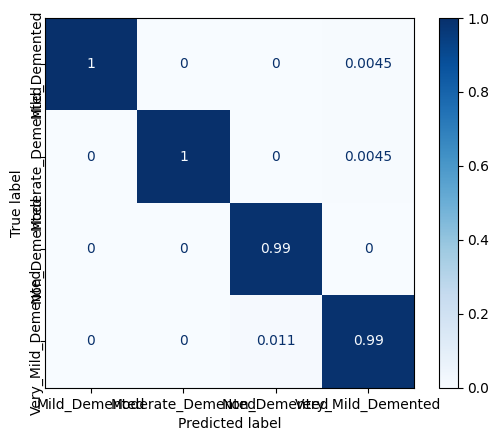

<Figure size 500x500 with 0 Axes>

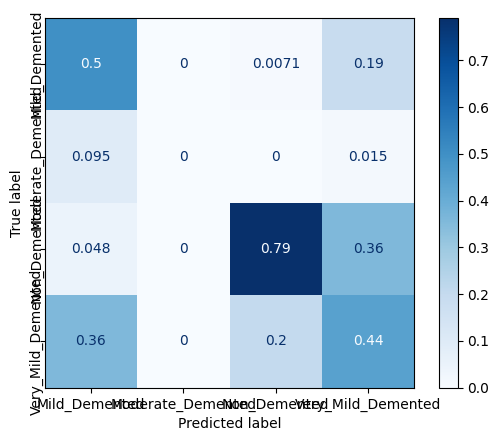

<Figure size 500x500 with 0 Axes>

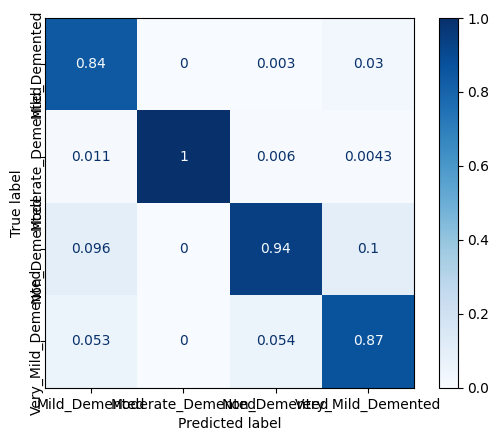

<Figure size 500x500 with 0 Axes>

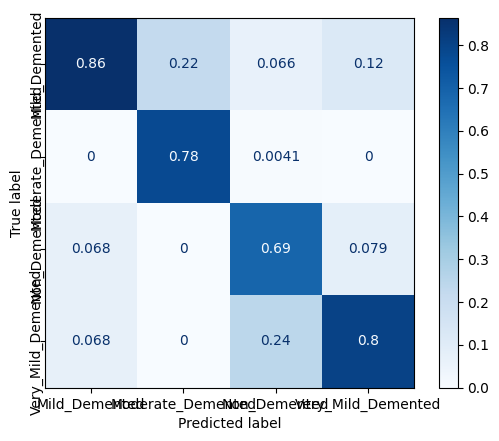

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ConvNeXtBase.zip ./*